<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [5]</a>'.</span>

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10

batch_size = 128
batch_size_finetuning = 32
epochs = 20
epochs_finetuning = 1

experiment_id = f"classification-lstm-of-sentences-finetuned-bert-{max_training_samples}-orig-data-{epochs}-epochs"

In [3]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [4]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [5]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    f"{experiment_dir}/split_data"
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [6]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [7]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [8]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [9]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    f"{experiment_dir}/training_data_finetuning"
)

In [10]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=1e-5)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [11]:
from training_utils import run_training_loop

from utils import memo_load
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    f"{experiment_dir}/finetuning"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


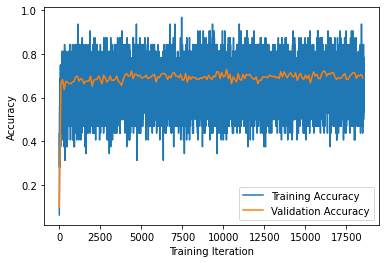

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{experiment_dir}/training-plot-finetuning.png")

In [13]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

from utils import memo_load
train_x_embeds = memo_load(lambda: get_embeds(train_x[:max_training_samples]), f"{experiment_dir}/training_data")
valid_x_embeds = memo_load(lambda: get_embeds(valid_x), f"{experiment_dir}/valid_data")

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 8/100000 [00:00<25:09, 66.26it/s]

  0%|          | 15/100000 [00:00<26:49, 62.11it/s]

  0%|          | 24/100000 [00:00<23:36, 70.56it/s]

  0%|          | 32/100000 [00:00<23:26, 71.08it/s]

  0%|          | 40/100000 [00:00<22:44, 73.23it/s]

  0%|          | 48/100000 [00:00<22:47, 73.09it/s]

  0%|          | 57/100000 [00:00<21:54, 76.03it/s]

  0%|          | 65/100000 [00:00<21:46, 76.51it/s]

  0%|          | 74/100000 [00:00<20:43, 80.35it/s]

  0%|          | 84/100000 [00:01<19:32, 85.22it/s]

  0%|          | 93/100000 [00:01<19:57, 83.45it/s]

  0%|          | 102/100000 [00:01<21:21, 77.96it/s]

  0%|          | 110/100000 [00:01<22:08, 75.19it/s]

  0%|          | 118/100000 [00:01<23:18, 71.44it/s]

  0%|          | 126/100000 [00:01<23:13, 71.66it/s]

  0%|          | 134/100000 [00:01<25:25, 65.47it/s]

  0%|          | 142/100000 [00:01<24:27, 68.04it/s]

  0%|          | 149/100000 [00:02<26:03, 63.88it/s]

  0%|          | 156/100000 [00:02<26:22, 63.08it/s]

  0%|          | 163/100000 [00:02<25:59, 64.03it/s]

  0%|          | 172/100000 [00:02<24:14, 68.64it/s]

  0%|          | 181/100000 [00:02<22:50, 72.82it/s]

  0%|          | 189/100000 [00:02<22:29, 73.98it/s]

  0%|          | 197/100000 [00:02<22:09, 75.05it/s]

  0%|          | 206/100000 [00:02<21:33, 77.16it/s]

  0%|          | 214/100000 [00:02<22:04, 75.31it/s]

  0%|          | 222/100000 [00:03<21:43, 76.57it/s]

  0%|          | 230/100000 [00:03<21:37, 76.87it/s]

  0%|          | 239/100000 [00:03<21:03, 78.94it/s]

  0%|          | 247/100000 [00:03<21:28, 77.42it/s]

  0%|          | 255/100000 [00:03<22:20, 74.38it/s]

  0%|          | 263/100000 [00:03<22:09, 75.01it/s]

  0%|          | 271/100000 [00:03<23:41, 70.14it/s]

  0%|          | 279/100000 [00:03<23:15, 71.47it/s]

  0%|          | 287/100000 [00:03<22:42, 73.18it/s]

  0%|          | 296/100000 [00:04<21:52, 75.99it/s]

  0%|          | 305/100000 [00:04<21:26, 77.48it/s]

  0%|          | 314/100000 [00:04<20:59, 79.12it/s]

  0%|          | 322/100000 [00:04<21:37, 76.85it/s]

  0%|          | 331/100000 [00:04<21:21, 77.80it/s]

  0%|          | 339/100000 [00:04<22:44, 73.04it/s]

  0%|          | 347/100000 [00:04<22:59, 72.24it/s]

  0%|          | 356/100000 [00:04<21:42, 76.49it/s]

  0%|          | 364/100000 [00:04<23:05, 71.90it/s]

  0%|          | 372/100000 [00:05<23:50, 69.64it/s]

  0%|          | 380/100000 [00:05<23:50, 69.65it/s]

  0%|          | 388/100000 [00:05<23:31, 70.58it/s]

  0%|          | 396/100000 [00:05<23:16, 71.34it/s]

  0%|          | 404/100000 [00:05<24:26, 67.93it/s]

  0%|          | 414/100000 [00:05<21:58, 75.53it/s]

  0%|          | 422/100000 [00:05<23:10, 71.62it/s]

  0%|          | 430/100000 [00:05<23:09, 71.67it/s]

  0%|          | 439/100000 [00:05<22:45, 72.89it/s]

  0%|          | 447/100000 [00:06<22:39, 73.25it/s]

  0%|          | 455/100000 [00:06<22:07, 75.00it/s]

  0%|          | 463/100000 [00:06<21:53, 75.75it/s]

  0%|          | 471/100000 [00:06<23:17, 71.22it/s]

  0%|          | 479/100000 [00:06<22:32, 73.60it/s]

  0%|          | 488/100000 [00:06<21:49, 75.99it/s]

  0%|          | 496/100000 [00:06<22:59, 72.15it/s]

  1%|          | 504/100000 [00:06<22:25, 73.97it/s]

  1%|          | 512/100000 [00:07<23:40, 70.03it/s]

  1%|          | 520/100000 [00:07<24:56, 66.48it/s]

  1%|          | 527/100000 [00:07<26:10, 63.35it/s]

  1%|          | 536/100000 [00:07<24:18, 68.17it/s]

  1%|          | 543/100000 [00:07<24:35, 67.39it/s]

  1%|          | 550/100000 [00:07<24:32, 67.55it/s]

  1%|          | 559/100000 [00:07<22:46, 72.75it/s]

  1%|          | 567/100000 [00:07<23:58, 69.10it/s]

  1%|          | 575/100000 [00:07<23:09, 71.54it/s]

  1%|          | 583/100000 [00:08<23:03, 71.86it/s]

  1%|          | 591/100000 [00:08<24:13, 68.38it/s]

  1%|          | 598/100000 [00:08<24:07, 68.65it/s]

  1%|          | 606/100000 [00:08<23:31, 70.41it/s]

  1%|          | 614/100000 [00:08<23:07, 71.61it/s]

  1%|          | 622/100000 [00:08<22:44, 72.85it/s]

  1%|          | 630/100000 [00:08<22:34, 73.35it/s]

  1%|          | 638/100000 [00:08<22:41, 72.99it/s]

  1%|          | 646/100000 [00:08<22:33, 73.41it/s]

  1%|          | 654/100000 [00:09<22:49, 72.56it/s]

  1%|          | 662/100000 [00:09<22:47, 72.64it/s]

  1%|          | 671/100000 [00:09<21:38, 76.47it/s]

  1%|          | 679/100000 [00:09<21:52, 75.69it/s]

  1%|          | 687/100000 [00:09<22:22, 74.00it/s]

  1%|          | 695/100000 [00:09<24:12, 68.35it/s]

  1%|          | 703/100000 [00:09<24:01, 68.90it/s]

  1%|          | 712/100000 [00:09<22:17, 74.25it/s]

  1%|          | 720/100000 [00:09<23:02, 71.82it/s]

  1%|          | 728/100000 [00:10<23:29, 70.42it/s]

  1%|          | 736/100000 [00:10<23:17, 71.01it/s]

  1%|          | 747/100000 [00:10<20:54, 79.10it/s]

  1%|          | 755/100000 [00:10<21:59, 75.24it/s]

  1%|          | 765/100000 [00:10<20:38, 80.10it/s]

  1%|          | 774/100000 [00:10<20:46, 79.62it/s]

  1%|          | 783/100000 [00:10<22:01, 75.08it/s]

  1%|          | 793/100000 [00:10<21:16, 77.71it/s]

  1%|          | 801/100000 [00:10<22:37, 73.07it/s]

  1%|          | 809/100000 [00:11<22:11, 74.48it/s]

  1%|          | 817/100000 [00:11<23:15, 71.05it/s]

  1%|          | 825/100000 [00:11<23:17, 70.96it/s]

  1%|          | 833/100000 [00:11<24:49, 66.56it/s]

  1%|          | 843/100000 [00:11<23:02, 71.70it/s]

  1%|          | 851/100000 [00:11<23:28, 70.39it/s]

  1%|          | 859/100000 [00:11<23:35, 70.03it/s]

  1%|          | 867/100000 [00:11<23:56, 69.02it/s]

  1%|          | 875/100000 [00:12<23:54, 69.09it/s]

  1%|          | 882/100000 [00:12<24:11, 68.29it/s]

  1%|          | 889/100000 [00:12<24:24, 67.67it/s]

  1%|          | 897/100000 [00:12<23:33, 70.12it/s]

  1%|          | 905/100000 [00:12<23:36, 69.96it/s]

  1%|          | 913/100000 [00:12<23:22, 70.67it/s]

  1%|          | 921/100000 [00:12<23:53, 69.12it/s]

  1%|          | 929/100000 [00:12<23:10, 71.25it/s]

  1%|          | 938/100000 [00:12<21:42, 76.08it/s]

  1%|          | 946/100000 [00:13<22:32, 73.23it/s]

  1%|          | 954/100000 [00:13<22:37, 72.99it/s]

  1%|          | 962/100000 [00:13<23:25, 70.44it/s]

  1%|          | 970/100000 [00:13<23:35, 69.96it/s]

  1%|          | 978/100000 [00:13<23:34, 70.00it/s]

  1%|          | 986/100000 [00:13<23:43, 69.56it/s]

  1%|          | 994/100000 [00:13<22:53, 72.09it/s]

  1%|          | 1002/100000 [00:13<23:24, 70.50it/s]

  1%|          | 1010/100000 [00:13<22:46, 72.44it/s]

  1%|          | 1019/100000 [00:14<21:56, 75.21it/s]

  1%|          | 1029/100000 [00:14<20:10, 81.79it/s]

  1%|          | 1038/100000 [00:14<20:40, 79.76it/s]

  1%|          | 1047/100000 [00:14<21:45, 75.79it/s]

  1%|          | 1055/100000 [00:14<22:46, 72.39it/s]

  1%|          | 1063/100000 [00:14<23:07, 71.28it/s]

  1%|          | 1073/100000 [00:14<21:20, 77.27it/s]

  1%|          | 1081/100000 [00:14<23:08, 71.27it/s]

  1%|          | 1090/100000 [00:15<22:15, 74.07it/s]

  1%|          | 1098/100000 [00:15<22:36, 72.90it/s]

  1%|          | 1106/100000 [00:15<22:30, 73.22it/s]

  1%|          | 1114/100000 [00:15<24:03, 68.50it/s]

  1%|          | 1123/100000 [00:15<22:53, 71.97it/s]

  1%|          | 1131/100000 [00:15<23:06, 71.33it/s]

  1%|          | 1139/100000 [00:15<23:46, 69.31it/s]

  1%|          | 1148/100000 [00:15<23:15, 70.83it/s]

  1%|          | 1157/100000 [00:15<21:55, 75.15it/s]

  1%|          | 1166/100000 [00:16<21:39, 76.08it/s]

  1%|          | 1174/100000 [00:16<21:51, 75.36it/s]

  1%|          | 1182/100000 [00:16<23:25, 70.33it/s]

  1%|          | 1190/100000 [00:16<23:41, 69.53it/s]

  1%|          | 1198/100000 [00:16<23:31, 69.99it/s]

  1%|          | 1206/100000 [00:16<24:10, 68.10it/s]

  1%|          | 1214/100000 [00:16<23:15, 70.77it/s]

  1%|          | 1222/100000 [00:16<23:02, 71.45it/s]

  1%|          | 1230/100000 [00:17<24:02, 68.49it/s]

  1%|          | 1237/100000 [00:17<24:23, 67.50it/s]

  1%|          | 1244/100000 [00:17<24:32, 67.09it/s]

  1%|▏         | 1251/100000 [00:17<24:31, 67.12it/s]

  1%|▏         | 1258/100000 [00:17<25:20, 64.93it/s]

  1%|▏         | 1266/100000 [00:17<23:53, 68.87it/s]

  1%|▏         | 1273/100000 [00:17<23:53, 68.88it/s]

  1%|▏         | 1282/100000 [00:17<22:25, 73.36it/s]

  1%|▏         | 1290/100000 [00:17<21:53, 75.14it/s]

  1%|▏         | 1298/100000 [00:17<22:24, 73.39it/s]

  1%|▏         | 1307/100000 [00:18<21:35, 76.18it/s]

  1%|▏         | 1315/100000 [00:18<22:10, 74.20it/s]

  1%|▏         | 1323/100000 [00:18<22:24, 73.39it/s]

  1%|▏         | 1331/100000 [00:18<22:18, 73.70it/s]

  1%|▏         | 1340/100000 [00:18<21:44, 75.61it/s]

  1%|▏         | 1348/100000 [00:18<22:08, 74.24it/s]

  1%|▏         | 1356/100000 [00:18<21:50, 75.30it/s]

  1%|▏         | 1364/100000 [00:18<23:10, 70.91it/s]

  1%|▏         | 1372/100000 [00:18<23:14, 70.73it/s]

  1%|▏         | 1381/100000 [00:19<22:24, 73.36it/s]

  1%|▏         | 1390/100000 [00:19<21:53, 75.08it/s]

  1%|▏         | 1399/100000 [00:19<21:03, 78.06it/s]

  1%|▏         | 1407/100000 [00:19<21:03, 78.05it/s]

  1%|▏         | 1415/100000 [00:19<21:30, 76.42it/s]

  1%|▏         | 1423/100000 [00:19<21:42, 75.69it/s]

  1%|▏         | 1431/100000 [00:19<22:01, 74.61it/s]

  1%|▏         | 1439/100000 [00:19<21:53, 75.05it/s]

  1%|▏         | 1448/100000 [00:19<21:50, 75.22it/s]

  1%|▏         | 1456/100000 [00:20<22:36, 72.63it/s]

  1%|▏         | 1465/100000 [00:20<21:20, 76.94it/s]

  1%|▏         | 1473/100000 [00:20<22:18, 73.63it/s]

  1%|▏         | 1481/100000 [00:20<22:45, 72.17it/s]

  1%|▏         | 1492/100000 [00:20<21:02, 78.05it/s]

  2%|▏         | 1500/100000 [00:20<21:14, 77.27it/s]

  2%|▏         | 1508/100000 [00:20<22:49, 71.89it/s]

  2%|▏         | 1516/100000 [00:20<24:04, 68.19it/s]

  2%|▏         | 1523/100000 [00:21<23:59, 68.43it/s]

  2%|▏         | 1530/100000 [00:21<24:29, 67.03it/s]

  2%|▏         | 1537/100000 [00:21<24:36, 66.68it/s]

  2%|▏         | 1544/100000 [00:21<26:14, 62.55it/s]

  2%|▏         | 1553/100000 [00:21<24:05, 68.10it/s]

  2%|▏         | 1560/100000 [00:21<24:31, 66.88it/s]

  2%|▏         | 1567/100000 [00:21<25:10, 65.15it/s]

  2%|▏         | 1574/100000 [00:21<24:58, 65.70it/s]

  2%|▏         | 1582/100000 [00:21<23:44, 69.08it/s]

  2%|▏         | 1590/100000 [00:22<22:56, 71.47it/s]

  2%|▏         | 1598/100000 [00:22<23:13, 70.62it/s]

  2%|▏         | 1607/100000 [00:22<22:24, 73.16it/s]

  2%|▏         | 1615/100000 [00:22<23:26, 69.93it/s]

  2%|▏         | 1624/100000 [00:22<21:50, 75.08it/s]

  2%|▏         | 1632/100000 [00:22<21:27, 76.40it/s]

  2%|▏         | 1640/100000 [00:22<21:56, 74.71it/s]

  2%|▏         | 1648/100000 [00:22<22:55, 71.48it/s]

  2%|▏         | 1656/100000 [00:22<22:38, 72.40it/s]

  2%|▏         | 1664/100000 [00:23<22:45, 71.99it/s]

  2%|▏         | 1672/100000 [00:23<24:01, 68.20it/s]

  2%|▏         | 1682/100000 [00:23<21:29, 76.27it/s]

  2%|▏         | 1691/100000 [00:23<21:24, 76.55it/s]

  2%|▏         | 1699/100000 [00:23<21:27, 76.32it/s]

  2%|▏         | 1707/100000 [00:23<21:21, 76.72it/s]

  2%|▏         | 1716/100000 [00:23<21:31, 76.13it/s]

  2%|▏         | 1725/100000 [00:23<21:01, 77.90it/s]

  2%|▏         | 1733/100000 [00:23<20:56, 78.20it/s]

  2%|▏         | 1741/100000 [00:24<21:12, 77.24it/s]

  2%|▏         | 1749/100000 [00:24<21:52, 74.84it/s]

  2%|▏         | 1757/100000 [00:24<21:57, 74.57it/s]

  2%|▏         | 1765/100000 [00:24<22:20, 73.27it/s]

  2%|▏         | 1773/100000 [00:24<22:53, 71.49it/s]

  2%|▏         | 1782/100000 [00:24<22:04, 74.17it/s]

  2%|▏         | 1791/100000 [00:24<21:56, 74.60it/s]

  2%|▏         | 1799/100000 [00:24<23:31, 69.59it/s]

  2%|▏         | 1807/100000 [00:24<23:58, 68.27it/s]

  2%|▏         | 1816/100000 [00:25<22:29, 72.73it/s]

  2%|▏         | 1824/100000 [00:25<21:57, 74.51it/s]

  2%|▏         | 1832/100000 [00:25<21:46, 75.11it/s]

  2%|▏         | 1840/100000 [00:25<22:10, 73.76it/s]

  2%|▏         | 1848/100000 [00:25<21:55, 74.60it/s]

  2%|▏         | 1857/100000 [00:25<21:24, 76.40it/s]

  2%|▏         | 1866/100000 [00:25<20:56, 78.10it/s]

  2%|▏         | 1874/100000 [00:25<21:49, 74.91it/s]

  2%|▏         | 1885/100000 [00:25<19:59, 81.77it/s]

  2%|▏         | 1894/100000 [00:26<20:28, 79.87it/s]

  2%|▏         | 1903/100000 [00:26<20:23, 80.19it/s]

  2%|▏         | 1912/100000 [00:26<20:34, 79.47it/s]

  2%|▏         | 1920/100000 [00:26<20:56, 78.08it/s]

  2%|▏         | 1928/100000 [00:26<21:14, 76.95it/s]

  2%|▏         | 1937/100000 [00:26<20:22, 80.22it/s]

  2%|▏         | 1946/100000 [00:26<21:40, 75.40it/s]

  2%|▏         | 1954/100000 [00:26<21:49, 74.85it/s]

  2%|▏         | 1962/100000 [00:26<21:27, 76.16it/s]

  2%|▏         | 1971/100000 [00:27<21:08, 77.25it/s]

  2%|▏         | 1981/100000 [00:27<20:13, 80.80it/s]

  2%|▏         | 1990/100000 [00:27<20:50, 78.40it/s]

  2%|▏         | 1998/100000 [00:27<21:20, 76.56it/s]

  2%|▏         | 2006/100000 [00:27<21:57, 74.37it/s]

  2%|▏         | 2015/100000 [00:27<21:36, 75.55it/s]

  2%|▏         | 2023/100000 [00:27<21:35, 75.62it/s]

  2%|▏         | 2031/100000 [00:27<21:57, 74.36it/s]

  2%|▏         | 2039/100000 [00:27<22:25, 72.81it/s]

  2%|▏         | 2047/100000 [00:28<22:07, 73.77it/s]

  2%|▏         | 2056/100000 [00:28<21:29, 75.95it/s]

  2%|▏         | 2065/100000 [00:28<20:44, 78.70it/s]

  2%|▏         | 2073/100000 [00:28<20:42, 78.83it/s]

  2%|▏         | 2081/100000 [00:28<21:51, 74.67it/s]

  2%|▏         | 2089/100000 [00:28<21:28, 75.99it/s]

  2%|▏         | 2098/100000 [00:28<21:03, 77.50it/s]

  2%|▏         | 2106/100000 [00:28<22:03, 73.94it/s]

  2%|▏         | 2114/100000 [00:28<22:01, 74.09it/s]

  2%|▏         | 2122/100000 [00:29<23:16, 70.08it/s]

  2%|▏         | 2130/100000 [00:29<23:03, 70.76it/s]

  2%|▏         | 2139/100000 [00:29<22:39, 71.98it/s]

  2%|▏         | 2147/100000 [00:29<23:07, 70.52it/s]

  2%|▏         | 2156/100000 [00:29<22:15, 73.28it/s]

  2%|▏         | 2164/100000 [00:29<23:06, 70.59it/s]

  2%|▏         | 2172/100000 [00:29<22:33, 72.30it/s]

  2%|▏         | 2181/100000 [00:29<21:35, 75.52it/s]

  2%|▏         | 2189/100000 [00:30<22:50, 71.39it/s]

  2%|▏         | 2198/100000 [00:30<22:00, 74.05it/s]

  2%|▏         | 2206/100000 [00:30<21:57, 74.20it/s]

  2%|▏         | 2214/100000 [00:30<22:46, 71.55it/s]

  2%|▏         | 2223/100000 [00:30<21:42, 75.07it/s]

  2%|▏         | 2232/100000 [00:30<20:53, 77.97it/s]

  2%|▏         | 2240/100000 [00:30<22:00, 74.01it/s]

  2%|▏         | 2248/100000 [00:30<21:46, 74.82it/s]

  2%|▏         | 2257/100000 [00:30<21:04, 77.33it/s]

  2%|▏         | 2266/100000 [00:30<20:31, 79.35it/s]

  2%|▏         | 2274/100000 [00:31<21:49, 74.60it/s]

  2%|▏         | 2282/100000 [00:31<24:05, 67.59it/s]

  2%|▏         | 2291/100000 [00:31<22:27, 72.49it/s]

  2%|▏         | 2299/100000 [00:31<23:18, 69.85it/s]

  2%|▏         | 2307/100000 [00:31<23:50, 68.28it/s]

  2%|▏         | 2314/100000 [00:31<25:22, 64.15it/s]

  2%|▏         | 2323/100000 [00:31<23:57, 67.97it/s]

  2%|▏         | 2332/100000 [00:31<22:15, 73.11it/s]

  2%|▏         | 2340/100000 [00:32<23:00, 70.74it/s]

  2%|▏         | 2348/100000 [00:32<23:07, 70.38it/s]

  2%|▏         | 2356/100000 [00:32<23:03, 70.57it/s]

  2%|▏         | 2364/100000 [00:32<22:15, 73.11it/s]

  2%|▏         | 2373/100000 [00:32<21:36, 75.33it/s]

  2%|▏         | 2381/100000 [00:32<21:51, 74.45it/s]

  2%|▏         | 2390/100000 [00:32<21:28, 75.75it/s]

  2%|▏         | 2398/100000 [00:32<22:10, 73.36it/s]

  2%|▏         | 2407/100000 [00:32<20:59, 77.46it/s]

  2%|▏         | 2415/100000 [00:33<21:39, 75.09it/s]

  2%|▏         | 2423/100000 [00:33<22:31, 72.21it/s]

  2%|▏         | 2431/100000 [00:33<23:54, 68.01it/s]

  2%|▏         | 2438/100000 [00:33<23:43, 68.52it/s]

  2%|▏         | 2446/100000 [00:33<23:42, 68.57it/s]

  2%|▏         | 2455/100000 [00:33<22:23, 72.59it/s]

  2%|▏         | 2464/100000 [00:33<21:18, 76.26it/s]

  2%|▏         | 2473/100000 [00:33<21:19, 76.23it/s]

  2%|▏         | 2481/100000 [00:34<22:22, 72.65it/s]

  2%|▏         | 2490/100000 [00:34<21:37, 75.15it/s]

  2%|▎         | 2500/100000 [00:34<19:56, 81.51it/s]

  3%|▎         | 2509/100000 [00:34<20:35, 78.92it/s]

  3%|▎         | 2518/100000 [00:34<20:42, 78.46it/s]

  3%|▎         | 2526/100000 [00:34<21:45, 74.68it/s]

  3%|▎         | 2534/100000 [00:34<22:27, 72.35it/s]

  3%|▎         | 2543/100000 [00:34<22:06, 73.48it/s]

  3%|▎         | 2551/100000 [00:34<22:46, 71.30it/s]

  3%|▎         | 2559/100000 [00:35<23:21, 69.54it/s]

  3%|▎         | 2567/100000 [00:35<22:51, 71.03it/s]

  3%|▎         | 2575/100000 [00:35<22:47, 71.24it/s]

  3%|▎         | 2583/100000 [00:35<23:44, 68.39it/s]

  3%|▎         | 2592/100000 [00:35<23:11, 70.01it/s]

  3%|▎         | 2600/100000 [00:35<23:40, 68.59it/s]

  3%|▎         | 2608/100000 [00:35<22:56, 70.78it/s]

  3%|▎         | 2616/100000 [00:35<23:27, 69.21it/s]

  3%|▎         | 2625/100000 [00:35<21:54, 74.07it/s]

  3%|▎         | 2633/100000 [00:36<22:33, 71.95it/s]

  3%|▎         | 2641/100000 [00:36<22:39, 71.63it/s]

  3%|▎         | 2649/100000 [00:36<22:17, 72.76it/s]

  3%|▎         | 2657/100000 [00:36<22:02, 73.59it/s]

  3%|▎         | 2665/100000 [00:36<22:23, 72.47it/s]

  3%|▎         | 2673/100000 [00:36<23:16, 69.69it/s]

  3%|▎         | 2681/100000 [00:36<22:32, 71.96it/s]

  3%|▎         | 2690/100000 [00:36<21:09, 76.65it/s]

  3%|▎         | 2698/100000 [00:36<21:45, 74.55it/s]

  3%|▎         | 2707/100000 [00:37<20:39, 78.48it/s]

  3%|▎         | 2715/100000 [00:37<21:31, 75.32it/s]

  3%|▎         | 2723/100000 [00:37<23:13, 69.80it/s]

  3%|▎         | 2731/100000 [00:37<24:21, 66.57it/s]

  3%|▎         | 2739/100000 [00:37<23:45, 68.24it/s]

  3%|▎         | 2746/100000 [00:37<24:35, 65.93it/s]

  3%|▎         | 2753/100000 [00:37<24:12, 66.93it/s]

  3%|▎         | 2762/100000 [00:37<22:51, 70.88it/s]

  3%|▎         | 2770/100000 [00:38<22:16, 72.75it/s]

  3%|▎         | 2778/100000 [00:38<22:51, 70.87it/s]

  3%|▎         | 2786/100000 [00:38<24:10, 67.02it/s]

  3%|▎         | 2793/100000 [00:38<24:09, 67.05it/s]

  3%|▎         | 2803/100000 [00:38<21:37, 74.89it/s]

  3%|▎         | 2811/100000 [00:38<22:19, 72.55it/s]

  3%|▎         | 2819/100000 [00:38<22:49, 70.96it/s]

  3%|▎         | 2828/100000 [00:38<21:39, 74.75it/s]

  3%|▎         | 2837/100000 [00:38<20:57, 77.25it/s]

  3%|▎         | 2846/100000 [00:39<20:34, 78.70it/s]

  3%|▎         | 2854/100000 [00:39<22:28, 72.05it/s]

  3%|▎         | 2862/100000 [00:39<23:57, 67.58it/s]

  3%|▎         | 2870/100000 [00:39<23:08, 69.96it/s]

  3%|▎         | 2878/100000 [00:39<22:45, 71.13it/s]

  3%|▎         | 2886/100000 [00:39<23:52, 67.81it/s]

  3%|▎         | 2893/100000 [00:39<24:22, 66.41it/s]

  3%|▎         | 2901/100000 [00:39<23:23, 69.18it/s]

  3%|▎         | 2908/100000 [00:39<23:34, 68.63it/s]

  3%|▎         | 2917/100000 [00:40<22:21, 72.39it/s]

  3%|▎         | 2925/100000 [00:40<22:02, 73.38it/s]

  3%|▎         | 2935/100000 [00:40<20:13, 80.00it/s]

  3%|▎         | 2944/100000 [00:40<21:59, 73.58it/s]

  3%|▎         | 2952/100000 [00:40<21:59, 73.56it/s]

  3%|▎         | 2962/100000 [00:40<20:30, 78.88it/s]

  3%|▎         | 2970/100000 [00:40<20:31, 78.82it/s]

  3%|▎         | 2978/100000 [00:40<20:56, 77.22it/s]

  3%|▎         | 2986/100000 [00:41<22:32, 71.71it/s]

  3%|▎         | 2994/100000 [00:41<22:32, 71.70it/s]

  3%|▎         | 3002/100000 [00:41<24:06, 67.05it/s]

  3%|▎         | 3010/100000 [00:41<23:17, 69.38it/s]

  3%|▎         | 3018/100000 [00:41<23:29, 68.81it/s]

  3%|▎         | 3026/100000 [00:41<23:17, 69.37it/s]

  3%|▎         | 3034/100000 [00:41<23:02, 70.13it/s]

  3%|▎         | 3042/100000 [00:41<23:20, 69.22it/s]

  3%|▎         | 3050/100000 [00:41<22:25, 72.06it/s]

  3%|▎         | 3058/100000 [00:42<22:21, 72.27it/s]

  3%|▎         | 3067/100000 [00:42<21:06, 76.53it/s]

  3%|▎         | 3076/100000 [00:42<21:11, 76.24it/s]

  3%|▎         | 3084/100000 [00:42<22:42, 71.14it/s]

  3%|▎         | 3094/100000 [00:42<20:58, 77.00it/s]

  3%|▎         | 3103/100000 [00:42<21:01, 76.82it/s]

  3%|▎         | 3111/100000 [00:42<21:14, 76.00it/s]

  3%|▎         | 3119/100000 [00:42<22:03, 73.22it/s]

  3%|▎         | 3127/100000 [00:42<22:09, 72.85it/s]

  3%|▎         | 3135/100000 [00:43<22:19, 72.33it/s]

  3%|▎         | 3143/100000 [00:43<23:12, 69.58it/s]

  3%|▎         | 3150/100000 [00:43<24:13, 66.63it/s]

  3%|▎         | 3158/100000 [00:43<23:50, 67.69it/s]

  3%|▎         | 3165/100000 [00:43<24:31, 65.82it/s]

  3%|▎         | 3173/100000 [00:43<23:50, 67.68it/s]

  3%|▎         | 3180/100000 [00:43<24:15, 66.54it/s]

  3%|▎         | 3188/100000 [00:43<24:08, 66.82it/s]

  3%|▎         | 3195/100000 [00:43<24:07, 66.86it/s]

  3%|▎         | 3202/100000 [00:44<24:50, 64.94it/s]

  3%|▎         | 3210/100000 [00:44<23:36, 68.32it/s]

  3%|▎         | 3217/100000 [00:44<24:06, 66.91it/s]

  3%|▎         | 3224/100000 [00:44<24:55, 64.69it/s]

  3%|▎         | 3232/100000 [00:44<23:31, 68.54it/s]

  3%|▎         | 3240/100000 [00:44<22:47, 70.77it/s]

  3%|▎         | 3248/100000 [00:44<23:19, 69.13it/s]

  3%|▎         | 3257/100000 [00:44<21:56, 73.51it/s]

  3%|▎         | 3266/100000 [00:44<21:27, 75.14it/s]

  3%|▎         | 3274/100000 [00:45<22:10, 72.69it/s]

  3%|▎         | 3282/100000 [00:45<21:52, 73.69it/s]

  3%|▎         | 3290/100000 [00:45<21:33, 74.75it/s]

  3%|▎         | 3298/100000 [00:45<21:59, 73.27it/s]

  3%|▎         | 3306/100000 [00:45<22:56, 70.25it/s]

  3%|▎         | 3314/100000 [00:45<22:08, 72.78it/s]

  3%|▎         | 3322/100000 [00:45<21:54, 73.52it/s]

  3%|▎         | 3330/100000 [00:45<22:08, 72.75it/s]

  3%|▎         | 3341/100000 [00:45<20:20, 79.21it/s]

  3%|▎         | 3350/100000 [00:46<20:32, 78.40it/s]

  3%|▎         | 3362/100000 [00:46<18:32, 86.83it/s]

  3%|▎         | 3371/100000 [00:46<20:57, 76.82it/s]

  3%|▎         | 3380/100000 [00:46<20:36, 78.11it/s]

  3%|▎         | 3388/100000 [00:46<21:59, 73.23it/s]

  3%|▎         | 3396/100000 [00:46<23:21, 68.95it/s]

  3%|▎         | 3404/100000 [00:46<23:31, 68.41it/s]

  3%|▎         | 3412/100000 [00:46<23:31, 68.42it/s]

  3%|▎         | 3420/100000 [00:47<23:22, 68.85it/s]

  3%|▎         | 3427/100000 [00:47<23:25, 68.70it/s]

  3%|▎         | 3434/100000 [00:47<24:10, 66.56it/s]

  3%|▎         | 3441/100000 [00:47<24:22, 66.05it/s]

  3%|▎         | 3449/100000 [00:47<23:37, 68.11it/s]

  3%|▎         | 3456/100000 [00:47<23:26, 68.62it/s]

  3%|▎         | 3464/100000 [00:47<22:28, 71.56it/s]

  3%|▎         | 3472/100000 [00:47<22:16, 72.21it/s]

  3%|▎         | 3480/100000 [00:47<23:28, 68.52it/s]

  3%|▎         | 3487/100000 [00:48<23:27, 68.55it/s]

  3%|▎         | 3495/100000 [00:48<23:26, 68.59it/s]

  4%|▎         | 3503/100000 [00:48<22:25, 71.73it/s]

  4%|▎         | 3511/100000 [00:48<23:09, 69.45it/s]

  4%|▎         | 3519/100000 [00:48<23:02, 69.80it/s]

  4%|▎         | 3527/100000 [00:48<22:28, 71.54it/s]

  4%|▎         | 3536/100000 [00:48<21:54, 73.41it/s]

  4%|▎         | 3544/100000 [00:48<21:53, 73.45it/s]

  4%|▎         | 3553/100000 [00:48<21:03, 76.35it/s]

  4%|▎         | 3562/100000 [00:49<20:15, 79.35it/s]

  4%|▎         | 3571/100000 [00:49<19:35, 82.05it/s]

  4%|▎         | 3580/100000 [00:49<19:51, 80.93it/s]

  4%|▎         | 3589/100000 [00:49<20:43, 77.52it/s]

  4%|▎         | 3597/100000 [00:49<21:30, 74.71it/s]

  4%|▎         | 3605/100000 [00:49<21:45, 73.84it/s]

  4%|▎         | 3613/100000 [00:49<22:09, 72.52it/s]

  4%|▎         | 3621/100000 [00:49<21:58, 73.10it/s]

  4%|▎         | 3630/100000 [00:49<20:39, 77.75it/s]

  4%|▎         | 3638/100000 [00:50<21:34, 74.46it/s]

  4%|▎         | 3646/100000 [00:50<22:07, 72.56it/s]

  4%|▎         | 3654/100000 [00:50<21:47, 73.69it/s]

  4%|▎         | 3662/100000 [00:50<21:17, 75.41it/s]

  4%|▎         | 3670/100000 [00:50<21:59, 73.02it/s]

  4%|▎         | 3678/100000 [00:50<22:43, 70.63it/s]

  4%|▎         | 3686/100000 [00:50<23:48, 67.40it/s]

  4%|▎         | 3694/100000 [00:50<23:19, 68.83it/s]

  4%|▎         | 3702/100000 [00:50<22:34, 71.07it/s]

  4%|▎         | 3710/100000 [00:51<22:31, 71.27it/s]

  4%|▎         | 3718/100000 [00:51<22:13, 72.20it/s]

  4%|▎         | 3726/100000 [00:51<23:58, 66.91it/s]

  4%|▎         | 3733/100000 [00:51<24:24, 65.75it/s]

  4%|▎         | 3742/100000 [00:51<22:12, 72.24it/s]

  4%|▍         | 3752/100000 [00:51<20:31, 78.15it/s]

  4%|▍         | 3760/100000 [00:51<20:46, 77.20it/s]

  4%|▍         | 3768/100000 [00:51<20:55, 76.65it/s]

  4%|▍         | 3776/100000 [00:51<20:51, 76.91it/s]

  4%|▍         | 3784/100000 [00:52<21:33, 74.40it/s]

  4%|▍         | 3792/100000 [00:52<22:40, 70.74it/s]

  4%|▍         | 3801/100000 [00:52<21:19, 75.17it/s]

  4%|▍         | 3809/100000 [00:52<22:48, 70.28it/s]

  4%|▍         | 3817/100000 [00:52<23:06, 69.35it/s]

  4%|▍         | 3825/100000 [00:52<22:57, 69.84it/s]

  4%|▍         | 3833/100000 [00:52<24:04, 66.58it/s]

  4%|▍         | 3841/100000 [00:52<23:32, 68.05it/s]

  4%|▍         | 3849/100000 [00:53<23:06, 69.33it/s]

  4%|▍         | 3856/100000 [00:53<23:17, 68.81it/s]

  4%|▍         | 3863/100000 [00:53<23:36, 67.88it/s]

  4%|▍         | 3870/100000 [00:53<23:25, 68.40it/s]

  4%|▍         | 3878/100000 [00:53<22:43, 70.49it/s]

  4%|▍         | 3886/100000 [00:53<22:16, 71.93it/s]

  4%|▍         | 3894/100000 [00:53<21:38, 73.99it/s]

  4%|▍         | 3902/100000 [00:53<21:31, 74.43it/s]

  4%|▍         | 3910/100000 [00:53<22:51, 70.07it/s]

  4%|▍         | 3920/100000 [00:54<20:45, 77.14it/s]

  4%|▍         | 3928/100000 [00:54<21:02, 76.09it/s]

  4%|▍         | 3936/100000 [00:54<20:54, 76.55it/s]

  4%|▍         | 3944/100000 [00:54<20:58, 76.32it/s]

  4%|▍         | 3954/100000 [00:54<19:23, 82.56it/s]

  4%|▍         | 3963/100000 [00:54<19:21, 82.67it/s]

  4%|▍         | 3973/100000 [00:54<18:43, 85.48it/s]

  4%|▍         | 3982/100000 [00:54<19:25, 82.36it/s]

  4%|▍         | 3991/100000 [00:54<19:56, 80.22it/s]

  4%|▍         | 4000/100000 [00:55<21:06, 75.80it/s]

  4%|▍         | 4009/100000 [00:55<20:50, 76.79it/s]

  4%|▍         | 4017/100000 [00:55<21:14, 75.31it/s]

  4%|▍         | 4025/100000 [00:55<22:17, 71.74it/s]

  4%|▍         | 4033/100000 [00:55<21:40, 73.78it/s]

  4%|▍         | 4041/100000 [00:55<22:46, 70.22it/s]

  4%|▍         | 4049/100000 [00:55<22:19, 71.63it/s]

  4%|▍         | 4058/100000 [00:55<21:00, 76.14it/s]

  4%|▍         | 4066/100000 [00:55<21:18, 75.02it/s]

  4%|▍         | 4074/100000 [00:56<22:30, 71.04it/s]

  4%|▍         | 4082/100000 [00:56<22:27, 71.17it/s]

  4%|▍         | 4092/100000 [00:56<20:31, 77.89it/s]

  4%|▍         | 4101/100000 [00:56<20:23, 78.39it/s]

  4%|▍         | 4111/100000 [00:56<19:05, 83.74it/s]

  4%|▍         | 4120/100000 [00:56<20:22, 78.43it/s]

  4%|▍         | 4128/100000 [00:56<21:06, 75.72it/s]

  4%|▍         | 4136/100000 [00:56<21:33, 74.10it/s]

  4%|▍         | 4145/100000 [00:56<20:47, 76.81it/s]

  4%|▍         | 4153/100000 [00:57<22:09, 72.09it/s]

  4%|▍         | 4161/100000 [00:57<22:05, 72.31it/s]

  4%|▍         | 4170/100000 [00:57<21:09, 75.50it/s]

  4%|▍         | 4178/100000 [00:57<21:05, 75.71it/s]

  4%|▍         | 4187/100000 [00:57<20:51, 76.57it/s]

  4%|▍         | 4196/100000 [00:57<20:01, 79.72it/s]

  4%|▍         | 4205/100000 [00:57<20:47, 76.77it/s]

  4%|▍         | 4213/100000 [00:57<20:55, 76.28it/s]

  4%|▍         | 4221/100000 [00:57<21:01, 75.92it/s]

  4%|▍         | 4229/100000 [00:58<21:31, 74.13it/s]

  4%|▍         | 4237/100000 [00:58<22:30, 70.89it/s]

  4%|▍         | 4245/100000 [00:58<22:20, 71.43it/s]

  4%|▍         | 4253/100000 [00:58<22:17, 71.61it/s]

  4%|▍         | 4261/100000 [00:58<22:32, 70.77it/s]

  4%|▍         | 4269/100000 [00:58<22:38, 70.47it/s]

  4%|▍         | 4277/100000 [00:58<23:29, 67.92it/s]

  4%|▍         | 4286/100000 [00:58<22:37, 70.51it/s]

  4%|▍         | 4294/100000 [00:59<23:19, 68.40it/s]

  4%|▍         | 4302/100000 [00:59<22:19, 71.45it/s]

  4%|▍         | 4311/100000 [00:59<21:20, 74.76it/s]

  4%|▍         | 4319/100000 [00:59<21:03, 75.70it/s]

  4%|▍         | 4327/100000 [00:59<21:40, 73.59it/s]

  4%|▍         | 4335/100000 [00:59<22:06, 72.12it/s]

  4%|▍         | 4343/100000 [00:59<23:06, 68.97it/s]

  4%|▍         | 4354/100000 [00:59<20:45, 76.82it/s]

  4%|▍         | 4362/100000 [00:59<20:36, 77.32it/s]

  4%|▍         | 4370/100000 [01:00<21:33, 73.94it/s]

  4%|▍         | 4378/100000 [01:00<22:00, 72.40it/s]

  4%|▍         | 4386/100000 [01:00<21:49, 73.03it/s]

  4%|▍         | 4394/100000 [01:00<22:16, 71.52it/s]

  4%|▍         | 4403/100000 [01:00<21:39, 73.56it/s]

  4%|▍         | 4411/100000 [01:00<21:14, 74.99it/s]

  4%|▍         | 4419/100000 [01:00<22:11, 71.76it/s]

  4%|▍         | 4427/100000 [01:00<22:01, 72.30it/s]

  4%|▍         | 4435/100000 [01:00<23:18, 68.34it/s]

  4%|▍         | 4442/100000 [01:01<23:43, 67.13it/s]

  4%|▍         | 4450/100000 [01:01<22:37, 70.37it/s]

  4%|▍         | 4458/100000 [01:01<22:28, 70.85it/s]

  4%|▍         | 4466/100000 [01:01<23:59, 66.35it/s]

  4%|▍         | 4475/100000 [01:01<22:50, 69.71it/s]

  4%|▍         | 4484/100000 [01:01<21:24, 74.34it/s]

  4%|▍         | 4492/100000 [01:01<21:49, 72.94it/s]

  4%|▍         | 4500/100000 [01:01<22:06, 71.99it/s]

  5%|▍         | 4509/100000 [01:01<21:21, 74.54it/s]

  5%|▍         | 4517/100000 [01:02<21:24, 74.31it/s]

  5%|▍         | 4525/100000 [01:02<21:12, 75.05it/s]

  5%|▍         | 4534/100000 [01:02<20:11, 78.77it/s]

  5%|▍         | 4542/100000 [01:02<21:55, 72.59it/s]

  5%|▍         | 4551/100000 [01:02<20:49, 76.42it/s]

  5%|▍         | 4561/100000 [01:02<19:32, 81.40it/s]

  5%|▍         | 4570/100000 [01:02<19:44, 80.57it/s]

  5%|▍         | 4579/100000 [01:02<20:57, 75.86it/s]

  5%|▍         | 4589/100000 [01:02<19:28, 81.62it/s]

  5%|▍         | 4598/100000 [01:03<21:16, 74.73it/s]

  5%|▍         | 4606/100000 [01:03<21:09, 75.17it/s]

  5%|▍         | 4614/100000 [01:03<21:39, 73.43it/s]

  5%|▍         | 4622/100000 [01:03<21:48, 72.87it/s]

  5%|▍         | 4630/100000 [01:03<21:52, 72.65it/s]

  5%|▍         | 4638/100000 [01:03<21:31, 73.86it/s]

  5%|▍         | 4646/100000 [01:03<21:56, 72.43it/s]

  5%|▍         | 4656/100000 [01:03<20:55, 75.92it/s]

  5%|▍         | 4664/100000 [01:04<21:16, 74.67it/s]

  5%|▍         | 4672/100000 [01:04<22:52, 69.46it/s]

  5%|▍         | 4681/100000 [01:04<22:02, 72.08it/s]

  5%|▍         | 4689/100000 [01:04<21:27, 74.02it/s]

  5%|▍         | 4697/100000 [01:04<22:22, 71.01it/s]

  5%|▍         | 4705/100000 [01:04<23:34, 67.35it/s]

  5%|▍         | 4713/100000 [01:04<22:31, 70.53it/s]

  5%|▍         | 4721/100000 [01:04<22:06, 71.82it/s]

  5%|▍         | 4729/100000 [01:04<21:36, 73.50it/s]

  5%|▍         | 4739/100000 [01:05<20:29, 77.48it/s]

  5%|▍         | 4747/100000 [01:05<20:43, 76.59it/s]

  5%|▍         | 4755/100000 [01:05<20:51, 76.11it/s]

  5%|▍         | 4763/100000 [01:05<22:07, 71.75it/s]

  5%|▍         | 4771/100000 [01:05<21:33, 73.61it/s]

  5%|▍         | 4780/100000 [01:05<20:47, 76.34it/s]

  5%|▍         | 4788/100000 [01:05<20:55, 75.83it/s]

  5%|▍         | 4796/100000 [01:05<22:12, 71.43it/s]

  5%|▍         | 4804/100000 [01:05<22:02, 72.00it/s]

  5%|▍         | 4812/100000 [01:06<22:15, 71.29it/s]

  5%|▍         | 4821/100000 [01:06<20:49, 76.16it/s]

  5%|▍         | 4829/100000 [01:06<21:45, 72.88it/s]

  5%|▍         | 4837/100000 [01:06<22:49, 69.50it/s]

  5%|▍         | 4845/100000 [01:06<22:32, 70.35it/s]

  5%|▍         | 4853/100000 [01:06<21:49, 72.64it/s]

  5%|▍         | 4861/100000 [01:06<22:32, 70.33it/s]

  5%|▍         | 4869/100000 [01:06<22:18, 71.07it/s]

  5%|▍         | 4877/100000 [01:06<23:48, 66.58it/s]

  5%|▍         | 4884/100000 [01:07<24:43, 64.10it/s]

  5%|▍         | 4892/100000 [01:07<23:51, 66.45it/s]

  5%|▍         | 4900/100000 [01:07<23:25, 67.64it/s]

  5%|▍         | 4907/100000 [01:07<24:45, 64.00it/s]

  5%|▍         | 4915/100000 [01:07<23:30, 67.42it/s]

  5%|▍         | 4924/100000 [01:07<22:45, 69.62it/s]

  5%|▍         | 4932/100000 [01:07<21:57, 72.15it/s]

  5%|▍         | 4940/100000 [01:07<21:39, 73.17it/s]

  5%|▍         | 4948/100000 [01:07<21:39, 73.16it/s]

  5%|▍         | 4956/100000 [01:08<21:36, 73.33it/s]

  5%|▍         | 4965/100000 [01:08<20:38, 76.71it/s]

  5%|▍         | 4973/100000 [01:08<20:41, 76.54it/s]

  5%|▍         | 4981/100000 [01:08<21:39, 73.12it/s]

  5%|▍         | 4989/100000 [01:08<22:01, 71.90it/s]

  5%|▍         | 4997/100000 [01:08<21:54, 72.26it/s]

  5%|▌         | 5005/100000 [01:08<22:40, 69.83it/s]

  5%|▌         | 5013/100000 [01:08<22:55, 69.06it/s]

  5%|▌         | 5020/100000 [01:09<23:49, 66.46it/s]

  5%|▌         | 5029/100000 [01:09<21:55, 72.19it/s]

  5%|▌         | 5037/100000 [01:09<21:34, 73.36it/s]

  5%|▌         | 5045/100000 [01:09<22:06, 71.60it/s]

  5%|▌         | 5053/100000 [01:09<22:05, 71.63it/s]

  5%|▌         | 5061/100000 [01:09<22:22, 70.73it/s]

  5%|▌         | 5069/100000 [01:09<22:01, 71.83it/s]

  5%|▌         | 5077/100000 [01:09<21:24, 73.91it/s]

  5%|▌         | 5087/100000 [01:09<19:45, 80.05it/s]

  5%|▌         | 5096/100000 [01:10<21:12, 74.57it/s]

  5%|▌         | 5104/100000 [01:10<20:48, 75.99it/s]

  5%|▌         | 5113/100000 [01:10<20:55, 75.61it/s]

  5%|▌         | 5122/100000 [01:10<20:43, 76.27it/s]

  5%|▌         | 5131/100000 [01:10<20:19, 77.78it/s]

  5%|▌         | 5139/100000 [01:10<20:38, 76.57it/s]

  5%|▌         | 5147/100000 [01:10<22:16, 70.97it/s]

  5%|▌         | 5155/100000 [01:10<21:45, 72.67it/s]

  5%|▌         | 5163/100000 [01:10<22:54, 69.00it/s]

  5%|▌         | 5171/100000 [01:11<22:17, 70.91it/s]

  5%|▌         | 5181/100000 [01:11<20:21, 77.64it/s]

  5%|▌         | 5189/100000 [01:11<21:04, 75.00it/s]

  5%|▌         | 5199/100000 [01:11<20:10, 78.30it/s]

  5%|▌         | 5207/100000 [01:11<20:57, 75.37it/s]

  5%|▌         | 5216/100000 [01:11<20:27, 77.22it/s]

  5%|▌         | 5224/100000 [01:11<21:20, 74.04it/s]

  5%|▌         | 5232/100000 [01:11<21:37, 73.05it/s]

  5%|▌         | 5240/100000 [01:11<21:54, 72.11it/s]

  5%|▌         | 5248/100000 [01:12<21:50, 72.29it/s]

  5%|▌         | 5256/100000 [01:12<22:33, 70.00it/s]

  5%|▌         | 5264/100000 [01:12<22:57, 68.76it/s]

  5%|▌         | 5271/100000 [01:12<23:22, 67.54it/s]

  5%|▌         | 5278/100000 [01:12<23:24, 67.45it/s]

  5%|▌         | 5287/100000 [01:12<21:57, 71.88it/s]

  5%|▌         | 5297/100000 [01:12<19:59, 78.96it/s]

  5%|▌         | 5305/100000 [01:12<19:55, 79.21it/s]

  5%|▌         | 5313/100000 [01:12<21:47, 72.39it/s]

  5%|▌         | 5321/100000 [01:13<22:18, 70.76it/s]

  5%|▌         | 5329/100000 [01:13<22:42, 69.49it/s]

  5%|▌         | 5337/100000 [01:13<23:56, 65.92it/s]

  5%|▌         | 5345/100000 [01:13<23:07, 68.20it/s]

  5%|▌         | 5353/100000 [01:13<22:37, 69.71it/s]

  5%|▌         | 5364/100000 [01:13<19:50, 79.51it/s]

  5%|▌         | 5373/100000 [01:13<21:16, 74.16it/s]

  5%|▌         | 5382/100000 [01:13<20:36, 76.55it/s]

  5%|▌         | 5390/100000 [01:14<20:29, 76.94it/s]

  5%|▌         | 5398/100000 [01:14<22:46, 69.21it/s]

  5%|▌         | 5406/100000 [01:14<22:15, 70.84it/s]

  5%|▌         | 5414/100000 [01:14<22:42, 69.42it/s]

  5%|▌         | 5422/100000 [01:14<22:18, 70.67it/s]

  5%|▌         | 5431/100000 [01:14<21:08, 74.56it/s]

  5%|▌         | 5440/100000 [01:14<20:34, 76.61it/s]

  5%|▌         | 5448/100000 [01:14<21:52, 72.05it/s]

  5%|▌         | 5456/100000 [01:14<21:19, 73.90it/s]

  5%|▌         | 5464/100000 [01:15<21:00, 75.01it/s]

  5%|▌         | 5472/100000 [01:15<21:43, 72.52it/s]

  5%|▌         | 5480/100000 [01:15<22:27, 70.14it/s]

  5%|▌         | 5488/100000 [01:15<23:13, 67.83it/s]

  5%|▌         | 5495/100000 [01:15<23:44, 66.36it/s]

  6%|▌         | 5504/100000 [01:15<22:47, 69.08it/s]

  6%|▌         | 5512/100000 [01:15<22:18, 70.61it/s]

  6%|▌         | 5521/100000 [01:15<21:52, 71.99it/s]

  6%|▌         | 5529/100000 [01:16<22:30, 69.96it/s]

  6%|▌         | 5537/100000 [01:16<21:58, 71.63it/s]

  6%|▌         | 5545/100000 [01:16<22:57, 68.57it/s]

  6%|▌         | 5552/100000 [01:16<22:55, 68.68it/s]

  6%|▌         | 5561/100000 [01:16<21:22, 73.65it/s]

  6%|▌         | 5570/100000 [01:16<20:43, 75.95it/s]

  6%|▌         | 5578/100000 [01:16<21:28, 73.28it/s]

  6%|▌         | 5587/100000 [01:16<20:20, 77.37it/s]

  6%|▌         | 5596/100000 [01:16<19:33, 80.45it/s]

  6%|▌         | 5606/100000 [01:16<18:54, 83.19it/s]

  6%|▌         | 5615/100000 [01:17<19:03, 82.55it/s]

  6%|▌         | 5624/100000 [01:17<20:42, 75.98it/s]

  6%|▌         | 5632/100000 [01:17<21:59, 71.49it/s]

  6%|▌         | 5640/100000 [01:17<23:27, 67.05it/s]

  6%|▌         | 5649/100000 [01:17<22:02, 71.35it/s]

  6%|▌         | 5657/100000 [01:17<22:58, 68.46it/s]

  6%|▌         | 5666/100000 [01:17<21:56, 71.68it/s]

  6%|▌         | 5674/100000 [01:17<23:31, 66.83it/s]

  6%|▌         | 5682/100000 [01:18<22:36, 69.52it/s]

  6%|▌         | 5691/100000 [01:18<21:36, 72.76it/s]

  6%|▌         | 5699/100000 [01:18<21:50, 71.97it/s]

  6%|▌         | 5708/100000 [01:18<21:44, 72.25it/s]

  6%|▌         | 5716/100000 [01:18<22:21, 70.27it/s]

  6%|▌         | 5724/100000 [01:18<22:17, 70.46it/s]

  6%|▌         | 5733/100000 [01:18<21:05, 74.51it/s]

  6%|▌         | 5741/100000 [01:18<21:20, 73.58it/s]

  6%|▌         | 5750/100000 [01:19<20:09, 77.95it/s]

  6%|▌         | 5758/100000 [01:19<20:15, 77.52it/s]

  6%|▌         | 5766/100000 [01:19<21:04, 74.50it/s]

  6%|▌         | 5774/100000 [01:19<21:22, 73.47it/s]

  6%|▌         | 5783/100000 [01:19<21:00, 74.73it/s]

  6%|▌         | 5791/100000 [01:19<23:08, 67.86it/s]

  6%|▌         | 5798/100000 [01:19<23:17, 67.42it/s]

  6%|▌         | 5807/100000 [01:19<21:44, 72.23it/s]

  6%|▌         | 5815/100000 [01:19<21:18, 73.65it/s]

  6%|▌         | 5823/100000 [01:20<21:06, 74.38it/s]

  6%|▌         | 5831/100000 [01:20<21:18, 73.67it/s]

  6%|▌         | 5839/100000 [01:20<21:44, 72.20it/s]

  6%|▌         | 5847/100000 [01:20<21:20, 73.54it/s]

  6%|▌         | 5855/100000 [01:20<22:05, 71.02it/s]

  6%|▌         | 5863/100000 [01:20<22:34, 69.51it/s]

  6%|▌         | 5871/100000 [01:20<22:11, 70.68it/s]

  6%|▌         | 5880/100000 [01:20<20:45, 75.57it/s]

  6%|▌         | 5888/100000 [01:20<21:37, 72.51it/s]

  6%|▌         | 5896/100000 [01:21<21:35, 72.61it/s]

  6%|▌         | 5904/100000 [01:21<21:27, 73.07it/s]

  6%|▌         | 5912/100000 [01:21<22:07, 70.85it/s]

  6%|▌         | 5920/100000 [01:21<22:01, 71.18it/s]

  6%|▌         | 5928/100000 [01:21<21:21, 73.40it/s]

  6%|▌         | 5936/100000 [01:21<21:27, 73.06it/s]

  6%|▌         | 5944/100000 [01:21<22:32, 69.57it/s]

  6%|▌         | 5952/100000 [01:21<23:38, 66.28it/s]

  6%|▌         | 5959/100000 [01:21<25:07, 62.36it/s]

  6%|▌         | 5967/100000 [01:22<24:05, 65.05it/s]

  6%|▌         | 5975/100000 [01:22<23:37, 66.33it/s]

  6%|▌         | 5986/100000 [01:22<21:14, 73.78it/s]

  6%|▌         | 5994/100000 [01:22<21:19, 73.49it/s]

  6%|▌         | 6002/100000 [01:22<21:44, 72.05it/s]

  6%|▌         | 6010/100000 [01:22<21:40, 72.28it/s]

  6%|▌         | 6018/100000 [01:22<21:59, 71.22it/s]

  6%|▌         | 6027/100000 [01:22<21:08, 74.06it/s]

  6%|▌         | 6035/100000 [01:23<21:50, 71.70it/s]

  6%|▌         | 6043/100000 [01:23<21:55, 71.41it/s]

  6%|▌         | 6051/100000 [01:23<22:03, 70.99it/s]

  6%|▌         | 6059/100000 [01:23<23:50, 65.69it/s]

  6%|▌         | 6066/100000 [01:23<23:55, 65.45it/s]

  6%|▌         | 6073/100000 [01:23<24:52, 62.94it/s]

  6%|▌         | 6082/100000 [01:23<22:37, 69.18it/s]

  6%|▌         | 6091/100000 [01:23<21:44, 71.98it/s]

  6%|▌         | 6099/100000 [01:23<22:44, 68.81it/s]

  6%|▌         | 6107/100000 [01:24<22:59, 68.04it/s]

  6%|▌         | 6115/100000 [01:24<23:01, 67.94it/s]

  6%|▌         | 6125/100000 [01:24<20:56, 74.74it/s]

  6%|▌         | 6134/100000 [01:24<19:51, 78.80it/s]

  6%|▌         | 6143/100000 [01:24<19:36, 79.79it/s]

  6%|▌         | 6152/100000 [01:24<20:22, 76.75it/s]

  6%|▌         | 6160/100000 [01:24<20:25, 76.59it/s]

  6%|▌         | 6168/100000 [01:24<20:53, 74.84it/s]

  6%|▌         | 6176/100000 [01:24<21:32, 72.61it/s]

  6%|▌         | 6184/100000 [01:25<21:27, 72.88it/s]

  6%|▌         | 6192/100000 [01:25<21:16, 73.46it/s]

  6%|▌         | 6200/100000 [01:25<21:28, 72.79it/s]

  6%|▌         | 6208/100000 [01:25<21:51, 71.50it/s]

  6%|▌         | 6216/100000 [01:25<22:11, 70.44it/s]

  6%|▌         | 6224/100000 [01:25<22:58, 68.02it/s]

  6%|▌         | 6231/100000 [01:25<22:53, 68.26it/s]

  6%|▌         | 6238/100000 [01:25<23:16, 67.12it/s]

  6%|▌         | 6245/100000 [01:25<23:12, 67.32it/s]

  6%|▋         | 6253/100000 [01:26<23:02, 67.83it/s]

  6%|▋         | 6262/100000 [01:26<21:44, 71.86it/s]

  6%|▋         | 6270/100000 [01:26<23:20, 66.94it/s]

  6%|▋         | 6277/100000 [01:26<23:07, 67.54it/s]

  6%|▋         | 6284/100000 [01:26<23:25, 66.68it/s]

  6%|▋         | 6293/100000 [01:26<21:59, 71.01it/s]

  6%|▋         | 6301/100000 [01:26<23:49, 65.54it/s]

  6%|▋         | 6308/100000 [01:26<24:06, 64.76it/s]

  6%|▋         | 6317/100000 [01:27<22:10, 70.39it/s]

  6%|▋         | 6326/100000 [01:27<20:43, 75.33it/s]

  6%|▋         | 6335/100000 [01:27<19:41, 79.28it/s]

  6%|▋         | 6344/100000 [01:27<20:21, 76.68it/s]

  6%|▋         | 6352/100000 [01:27<21:00, 74.28it/s]

  6%|▋         | 6360/100000 [01:27<22:24, 69.63it/s]

  6%|▋         | 6368/100000 [01:27<22:18, 69.93it/s]

  6%|▋         | 6378/100000 [01:27<21:02, 74.13it/s]

  6%|▋         | 6386/100000 [01:27<21:51, 71.37it/s]

  6%|▋         | 6395/100000 [01:28<20:27, 76.28it/s]

  6%|▋         | 6403/100000 [01:28<20:13, 77.11it/s]

  6%|▋         | 6412/100000 [01:28<19:38, 79.44it/s]

  6%|▋         | 6421/100000 [01:28<19:50, 78.58it/s]

  6%|▋         | 6430/100000 [01:28<19:55, 78.28it/s]

  6%|▋         | 6438/100000 [01:28<21:50, 71.39it/s]

  6%|▋         | 6446/100000 [01:28<22:06, 70.52it/s]

  6%|▋         | 6456/100000 [01:28<20:25, 76.36it/s]

  6%|▋         | 6464/100000 [01:28<21:19, 73.13it/s]

  6%|▋         | 6472/100000 [01:29<21:13, 73.46it/s]

  6%|▋         | 6480/100000 [01:29<22:11, 70.22it/s]

  6%|▋         | 6490/100000 [01:29<20:23, 76.42it/s]

  6%|▋         | 6499/100000 [01:29<19:54, 78.29it/s]

  7%|▋         | 6507/100000 [01:29<21:34, 72.20it/s]

  7%|▋         | 6515/100000 [01:29<21:57, 70.97it/s]

  7%|▋         | 6523/100000 [01:29<22:38, 68.81it/s]

  7%|▋         | 6530/100000 [01:29<23:11, 67.20it/s]

  7%|▋         | 6538/100000 [01:30<22:24, 69.51it/s]

  7%|▋         | 6546/100000 [01:30<22:07, 70.42it/s]

  7%|▋         | 6554/100000 [01:30<21:27, 72.59it/s]

  7%|▋         | 6562/100000 [01:30<21:06, 73.76it/s]

  7%|▋         | 6570/100000 [01:30<21:26, 72.62it/s]

  7%|▋         | 6578/100000 [01:30<22:35, 68.91it/s]

  7%|▋         | 6585/100000 [01:30<22:35, 68.91it/s]

  7%|▋         | 6594/100000 [01:30<21:26, 72.58it/s]

  7%|▋         | 6603/100000 [01:30<20:34, 75.68it/s]

  7%|▋         | 6611/100000 [01:31<21:08, 73.59it/s]

  7%|▋         | 6620/100000 [01:31<20:57, 74.25it/s]

  7%|▋         | 6629/100000 [01:31<20:07, 77.32it/s]

  7%|▋         | 6637/100000 [01:31<20:59, 74.14it/s]

  7%|▋         | 6645/100000 [01:31<22:40, 68.63it/s]

  7%|▋         | 6653/100000 [01:31<22:45, 68.34it/s]

  7%|▋         | 6662/100000 [01:31<21:20, 72.88it/s]

  7%|▋         | 6670/100000 [01:31<21:56, 70.89it/s]

  7%|▋         | 6678/100000 [01:31<21:48, 71.34it/s]

  7%|▋         | 6686/100000 [01:32<21:33, 72.15it/s]

  7%|▋         | 6694/100000 [01:32<22:20, 69.59it/s]

  7%|▋         | 6702/100000 [01:32<22:58, 67.66it/s]

  7%|▋         | 6709/100000 [01:32<23:03, 67.42it/s]

  7%|▋         | 6717/100000 [01:32<22:58, 67.65it/s]

  7%|▋         | 6726/100000 [01:32<22:03, 70.48it/s]

  7%|▋         | 6734/100000 [01:32<22:39, 68.59it/s]

  7%|▋         | 6742/100000 [01:32<22:06, 70.31it/s]

  7%|▋         | 6750/100000 [01:32<21:34, 72.01it/s]

  7%|▋         | 6758/100000 [01:33<22:08, 70.17it/s]

  7%|▋         | 6766/100000 [01:33<21:45, 71.44it/s]

  7%|▋         | 6774/100000 [01:33<21:59, 70.67it/s]

  7%|▋         | 6783/100000 [01:33<21:18, 72.92it/s]

  7%|▋         | 6791/100000 [01:33<21:02, 73.82it/s]

  7%|▋         | 6800/100000 [01:33<20:13, 76.80it/s]

  7%|▋         | 6808/100000 [01:33<20:01, 77.56it/s]

  7%|▋         | 6816/100000 [01:33<19:51, 78.18it/s]

  7%|▋         | 6824/100000 [01:33<20:01, 77.53it/s]

  7%|▋         | 6832/100000 [01:34<20:18, 76.49it/s]

  7%|▋         | 6840/100000 [01:34<20:02, 77.45it/s]

  7%|▋         | 6848/100000 [01:34<20:30, 75.69it/s]

  7%|▋         | 6856/100000 [01:34<21:50, 71.06it/s]

  7%|▋         | 6864/100000 [01:34<22:47, 68.11it/s]

  7%|▋         | 6872/100000 [01:34<22:46, 68.16it/s]

  7%|▋         | 6879/100000 [01:34<22:54, 67.76it/s]

  7%|▋         | 6887/100000 [01:34<22:35, 68.67it/s]

  7%|▋         | 6894/100000 [01:35<23:37, 65.67it/s]

  7%|▋         | 6902/100000 [01:35<22:52, 67.82it/s]

  7%|▋         | 6910/100000 [01:35<22:00, 70.47it/s]

  7%|▋         | 6919/100000 [01:35<20:51, 74.36it/s]

  7%|▋         | 6927/100000 [01:35<21:06, 73.48it/s]

  7%|▋         | 6935/100000 [01:35<22:01, 70.44it/s]

  7%|▋         | 6943/100000 [01:35<22:37, 68.55it/s]

  7%|▋         | 6950/100000 [01:35<22:56, 67.60it/s]

  7%|▋         | 6957/100000 [01:35<23:33, 65.85it/s]

  7%|▋         | 6965/100000 [01:36<23:11, 66.86it/s]

  7%|▋         | 6972/100000 [01:36<24:41, 62.78it/s]

  7%|▋         | 6979/100000 [01:36<24:34, 63.07it/s]

  7%|▋         | 6986/100000 [01:36<25:54, 59.82it/s]

  7%|▋         | 6993/100000 [01:36<25:51, 59.94it/s]

  7%|▋         | 7000/100000 [01:36<26:27, 58.58it/s]

  7%|▋         | 7007/100000 [01:36<25:26, 60.93it/s]

  7%|▋         | 7015/100000 [01:36<23:45, 65.25it/s]

  7%|▋         | 7022/100000 [01:36<23:43, 65.33it/s]

  7%|▋         | 7030/100000 [01:37<22:54, 67.64it/s]

  7%|▋         | 7037/100000 [01:37<23:29, 65.96it/s]

  7%|▋         | 7046/100000 [01:37<21:55, 70.65it/s]

  7%|▋         | 7054/100000 [01:37<22:58, 67.41it/s]

  7%|▋         | 7062/100000 [01:37<22:23, 69.16it/s]

  7%|▋         | 7070/100000 [01:37<21:45, 71.19it/s]

  7%|▋         | 7078/100000 [01:37<21:32, 71.89it/s]

  7%|▋         | 7086/100000 [01:37<22:13, 69.68it/s]

  7%|▋         | 7095/100000 [01:37<20:55, 74.01it/s]

  7%|▋         | 7103/100000 [01:38<21:09, 73.15it/s]

  7%|▋         | 7111/100000 [01:38<21:21, 72.47it/s]

  7%|▋         | 7119/100000 [01:38<22:14, 69.59it/s]

  7%|▋         | 7127/100000 [01:38<21:50, 70.89it/s]

  7%|▋         | 7135/100000 [01:38<22:16, 69.50it/s]

  7%|▋         | 7143/100000 [01:38<22:15, 69.55it/s]

  7%|▋         | 7150/100000 [01:38<22:31, 68.68it/s]

  7%|▋         | 7159/100000 [01:38<21:11, 73.04it/s]

  7%|▋         | 7167/100000 [01:38<21:06, 73.28it/s]

  7%|▋         | 7175/100000 [01:39<22:08, 69.88it/s]

  7%|▋         | 7183/100000 [01:39<21:53, 70.64it/s]

  7%|▋         | 7191/100000 [01:39<22:01, 70.21it/s]

  7%|▋         | 7201/100000 [01:39<20:25, 75.71it/s]

  7%|▋         | 7210/100000 [01:39<20:30, 75.39it/s]

  7%|▋         | 7218/100000 [01:39<21:45, 71.05it/s]

  7%|▋         | 7226/100000 [01:39<21:40, 71.35it/s]

  7%|▋         | 7234/100000 [01:39<21:45, 71.08it/s]

  7%|▋         | 7242/100000 [01:40<22:41, 68.13it/s]

  7%|▋         | 7249/100000 [01:40<23:25, 65.98it/s]

  7%|▋         | 7258/100000 [01:40<21:49, 70.82it/s]

  7%|▋         | 7266/100000 [01:40<22:43, 68.01it/s]

  7%|▋         | 7273/100000 [01:40<23:31, 65.68it/s]

  7%|▋         | 7282/100000 [01:40<21:32, 71.76it/s]

  7%|▋         | 7290/100000 [01:40<21:17, 72.57it/s]

  7%|▋         | 7298/100000 [01:40<22:19, 69.21it/s]

  7%|▋         | 7306/100000 [01:40<22:11, 69.61it/s]

  7%|▋         | 7314/100000 [01:41<21:56, 70.38it/s]

  7%|▋         | 7322/100000 [01:41<22:14, 69.43it/s]

  7%|▋         | 7331/100000 [01:41<20:52, 74.02it/s]

  7%|▋         | 7339/100000 [01:41<20:59, 73.59it/s]

  7%|▋         | 7349/100000 [01:41<19:35, 78.79it/s]

  7%|▋         | 7357/100000 [01:41<20:05, 76.87it/s]

  7%|▋         | 7365/100000 [01:41<22:03, 70.00it/s]

  7%|▋         | 7373/100000 [01:41<21:52, 70.58it/s]

  7%|▋         | 7381/100000 [01:41<21:09, 72.93it/s]

  7%|▋         | 7389/100000 [01:42<21:24, 72.12it/s]

  7%|▋         | 7397/100000 [01:42<22:03, 69.99it/s]

  7%|▋         | 7405/100000 [01:42<22:01, 70.05it/s]

  7%|▋         | 7413/100000 [01:42<21:33, 71.60it/s]

  7%|▋         | 7421/100000 [01:42<21:06, 73.12it/s]

  7%|▋         | 7429/100000 [01:42<22:10, 69.56it/s]

  7%|▋         | 7438/100000 [01:42<21:07, 73.03it/s]

  7%|▋         | 7446/100000 [01:42<22:13, 69.40it/s]

  7%|▋         | 7454/100000 [01:43<21:35, 71.43it/s]

  7%|▋         | 7462/100000 [01:43<21:26, 71.93it/s]

  7%|▋         | 7470/100000 [01:43<22:05, 69.81it/s]

  7%|▋         | 7478/100000 [01:43<22:59, 67.09it/s]

  7%|▋         | 7485/100000 [01:43<23:18, 66.16it/s]

  7%|▋         | 7493/100000 [01:43<22:21, 68.98it/s]

  8%|▊         | 7501/100000 [01:43<21:26, 71.91it/s]

  8%|▊         | 7509/100000 [01:43<20:47, 74.17it/s]

  8%|▊         | 7518/100000 [01:43<20:37, 74.71it/s]

  8%|▊         | 7526/100000 [01:44<20:34, 74.89it/s]

  8%|▊         | 7535/100000 [01:44<19:28, 79.12it/s]

  8%|▊         | 7543/100000 [01:44<22:07, 69.67it/s]

  8%|▊         | 7551/100000 [01:44<22:58, 67.06it/s]

  8%|▊         | 7559/100000 [01:44<22:14, 69.26it/s]

  8%|▊         | 7567/100000 [01:44<22:11, 69.39it/s]

  8%|▊         | 7576/100000 [01:44<20:47, 74.08it/s]

  8%|▊         | 7585/100000 [01:44<20:31, 75.01it/s]

  8%|▊         | 7593/100000 [01:44<21:39, 71.10it/s]

  8%|▊         | 7601/100000 [01:45<22:19, 69.00it/s]

  8%|▊         | 7608/100000 [01:45<23:08, 66.55it/s]

  8%|▊         | 7615/100000 [01:45<23:19, 66.02it/s]

  8%|▊         | 7622/100000 [01:45<24:16, 63.42it/s]

  8%|▊         | 7631/100000 [01:45<22:20, 68.89it/s]

  8%|▊         | 7638/100000 [01:45<22:29, 68.43it/s]

  8%|▊         | 7645/100000 [01:45<22:26, 68.60it/s]

  8%|▊         | 7652/100000 [01:45<22:42, 67.77it/s]

  8%|▊         | 7662/100000 [01:45<20:33, 74.84it/s]

  8%|▊         | 7670/100000 [01:46<20:44, 74.21it/s]

  8%|▊         | 7678/100000 [01:46<21:48, 70.58it/s]

  8%|▊         | 7686/100000 [01:46<22:51, 67.29it/s]

  8%|▊         | 7694/100000 [01:46<22:24, 68.68it/s]

  8%|▊         | 7703/100000 [01:46<21:40, 70.96it/s]

  8%|▊         | 7711/100000 [01:46<21:02, 73.12it/s]

  8%|▊         | 7720/100000 [01:46<19:57, 77.06it/s]

  8%|▊         | 7728/100000 [01:46<23:12, 66.25it/s]

  8%|▊         | 7737/100000 [01:47<21:24, 71.84it/s]

  8%|▊         | 7745/100000 [01:47<21:45, 70.69it/s]

  8%|▊         | 7753/100000 [01:47<21:53, 70.25it/s]

  8%|▊         | 7762/100000 [01:47<21:28, 71.59it/s]

  8%|▊         | 7770/100000 [01:47<21:08, 72.69it/s]

  8%|▊         | 7778/100000 [01:47<21:10, 72.60it/s]

  8%|▊         | 7786/100000 [01:47<22:30, 68.28it/s]

  8%|▊         | 7793/100000 [01:47<23:22, 65.75it/s]

  8%|▊         | 7801/100000 [01:47<22:22, 68.66it/s]

  8%|▊         | 7809/100000 [01:48<21:37, 71.06it/s]

  8%|▊         | 7818/100000 [01:48<21:23, 71.80it/s]

  8%|▊         | 7828/100000 [01:48<19:37, 78.25it/s]

  8%|▊         | 7836/100000 [01:48<20:12, 75.98it/s]

  8%|▊         | 7844/100000 [01:48<20:09, 76.17it/s]

  8%|▊         | 7852/100000 [01:48<20:02, 76.63it/s]

  8%|▊         | 7860/100000 [01:48<20:49, 73.74it/s]

  8%|▊         | 7868/100000 [01:48<21:28, 71.50it/s]

  8%|▊         | 7876/100000 [01:48<21:05, 72.82it/s]

  8%|▊         | 7884/100000 [01:49<21:03, 72.89it/s]

  8%|▊         | 7892/100000 [01:49<21:33, 71.22it/s]

  8%|▊         | 7900/100000 [01:49<21:08, 72.62it/s]

  8%|▊         | 7908/100000 [01:49<23:19, 65.80it/s]

  8%|▊         | 7915/100000 [01:49<23:26, 65.49it/s]

  8%|▊         | 7922/100000 [01:49<23:02, 66.60it/s]

  8%|▊         | 7930/100000 [01:49<22:57, 66.86it/s]

  8%|▊         | 7938/100000 [01:49<22:38, 67.77it/s]

  8%|▊         | 7945/100000 [01:49<22:38, 67.77it/s]

  8%|▊         | 7953/100000 [01:50<22:05, 69.43it/s]

  8%|▊         | 7961/100000 [01:50<21:15, 72.14it/s]

  8%|▊         | 7969/100000 [01:50<21:07, 72.60it/s]

  8%|▊         | 7977/100000 [01:50<20:48, 73.70it/s]

  8%|▊         | 7985/100000 [01:50<21:21, 71.83it/s]

  8%|▊         | 7994/100000 [01:50<20:01, 76.56it/s]

  8%|▊         | 8003/100000 [01:50<20:01, 76.58it/s]

  8%|▊         | 8012/100000 [01:50<19:32, 78.45it/s]

  8%|▊         | 8020/100000 [01:50<21:23, 71.66it/s]

  8%|▊         | 8028/100000 [01:51<21:23, 71.64it/s]

  8%|▊         | 8036/100000 [01:51<21:46, 70.42it/s]

  8%|▊         | 8044/100000 [01:51<21:07, 72.54it/s]

  8%|▊         | 8053/100000 [01:51<20:41, 74.06it/s]

  8%|▊         | 8061/100000 [01:51<20:27, 74.91it/s]

  8%|▊         | 8069/100000 [01:51<21:11, 72.33it/s]

  8%|▊         | 8077/100000 [01:51<21:23, 71.61it/s]

  8%|▊         | 8086/100000 [01:51<20:41, 74.04it/s]

  8%|▊         | 8096/100000 [01:52<19:24, 78.93it/s]

  8%|▊         | 8104/100000 [01:52<20:03, 76.33it/s]

  8%|▊         | 8112/100000 [01:52<20:53, 73.31it/s]

  8%|▊         | 8120/100000 [01:52<22:07, 69.24it/s]

  8%|▊         | 8129/100000 [01:52<20:36, 74.31it/s]

  8%|▊         | 8137/100000 [01:52<21:21, 71.68it/s]

  8%|▊         | 8145/100000 [01:52<22:11, 69.00it/s]

  8%|▊         | 8153/100000 [01:52<21:37, 70.80it/s]

  8%|▊         | 8161/100000 [01:52<21:39, 70.69it/s]

  8%|▊         | 8170/100000 [01:53<20:44, 73.77it/s]

  8%|▊         | 8178/100000 [01:53<21:07, 72.44it/s]

  8%|▊         | 8186/100000 [01:53<21:19, 71.73it/s]

  8%|▊         | 8194/100000 [01:53<21:13, 72.10it/s]

  8%|▊         | 8202/100000 [01:53<21:23, 71.53it/s]

  8%|▊         | 8210/100000 [01:53<22:30, 67.95it/s]

  8%|▊         | 8218/100000 [01:53<22:03, 69.34it/s]

  8%|▊         | 8226/100000 [01:53<21:39, 70.63it/s]

  8%|▊         | 8234/100000 [01:53<21:14, 72.01it/s]

  8%|▊         | 8242/100000 [01:54<21:39, 70.62it/s]

  8%|▊         | 8251/100000 [01:54<20:10, 75.82it/s]

  8%|▊         | 8260/100000 [01:54<19:15, 79.41it/s]

  8%|▊         | 8269/100000 [01:54<19:55, 76.73it/s]

  8%|▊         | 8277/100000 [01:54<19:42, 77.57it/s]

  8%|▊         | 8288/100000 [01:54<18:40, 81.86it/s]

  8%|▊         | 8297/100000 [01:54<20:07, 75.92it/s]

  8%|▊         | 8306/100000 [01:54<19:14, 79.46it/s]

  8%|▊         | 8315/100000 [01:55<20:34, 74.24it/s]

  8%|▊         | 8323/100000 [01:55<21:01, 72.65it/s]

  8%|▊         | 8331/100000 [01:55<21:24, 71.38it/s]

  8%|▊         | 8339/100000 [01:55<21:35, 70.76it/s]

  8%|▊         | 8347/100000 [01:55<21:42, 70.39it/s]

  8%|▊         | 8355/100000 [01:55<22:06, 69.09it/s]

  8%|▊         | 8363/100000 [01:55<21:29, 71.05it/s]

  8%|▊         | 8371/100000 [01:55<23:08, 65.98it/s]

  8%|▊         | 8379/100000 [01:55<22:08, 68.95it/s]

  8%|▊         | 8388/100000 [01:56<21:15, 71.85it/s]

  8%|▊         | 8396/100000 [01:56<21:40, 70.43it/s]

  8%|▊         | 8404/100000 [01:56<22:22, 68.25it/s]

  8%|▊         | 8411/100000 [01:56<22:37, 67.45it/s]

  8%|▊         | 8419/100000 [01:56<22:26, 68.02it/s]

  8%|▊         | 8428/100000 [01:56<20:47, 73.39it/s]

  8%|▊         | 8436/100000 [01:56<20:29, 74.48it/s]

  8%|▊         | 8444/100000 [01:56<21:43, 70.23it/s]

  8%|▊         | 8452/100000 [01:56<21:43, 70.21it/s]

  8%|▊         | 8461/100000 [01:57<20:33, 74.23it/s]

  8%|▊         | 8469/100000 [01:57<20:50, 73.19it/s]

  8%|▊         | 8478/100000 [01:57<20:04, 75.98it/s]

  8%|▊         | 8486/100000 [01:57<20:33, 74.20it/s]

  8%|▊         | 8494/100000 [01:57<20:21, 74.89it/s]

  9%|▊         | 8502/100000 [01:57<21:07, 72.20it/s]

  9%|▊         | 8510/100000 [01:57<22:07, 68.91it/s]

  9%|▊         | 8517/100000 [01:57<22:19, 68.32it/s]

  9%|▊         | 8524/100000 [01:57<22:27, 67.90it/s]

  9%|▊         | 8534/100000 [01:58<19:50, 76.83it/s]

  9%|▊         | 8542/100000 [01:58<20:53, 72.95it/s]

  9%|▊         | 8550/100000 [01:58<21:05, 72.24it/s]

  9%|▊         | 8558/100000 [01:58<20:54, 72.88it/s]

  9%|▊         | 8566/100000 [01:58<22:05, 68.98it/s]

  9%|▊         | 8574/100000 [01:58<21:59, 69.30it/s]

  9%|▊         | 8582/100000 [01:58<21:15, 71.68it/s]

  9%|▊         | 8590/100000 [01:58<21:27, 70.99it/s]

  9%|▊         | 8598/100000 [01:59<21:57, 69.39it/s]

  9%|▊         | 8605/100000 [01:59<22:28, 67.76it/s]

  9%|▊         | 8612/100000 [01:59<23:35, 64.58it/s]

  9%|▊         | 8620/100000 [01:59<22:49, 66.70it/s]

  9%|▊         | 8628/100000 [01:59<21:47, 69.88it/s]

  9%|▊         | 8637/100000 [01:59<20:53, 72.88it/s]

  9%|▊         | 8645/100000 [01:59<20:30, 74.22it/s]

  9%|▊         | 8654/100000 [01:59<19:41, 77.30it/s]

  9%|▊         | 8663/100000 [01:59<19:53, 76.51it/s]

  9%|▊         | 8671/100000 [02:00<21:00, 72.45it/s]

  9%|▊         | 8680/100000 [02:00<20:33, 74.02it/s]

  9%|▊         | 8689/100000 [02:00<19:31, 77.91it/s]

  9%|▊         | 8697/100000 [02:00<19:47, 76.88it/s]

  9%|▊         | 8706/100000 [02:00<19:28, 78.16it/s]

  9%|▊         | 8714/100000 [02:00<19:49, 76.73it/s]

  9%|▊         | 8723/100000 [02:00<18:57, 80.25it/s]

  9%|▊         | 8732/100000 [02:00<19:12, 79.22it/s]

  9%|▊         | 8742/100000 [02:00<18:08, 83.84it/s]

  9%|▉         | 8751/100000 [02:01<18:54, 80.44it/s]

  9%|▉         | 8760/100000 [02:01<19:04, 79.74it/s]

  9%|▉         | 8769/100000 [02:01<20:39, 73.63it/s]

  9%|▉         | 8777/100000 [02:01<20:50, 72.95it/s]

  9%|▉         | 8785/100000 [02:01<20:36, 73.74it/s]

  9%|▉         | 8793/100000 [02:01<20:31, 74.07it/s]

  9%|▉         | 8801/100000 [02:01<20:33, 73.94it/s]

  9%|▉         | 8809/100000 [02:01<20:26, 74.38it/s]

  9%|▉         | 8818/100000 [02:01<20:15, 75.04it/s]

  9%|▉         | 8826/100000 [02:02<20:41, 73.41it/s]

  9%|▉         | 8835/100000 [02:02<19:54, 76.34it/s]

  9%|▉         | 8843/100000 [02:02<20:49, 72.93it/s]

  9%|▉         | 8851/100000 [02:02<20:38, 73.57it/s]

  9%|▉         | 8859/100000 [02:02<22:40, 67.01it/s]

  9%|▉         | 8867/100000 [02:02<22:15, 68.25it/s]

  9%|▉         | 8874/100000 [02:02<22:20, 67.98it/s]

  9%|▉         | 8882/100000 [02:02<21:54, 69.32it/s]

  9%|▉         | 8890/100000 [02:02<21:30, 70.58it/s]

  9%|▉         | 8898/100000 [02:03<21:20, 71.16it/s]

  9%|▉         | 8907/100000 [02:03<19:53, 76.32it/s]

  9%|▉         | 8915/100000 [02:03<20:28, 74.16it/s]

  9%|▉         | 8923/100000 [02:03<20:50, 72.86it/s]

  9%|▉         | 8932/100000 [02:03<20:20, 74.62it/s]

  9%|▉         | 8941/100000 [02:03<19:20, 78.47it/s]

  9%|▉         | 8949/100000 [02:03<20:42, 73.29it/s]

  9%|▉         | 8957/100000 [02:03<21:51, 69.44it/s]

  9%|▉         | 8965/100000 [02:03<21:29, 70.59it/s]

  9%|▉         | 8973/100000 [02:04<20:51, 72.71it/s]

  9%|▉         | 8981/100000 [02:04<21:28, 70.66it/s]

  9%|▉         | 8989/100000 [02:04<21:25, 70.80it/s]

  9%|▉         | 8998/100000 [02:04<20:18, 74.67it/s]

  9%|▉         | 9006/100000 [02:04<21:53, 69.29it/s]

  9%|▉         | 9014/100000 [02:04<21:38, 70.05it/s]

  9%|▉         | 9024/100000 [02:04<19:42, 76.93it/s]

  9%|▉         | 9033/100000 [02:04<19:32, 77.59it/s]

  9%|▉         | 9042/100000 [02:04<18:56, 80.01it/s]

  9%|▉         | 9051/100000 [02:05<20:10, 75.15it/s]

  9%|▉         | 9059/100000 [02:05<21:01, 72.11it/s]

  9%|▉         | 9067/100000 [02:05<21:43, 69.75it/s]

  9%|▉         | 9075/100000 [02:05<21:29, 70.50it/s]

  9%|▉         | 9083/100000 [02:05<22:24, 67.64it/s]

  9%|▉         | 9090/100000 [02:05<23:26, 64.65it/s]

  9%|▉         | 9097/100000 [02:05<23:05, 65.63it/s]

  9%|▉         | 9105/100000 [02:05<22:03, 68.70it/s]

  9%|▉         | 9112/100000 [02:06<23:08, 65.48it/s]

  9%|▉         | 9119/100000 [02:06<22:50, 66.31it/s]

  9%|▉         | 9126/100000 [02:06<22:54, 66.10it/s]

  9%|▉         | 9133/100000 [02:06<23:20, 64.88it/s]

  9%|▉         | 9141/100000 [02:06<22:25, 67.55it/s]

  9%|▉         | 9150/100000 [02:06<20:35, 73.56it/s]

  9%|▉         | 9158/100000 [02:06<21:04, 71.85it/s]

  9%|▉         | 9166/100000 [02:06<21:17, 71.12it/s]

  9%|▉         | 9175/100000 [02:06<20:51, 72.55it/s]

  9%|▉         | 9183/100000 [02:07<21:20, 70.93it/s]

  9%|▉         | 9191/100000 [02:07<20:57, 72.20it/s]

  9%|▉         | 9199/100000 [02:07<21:48, 69.38it/s]

  9%|▉         | 9208/100000 [02:07<20:53, 72.43it/s]

  9%|▉         | 9217/100000 [02:07<19:54, 75.98it/s]

  9%|▉         | 9225/100000 [02:07<20:19, 74.46it/s]

  9%|▉         | 9233/100000 [02:07<19:55, 75.92it/s]

  9%|▉         | 9242/100000 [02:07<19:52, 76.11it/s]

  9%|▉         | 9250/100000 [02:07<19:48, 76.38it/s]

  9%|▉         | 9258/100000 [02:08<19:39, 76.95it/s]

  9%|▉         | 9267/100000 [02:08<19:21, 78.13it/s]

  9%|▉         | 9275/100000 [02:08<20:27, 73.92it/s]

  9%|▉         | 9283/100000 [02:08<21:33, 70.15it/s]

  9%|▉         | 9292/100000 [02:08<20:17, 74.49it/s]

  9%|▉         | 9300/100000 [02:08<21:00, 71.97it/s]

  9%|▉         | 9308/100000 [02:08<21:01, 71.91it/s]

  9%|▉         | 9317/100000 [02:08<19:55, 75.83it/s]

  9%|▉         | 9325/100000 [02:08<20:49, 72.56it/s]

  9%|▉         | 9333/100000 [02:09<21:25, 70.55it/s]

  9%|▉         | 9341/100000 [02:09<21:55, 68.92it/s]

  9%|▉         | 9349/100000 [02:09<21:14, 71.12it/s]

  9%|▉         | 9357/100000 [02:09<21:57, 68.78it/s]

  9%|▉         | 9364/100000 [02:09<22:17, 67.79it/s]

  9%|▉         | 9372/100000 [02:09<21:17, 70.94it/s]

  9%|▉         | 9380/100000 [02:09<21:11, 71.29it/s]

  9%|▉         | 9388/100000 [02:09<21:57, 68.79it/s]

  9%|▉         | 9396/100000 [02:09<21:02, 71.76it/s]

  9%|▉         | 9405/100000 [02:10<20:07, 75.04it/s]

  9%|▉         | 9413/100000 [02:10<20:31, 73.55it/s]

  9%|▉         | 9421/100000 [02:10<20:47, 72.64it/s]

  9%|▉         | 9430/100000 [02:10<20:15, 74.51it/s]

  9%|▉         | 9438/100000 [02:10<20:16, 74.44it/s]

  9%|▉         | 9446/100000 [02:10<20:58, 71.93it/s]

  9%|▉         | 9455/100000 [02:10<20:32, 73.48it/s]

  9%|▉         | 9463/100000 [02:10<21:16, 70.95it/s]

  9%|▉         | 9471/100000 [02:11<22:07, 68.19it/s]

  9%|▉         | 9479/100000 [02:11<21:53, 68.92it/s]

  9%|▉         | 9486/100000 [02:11<22:25, 67.25it/s]

  9%|▉         | 9496/100000 [02:11<20:11, 74.70it/s]

 10%|▉         | 9504/100000 [02:11<20:21, 74.06it/s]

 10%|▉         | 9512/100000 [02:11<20:54, 72.14it/s]

 10%|▉         | 9522/100000 [02:11<19:35, 76.99it/s]

 10%|▉         | 9530/100000 [02:11<21:02, 71.65it/s]

 10%|▉         | 9538/100000 [02:11<21:14, 71.00it/s]

 10%|▉         | 9546/100000 [02:12<21:53, 68.88it/s]

 10%|▉         | 9553/100000 [02:12<21:52, 68.90it/s]

 10%|▉         | 9560/100000 [02:12<23:00, 65.51it/s]

 10%|▉         | 9567/100000 [02:12<23:51, 63.16it/s]

 10%|▉         | 9576/100000 [02:12<21:31, 70.03it/s]

 10%|▉         | 9584/100000 [02:12<21:25, 70.33it/s]

 10%|▉         | 9592/100000 [02:12<21:11, 71.08it/s]

 10%|▉         | 9600/100000 [02:12<21:30, 70.07it/s]

 10%|▉         | 9609/100000 [02:12<20:48, 72.42it/s]

 10%|▉         | 9617/100000 [02:13<21:18, 70.72it/s]

 10%|▉         | 9626/100000 [02:13<20:11, 74.61it/s]

 10%|▉         | 9635/100000 [02:13<19:42, 76.40it/s]

 10%|▉         | 9645/100000 [02:13<18:42, 80.51it/s]

 10%|▉         | 9654/100000 [02:13<19:09, 78.62it/s]

 10%|▉         | 9663/100000 [02:13<18:52, 79.74it/s]

 10%|▉         | 9671/100000 [02:13<19:12, 78.40it/s]

 10%|▉         | 9679/100000 [02:13<20:38, 72.95it/s]

 10%|▉         | 9688/100000 [02:14<20:16, 74.27it/s]

 10%|▉         | 9696/100000 [02:14<21:08, 71.19it/s]

 10%|▉         | 9704/100000 [02:14<21:51, 68.84it/s]

 10%|▉         | 9712/100000 [02:14<21:05, 71.33it/s]

 10%|▉         | 9721/100000 [02:14<20:04, 74.97it/s]

 10%|▉         | 9729/100000 [02:14<20:24, 73.72it/s]

 10%|▉         | 9737/100000 [02:14<20:10, 74.57it/s]

 10%|▉         | 9745/100000 [02:14<20:03, 74.99it/s]

 10%|▉         | 9753/100000 [02:14<20:51, 72.11it/s]

 10%|▉         | 9761/100000 [02:15<20:25, 73.65it/s]

 10%|▉         | 9769/100000 [02:15<21:35, 69.65it/s]

 10%|▉         | 9777/100000 [02:15<21:56, 68.51it/s]

 10%|▉         | 9786/100000 [02:15<20:49, 72.21it/s]

 10%|▉         | 9794/100000 [02:15<21:26, 70.14it/s]

 10%|▉         | 9802/100000 [02:15<22:06, 68.01it/s]

 10%|▉         | 9809/100000 [02:15<21:59, 68.35it/s]

 10%|▉         | 9816/100000 [02:15<21:53, 68.65it/s]

 10%|▉         | 9825/100000 [02:15<20:33, 73.11it/s]

 10%|▉         | 9834/100000 [02:16<19:20, 77.68it/s]

 10%|▉         | 9842/100000 [02:16<20:00, 75.09it/s]

 10%|▉         | 9850/100000 [02:16<21:02, 71.42it/s]

 10%|▉         | 9858/100000 [02:16<21:21, 70.33it/s]

 10%|▉         | 9867/100000 [02:16<20:35, 72.94it/s]

 10%|▉         | 9875/100000 [02:16<21:01, 71.45it/s]

 10%|▉         | 9883/100000 [02:16<21:12, 70.80it/s]

 10%|▉         | 9891/100000 [02:16<21:26, 70.02it/s]

 10%|▉         | 9899/100000 [02:16<21:50, 68.74it/s]

 10%|▉         | 9906/100000 [02:17<22:10, 67.69it/s]

 10%|▉         | 9913/100000 [02:17<22:32, 66.63it/s]

 10%|▉         | 9920/100000 [02:17<24:07, 62.24it/s]

 10%|▉         | 9927/100000 [02:17<24:14, 61.91it/s]

 10%|▉         | 9934/100000 [02:17<24:06, 62.28it/s]

 10%|▉         | 9943/100000 [02:17<22:35, 66.44it/s]

 10%|▉         | 9951/100000 [02:17<22:15, 67.41it/s]

 10%|▉         | 9958/100000 [02:17<22:30, 66.68it/s]

 10%|▉         | 9967/100000 [02:18<21:17, 70.45it/s]

 10%|▉         | 9976/100000 [02:18<20:27, 73.35it/s]

 10%|▉         | 9984/100000 [02:18<20:12, 74.25it/s]

 10%|▉         | 9992/100000 [02:18<21:39, 69.28it/s]

 10%|▉         | 9999/100000 [02:18<23:12, 64.61it/s]

 10%|█         | 10007/100000 [02:18<22:13, 67.48it/s]

 10%|█         | 10015/100000 [02:18<21:37, 69.35it/s]

 10%|█         | 10022/100000 [02:18<23:11, 64.67it/s]

 10%|█         | 10029/100000 [02:18<22:54, 65.46it/s]

 10%|█         | 10036/100000 [02:19<23:24, 64.07it/s]

 10%|█         | 10043/100000 [02:19<22:56, 65.37it/s]

 10%|█         | 10050/100000 [02:19<23:13, 64.57it/s]

 10%|█         | 10057/100000 [02:19<22:59, 65.18it/s]

 10%|█         | 10064/100000 [02:19<23:25, 63.98it/s]

 10%|█         | 10071/100000 [02:19<22:55, 65.38it/s]

 10%|█         | 10079/100000 [02:19<22:26, 66.77it/s]

 10%|█         | 10089/100000 [02:19<20:42, 72.38it/s]

 10%|█         | 10097/100000 [02:19<21:24, 69.99it/s]

 10%|█         | 10104/100000 [02:20<21:47, 68.76it/s]

 10%|█         | 10112/100000 [02:20<21:46, 68.81it/s]

 10%|█         | 10119/100000 [02:20<22:20, 67.05it/s]

 10%|█         | 10126/100000 [02:20<22:35, 66.31it/s]

 10%|█         | 10133/100000 [02:20<22:53, 65.43it/s]

 10%|█         | 10141/100000 [02:20<21:55, 68.32it/s]

 10%|█         | 10148/100000 [02:20<22:15, 67.30it/s]

 10%|█         | 10155/100000 [02:20<22:46, 65.76it/s]

 10%|█         | 10163/100000 [02:20<22:09, 67.57it/s]

 10%|█         | 10172/100000 [02:21<20:34, 72.77it/s]

 10%|█         | 10181/100000 [02:21<19:39, 76.17it/s]

 10%|█         | 10189/100000 [02:21<20:14, 73.98it/s]

 10%|█         | 10197/100000 [02:21<20:19, 73.67it/s]

 10%|█         | 10205/100000 [02:21<20:22, 73.43it/s]

 10%|█         | 10213/100000 [02:21<20:22, 73.47it/s]

 10%|█         | 10221/100000 [02:21<20:37, 72.57it/s]

 10%|█         | 10230/100000 [02:21<19:39, 76.11it/s]

 10%|█         | 10239/100000 [02:21<18:56, 79.01it/s]

 10%|█         | 10249/100000 [02:22<18:00, 83.10it/s]

 10%|█         | 10258/100000 [02:22<18:25, 81.15it/s]

 10%|█         | 10267/100000 [02:22<18:28, 80.96it/s]

 10%|█         | 10276/100000 [02:22<18:48, 79.53it/s]

 10%|█         | 10284/100000 [02:22<19:13, 77.78it/s]

 10%|█         | 10292/100000 [02:22<20:04, 74.47it/s]

 10%|█         | 10301/100000 [02:22<19:10, 77.98it/s]

 10%|█         | 10309/100000 [02:22<19:15, 77.64it/s]

 10%|█         | 10317/100000 [02:22<19:52, 75.19it/s]

 10%|█         | 10325/100000 [02:23<21:14, 70.34it/s]

 10%|█         | 10333/100000 [02:23<22:07, 67.53it/s]

 10%|█         | 10341/100000 [02:23<21:51, 68.39it/s]

 10%|█         | 10348/100000 [02:23<22:15, 67.13it/s]

 10%|█         | 10356/100000 [02:23<21:27, 69.64it/s]

 10%|█         | 10364/100000 [02:23<21:44, 68.73it/s]

 10%|█         | 10372/100000 [02:23<21:17, 70.16it/s]

 10%|█         | 10380/100000 [02:23<20:42, 72.12it/s]

 10%|█         | 10388/100000 [02:23<20:12, 73.93it/s]

 10%|█         | 10396/100000 [02:24<20:18, 73.51it/s]

 10%|█         | 10404/100000 [02:24<22:22, 66.74it/s]

 10%|█         | 10412/100000 [02:24<21:40, 68.89it/s]

 10%|█         | 10420/100000 [02:24<20:50, 71.65it/s]

 10%|█         | 10431/100000 [02:24<18:51, 79.18it/s]

 10%|█         | 10439/100000 [02:24<19:04, 78.26it/s]

 10%|█         | 10447/100000 [02:24<19:22, 77.02it/s]

 10%|█         | 10456/100000 [02:24<18:45, 79.59it/s]

 10%|█         | 10464/100000 [02:24<19:40, 75.82it/s]

 10%|█         | 10473/100000 [02:25<19:38, 75.98it/s]

 10%|█         | 10481/100000 [02:25<19:36, 76.08it/s]

 10%|█         | 10489/100000 [02:25<19:42, 75.69it/s]

 10%|█         | 10497/100000 [02:25<19:46, 75.45it/s]

 11%|█         | 10505/100000 [02:25<19:35, 76.11it/s]

 11%|█         | 10513/100000 [02:25<20:15, 73.63it/s]

 11%|█         | 10521/100000 [02:25<20:14, 73.68it/s]

 11%|█         | 10529/100000 [02:25<20:10, 73.90it/s]

 11%|█         | 10537/100000 [02:25<20:45, 71.81it/s]

 11%|█         | 10545/100000 [02:26<20:39, 72.17it/s]

 11%|█         | 10554/100000 [02:26<19:53, 74.93it/s]

 11%|█         | 10562/100000 [02:26<19:59, 74.59it/s]

 11%|█         | 10570/100000 [02:26<20:21, 73.21it/s]

 11%|█         | 10579/100000 [02:26<19:42, 75.60it/s]

 11%|█         | 10587/100000 [02:26<19:37, 75.95it/s]

 11%|█         | 10595/100000 [02:26<20:38, 72.19it/s]

 11%|█         | 10603/100000 [02:26<20:59, 70.97it/s]

 11%|█         | 10611/100000 [02:26<21:25, 69.52it/s]

 11%|█         | 10619/100000 [02:27<21:37, 68.86it/s]

 11%|█         | 10629/100000 [02:27<19:48, 75.18it/s]

 11%|█         | 10637/100000 [02:27<19:30, 76.32it/s]

 11%|█         | 10646/100000 [02:27<19:05, 78.00it/s]

 11%|█         | 10654/100000 [02:27<20:18, 73.32it/s]

 11%|█         | 10663/100000 [02:27<19:32, 76.18it/s]

 11%|█         | 10671/100000 [02:27<19:56, 74.63it/s]

 11%|█         | 10680/100000 [02:27<19:23, 76.76it/s]

 11%|█         | 10690/100000 [02:27<18:17, 81.36it/s]

 11%|█         | 10699/100000 [02:28<19:07, 77.79it/s]

 11%|█         | 10707/100000 [02:28<19:59, 74.46it/s]

 11%|█         | 10715/100000 [02:28<20:44, 71.75it/s]

 11%|█         | 10723/100000 [02:28<20:55, 71.09it/s]

 11%|█         | 10731/100000 [02:28<21:45, 68.37it/s]

 11%|█         | 10738/100000 [02:28<22:26, 66.30it/s]

 11%|█         | 10746/100000 [02:28<21:56, 67.79it/s]

 11%|█         | 10753/100000 [02:28<22:37, 65.75it/s]

 11%|█         | 10760/100000 [02:29<22:51, 65.07it/s]

 11%|█         | 10769/100000 [02:29<21:49, 68.12it/s]

 11%|█         | 10776/100000 [02:29<22:15, 66.79it/s]

 11%|█         | 10783/100000 [02:29<22:21, 66.50it/s]

 11%|█         | 10793/100000 [02:29<20:33, 72.35it/s]

 11%|█         | 10801/100000 [02:29<20:50, 71.31it/s]

 11%|█         | 10809/100000 [02:29<21:15, 69.94it/s]

 11%|█         | 10818/100000 [02:29<20:03, 74.13it/s]

 11%|█         | 10826/100000 [02:29<21:27, 69.29it/s]

 11%|█         | 10834/100000 [02:30<21:01, 70.67it/s]

 11%|█         | 10842/100000 [02:30<20:47, 71.49it/s]

 11%|█         | 10850/100000 [02:30<20:44, 71.62it/s]

 11%|█         | 10858/100000 [02:30<21:17, 69.76it/s]

 11%|█         | 10866/100000 [02:30<20:56, 70.94it/s]

 11%|█         | 10874/100000 [02:30<20:24, 72.79it/s]

 11%|█         | 10882/100000 [02:30<20:12, 73.50it/s]

 11%|█         | 10890/100000 [02:30<19:43, 75.32it/s]

 11%|█         | 10899/100000 [02:30<18:59, 78.23it/s]

 11%|█         | 10907/100000 [02:31<19:34, 75.86it/s]

 11%|█         | 10915/100000 [02:31<19:20, 76.77it/s]

 11%|█         | 10924/100000 [02:31<19:25, 76.43it/s]

 11%|█         | 10932/100000 [02:31<19:26, 76.38it/s]

 11%|█         | 10940/100000 [02:31<20:10, 73.58it/s]

 11%|█         | 10948/100000 [02:31<21:29, 69.08it/s]

 11%|█         | 10957/100000 [02:31<20:18, 73.07it/s]

 11%|█         | 10967/100000 [02:31<18:44, 79.21it/s]

 11%|█         | 10976/100000 [02:31<19:16, 76.95it/s]

 11%|█         | 10984/100000 [02:32<20:16, 73.17it/s]

 11%|█         | 10992/100000 [02:32<20:49, 71.22it/s]

 11%|█         | 11000/100000 [02:32<20:25, 72.65it/s]

 11%|█         | 11008/100000 [02:32<19:59, 74.16it/s]

 11%|█         | 11016/100000 [02:32<19:51, 74.70it/s]

 11%|█         | 11024/100000 [02:32<21:04, 70.38it/s]

 11%|█         | 11032/100000 [02:32<21:30, 68.91it/s]

 11%|█         | 11039/100000 [02:32<21:27, 69.09it/s]

 11%|█         | 11046/100000 [02:32<22:18, 66.47it/s]

 11%|█         | 11055/100000 [02:33<20:52, 71.00it/s]

 11%|█         | 11063/100000 [02:33<22:20, 66.36it/s]

 11%|█         | 11070/100000 [02:33<23:35, 62.81it/s]

 11%|█         | 11079/100000 [02:33<21:42, 68.26it/s]

 11%|█         | 11087/100000 [02:33<21:04, 70.31it/s]

 11%|█         | 11096/100000 [02:33<19:54, 74.40it/s]

 11%|█         | 11104/100000 [02:33<21:13, 69.79it/s]

 11%|█         | 11112/100000 [02:33<21:30, 68.87it/s]

 11%|█         | 11119/100000 [02:34<21:52, 67.73it/s]

 11%|█         | 11127/100000 [02:34<20:53, 70.89it/s]

 11%|█         | 11135/100000 [02:34<21:14, 69.70it/s]

 11%|█         | 11143/100000 [02:34<21:11, 69.87it/s]

 11%|█         | 11151/100000 [02:34<20:47, 71.21it/s]

 11%|█         | 11159/100000 [02:34<20:10, 73.36it/s]

 11%|█         | 11167/100000 [02:34<21:02, 70.34it/s]

 11%|█         | 11175/100000 [02:34<23:23, 63.30it/s]

 11%|█         | 11182/100000 [02:34<22:55, 64.58it/s]

 11%|█         | 11189/100000 [02:35<22:31, 65.72it/s]

 11%|█         | 11197/100000 [02:35<21:31, 68.78it/s]

 11%|█         | 11205/100000 [02:35<21:13, 69.74it/s]

 11%|█         | 11215/100000 [02:35<19:52, 74.44it/s]

 11%|█         | 11223/100000 [02:35<20:30, 72.14it/s]

 11%|█         | 11231/100000 [02:35<20:10, 73.36it/s]

 11%|█         | 11239/100000 [02:35<20:12, 73.20it/s]

 11%|█         | 11248/100000 [02:35<19:25, 76.12it/s]

 11%|█▏        | 11258/100000 [02:35<18:23, 80.45it/s]

 11%|█▏        | 11267/100000 [02:36<18:49, 78.54it/s]

 11%|█▏        | 11277/100000 [02:36<18:08, 81.51it/s]

 11%|█▏        | 11286/100000 [02:36<18:40, 79.17it/s]

 11%|█▏        | 11294/100000 [02:36<19:44, 74.91it/s]

 11%|█▏        | 11302/100000 [02:36<20:39, 71.54it/s]

 11%|█▏        | 11311/100000 [02:36<19:22, 76.27it/s]

 11%|█▏        | 11319/100000 [02:36<19:13, 76.88it/s]

 11%|█▏        | 11328/100000 [02:36<19:05, 77.39it/s]

 11%|█▏        | 11336/100000 [02:37<21:03, 70.17it/s]

 11%|█▏        | 11345/100000 [02:37<19:40, 75.12it/s]

 11%|█▏        | 11353/100000 [02:37<20:29, 72.11it/s]

 11%|█▏        | 11363/100000 [02:37<18:39, 79.21it/s]

 11%|█▏        | 11372/100000 [02:37<19:05, 77.35it/s]

 11%|█▏        | 11380/100000 [02:37<19:18, 76.49it/s]

 11%|█▏        | 11388/100000 [02:37<20:00, 73.82it/s]

 11%|█▏        | 11398/100000 [02:37<18:31, 79.71it/s]

 11%|█▏        | 11408/100000 [02:37<17:42, 83.39it/s]

 11%|█▏        | 11417/100000 [02:38<18:13, 81.01it/s]

 11%|█▏        | 11426/100000 [02:38<19:09, 77.09it/s]

 11%|█▏        | 11435/100000 [02:38<18:20, 80.49it/s]

 11%|█▏        | 11444/100000 [02:38<19:59, 73.83it/s]

 11%|█▏        | 11452/100000 [02:38<20:02, 73.66it/s]

 11%|█▏        | 11460/100000 [02:38<19:57, 73.91it/s]

 11%|█▏        | 11469/100000 [02:38<19:16, 76.56it/s]

 11%|█▏        | 11477/100000 [02:38<19:21, 76.23it/s]

 11%|█▏        | 11485/100000 [02:38<20:00, 73.74it/s]

 11%|█▏        | 11493/100000 [02:39<19:39, 75.02it/s]

 12%|█▏        | 11502/100000 [02:39<18:55, 77.92it/s]

 12%|█▏        | 11510/100000 [02:39<19:11, 76.83it/s]

 12%|█▏        | 11518/100000 [02:39<21:01, 70.14it/s]

 12%|█▏        | 11527/100000 [02:39<19:58, 73.83it/s]

 12%|█▏        | 11535/100000 [02:39<20:11, 73.04it/s]

 12%|█▏        | 11543/100000 [02:39<21:04, 69.96it/s]

 12%|█▏        | 11551/100000 [02:39<22:39, 65.07it/s]

 12%|█▏        | 11559/100000 [02:39<21:30, 68.51it/s]

 12%|█▏        | 11566/100000 [02:40<21:48, 67.60it/s]

 12%|█▏        | 11574/100000 [02:40<21:31, 68.47it/s]

 12%|█▏        | 11583/100000 [02:40<20:30, 71.87it/s]

 12%|█▏        | 11592/100000 [02:40<19:23, 75.99it/s]

 12%|█▏        | 11600/100000 [02:40<19:28, 75.68it/s]

 12%|█▏        | 11608/100000 [02:40<20:36, 71.48it/s]

 12%|█▏        | 11619/100000 [02:40<18:41, 78.84it/s]

 12%|█▏        | 11628/100000 [02:40<18:26, 79.85it/s]

 12%|█▏        | 11637/100000 [02:41<19:56, 73.85it/s]

 12%|█▏        | 11645/100000 [02:41<19:48, 74.32it/s]

 12%|█▏        | 11653/100000 [02:41<20:04, 73.34it/s]

 12%|█▏        | 11661/100000 [02:41<19:36, 75.06it/s]

 12%|█▏        | 11670/100000 [02:41<18:51, 78.03it/s]

 12%|█▏        | 11678/100000 [02:41<19:09, 76.84it/s]

 12%|█▏        | 11686/100000 [02:41<19:53, 74.00it/s]

 12%|█▏        | 11694/100000 [02:41<21:21, 68.90it/s]

 12%|█▏        | 11701/100000 [02:41<21:45, 67.63it/s]

 12%|█▏        | 11709/100000 [02:42<21:23, 68.76it/s]

 12%|█▏        | 11717/100000 [02:42<20:36, 71.38it/s]

 12%|█▏        | 11725/100000 [02:42<20:45, 70.88it/s]

 12%|█▏        | 11733/100000 [02:42<20:52, 70.49it/s]

 12%|█▏        | 11741/100000 [02:42<21:43, 67.69it/s]

 12%|█▏        | 11749/100000 [02:42<21:09, 69.53it/s]

 12%|█▏        | 11758/100000 [02:42<19:51, 74.07it/s]

 12%|█▏        | 11767/100000 [02:42<19:23, 75.85it/s]

 12%|█▏        | 11775/100000 [02:42<19:59, 73.58it/s]

 12%|█▏        | 11783/100000 [02:43<19:52, 73.98it/s]

 12%|█▏        | 11791/100000 [02:43<20:51, 70.50it/s]

 12%|█▏        | 11799/100000 [02:43<21:45, 67.58it/s]

 12%|█▏        | 11807/100000 [02:43<20:53, 70.38it/s]

 12%|█▏        | 11816/100000 [02:43<20:13, 72.68it/s]

 12%|█▏        | 11824/100000 [02:43<21:10, 69.42it/s]

 12%|█▏        | 11831/100000 [02:43<21:38, 67.88it/s]

 12%|█▏        | 11838/100000 [02:43<23:16, 63.15it/s]

 12%|█▏        | 11846/100000 [02:44<22:57, 64.00it/s]

 12%|█▏        | 11853/100000 [02:44<22:51, 64.26it/s]

 12%|█▏        | 11860/100000 [02:44<22:20, 65.74it/s]

 12%|█▏        | 11867/100000 [02:44<22:16, 65.95it/s]

 12%|█▏        | 11875/100000 [02:44<22:02, 66.64it/s]

 12%|█▏        | 11884/100000 [02:44<20:32, 71.52it/s]

 12%|█▏        | 11892/100000 [02:44<21:22, 68.68it/s]

 12%|█▏        | 11901/100000 [02:44<20:10, 72.79it/s]

 12%|█▏        | 11909/100000 [02:44<19:43, 74.41it/s]

 12%|█▏        | 11917/100000 [02:45<20:07, 72.96it/s]

 12%|█▏        | 11925/100000 [02:45<20:42, 70.91it/s]

 12%|█▏        | 11933/100000 [02:45<20:17, 72.31it/s]

 12%|█▏        | 11941/100000 [02:45<20:24, 71.90it/s]

 12%|█▏        | 11949/100000 [02:45<20:49, 70.46it/s]

 12%|█▏        | 11957/100000 [02:45<20:46, 70.65it/s]

 12%|█▏        | 11965/100000 [02:45<20:41, 70.94it/s]

 12%|█▏        | 11975/100000 [02:45<18:59, 77.28it/s]

 12%|█▏        | 11983/100000 [02:45<18:56, 77.45it/s]

 12%|█▏        | 11991/100000 [02:46<19:23, 75.61it/s]

 12%|█▏        | 11999/100000 [02:46<19:40, 74.55it/s]

 12%|█▏        | 12007/100000 [02:46<21:05, 69.53it/s]

 12%|█▏        | 12015/100000 [02:46<21:27, 68.34it/s]

 12%|█▏        | 12022/100000 [02:46<22:50, 64.17it/s]

 12%|█▏        | 12029/100000 [02:46<22:52, 64.08it/s]

 12%|█▏        | 12036/100000 [02:46<23:27, 62.51it/s]

 12%|█▏        | 12043/100000 [02:46<23:29, 62.41it/s]

 12%|█▏        | 12050/100000 [02:46<23:51, 61.43it/s]

 12%|█▏        | 12058/100000 [02:47<22:58, 63.81it/s]

 12%|█▏        | 12066/100000 [02:47<22:04, 66.38it/s]

 12%|█▏        | 12073/100000 [02:47<21:46, 67.30it/s]

 12%|█▏        | 12081/100000 [02:47<21:21, 68.62it/s]

 12%|█▏        | 12088/100000 [02:47<22:01, 66.52it/s]

 12%|█▏        | 12096/100000 [02:47<21:44, 67.39it/s]

 12%|█▏        | 12103/100000 [02:47<21:53, 66.92it/s]

 12%|█▏        | 12110/100000 [02:47<22:25, 65.33it/s]

 12%|█▏        | 12119/100000 [02:47<20:32, 71.30it/s]

 12%|█▏        | 12127/100000 [02:48<20:53, 70.12it/s]

 12%|█▏        | 12135/100000 [02:48<21:15, 68.90it/s]

 12%|█▏        | 12142/100000 [02:48<22:15, 65.77it/s]

 12%|█▏        | 12152/100000 [02:48<19:52, 73.68it/s]

 12%|█▏        | 12160/100000 [02:48<20:59, 69.74it/s]

 12%|█▏        | 12168/100000 [02:48<20:42, 70.71it/s]

 12%|█▏        | 12176/100000 [02:48<22:12, 65.92it/s]

 12%|█▏        | 12183/100000 [02:48<23:30, 62.24it/s]

 12%|█▏        | 12190/100000 [02:49<23:00, 63.59it/s]

 12%|█▏        | 12199/100000 [02:49<21:12, 69.02it/s]

 12%|█▏        | 12206/100000 [02:49<22:25, 65.24it/s]

 12%|█▏        | 12214/100000 [02:49<22:02, 66.40it/s]

 12%|█▏        | 12222/100000 [02:49<21:19, 68.61it/s]

 12%|█▏        | 12230/100000 [02:49<20:51, 70.10it/s]

 12%|█▏        | 12238/100000 [02:49<20:43, 70.60it/s]

 12%|█▏        | 12246/100000 [02:49<21:37, 67.62it/s]

 12%|█▏        | 12257/100000 [02:49<18:40, 78.34it/s]

 12%|█▏        | 12265/100000 [02:50<19:59, 73.13it/s]

 12%|█▏        | 12273/100000 [02:50<21:31, 67.95it/s]

 12%|█▏        | 12281/100000 [02:50<20:56, 69.79it/s]

 12%|█▏        | 12289/100000 [02:50<20:59, 69.61it/s]

 12%|█▏        | 12297/100000 [02:50<20:59, 69.62it/s]

 12%|█▏        | 12305/100000 [02:50<21:30, 67.94it/s]

 12%|█▏        | 12312/100000 [02:50<21:49, 66.95it/s]

 12%|█▏        | 12320/100000 [02:50<20:57, 69.71it/s]

 12%|█▏        | 12328/100000 [02:50<20:24, 71.61it/s]

 12%|█▏        | 12337/100000 [02:51<19:09, 76.27it/s]

 12%|█▏        | 12345/100000 [02:51<20:28, 71.38it/s]

 12%|█▏        | 12353/100000 [02:51<20:39, 70.71it/s]

 12%|█▏        | 12361/100000 [02:51<22:05, 66.11it/s]

 12%|█▏        | 12368/100000 [02:51<22:46, 64.11it/s]

 12%|█▏        | 12376/100000 [02:51<21:36, 67.59it/s]

 12%|█▏        | 12383/100000 [02:51<21:47, 67.01it/s]

 12%|█▏        | 12390/100000 [02:51<22:40, 64.38it/s]

 12%|█▏        | 12398/100000 [02:52<21:31, 67.82it/s]

 12%|█▏        | 12405/100000 [02:52<21:50, 66.83it/s]

 12%|█▏        | 12412/100000 [02:52<22:47, 64.07it/s]

 12%|█▏        | 12420/100000 [02:52<21:33, 67.70it/s]

 12%|█▏        | 12427/100000 [02:52<21:23, 68.24it/s]

 12%|█▏        | 12434/100000 [02:52<22:38, 64.47it/s]

 12%|█▏        | 12441/100000 [02:52<22:35, 64.58it/s]

 12%|█▏        | 12448/100000 [02:52<23:15, 62.72it/s]

 12%|█▏        | 12455/100000 [02:52<22:47, 64.04it/s]

 12%|█▏        | 12463/100000 [02:53<21:32, 67.74it/s]

 12%|█▏        | 12470/100000 [02:53<22:15, 65.52it/s]

 12%|█▏        | 12478/100000 [02:53<21:23, 68.17it/s]

 12%|█▏        | 12485/100000 [02:53<21:51, 66.75it/s]

 12%|█▏        | 12492/100000 [02:53<21:44, 67.07it/s]

 12%|█▎        | 12500/100000 [02:53<21:46, 66.97it/s]

 13%|█▎        | 12507/100000 [02:53<21:40, 67.27it/s]

 13%|█▎        | 12514/100000 [02:53<21:30, 67.77it/s]

 13%|█▎        | 12522/100000 [02:53<20:49, 69.99it/s]

 13%|█▎        | 12530/100000 [02:54<22:00, 66.26it/s]

 13%|█▎        | 12537/100000 [02:54<22:40, 64.28it/s]

 13%|█▎        | 12544/100000 [02:54<22:31, 64.69it/s]

 13%|█▎        | 12552/100000 [02:54<21:30, 67.75it/s]

 13%|█▎        | 12559/100000 [02:54<22:03, 66.09it/s]

 13%|█▎        | 12568/100000 [02:54<20:24, 71.42it/s]

 13%|█▎        | 12576/100000 [02:54<20:21, 71.59it/s]

 13%|█▎        | 12584/100000 [02:54<20:49, 69.95it/s]

 13%|█▎        | 12592/100000 [02:54<21:01, 69.28it/s]

 13%|█▎        | 12600/100000 [02:55<20:42, 70.34it/s]

 13%|█▎        | 12608/100000 [02:55<21:25, 68.00it/s]

 13%|█▎        | 12617/100000 [02:55<20:24, 71.35it/s]

 13%|█▎        | 12626/100000 [02:55<19:40, 74.04it/s]

 13%|█▎        | 12634/100000 [02:55<19:45, 73.68it/s]

 13%|█▎        | 12642/100000 [02:55<20:38, 70.52it/s]

 13%|█▎        | 12650/100000 [02:55<21:33, 67.53it/s]

 13%|█▎        | 12657/100000 [02:55<22:04, 65.94it/s]

 13%|█▎        | 12664/100000 [02:55<22:40, 64.17it/s]

 13%|█▎        | 12671/100000 [02:56<22:34, 64.48it/s]

 13%|█▎        | 12678/100000 [02:56<22:40, 64.19it/s]

 13%|█▎        | 12686/100000 [02:56<21:26, 67.84it/s]

 13%|█▎        | 12693/100000 [02:56<21:21, 68.12it/s]

 13%|█▎        | 12700/100000 [02:56<23:01, 63.18it/s]

 13%|█▎        | 12707/100000 [02:56<23:10, 62.76it/s]

 13%|█▎        | 12715/100000 [02:56<21:54, 66.42it/s]

 13%|█▎        | 12723/100000 [02:56<21:31, 67.56it/s]

 13%|█▎        | 12730/100000 [02:56<22:29, 64.66it/s]

 13%|█▎        | 12737/100000 [02:57<22:17, 65.22it/s]

 13%|█▎        | 12745/100000 [02:57<21:02, 69.12it/s]

 13%|█▎        | 12752/100000 [02:57<21:16, 68.37it/s]

 13%|█▎        | 12760/100000 [02:57<21:07, 68.83it/s]

 13%|█▎        | 12769/100000 [02:57<19:32, 74.42it/s]

 13%|█▎        | 12777/100000 [02:57<19:54, 73.00it/s]

 13%|█▎        | 12785/100000 [02:57<19:29, 74.54it/s]

 13%|█▎        | 12794/100000 [02:57<19:10, 75.80it/s]

 13%|█▎        | 12803/100000 [02:57<18:44, 77.57it/s]

 13%|█▎        | 12811/100000 [02:58<19:28, 74.64it/s]

 13%|█▎        | 12820/100000 [02:58<18:41, 77.72it/s]

 13%|█▎        | 12831/100000 [02:58<17:14, 84.28it/s]

 13%|█▎        | 12840/100000 [02:58<18:52, 76.96it/s]

 13%|█▎        | 12849/100000 [02:58<18:08, 80.06it/s]

 13%|█▎        | 12859/100000 [02:58<17:28, 83.14it/s]

 13%|█▎        | 12868/100000 [02:58<17:24, 83.44it/s]

 13%|█▎        | 12877/100000 [02:58<18:33, 78.25it/s]

 13%|█▎        | 12885/100000 [02:58<18:49, 77.15it/s]

 13%|█▎        | 12893/100000 [02:59<19:05, 76.03it/s]

 13%|█▎        | 12901/100000 [02:59<18:54, 76.77it/s]

 13%|█▎        | 12909/100000 [02:59<19:22, 74.92it/s]

 13%|█▎        | 12917/100000 [02:59<19:51, 73.10it/s]

 13%|█▎        | 12926/100000 [02:59<19:05, 76.02it/s]

 13%|█▎        | 12934/100000 [02:59<19:14, 75.42it/s]

 13%|█▎        | 12942/100000 [02:59<20:27, 70.90it/s]

 13%|█▎        | 12950/100000 [02:59<20:23, 71.13it/s]

 13%|█▎        | 12959/100000 [02:59<19:26, 74.61it/s]

 13%|█▎        | 12967/100000 [03:00<19:40, 73.71it/s]

 13%|█▎        | 12975/100000 [03:00<19:20, 74.98it/s]

 13%|█▎        | 12983/100000 [03:00<20:19, 71.35it/s]

 13%|█▎        | 12991/100000 [03:00<19:49, 73.16it/s]

 13%|█▎        | 13000/100000 [03:00<18:54, 76.68it/s]

 13%|█▎        | 13009/100000 [03:00<18:05, 80.13it/s]

 13%|█▎        | 13018/100000 [03:00<19:14, 75.33it/s]

 13%|█▎        | 13026/100000 [03:00<20:06, 72.10it/s]

 13%|█▎        | 13034/100000 [03:01<21:04, 68.77it/s]

 13%|█▎        | 13041/100000 [03:01<21:04, 68.77it/s]

 13%|█▎        | 13048/100000 [03:01<21:51, 66.30it/s]

 13%|█▎        | 13055/100000 [03:01<22:16, 65.07it/s]

 13%|█▎        | 13064/100000 [03:01<20:18, 71.34it/s]

 13%|█▎        | 13072/100000 [03:01<20:55, 69.25it/s]

 13%|█▎        | 13081/100000 [03:01<19:36, 73.88it/s]

 13%|█▎        | 13089/100000 [03:01<19:59, 72.45it/s]

 13%|█▎        | 13098/100000 [03:01<19:35, 73.90it/s]

 13%|█▎        | 13106/100000 [03:02<20:40, 70.06it/s]

 13%|█▎        | 13114/100000 [03:02<20:20, 71.18it/s]

 13%|█▎        | 13122/100000 [03:02<19:55, 72.70it/s]

 13%|█▎        | 13130/100000 [03:02<21:34, 67.09it/s]

 13%|█▎        | 13138/100000 [03:02<21:05, 68.61it/s]

 13%|█▎        | 13145/100000 [03:02<21:29, 67.36it/s]

 13%|█▎        | 13152/100000 [03:02<22:42, 63.73it/s]

 13%|█▎        | 13159/100000 [03:02<22:54, 63.16it/s]

 13%|█▎        | 13166/100000 [03:02<23:24, 61.81it/s]

 13%|█▎        | 13175/100000 [03:03<21:29, 67.35it/s]

 13%|█▎        | 13182/100000 [03:03<21:15, 68.06it/s]

 13%|█▎        | 13189/100000 [03:03<21:54, 66.06it/s]

 13%|█▎        | 13196/100000 [03:03<22:20, 64.75it/s]

 13%|█▎        | 13203/100000 [03:03<23:06, 62.62it/s]

 13%|█▎        | 13213/100000 [03:03<20:22, 71.00it/s]

 13%|█▎        | 13221/100000 [03:03<20:23, 70.95it/s]

 13%|█▎        | 13229/100000 [03:03<20:09, 71.77it/s]

 13%|█▎        | 13237/100000 [03:03<20:56, 69.07it/s]

 13%|█▎        | 13244/100000 [03:04<21:35, 66.95it/s]

 13%|█▎        | 13254/100000 [03:04<19:09, 75.44it/s]

 13%|█▎        | 13262/100000 [03:04<19:23, 74.57it/s]

 13%|█▎        | 13270/100000 [03:04<19:58, 72.38it/s]

 13%|█▎        | 13278/100000 [03:04<19:49, 72.92it/s]

 13%|█▎        | 13286/100000 [03:04<20:52, 69.24it/s]

 13%|█▎        | 13294/100000 [03:04<20:17, 71.20it/s]

 13%|█▎        | 13302/100000 [03:04<20:18, 71.16it/s]

 13%|█▎        | 13311/100000 [03:04<19:20, 74.72it/s]

 13%|█▎        | 13319/100000 [03:05<20:39, 69.94it/s]

 13%|█▎        | 13327/100000 [03:05<20:09, 71.64it/s]

 13%|█▎        | 13336/100000 [03:05<18:56, 76.28it/s]

 13%|█▎        | 13344/100000 [03:05<20:53, 69.13it/s]

 13%|█▎        | 13352/100000 [03:05<20:15, 71.31it/s]

 13%|█▎        | 13360/100000 [03:05<21:04, 68.52it/s]

 13%|█▎        | 13369/100000 [03:05<20:18, 71.07it/s]

 13%|█▎        | 13377/100000 [03:05<21:11, 68.12it/s]

 13%|█▎        | 13386/100000 [03:06<19:59, 72.20it/s]

 13%|█▎        | 13394/100000 [03:06<20:00, 72.12it/s]

 13%|█▎        | 13403/100000 [03:06<19:02, 75.80it/s]

 13%|█▎        | 13411/100000 [03:06<19:31, 73.92it/s]

 13%|█▎        | 13419/100000 [03:06<19:27, 74.16it/s]

 13%|█▎        | 13427/100000 [03:06<19:59, 72.18it/s]

 13%|█▎        | 13435/100000 [03:06<21:18, 67.72it/s]

 13%|█▎        | 13444/100000 [03:06<19:54, 72.49it/s]

 13%|█▎        | 13452/100000 [03:06<19:45, 73.01it/s]

 13%|█▎        | 13461/100000 [03:07<19:05, 75.52it/s]

 13%|█▎        | 13470/100000 [03:07<18:21, 78.59it/s]

 13%|█▎        | 13480/100000 [03:07<17:07, 84.22it/s]

 13%|█▎        | 13489/100000 [03:07<17:33, 82.09it/s]

 13%|█▎        | 13498/100000 [03:07<18:36, 77.50it/s]

 14%|█▎        | 13506/100000 [03:07<20:13, 71.29it/s]

 14%|█▎        | 13514/100000 [03:07<20:11, 71.39it/s]

 14%|█▎        | 13522/100000 [03:07<20:49, 69.20it/s]

 14%|█▎        | 13530/100000 [03:08<20:24, 70.60it/s]

 14%|█▎        | 13538/100000 [03:08<21:53, 65.82it/s]

 14%|█▎        | 13545/100000 [03:08<21:39, 66.53it/s]

 14%|█▎        | 13554/100000 [03:08<20:05, 71.69it/s]

 14%|█▎        | 13562/100000 [03:08<19:53, 72.42it/s]

 14%|█▎        | 13570/100000 [03:08<19:23, 74.29it/s]

 14%|█▎        | 13578/100000 [03:08<19:28, 73.95it/s]

 14%|█▎        | 13586/100000 [03:08<19:52, 72.49it/s]

 14%|█▎        | 13595/100000 [03:08<19:31, 73.73it/s]

 14%|█▎        | 13604/100000 [03:09<18:43, 76.87it/s]

 14%|█▎        | 13612/100000 [03:09<18:55, 76.05it/s]

 14%|█▎        | 13620/100000 [03:09<19:07, 75.28it/s]

 14%|█▎        | 13628/100000 [03:09<20:39, 69.71it/s]

 14%|█▎        | 13636/100000 [03:09<20:42, 69.51it/s]

 14%|█▎        | 13644/100000 [03:09<21:36, 66.60it/s]

 14%|█▎        | 13652/100000 [03:09<20:58, 68.61it/s]

 14%|█▎        | 13659/100000 [03:09<21:20, 67.42it/s]

 14%|█▎        | 13668/100000 [03:09<19:41, 73.04it/s]

 14%|█▎        | 13676/100000 [03:10<19:20, 74.40it/s]

 14%|█▎        | 13684/100000 [03:10<19:22, 74.25it/s]

 14%|█▎        | 13692/100000 [03:10<20:20, 70.74it/s]

 14%|█▎        | 13700/100000 [03:10<19:53, 72.32it/s]

 14%|█▎        | 13709/100000 [03:10<19:16, 74.62it/s]

 14%|█▎        | 13717/100000 [03:10<20:35, 69.85it/s]

 14%|█▎        | 13725/100000 [03:10<20:43, 69.36it/s]

 14%|█▎        | 13734/100000 [03:10<19:31, 73.65it/s]

 14%|█▎        | 13743/100000 [03:10<19:11, 74.94it/s]

 14%|█▍        | 13751/100000 [03:11<19:21, 74.24it/s]

 14%|█▍        | 13759/100000 [03:11<21:11, 67.84it/s]

 14%|█▍        | 13768/100000 [03:11<20:22, 70.51it/s]

 14%|█▍        | 13776/100000 [03:11<20:44, 69.31it/s]

 14%|█▍        | 13783/100000 [03:11<20:58, 68.50it/s]

 14%|█▍        | 13790/100000 [03:11<20:58, 68.49it/s]

 14%|█▍        | 13797/100000 [03:11<20:52, 68.80it/s]

 14%|█▍        | 13805/100000 [03:11<21:04, 68.15it/s]

 14%|█▍        | 13814/100000 [03:11<20:04, 71.58it/s]

 14%|█▍        | 13822/100000 [03:12<20:05, 71.47it/s]

 14%|█▍        | 13830/100000 [03:12<20:23, 70.41it/s]

 14%|█▍        | 13838/100000 [03:12<20:25, 70.32it/s]

 14%|█▍        | 13846/100000 [03:12<21:10, 67.82it/s]

 14%|█▍        | 13854/100000 [03:12<20:29, 70.04it/s]

 14%|█▍        | 13862/100000 [03:12<20:12, 71.03it/s]

 14%|█▍        | 13871/100000 [03:12<19:33, 73.42it/s]

 14%|█▍        | 13879/100000 [03:12<20:50, 68.89it/s]

 14%|█▍        | 13886/100000 [03:13<20:56, 68.51it/s]

 14%|█▍        | 13894/100000 [03:13<20:30, 69.99it/s]

 14%|█▍        | 13902/100000 [03:13<20:54, 68.63it/s]

 14%|█▍        | 13910/100000 [03:13<20:07, 71.30it/s]

 14%|█▍        | 13919/100000 [03:13<18:59, 75.56it/s]

 14%|█▍        | 13927/100000 [03:13<19:11, 74.72it/s]

 14%|█▍        | 13935/100000 [03:13<19:41, 72.81it/s]

 14%|█▍        | 13943/100000 [03:13<19:15, 74.48it/s]

 14%|█▍        | 13951/100000 [03:13<19:25, 73.81it/s]

 14%|█▍        | 13959/100000 [03:14<19:01, 75.38it/s]

 14%|█▍        | 13967/100000 [03:14<19:40, 72.85it/s]

 14%|█▍        | 13976/100000 [03:14<19:29, 73.55it/s]

 14%|█▍        | 13984/100000 [03:14<20:49, 68.84it/s]

 14%|█▍        | 13993/100000 [03:14<19:49, 72.32it/s]

 14%|█▍        | 14002/100000 [03:14<18:39, 76.83it/s]

 14%|█▍        | 14010/100000 [03:14<19:30, 73.45it/s]

 14%|█▍        | 14019/100000 [03:14<18:32, 77.30it/s]

 14%|█▍        | 14027/100000 [03:14<18:50, 76.03it/s]

 14%|█▍        | 14035/100000 [03:15<19:12, 74.57it/s]

 14%|█▍        | 14043/100000 [03:15<19:33, 73.25it/s]

 14%|█▍        | 14052/100000 [03:15<18:52, 75.92it/s]

 14%|█▍        | 14060/100000 [03:15<18:48, 76.18it/s]

 14%|█▍        | 14068/100000 [03:15<20:02, 71.47it/s]

 14%|█▍        | 14076/100000 [03:15<21:29, 66.62it/s]

 14%|█▍        | 14083/100000 [03:15<21:43, 65.94it/s]

 14%|█▍        | 14090/100000 [03:15<21:59, 65.11it/s]

 14%|█▍        | 14097/100000 [03:15<22:05, 64.81it/s]

 14%|█▍        | 14105/100000 [03:16<20:46, 68.92it/s]

 14%|█▍        | 14112/100000 [03:16<21:26, 66.78it/s]

 14%|█▍        | 14121/100000 [03:16<19:58, 71.65it/s]

 14%|█▍        | 14130/100000 [03:16<18:52, 75.81it/s]

 14%|█▍        | 14138/100000 [03:16<18:43, 76.44it/s]

 14%|█▍        | 14146/100000 [03:16<19:26, 73.61it/s]

 14%|█▍        | 14154/100000 [03:16<19:45, 72.44it/s]

 14%|█▍        | 14164/100000 [03:16<18:05, 79.11it/s]

 14%|█▍        | 14173/100000 [03:16<18:19, 78.04it/s]

 14%|█▍        | 14182/100000 [03:17<17:47, 80.40it/s]

 14%|█▍        | 14191/100000 [03:17<17:37, 81.18it/s]

 14%|█▍        | 14200/100000 [03:17<18:54, 75.62it/s]

 14%|█▍        | 14208/100000 [03:17<19:00, 75.23it/s]

 14%|█▍        | 14217/100000 [03:17<18:27, 77.46it/s]

 14%|█▍        | 14225/100000 [03:17<18:38, 76.72it/s]

 14%|█▍        | 14233/100000 [03:17<18:40, 76.54it/s]

 14%|█▍        | 14241/100000 [03:17<18:40, 76.54it/s]

 14%|█▍        | 14250/100000 [03:17<17:56, 79.63it/s]

 14%|█▍        | 14258/100000 [03:18<18:53, 75.62it/s]

 14%|█▍        | 14266/100000 [03:18<19:59, 71.47it/s]

 14%|█▍        | 14274/100000 [03:18<19:21, 73.78it/s]

 14%|█▍        | 14282/100000 [03:18<20:20, 70.23it/s]

 14%|█▍        | 14290/100000 [03:18<19:42, 72.48it/s]

 14%|█▍        | 14298/100000 [03:18<21:02, 67.87it/s]

 14%|█▍        | 14305/100000 [03:18<21:29, 66.47it/s]

 14%|█▍        | 14312/100000 [03:18<22:20, 63.94it/s]

 14%|█▍        | 14321/100000 [03:18<20:22, 70.06it/s]

 14%|█▍        | 14329/100000 [03:19<20:36, 69.27it/s]

 14%|█▍        | 14337/100000 [03:19<20:08, 70.87it/s]

 14%|█▍        | 14345/100000 [03:19<19:36, 72.78it/s]

 14%|█▍        | 14353/100000 [03:19<19:21, 73.74it/s]

 14%|█▍        | 14361/100000 [03:19<19:43, 72.34it/s]

 14%|█▍        | 14369/100000 [03:19<21:32, 66.24it/s]

 14%|█▍        | 14376/100000 [03:19<21:55, 65.08it/s]

 14%|█▍        | 14386/100000 [03:19<19:39, 72.60it/s]

 14%|█▍        | 14396/100000 [03:20<18:12, 78.34it/s]

 14%|█▍        | 14404/100000 [03:20<19:21, 73.67it/s]

 14%|█▍        | 14413/100000 [03:20<18:40, 76.41it/s]

 14%|█▍        | 14422/100000 [03:20<18:06, 78.74it/s]

 14%|█▍        | 14430/100000 [03:20<19:12, 74.22it/s]

 14%|█▍        | 14439/100000 [03:20<18:27, 77.25it/s]

 14%|█▍        | 14447/100000 [03:20<19:56, 71.52it/s]

 14%|█▍        | 14456/100000 [03:20<19:06, 74.64it/s]

 14%|█▍        | 14464/100000 [03:20<20:03, 71.05it/s]

 14%|█▍        | 14472/100000 [03:21<19:28, 73.21it/s]

 14%|█▍        | 14482/100000 [03:21<18:11, 78.38it/s]

 14%|█▍        | 14491/100000 [03:21<17:53, 79.63it/s]

 14%|█▍        | 14500/100000 [03:21<18:39, 76.40it/s]

 15%|█▍        | 14508/100000 [03:21<19:20, 73.67it/s]

 15%|█▍        | 14516/100000 [03:21<19:08, 74.45it/s]

 15%|█▍        | 14524/100000 [03:21<19:34, 72.75it/s]

 15%|█▍        | 14532/100000 [03:21<19:43, 72.23it/s]

 15%|█▍        | 14540/100000 [03:21<20:50, 68.36it/s]

 15%|█▍        | 14548/100000 [03:22<20:29, 69.50it/s]

 15%|█▍        | 14555/100000 [03:22<20:59, 67.85it/s]

 15%|█▍        | 14565/100000 [03:22<18:37, 76.44it/s]

 15%|█▍        | 14573/100000 [03:22<18:31, 76.82it/s]

 15%|█▍        | 14582/100000 [03:22<18:03, 78.85it/s]

 15%|█▍        | 14590/100000 [03:22<18:54, 75.25it/s]

 15%|█▍        | 14599/100000 [03:22<18:55, 75.23it/s]

 15%|█▍        | 14607/100000 [03:22<19:45, 72.00it/s]

 15%|█▍        | 14617/100000 [03:22<18:22, 77.47it/s]

 15%|█▍        | 14625/100000 [03:23<20:09, 70.60it/s]

 15%|█▍        | 14633/100000 [03:23<20:11, 70.44it/s]

 15%|█▍        | 14641/100000 [03:23<20:23, 69.76it/s]

 15%|█▍        | 14649/100000 [03:23<20:52, 68.17it/s]

 15%|█▍        | 14656/100000 [03:23<21:23, 66.49it/s]

 15%|█▍        | 14665/100000 [03:23<20:36, 69.03it/s]

 15%|█▍        | 14673/100000 [03:23<20:16, 70.15it/s]

 15%|█▍        | 14681/100000 [03:23<19:49, 71.73it/s]

 15%|█▍        | 14689/100000 [03:24<20:00, 71.05it/s]

 15%|█▍        | 14698/100000 [03:24<19:40, 72.25it/s]

 15%|█▍        | 14706/100000 [03:24<19:17, 73.66it/s]

 15%|█▍        | 14714/100000 [03:24<19:22, 73.38it/s]

 15%|█▍        | 14722/100000 [03:24<20:28, 69.43it/s]

 15%|█▍        | 14729/100000 [03:24<20:48, 68.29it/s]

 15%|█▍        | 14736/100000 [03:24<20:48, 68.27it/s]

 15%|█▍        | 14743/100000 [03:24<20:49, 68.24it/s]

 15%|█▍        | 14751/100000 [03:24<20:37, 68.87it/s]

 15%|█▍        | 14759/100000 [03:25<20:01, 70.96it/s]

 15%|█▍        | 14768/100000 [03:25<18:57, 74.95it/s]

 15%|█▍        | 14776/100000 [03:25<20:04, 70.77it/s]

 15%|█▍        | 14784/100000 [03:25<19:39, 72.24it/s]

 15%|█▍        | 14793/100000 [03:25<18:58, 74.85it/s]

 15%|█▍        | 14801/100000 [03:25<19:56, 71.22it/s]

 15%|█▍        | 14809/100000 [03:25<19:39, 72.21it/s]

 15%|█▍        | 14817/100000 [03:25<20:53, 67.98it/s]

 15%|█▍        | 14825/100000 [03:25<20:24, 69.59it/s]

 15%|█▍        | 14833/100000 [03:26<20:49, 68.18it/s]

 15%|█▍        | 14841/100000 [03:26<20:30, 69.19it/s]

 15%|█▍        | 14849/100000 [03:26<20:26, 69.44it/s]

 15%|█▍        | 14856/100000 [03:26<21:56, 64.69it/s]

 15%|█▍        | 14864/100000 [03:26<21:03, 67.37it/s]

 15%|█▍        | 14872/100000 [03:26<20:51, 68.04it/s]

 15%|█▍        | 14879/100000 [03:26<21:04, 67.34it/s]

 15%|█▍        | 14887/100000 [03:26<20:43, 68.46it/s]

 15%|█▍        | 14896/100000 [03:26<19:23, 73.18it/s]

 15%|█▍        | 14904/100000 [03:27<19:02, 74.46it/s]

 15%|█▍        | 14913/100000 [03:27<18:05, 78.41it/s]

 15%|█▍        | 14921/100000 [03:27<19:11, 73.86it/s]

 15%|█▍        | 14929/100000 [03:27<19:13, 73.74it/s]

 15%|█▍        | 14937/100000 [03:27<18:47, 75.46it/s]

 15%|█▍        | 14945/100000 [03:27<18:40, 75.88it/s]

 15%|█▍        | 14953/100000 [03:27<19:33, 72.46it/s]

 15%|█▍        | 14963/100000 [03:27<17:58, 78.88it/s]

 15%|█▍        | 14971/100000 [03:27<18:14, 77.70it/s]

 15%|█▍        | 14979/100000 [03:28<20:05, 70.52it/s]

 15%|█▍        | 14987/100000 [03:28<19:29, 72.67it/s]

 15%|█▍        | 14995/100000 [03:28<19:30, 72.63it/s]

 15%|█▌        | 15003/100000 [03:28<20:29, 69.11it/s]

 15%|█▌        | 15012/100000 [03:28<19:07, 74.04it/s]

 15%|█▌        | 15021/100000 [03:28<18:40, 75.82it/s]

 15%|█▌        | 15029/100000 [03:28<18:29, 76.61it/s]

 15%|█▌        | 15039/100000 [03:28<17:12, 82.30it/s]

 15%|█▌        | 15048/100000 [03:29<18:39, 75.86it/s]

 15%|█▌        | 15056/100000 [03:29<19:14, 73.59it/s]

 15%|█▌        | 15064/100000 [03:29<20:32, 68.90it/s]

 15%|█▌        | 15073/100000 [03:29<19:59, 70.82it/s]

 15%|█▌        | 15081/100000 [03:29<19:49, 71.42it/s]

 15%|█▌        | 15089/100000 [03:29<20:20, 69.58it/s]

 15%|█▌        | 15098/100000 [03:29<19:16, 73.44it/s]

 15%|█▌        | 15106/100000 [03:29<19:12, 73.63it/s]

 15%|█▌        | 15114/100000 [03:29<20:32, 68.89it/s]

 15%|█▌        | 15122/100000 [03:30<20:27, 69.12it/s]

 15%|█▌        | 15129/100000 [03:30<20:24, 69.30it/s]

 15%|█▌        | 15137/100000 [03:30<19:56, 70.94it/s]

 15%|█▌        | 15146/100000 [03:30<19:34, 72.24it/s]

 15%|█▌        | 15155/100000 [03:30<18:21, 77.00it/s]

 15%|█▌        | 15163/100000 [03:30<18:11, 77.70it/s]

 15%|█▌        | 15171/100000 [03:30<19:03, 74.20it/s]

 15%|█▌        | 15180/100000 [03:30<18:11, 77.69it/s]

 15%|█▌        | 15188/100000 [03:30<19:01, 74.33it/s]

 15%|█▌        | 15196/100000 [03:31<18:45, 75.38it/s]

 15%|█▌        | 15206/100000 [03:31<17:18, 81.64it/s]

 15%|█▌        | 15215/100000 [03:31<17:37, 80.17it/s]

 15%|█▌        | 15225/100000 [03:31<16:46, 84.22it/s]

 15%|█▌        | 15234/100000 [03:31<17:19, 81.51it/s]

 15%|█▌        | 15243/100000 [03:31<17:42, 79.75it/s]

 15%|█▌        | 15252/100000 [03:31<17:56, 78.71it/s]

 15%|█▌        | 15260/100000 [03:31<19:52, 71.04it/s]

 15%|█▌        | 15268/100000 [03:31<20:10, 70.00it/s]

 15%|█▌        | 15277/100000 [03:32<19:17, 73.20it/s]

 15%|█▌        | 15285/100000 [03:32<20:12, 69.90it/s]

 15%|█▌        | 15294/100000 [03:32<18:58, 74.43it/s]

 15%|█▌        | 15302/100000 [03:32<19:09, 73.68it/s]

 15%|█▌        | 15310/100000 [03:32<19:55, 70.85it/s]

 15%|█▌        | 15320/100000 [03:32<18:28, 76.38it/s]

 15%|█▌        | 15328/100000 [03:32<19:30, 72.31it/s]

 15%|█▌        | 15336/100000 [03:32<19:36, 71.99it/s]

 15%|█▌        | 15344/100000 [03:33<20:30, 68.80it/s]

 15%|█▌        | 15352/100000 [03:33<20:32, 68.68it/s]

 15%|█▌        | 15360/100000 [03:33<20:29, 68.84it/s]

 15%|█▌        | 15367/100000 [03:33<20:32, 68.68it/s]

 15%|█▌        | 15375/100000 [03:33<20:23, 69.17it/s]

 15%|█▌        | 15385/100000 [03:33<18:50, 74.82it/s]

 15%|█▌        | 15393/100000 [03:33<19:20, 72.88it/s]

 15%|█▌        | 15401/100000 [03:33<18:53, 74.64it/s]

 15%|█▌        | 15410/100000 [03:33<18:15, 77.18it/s]

 15%|█▌        | 15418/100000 [03:34<19:15, 73.20it/s]

 15%|█▌        | 15426/100000 [03:34<20:21, 69.22it/s]

 15%|█▌        | 15434/100000 [03:34<20:13, 69.67it/s]

 15%|█▌        | 15443/100000 [03:34<19:43, 71.42it/s]

 15%|█▌        | 15451/100000 [03:34<19:32, 72.13it/s]

 15%|█▌        | 15459/100000 [03:34<19:26, 72.49it/s]

 15%|█▌        | 15467/100000 [03:34<20:37, 68.29it/s]

 15%|█▌        | 15475/100000 [03:34<19:52, 70.87it/s]

 15%|█▌        | 15483/100000 [03:34<19:56, 70.66it/s]

 15%|█▌        | 15491/100000 [03:35<20:04, 70.18it/s]

 15%|█▌        | 15499/100000 [03:35<20:31, 68.63it/s]

 16%|█▌        | 15506/100000 [03:35<21:10, 66.49it/s]

 16%|█▌        | 15513/100000 [03:35<20:58, 67.16it/s]

 16%|█▌        | 15522/100000 [03:35<19:52, 70.86it/s]

 16%|█▌        | 15530/100000 [03:35<20:08, 69.91it/s]

 16%|█▌        | 15538/100000 [03:35<20:29, 68.68it/s]

 16%|█▌        | 15548/100000 [03:35<18:23, 76.56it/s]

 16%|█▌        | 15556/100000 [03:36<19:03, 73.87it/s]

 16%|█▌        | 15564/100000 [03:36<18:57, 74.25it/s]

 16%|█▌        | 15572/100000 [03:36<20:08, 69.87it/s]

 16%|█▌        | 15580/100000 [03:36<20:24, 68.95it/s]

 16%|█▌        | 15587/100000 [03:36<20:37, 68.24it/s]

 16%|█▌        | 15595/100000 [03:36<19:43, 71.35it/s]

 16%|█▌        | 15604/100000 [03:36<18:58, 74.10it/s]

 16%|█▌        | 15612/100000 [03:36<20:27, 68.75it/s]

 16%|█▌        | 15619/100000 [03:36<21:01, 66.87it/s]

 16%|█▌        | 15628/100000 [03:37<19:26, 72.35it/s]

 16%|█▌        | 15636/100000 [03:37<19:51, 70.81it/s]

 16%|█▌        | 15645/100000 [03:37<18:59, 74.02it/s]

 16%|█▌        | 15653/100000 [03:37<18:55, 74.26it/s]

 16%|█▌        | 15661/100000 [03:37<19:44, 71.20it/s]

 16%|█▌        | 15669/100000 [03:37<20:58, 67.03it/s]

 16%|█▌        | 15678/100000 [03:37<19:55, 70.51it/s]

 16%|█▌        | 15686/100000 [03:37<20:05, 69.95it/s]

 16%|█▌        | 15694/100000 [03:37<19:23, 72.43it/s]

 16%|█▌        | 15702/100000 [03:38<19:33, 71.83it/s]

 16%|█▌        | 15710/100000 [03:38<19:01, 73.83it/s]

 16%|█▌        | 15718/100000 [03:38<19:59, 70.28it/s]

 16%|█▌        | 15726/100000 [03:38<21:42, 64.73it/s]

 16%|█▌        | 15734/100000 [03:38<21:07, 66.46it/s]

 16%|█▌        | 15741/100000 [03:38<21:22, 65.71it/s]

 16%|█▌        | 15750/100000 [03:38<20:22, 68.93it/s]

 16%|█▌        | 15759/100000 [03:38<19:17, 72.80it/s]

 16%|█▌        | 15768/100000 [03:39<18:54, 74.22it/s]

 16%|█▌        | 15778/100000 [03:39<17:53, 78.43it/s]

 16%|█▌        | 15786/100000 [03:39<18:06, 77.49it/s]

 16%|█▌        | 15794/100000 [03:39<19:13, 73.00it/s]

 16%|█▌        | 15802/100000 [03:39<19:27, 72.14it/s]

 16%|█▌        | 15812/100000 [03:39<17:45, 79.01it/s]

 16%|█▌        | 15820/100000 [03:39<18:56, 74.07it/s]

 16%|█▌        | 15828/100000 [03:39<19:26, 72.16it/s]

 16%|█▌        | 15838/100000 [03:39<18:20, 76.50it/s]

 16%|█▌        | 15846/100000 [03:40<18:19, 76.52it/s]

 16%|█▌        | 15854/100000 [03:40<18:24, 76.16it/s]

 16%|█▌        | 15862/100000 [03:40<18:20, 76.47it/s]

 16%|█▌        | 15870/100000 [03:40<19:11, 73.07it/s]

 16%|█▌        | 15878/100000 [03:40<18:45, 74.76it/s]

 16%|█▌        | 15886/100000 [03:40<19:31, 71.81it/s]

 16%|█▌        | 15896/100000 [03:40<18:23, 76.18it/s]

 16%|█▌        | 15904/100000 [03:40<18:31, 75.67it/s]

 16%|█▌        | 15912/100000 [03:40<19:16, 72.69it/s]

 16%|█▌        | 15921/100000 [03:41<18:31, 75.65it/s]

 16%|█▌        | 15930/100000 [03:41<18:22, 76.27it/s]

 16%|█▌        | 15938/100000 [03:41<18:33, 75.46it/s]

 16%|█▌        | 15946/100000 [03:41<18:47, 74.55it/s]

 16%|█▌        | 15954/100000 [03:41<18:55, 74.04it/s]

 16%|█▌        | 15963/100000 [03:41<18:36, 75.28it/s]

 16%|█▌        | 15971/100000 [03:41<19:33, 71.60it/s]

 16%|█▌        | 15979/100000 [03:41<19:00, 73.69it/s]

 16%|█▌        | 15987/100000 [03:41<19:13, 72.84it/s]

 16%|█▌        | 15995/100000 [03:42<20:42, 67.63it/s]

 16%|█▌        | 16004/100000 [03:42<19:14, 72.73it/s]

 16%|█▌        | 16013/100000 [03:42<18:47, 74.46it/s]

 16%|█▌        | 16021/100000 [03:42<19:28, 71.86it/s]

 16%|█▌        | 16030/100000 [03:42<19:07, 73.15it/s]

 16%|█▌        | 16039/100000 [03:42<18:13, 76.78it/s]

 16%|█▌        | 16048/100000 [03:42<17:35, 79.56it/s]

 16%|█▌        | 16057/100000 [03:42<18:51, 74.17it/s]

 16%|█▌        | 16065/100000 [03:43<19:13, 72.79it/s]

 16%|█▌        | 16073/100000 [03:43<19:26, 71.95it/s]

 16%|█▌        | 16081/100000 [03:43<19:58, 70.01it/s]

 16%|█▌        | 16090/100000 [03:43<18:42, 74.75it/s]

 16%|█▌        | 16099/100000 [03:43<18:07, 77.14it/s]

 16%|█▌        | 16107/100000 [03:43<18:48, 74.34it/s]

 16%|█▌        | 16115/100000 [03:43<20:06, 69.55it/s]

 16%|█▌        | 16123/100000 [03:43<20:48, 67.18it/s]

 16%|█▌        | 16130/100000 [03:43<21:30, 64.97it/s]

 16%|█▌        | 16140/100000 [03:44<19:15, 72.60it/s]

 16%|█▌        | 16148/100000 [03:44<19:16, 72.49it/s]

 16%|█▌        | 16156/100000 [03:44<19:04, 73.23it/s]

 16%|█▌        | 16164/100000 [03:44<19:43, 70.81it/s]

 16%|█▌        | 16172/100000 [03:44<19:04, 73.24it/s]

 16%|█▌        | 16180/100000 [03:44<19:00, 73.52it/s]

 16%|█▌        | 16188/100000 [03:44<20:02, 69.67it/s]

 16%|█▌        | 16196/100000 [03:44<20:18, 68.78it/s]

 16%|█▌        | 16203/100000 [03:44<20:28, 68.22it/s]

 16%|█▌        | 16211/100000 [03:45<20:09, 69.28it/s]

 16%|█▌        | 16220/100000 [03:45<18:45, 74.41it/s]

 16%|█▌        | 16228/100000 [03:45<18:27, 75.67it/s]

 16%|█▌        | 16236/100000 [03:45<18:42, 74.64it/s]

 16%|█▌        | 16245/100000 [03:45<18:24, 75.83it/s]

 16%|█▋        | 16253/100000 [03:45<18:19, 76.17it/s]

 16%|█▋        | 16261/100000 [03:45<18:32, 75.29it/s]

 16%|█▋        | 16269/100000 [03:45<18:37, 74.92it/s]

 16%|█▋        | 16277/100000 [03:45<19:21, 72.10it/s]

 16%|█▋        | 16285/100000 [03:46<20:16, 68.79it/s]

 16%|█▋        | 16294/100000 [03:46<19:20, 72.15it/s]

 16%|█▋        | 16302/100000 [03:46<19:10, 72.75it/s]

 16%|█▋        | 16313/100000 [03:46<17:05, 81.57it/s]

 16%|█▋        | 16322/100000 [03:46<17:35, 79.25it/s]

 16%|█▋        | 16330/100000 [03:46<18:30, 75.34it/s]

 16%|█▋        | 16338/100000 [03:46<19:25, 71.81it/s]

 16%|█▋        | 16346/100000 [03:46<19:55, 70.00it/s]

 16%|█▋        | 16354/100000 [03:47<20:48, 67.01it/s]

 16%|█▋        | 16362/100000 [03:47<20:12, 69.01it/s]

 16%|█▋        | 16369/100000 [03:47<21:22, 65.20it/s]

 16%|█▋        | 16376/100000 [03:47<21:13, 65.67it/s]

 16%|█▋        | 16385/100000 [03:47<19:58, 69.77it/s]

 16%|█▋        | 16393/100000 [03:47<20:20, 68.49it/s]

 16%|█▋        | 16400/100000 [03:47<20:18, 68.63it/s]

 16%|█▋        | 16408/100000 [03:47<19:42, 70.70it/s]

 16%|█▋        | 16417/100000 [03:47<18:44, 74.30it/s]

 16%|█▋        | 16425/100000 [03:48<19:34, 71.15it/s]

 16%|█▋        | 16434/100000 [03:48<18:34, 74.95it/s]

 16%|█▋        | 16442/100000 [03:48<19:13, 72.45it/s]

 16%|█▋        | 16452/100000 [03:48<18:12, 76.50it/s]

 16%|█▋        | 16460/100000 [03:48<19:09, 72.69it/s]

 16%|█▋        | 16468/100000 [03:48<19:21, 71.92it/s]

 16%|█▋        | 16476/100000 [03:48<19:43, 70.58it/s]

 16%|█▋        | 16484/100000 [03:48<20:38, 67.44it/s]

 16%|█▋        | 16491/100000 [03:48<20:35, 67.58it/s]

 16%|█▋        | 16498/100000 [03:49<20:48, 66.87it/s]

 17%|█▋        | 16505/100000 [03:49<21:37, 64.35it/s]

 17%|█▋        | 16512/100000 [03:49<21:09, 65.78it/s]

 17%|█▋        | 16520/100000 [03:49<20:37, 67.44it/s]

 17%|█▋        | 16527/100000 [03:49<21:27, 64.81it/s]

 17%|█▋        | 16535/100000 [03:49<20:52, 66.63it/s]

 17%|█▋        | 16544/100000 [03:49<19:37, 70.86it/s]

 17%|█▋        | 16552/100000 [03:49<19:26, 71.51it/s]

 17%|█▋        | 16561/100000 [03:49<18:34, 74.88it/s]

 17%|█▋        | 16569/100000 [03:50<19:19, 71.94it/s]

 17%|█▋        | 16578/100000 [03:50<18:29, 75.22it/s]

 17%|█▋        | 16588/100000 [03:50<17:46, 78.20it/s]

 17%|█▋        | 16597/100000 [03:50<17:27, 79.58it/s]

 17%|█▋        | 16605/100000 [03:50<18:51, 73.70it/s]

 17%|█▋        | 16613/100000 [03:50<18:56, 73.35it/s]

 17%|█▋        | 16621/100000 [03:50<18:38, 74.51it/s]

 17%|█▋        | 16629/100000 [03:50<19:06, 72.71it/s]

 17%|█▋        | 16637/100000 [03:50<19:08, 72.61it/s]

 17%|█▋        | 16646/100000 [03:51<18:35, 74.73it/s]

 17%|█▋        | 16654/100000 [03:51<19:26, 71.46it/s]

 17%|█▋        | 16663/100000 [03:51<18:36, 74.63it/s]

 17%|█▋        | 16671/100000 [03:51<18:48, 73.82it/s]

 17%|█▋        | 16681/100000 [03:51<17:47, 78.05it/s]

 17%|█▋        | 16689/100000 [03:51<19:15, 72.12it/s]

 17%|█▋        | 16697/100000 [03:51<19:39, 70.62it/s]

 17%|█▋        | 16705/100000 [03:51<19:02, 72.92it/s]

 17%|█▋        | 16716/100000 [03:52<17:00, 81.63it/s]

 17%|█▋        | 16725/100000 [03:52<18:00, 77.04it/s]

 17%|█▋        | 16733/100000 [03:52<18:21, 75.57it/s]

 17%|█▋        | 16742/100000 [03:52<17:39, 78.56it/s]

 17%|█▋        | 16750/100000 [03:52<17:50, 77.76it/s]

 17%|█▋        | 16758/100000 [03:52<19:12, 72.25it/s]

 17%|█▋        | 16766/100000 [03:52<19:36, 70.72it/s]

 17%|█▋        | 16774/100000 [03:52<19:44, 70.28it/s]

 17%|█▋        | 16782/100000 [03:52<19:50, 69.89it/s]

 17%|█▋        | 16790/100000 [03:53<19:33, 70.89it/s]

 17%|█▋        | 16798/100000 [03:53<20:00, 69.28it/s]

 17%|█▋        | 16806/100000 [03:53<19:49, 69.92it/s]

 17%|█▋        | 16814/100000 [03:53<21:12, 65.36it/s]

 17%|█▋        | 16823/100000 [03:53<19:46, 70.11it/s]

 17%|█▋        | 16831/100000 [03:53<20:13, 68.56it/s]

 17%|█▋        | 16839/100000 [03:53<19:23, 71.46it/s]

 17%|█▋        | 16847/100000 [03:53<18:52, 73.41it/s]

 17%|█▋        | 16855/100000 [03:53<18:51, 73.48it/s]

 17%|█▋        | 16863/100000 [03:54<18:59, 72.98it/s]

 17%|█▋        | 16871/100000 [03:54<19:08, 72.35it/s]

 17%|█▋        | 16879/100000 [03:54<19:33, 70.85it/s]

 17%|█▋        | 16887/100000 [03:54<19:52, 69.70it/s]

 17%|█▋        | 16894/100000 [03:54<19:53, 69.63it/s]

 17%|█▋        | 16903/100000 [03:54<19:09, 72.30it/s]

 17%|█▋        | 16911/100000 [03:54<19:49, 69.87it/s]

 17%|█▋        | 16919/100000 [03:54<21:20, 64.89it/s]

 17%|█▋        | 16927/100000 [03:55<20:56, 66.13it/s]

 17%|█▋        | 16935/100000 [03:55<20:20, 68.08it/s]

 17%|█▋        | 16942/100000 [03:55<20:22, 67.96it/s]

 17%|█▋        | 16949/100000 [03:55<20:13, 68.43it/s]

 17%|█▋        | 16956/100000 [03:55<20:34, 67.29it/s]

 17%|█▋        | 16964/100000 [03:55<19:48, 69.87it/s]

 17%|█▋        | 16973/100000 [03:55<18:32, 74.60it/s]

 17%|█▋        | 16981/100000 [03:55<18:28, 74.91it/s]

 17%|█▋        | 16991/100000 [03:55<17:45, 77.93it/s]

 17%|█▋        | 16999/100000 [03:56<17:58, 76.95it/s]

 17%|█▋        | 17007/100000 [03:56<18:42, 73.94it/s]

 17%|█▋        | 17016/100000 [03:56<18:00, 76.79it/s]

 17%|█▋        | 17024/100000 [03:56<18:19, 75.48it/s]

 17%|█▋        | 17032/100000 [03:56<18:04, 76.48it/s]

 17%|█▋        | 17040/100000 [03:56<18:28, 74.85it/s]

 17%|█▋        | 17048/100000 [03:56<19:44, 70.01it/s]

 17%|█▋        | 17056/100000 [03:56<20:54, 66.14it/s]

 17%|█▋        | 17063/100000 [03:56<20:45, 66.61it/s]

 17%|█▋        | 17070/100000 [03:57<21:32, 64.16it/s]

 17%|█▋        | 17078/100000 [03:57<20:30, 67.38it/s]

 17%|█▋        | 17086/100000 [03:57<19:34, 70.58it/s]

 17%|█▋        | 17094/100000 [03:57<19:45, 69.93it/s]

 17%|█▋        | 17102/100000 [03:57<20:55, 66.05it/s]

 17%|█▋        | 17109/100000 [03:57<21:23, 64.57it/s]

 17%|█▋        | 17116/100000 [03:57<21:17, 64.87it/s]

 17%|█▋        | 17123/100000 [03:57<21:09, 65.28it/s]

 17%|█▋        | 17131/100000 [03:57<20:40, 66.79it/s]

 17%|█▋        | 17138/100000 [03:58<21:47, 63.36it/s]

 17%|█▋        | 17146/100000 [03:58<20:30, 67.32it/s]

 17%|█▋        | 17153/100000 [03:58<20:34, 67.10it/s]

 17%|█▋        | 17161/100000 [03:58<19:38, 70.30it/s]

 17%|█▋        | 17169/100000 [03:58<19:52, 69.49it/s]

 17%|█▋        | 17177/100000 [03:58<19:26, 71.02it/s]

 17%|█▋        | 17185/100000 [03:58<20:59, 65.76it/s]

 17%|█▋        | 17192/100000 [03:58<20:44, 66.53it/s]

 17%|█▋        | 17202/100000 [03:58<18:41, 73.83it/s]

 17%|█▋        | 17210/100000 [03:59<18:33, 74.34it/s]

 17%|█▋        | 17218/100000 [03:59<18:54, 72.98it/s]

 17%|█▋        | 17226/100000 [03:59<18:54, 72.95it/s]

 17%|█▋        | 17234/100000 [03:59<19:58, 69.04it/s]

 17%|█▋        | 17241/100000 [03:59<20:08, 68.50it/s]

 17%|█▋        | 17250/100000 [03:59<18:38, 74.00it/s]

 17%|█▋        | 17258/100000 [03:59<19:01, 72.48it/s]

 17%|█▋        | 17266/100000 [03:59<19:19, 71.34it/s]

 17%|█▋        | 17275/100000 [03:59<18:16, 75.45it/s]

 17%|█▋        | 17284/100000 [04:00<17:35, 78.40it/s]

 17%|█▋        | 17292/100000 [04:00<18:35, 74.13it/s]

 17%|█▋        | 17301/100000 [04:00<17:43, 77.74it/s]

 17%|█▋        | 17309/100000 [04:00<18:48, 73.31it/s]

 17%|█▋        | 17317/100000 [04:00<19:02, 72.40it/s]

 17%|█▋        | 17325/100000 [04:00<18:31, 74.38it/s]

 17%|█▋        | 17333/100000 [04:00<18:13, 75.58it/s]

 17%|█▋        | 17341/100000 [04:00<18:21, 75.05it/s]

 17%|█▋        | 17349/100000 [04:00<19:06, 72.08it/s]

 17%|█▋        | 17357/100000 [04:01<18:58, 72.60it/s]

 17%|█▋        | 17365/100000 [04:01<18:46, 73.33it/s]

 17%|█▋        | 17374/100000 [04:01<18:02, 76.36it/s]

 17%|█▋        | 17382/100000 [04:01<18:44, 73.46it/s]

 17%|█▋        | 17391/100000 [04:01<17:38, 78.04it/s]

 17%|█▋        | 17399/100000 [04:01<17:49, 77.22it/s]

 17%|█▋        | 17407/100000 [04:01<18:00, 76.41it/s]

 17%|█▋        | 17416/100000 [04:01<17:27, 78.84it/s]

 17%|█▋        | 17424/100000 [04:01<18:05, 76.09it/s]

 17%|█▋        | 17432/100000 [04:02<18:07, 75.94it/s]

 17%|█▋        | 17440/100000 [04:02<18:24, 74.75it/s]

 17%|█▋        | 17448/100000 [04:02<18:56, 72.63it/s]

 17%|█▋        | 17456/100000 [04:02<19:31, 70.47it/s]

 17%|█▋        | 17465/100000 [04:02<18:26, 74.58it/s]

 17%|█▋        | 17473/100000 [04:02<19:05, 72.05it/s]

 17%|█▋        | 17481/100000 [04:02<19:47, 69.52it/s]

 17%|█▋        | 17489/100000 [04:02<19:13, 71.52it/s]

 17%|█▋        | 17497/100000 [04:02<19:47, 69.49it/s]

 18%|█▊        | 17505/100000 [04:03<19:12, 71.56it/s]

 18%|█▊        | 17513/100000 [04:03<19:45, 69.61it/s]

 18%|█▊        | 17522/100000 [04:03<18:25, 74.61it/s]

 18%|█▊        | 17530/100000 [04:03<19:21, 71.00it/s]

 18%|█▊        | 17539/100000 [04:03<18:20, 74.95it/s]

 18%|█▊        | 17547/100000 [04:03<18:33, 74.06it/s]

 18%|█▊        | 17555/100000 [04:03<19:03, 72.10it/s]

 18%|█▊        | 17564/100000 [04:03<18:09, 75.64it/s]

 18%|█▊        | 17573/100000 [04:03<17:32, 78.31it/s]

 18%|█▊        | 17581/100000 [04:04<17:53, 76.81it/s]

 18%|█▊        | 17590/100000 [04:04<17:49, 77.05it/s]

 18%|█▊        | 17598/100000 [04:04<18:15, 75.24it/s]

 18%|█▊        | 17606/100000 [04:04<19:05, 71.92it/s]

 18%|█▊        | 17615/100000 [04:04<18:02, 76.13it/s]

 18%|█▊        | 17623/100000 [04:04<18:38, 73.63it/s]

 18%|█▊        | 17631/100000 [04:04<19:08, 71.71it/s]

 18%|█▊        | 17639/100000 [04:04<19:28, 70.51it/s]

 18%|█▊        | 17647/100000 [04:04<18:55, 72.51it/s]

 18%|█▊        | 17658/100000 [04:05<17:10, 79.88it/s]

 18%|█▊        | 17667/100000 [04:05<18:34, 73.89it/s]

 18%|█▊        | 17675/100000 [04:05<18:27, 74.36it/s]

 18%|█▊        | 17683/100000 [04:05<19:49, 69.18it/s]

 18%|█▊        | 17691/100000 [04:05<19:49, 69.19it/s]

 18%|█▊        | 17698/100000 [04:05<19:59, 68.62it/s]

 18%|█▊        | 17706/100000 [04:05<19:56, 68.77it/s]

 18%|█▊        | 17713/100000 [04:05<19:54, 68.92it/s]

 18%|█▊        | 17722/100000 [04:06<18:24, 74.47it/s]

 18%|█▊        | 17730/100000 [04:06<18:54, 72.53it/s]

 18%|█▊        | 17738/100000 [04:06<19:04, 71.90it/s]

 18%|█▊        | 17746/100000 [04:06<18:33, 73.84it/s]

 18%|█▊        | 17754/100000 [04:06<18:59, 72.19it/s]

 18%|█▊        | 17763/100000 [04:06<18:03, 75.91it/s]

 18%|█▊        | 17772/100000 [04:06<17:32, 78.14it/s]

 18%|█▊        | 17780/100000 [04:06<18:56, 72.32it/s]

 18%|█▊        | 17788/100000 [04:06<18:58, 72.20it/s]

 18%|█▊        | 17796/100000 [04:07<19:12, 71.31it/s]

 18%|█▊        | 17805/100000 [04:07<18:08, 75.50it/s]

 18%|█▊        | 17813/100000 [04:07<18:05, 75.70it/s]

 18%|█▊        | 17821/100000 [04:07<18:16, 74.93it/s]

 18%|█▊        | 17829/100000 [04:07<18:53, 72.52it/s]

 18%|█▊        | 17837/100000 [04:07<19:42, 69.49it/s]

 18%|█▊        | 17844/100000 [04:07<19:57, 68.61it/s]

 18%|█▊        | 17851/100000 [04:07<19:56, 68.63it/s]

 18%|█▊        | 17859/100000 [04:07<19:37, 69.74it/s]

 18%|█▊        | 17869/100000 [04:08<17:53, 76.49it/s]

 18%|█▊        | 17877/100000 [04:08<18:46, 72.93it/s]

 18%|█▊        | 17885/100000 [04:08<18:43, 73.07it/s]

 18%|█▊        | 17895/100000 [04:08<17:41, 77.33it/s]

 18%|█▊        | 17903/100000 [04:08<18:58, 72.12it/s]

 18%|█▊        | 17911/100000 [04:08<19:59, 68.44it/s]

 18%|█▊        | 17920/100000 [04:08<18:31, 73.85it/s]

 18%|█▊        | 17928/100000 [04:08<19:51, 68.90it/s]

 18%|█▊        | 17936/100000 [04:08<19:15, 71.04it/s]

 18%|█▊        | 17944/100000 [04:09<18:59, 72.00it/s]

 18%|█▊        | 17952/100000 [04:09<18:58, 72.08it/s]

 18%|█▊        | 17960/100000 [04:09<19:27, 70.27it/s]

 18%|█▊        | 17968/100000 [04:09<19:06, 71.57it/s]

 18%|█▊        | 17976/100000 [04:09<20:00, 68.33it/s]

 18%|█▊        | 17984/100000 [04:09<19:10, 71.28it/s]

 18%|█▊        | 17993/100000 [04:09<18:07, 75.40it/s]

 18%|█▊        | 18001/100000 [04:09<18:24, 74.22it/s]

 18%|█▊        | 18009/100000 [04:09<18:33, 73.66it/s]

 18%|█▊        | 18017/100000 [04:10<18:39, 73.25it/s]

 18%|█▊        | 18025/100000 [04:10<18:42, 73.05it/s]

 18%|█▊        | 18034/100000 [04:10<18:00, 75.83it/s]

 18%|█▊        | 18044/100000 [04:10<16:52, 80.97it/s]

 18%|█▊        | 18053/100000 [04:10<17:19, 78.87it/s]

 18%|█▊        | 18061/100000 [04:10<17:40, 77.24it/s]

 18%|█▊        | 18069/100000 [04:10<18:14, 74.85it/s]

 18%|█▊        | 18079/100000 [04:10<17:32, 77.86it/s]

 18%|█▊        | 18088/100000 [04:11<17:08, 79.63it/s]

 18%|█▊        | 18096/100000 [04:11<17:37, 77.47it/s]

 18%|█▊        | 18104/100000 [04:11<18:37, 73.28it/s]

 18%|█▊        | 18112/100000 [04:11<18:47, 72.61it/s]

 18%|█▊        | 18120/100000 [04:11<19:33, 69.80it/s]

 18%|█▊        | 18128/100000 [04:11<18:56, 72.07it/s]

 18%|█▊        | 18136/100000 [04:11<19:17, 70.71it/s]

 18%|█▊        | 18144/100000 [04:11<20:13, 67.46it/s]

 18%|█▊        | 18151/100000 [04:11<20:20, 67.09it/s]

 18%|█▊        | 18162/100000 [04:12<17:59, 75.81it/s]

 18%|█▊        | 18170/100000 [04:12<19:22, 70.42it/s]

 18%|█▊        | 18179/100000 [04:12<18:21, 74.25it/s]

 18%|█▊        | 18187/100000 [04:12<18:16, 74.60it/s]

 18%|█▊        | 18195/100000 [04:12<18:42, 72.90it/s]

 18%|█▊        | 18203/100000 [04:12<18:29, 73.72it/s]

 18%|█▊        | 18211/100000 [04:12<18:46, 72.62it/s]

 18%|█▊        | 18219/100000 [04:12<18:23, 74.09it/s]

 18%|█▊        | 18227/100000 [04:12<19:31, 69.81it/s]

 18%|█▊        | 18235/100000 [04:13<19:51, 68.60it/s]

 18%|█▊        | 18243/100000 [04:13<19:38, 69.36it/s]

 18%|█▊        | 18251/100000 [04:13<19:12, 70.93it/s]

 18%|█▊        | 18259/100000 [04:13<19:03, 71.46it/s]

 18%|█▊        | 18267/100000 [04:13<18:39, 73.04it/s]

 18%|█▊        | 18276/100000 [04:13<17:54, 76.07it/s]

 18%|█▊        | 18284/100000 [04:13<18:01, 75.58it/s]

 18%|█▊        | 18292/100000 [04:13<19:12, 70.92it/s]

 18%|█▊        | 18300/100000 [04:13<19:14, 70.80it/s]

 18%|█▊        | 18308/100000 [04:14<18:53, 72.05it/s]

 18%|█▊        | 18316/100000 [04:14<19:49, 68.69it/s]

 18%|█▊        | 18324/100000 [04:14<19:03, 71.40it/s]

 18%|█▊        | 18332/100000 [04:14<20:04, 67.83it/s]

 18%|█▊        | 18342/100000 [04:14<18:48, 72.36it/s]

 18%|█▊        | 18350/100000 [04:14<19:33, 69.58it/s]

 18%|█▊        | 18358/100000 [04:14<19:03, 71.40it/s]

 18%|█▊        | 18366/100000 [04:14<19:56, 68.23it/s]

 18%|█▊        | 18374/100000 [04:15<19:10, 70.95it/s]

 18%|█▊        | 18382/100000 [04:15<19:56, 68.21it/s]

 18%|█▊        | 18390/100000 [04:15<19:41, 69.05it/s]

 18%|█▊        | 18397/100000 [04:15<19:52, 68.42it/s]

 18%|█▊        | 18404/100000 [04:15<19:57, 68.12it/s]

 18%|█▊        | 18413/100000 [04:15<18:28, 73.59it/s]

 18%|█▊        | 18421/100000 [04:15<19:17, 70.46it/s]

 18%|█▊        | 18429/100000 [04:15<19:19, 70.33it/s]

 18%|█▊        | 18437/100000 [04:15<19:29, 69.72it/s]

 18%|█▊        | 18445/100000 [04:16<19:07, 71.08it/s]

 18%|█▊        | 18454/100000 [04:16<18:32, 73.29it/s]

 18%|█▊        | 18462/100000 [04:16<19:53, 68.29it/s]

 18%|█▊        | 18471/100000 [04:16<18:39, 72.82it/s]

 18%|█▊        | 18479/100000 [04:16<18:47, 72.31it/s]

 18%|█▊        | 18487/100000 [04:16<18:43, 72.55it/s]

 18%|█▊        | 18495/100000 [04:16<18:19, 74.12it/s]

 19%|█▊        | 18503/100000 [04:16<19:13, 70.63it/s]

 19%|█▊        | 18511/100000 [04:16<19:24, 69.99it/s]

 19%|█▊        | 18520/100000 [04:17<18:16, 74.34it/s]

 19%|█▊        | 18528/100000 [04:17<18:38, 72.86it/s]

 19%|█▊        | 18536/100000 [04:17<18:33, 73.17it/s]

 19%|█▊        | 18545/100000 [04:17<17:51, 76.02it/s]

 19%|█▊        | 18553/100000 [04:17<18:31, 73.28it/s]

 19%|█▊        | 18561/100000 [04:17<19:08, 70.92it/s]

 19%|█▊        | 18569/100000 [04:17<20:28, 66.27it/s]

 19%|█▊        | 18577/100000 [04:17<19:46, 68.60it/s]

 19%|█▊        | 18584/100000 [04:18<20:11, 67.22it/s]

 19%|█▊        | 18591/100000 [04:18<20:44, 65.42it/s]

 19%|█▊        | 18598/100000 [04:18<21:04, 64.36it/s]

 19%|█▊        | 18605/100000 [04:18<20:55, 64.82it/s]

 19%|█▊        | 18614/100000 [04:18<19:42, 68.83it/s]

 19%|█▊        | 18621/100000 [04:18<19:37, 69.13it/s]

 19%|█▊        | 18631/100000 [04:18<18:05, 74.96it/s]

 19%|█▊        | 18640/100000 [04:18<17:26, 77.77it/s]

 19%|█▊        | 18648/100000 [04:18<17:58, 75.43it/s]

 19%|█▊        | 18656/100000 [04:19<18:37, 72.77it/s]

 19%|█▊        | 18665/100000 [04:19<18:12, 74.48it/s]

 19%|█▊        | 18673/100000 [04:19<17:57, 75.46it/s]

 19%|█▊        | 18681/100000 [04:19<18:13, 74.37it/s]

 19%|█▊        | 18689/100000 [04:19<18:22, 73.78it/s]

 19%|█▊        | 18697/100000 [04:19<18:25, 73.57it/s]

 19%|█▊        | 18705/100000 [04:19<18:24, 73.63it/s]

 19%|█▊        | 18713/100000 [04:19<18:02, 75.07it/s]

 19%|█▊        | 18721/100000 [04:19<17:46, 76.20it/s]

 19%|█▊        | 18729/100000 [04:19<18:12, 74.40it/s]

 19%|█▊        | 18737/100000 [04:20<18:35, 72.83it/s]

 19%|█▊        | 18745/100000 [04:20<19:18, 70.14it/s]

 19%|█▉        | 18754/100000 [04:20<18:49, 71.94it/s]

 19%|█▉        | 18763/100000 [04:20<18:03, 75.00it/s]

 19%|█▉        | 18771/100000 [04:20<18:28, 73.31it/s]

 19%|█▉        | 18779/100000 [04:20<18:31, 73.06it/s]

 19%|█▉        | 18788/100000 [04:20<17:33, 77.06it/s]

 19%|█▉        | 18796/100000 [04:20<17:56, 75.40it/s]

 19%|█▉        | 18804/100000 [04:21<18:41, 72.43it/s]

 19%|█▉        | 18812/100000 [04:21<19:16, 70.18it/s]

 19%|█▉        | 18820/100000 [04:21<18:36, 72.71it/s]

 19%|█▉        | 18828/100000 [04:21<18:10, 74.41it/s]

 19%|█▉        | 18836/100000 [04:21<18:36, 72.71it/s]

 19%|█▉        | 18844/100000 [04:21<20:00, 67.60it/s]

 19%|█▉        | 18852/100000 [04:21<19:53, 68.00it/s]

 19%|█▉        | 18860/100000 [04:21<19:05, 70.81it/s]

 19%|█▉        | 18868/100000 [04:21<18:47, 71.94it/s]

 19%|█▉        | 18876/100000 [04:22<19:32, 69.19it/s]

 19%|█▉        | 18883/100000 [04:22<19:31, 69.27it/s]

 19%|█▉        | 18891/100000 [04:22<19:04, 70.85it/s]

 19%|█▉        | 18899/100000 [04:22<19:32, 69.17it/s]

 19%|█▉        | 18907/100000 [04:22<19:11, 70.45it/s]

 19%|█▉        | 18915/100000 [04:22<19:18, 69.99it/s]

 19%|█▉        | 18923/100000 [04:22<19:27, 69.47it/s]

 19%|█▉        | 18931/100000 [04:22<19:34, 69.00it/s]

 19%|█▉        | 18938/100000 [04:22<19:58, 67.65it/s]

 19%|█▉        | 18945/100000 [04:23<20:53, 64.68it/s]

 19%|█▉        | 18953/100000 [04:23<20:20, 66.39it/s]

 19%|█▉        | 18961/100000 [04:23<19:33, 69.05it/s]

 19%|█▉        | 18969/100000 [04:23<19:38, 68.76it/s]

 19%|█▉        | 18976/100000 [04:23<20:18, 66.49it/s]

 19%|█▉        | 18985/100000 [04:23<18:42, 72.19it/s]

 19%|█▉        | 18994/100000 [04:23<18:19, 73.67it/s]

 19%|█▉        | 19002/100000 [04:23<18:24, 73.31it/s]

 19%|█▉        | 19010/100000 [04:23<19:01, 70.93it/s]

 19%|█▉        | 19019/100000 [04:24<18:08, 74.41it/s]

 19%|█▉        | 19028/100000 [04:24<17:49, 75.70it/s]

 19%|█▉        | 19036/100000 [04:24<17:59, 74.97it/s]

 19%|█▉        | 19044/100000 [04:24<17:47, 75.83it/s]

 19%|█▉        | 19052/100000 [04:24<18:08, 74.39it/s]

 19%|█▉        | 19060/100000 [04:24<18:49, 71.65it/s]

 19%|█▉        | 19068/100000 [04:24<20:05, 67.12it/s]

 19%|█▉        | 19075/100000 [04:24<21:06, 63.92it/s]

 19%|█▉        | 19082/100000 [04:25<21:57, 61.41it/s]

 19%|█▉        | 19089/100000 [04:25<22:02, 61.20it/s]

 19%|█▉        | 19096/100000 [04:25<21:57, 61.40it/s]

 19%|█▉        | 19104/100000 [04:25<20:50, 64.69it/s]

 19%|█▉        | 19111/100000 [04:25<20:34, 65.54it/s]

 19%|█▉        | 19120/100000 [04:25<18:58, 71.07it/s]

 19%|█▉        | 19128/100000 [04:25<19:16, 69.96it/s]

 19%|█▉        | 19136/100000 [04:25<19:44, 68.25it/s]

 19%|█▉        | 19143/100000 [04:25<19:40, 68.49it/s]

 19%|█▉        | 19151/100000 [04:26<19:08, 70.39it/s]

 19%|█▉        | 19159/100000 [04:26<18:54, 71.26it/s]

 19%|█▉        | 19167/100000 [04:26<19:25, 69.35it/s]

 19%|█▉        | 19174/100000 [04:26<20:34, 65.49it/s]

 19%|█▉        | 19181/100000 [04:26<20:41, 65.09it/s]

 19%|█▉        | 19189/100000 [04:26<20:19, 66.29it/s]

 19%|█▉        | 19197/100000 [04:26<20:06, 66.98it/s]

 19%|█▉        | 19207/100000 [04:26<18:36, 72.37it/s]

 19%|█▉        | 19215/100000 [04:26<19:21, 69.55it/s]

 19%|█▉        | 19222/100000 [04:27<19:23, 69.45it/s]

 19%|█▉        | 19229/100000 [04:27<19:35, 68.69it/s]

 19%|█▉        | 19237/100000 [04:27<19:20, 69.60it/s]

 19%|█▉        | 19245/100000 [04:27<18:49, 71.50it/s]

 19%|█▉        | 19253/100000 [04:27<18:28, 72.82it/s]

 19%|█▉        | 19261/100000 [04:27<17:58, 74.84it/s]

 19%|█▉        | 19270/100000 [04:27<17:23, 77.37it/s]

 19%|█▉        | 19278/100000 [04:27<17:42, 75.95it/s]

 19%|█▉        | 19286/100000 [04:27<17:28, 77.01it/s]

 19%|█▉        | 19294/100000 [04:28<17:47, 75.61it/s]

 19%|█▉        | 19302/100000 [04:28<18:19, 73.38it/s]

 19%|█▉        | 19310/100000 [04:28<18:57, 70.93it/s]

 19%|█▉        | 19318/100000 [04:28<19:11, 70.05it/s]

 19%|█▉        | 19329/100000 [04:28<17:29, 76.84it/s]

 19%|█▉        | 19337/100000 [04:28<17:46, 75.64it/s]

 19%|█▉        | 19345/100000 [04:28<17:31, 76.73it/s]

 19%|█▉        | 19353/100000 [04:28<18:21, 73.19it/s]

 19%|█▉        | 19362/100000 [04:28<18:13, 73.78it/s]

 19%|█▉        | 19370/100000 [04:29<18:49, 71.36it/s]

 19%|█▉        | 19378/100000 [04:29<19:35, 68.60it/s]

 19%|█▉        | 19385/100000 [04:29<19:53, 67.53it/s]

 19%|█▉        | 19394/100000 [04:29<18:42, 71.80it/s]

 19%|█▉        | 19402/100000 [04:29<18:48, 71.43it/s]

 19%|█▉        | 19410/100000 [04:29<19:03, 70.46it/s]

 19%|█▉        | 19418/100000 [04:29<18:55, 70.99it/s]

 19%|█▉        | 19426/100000 [04:29<19:33, 68.66it/s]

 19%|█▉        | 19433/100000 [04:30<20:59, 63.95it/s]

 19%|█▉        | 19440/100000 [04:30<21:34, 62.22it/s]

 19%|█▉        | 19449/100000 [04:30<20:07, 66.72it/s]

 19%|█▉        | 19457/100000 [04:30<19:52, 67.57it/s]

 19%|█▉        | 19464/100000 [04:30<20:04, 66.84it/s]

 19%|█▉        | 19472/100000 [04:30<19:04, 70.35it/s]

 19%|█▉        | 19480/100000 [04:30<18:31, 72.45it/s]

 19%|█▉        | 19489/100000 [04:30<17:31, 76.57it/s]

 19%|█▉        | 19497/100000 [04:30<18:13, 73.63it/s]

 20%|█▉        | 19505/100000 [04:31<19:09, 70.05it/s]

 20%|█▉        | 19513/100000 [04:31<19:40, 68.18it/s]

 20%|█▉        | 19522/100000 [04:31<18:18, 73.26it/s]

 20%|█▉        | 19531/100000 [04:31<17:27, 76.78it/s]

 20%|█▉        | 19541/100000 [04:31<16:45, 80.06it/s]

 20%|█▉        | 19550/100000 [04:31<17:40, 75.89it/s]

 20%|█▉        | 19558/100000 [04:31<18:04, 74.18it/s]

 20%|█▉        | 19566/100000 [04:31<18:09, 73.83it/s]

 20%|█▉        | 19575/100000 [04:31<17:43, 75.65it/s]

 20%|█▉        | 19584/100000 [04:32<17:09, 78.11it/s]

 20%|█▉        | 19592/100000 [04:32<17:17, 77.50it/s]

 20%|█▉        | 19600/100000 [04:32<17:36, 76.12it/s]

 20%|█▉        | 19610/100000 [04:32<16:31, 81.07it/s]

 20%|█▉        | 19619/100000 [04:32<18:40, 71.75it/s]

 20%|█▉        | 19627/100000 [04:32<18:38, 71.87it/s]

 20%|█▉        | 19635/100000 [04:32<19:51, 67.43it/s]

 20%|█▉        | 19644/100000 [04:32<18:28, 72.49it/s]

 20%|█▉        | 19652/100000 [04:32<18:14, 73.42it/s]

 20%|█▉        | 19660/100000 [04:33<19:05, 70.15it/s]

 20%|█▉        | 19668/100000 [04:33<18:57, 70.65it/s]

 20%|█▉        | 19677/100000 [04:33<18:08, 73.81it/s]

 20%|█▉        | 19685/100000 [04:33<19:26, 68.83it/s]

 20%|█▉        | 19692/100000 [04:33<19:54, 67.21it/s]

 20%|█▉        | 19701/100000 [04:33<18:27, 72.47it/s]

 20%|█▉        | 19709/100000 [04:33<18:10, 73.63it/s]

 20%|█▉        | 19717/100000 [04:33<18:20, 72.96it/s]

 20%|█▉        | 19725/100000 [04:34<18:15, 73.26it/s]

 20%|█▉        | 19733/100000 [04:34<19:35, 68.27it/s]

 20%|█▉        | 19741/100000 [04:34<19:13, 69.56it/s]

 20%|█▉        | 19749/100000 [04:34<19:45, 67.70it/s]

 20%|█▉        | 19756/100000 [04:34<19:35, 68.26it/s]

 20%|█▉        | 19764/100000 [04:34<19:04, 70.11it/s]

 20%|█▉        | 19772/100000 [04:34<19:16, 69.36it/s]

 20%|█▉        | 19779/100000 [04:34<19:59, 66.88it/s]

 20%|█▉        | 19787/100000 [04:34<19:47, 67.54it/s]

 20%|█▉        | 19794/100000 [04:35<20:03, 66.62it/s]

 20%|█▉        | 19802/100000 [04:35<19:09, 69.77it/s]

 20%|█▉        | 19811/100000 [04:35<18:00, 74.23it/s]

 20%|█▉        | 19819/100000 [04:35<17:47, 75.14it/s]

 20%|█▉        | 19827/100000 [04:35<19:03, 70.12it/s]

 20%|█▉        | 19835/100000 [04:35<20:29, 65.19it/s]

 20%|█▉        | 19842/100000 [04:35<20:30, 65.17it/s]

 20%|█▉        | 19849/100000 [04:35<20:09, 66.26it/s]

 20%|█▉        | 19856/100000 [04:35<20:43, 64.45it/s]

 20%|█▉        | 19866/100000 [04:36<18:26, 72.41it/s]

 20%|█▉        | 19874/100000 [04:36<18:14, 73.23it/s]

 20%|█▉        | 19882/100000 [04:36<18:03, 73.93it/s]

 20%|█▉        | 19890/100000 [04:36<18:15, 73.12it/s]

 20%|█▉        | 19898/100000 [04:36<18:48, 71.00it/s]

 20%|█▉        | 19906/100000 [04:36<18:45, 71.19it/s]

 20%|█▉        | 19914/100000 [04:36<19:12, 69.49it/s]

 20%|█▉        | 19921/100000 [04:36<19:17, 69.16it/s]

 20%|█▉        | 19929/100000 [04:36<18:51, 70.79it/s]

 20%|█▉        | 19937/100000 [04:37<19:36, 68.05it/s]

 20%|█▉        | 19944/100000 [04:37<19:52, 67.12it/s]

 20%|█▉        | 19952/100000 [04:37<19:20, 68.96it/s]

 20%|█▉        | 19962/100000 [04:37<17:45, 75.14it/s]

 20%|█▉        | 19970/100000 [04:37<18:38, 71.53it/s]

 20%|█▉        | 19978/100000 [04:37<18:19, 72.81it/s]

 20%|█▉        | 19988/100000 [04:37<16:43, 79.71it/s]

 20%|█▉        | 19997/100000 [04:37<18:04, 73.77it/s]

 20%|██        | 20005/100000 [04:37<18:29, 72.12it/s]

 20%|██        | 20013/100000 [04:38<18:46, 71.04it/s]

 20%|██        | 20021/100000 [04:38<19:21, 68.88it/s]

 20%|██        | 20030/100000 [04:38<18:27, 72.20it/s]

 20%|██        | 20038/100000 [04:38<18:26, 72.29it/s]

 20%|██        | 20046/100000 [04:38<18:30, 71.99it/s]

 20%|██        | 20054/100000 [04:38<18:02, 73.86it/s]

 20%|██        | 20062/100000 [04:38<17:59, 74.02it/s]

 20%|██        | 20070/100000 [04:38<18:30, 71.96it/s]

 20%|██        | 20078/100000 [04:39<18:16, 72.92it/s]

 20%|██        | 20086/100000 [04:39<18:00, 73.98it/s]

 20%|██        | 20094/100000 [04:39<17:38, 75.48it/s]

 20%|██        | 20102/100000 [04:39<18:19, 72.68it/s]

 20%|██        | 20110/100000 [04:39<19:14, 69.21it/s]

 20%|██        | 20118/100000 [04:39<18:46, 70.94it/s]

 20%|██        | 20126/100000 [04:39<19:53, 66.95it/s]

 20%|██        | 20135/100000 [04:39<18:16, 72.86it/s]

 20%|██        | 20143/100000 [04:39<18:13, 73.00it/s]

 20%|██        | 20151/100000 [04:40<18:41, 71.23it/s]

 20%|██        | 20159/100000 [04:40<18:22, 72.39it/s]

 20%|██        | 20168/100000 [04:40<17:55, 74.19it/s]

 20%|██        | 20178/100000 [04:40<16:34, 80.29it/s]

 20%|██        | 20187/100000 [04:40<17:17, 76.95it/s]

 20%|██        | 20195/100000 [04:40<18:08, 73.28it/s]

 20%|██        | 20204/100000 [04:40<17:25, 76.31it/s]

 20%|██        | 20212/100000 [04:40<18:00, 73.84it/s]

 20%|██        | 20220/100000 [04:40<18:16, 72.74it/s]

 20%|██        | 20228/100000 [04:41<18:52, 70.42it/s]

 20%|██        | 20237/100000 [04:41<17:49, 74.57it/s]

 20%|██        | 20246/100000 [04:41<17:07, 77.61it/s]

 20%|██        | 20254/100000 [04:41<17:31, 75.85it/s]

 20%|██        | 20262/100000 [04:41<19:08, 69.41it/s]

 20%|██        | 20270/100000 [04:41<19:02, 69.81it/s]

 20%|██        | 20280/100000 [04:41<17:13, 77.14it/s]

 20%|██        | 20288/100000 [04:41<18:34, 71.50it/s]

 20%|██        | 20296/100000 [04:41<18:28, 71.88it/s]

 20%|██        | 20304/100000 [04:42<19:26, 68.35it/s]

 20%|██        | 20311/100000 [04:42<19:45, 67.21it/s]

 20%|██        | 20318/100000 [04:42<19:57, 66.57it/s]

 20%|██        | 20325/100000 [04:42<20:52, 63.62it/s]

 20%|██        | 20333/100000 [04:42<19:37, 67.64it/s]

 20%|██        | 20340/100000 [04:42<19:35, 67.77it/s]

 20%|██        | 20348/100000 [04:42<18:48, 70.58it/s]

 20%|██        | 20358/100000 [04:42<17:19, 76.63it/s]

 20%|██        | 20366/100000 [04:42<17:22, 76.37it/s]

 20%|██        | 20374/100000 [04:43<18:09, 73.10it/s]

 20%|██        | 20382/100000 [04:43<18:49, 70.51it/s]

 20%|██        | 20390/100000 [04:43<18:28, 71.83it/s]

 20%|██        | 20398/100000 [04:43<18:22, 72.19it/s]

 20%|██        | 20406/100000 [04:43<18:41, 70.99it/s]

 20%|██        | 20414/100000 [04:43<18:16, 72.56it/s]

 20%|██        | 20422/100000 [04:43<18:37, 71.20it/s]

 20%|██        | 20430/100000 [04:43<18:46, 70.61it/s]

 20%|██        | 20438/100000 [04:44<18:39, 71.05it/s]

 20%|██        | 20446/100000 [04:44<18:13, 72.72it/s]

 20%|██        | 20454/100000 [04:44<18:39, 71.04it/s]

 20%|██        | 20462/100000 [04:44<18:48, 70.46it/s]

 20%|██        | 20470/100000 [04:44<18:30, 71.62it/s]

 20%|██        | 20478/100000 [04:44<18:19, 72.35it/s]

 20%|██        | 20486/100000 [04:44<18:14, 72.67it/s]

 20%|██        | 20494/100000 [04:44<18:39, 71.01it/s]

 21%|██        | 20502/100000 [04:44<19:22, 68.36it/s]

 21%|██        | 20510/100000 [04:45<19:02, 69.59it/s]

 21%|██        | 20517/100000 [04:45<19:05, 69.36it/s]

 21%|██        | 20524/100000 [04:45<19:32, 67.80it/s]

 21%|██        | 20531/100000 [04:45<19:55, 66.45it/s]

 21%|██        | 20539/100000 [04:45<19:49, 66.82it/s]

 21%|██        | 20546/100000 [04:45<19:35, 67.57it/s]

 21%|██        | 20554/100000 [04:45<19:33, 67.72it/s]

 21%|██        | 20563/100000 [04:45<18:34, 71.29it/s]

 21%|██        | 20571/100000 [04:45<19:21, 68.36it/s]

 21%|██        | 20581/100000 [04:46<18:00, 73.47it/s]

 21%|██        | 20589/100000 [04:46<18:59, 69.69it/s]

 21%|██        | 20597/100000 [04:46<19:25, 68.14it/s]

 21%|██        | 20605/100000 [04:46<18:52, 70.08it/s]

 21%|██        | 20613/100000 [04:46<18:49, 70.25it/s]

 21%|██        | 20621/100000 [04:46<18:27, 71.70it/s]

 21%|██        | 20629/100000 [04:46<19:32, 67.71it/s]

 21%|██        | 20638/100000 [04:46<18:54, 69.94it/s]

 21%|██        | 20646/100000 [04:46<19:22, 68.26it/s]

 21%|██        | 20653/100000 [04:47<19:32, 67.66it/s]

 21%|██        | 20660/100000 [04:47<20:25, 64.74it/s]

 21%|██        | 20669/100000 [04:47<18:43, 70.63it/s]

 21%|██        | 20677/100000 [04:47<18:23, 71.90it/s]

 21%|██        | 20685/100000 [04:47<18:29, 71.47it/s]

 21%|██        | 20693/100000 [04:47<19:08, 69.07it/s]

 21%|██        | 20701/100000 [04:47<18:35, 71.09it/s]

 21%|██        | 20711/100000 [04:47<16:58, 77.81it/s]

 21%|██        | 20719/100000 [04:47<17:07, 77.13it/s]

 21%|██        | 20727/100000 [04:48<17:42, 74.59it/s]

 21%|██        | 20736/100000 [04:48<17:28, 75.57it/s]

 21%|██        | 20744/100000 [04:48<17:32, 75.31it/s]

 21%|██        | 20752/100000 [04:48<18:04, 73.07it/s]

 21%|██        | 20760/100000 [04:48<20:04, 65.79it/s]

 21%|██        | 20767/100000 [04:48<21:08, 62.48it/s]

 21%|██        | 20774/100000 [04:48<20:53, 63.22it/s]

 21%|██        | 20782/100000 [04:48<19:46, 66.78it/s]

 21%|██        | 20793/100000 [04:49<17:13, 76.66it/s]

 21%|██        | 20801/100000 [04:49<18:53, 69.86it/s]

 21%|██        | 20809/100000 [04:49<19:41, 67.04it/s]

 21%|██        | 20816/100000 [04:49<20:09, 65.48it/s]

 21%|██        | 20824/100000 [04:49<19:34, 67.39it/s]

 21%|██        | 20831/100000 [04:49<20:49, 63.36it/s]

 21%|██        | 20840/100000 [04:49<18:56, 69.66it/s]

 21%|██        | 20849/100000 [04:49<17:59, 73.30it/s]

 21%|██        | 20857/100000 [04:49<17:49, 74.00it/s]

 21%|██        | 20865/100000 [04:50<19:25, 67.89it/s]

 21%|██        | 20874/100000 [04:50<18:19, 71.99it/s]

 21%|██        | 20882/100000 [04:50<18:48, 70.11it/s]

 21%|██        | 20890/100000 [04:50<19:48, 66.56it/s]

 21%|██        | 20898/100000 [04:50<19:04, 69.10it/s]

 21%|██        | 20906/100000 [04:50<18:32, 71.07it/s]

 21%|██        | 20914/100000 [04:50<18:56, 69.61it/s]

 21%|██        | 20922/100000 [04:50<18:48, 70.07it/s]

 21%|██        | 20930/100000 [04:51<18:36, 70.85it/s]

 21%|██        | 20938/100000 [04:51<18:31, 71.16it/s]

 21%|██        | 20946/100000 [04:51<18:34, 70.95it/s]

 21%|██        | 20954/100000 [04:51<18:20, 71.85it/s]

 21%|██        | 20962/100000 [04:51<18:56, 69.52it/s]

 21%|██        | 20970/100000 [04:51<19:13, 68.52it/s]

 21%|██        | 20978/100000 [04:51<18:34, 70.93it/s]

 21%|██        | 20986/100000 [04:51<19:20, 68.08it/s]

 21%|██        | 20995/100000 [04:51<18:06, 72.72it/s]

 21%|██        | 21003/100000 [04:52<19:01, 69.23it/s]

 21%|██        | 21010/100000 [04:52<19:45, 66.65it/s]

 21%|██        | 21017/100000 [04:52<19:38, 67.03it/s]

 21%|██        | 21025/100000 [04:52<19:27, 67.67it/s]

 21%|██        | 21033/100000 [04:52<19:24, 67.84it/s]

 21%|██        | 21040/100000 [04:52<19:23, 67.86it/s]

 21%|██        | 21048/100000 [04:52<18:35, 70.77it/s]

 21%|██        | 21056/100000 [04:52<19:38, 67.00it/s]

 21%|██        | 21063/100000 [04:52<19:33, 67.27it/s]

 21%|██        | 21071/100000 [04:53<18:42, 70.29it/s]

 21%|██        | 21080/100000 [04:53<17:56, 73.32it/s]

 21%|██        | 21088/100000 [04:53<18:00, 73.05it/s]

 21%|██        | 21096/100000 [04:53<19:04, 68.96it/s]

 21%|██        | 21104/100000 [04:53<18:31, 70.95it/s]

 21%|██        | 21112/100000 [04:53<18:55, 69.50it/s]

 21%|██        | 21119/100000 [04:53<18:55, 69.44it/s]

 21%|██        | 21126/100000 [04:53<20:05, 65.42it/s]

 21%|██        | 21133/100000 [04:53<20:07, 65.30it/s]

 21%|██        | 21140/100000 [04:54<20:07, 65.30it/s]

 21%|██        | 21148/100000 [04:54<19:48, 66.33it/s]

 21%|██        | 21155/100000 [04:54<19:36, 67.01it/s]

 21%|██        | 21164/100000 [04:54<17:59, 73.00it/s]

 21%|██        | 21172/100000 [04:54<18:51, 69.68it/s]

 21%|██        | 21180/100000 [04:54<18:51, 69.67it/s]

 21%|██        | 21189/100000 [04:54<17:50, 73.61it/s]

 21%|██        | 21197/100000 [04:54<18:45, 70.02it/s]

 21%|██        | 21205/100000 [04:55<18:58, 69.22it/s]

 21%|██        | 21213/100000 [04:55<18:37, 70.52it/s]

 21%|██        | 21221/100000 [04:55<19:02, 68.97it/s]

 21%|██        | 21229/100000 [04:55<18:21, 71.51it/s]

 21%|██        | 21237/100000 [04:55<18:27, 71.14it/s]

 21%|██        | 21245/100000 [04:55<18:04, 72.61it/s]

 21%|██▏       | 21253/100000 [04:55<17:49, 73.62it/s]

 21%|██▏       | 21261/100000 [04:55<18:39, 70.34it/s]

 21%|██▏       | 21270/100000 [04:55<17:59, 72.92it/s]

 21%|██▏       | 21278/100000 [04:56<18:18, 71.64it/s]

 21%|██▏       | 21286/100000 [04:56<19:35, 66.96it/s]

 21%|██▏       | 21295/100000 [04:56<18:36, 70.51it/s]

 21%|██▏       | 21304/100000 [04:56<17:45, 73.84it/s]

 21%|██▏       | 21312/100000 [04:56<18:13, 71.94it/s]

 21%|██▏       | 21321/100000 [04:56<17:28, 75.07it/s]

 21%|██▏       | 21329/100000 [04:56<18:11, 72.11it/s]

 21%|██▏       | 21337/100000 [04:56<18:49, 69.67it/s]

 21%|██▏       | 21345/100000 [04:57<20:24, 64.24it/s]

 21%|██▏       | 21352/100000 [04:57<19:59, 65.59it/s]

 21%|██▏       | 21360/100000 [04:57<19:36, 66.85it/s]

 21%|██▏       | 21368/100000 [04:57<18:41, 70.09it/s]

 21%|██▏       | 21376/100000 [04:57<19:02, 68.81it/s]

 21%|██▏       | 21384/100000 [04:57<18:31, 70.73it/s]

 21%|██▏       | 21392/100000 [04:57<18:12, 71.95it/s]

 21%|██▏       | 21400/100000 [04:57<18:01, 72.67it/s]

 21%|██▏       | 21410/100000 [04:57<16:54, 77.50it/s]

 21%|██▏       | 21418/100000 [04:58<17:23, 75.27it/s]

 21%|██▏       | 21427/100000 [04:58<17:04, 76.73it/s]

 21%|██▏       | 21435/100000 [04:58<17:29, 74.85it/s]

 21%|██▏       | 21443/100000 [04:58<18:01, 72.62it/s]

 21%|██▏       | 21451/100000 [04:58<18:13, 71.81it/s]

 21%|██▏       | 21459/100000 [04:58<18:06, 72.29it/s]

 21%|██▏       | 21467/100000 [04:58<19:02, 68.71it/s]

 21%|██▏       | 21475/100000 [04:58<18:46, 69.73it/s]

 21%|██▏       | 21483/100000 [04:58<18:48, 69.56it/s]

 21%|██▏       | 21490/100000 [04:59<18:49, 69.52it/s]

 21%|██▏       | 21499/100000 [04:59<17:48, 73.45it/s]

 22%|██▏       | 21508/100000 [04:59<17:05, 76.52it/s]

 22%|██▏       | 21516/100000 [04:59<17:28, 74.87it/s]

 22%|██▏       | 21524/100000 [04:59<18:16, 71.59it/s]

 22%|██▏       | 21532/100000 [04:59<17:58, 72.74it/s]

 22%|██▏       | 21540/100000 [04:59<18:28, 70.78it/s]

 22%|██▏       | 21549/100000 [04:59<17:32, 74.53it/s]

 22%|██▏       | 21557/100000 [04:59<17:26, 74.94it/s]

 22%|██▏       | 21565/100000 [05:00<17:11, 76.03it/s]

 22%|██▏       | 21575/100000 [05:00<16:30, 79.21it/s]

 22%|██▏       | 21583/100000 [05:00<18:31, 70.55it/s]

 22%|██▏       | 21591/100000 [05:00<18:49, 69.44it/s]

 22%|██▏       | 21599/100000 [05:00<18:49, 69.43it/s]

 22%|██▏       | 21608/100000 [05:00<17:27, 74.86it/s]

 22%|██▏       | 21617/100000 [05:00<16:32, 78.95it/s]

 22%|██▏       | 21626/100000 [05:00<16:58, 76.97it/s]

 22%|██▏       | 21634/100000 [05:00<17:29, 74.65it/s]

 22%|██▏       | 21642/100000 [05:01<17:17, 75.55it/s]

 22%|██▏       | 21650/100000 [05:01<18:20, 71.20it/s]

 22%|██▏       | 21658/100000 [05:01<18:07, 72.02it/s]

 22%|██▏       | 21667/100000 [05:01<16:58, 76.88it/s]

 22%|██▏       | 21675/100000 [05:01<18:18, 71.29it/s]

 22%|██▏       | 21683/100000 [05:01<18:37, 70.08it/s]

 22%|██▏       | 21691/100000 [05:01<18:15, 71.46it/s]

 22%|██▏       | 21699/100000 [05:01<18:26, 70.79it/s]

 22%|██▏       | 21708/100000 [05:01<17:29, 74.58it/s]

 22%|██▏       | 21716/100000 [05:02<19:24, 67.24it/s]

 22%|██▏       | 21723/100000 [05:02<19:16, 67.68it/s]

 22%|██▏       | 21730/100000 [05:02<19:06, 68.27it/s]

 22%|██▏       | 21738/100000 [05:02<18:25, 70.78it/s]

 22%|██▏       | 21746/100000 [05:02<19:22, 67.33it/s]

 22%|██▏       | 21755/100000 [05:02<18:40, 69.86it/s]

 22%|██▏       | 21763/100000 [05:02<19:52, 65.61it/s]

 22%|██▏       | 21771/100000 [05:02<18:53, 69.05it/s]

 22%|██▏       | 21781/100000 [05:03<17:32, 74.29it/s]

 22%|██▏       | 21789/100000 [05:03<18:06, 72.01it/s]

 22%|██▏       | 21798/100000 [05:03<17:13, 75.64it/s]

 22%|██▏       | 21807/100000 [05:03<16:32, 78.80it/s]

 22%|██▏       | 21815/100000 [05:03<17:06, 76.16it/s]

 22%|██▏       | 21823/100000 [05:03<17:37, 73.94it/s]

 22%|██▏       | 21831/100000 [05:03<17:53, 72.81it/s]

 22%|██▏       | 21840/100000 [05:03<17:04, 76.31it/s]

 22%|██▏       | 21850/100000 [05:03<15:58, 81.51it/s]

 22%|██▏       | 21859/100000 [05:04<16:12, 80.34it/s]

 22%|██▏       | 21868/100000 [05:04<16:54, 77.04it/s]

 22%|██▏       | 21876/100000 [05:04<17:50, 72.95it/s]

 22%|██▏       | 21884/100000 [05:04<17:48, 73.10it/s]

 22%|██▏       | 21892/100000 [05:04<18:29, 70.37it/s]

 22%|██▏       | 21900/100000 [05:04<17:57, 72.50it/s]

 22%|██▏       | 21908/100000 [05:04<18:53, 68.91it/s]

 22%|██▏       | 21916/100000 [05:04<18:26, 70.55it/s]

 22%|██▏       | 21924/100000 [05:04<19:18, 67.39it/s]

 22%|██▏       | 21932/100000 [05:05<18:35, 70.00it/s]

 22%|██▏       | 21940/100000 [05:05<18:07, 71.79it/s]

 22%|██▏       | 21948/100000 [05:05<18:03, 72.01it/s]

 22%|██▏       | 21956/100000 [05:05<17:41, 73.53it/s]

 22%|██▏       | 21964/100000 [05:05<17:43, 73.39it/s]

 22%|██▏       | 21972/100000 [05:05<18:06, 71.83it/s]

 22%|██▏       | 21980/100000 [05:05<18:28, 70.36it/s]

 22%|██▏       | 21989/100000 [05:05<17:45, 73.21it/s]

 22%|██▏       | 21997/100000 [05:05<18:22, 70.73it/s]

 22%|██▏       | 22005/100000 [05:06<18:53, 68.80it/s]

 22%|██▏       | 22013/100000 [05:06<18:35, 69.92it/s]

 22%|██▏       | 22021/100000 [05:06<18:55, 68.69it/s]

 22%|██▏       | 22028/100000 [05:06<18:53, 68.77it/s]

 22%|██▏       | 22037/100000 [05:06<17:32, 74.10it/s]

 22%|██▏       | 22045/100000 [05:06<18:14, 71.22it/s]

 22%|██▏       | 22053/100000 [05:06<18:00, 72.17it/s]

 22%|██▏       | 22062/100000 [05:06<17:38, 73.63it/s]

 22%|██▏       | 22071/100000 [05:07<17:03, 76.12it/s]

 22%|██▏       | 22080/100000 [05:07<16:34, 78.39it/s]

 22%|██▏       | 22088/100000 [05:07<16:50, 77.13it/s]

 22%|██▏       | 22096/100000 [05:07<17:00, 76.32it/s]

 22%|██▏       | 22104/100000 [05:07<17:25, 74.54it/s]

 22%|██▏       | 22112/100000 [05:07<17:27, 74.32it/s]

 22%|██▏       | 22120/100000 [05:07<18:04, 71.78it/s]

 22%|██▏       | 22128/100000 [05:07<18:29, 70.20it/s]

 22%|██▏       | 22137/100000 [05:07<17:13, 75.33it/s]

 22%|██▏       | 22145/100000 [05:08<17:24, 74.57it/s]

 22%|██▏       | 22153/100000 [05:08<18:17, 70.90it/s]

 22%|██▏       | 22163/100000 [05:08<17:17, 75.06it/s]

 22%|██▏       | 22171/100000 [05:08<18:19, 70.79it/s]

 22%|██▏       | 22179/100000 [05:08<18:46, 69.07it/s]

 22%|██▏       | 22186/100000 [05:08<19:15, 67.34it/s]

 22%|██▏       | 22193/100000 [05:08<19:25, 66.76it/s]

 22%|██▏       | 22203/100000 [05:08<17:25, 74.43it/s]

 22%|██▏       | 22211/100000 [05:08<18:13, 71.16it/s]

 22%|██▏       | 22219/100000 [05:09<18:52, 68.70it/s]

 22%|██▏       | 22226/100000 [05:09<19:01, 68.12it/s]

 22%|██▏       | 22234/100000 [05:09<18:22, 70.51it/s]

 22%|██▏       | 22243/100000 [05:09<17:54, 72.36it/s]

 22%|██▏       | 22251/100000 [05:09<18:53, 68.61it/s]

 22%|██▏       | 22258/100000 [05:09<19:21, 66.94it/s]

 22%|██▏       | 22267/100000 [05:09<18:01, 71.87it/s]

 22%|██▏       | 22275/100000 [05:09<17:55, 72.29it/s]

 22%|██▏       | 22283/100000 [05:09<17:29, 74.03it/s]

 22%|██▏       | 22291/100000 [05:10<17:13, 75.18it/s]

 22%|██▏       | 22299/100000 [05:10<18:04, 71.66it/s]

 22%|██▏       | 22307/100000 [05:10<17:40, 73.27it/s]

 22%|██▏       | 22315/100000 [05:10<17:30, 73.94it/s]

 22%|██▏       | 22323/100000 [05:10<17:56, 72.13it/s]

 22%|██▏       | 22331/100000 [05:10<17:49, 72.66it/s]

 22%|██▏       | 22339/100000 [05:10<18:20, 70.60it/s]

 22%|██▏       | 22347/100000 [05:10<17:44, 72.93it/s]

 22%|██▏       | 22355/100000 [05:10<17:32, 73.75it/s]

 22%|██▏       | 22364/100000 [05:11<17:28, 74.02it/s]

 22%|██▏       | 22372/100000 [05:11<17:34, 73.62it/s]

 22%|██▏       | 22380/100000 [05:11<17:10, 75.29it/s]

 22%|██▏       | 22388/100000 [05:11<18:13, 70.95it/s]

 22%|██▏       | 22396/100000 [05:11<18:39, 69.29it/s]

 22%|██▏       | 22403/100000 [05:11<19:18, 66.96it/s]

 22%|██▏       | 22411/100000 [05:11<18:39, 69.32it/s]

 22%|██▏       | 22419/100000 [05:11<18:23, 70.32it/s]

 22%|██▏       | 22428/100000 [05:11<17:18, 74.72it/s]

 22%|██▏       | 22436/100000 [05:12<17:06, 75.55it/s]

 22%|██▏       | 22444/100000 [05:12<17:43, 72.92it/s]

 22%|██▏       | 22452/100000 [05:12<18:31, 69.74it/s]

 22%|██▏       | 22460/100000 [05:12<18:33, 69.65it/s]

 22%|██▏       | 22468/100000 [05:12<18:40, 69.19it/s]

 22%|██▏       | 22477/100000 [05:12<17:23, 74.32it/s]

 22%|██▏       | 22485/100000 [05:12<18:59, 68.02it/s]

 22%|██▏       | 22492/100000 [05:12<19:39, 65.71it/s]

 22%|██▏       | 22499/100000 [05:13<20:01, 64.49it/s]

 23%|██▎       | 22506/100000 [05:13<19:54, 64.89it/s]

 23%|██▎       | 22513/100000 [05:13<19:54, 64.87it/s]

 23%|██▎       | 22520/100000 [05:13<19:43, 65.45it/s]

 23%|██▎       | 22527/100000 [05:13<19:58, 64.64it/s]

 23%|██▎       | 22535/100000 [05:13<19:23, 66.59it/s]

 23%|██▎       | 22543/100000 [05:13<18:42, 69.02it/s]

 23%|██▎       | 22550/100000 [05:13<19:17, 66.93it/s]

 23%|██▎       | 22559/100000 [05:13<18:01, 71.63it/s]

 23%|██▎       | 22568/100000 [05:14<16:56, 76.16it/s]

 23%|██▎       | 22576/100000 [05:14<16:50, 76.61it/s]

 23%|██▎       | 22584/100000 [05:14<18:04, 71.40it/s]

 23%|██▎       | 22592/100000 [05:14<18:07, 71.18it/s]

 23%|██▎       | 22600/100000 [05:14<17:56, 71.92it/s]

 23%|██▎       | 22608/100000 [05:14<17:41, 72.93it/s]

 23%|██▎       | 22616/100000 [05:14<17:26, 73.91it/s]

 23%|██▎       | 22626/100000 [05:14<16:38, 77.48it/s]

 23%|██▎       | 22634/100000 [05:14<17:05, 75.42it/s]

 23%|██▎       | 22642/100000 [05:15<17:22, 74.20it/s]

 23%|██▎       | 22652/100000 [05:15<16:15, 79.28it/s]

 23%|██▎       | 22660/100000 [05:15<16:16, 79.18it/s]

 23%|██▎       | 22668/100000 [05:15<16:57, 75.99it/s]

 23%|██▎       | 22676/100000 [05:15<17:07, 75.25it/s]

 23%|██▎       | 22684/100000 [05:15<18:49, 68.44it/s]

 23%|██▎       | 22692/100000 [05:15<18:14, 70.62it/s]

 23%|██▎       | 22700/100000 [05:15<18:39, 69.06it/s]

 23%|██▎       | 22707/100000 [05:15<18:52, 68.26it/s]

 23%|██▎       | 22714/100000 [05:16<19:15, 66.91it/s]

 23%|██▎       | 22722/100000 [05:16<18:17, 70.39it/s]

 23%|██▎       | 22731/100000 [05:16<17:06, 75.30it/s]

 23%|██▎       | 22740/100000 [05:16<16:22, 78.63it/s]

 23%|██▎       | 22748/100000 [05:16<16:31, 77.92it/s]

 23%|██▎       | 22756/100000 [05:16<16:35, 77.60it/s]

 23%|██▎       | 22764/100000 [05:16<17:44, 72.57it/s]

 23%|██▎       | 22773/100000 [05:16<17:29, 73.55it/s]

 23%|██▎       | 22781/100000 [05:16<17:34, 73.24it/s]

 23%|██▎       | 22789/100000 [05:17<17:32, 73.39it/s]

 23%|██▎       | 22797/100000 [05:17<17:51, 72.08it/s]

 23%|██▎       | 22805/100000 [05:17<18:30, 69.50it/s]

 23%|██▎       | 22813/100000 [05:17<18:27, 69.68it/s]

 23%|██▎       | 22822/100000 [05:17<17:34, 73.17it/s]

 23%|██▎       | 22832/100000 [05:17<16:39, 77.21it/s]

 23%|██▎       | 22840/100000 [05:17<16:42, 76.94it/s]

 23%|██▎       | 22849/100000 [05:17<16:17, 78.94it/s]

 23%|██▎       | 22857/100000 [05:17<17:43, 72.57it/s]

 23%|██▎       | 22865/100000 [05:18<17:44, 72.47it/s]

 23%|██▎       | 22875/100000 [05:18<16:36, 77.39it/s]

 23%|██▎       | 22884/100000 [05:18<16:25, 78.22it/s]

 23%|██▎       | 22892/100000 [05:18<17:13, 74.61it/s]

 23%|██▎       | 22900/100000 [05:18<17:14, 74.53it/s]

 23%|██▎       | 22910/100000 [05:18<15:51, 81.04it/s]

 23%|██▎       | 22919/100000 [05:18<16:59, 75.61it/s]

 23%|██▎       | 22927/100000 [05:18<17:43, 72.44it/s]

 23%|██▎       | 22936/100000 [05:18<17:08, 74.92it/s]

 23%|██▎       | 22944/100000 [05:19<17:33, 73.15it/s]

 23%|██▎       | 22952/100000 [05:19<18:12, 70.54it/s]

 23%|██▎       | 22960/100000 [05:19<18:18, 70.14it/s]

 23%|██▎       | 22968/100000 [05:19<17:50, 71.93it/s]

 23%|██▎       | 22976/100000 [05:19<18:40, 68.74it/s]

 23%|██▎       | 22984/100000 [05:19<18:14, 70.38it/s]

 23%|██▎       | 22992/100000 [05:19<18:07, 70.79it/s]

 23%|██▎       | 23000/100000 [05:19<17:44, 72.34it/s]

 23%|██▎       | 23009/100000 [05:19<17:02, 75.33it/s]

 23%|██▎       | 23017/100000 [05:20<17:08, 74.82it/s]

 23%|██▎       | 23027/100000 [05:20<15:58, 80.29it/s]

 23%|██▎       | 23036/100000 [05:20<17:23, 73.77it/s]

 23%|██▎       | 23044/100000 [05:20<17:56, 71.49it/s]

 23%|██▎       | 23052/100000 [05:20<18:33, 69.08it/s]

 23%|██▎       | 23059/100000 [05:20<18:50, 68.04it/s]

 23%|██▎       | 23066/100000 [05:20<19:13, 66.68it/s]

 23%|██▎       | 23074/100000 [05:20<18:43, 68.46it/s]

 23%|██▎       | 23081/100000 [05:21<18:51, 68.01it/s]

 23%|██▎       | 23089/100000 [05:21<18:18, 70.03it/s]

 23%|██▎       | 23097/100000 [05:21<18:01, 71.11it/s]

 23%|██▎       | 23105/100000 [05:21<17:26, 73.45it/s]

 23%|██▎       | 23113/100000 [05:21<17:20, 73.88it/s]

 23%|██▎       | 23121/100000 [05:21<17:03, 75.14it/s]

 23%|██▎       | 23130/100000 [05:21<16:43, 76.63it/s]

 23%|██▎       | 23138/100000 [05:21<16:58, 75.47it/s]

 23%|██▎       | 23146/100000 [05:21<17:10, 74.60it/s]

 23%|██▎       | 23154/100000 [05:21<17:06, 74.88it/s]

 23%|██▎       | 23162/100000 [05:22<18:29, 69.25it/s]

 23%|██▎       | 23171/100000 [05:22<17:06, 74.82it/s]

 23%|██▎       | 23179/100000 [05:22<17:31, 73.04it/s]

 23%|██▎       | 23187/100000 [05:22<18:17, 70.02it/s]

 23%|██▎       | 23195/100000 [05:22<18:59, 67.42it/s]

 23%|██▎       | 23202/100000 [05:22<19:10, 66.75it/s]

 23%|██▎       | 23212/100000 [05:22<17:11, 74.47it/s]

 23%|██▎       | 23220/100000 [05:22<18:44, 68.30it/s]

 23%|██▎       | 23227/100000 [05:23<18:37, 68.70it/s]

 23%|██▎       | 23235/100000 [05:23<17:54, 71.43it/s]

 23%|██▎       | 23244/100000 [05:23<17:07, 74.69it/s]

 23%|██▎       | 23253/100000 [05:23<16:20, 78.29it/s]

 23%|██▎       | 23261/100000 [05:23<16:59, 75.29it/s]

 23%|██▎       | 23269/100000 [05:23<16:47, 76.15it/s]

 23%|██▎       | 23277/100000 [05:23<17:28, 73.15it/s]

 23%|██▎       | 23285/100000 [05:23<18:40, 68.46it/s]

 23%|██▎       | 23292/100000 [05:23<19:48, 64.54it/s]

 23%|██▎       | 23300/100000 [05:24<18:51, 67.81it/s]

 23%|██▎       | 23311/100000 [05:24<16:33, 77.16it/s]

 23%|██▎       | 23319/100000 [05:24<16:24, 77.87it/s]

 23%|██▎       | 23327/100000 [05:24<17:59, 71.03it/s]

 23%|██▎       | 23336/100000 [05:24<17:16, 73.93it/s]

 23%|██▎       | 23345/100000 [05:24<16:26, 77.71it/s]

 23%|██▎       | 23354/100000 [05:24<15:57, 80.03it/s]

 23%|██▎       | 23363/100000 [05:24<15:59, 79.91it/s]

 23%|██▎       | 23372/100000 [05:24<16:58, 75.27it/s]

 23%|██▎       | 23380/100000 [05:25<16:54, 75.51it/s]

 23%|██▎       | 23388/100000 [05:25<17:34, 72.66it/s]

 23%|██▎       | 23396/100000 [05:25<18:13, 70.03it/s]

 23%|██▎       | 23405/100000 [05:25<17:13, 74.11it/s]

 23%|██▎       | 23414/100000 [05:25<16:29, 77.44it/s]

 23%|██▎       | 23422/100000 [05:25<16:56, 75.32it/s]

 23%|██▎       | 23430/100000 [05:25<17:52, 71.42it/s]

 23%|██▎       | 23438/100000 [05:25<17:44, 71.94it/s]

 23%|██▎       | 23448/100000 [05:26<16:41, 76.46it/s]

 23%|██▎       | 23457/100000 [05:26<16:08, 79.06it/s]

 23%|██▎       | 23465/100000 [05:26<16:53, 75.51it/s]

 23%|██▎       | 23473/100000 [05:26<17:19, 73.62it/s]

 23%|██▎       | 23481/100000 [05:26<17:57, 71.04it/s]

 23%|██▎       | 23489/100000 [05:26<17:27, 73.01it/s]

 23%|██▎       | 23497/100000 [05:26<18:22, 69.38it/s]

 24%|██▎       | 23506/100000 [05:26<17:51, 71.40it/s]

 24%|██▎       | 23514/100000 [05:26<17:38, 72.29it/s]

 24%|██▎       | 23522/100000 [05:27<18:41, 68.22it/s]

 24%|██▎       | 23529/100000 [05:27<19:25, 65.63it/s]

 24%|██▎       | 23538/100000 [05:27<17:58, 70.92it/s]

 24%|██▎       | 23546/100000 [05:27<18:50, 67.66it/s]

 24%|██▎       | 23555/100000 [05:27<17:34, 72.46it/s]

 24%|██▎       | 23563/100000 [05:27<18:22, 69.32it/s]

 24%|██▎       | 23571/100000 [05:27<17:51, 71.33it/s]

 24%|██▎       | 23579/100000 [05:27<17:47, 71.58it/s]

 24%|██▎       | 23587/100000 [05:27<18:22, 69.29it/s]

 24%|██▎       | 23596/100000 [05:28<17:21, 73.38it/s]

 24%|██▎       | 23604/100000 [05:28<18:37, 68.37it/s]

 24%|██▎       | 23613/100000 [05:28<17:46, 71.63it/s]

 24%|██▎       | 23621/100000 [05:28<18:17, 69.57it/s]

 24%|██▎       | 23629/100000 [05:28<18:29, 68.84it/s]

 24%|██▎       | 23637/100000 [05:28<18:23, 69.19it/s]

 24%|██▎       | 23645/100000 [05:28<18:23, 69.18it/s]

 24%|██▎       | 23652/100000 [05:28<18:30, 68.77it/s]

 24%|██▎       | 23660/100000 [05:29<18:16, 69.63it/s]

 24%|██▎       | 23667/100000 [05:29<19:08, 66.48it/s]

 24%|██▎       | 23674/100000 [05:29<18:56, 67.19it/s]

 24%|██▎       | 23681/100000 [05:29<18:43, 67.90it/s]

 24%|██▎       | 23688/100000 [05:29<19:51, 64.07it/s]

 24%|██▎       | 23698/100000 [05:29<17:40, 71.98it/s]

 24%|██▎       | 23708/100000 [05:29<16:41, 76.18it/s]

 24%|██▎       | 23716/100000 [05:29<17:18, 73.46it/s]

 24%|██▎       | 23724/100000 [05:29<17:19, 73.35it/s]

 24%|██▎       | 23732/100000 [05:30<17:45, 71.57it/s]

 24%|██▎       | 23741/100000 [05:30<16:55, 75.12it/s]

 24%|██▎       | 23749/100000 [05:30<17:22, 73.15it/s]

 24%|██▍       | 23758/100000 [05:30<16:41, 76.09it/s]

 24%|██▍       | 23766/100000 [05:30<16:55, 75.08it/s]

 24%|██▍       | 23774/100000 [05:30<17:25, 72.91it/s]

 24%|██▍       | 23782/100000 [05:30<17:09, 74.03it/s]

 24%|██▍       | 23791/100000 [05:30<16:34, 76.62it/s]

 24%|██▍       | 23799/100000 [05:30<16:57, 74.89it/s]

 24%|██▍       | 23807/100000 [05:31<18:11, 69.80it/s]

 24%|██▍       | 23816/100000 [05:31<17:13, 73.71it/s]

 24%|██▍       | 23824/100000 [05:31<17:23, 73.03it/s]

 24%|██▍       | 23832/100000 [05:31<18:53, 67.17it/s]

 24%|██▍       | 23842/100000 [05:31<16:49, 75.42it/s]

 24%|██▍       | 23850/100000 [05:31<17:01, 74.58it/s]

 24%|██▍       | 23858/100000 [05:31<17:38, 71.92it/s]

 24%|██▍       | 23866/100000 [05:31<17:57, 70.68it/s]

 24%|██▍       | 23874/100000 [05:32<18:04, 70.23it/s]

 24%|██▍       | 23882/100000 [05:32<17:41, 71.72it/s]

 24%|██▍       | 23890/100000 [05:32<17:13, 73.64it/s]

 24%|██▍       | 23898/100000 [05:32<17:22, 73.00it/s]

 24%|██▍       | 23906/100000 [05:32<17:36, 72.04it/s]

 24%|██▍       | 23914/100000 [05:32<17:36, 71.99it/s]

 24%|██▍       | 23922/100000 [05:32<17:29, 72.52it/s]

 24%|██▍       | 23930/100000 [05:32<18:12, 69.60it/s]

 24%|██▍       | 23937/100000 [05:32<19:02, 66.60it/s]

 24%|██▍       | 23945/100000 [05:33<18:32, 68.37it/s]

 24%|██▍       | 23952/100000 [05:33<20:13, 62.67it/s]

 24%|██▍       | 23959/100000 [05:33<19:58, 63.47it/s]

 24%|██▍       | 23966/100000 [05:33<20:13, 62.64it/s]

 24%|██▍       | 23974/100000 [05:33<19:49, 63.94it/s]

 24%|██▍       | 23981/100000 [05:33<19:20, 65.48it/s]

 24%|██▍       | 23989/100000 [05:33<18:15, 69.37it/s]

 24%|██▍       | 23996/100000 [05:33<18:35, 68.11it/s]

 24%|██▍       | 24003/100000 [05:33<18:51, 67.19it/s]

 24%|██▍       | 24010/100000 [05:34<18:46, 67.45it/s]

 24%|██▍       | 24018/100000 [05:34<18:08, 69.83it/s]

 24%|██▍       | 24026/100000 [05:34<17:42, 71.52it/s]

 24%|██▍       | 24035/100000 [05:34<16:41, 75.83it/s]

 24%|██▍       | 24043/100000 [05:34<16:29, 76.73it/s]

 24%|██▍       | 24051/100000 [05:34<17:12, 73.56it/s]

 24%|██▍       | 24059/100000 [05:34<18:07, 69.83it/s]

 24%|██▍       | 24067/100000 [05:34<19:07, 66.20it/s]

 24%|██▍       | 24074/100000 [05:34<19:11, 65.92it/s]

 24%|██▍       | 24081/100000 [05:35<19:11, 65.94it/s]

 24%|██▍       | 24090/100000 [05:35<17:33, 72.08it/s]

 24%|██▍       | 24098/100000 [05:35<17:23, 72.72it/s]

 24%|██▍       | 24107/100000 [05:35<16:30, 76.65it/s]

 24%|██▍       | 24115/100000 [05:35<16:39, 75.93it/s]

 24%|██▍       | 24123/100000 [05:35<17:15, 73.27it/s]

 24%|██▍       | 24131/100000 [05:35<18:46, 67.34it/s]

 24%|██▍       | 24140/100000 [05:35<17:40, 71.55it/s]

 24%|██▍       | 24148/100000 [05:35<17:38, 71.66it/s]

 24%|██▍       | 24157/100000 [05:36<16:58, 74.46it/s]

 24%|██▍       | 24165/100000 [05:36<16:53, 74.80it/s]

 24%|██▍       | 24173/100000 [05:36<17:56, 70.45it/s]

 24%|██▍       | 24182/100000 [05:36<17:08, 73.70it/s]

 24%|██▍       | 24190/100000 [05:36<17:01, 74.24it/s]

 24%|██▍       | 24198/100000 [05:36<16:54, 74.71it/s]

 24%|██▍       | 24206/100000 [05:36<17:00, 74.30it/s]

 24%|██▍       | 24214/100000 [05:36<18:15, 69.17it/s]

 24%|██▍       | 24222/100000 [05:36<17:54, 70.55it/s]

 24%|██▍       | 24230/100000 [05:37<17:39, 71.50it/s]

 24%|██▍       | 24238/100000 [05:37<18:22, 68.72it/s]

 24%|██▍       | 24246/100000 [05:37<17:48, 70.93it/s]

 24%|██▍       | 24254/100000 [05:37<17:33, 71.87it/s]

 24%|██▍       | 24262/100000 [05:37<17:51, 70.68it/s]

 24%|██▍       | 24270/100000 [05:37<18:11, 69.38it/s]

 24%|██▍       | 24278/100000 [05:37<17:42, 71.29it/s]

 24%|██▍       | 24286/100000 [05:37<17:49, 70.76it/s]

 24%|██▍       | 24294/100000 [05:37<18:20, 68.80it/s]

 24%|██▍       | 24301/100000 [05:38<18:27, 68.35it/s]

 24%|██▍       | 24309/100000 [05:38<17:41, 71.30it/s]

 24%|██▍       | 24317/100000 [05:38<19:03, 66.18it/s]

 24%|██▍       | 24324/100000 [05:38<19:38, 64.20it/s]

 24%|██▍       | 24331/100000 [05:38<19:12, 65.65it/s]

 24%|██▍       | 24338/100000 [05:38<19:04, 66.13it/s]

 24%|██▍       | 24345/100000 [05:38<19:02, 66.21it/s]

 24%|██▍       | 24352/100000 [05:38<18:49, 66.98it/s]

 24%|██▍       | 24360/100000 [05:38<18:05, 69.68it/s]

 24%|██▍       | 24367/100000 [05:39<18:12, 69.24it/s]

 24%|██▍       | 24376/100000 [05:39<17:32, 71.84it/s]

 24%|██▍       | 24384/100000 [05:39<17:02, 73.94it/s]

 24%|██▍       | 24393/100000 [05:39<16:27, 76.55it/s]

 24%|██▍       | 24402/100000 [05:39<15:53, 79.27it/s]

 24%|██▍       | 24411/100000 [05:39<15:40, 80.36it/s]

 24%|██▍       | 24420/100000 [05:39<15:41, 80.28it/s]

 24%|██▍       | 24429/100000 [05:39<16:09, 77.95it/s]

 24%|██▍       | 24437/100000 [05:39<16:33, 76.07it/s]

 24%|██▍       | 24445/100000 [05:40<16:34, 75.97it/s]

 24%|██▍       | 24453/100000 [05:40<17:15, 72.96it/s]

 24%|██▍       | 24461/100000 [05:40<17:27, 72.11it/s]

 24%|██▍       | 24469/100000 [05:40<18:58, 66.36it/s]

 24%|██▍       | 24476/100000 [05:40<18:54, 66.59it/s]

 24%|██▍       | 24484/100000 [05:40<17:57, 70.06it/s]

 24%|██▍       | 24493/100000 [05:40<17:11, 73.18it/s]

 25%|██▍       | 24502/100000 [05:40<16:57, 74.16it/s]

 25%|██▍       | 24510/100000 [05:40<16:36, 75.74it/s]

 25%|██▍       | 24518/100000 [05:41<17:25, 72.20it/s]

 25%|██▍       | 24526/100000 [05:41<17:20, 72.52it/s]

 25%|██▍       | 24535/100000 [05:41<16:24, 76.63it/s]

 25%|██▍       | 24543/100000 [05:41<16:43, 75.23it/s]

 25%|██▍       | 24551/100000 [05:41<18:13, 68.98it/s]

 25%|██▍       | 24559/100000 [05:41<19:45, 63.66it/s]

 25%|██▍       | 24567/100000 [05:41<18:54, 66.46it/s]

 25%|██▍       | 24578/100000 [05:41<16:36, 75.69it/s]

 25%|██▍       | 24586/100000 [05:42<16:40, 75.40it/s]

 25%|██▍       | 24596/100000 [05:42<15:23, 81.66it/s]

 25%|██▍       | 24605/100000 [05:42<15:55, 78.91it/s]

 25%|██▍       | 24614/100000 [05:42<17:19, 72.54it/s]

 25%|██▍       | 24622/100000 [05:42<17:16, 72.75it/s]

 25%|██▍       | 24630/100000 [05:42<17:05, 73.46it/s]

 25%|██▍       | 24638/100000 [05:42<18:32, 67.71it/s]

 25%|██▍       | 24646/100000 [05:42<18:04, 69.47it/s]

 25%|██▍       | 24654/100000 [05:42<17:38, 71.17it/s]

 25%|██▍       | 24663/100000 [05:43<17:06, 73.39it/s]

 25%|██▍       | 24671/100000 [05:43<17:17, 72.60it/s]

 25%|██▍       | 24679/100000 [05:43<17:11, 73.00it/s]

 25%|██▍       | 24687/100000 [05:43<17:48, 70.47it/s]

 25%|██▍       | 24695/100000 [05:43<17:42, 70.85it/s]

 25%|██▍       | 24703/100000 [05:43<18:55, 66.33it/s]

 25%|██▍       | 24710/100000 [05:43<19:19, 64.93it/s]

 25%|██▍       | 24717/100000 [05:43<19:46, 63.45it/s]

 25%|██▍       | 24726/100000 [05:44<18:13, 68.82it/s]

 25%|██▍       | 24734/100000 [05:44<18:04, 69.37it/s]

 25%|██▍       | 24741/100000 [05:44<18:55, 66.30it/s]

 25%|██▍       | 24749/100000 [05:44<18:11, 68.95it/s]

 25%|██▍       | 24757/100000 [05:44<17:56, 69.92it/s]

 25%|██▍       | 24765/100000 [05:44<18:13, 68.81it/s]

 25%|██▍       | 24773/100000 [05:44<17:31, 71.55it/s]

 25%|██▍       | 24781/100000 [05:44<17:41, 70.87it/s]

 25%|██▍       | 24789/100000 [05:44<18:34, 67.49it/s]

 25%|██▍       | 24796/100000 [05:45<18:28, 67.84it/s]

 25%|██▍       | 24804/100000 [05:45<18:09, 69.02it/s]

 25%|██▍       | 24812/100000 [05:45<17:49, 70.29it/s]

 25%|██▍       | 24822/100000 [05:45<16:40, 75.11it/s]

 25%|██▍       | 24830/100000 [05:45<17:53, 70.02it/s]

 25%|██▍       | 24838/100000 [05:45<17:26, 71.84it/s]

 25%|██▍       | 24846/100000 [05:45<17:17, 72.45it/s]

 25%|██▍       | 24854/100000 [05:45<17:20, 72.21it/s]

 25%|██▍       | 24862/100000 [05:45<18:00, 69.52it/s]

 25%|██▍       | 24870/100000 [05:46<17:31, 71.43it/s]

 25%|██▍       | 24878/100000 [05:46<17:29, 71.60it/s]

 25%|██▍       | 24886/100000 [05:46<17:02, 73.43it/s]

 25%|██▍       | 24894/100000 [05:46<17:44, 70.53it/s]

 25%|██▍       | 24902/100000 [05:46<17:25, 71.82it/s]

 25%|██▍       | 24910/100000 [05:46<17:18, 72.28it/s]

 25%|██▍       | 24918/100000 [05:46<17:39, 70.87it/s]

 25%|██▍       | 24926/100000 [05:46<18:38, 67.09it/s]

 25%|██▍       | 24934/100000 [05:46<17:49, 70.18it/s]

 25%|██▍       | 24942/100000 [05:47<17:48, 70.26it/s]

 25%|██▍       | 24950/100000 [05:47<17:52, 69.99it/s]

 25%|██▍       | 24959/100000 [05:47<16:58, 73.65it/s]

 25%|██▍       | 24967/100000 [05:47<17:40, 70.78it/s]

 25%|██▍       | 24975/100000 [05:47<17:17, 72.29it/s]

 25%|██▍       | 24983/100000 [05:47<17:27, 71.58it/s]

 25%|██▍       | 24991/100000 [05:47<18:08, 68.92it/s]

 25%|██▌       | 25003/100000 [05:47<15:29, 80.69it/s]

 25%|██▌       | 25012/100000 [05:48<16:23, 76.26it/s]

 25%|██▌       | 25020/100000 [05:48<16:53, 74.01it/s]

 25%|██▌       | 25028/100000 [05:48<17:22, 71.89it/s]

 25%|██▌       | 25036/100000 [05:48<16:53, 73.95it/s]

 25%|██▌       | 25044/100000 [05:48<17:44, 70.44it/s]

 25%|██▌       | 25052/100000 [05:48<17:41, 70.57it/s]

 25%|██▌       | 25061/100000 [05:48<16:29, 75.72it/s]

 25%|██▌       | 25069/100000 [05:48<17:27, 71.51it/s]

 25%|██▌       | 25077/100000 [05:48<17:39, 70.69it/s]

 25%|██▌       | 25085/100000 [05:49<18:12, 68.58it/s]

 25%|██▌       | 25093/100000 [05:49<17:46, 70.22it/s]

 25%|██▌       | 25103/100000 [05:49<16:35, 75.26it/s]

 25%|██▌       | 25111/100000 [05:49<16:37, 75.04it/s]

 25%|██▌       | 25120/100000 [05:49<16:21, 76.32it/s]

 25%|██▌       | 25129/100000 [05:49<15:49, 78.82it/s]

 25%|██▌       | 25137/100000 [05:49<17:45, 70.29it/s]

 25%|██▌       | 25145/100000 [05:49<17:15, 72.27it/s]

 25%|██▌       | 25153/100000 [05:49<17:29, 71.30it/s]

 25%|██▌       | 25161/100000 [05:50<17:38, 70.71it/s]

 25%|██▌       | 25169/100000 [05:50<17:22, 71.78it/s]

 25%|██▌       | 25178/100000 [05:50<16:28, 75.73it/s]

 25%|██▌       | 25186/100000 [05:50<16:22, 76.12it/s]

 25%|██▌       | 25194/100000 [05:50<16:37, 74.98it/s]

 25%|██▌       | 25202/100000 [05:50<16:56, 73.61it/s]

 25%|██▌       | 25210/100000 [05:50<17:31, 71.11it/s]

 25%|██▌       | 25218/100000 [05:50<17:44, 70.24it/s]

 25%|██▌       | 25226/100000 [05:50<17:23, 71.63it/s]

 25%|██▌       | 25234/100000 [05:51<16:52, 73.82it/s]

 25%|██▌       | 25244/100000 [05:51<16:09, 77.11it/s]

 25%|██▌       | 25253/100000 [05:51<15:40, 79.47it/s]

 25%|██▌       | 25262/100000 [05:51<15:29, 80.44it/s]

 25%|██▌       | 25271/100000 [05:51<15:39, 79.57it/s]

 25%|██▌       | 25281/100000 [05:51<15:02, 82.80it/s]

 25%|██▌       | 25290/100000 [05:51<16:08, 77.16it/s]

 25%|██▌       | 25298/100000 [05:51<17:17, 71.98it/s]

 25%|██▌       | 25307/100000 [05:52<16:33, 75.18it/s]

 25%|██▌       | 25316/100000 [05:52<16:34, 75.11it/s]

 25%|██▌       | 25325/100000 [05:52<16:05, 77.38it/s]

 25%|██▌       | 25333/100000 [05:52<16:24, 75.87it/s]

 25%|██▌       | 25341/100000 [05:52<16:20, 76.17it/s]

 25%|██▌       | 25350/100000 [05:52<15:54, 78.22it/s]

 25%|██▌       | 25361/100000 [05:52<14:35, 85.27it/s]

 25%|██▌       | 25371/100000 [05:52<14:26, 86.12it/s]

 25%|██▌       | 25380/100000 [05:52<15:53, 78.24it/s]

 25%|██▌       | 25388/100000 [05:53<16:07, 77.13it/s]

 25%|██▌       | 25396/100000 [05:53<16:01, 77.60it/s]

 25%|██▌       | 25404/100000 [05:53<16:00, 77.66it/s]

 25%|██▌       | 25413/100000 [05:53<15:55, 78.02it/s]

 25%|██▌       | 25421/100000 [05:53<17:03, 72.86it/s]

 25%|██▌       | 25430/100000 [05:53<16:24, 75.71it/s]

 25%|██▌       | 25438/100000 [05:53<17:23, 71.44it/s]

 25%|██▌       | 25446/100000 [05:53<18:11, 68.28it/s]

 25%|██▌       | 25454/100000 [05:53<17:27, 71.14it/s]

 25%|██▌       | 25462/100000 [05:54<18:00, 68.97it/s]

 25%|██▌       | 25469/100000 [05:54<19:13, 64.62it/s]

 25%|██▌       | 25478/100000 [05:54<17:39, 70.32it/s]

 25%|██▌       | 25486/100000 [05:54<17:44, 70.03it/s]

 25%|██▌       | 25494/100000 [05:54<17:58, 69.06it/s]

 26%|██▌       | 25503/100000 [05:54<16:45, 74.08it/s]

 26%|██▌       | 25511/100000 [05:54<17:22, 71.44it/s]

 26%|██▌       | 25519/100000 [05:54<16:54, 73.45it/s]

 26%|██▌       | 25530/100000 [05:54<14:54, 83.26it/s]

 26%|██▌       | 25540/100000 [05:55<14:28, 85.69it/s]

 26%|██▌       | 25549/100000 [05:55<15:49, 78.44it/s]

 26%|██▌       | 25558/100000 [05:55<15:15, 81.27it/s]

 26%|██▌       | 25567/100000 [05:55<15:47, 78.53it/s]

 26%|██▌       | 25576/100000 [05:55<15:29, 80.04it/s]

 26%|██▌       | 25586/100000 [05:55<14:54, 83.16it/s]

 26%|██▌       | 25595/100000 [05:55<15:37, 79.38it/s]

 26%|██▌       | 25604/100000 [05:55<16:02, 77.27it/s]

 26%|██▌       | 25612/100000 [05:56<17:07, 72.41it/s]

 26%|██▌       | 25620/100000 [05:56<17:14, 71.88it/s]

 26%|██▌       | 25628/100000 [05:56<18:12, 68.07it/s]

 26%|██▌       | 25635/100000 [05:56<18:36, 66.58it/s]

 26%|██▌       | 25642/100000 [05:56<18:48, 65.91it/s]

 26%|██▌       | 25649/100000 [05:56<18:55, 65.50it/s]

 26%|██▌       | 25657/100000 [05:56<18:21, 67.49it/s]

 26%|██▌       | 25664/100000 [05:56<18:42, 66.24it/s]

 26%|██▌       | 25672/100000 [05:56<17:49, 69.52it/s]

 26%|██▌       | 25679/100000 [05:57<18:18, 67.66it/s]

 26%|██▌       | 25687/100000 [05:57<17:44, 69.79it/s]

 26%|██▌       | 25694/100000 [05:57<18:00, 68.77it/s]

 26%|██▌       | 25703/100000 [05:57<17:01, 72.72it/s]

 26%|██▌       | 25711/100000 [05:57<16:53, 73.32it/s]

 26%|██▌       | 25719/100000 [05:57<16:46, 73.79it/s]

 26%|██▌       | 25727/100000 [05:57<16:46, 73.83it/s]

 26%|██▌       | 25736/100000 [05:57<16:16, 76.06it/s]

 26%|██▌       | 25744/100000 [05:57<17:01, 72.72it/s]

 26%|██▌       | 25753/100000 [05:58<16:21, 75.64it/s]

 26%|██▌       | 25761/100000 [05:58<17:01, 72.70it/s]

 26%|██▌       | 25770/100000 [05:58<16:14, 76.16it/s]

 26%|██▌       | 25779/100000 [05:58<15:56, 77.56it/s]

 26%|██▌       | 25789/100000 [05:58<15:16, 80.95it/s]

 26%|██▌       | 25798/100000 [05:58<15:31, 79.67it/s]

 26%|██▌       | 25806/100000 [05:58<15:50, 78.06it/s]

 26%|██▌       | 25815/100000 [05:58<15:50, 78.02it/s]

 26%|██▌       | 25823/100000 [05:58<16:47, 73.64it/s]

 26%|██▌       | 25831/100000 [05:59<17:35, 70.26it/s]

 26%|██▌       | 25839/100000 [05:59<17:34, 70.34it/s]

 26%|██▌       | 25847/100000 [05:59<17:23, 71.09it/s]

 26%|██▌       | 25855/100000 [05:59<17:27, 70.77it/s]

 26%|██▌       | 25863/100000 [05:59<17:23, 71.03it/s]

 26%|██▌       | 25871/100000 [05:59<17:32, 70.42it/s]

 26%|██▌       | 25879/100000 [05:59<18:16, 67.58it/s]

 26%|██▌       | 25887/100000 [05:59<17:28, 70.65it/s]

 26%|██▌       | 25895/100000 [05:59<17:17, 71.40it/s]

 26%|██▌       | 25904/100000 [06:00<16:27, 75.01it/s]

 26%|██▌       | 25912/100000 [06:00<16:34, 74.49it/s]

 26%|██▌       | 25920/100000 [06:00<17:11, 71.84it/s]

 26%|██▌       | 25928/100000 [06:00<17:17, 71.40it/s]

 26%|██▌       | 25936/100000 [06:00<17:44, 69.55it/s]

 26%|██▌       | 25945/100000 [06:00<16:52, 73.12it/s]

 26%|██▌       | 25953/100000 [06:00<17:33, 70.29it/s]

 26%|██▌       | 25963/100000 [06:00<15:58, 77.20it/s]

 26%|██▌       | 25971/100000 [06:01<16:57, 72.75it/s]

 26%|██▌       | 25979/100000 [06:01<16:45, 73.60it/s]

 26%|██▌       | 25987/100000 [06:01<17:25, 70.78it/s]

 26%|██▌       | 25995/100000 [06:01<17:03, 72.28it/s]

 26%|██▌       | 26003/100000 [06:01<16:39, 74.01it/s]

 26%|██▌       | 26011/100000 [06:01<16:55, 72.85it/s]

 26%|██▌       | 26019/100000 [06:01<17:23, 70.88it/s]

 26%|██▌       | 26027/100000 [06:01<17:19, 71.19it/s]

 26%|██▌       | 26035/100000 [06:01<17:22, 70.97it/s]

 26%|██▌       | 26043/100000 [06:02<17:32, 70.30it/s]

 26%|██▌       | 26051/100000 [06:02<17:13, 71.55it/s]

 26%|██▌       | 26059/100000 [06:02<17:31, 70.35it/s]

 26%|██▌       | 26068/100000 [06:02<16:38, 74.03it/s]

 26%|██▌       | 26076/100000 [06:02<16:40, 73.89it/s]

 26%|██▌       | 26084/100000 [06:02<17:24, 70.76it/s]

 26%|██▌       | 26094/100000 [06:02<15:41, 78.51it/s]

 26%|██▌       | 26103/100000 [06:02<15:24, 79.93it/s]

 26%|██▌       | 26112/100000 [06:02<15:41, 78.49it/s]

 26%|██▌       | 26121/100000 [06:03<15:38, 78.69it/s]

 26%|██▌       | 26129/100000 [06:03<17:01, 72.30it/s]

 26%|██▌       | 26137/100000 [06:03<16:36, 74.14it/s]

 26%|██▌       | 26145/100000 [06:03<16:54, 72.79it/s]

 26%|██▌       | 26155/100000 [06:03<15:35, 78.90it/s]

 26%|██▌       | 26163/100000 [06:03<16:31, 74.51it/s]

 26%|██▌       | 26173/100000 [06:03<15:43, 78.26it/s]

 26%|██▌       | 26181/100000 [06:03<16:30, 74.49it/s]

 26%|██▌       | 26189/100000 [06:03<17:29, 70.36it/s]

 26%|██▌       | 26198/100000 [06:04<16:55, 72.64it/s]

 26%|██▌       | 26206/100000 [06:04<17:14, 71.32it/s]

 26%|██▌       | 26214/100000 [06:04<16:57, 72.50it/s]

 26%|██▌       | 26222/100000 [06:04<17:14, 71.31it/s]

 26%|██▌       | 26230/100000 [06:04<17:12, 71.42it/s]

 26%|██▌       | 26238/100000 [06:04<17:34, 69.95it/s]

 26%|██▌       | 26247/100000 [06:04<17:00, 72.25it/s]

 26%|██▋       | 26255/100000 [06:04<17:30, 70.22it/s]

 26%|██▋       | 26263/100000 [06:05<17:04, 72.00it/s]

 26%|██▋       | 26271/100000 [06:05<16:51, 72.87it/s]

 26%|██▋       | 26280/100000 [06:05<16:17, 75.43it/s]

 26%|██▋       | 26290/100000 [06:05<14:56, 82.26it/s]

 26%|██▋       | 26299/100000 [06:05<15:41, 78.32it/s]

 26%|██▋       | 26307/100000 [06:05<16:18, 75.28it/s]

 26%|██▋       | 26315/100000 [06:05<16:28, 74.56it/s]

 26%|██▋       | 26323/100000 [06:05<17:26, 70.42it/s]

 26%|██▋       | 26333/100000 [06:05<15:53, 77.30it/s]

 26%|██▋       | 26341/100000 [06:06<16:17, 75.33it/s]

 26%|██▋       | 26349/100000 [06:06<16:22, 74.95it/s]

 26%|██▋       | 26357/100000 [06:06<16:34, 74.02it/s]

 26%|██▋       | 26365/100000 [06:06<16:33, 74.15it/s]

 26%|██▋       | 26373/100000 [06:06<17:35, 69.75it/s]

 26%|██▋       | 26382/100000 [06:06<16:28, 74.48it/s]

 26%|██▋       | 26390/100000 [06:06<17:06, 71.73it/s]

 26%|██▋       | 26398/100000 [06:06<16:36, 73.86it/s]

 26%|██▋       | 26406/100000 [06:06<16:18, 75.22it/s]

 26%|██▋       | 26414/100000 [06:07<16:38, 73.68it/s]

 26%|██▋       | 26422/100000 [06:07<17:57, 68.29it/s]

 26%|██▋       | 26429/100000 [06:07<18:06, 67.71it/s]

 26%|██▋       | 26436/100000 [06:07<18:20, 66.87it/s]

 26%|██▋       | 26443/100000 [06:07<18:21, 66.77it/s]

 26%|██▋       | 26450/100000 [06:07<18:46, 65.28it/s]

 26%|██▋       | 26458/100000 [06:07<17:56, 68.31it/s]

 26%|██▋       | 26465/100000 [06:07<18:06, 67.68it/s]

 26%|██▋       | 26472/100000 [06:07<18:40, 65.61it/s]

 26%|██▋       | 26482/100000 [06:08<16:42, 73.31it/s]

 26%|██▋       | 26491/100000 [06:08<15:54, 77.00it/s]

 26%|██▋       | 26499/100000 [06:08<16:09, 75.79it/s]

 27%|██▋       | 26507/100000 [06:08<16:56, 72.32it/s]

 27%|██▋       | 26515/100000 [06:08<17:21, 70.58it/s]

 27%|██▋       | 26523/100000 [06:08<16:45, 73.06it/s]

 27%|██▋       | 26531/100000 [06:08<17:10, 71.26it/s]

 27%|██▋       | 26539/100000 [06:08<17:23, 70.40it/s]

 27%|██▋       | 26547/100000 [06:08<17:50, 68.62it/s]

 27%|██▋       | 26557/100000 [06:09<16:41, 73.36it/s]

 27%|██▋       | 26565/100000 [06:09<17:06, 71.53it/s]

 27%|██▋       | 26573/100000 [06:09<16:51, 72.58it/s]

 27%|██▋       | 26581/100000 [06:09<18:09, 67.37it/s]

 27%|██▋       | 26588/100000 [06:09<18:18, 66.85it/s]

 27%|██▋       | 26596/100000 [06:09<17:30, 69.89it/s]

 27%|██▋       | 26604/100000 [06:09<16:51, 72.55it/s]

 27%|██▋       | 26612/100000 [06:09<17:35, 69.56it/s]

 27%|██▋       | 26620/100000 [06:09<17:56, 68.16it/s]

 27%|██▋       | 26627/100000 [06:10<18:54, 64.68it/s]

 27%|██▋       | 26635/100000 [06:10<18:06, 67.52it/s]

 27%|██▋       | 26642/100000 [06:10<18:15, 66.99it/s]

 27%|██▋       | 26649/100000 [06:10<18:04, 67.63it/s]

 27%|██▋       | 26658/100000 [06:10<17:11, 71.13it/s]

 27%|██▋       | 26666/100000 [06:10<17:39, 69.20it/s]

 27%|██▋       | 26673/100000 [06:10<17:44, 68.88it/s]

 27%|██▋       | 26681/100000 [06:10<17:13, 70.94it/s]

 27%|██▋       | 26689/100000 [06:10<16:48, 72.69it/s]

 27%|██▋       | 26697/100000 [06:11<16:47, 72.79it/s]

 27%|██▋       | 26705/100000 [06:11<16:41, 73.17it/s]

 27%|██▋       | 26714/100000 [06:11<15:52, 76.98it/s]

 27%|██▋       | 26722/100000 [06:11<16:15, 75.12it/s]

 27%|██▋       | 26732/100000 [06:11<15:42, 77.77it/s]

 27%|██▋       | 26740/100000 [06:11<15:45, 77.50it/s]

 27%|██▋       | 26748/100000 [06:11<15:56, 76.59it/s]

 27%|██▋       | 26757/100000 [06:11<15:32, 78.51it/s]

 27%|██▋       | 26765/100000 [06:11<16:25, 74.33it/s]

 27%|██▋       | 26773/100000 [06:12<16:30, 73.91it/s]

 27%|██▋       | 26781/100000 [06:12<17:25, 70.02it/s]

 27%|██▋       | 26790/100000 [06:12<16:38, 73.35it/s]

 27%|██▋       | 26798/100000 [06:12<16:34, 73.60it/s]

 27%|██▋       | 26806/100000 [06:12<16:29, 73.94it/s]

 27%|██▋       | 26814/100000 [06:12<16:56, 71.98it/s]

 27%|██▋       | 26824/100000 [06:12<15:27, 78.86it/s]

 27%|██▋       | 26832/100000 [06:12<15:27, 78.87it/s]

 27%|██▋       | 26840/100000 [06:12<16:05, 75.77it/s]

 27%|██▋       | 26848/100000 [06:13<16:43, 72.91it/s]

 27%|██▋       | 26856/100000 [06:13<16:23, 74.38it/s]

 27%|██▋       | 26864/100000 [06:13<16:53, 72.14it/s]

 27%|██▋       | 26872/100000 [06:13<16:42, 72.91it/s]

 27%|██▋       | 26880/100000 [06:13<16:41, 73.01it/s]

 27%|██▋       | 26888/100000 [06:13<16:43, 72.83it/s]

 27%|██▋       | 26896/100000 [06:13<16:43, 72.86it/s]

 27%|██▋       | 26904/100000 [06:13<16:44, 72.73it/s]

 27%|██▋       | 26912/100000 [06:13<17:03, 71.43it/s]

 27%|██▋       | 26921/100000 [06:14<16:08, 75.44it/s]

 27%|██▋       | 26929/100000 [06:14<17:10, 70.90it/s]

 27%|██▋       | 26937/100000 [06:14<17:57, 67.79it/s]

 27%|██▋       | 26944/100000 [06:14<18:54, 64.40it/s]

 27%|██▋       | 26952/100000 [06:14<18:19, 66.44it/s]

 27%|██▋       | 26960/100000 [06:14<17:31, 69.47it/s]

 27%|██▋       | 26968/100000 [06:14<17:10, 70.87it/s]

 27%|██▋       | 26976/100000 [06:14<17:10, 70.87it/s]

 27%|██▋       | 26984/100000 [06:15<17:04, 71.26it/s]

 27%|██▋       | 26992/100000 [06:15<16:49, 72.30it/s]

 27%|██▋       | 27000/100000 [06:15<16:59, 71.59it/s]

 27%|██▋       | 27008/100000 [06:15<16:32, 73.54it/s]

 27%|██▋       | 27017/100000 [06:15<16:12, 75.01it/s]

 27%|██▋       | 27025/100000 [06:15<16:54, 71.91it/s]

 27%|██▋       | 27034/100000 [06:15<16:09, 75.28it/s]

 27%|██▋       | 27042/100000 [06:15<16:36, 73.22it/s]

 27%|██▋       | 27050/100000 [06:15<17:30, 69.45it/s]

 27%|██▋       | 27057/100000 [06:16<18:14, 66.67it/s]

 27%|██▋       | 27065/100000 [06:16<18:03, 67.34it/s]

 27%|██▋       | 27073/100000 [06:16<17:29, 69.51it/s]

 27%|██▋       | 27081/100000 [06:16<17:02, 71.28it/s]

 27%|██▋       | 27091/100000 [06:16<15:38, 77.66it/s]

 27%|██▋       | 27101/100000 [06:16<14:45, 82.29it/s]

 27%|██▋       | 27111/100000 [06:16<14:18, 84.93it/s]

 27%|██▋       | 27120/100000 [06:16<14:39, 82.89it/s]

 27%|██▋       | 27129/100000 [06:16<16:24, 73.99it/s]

 27%|██▋       | 27137/100000 [06:17<16:36, 73.14it/s]

 27%|██▋       | 27145/100000 [06:17<16:16, 74.63it/s]

 27%|██▋       | 27154/100000 [06:17<15:59, 75.94it/s]

 27%|██▋       | 27162/100000 [06:17<16:30, 73.55it/s]

 27%|██▋       | 27170/100000 [06:17<17:11, 70.61it/s]

 27%|██▋       | 27178/100000 [06:17<18:34, 65.33it/s]

 27%|██▋       | 27186/100000 [06:17<17:47, 68.22it/s]

 27%|██▋       | 27194/100000 [06:17<17:10, 70.68it/s]

 27%|██▋       | 27203/100000 [06:17<16:18, 74.43it/s]

 27%|██▋       | 27211/100000 [06:18<16:19, 74.28it/s]

 27%|██▋       | 27220/100000 [06:18<15:44, 77.03it/s]

 27%|██▋       | 27228/100000 [06:18<16:16, 74.49it/s]

 27%|██▋       | 27236/100000 [06:18<16:54, 71.74it/s]

 27%|██▋       | 27245/100000 [06:18<16:20, 74.22it/s]

 27%|██▋       | 27254/100000 [06:18<15:34, 77.85it/s]

 27%|██▋       | 27262/100000 [06:18<16:12, 74.79it/s]

 27%|██▋       | 27270/100000 [06:18<16:19, 74.26it/s]

 27%|██▋       | 27278/100000 [06:18<16:30, 73.44it/s]

 27%|██▋       | 27287/100000 [06:19<16:07, 75.12it/s]

 27%|██▋       | 27295/100000 [06:19<15:56, 75.97it/s]

 27%|██▋       | 27303/100000 [06:19<16:17, 74.36it/s]

 27%|██▋       | 27312/100000 [06:19<15:42, 77.11it/s]

 27%|██▋       | 27320/100000 [06:19<16:44, 72.37it/s]

 27%|██▋       | 27328/100000 [06:19<16:19, 74.19it/s]

 27%|██▋       | 27337/100000 [06:19<15:37, 77.52it/s]

 27%|██▋       | 27345/100000 [06:19<16:27, 73.57it/s]

 27%|██▋       | 27353/100000 [06:20<16:38, 72.78it/s]

 27%|██▋       | 27361/100000 [06:20<17:37, 68.70it/s]

 27%|██▋       | 27368/100000 [06:20<17:57, 67.41it/s]

 27%|██▋       | 27376/100000 [06:20<17:27, 69.31it/s]

 27%|██▋       | 27383/100000 [06:20<17:36, 68.71it/s]

 27%|██▋       | 27391/100000 [06:20<17:01, 71.08it/s]

 27%|██▋       | 27399/100000 [06:20<17:45, 68.15it/s]

 27%|██▋       | 27408/100000 [06:20<16:48, 71.96it/s]

 27%|██▋       | 27416/100000 [06:20<18:04, 66.93it/s]

 27%|██▋       | 27424/100000 [06:21<17:56, 67.43it/s]

 27%|██▋       | 27431/100000 [06:21<18:07, 66.73it/s]

 27%|██▋       | 27438/100000 [06:21<18:35, 65.02it/s]

 27%|██▋       | 27446/100000 [06:21<18:08, 66.68it/s]

 27%|██▋       | 27454/100000 [06:21<17:14, 70.16it/s]

 27%|██▋       | 27462/100000 [06:21<16:46, 72.06it/s]

 27%|██▋       | 27472/100000 [06:21<15:42, 76.98it/s]

 27%|██▋       | 27481/100000 [06:21<15:24, 78.44it/s]

 27%|██▋       | 27489/100000 [06:21<16:04, 75.20it/s]

 27%|██▋       | 27497/100000 [06:22<16:00, 75.46it/s]

 28%|██▊       | 27505/100000 [06:22<17:14, 70.08it/s]

 28%|██▊       | 27513/100000 [06:22<17:10, 70.33it/s]

 28%|██▊       | 27522/100000 [06:22<16:17, 74.16it/s]

 28%|██▊       | 27530/100000 [06:22<16:44, 72.18it/s]

 28%|██▊       | 27538/100000 [06:22<17:40, 68.35it/s]

 28%|██▊       | 27545/100000 [06:22<17:56, 67.29it/s]

 28%|██▊       | 27553/100000 [06:22<17:55, 67.34it/s]

 28%|██▊       | 27560/100000 [06:22<18:03, 66.87it/s]

 28%|██▊       | 27567/100000 [06:23<17:56, 67.27it/s]

 28%|██▊       | 27574/100000 [06:23<18:20, 65.80it/s]

 28%|██▊       | 27585/100000 [06:23<15:45, 76.57it/s]

 28%|██▊       | 27593/100000 [06:23<15:51, 76.12it/s]

 28%|██▊       | 27601/100000 [06:23<16:45, 72.01it/s]

 28%|██▊       | 27609/100000 [06:23<16:17, 74.03it/s]

 28%|██▊       | 27617/100000 [06:23<16:28, 73.20it/s]

 28%|██▊       | 27626/100000 [06:23<15:36, 77.31it/s]

 28%|██▊       | 27634/100000 [06:23<15:46, 76.43it/s]

 28%|██▊       | 27642/100000 [06:24<15:58, 75.49it/s]

 28%|██▊       | 27650/100000 [06:24<16:07, 74.81it/s]

 28%|██▊       | 27658/100000 [06:24<16:42, 72.16it/s]

 28%|██▊       | 27667/100000 [06:24<16:00, 75.29it/s]

 28%|██▊       | 27675/100000 [06:24<16:47, 71.80it/s]

 28%|██▊       | 27683/100000 [06:24<16:55, 71.18it/s]

 28%|██▊       | 27692/100000 [06:24<16:14, 74.20it/s]

 28%|██▊       | 27702/100000 [06:24<15:35, 77.28it/s]

 28%|██▊       | 27710/100000 [06:24<16:22, 73.58it/s]

 28%|██▊       | 27718/100000 [06:25<16:37, 72.43it/s]

 28%|██▊       | 27726/100000 [06:25<16:53, 71.31it/s]

 28%|██▊       | 27734/100000 [06:25<17:03, 70.64it/s]

 28%|██▊       | 27742/100000 [06:25<17:52, 67.39it/s]

 28%|██▊       | 27750/100000 [06:25<17:37, 68.35it/s]

 28%|██▊       | 27758/100000 [06:25<17:12, 69.93it/s]

 28%|██▊       | 27767/100000 [06:25<16:46, 71.73it/s]

 28%|██▊       | 27775/100000 [06:25<17:05, 70.41it/s]

 28%|██▊       | 27783/100000 [06:26<16:53, 71.26it/s]

 28%|██▊       | 27791/100000 [06:26<16:36, 72.49it/s]

 28%|██▊       | 27799/100000 [06:26<16:24, 73.36it/s]

 28%|██▊       | 27807/100000 [06:26<17:01, 70.70it/s]

 28%|██▊       | 27816/100000 [06:26<16:01, 75.06it/s]

 28%|██▊       | 27824/100000 [06:26<15:50, 75.93it/s]

 28%|██▊       | 27832/100000 [06:26<16:36, 72.44it/s]

 28%|██▊       | 27840/100000 [06:26<16:19, 73.69it/s]

 28%|██▊       | 27848/100000 [06:26<16:23, 73.38it/s]

 28%|██▊       | 27856/100000 [06:27<16:45, 71.74it/s]

 28%|██▊       | 27864/100000 [06:27<17:05, 70.37it/s]

 28%|██▊       | 27872/100000 [06:27<17:03, 70.46it/s]

 28%|██▊       | 27880/100000 [06:27<16:54, 71.11it/s]

 28%|██▊       | 27888/100000 [06:27<17:29, 68.69it/s]

 28%|██▊       | 27895/100000 [06:27<18:16, 65.77it/s]

 28%|██▊       | 27904/100000 [06:27<16:50, 71.37it/s]

 28%|██▊       | 27913/100000 [06:27<16:35, 72.43it/s]

 28%|██▊       | 27922/100000 [06:27<15:50, 75.82it/s]

 28%|██▊       | 27930/100000 [06:28<16:04, 74.76it/s]

 28%|██▊       | 27938/100000 [06:28<16:11, 74.20it/s]

 28%|██▊       | 27946/100000 [06:28<16:10, 74.27it/s]

 28%|██▊       | 27955/100000 [06:28<15:31, 77.34it/s]

 28%|██▊       | 27963/100000 [06:28<17:01, 70.54it/s]

 28%|██▊       | 27971/100000 [06:28<16:33, 72.52it/s]

 28%|██▊       | 27979/100000 [06:28<16:14, 73.89it/s]

 28%|██▊       | 27987/100000 [06:28<16:43, 71.78it/s]

 28%|██▊       | 27995/100000 [06:28<17:24, 68.91it/s]

 28%|██▊       | 28002/100000 [06:29<17:36, 68.12it/s]

 28%|██▊       | 28010/100000 [06:29<17:31, 68.44it/s]

 28%|██▊       | 28017/100000 [06:29<17:30, 68.49it/s]

 28%|██▊       | 28026/100000 [06:29<16:22, 73.29it/s]

 28%|██▊       | 28034/100000 [06:29<16:02, 74.76it/s]

 28%|██▊       | 28042/100000 [06:29<16:34, 72.34it/s]

 28%|██▊       | 28050/100000 [06:29<16:22, 73.21it/s]

 28%|██▊       | 28058/100000 [06:29<16:39, 72.01it/s]

 28%|██▊       | 28066/100000 [06:29<17:00, 70.47it/s]

 28%|██▊       | 28074/100000 [06:30<18:09, 66.03it/s]

 28%|██▊       | 28082/100000 [06:30<17:37, 68.01it/s]

 28%|██▊       | 28092/100000 [06:30<16:00, 74.83it/s]

 28%|██▊       | 28100/100000 [06:30<15:56, 75.17it/s]

 28%|██▊       | 28108/100000 [06:30<16:26, 72.88it/s]

 28%|██▊       | 28116/100000 [06:30<17:10, 69.73it/s]

 28%|██▊       | 28124/100000 [06:30<16:40, 71.84it/s]

 28%|██▊       | 28132/100000 [06:30<17:18, 69.18it/s]

 28%|██▊       | 28139/100000 [06:31<17:34, 68.17it/s]

 28%|██▊       | 28148/100000 [06:31<16:22, 73.15it/s]

 28%|██▊       | 28156/100000 [06:31<16:48, 71.26it/s]

 28%|██▊       | 28164/100000 [06:31<16:32, 72.38it/s]

 28%|██▊       | 28172/100000 [06:31<16:32, 72.36it/s]

 28%|██▊       | 28180/100000 [06:31<17:25, 68.70it/s]

 28%|██▊       | 28188/100000 [06:31<17:28, 68.47it/s]

 28%|██▊       | 28196/100000 [06:31<17:14, 69.41it/s]

 28%|██▊       | 28203/100000 [06:31<18:08, 65.94it/s]

 28%|██▊       | 28210/100000 [06:32<18:09, 65.87it/s]

 28%|██▊       | 28217/100000 [06:32<18:23, 65.02it/s]

 28%|██▊       | 28224/100000 [06:32<19:13, 62.21it/s]

 28%|██▊       | 28232/100000 [06:32<18:12, 65.67it/s]

 28%|██▊       | 28239/100000 [06:32<17:53, 66.83it/s]

 28%|██▊       | 28247/100000 [06:32<17:40, 67.65it/s]

 28%|██▊       | 28254/100000 [06:32<18:17, 65.40it/s]

 28%|██▊       | 28262/100000 [06:32<17:30, 68.29it/s]

 28%|██▊       | 28269/100000 [06:32<18:08, 65.90it/s]

 28%|██▊       | 28277/100000 [06:33<17:45, 67.33it/s]

 28%|██▊       | 28285/100000 [06:33<17:51, 66.96it/s]

 28%|██▊       | 28292/100000 [06:33<17:51, 66.94it/s]

 28%|██▊       | 28301/100000 [06:33<16:43, 71.44it/s]

 28%|██▊       | 28309/100000 [06:33<16:17, 73.36it/s]

 28%|██▊       | 28317/100000 [06:33<17:02, 70.08it/s]

 28%|██▊       | 28325/100000 [06:33<17:15, 69.25it/s]

 28%|██▊       | 28333/100000 [06:33<17:07, 69.78it/s]

 28%|██▊       | 28342/100000 [06:33<16:27, 72.53it/s]

 28%|██▊       | 28350/100000 [06:34<16:02, 74.47it/s]

 28%|██▊       | 28358/100000 [06:34<16:44, 71.35it/s]

 28%|██▊       | 28368/100000 [06:34<15:56, 74.91it/s]

 28%|██▊       | 28376/100000 [06:34<16:26, 72.64it/s]

 28%|██▊       | 28384/100000 [06:34<17:19, 68.92it/s]

 28%|██▊       | 28393/100000 [06:34<16:42, 71.45it/s]

 28%|██▊       | 28401/100000 [06:34<17:02, 70.04it/s]

 28%|██▊       | 28409/100000 [06:34<16:41, 71.46it/s]

 28%|██▊       | 28418/100000 [06:34<15:40, 76.07it/s]

 28%|██▊       | 28426/100000 [06:35<16:33, 72.03it/s]

 28%|██▊       | 28435/100000 [06:35<16:20, 72.96it/s]

 28%|██▊       | 28443/100000 [06:35<16:21, 72.90it/s]

 28%|██▊       | 28451/100000 [06:35<16:17, 73.23it/s]

 28%|██▊       | 28459/100000 [06:35<16:23, 72.74it/s]

 28%|██▊       | 28468/100000 [06:35<15:44, 75.75it/s]

 28%|██▊       | 28477/100000 [06:35<15:21, 77.59it/s]

 28%|██▊       | 28485/100000 [06:35<15:27, 77.14it/s]

 28%|██▊       | 28495/100000 [06:36<14:43, 80.96it/s]

 29%|██▊       | 28504/100000 [06:36<15:59, 74.52it/s]

 29%|██▊       | 28512/100000 [06:36<16:27, 72.36it/s]

 29%|██▊       | 28521/100000 [06:36<15:34, 76.47it/s]

 29%|██▊       | 28531/100000 [06:36<14:33, 81.83it/s]

 29%|██▊       | 28540/100000 [06:36<16:24, 72.56it/s]

 29%|██▊       | 28549/100000 [06:36<16:07, 73.88it/s]

 29%|██▊       | 28558/100000 [06:36<15:44, 75.62it/s]

 29%|██▊       | 28566/100000 [06:36<15:37, 76.17it/s]

 29%|██▊       | 28574/100000 [06:37<16:39, 71.47it/s]

 29%|██▊       | 28583/100000 [06:37<15:47, 75.36it/s]

 29%|██▊       | 28591/100000 [06:37<16:20, 72.81it/s]

 29%|██▊       | 28599/100000 [06:37<17:43, 67.14it/s]

 29%|██▊       | 28606/100000 [06:37<17:43, 67.14it/s]

 29%|██▊       | 28613/100000 [06:37<17:39, 67.37it/s]

 29%|██▊       | 28620/100000 [06:37<17:29, 67.99it/s]

 29%|██▊       | 28630/100000 [06:37<15:40, 75.87it/s]

 29%|██▊       | 28638/100000 [06:37<16:08, 73.70it/s]

 29%|██▊       | 28646/100000 [06:38<16:51, 70.53it/s]

 29%|██▊       | 28655/100000 [06:38<15:53, 74.80it/s]

 29%|██▊       | 28663/100000 [06:38<17:05, 69.54it/s]

 29%|██▊       | 28672/100000 [06:38<15:58, 74.42it/s]

 29%|██▊       | 28680/100000 [06:38<15:59, 74.34it/s]

 29%|██▊       | 28688/100000 [06:38<16:08, 73.60it/s]

 29%|██▊       | 28696/100000 [06:38<16:43, 71.05it/s]

 29%|██▊       | 28704/100000 [06:38<16:59, 69.94it/s]

 29%|██▊       | 28712/100000 [06:39<16:35, 71.59it/s]

 29%|██▊       | 28720/100000 [06:39<17:25, 68.18it/s]

 29%|██▊       | 28729/100000 [06:39<16:28, 72.09it/s]

 29%|██▊       | 28737/100000 [06:39<16:38, 71.38it/s]

 29%|██▊       | 28745/100000 [06:39<16:10, 73.43it/s]

 29%|██▉       | 28753/100000 [06:39<16:15, 73.03it/s]

 29%|██▉       | 28761/100000 [06:39<16:27, 72.13it/s]

 29%|██▉       | 28769/100000 [06:39<16:19, 72.70it/s]

 29%|██▉       | 28777/100000 [06:39<17:20, 68.48it/s]

 29%|██▉       | 28785/100000 [06:40<16:37, 71.39it/s]

 29%|██▉       | 28793/100000 [06:40<16:43, 70.95it/s]

 29%|██▉       | 28801/100000 [06:40<16:18, 72.74it/s]

 29%|██▉       | 28809/100000 [06:40<16:46, 70.71it/s]

 29%|██▉       | 28817/100000 [06:40<17:00, 69.73it/s]

 29%|██▉       | 28825/100000 [06:40<17:29, 67.81it/s]

 29%|██▉       | 28832/100000 [06:40<17:44, 66.85it/s]

 29%|██▉       | 28840/100000 [06:40<17:18, 68.52it/s]

 29%|██▉       | 28847/100000 [06:40<17:31, 67.65it/s]

 29%|██▉       | 28855/100000 [06:41<16:42, 70.99it/s]

 29%|██▉       | 28863/100000 [06:41<16:29, 71.87it/s]

 29%|██▉       | 28871/100000 [06:41<16:54, 70.09it/s]

 29%|██▉       | 28879/100000 [06:41<17:01, 69.64it/s]

 29%|██▉       | 28886/100000 [06:41<17:27, 67.91it/s]

 29%|██▉       | 28895/100000 [06:41<16:19, 72.58it/s]

 29%|██▉       | 28904/100000 [06:41<15:21, 77.15it/s]

 29%|██▉       | 28912/100000 [06:41<16:49, 70.43it/s]

 29%|██▉       | 28921/100000 [06:41<16:02, 73.88it/s]

 29%|██▉       | 28929/100000 [06:42<16:42, 70.92it/s]

 29%|██▉       | 28937/100000 [06:42<16:28, 71.90it/s]

 29%|██▉       | 28945/100000 [06:42<16:09, 73.28it/s]

 29%|██▉       | 28953/100000 [06:42<16:32, 71.55it/s]

 29%|██▉       | 28961/100000 [06:42<16:03, 73.74it/s]

 29%|██▉       | 28969/100000 [06:42<17:01, 69.52it/s]

 29%|██▉       | 28977/100000 [06:42<17:31, 67.57it/s]

 29%|██▉       | 28986/100000 [06:42<16:18, 72.60it/s]

 29%|██▉       | 28994/100000 [06:43<16:59, 69.68it/s]

 29%|██▉       | 29002/100000 [06:43<17:36, 67.18it/s]

 29%|██▉       | 29009/100000 [06:43<17:50, 66.30it/s]

 29%|██▉       | 29017/100000 [06:43<17:08, 69.02it/s]

 29%|██▉       | 29025/100000 [06:43<16:43, 70.70it/s]

 29%|██▉       | 29034/100000 [06:43<15:53, 74.46it/s]

 29%|██▉       | 29042/100000 [06:43<16:08, 73.25it/s]

 29%|██▉       | 29050/100000 [06:43<16:46, 70.49it/s]

 29%|██▉       | 29058/100000 [06:43<16:56, 69.82it/s]

 29%|██▉       | 29066/100000 [06:44<17:15, 68.48it/s]

 29%|██▉       | 29073/100000 [06:44<17:27, 67.69it/s]

 29%|██▉       | 29082/100000 [06:44<16:27, 71.85it/s]

 29%|██▉       | 29091/100000 [06:44<15:39, 75.49it/s]

 29%|██▉       | 29099/100000 [06:44<16:34, 71.30it/s]

 29%|██▉       | 29107/100000 [06:44<17:04, 69.17it/s]

 29%|██▉       | 29115/100000 [06:44<16:26, 71.87it/s]

 29%|██▉       | 29124/100000 [06:44<15:56, 74.10it/s]

 29%|██▉       | 29132/100000 [06:44<16:41, 70.79it/s]

 29%|██▉       | 29142/100000 [06:45<15:22, 76.81it/s]

 29%|██▉       | 29150/100000 [06:45<15:28, 76.29it/s]

 29%|██▉       | 29159/100000 [06:45<15:01, 78.60it/s]

 29%|██▉       | 29167/100000 [06:45<15:28, 76.32it/s]

 29%|██▉       | 29175/100000 [06:45<16:28, 71.63it/s]

 29%|██▉       | 29184/100000 [06:45<16:01, 73.67it/s]

 29%|██▉       | 29192/100000 [06:45<16:07, 73.18it/s]

 29%|██▉       | 29200/100000 [06:45<16:33, 71.27it/s]

 29%|██▉       | 29209/100000 [06:45<15:27, 76.28it/s]

 29%|██▉       | 29217/100000 [06:46<16:07, 73.18it/s]

 29%|██▉       | 29225/100000 [06:46<17:02, 69.21it/s]

 29%|██▉       | 29233/100000 [06:46<17:00, 69.32it/s]

 29%|██▉       | 29243/100000 [06:46<15:45, 74.83it/s]

 29%|██▉       | 29251/100000 [06:46<16:44, 70.41it/s]

 29%|██▉       | 29259/100000 [06:46<16:54, 69.71it/s]

 29%|██▉       | 29267/100000 [06:46<16:32, 71.29it/s]

 29%|██▉       | 29275/100000 [06:46<18:06, 65.09it/s]

 29%|██▉       | 29282/100000 [06:47<18:05, 65.18it/s]

 29%|██▉       | 29289/100000 [06:47<18:14, 64.63it/s]

 29%|██▉       | 29297/100000 [06:47<17:13, 68.39it/s]

 29%|██▉       | 29304/100000 [06:47<17:40, 66.67it/s]

 29%|██▉       | 29311/100000 [06:47<17:49, 66.12it/s]

 29%|██▉       | 29319/100000 [06:47<17:06, 68.87it/s]

 29%|██▉       | 29327/100000 [06:47<17:12, 68.46it/s]

 29%|██▉       | 29334/100000 [06:47<17:20, 67.90it/s]

 29%|██▉       | 29341/100000 [06:47<17:12, 68.43it/s]

 29%|██▉       | 29348/100000 [06:48<17:38, 66.74it/s]

 29%|██▉       | 29355/100000 [06:48<17:35, 66.94it/s]

 29%|██▉       | 29363/100000 [06:48<17:36, 66.84it/s]

 29%|██▉       | 29370/100000 [06:48<17:52, 65.85it/s]

 29%|██▉       | 29379/100000 [06:48<16:41, 70.49it/s]

 29%|██▉       | 29387/100000 [06:48<16:17, 72.27it/s]

 29%|██▉       | 29395/100000 [06:48<16:21, 71.96it/s]

 29%|██▉       | 29403/100000 [06:48<17:24, 67.57it/s]

 29%|██▉       | 29411/100000 [06:48<17:03, 68.97it/s]

 29%|██▉       | 29418/100000 [06:49<17:22, 67.68it/s]

 29%|██▉       | 29425/100000 [06:49<17:14, 68.24it/s]

 29%|██▉       | 29433/100000 [06:49<16:36, 70.79it/s]

 29%|██▉       | 29441/100000 [06:49<16:19, 72.00it/s]

 29%|██▉       | 29449/100000 [06:49<16:53, 69.61it/s]

 29%|██▉       | 29457/100000 [06:49<16:31, 71.17it/s]

 29%|██▉       | 29465/100000 [06:49<16:52, 69.69it/s]

 29%|██▉       | 29473/100000 [06:49<16:34, 70.89it/s]

 29%|██▉       | 29481/100000 [06:49<17:30, 67.16it/s]

 29%|██▉       | 29489/100000 [06:50<16:48, 69.93it/s]

 29%|██▉       | 29497/100000 [06:50<16:46, 70.05it/s]

 30%|██▉       | 29505/100000 [06:50<17:01, 69.01it/s]

 30%|██▉       | 29513/100000 [06:50<16:24, 71.59it/s]

 30%|██▉       | 29521/100000 [06:50<17:52, 65.71it/s]

 30%|██▉       | 29528/100000 [06:50<17:49, 65.91it/s]

 30%|██▉       | 29539/100000 [06:50<15:29, 75.82it/s]

 30%|██▉       | 29547/100000 [06:50<16:06, 72.93it/s]

 30%|██▉       | 29555/100000 [06:51<17:51, 65.76it/s]

 30%|██▉       | 29563/100000 [06:51<17:38, 66.54it/s]

 30%|██▉       | 29570/100000 [06:51<18:18, 64.13it/s]

 30%|██▉       | 29579/100000 [06:51<16:51, 69.59it/s]

 30%|██▉       | 29588/100000 [06:51<16:13, 72.30it/s]

 30%|██▉       | 29596/100000 [06:51<16:14, 72.27it/s]

 30%|██▉       | 29604/100000 [06:51<16:24, 71.49it/s]

 30%|██▉       | 29612/100000 [06:51<15:58, 73.46it/s]

 30%|██▉       | 29620/100000 [06:51<16:34, 70.75it/s]

 30%|██▉       | 29628/100000 [06:52<16:23, 71.56it/s]

 30%|██▉       | 29636/100000 [06:52<16:19, 71.84it/s]

 30%|██▉       | 29645/100000 [06:52<15:46, 74.30it/s]

 30%|██▉       | 29655/100000 [06:52<14:47, 79.24it/s]

 30%|██▉       | 29663/100000 [06:52<14:57, 78.38it/s]

 30%|██▉       | 29671/100000 [06:52<14:55, 78.56it/s]

 30%|██▉       | 29679/100000 [06:52<14:50, 78.93it/s]

 30%|██▉       | 29687/100000 [06:52<15:30, 75.57it/s]

 30%|██▉       | 29697/100000 [06:52<14:26, 81.11it/s]

 30%|██▉       | 29706/100000 [06:53<14:18, 81.83it/s]

 30%|██▉       | 29715/100000 [06:53<15:31, 75.45it/s]

 30%|██▉       | 29723/100000 [06:53<16:24, 71.37it/s]

 30%|██▉       | 29732/100000 [06:53<15:30, 75.52it/s]

 30%|██▉       | 29740/100000 [06:53<16:08, 72.52it/s]

 30%|██▉       | 29748/100000 [06:53<17:01, 68.75it/s]

 30%|██▉       | 29755/100000 [06:53<16:56, 69.08it/s]

 30%|██▉       | 29763/100000 [06:53<16:33, 70.70it/s]

 30%|██▉       | 29774/100000 [06:53<14:50, 78.87it/s]

 30%|██▉       | 29782/100000 [06:54<16:01, 73.00it/s]

 30%|██▉       | 29790/100000 [06:54<16:41, 70.11it/s]

 30%|██▉       | 29799/100000 [06:54<15:47, 74.10it/s]

 30%|██▉       | 29807/100000 [06:54<15:58, 73.26it/s]

 30%|██▉       | 29816/100000 [06:54<15:53, 73.62it/s]

 30%|██▉       | 29824/100000 [06:54<16:47, 69.67it/s]

 30%|██▉       | 29832/100000 [06:54<16:37, 70.37it/s]

 30%|██▉       | 29840/100000 [06:54<16:18, 71.70it/s]

 30%|██▉       | 29849/100000 [06:55<15:57, 73.30it/s]

 30%|██▉       | 29857/100000 [06:55<15:35, 75.02it/s]

 30%|██▉       | 29865/100000 [06:55<15:42, 74.38it/s]

 30%|██▉       | 29873/100000 [06:55<16:10, 72.28it/s]

 30%|██▉       | 29882/100000 [06:55<15:30, 75.39it/s]

 30%|██▉       | 29890/100000 [06:55<16:09, 72.33it/s]

 30%|██▉       | 29898/100000 [06:55<16:33, 70.56it/s]

 30%|██▉       | 29907/100000 [06:55<15:26, 75.69it/s]

 30%|██▉       | 29916/100000 [06:55<15:10, 76.96it/s]

 30%|██▉       | 29924/100000 [06:56<15:26, 75.66it/s]

 30%|██▉       | 29932/100000 [06:56<15:14, 76.61it/s]

 30%|██▉       | 29940/100000 [06:56<15:22, 75.96it/s]

 30%|██▉       | 29948/100000 [06:56<15:26, 75.64it/s]

 30%|██▉       | 29956/100000 [06:56<15:39, 74.57it/s]

 30%|██▉       | 29964/100000 [06:56<15:36, 74.81it/s]

 30%|██▉       | 29972/100000 [06:56<15:29, 75.35it/s]

 30%|██▉       | 29980/100000 [06:56<15:20, 76.09it/s]

 30%|██▉       | 29988/100000 [06:56<15:42, 74.25it/s]

 30%|██▉       | 29996/100000 [06:56<16:07, 72.33it/s]

 30%|███       | 30004/100000 [06:57<16:14, 71.85it/s]

 30%|███       | 30014/100000 [06:57<14:47, 78.87it/s]

 30%|███       | 30022/100000 [06:57<15:18, 76.22it/s]

 30%|███       | 30030/100000 [06:57<15:42, 74.26it/s]

 30%|███       | 30038/100000 [06:57<15:48, 73.74it/s]

 30%|███       | 30046/100000 [06:57<16:38, 70.02it/s]

 30%|███       | 30054/100000 [06:57<16:47, 69.43it/s]

 30%|███       | 30061/100000 [06:57<17:00, 68.56it/s]

 30%|███       | 30068/100000 [06:58<18:25, 63.25it/s]

 30%|███       | 30075/100000 [06:58<18:12, 64.02it/s]

 30%|███       | 30082/100000 [06:58<18:27, 63.12it/s]

 30%|███       | 30090/100000 [06:58<17:16, 67.42it/s]

 30%|███       | 30097/100000 [06:58<17:19, 67.22it/s]

 30%|███       | 30105/100000 [06:58<16:27, 70.80it/s]

 30%|███       | 30114/100000 [06:58<15:31, 75.06it/s]

 30%|███       | 30123/100000 [06:58<15:01, 77.52it/s]

 30%|███       | 30131/100000 [06:58<15:04, 77.27it/s]

 30%|███       | 30139/100000 [06:58<15:25, 75.47it/s]

 30%|███       | 30147/100000 [06:59<15:18, 76.09it/s]

 30%|███       | 30156/100000 [06:59<15:03, 77.32it/s]

 30%|███       | 30164/100000 [06:59<14:55, 78.02it/s]

 30%|███       | 30172/100000 [06:59<14:59, 77.61it/s]

 30%|███       | 30180/100000 [06:59<16:31, 70.42it/s]

 30%|███       | 30188/100000 [06:59<16:57, 68.64it/s]

 30%|███       | 30195/100000 [06:59<17:06, 67.98it/s]

 30%|███       | 30202/100000 [06:59<17:31, 66.35it/s]

 30%|███       | 30210/100000 [06:59<16:51, 68.98it/s]

 30%|███       | 30217/100000 [07:00<16:55, 68.75it/s]

 30%|███       | 30225/100000 [07:00<16:18, 71.27it/s]

 30%|███       | 30233/100000 [07:00<16:58, 68.51it/s]

 30%|███       | 30241/100000 [07:00<16:49, 69.14it/s]

 30%|███       | 30248/100000 [07:00<17:18, 67.19it/s]

 30%|███       | 30256/100000 [07:00<16:32, 70.29it/s]

 30%|███       | 30265/100000 [07:00<16:09, 71.95it/s]

 30%|███       | 30273/100000 [07:00<16:01, 72.49it/s]

 30%|███       | 30281/100000 [07:00<16:12, 71.70it/s]

 30%|███       | 30289/100000 [07:01<17:50, 65.15it/s]

 30%|███       | 30298/100000 [07:01<16:28, 70.49it/s]

 30%|███       | 30306/100000 [07:01<16:57, 68.51it/s]

 30%|███       | 30313/100000 [07:01<17:09, 67.67it/s]

 30%|███       | 30321/100000 [07:01<16:38, 69.75it/s]

 30%|███       | 30329/100000 [07:01<17:37, 65.85it/s]

 30%|███       | 30336/100000 [07:01<17:31, 66.24it/s]

 30%|███       | 30343/100000 [07:01<18:11, 63.85it/s]

 30%|███       | 30352/100000 [07:02<16:30, 70.32it/s]

 30%|███       | 30360/100000 [07:02<16:32, 70.15it/s]

 30%|███       | 30369/100000 [07:02<15:43, 73.77it/s]

 30%|███       | 30377/100000 [07:02<17:03, 68.01it/s]

 30%|███       | 30386/100000 [07:02<15:51, 73.15it/s]

 30%|███       | 30394/100000 [07:02<16:43, 69.38it/s]

 30%|███       | 30402/100000 [07:02<16:52, 68.76it/s]

 30%|███       | 30411/100000 [07:02<15:55, 72.86it/s]

 30%|███       | 30419/100000 [07:03<17:10, 67.53it/s]

 30%|███       | 30429/100000 [07:03<15:39, 74.05it/s]

 30%|███       | 30437/100000 [07:03<16:12, 71.50it/s]

 30%|███       | 30446/100000 [07:03<15:31, 74.70it/s]

 30%|███       | 30454/100000 [07:03<16:54, 68.54it/s]

 30%|███       | 30462/100000 [07:03<16:14, 71.35it/s]

 30%|███       | 30470/100000 [07:03<15:45, 73.51it/s]

 30%|███       | 30478/100000 [07:03<15:55, 72.76it/s]

 30%|███       | 30486/100000 [07:03<15:35, 74.27it/s]

 30%|███       | 30495/100000 [07:04<14:54, 77.70it/s]

 31%|███       | 30504/100000 [07:04<14:46, 78.43it/s]

 31%|███       | 30512/100000 [07:04<14:47, 78.27it/s]

 31%|███       | 30521/100000 [07:04<14:22, 80.58it/s]

 31%|███       | 30530/100000 [07:04<15:52, 72.92it/s]

 31%|███       | 30539/100000 [07:04<15:28, 74.80it/s]

 31%|███       | 30547/100000 [07:04<15:46, 73.37it/s]

 31%|███       | 30555/100000 [07:04<15:55, 72.65it/s]

 31%|███       | 30563/100000 [07:04<15:35, 74.20it/s]

 31%|███       | 30571/100000 [07:05<15:48, 73.17it/s]

 31%|███       | 30580/100000 [07:05<15:10, 76.26it/s]

 31%|███       | 30588/100000 [07:05<15:56, 72.57it/s]

 31%|███       | 30596/100000 [07:05<17:10, 67.35it/s]

 31%|███       | 30604/100000 [07:05<16:48, 68.84it/s]

 31%|███       | 30611/100000 [07:05<17:35, 65.72it/s]

 31%|███       | 30618/100000 [07:05<17:38, 65.56it/s]

 31%|███       | 30625/100000 [07:05<17:34, 65.81it/s]

 31%|███       | 30632/100000 [07:05<17:50, 64.77it/s]

 31%|███       | 30640/100000 [07:06<17:20, 66.66it/s]

 31%|███       | 30648/100000 [07:06<17:01, 67.87it/s]

 31%|███       | 30657/100000 [07:06<15:59, 72.26it/s]

 31%|███       | 30665/100000 [07:06<16:16, 70.98it/s]

 31%|███       | 30673/100000 [07:06<16:45, 68.97it/s]

 31%|███       | 30680/100000 [07:06<17:07, 67.44it/s]

 31%|███       | 30687/100000 [07:06<17:52, 64.60it/s]

 31%|███       | 30696/100000 [07:06<16:43, 69.07it/s]

 31%|███       | 30703/100000 [07:06<16:56, 68.14it/s]

 31%|███       | 30713/100000 [07:07<15:15, 75.70it/s]

 31%|███       | 30721/100000 [07:07<15:16, 75.57it/s]

 31%|███       | 30731/100000 [07:07<14:06, 81.79it/s]

 31%|███       | 30740/100000 [07:07<14:55, 77.31it/s]

 31%|███       | 30748/100000 [07:07<14:53, 77.52it/s]

 31%|███       | 30757/100000 [07:07<14:34, 79.16it/s]

 31%|███       | 30765/100000 [07:07<15:12, 75.90it/s]

 31%|███       | 30773/100000 [07:07<15:18, 75.37it/s]

 31%|███       | 30782/100000 [07:07<14:43, 78.33it/s]

 31%|███       | 30790/100000 [07:08<15:58, 72.18it/s]

 31%|███       | 30798/100000 [07:08<15:56, 72.34it/s]

 31%|███       | 30806/100000 [07:08<15:44, 73.27it/s]

 31%|███       | 30814/100000 [07:08<16:05, 71.69it/s]

 31%|███       | 30823/100000 [07:08<15:26, 74.67it/s]

 31%|███       | 30832/100000 [07:08<15:04, 76.45it/s]

 31%|███       | 30841/100000 [07:08<14:43, 78.28it/s]

 31%|███       | 30849/100000 [07:08<16:39, 69.19it/s]

 31%|███       | 30858/100000 [07:09<16:09, 71.32it/s]

 31%|███       | 30866/100000 [07:09<16:40, 69.08it/s]

 31%|███       | 30874/100000 [07:09<16:41, 69.00it/s]

 31%|███       | 30882/100000 [07:09<16:08, 71.36it/s]

 31%|███       | 30890/100000 [07:09<16:12, 71.10it/s]

 31%|███       | 30898/100000 [07:09<16:30, 69.74it/s]

 31%|███       | 30906/100000 [07:09<15:55, 72.31it/s]

 31%|███       | 30915/100000 [07:09<15:30, 74.22it/s]

 31%|███       | 30923/100000 [07:09<15:48, 72.86it/s]

 31%|███       | 30931/100000 [07:10<16:46, 68.65it/s]

 31%|███       | 30939/100000 [07:10<16:22, 70.30it/s]

 31%|███       | 30947/100000 [07:10<15:54, 72.37it/s]

 31%|███       | 30957/100000 [07:10<14:29, 79.42it/s]

 31%|███       | 30966/100000 [07:10<15:23, 74.78it/s]

 31%|███       | 30974/100000 [07:10<15:57, 72.07it/s]

 31%|███       | 30982/100000 [07:10<15:41, 73.27it/s]

 31%|███       | 30990/100000 [07:10<15:34, 73.87it/s]

 31%|███       | 30998/100000 [07:10<15:52, 72.42it/s]

 31%|███       | 31007/100000 [07:11<15:16, 75.25it/s]

 31%|███       | 31017/100000 [07:11<14:12, 80.97it/s]

 31%|███       | 31026/100000 [07:11<14:15, 80.62it/s]

 31%|███       | 31035/100000 [07:11<14:03, 81.79it/s]

 31%|███       | 31044/100000 [07:11<15:04, 76.20it/s]

 31%|███       | 31053/100000 [07:11<14:34, 78.85it/s]

 31%|███       | 31061/100000 [07:11<14:47, 77.71it/s]

 31%|███       | 31069/100000 [07:11<14:41, 78.19it/s]

 31%|███       | 31078/100000 [07:11<14:33, 78.93it/s]

 31%|███       | 31086/100000 [07:12<14:43, 78.01it/s]

 31%|███       | 31094/100000 [07:12<16:18, 70.45it/s]

 31%|███       | 31102/100000 [07:12<17:27, 65.75it/s]

 31%|███       | 31110/100000 [07:12<16:59, 67.58it/s]

 31%|███       | 31117/100000 [07:12<17:23, 66.03it/s]

 31%|███       | 31125/100000 [07:12<16:40, 68.81it/s]

 31%|███       | 31132/100000 [07:12<16:57, 67.68it/s]

 31%|███       | 31140/100000 [07:12<16:19, 70.29it/s]

 31%|███       | 31148/100000 [07:13<16:00, 71.69it/s]

 31%|███       | 31156/100000 [07:13<15:46, 72.76it/s]

 31%|███       | 31164/100000 [07:13<16:27, 69.72it/s]

 31%|███       | 31172/100000 [07:13<16:09, 70.99it/s]

 31%|███       | 31182/100000 [07:13<14:52, 77.10it/s]

 31%|███       | 31190/100000 [07:13<15:21, 74.64it/s]

 31%|███       | 31198/100000 [07:13<15:48, 72.53it/s]

 31%|███       | 31207/100000 [07:13<15:00, 76.41it/s]

 31%|███       | 31215/100000 [07:13<15:34, 73.63it/s]

 31%|███       | 31223/100000 [07:14<15:56, 71.89it/s]

 31%|███       | 31231/100000 [07:14<16:19, 70.18it/s]

 31%|███       | 31239/100000 [07:14<16:36, 69.02it/s]

 31%|███       | 31246/100000 [07:14<16:49, 68.13it/s]

 31%|███▏      | 31255/100000 [07:14<16:06, 71.15it/s]

 31%|███▏      | 31264/100000 [07:14<15:16, 74.98it/s]

 31%|███▏      | 31272/100000 [07:14<15:52, 72.14it/s]

 31%|███▏      | 31280/100000 [07:14<15:30, 73.86it/s]

 31%|███▏      | 31288/100000 [07:14<15:30, 73.83it/s]

 31%|███▏      | 31296/100000 [07:15<15:55, 71.89it/s]

 31%|███▏      | 31305/100000 [07:15<15:40, 73.03it/s]

 31%|███▏      | 31313/100000 [07:15<15:37, 73.29it/s]

 31%|███▏      | 31321/100000 [07:15<15:20, 74.62it/s]

 31%|███▏      | 31330/100000 [07:15<14:46, 77.45it/s]

 31%|███▏      | 31338/100000 [07:15<14:40, 77.95it/s]

 31%|███▏      | 31346/100000 [07:15<14:51, 77.05it/s]

 31%|███▏      | 31355/100000 [07:15<14:49, 77.14it/s]

 31%|███▏      | 31363/100000 [07:15<15:37, 73.25it/s]

 31%|███▏      | 31371/100000 [07:16<15:52, 72.03it/s]

 31%|███▏      | 31379/100000 [07:16<16:18, 70.13it/s]

 31%|███▏      | 31387/100000 [07:16<17:04, 66.94it/s]

 31%|███▏      | 31394/100000 [07:16<17:32, 65.19it/s]

 31%|███▏      | 31404/100000 [07:16<15:40, 72.92it/s]

 31%|███▏      | 31412/100000 [07:16<15:40, 72.94it/s]

 31%|███▏      | 31420/100000 [07:16<15:36, 73.27it/s]

 31%|███▏      | 31429/100000 [07:16<15:26, 73.98it/s]

 31%|███▏      | 31437/100000 [07:16<15:40, 72.92it/s]

 31%|███▏      | 31445/100000 [07:17<16:36, 68.82it/s]

 31%|███▏      | 31453/100000 [07:17<16:16, 70.18it/s]

 31%|███▏      | 31461/100000 [07:17<17:07, 66.68it/s]

 31%|███▏      | 31469/100000 [07:17<16:41, 68.41it/s]

 31%|███▏      | 31478/100000 [07:17<15:24, 74.10it/s]

 31%|███▏      | 31486/100000 [07:17<15:43, 72.58it/s]

 31%|███▏      | 31494/100000 [07:17<15:51, 72.03it/s]

 32%|███▏      | 31502/100000 [07:17<15:35, 73.21it/s]

 32%|███▏      | 31510/100000 [07:17<15:15, 74.85it/s]

 32%|███▏      | 31518/100000 [07:18<15:36, 73.13it/s]

 32%|███▏      | 31526/100000 [07:18<15:21, 74.30it/s]

 32%|███▏      | 31534/100000 [07:18<15:20, 74.34it/s]

 32%|███▏      | 31543/100000 [07:18<14:52, 76.66it/s]

 32%|███▏      | 31552/100000 [07:18<15:00, 76.03it/s]

 32%|███▏      | 31562/100000 [07:18<14:24, 79.19it/s]

 32%|███▏      | 31570/100000 [07:18<15:08, 75.31it/s]

 32%|███▏      | 31578/100000 [07:18<15:17, 74.55it/s]

 32%|███▏      | 31586/100000 [07:18<15:06, 75.48it/s]

 32%|███▏      | 31594/100000 [07:19<15:18, 74.46it/s]

 32%|███▏      | 31603/100000 [07:19<14:51, 76.72it/s]

 32%|███▏      | 31611/100000 [07:19<15:19, 74.36it/s]

 32%|███▏      | 31619/100000 [07:19<15:33, 73.23it/s]

 32%|███▏      | 31627/100000 [07:19<15:53, 71.71it/s]

 32%|███▏      | 31636/100000 [07:19<15:38, 72.87it/s]

 32%|███▏      | 31646/100000 [07:19<14:32, 78.38it/s]

 32%|███▏      | 31655/100000 [07:19<14:05, 80.88it/s]

 32%|███▏      | 31664/100000 [07:20<15:37, 72.89it/s]

 32%|███▏      | 31672/100000 [07:20<16:02, 71.01it/s]

 32%|███▏      | 31680/100000 [07:20<16:13, 70.15it/s]

 32%|███▏      | 31688/100000 [07:20<16:41, 68.19it/s]

 32%|███▏      | 31697/100000 [07:20<15:37, 72.89it/s]

 32%|███▏      | 31706/100000 [07:20<14:49, 76.80it/s]

 32%|███▏      | 31714/100000 [07:20<15:05, 75.45it/s]

 32%|███▏      | 31722/100000 [07:20<15:44, 72.31it/s]

 32%|███▏      | 31730/100000 [07:20<17:04, 66.64it/s]

 32%|███▏      | 31737/100000 [07:21<16:52, 67.45it/s]

 32%|███▏      | 31746/100000 [07:21<15:35, 72.99it/s]

 32%|███▏      | 31755/100000 [07:21<14:54, 76.32it/s]

 32%|███▏      | 31763/100000 [07:21<15:05, 75.40it/s]

 32%|███▏      | 31771/100000 [07:21<15:30, 73.33it/s]

 32%|███▏      | 31779/100000 [07:21<15:38, 72.66it/s]

 32%|███▏      | 31787/100000 [07:21<15:35, 72.94it/s]

 32%|███▏      | 31795/100000 [07:21<15:26, 73.62it/s]

 32%|███▏      | 31803/100000 [07:21<16:23, 69.37it/s]

 32%|███▏      | 31811/100000 [07:22<16:17, 69.79it/s]

 32%|███▏      | 31819/100000 [07:22<17:15, 65.85it/s]

 32%|███▏      | 31827/100000 [07:22<16:36, 68.42it/s]

 32%|███▏      | 31835/100000 [07:22<16:00, 70.97it/s]

 32%|███▏      | 31844/100000 [07:22<15:34, 72.90it/s]

 32%|███▏      | 31852/100000 [07:22<16:54, 67.18it/s]

 32%|███▏      | 31860/100000 [07:22<16:48, 67.56it/s]

 32%|███▏      | 31868/100000 [07:22<16:50, 67.41it/s]

 32%|███▏      | 31877/100000 [07:23<15:56, 71.25it/s]

 32%|███▏      | 31886/100000 [07:23<15:06, 75.16it/s]

 32%|███▏      | 31894/100000 [07:23<15:12, 74.64it/s]

 32%|███▏      | 31903/100000 [07:23<15:08, 74.94it/s]

 32%|███▏      | 31911/100000 [07:23<15:39, 72.51it/s]

 32%|███▏      | 31920/100000 [07:23<14:48, 76.63it/s]

 32%|███▏      | 31928/100000 [07:23<16:25, 69.06it/s]

 32%|███▏      | 31936/100000 [07:23<16:03, 70.62it/s]

 32%|███▏      | 31944/100000 [07:23<16:16, 69.72it/s]

 32%|███▏      | 31952/100000 [07:24<16:02, 70.72it/s]

 32%|███▏      | 31960/100000 [07:24<16:48, 67.48it/s]

 32%|███▏      | 31968/100000 [07:24<16:05, 70.47it/s]

 32%|███▏      | 31976/100000 [07:24<15:59, 70.92it/s]

 32%|███▏      | 31984/100000 [07:24<16:06, 70.38it/s]

 32%|███▏      | 31993/100000 [07:24<15:21, 73.77it/s]

 32%|███▏      | 32001/100000 [07:24<15:17, 74.12it/s]

 32%|███▏      | 32009/100000 [07:24<15:44, 71.99it/s]

 32%|███▏      | 32017/100000 [07:24<15:49, 71.57it/s]

 32%|███▏      | 32025/100000 [07:25<15:54, 71.25it/s]

 32%|███▏      | 32034/100000 [07:25<15:10, 74.63it/s]

 32%|███▏      | 32042/100000 [07:25<15:11, 74.52it/s]

 32%|███▏      | 32050/100000 [07:25<16:06, 70.27it/s]

 32%|███▏      | 32058/100000 [07:25<16:34, 68.30it/s]

 32%|███▏      | 32066/100000 [07:25<16:19, 69.39it/s]

 32%|███▏      | 32074/100000 [07:25<16:01, 70.63it/s]

 32%|███▏      | 32082/100000 [07:25<16:19, 69.34it/s]

 32%|███▏      | 32091/100000 [07:26<15:38, 72.35it/s]

 32%|███▏      | 32099/100000 [07:26<15:53, 71.21it/s]

 32%|███▏      | 32107/100000 [07:26<17:36, 64.25it/s]

 32%|███▏      | 32116/100000 [07:26<16:40, 67.83it/s]

 32%|███▏      | 32123/100000 [07:26<16:52, 67.06it/s]

 32%|███▏      | 32131/100000 [07:26<16:27, 68.73it/s]

 32%|███▏      | 32138/100000 [07:26<16:30, 68.49it/s]

 32%|███▏      | 32145/100000 [07:26<16:57, 66.66it/s]

 32%|███▏      | 32152/100000 [07:26<17:10, 65.85it/s]

 32%|███▏      | 32160/100000 [07:27<16:14, 69.64it/s]

 32%|███▏      | 32169/100000 [07:27<15:20, 73.69it/s]

 32%|███▏      | 32177/100000 [07:27<15:40, 72.15it/s]

 32%|███▏      | 32185/100000 [07:27<15:33, 72.62it/s]

 32%|███▏      | 32193/100000 [07:27<15:33, 72.65it/s]

 32%|███▏      | 32201/100000 [07:27<15:55, 70.98it/s]

 32%|███▏      | 32209/100000 [07:27<16:08, 69.97it/s]

 32%|███▏      | 32217/100000 [07:27<15:43, 71.84it/s]

 32%|███▏      | 32225/100000 [07:27<15:15, 74.00it/s]

 32%|███▏      | 32233/100000 [07:28<16:22, 69.01it/s]

 32%|███▏      | 32240/100000 [07:28<16:35, 68.04it/s]

 32%|███▏      | 32247/100000 [07:28<16:28, 68.52it/s]

 32%|███▏      | 32254/100000 [07:28<17:16, 65.39it/s]

 32%|███▏      | 32261/100000 [07:28<17:14, 65.51it/s]

 32%|███▏      | 32269/100000 [07:28<16:35, 68.01it/s]

 32%|███▏      | 32276/100000 [07:28<17:42, 63.74it/s]

 32%|███▏      | 32284/100000 [07:28<17:08, 65.83it/s]

 32%|███▏      | 32292/100000 [07:28<16:18, 69.18it/s]

 32%|███▏      | 32301/100000 [07:29<15:14, 74.05it/s]

 32%|███▏      | 32309/100000 [07:29<15:36, 72.29it/s]

 32%|███▏      | 32317/100000 [07:29<15:28, 72.86it/s]

 32%|███▏      | 32325/100000 [07:29<15:32, 72.59it/s]

 32%|███▏      | 32333/100000 [07:29<15:51, 71.08it/s]

 32%|███▏      | 32341/100000 [07:29<16:09, 69.82it/s]

 32%|███▏      | 32349/100000 [07:29<15:43, 71.73it/s]

 32%|███▏      | 32357/100000 [07:29<15:23, 73.21it/s]

 32%|███▏      | 32366/100000 [07:29<14:45, 76.35it/s]

 32%|███▏      | 32374/100000 [07:30<14:47, 76.16it/s]

 32%|███▏      | 32382/100000 [07:30<15:10, 74.26it/s]

 32%|███▏      | 32390/100000 [07:30<15:31, 72.60it/s]

 32%|███▏      | 32398/100000 [07:30<16:07, 69.88it/s]

 32%|███▏      | 32407/100000 [07:30<15:30, 72.63it/s]

 32%|███▏      | 32415/100000 [07:30<15:08, 74.40it/s]

 32%|███▏      | 32423/100000 [07:30<15:43, 71.62it/s]

 32%|███▏      | 32431/100000 [07:30<15:23, 73.14it/s]

 32%|███▏      | 32439/100000 [07:30<16:07, 69.83it/s]

 32%|███▏      | 32447/100000 [07:31<16:40, 67.50it/s]

 32%|███▏      | 32455/100000 [07:31<16:37, 67.74it/s]

 32%|███▏      | 32462/100000 [07:31<16:28, 68.30it/s]

 32%|███▏      | 32471/100000 [07:31<15:28, 72.72it/s]

 32%|███▏      | 32479/100000 [07:31<15:29, 72.63it/s]

 32%|███▏      | 32487/100000 [07:31<15:54, 70.74it/s]

 32%|███▏      | 32495/100000 [07:31<16:27, 68.38it/s]

 33%|███▎      | 32502/100000 [07:31<16:25, 68.51it/s]

 33%|███▎      | 32509/100000 [07:32<17:33, 64.08it/s]

 33%|███▎      | 32518/100000 [07:32<16:25, 68.49it/s]

 33%|███▎      | 32527/100000 [07:32<15:17, 73.55it/s]

 33%|███▎      | 32535/100000 [07:32<16:03, 70.02it/s]

 33%|███▎      | 32543/100000 [07:32<17:28, 64.32it/s]

 33%|███▎      | 32552/100000 [07:32<16:06, 69.82it/s]

 33%|███▎      | 32560/100000 [07:32<16:37, 67.64it/s]

 33%|███▎      | 32567/100000 [07:32<17:43, 63.43it/s]

 33%|███▎      | 32575/100000 [07:32<16:44, 67.10it/s]

 33%|███▎      | 32582/100000 [07:33<17:21, 64.74it/s]

 33%|███▎      | 32590/100000 [07:33<16:34, 67.81it/s]

 33%|███▎      | 32599/100000 [07:33<15:34, 72.09it/s]

 33%|███▎      | 32607/100000 [07:33<15:53, 70.67it/s]

 33%|███▎      | 32615/100000 [07:33<16:24, 68.45it/s]

 33%|███▎      | 32623/100000 [07:33<15:57, 70.36it/s]

 33%|███▎      | 32631/100000 [07:33<15:50, 70.88it/s]

 33%|███▎      | 32639/100000 [07:33<15:37, 71.88it/s]

 33%|███▎      | 32647/100000 [07:33<15:47, 71.07it/s]

 33%|███▎      | 32655/100000 [07:34<15:43, 71.41it/s]

 33%|███▎      | 32663/100000 [07:34<15:21, 73.09it/s]

 33%|███▎      | 32671/100000 [07:34<15:54, 70.56it/s]

 33%|███▎      | 32679/100000 [07:34<15:25, 72.72it/s]

 33%|███▎      | 32687/100000 [07:34<15:50, 70.81it/s]

 33%|███▎      | 32695/100000 [07:34<16:04, 69.78it/s]

 33%|███▎      | 32703/100000 [07:34<15:43, 71.29it/s]

 33%|███▎      | 32711/100000 [07:34<16:02, 69.93it/s]

 33%|███▎      | 32719/100000 [07:35<16:20, 68.63it/s]

 33%|███▎      | 32726/100000 [07:35<17:20, 64.63it/s]

 33%|███▎      | 32733/100000 [07:35<17:22, 64.55it/s]

 33%|███▎      | 32740/100000 [07:35<17:44, 63.17it/s]

 33%|███▎      | 32747/100000 [07:35<17:38, 63.53it/s]

 33%|███▎      | 32754/100000 [07:35<17:11, 65.22it/s]

 33%|███▎      | 32762/100000 [07:35<16:46, 66.83it/s]

 33%|███▎      | 32769/100000 [07:35<16:54, 66.30it/s]

 33%|███▎      | 32777/100000 [07:35<16:40, 67.21it/s]

 33%|███▎      | 32786/100000 [07:36<15:24, 72.71it/s]

 33%|███▎      | 32794/100000 [07:36<15:35, 71.85it/s]

 33%|███▎      | 32804/100000 [07:36<14:24, 77.75it/s]

 33%|███▎      | 32812/100000 [07:36<15:44, 71.12it/s]

 33%|███▎      | 32820/100000 [07:36<17:06, 65.44it/s]

 33%|███▎      | 32827/100000 [07:36<17:21, 64.47it/s]

 33%|███▎      | 32834/100000 [07:36<17:21, 64.51it/s]

 33%|███▎      | 32842/100000 [07:36<16:53, 66.26it/s]

 33%|███▎      | 32850/100000 [07:36<16:36, 67.42it/s]

 33%|███▎      | 32859/100000 [07:37<15:56, 70.16it/s]

 33%|███▎      | 32867/100000 [07:37<15:38, 71.56it/s]

 33%|███▎      | 32875/100000 [07:37<16:15, 68.81it/s]

 33%|███▎      | 32882/100000 [07:37<17:19, 64.57it/s]

 33%|███▎      | 32890/100000 [07:37<16:22, 68.28it/s]

 33%|███▎      | 32898/100000 [07:37<16:20, 68.45it/s]

 33%|███▎      | 32905/100000 [07:37<16:19, 68.48it/s]

 33%|███▎      | 32913/100000 [07:37<15:50, 70.55it/s]

 33%|███▎      | 32921/100000 [07:37<15:26, 72.40it/s]

 33%|███▎      | 32929/100000 [07:38<15:26, 72.41it/s]

 33%|███▎      | 32937/100000 [07:38<15:28, 72.21it/s]

 33%|███▎      | 32945/100000 [07:38<15:37, 71.50it/s]

 33%|███▎      | 32953/100000 [07:38<15:23, 72.57it/s]

 33%|███▎      | 32961/100000 [07:38<15:12, 73.50it/s]

 33%|███▎      | 32969/100000 [07:38<15:35, 71.68it/s]

 33%|███▎      | 32978/100000 [07:38<14:39, 76.18it/s]

 33%|███▎      | 32986/100000 [07:38<15:06, 73.97it/s]

 33%|███▎      | 32994/100000 [07:39<16:01, 69.69it/s]

 33%|███▎      | 33002/100000 [07:39<15:52, 70.37it/s]

 33%|███▎      | 33010/100000 [07:39<15:26, 72.32it/s]

 33%|███▎      | 33019/100000 [07:39<14:57, 74.60it/s]

 33%|███▎      | 33027/100000 [07:39<14:53, 74.97it/s]

 33%|███▎      | 33035/100000 [07:39<15:16, 73.04it/s]

 33%|███▎      | 33043/100000 [07:39<15:09, 73.64it/s]

 33%|███▎      | 33051/100000 [07:39<14:58, 74.47it/s]

 33%|███▎      | 33059/100000 [07:39<14:48, 75.34it/s]

 33%|███▎      | 33067/100000 [07:39<14:35, 76.47it/s]

 33%|███▎      | 33076/100000 [07:40<14:02, 79.47it/s]

 33%|███▎      | 33084/100000 [07:40<14:29, 76.98it/s]

 33%|███▎      | 33092/100000 [07:40<14:25, 77.27it/s]

 33%|███▎      | 33100/100000 [07:40<14:59, 74.37it/s]

 33%|███▎      | 33108/100000 [07:40<14:43, 75.72it/s]

 33%|███▎      | 33116/100000 [07:40<14:48, 75.30it/s]

 33%|███▎      | 33124/100000 [07:40<15:24, 72.31it/s]

 33%|███▎      | 33133/100000 [07:40<14:52, 74.93it/s]

 33%|███▎      | 33141/100000 [07:40<15:16, 72.98it/s]

 33%|███▎      | 33151/100000 [07:41<14:01, 79.42it/s]

 33%|███▎      | 33159/100000 [07:41<14:07, 78.89it/s]

 33%|███▎      | 33167/100000 [07:41<14:27, 77.06it/s]

 33%|███▎      | 33175/100000 [07:41<15:45, 70.67it/s]

 33%|███▎      | 33183/100000 [07:41<15:44, 70.78it/s]

 33%|███▎      | 33191/100000 [07:41<15:52, 70.17it/s]

 33%|███▎      | 33199/100000 [07:41<15:46, 70.57it/s]

 33%|███▎      | 33209/100000 [07:41<14:26, 77.08it/s]

 33%|███▎      | 33217/100000 [07:41<14:51, 74.94it/s]

 33%|███▎      | 33225/100000 [07:42<15:25, 72.14it/s]

 33%|███▎      | 33233/100000 [07:42<15:26, 72.06it/s]

 33%|███▎      | 33241/100000 [07:42<15:33, 71.51it/s]

 33%|███▎      | 33249/100000 [07:42<16:08, 68.95it/s]

 33%|███▎      | 33257/100000 [07:42<16:00, 69.49it/s]

 33%|███▎      | 33264/100000 [07:42<16:02, 69.32it/s]

 33%|███▎      | 33272/100000 [07:42<15:48, 70.34it/s]

 33%|███▎      | 33280/100000 [07:42<16:36, 66.92it/s]

 33%|███▎      | 33287/100000 [07:43<16:56, 65.65it/s]

 33%|███▎      | 33294/100000 [07:43<16:59, 65.42it/s]

 33%|███▎      | 33303/100000 [07:43<15:57, 69.68it/s]

 33%|███▎      | 33312/100000 [07:43<14:52, 74.70it/s]

 33%|███▎      | 33320/100000 [07:43<15:00, 74.03it/s]

 33%|███▎      | 33328/100000 [07:43<15:11, 73.13it/s]

 33%|███▎      | 33337/100000 [07:43<14:40, 75.70it/s]

 33%|███▎      | 33345/100000 [07:43<14:56, 74.36it/s]

 33%|███▎      | 33354/100000 [07:43<14:15, 77.89it/s]

 33%|███▎      | 33362/100000 [07:44<14:47, 75.11it/s]

 33%|███▎      | 33370/100000 [07:44<14:37, 75.97it/s]

 33%|███▎      | 33378/100000 [07:44<14:54, 74.44it/s]

 33%|███▎      | 33387/100000 [07:44<14:10, 78.28it/s]

 33%|███▎      | 33395/100000 [07:44<15:19, 72.47it/s]

 33%|███▎      | 33403/100000 [07:44<15:44, 70.53it/s]

 33%|███▎      | 33411/100000 [07:44<15:55, 69.70it/s]

 33%|███▎      | 33419/100000 [07:44<15:29, 71.65it/s]

 33%|███▎      | 33428/100000 [07:44<14:36, 75.96it/s]

 33%|███▎      | 33436/100000 [07:45<14:55, 74.36it/s]

 33%|███▎      | 33444/100000 [07:45<14:39, 75.68it/s]

 33%|███▎      | 33452/100000 [07:45<15:36, 71.08it/s]

 33%|███▎      | 33460/100000 [07:45<15:35, 71.15it/s]

 33%|███▎      | 33468/100000 [07:45<16:35, 66.84it/s]

 33%|███▎      | 33476/100000 [07:45<16:22, 67.70it/s]

 33%|███▎      | 33483/100000 [07:45<16:58, 65.29it/s]

 33%|███▎      | 33490/100000 [07:45<16:40, 66.45it/s]

 33%|███▎      | 33499/100000 [07:45<15:46, 70.23it/s]

 34%|███▎      | 33507/100000 [07:46<15:37, 70.94it/s]

 34%|███▎      | 33515/100000 [07:46<15:43, 70.43it/s]

 34%|███▎      | 33524/100000 [07:46<15:02, 73.69it/s]

 34%|███▎      | 33532/100000 [07:46<15:07, 73.23it/s]

 34%|███▎      | 33540/100000 [07:46<15:28, 71.56it/s]

 34%|███▎      | 33549/100000 [07:46<14:36, 75.82it/s]

 34%|███▎      | 33557/100000 [07:46<15:09, 73.09it/s]

 34%|███▎      | 33566/100000 [07:46<14:37, 75.71it/s]

 34%|███▎      | 33574/100000 [07:46<14:44, 75.14it/s]

 34%|███▎      | 33583/100000 [07:47<14:36, 75.77it/s]

 34%|███▎      | 33591/100000 [07:47<14:41, 75.34it/s]

 34%|███▎      | 33599/100000 [07:47<16:11, 68.33it/s]

 34%|███▎      | 33606/100000 [07:47<16:26, 67.29it/s]

 34%|███▎      | 33615/100000 [07:47<15:27, 71.58it/s]

 34%|███▎      | 33625/100000 [07:47<14:16, 77.45it/s]

 34%|███▎      | 33633/100000 [07:47<15:16, 72.40it/s]

 34%|███▎      | 33643/100000 [07:47<14:29, 76.28it/s]

 34%|███▎      | 33651/100000 [07:47<14:23, 76.84it/s]

 34%|███▎      | 33661/100000 [07:48<13:57, 79.19it/s]

 34%|███▎      | 33669/100000 [07:48<14:27, 76.42it/s]

 34%|███▎      | 33679/100000 [07:48<13:42, 80.68it/s]

 34%|███▎      | 33688/100000 [07:48<13:36, 81.20it/s]

 34%|███▎      | 33697/100000 [07:48<14:00, 78.92it/s]

 34%|███▎      | 33705/100000 [07:48<14:18, 77.23it/s]

 34%|███▎      | 33714/100000 [07:48<13:53, 79.56it/s]

 34%|███▎      | 33722/100000 [07:48<14:43, 75.05it/s]

 34%|███▎      | 33730/100000 [07:49<16:19, 67.66it/s]

 34%|███▎      | 33737/100000 [07:49<17:04, 64.65it/s]

 34%|███▎      | 33745/100000 [07:49<16:23, 67.39it/s]

 34%|███▍      | 33753/100000 [07:49<15:47, 69.95it/s]

 34%|███▍      | 33761/100000 [07:49<15:36, 70.75it/s]

 34%|███▍      | 33769/100000 [07:49<16:12, 68.08it/s]

 34%|███▍      | 33777/100000 [07:49<15:38, 70.56it/s]

 34%|███▍      | 33786/100000 [07:49<15:04, 73.17it/s]

 34%|███▍      | 33794/100000 [07:49<15:37, 70.61it/s]

 34%|███▍      | 33802/100000 [07:50<15:11, 72.59it/s]

 34%|███▍      | 33810/100000 [07:50<15:49, 69.74it/s]

 34%|███▍      | 33818/100000 [07:50<15:55, 69.30it/s]

 34%|███▍      | 33826/100000 [07:50<15:25, 71.53it/s]

 34%|███▍      | 33834/100000 [07:50<16:12, 68.01it/s]

 34%|███▍      | 33841/100000 [07:50<16:10, 68.15it/s]

 34%|███▍      | 33850/100000 [07:50<15:15, 72.29it/s]

 34%|███▍      | 33858/100000 [07:50<15:52, 69.42it/s]

 34%|███▍      | 33865/100000 [07:50<16:31, 66.71it/s]

 34%|███▍      | 33872/100000 [07:51<16:43, 65.87it/s]

 34%|███▍      | 33880/100000 [07:51<15:57, 69.02it/s]

 34%|███▍      | 33888/100000 [07:51<15:23, 71.58it/s]

 34%|███▍      | 33897/100000 [07:51<14:34, 75.57it/s]

 34%|███▍      | 33905/100000 [07:51<14:52, 74.06it/s]

 34%|███▍      | 33914/100000 [07:51<14:37, 75.35it/s]

 34%|███▍      | 33922/100000 [07:51<14:38, 75.20it/s]

 34%|███▍      | 33930/100000 [07:51<15:24, 71.46it/s]

 34%|███▍      | 33938/100000 [07:51<15:41, 70.15it/s]

 34%|███▍      | 33946/100000 [07:52<16:40, 66.02it/s]

 34%|███▍      | 33953/100000 [07:52<17:00, 64.75it/s]

 34%|███▍      | 33961/100000 [07:52<16:29, 66.71it/s]

 34%|███▍      | 33968/100000 [07:52<16:17, 67.57it/s]

 34%|███▍      | 33975/100000 [07:52<16:14, 67.78it/s]

 34%|███▍      | 33983/100000 [07:52<15:38, 70.33it/s]

 34%|███▍      | 33992/100000 [07:52<14:51, 74.06it/s]

 34%|███▍      | 34002/100000 [07:52<13:49, 79.54it/s]

 34%|███▍      | 34010/100000 [07:52<14:20, 76.69it/s]

 34%|███▍      | 34019/100000 [07:53<14:09, 77.69it/s]

 34%|███▍      | 34027/100000 [07:53<14:37, 75.15it/s]

 34%|███▍      | 34035/100000 [07:53<15:40, 70.15it/s]

 34%|███▍      | 34043/100000 [07:53<17:00, 64.63it/s]

 34%|███▍      | 34050/100000 [07:53<16:53, 65.10it/s]

 34%|███▍      | 34059/100000 [07:53<16:09, 68.03it/s]

 34%|███▍      | 34067/100000 [07:53<16:13, 67.71it/s]

 34%|███▍      | 34074/100000 [07:53<16:46, 65.53it/s]

 34%|███▍      | 34082/100000 [07:54<16:06, 68.20it/s]

 34%|███▍      | 34090/100000 [07:54<15:37, 70.29it/s]

 34%|███▍      | 34100/100000 [07:54<14:23, 76.30it/s]

 34%|███▍      | 34109/100000 [07:54<13:44, 79.92it/s]

 34%|███▍      | 34118/100000 [07:54<14:16, 76.92it/s]

 34%|███▍      | 34126/100000 [07:54<14:28, 75.84it/s]

 34%|███▍      | 34134/100000 [07:54<14:22, 76.33it/s]

 34%|███▍      | 34142/100000 [07:54<15:19, 71.61it/s]

 34%|███▍      | 34150/100000 [07:54<15:17, 71.76it/s]

 34%|███▍      | 34159/100000 [07:55<14:24, 76.20it/s]

 34%|███▍      | 34167/100000 [07:55<15:39, 70.08it/s]

 34%|███▍      | 34175/100000 [07:55<15:20, 71.49it/s]

 34%|███▍      | 34183/100000 [07:55<15:03, 72.85it/s]

 34%|███▍      | 34191/100000 [07:55<15:05, 72.71it/s]

 34%|███▍      | 34201/100000 [07:55<14:03, 78.03it/s]

 34%|███▍      | 34209/100000 [07:55<14:07, 77.66it/s]

 34%|███▍      | 34217/100000 [07:55<15:21, 71.41it/s]

 34%|███▍      | 34225/100000 [07:55<15:11, 72.18it/s]

 34%|███▍      | 34233/100000 [07:56<15:20, 71.42it/s]

 34%|███▍      | 34241/100000 [07:56<16:00, 68.44it/s]

 34%|███▍      | 34248/100000 [07:56<16:07, 67.98it/s]

 34%|███▍      | 34256/100000 [07:56<15:30, 70.69it/s]

 34%|███▍      | 34264/100000 [07:56<15:16, 71.76it/s]

 34%|███▍      | 34272/100000 [07:56<15:26, 70.98it/s]

 34%|███▍      | 34280/100000 [07:56<15:38, 70.06it/s]

 34%|███▍      | 34289/100000 [07:56<14:54, 73.42it/s]

 34%|███▍      | 34297/100000 [07:56<14:40, 74.64it/s]

 34%|███▍      | 34305/100000 [07:57<14:24, 76.03it/s]

 34%|███▍      | 34313/100000 [07:57<14:52, 73.63it/s]

 34%|███▍      | 34321/100000 [07:57<14:43, 74.36it/s]

 34%|███▍      | 34329/100000 [07:57<14:54, 73.39it/s]

 34%|███▍      | 34338/100000 [07:57<14:23, 76.06it/s]

 34%|███▍      | 34346/100000 [07:57<15:13, 71.91it/s]

 34%|███▍      | 34354/100000 [07:57<15:38, 69.92it/s]

 34%|███▍      | 34362/100000 [07:57<15:43, 69.58it/s]

 34%|███▍      | 34370/100000 [07:58<15:35, 70.16it/s]

 34%|███▍      | 34378/100000 [07:58<15:02, 72.74it/s]

 34%|███▍      | 34386/100000 [07:58<15:05, 72.45it/s]

 34%|███▍      | 34394/100000 [07:58<15:40, 69.77it/s]

 34%|███▍      | 34402/100000 [07:58<16:20, 66.90it/s]

 34%|███▍      | 34410/100000 [07:58<15:34, 70.19it/s]

 34%|███▍      | 34418/100000 [07:58<15:13, 71.81it/s]

 34%|███▍      | 34426/100000 [07:58<15:41, 69.64it/s]

 34%|███▍      | 34434/100000 [07:58<16:50, 64.89it/s]

 34%|███▍      | 34441/100000 [07:59<17:30, 62.40it/s]

 34%|███▍      | 34448/100000 [07:59<17:01, 64.16it/s]

 34%|███▍      | 34457/100000 [07:59<15:26, 70.71it/s]

 34%|███▍      | 34465/100000 [07:59<15:21, 71.10it/s]

 34%|███▍      | 34474/100000 [07:59<14:57, 73.03it/s]

 34%|███▍      | 34482/100000 [07:59<14:51, 73.48it/s]

 34%|███▍      | 34490/100000 [07:59<14:59, 72.80it/s]

 34%|███▍      | 34498/100000 [07:59<14:53, 73.31it/s]

 35%|███▍      | 34506/100000 [07:59<15:17, 71.36it/s]

 35%|███▍      | 34514/100000 [08:00<15:18, 71.28it/s]

 35%|███▍      | 34523/100000 [08:00<15:03, 72.44it/s]

 35%|███▍      | 34531/100000 [08:00<15:08, 72.06it/s]

 35%|███▍      | 34541/100000 [08:00<13:45, 79.31it/s]

 35%|███▍      | 34549/100000 [08:00<14:33, 74.96it/s]

 35%|███▍      | 34557/100000 [08:00<14:19, 76.11it/s]

 35%|███▍      | 34565/100000 [08:00<14:13, 76.70it/s]

 35%|███▍      | 34573/100000 [08:00<15:11, 71.79it/s]

 35%|███▍      | 34581/100000 [08:00<14:55, 73.07it/s]

 35%|███▍      | 34589/100000 [08:01<14:36, 74.65it/s]

 35%|███▍      | 34598/100000 [08:01<14:02, 77.59it/s]

 35%|███▍      | 34607/100000 [08:01<13:56, 78.22it/s]

 35%|███▍      | 34615/100000 [08:01<14:21, 75.93it/s]

 35%|███▍      | 34623/100000 [08:01<14:09, 77.00it/s]

 35%|███▍      | 34631/100000 [08:01<14:36, 74.61it/s]

 35%|███▍      | 34639/100000 [08:01<14:27, 75.37it/s]

 35%|███▍      | 34648/100000 [08:01<14:07, 77.10it/s]

 35%|███▍      | 34656/100000 [08:01<14:50, 73.41it/s]

 35%|███▍      | 34666/100000 [08:02<13:38, 79.82it/s]

 35%|███▍      | 34675/100000 [08:02<13:40, 79.59it/s]

 35%|███▍      | 34684/100000 [08:02<14:01, 77.61it/s]

 35%|███▍      | 34692/100000 [08:02<14:00, 77.66it/s]

 35%|███▍      | 34700/100000 [08:02<15:20, 70.91it/s]

 35%|███▍      | 34708/100000 [08:02<15:30, 70.17it/s]

 35%|███▍      | 34716/100000 [08:02<15:39, 69.48it/s]

 35%|███▍      | 34724/100000 [08:02<15:25, 70.50it/s]

 35%|███▍      | 34733/100000 [08:02<14:32, 74.81it/s]

 35%|███▍      | 34742/100000 [08:03<14:34, 74.63it/s]

 35%|███▍      | 34750/100000 [08:03<15:31, 70.06it/s]

 35%|███▍      | 34758/100000 [08:03<16:41, 65.13it/s]

 35%|███▍      | 34765/100000 [08:03<17:35, 61.80it/s]

 35%|███▍      | 34772/100000 [08:03<17:31, 62.03it/s]

 35%|███▍      | 34779/100000 [08:03<17:41, 61.46it/s]

 35%|███▍      | 34786/100000 [08:03<18:05, 60.07it/s]

 35%|███▍      | 34794/100000 [08:03<17:07, 63.46it/s]

 35%|███▍      | 34801/100000 [08:04<16:45, 64.86it/s]

 35%|███▍      | 34811/100000 [08:04<14:57, 72.62it/s]

 35%|███▍      | 34819/100000 [08:04<15:10, 71.55it/s]

 35%|███▍      | 34827/100000 [08:04<15:17, 71.02it/s]

 35%|███▍      | 34835/100000 [08:04<16:09, 67.25it/s]

 35%|███▍      | 34843/100000 [08:04<15:46, 68.82it/s]

 35%|███▍      | 34850/100000 [08:04<16:40, 65.13it/s]

 35%|███▍      | 34857/100000 [08:04<17:02, 63.68it/s]

 35%|███▍      | 34865/100000 [08:04<16:06, 67.39it/s]

 35%|███▍      | 34873/100000 [08:05<15:28, 70.18it/s]

 35%|███▍      | 34881/100000 [08:05<16:02, 67.65it/s]

 35%|███▍      | 34890/100000 [08:05<15:12, 71.34it/s]

 35%|███▍      | 34899/100000 [08:05<14:33, 74.55it/s]

 35%|███▍      | 34908/100000 [08:05<14:11, 76.46it/s]

 35%|███▍      | 34917/100000 [08:05<13:59, 77.50it/s]

 35%|███▍      | 34925/100000 [08:05<14:18, 75.80it/s]

 35%|███▍      | 34933/100000 [08:05<14:24, 75.23it/s]

 35%|███▍      | 34941/100000 [08:06<15:26, 70.24it/s]

 35%|███▍      | 34949/100000 [08:06<15:59, 67.77it/s]

 35%|███▍      | 34956/100000 [08:06<15:52, 68.31it/s]

 35%|███▍      | 34966/100000 [08:06<14:31, 74.66it/s]

 35%|███▍      | 34975/100000 [08:06<13:49, 78.44it/s]

 35%|███▍      | 34983/100000 [08:06<13:52, 78.13it/s]

 35%|███▍      | 34991/100000 [08:06<14:49, 73.06it/s]

 35%|███▍      | 34999/100000 [08:06<14:46, 73.31it/s]

 35%|███▌      | 35007/100000 [08:06<15:23, 70.39it/s]

 35%|███▌      | 35015/100000 [08:07<15:45, 68.70it/s]

 35%|███▌      | 35022/100000 [08:07<16:06, 67.20it/s]

 35%|███▌      | 35029/100000 [08:07<15:58, 67.82it/s]

 35%|███▌      | 35039/100000 [08:07<14:14, 76.07it/s]

 35%|███▌      | 35047/100000 [08:07<14:31, 74.57it/s]

 35%|███▌      | 35055/100000 [08:07<15:35, 69.42it/s]

 35%|███▌      | 35063/100000 [08:07<15:52, 68.18it/s]

 35%|███▌      | 35070/100000 [08:07<16:17, 66.40it/s]

 35%|███▌      | 35077/100000 [08:07<16:42, 64.74it/s]

 35%|███▌      | 35084/100000 [08:08<16:38, 65.03it/s]

 35%|███▌      | 35092/100000 [08:08<15:56, 67.88it/s]

 35%|███▌      | 35100/100000 [08:08<15:50, 68.31it/s]

 35%|███▌      | 35108/100000 [08:08<15:14, 70.96it/s]

 35%|███▌      | 35116/100000 [08:08<15:21, 70.39it/s]

 35%|███▌      | 35125/100000 [08:08<14:38, 73.86it/s]

 35%|███▌      | 35133/100000 [08:08<15:02, 71.91it/s]

 35%|███▌      | 35141/100000 [08:08<15:12, 71.04it/s]

 35%|███▌      | 35149/100000 [08:08<15:17, 70.67it/s]

 35%|███▌      | 35157/100000 [08:09<15:43, 68.72it/s]

 35%|███▌      | 35167/100000 [08:09<14:27, 74.76it/s]

 35%|███▌      | 35176/100000 [08:09<14:15, 75.81it/s]

 35%|███▌      | 35184/100000 [08:09<14:28, 74.67it/s]

 35%|███▌      | 35193/100000 [08:09<13:56, 77.49it/s]

 35%|███▌      | 35202/100000 [08:09<13:49, 78.16it/s]

 35%|███▌      | 35211/100000 [08:09<13:33, 79.65it/s]

 35%|███▌      | 35219/100000 [08:09<13:38, 79.17it/s]

 35%|███▌      | 35229/100000 [08:09<13:04, 82.61it/s]

 35%|███▌      | 35238/100000 [08:10<13:40, 78.92it/s]

 35%|███▌      | 35246/100000 [08:10<14:14, 75.79it/s]

 35%|███▌      | 35254/100000 [08:10<14:59, 71.99it/s]

 35%|███▌      | 35262/100000 [08:10<14:35, 73.97it/s]

 35%|███▌      | 35270/100000 [08:10<15:11, 71.04it/s]

 35%|███▌      | 35278/100000 [08:10<15:44, 68.49it/s]

 35%|███▌      | 35285/100000 [08:10<15:57, 67.58it/s]

 35%|███▌      | 35294/100000 [08:10<15:04, 71.57it/s]

 35%|███▌      | 35303/100000 [08:11<14:12, 75.92it/s]

 35%|███▌      | 35311/100000 [08:11<14:37, 73.69it/s]

 35%|███▌      | 35321/100000 [08:11<13:21, 80.74it/s]

 35%|███▌      | 35330/100000 [08:11<14:47, 72.91it/s]

 35%|███▌      | 35339/100000 [08:11<14:11, 75.97it/s]

 35%|███▌      | 35348/100000 [08:11<13:31, 79.68it/s]

 35%|███▌      | 35357/100000 [08:11<14:13, 75.73it/s]

 35%|███▌      | 35365/100000 [08:11<15:01, 71.67it/s]

 35%|███▌      | 35373/100000 [08:11<15:29, 69.55it/s]

 35%|███▌      | 35381/100000 [08:12<15:26, 69.73it/s]

 35%|███▌      | 35389/100000 [08:12<15:33, 69.23it/s]

 35%|███▌      | 35398/100000 [08:12<14:40, 73.39it/s]

 35%|███▌      | 35407/100000 [08:12<14:32, 74.02it/s]

 35%|███▌      | 35415/100000 [08:12<14:35, 73.74it/s]

 35%|███▌      | 35423/100000 [08:12<14:17, 75.32it/s]

 35%|███▌      | 35433/100000 [08:12<13:12, 81.51it/s]

 35%|███▌      | 35442/100000 [08:12<13:21, 80.58it/s]

 35%|███▌      | 35451/100000 [08:12<13:42, 78.48it/s]

 35%|███▌      | 35459/100000 [08:13<14:17, 75.25it/s]

 35%|███▌      | 35467/100000 [08:13<14:18, 75.20it/s]

 35%|███▌      | 35475/100000 [08:13<14:25, 74.56it/s]

 35%|███▌      | 35484/100000 [08:13<13:50, 77.66it/s]

 35%|███▌      | 35494/100000 [08:13<13:05, 82.10it/s]

 36%|███▌      | 35503/100000 [08:13<13:56, 77.07it/s]

 36%|███▌      | 35511/100000 [08:13<14:27, 74.31it/s]

 36%|███▌      | 35519/100000 [08:13<15:20, 70.08it/s]

 36%|███▌      | 35527/100000 [08:13<14:53, 72.16it/s]

 36%|███▌      | 35535/100000 [08:14<15:11, 70.76it/s]

 36%|███▌      | 35543/100000 [08:14<14:40, 73.22it/s]

 36%|███▌      | 35551/100000 [08:14<14:53, 72.12it/s]

 36%|███▌      | 35559/100000 [08:14<14:31, 73.97it/s]

 36%|███▌      | 35568/100000 [08:14<13:56, 77.03it/s]

 36%|███▌      | 35576/100000 [08:14<14:00, 76.65it/s]

 36%|███▌      | 35584/100000 [08:14<14:39, 73.25it/s]

 36%|███▌      | 35592/100000 [08:14<15:06, 71.05it/s]

 36%|███▌      | 35600/100000 [08:15<15:25, 69.59it/s]

 36%|███▌      | 35608/100000 [08:15<14:49, 72.38it/s]

 36%|███▌      | 35616/100000 [08:15<15:02, 71.38it/s]

 36%|███▌      | 35624/100000 [08:15<16:06, 66.63it/s]

 36%|███▌      | 35632/100000 [08:15<15:52, 67.58it/s]

 36%|███▌      | 35641/100000 [08:15<14:53, 72.00it/s]

 36%|███▌      | 35649/100000 [08:15<14:55, 71.85it/s]

 36%|███▌      | 35657/100000 [08:15<15:30, 69.15it/s]

 36%|███▌      | 35664/100000 [08:15<15:29, 69.23it/s]

 36%|███▌      | 35671/100000 [08:16<15:50, 67.69it/s]

 36%|███▌      | 35678/100000 [08:16<16:09, 66.36it/s]

 36%|███▌      | 35685/100000 [08:16<16:16, 65.88it/s]

 36%|███▌      | 35692/100000 [08:16<16:47, 63.81it/s]

 36%|███▌      | 35700/100000 [08:16<16:06, 66.52it/s]

 36%|███▌      | 35708/100000 [08:16<15:28, 69.27it/s]

 36%|███▌      | 35715/100000 [08:16<15:50, 67.65it/s]

 36%|███▌      | 35722/100000 [08:16<16:11, 66.16it/s]

 36%|███▌      | 35731/100000 [08:16<14:53, 71.90it/s]

 36%|███▌      | 35739/100000 [08:17<15:52, 67.45it/s]

 36%|███▌      | 35746/100000 [08:17<15:52, 67.44it/s]

 36%|███▌      | 35753/100000 [08:17<15:47, 67.82it/s]

 36%|███▌      | 35760/100000 [08:17<15:54, 67.32it/s]

 36%|███▌      | 35767/100000 [08:17<15:55, 67.22it/s]

 36%|███▌      | 35774/100000 [08:17<16:29, 64.94it/s]

 36%|███▌      | 35781/100000 [08:17<16:16, 65.76it/s]

 36%|███▌      | 35791/100000 [08:17<14:36, 73.29it/s]

 36%|███▌      | 35799/100000 [08:17<14:37, 73.16it/s]

 36%|███▌      | 35807/100000 [08:18<16:27, 65.01it/s]

 36%|███▌      | 35815/100000 [08:18<15:56, 67.12it/s]

 36%|███▌      | 35824/100000 [08:18<14:51, 72.00it/s]

 36%|███▌      | 35833/100000 [08:18<14:27, 74.00it/s]

 36%|███▌      | 35841/100000 [08:18<15:45, 67.88it/s]

 36%|███▌      | 35848/100000 [08:18<15:46, 67.81it/s]

 36%|███▌      | 35855/100000 [08:18<16:20, 65.39it/s]

 36%|███▌      | 35863/100000 [08:18<15:55, 67.09it/s]

 36%|███▌      | 35870/100000 [08:18<15:52, 67.35it/s]

 36%|███▌      | 35877/100000 [08:19<16:30, 64.74it/s]

 36%|███▌      | 35884/100000 [08:19<16:22, 65.23it/s]

 36%|███▌      | 35892/100000 [08:19<15:33, 68.69it/s]

 36%|███▌      | 35900/100000 [08:19<14:51, 71.88it/s]

 36%|███▌      | 35908/100000 [08:19<14:40, 72.77it/s]

 36%|███▌      | 35918/100000 [08:19<13:57, 76.47it/s]

 36%|███▌      | 35926/100000 [08:19<14:06, 75.70it/s]

 36%|███▌      | 35935/100000 [08:19<13:42, 77.88it/s]

 36%|███▌      | 35944/100000 [08:19<13:42, 77.87it/s]

 36%|███▌      | 35952/100000 [08:20<14:24, 74.05it/s]

 36%|███▌      | 35960/100000 [08:20<14:36, 73.03it/s]

 36%|███▌      | 35968/100000 [08:20<14:34, 73.26it/s]

 36%|███▌      | 35976/100000 [08:20<15:06, 70.59it/s]

 36%|███▌      | 35984/100000 [08:20<15:34, 68.52it/s]

 36%|███▌      | 35992/100000 [08:20<14:58, 71.24it/s]

 36%|███▌      | 36000/100000 [08:20<14:32, 73.35it/s]

 36%|███▌      | 36008/100000 [08:20<14:57, 71.34it/s]

 36%|███▌      | 36017/100000 [08:20<14:10, 75.22it/s]

 36%|███▌      | 36025/100000 [08:21<14:58, 71.18it/s]

 36%|███▌      | 36034/100000 [08:21<14:05, 75.66it/s]

 36%|███▌      | 36042/100000 [08:21<14:28, 73.67it/s]

 36%|███▌      | 36050/100000 [08:21<14:53, 71.55it/s]

 36%|███▌      | 36059/100000 [08:21<14:25, 73.90it/s]

 36%|███▌      | 36067/100000 [08:21<14:34, 73.07it/s]

 36%|███▌      | 36075/100000 [08:21<14:34, 73.10it/s]

 36%|███▌      | 36083/100000 [08:21<14:21, 74.19it/s]

 36%|███▌      | 36091/100000 [08:21<14:26, 73.80it/s]

 36%|███▌      | 36099/100000 [08:22<14:50, 71.72it/s]

 36%|███▌      | 36107/100000 [08:22<16:08, 65.98it/s]

 36%|███▌      | 36115/100000 [08:22<15:58, 66.66it/s]

 36%|███▌      | 36123/100000 [08:22<15:43, 67.73it/s]

 36%|███▌      | 36130/100000 [08:22<15:50, 67.19it/s]

 36%|███▌      | 36139/100000 [08:22<14:46, 72.00it/s]

 36%|███▌      | 36147/100000 [08:22<14:47, 71.96it/s]

 36%|███▌      | 36155/100000 [08:22<14:40, 72.47it/s]

 36%|███▌      | 36165/100000 [08:23<13:27, 79.04it/s]

 36%|███▌      | 36173/100000 [08:23<14:13, 74.78it/s]

 36%|███▌      | 36181/100000 [08:23<14:18, 74.34it/s]

 36%|███▌      | 36190/100000 [08:23<14:02, 75.78it/s]

 36%|███▌      | 36199/100000 [08:23<13:48, 77.01it/s]

 36%|███▌      | 36207/100000 [08:23<14:07, 75.30it/s]

 36%|███▌      | 36215/100000 [08:23<13:59, 76.02it/s]

 36%|███▌      | 36223/100000 [08:23<14:13, 74.73it/s]

 36%|███▌      | 36231/100000 [08:23<15:05, 70.41it/s]

 36%|███▌      | 36239/100000 [08:24<14:52, 71.47it/s]

 36%|███▌      | 36247/100000 [08:24<15:33, 68.29it/s]

 36%|███▋      | 36255/100000 [08:24<14:56, 71.09it/s]

 36%|███▋      | 36263/100000 [08:24<14:47, 71.84it/s]

 36%|███▋      | 36271/100000 [08:24<15:15, 69.61it/s]

 36%|███▋      | 36280/100000 [08:24<14:21, 73.94it/s]

 36%|███▋      | 36289/100000 [08:24<13:44, 77.29it/s]

 36%|███▋      | 36297/100000 [08:24<14:26, 73.52it/s]

 36%|███▋      | 36305/100000 [08:24<14:34, 72.86it/s]

 36%|███▋      | 36313/100000 [08:25<15:04, 70.41it/s]

 36%|███▋      | 36322/100000 [08:25<14:07, 75.18it/s]

 36%|███▋      | 36330/100000 [08:25<14:59, 70.79it/s]

 36%|███▋      | 36339/100000 [08:25<14:30, 73.10it/s]

 36%|███▋      | 36347/100000 [08:25<14:41, 72.19it/s]

 36%|███▋      | 36355/100000 [08:25<14:24, 73.61it/s]

 36%|███▋      | 36363/100000 [08:25<15:17, 69.32it/s]

 36%|███▋      | 36371/100000 [08:25<15:53, 66.70it/s]

 36%|███▋      | 36380/100000 [08:25<14:39, 72.36it/s]

 36%|███▋      | 36388/100000 [08:26<15:04, 70.34it/s]

 36%|███▋      | 36397/100000 [08:26<14:29, 73.18it/s]

 36%|███▋      | 36405/100000 [08:26<14:47, 71.68it/s]

 36%|███▋      | 36414/100000 [08:26<14:06, 75.14it/s]

 36%|███▋      | 36422/100000 [08:26<14:01, 75.56it/s]

 36%|███▋      | 36430/100000 [08:26<14:03, 75.40it/s]

 36%|███▋      | 36438/100000 [08:26<15:39, 67.63it/s]

 36%|███▋      | 36445/100000 [08:26<15:34, 68.00it/s]

 36%|███▋      | 36452/100000 [08:27<15:40, 67.58it/s]

 36%|███▋      | 36460/100000 [08:27<15:40, 67.54it/s]

 36%|███▋      | 36469/100000 [08:27<14:52, 71.19it/s]

 36%|███▋      | 36477/100000 [08:27<14:23, 73.59it/s]

 36%|███▋      | 36485/100000 [08:27<14:05, 75.15it/s]

 36%|███▋      | 36494/100000 [08:27<13:22, 79.09it/s]

 37%|███▋      | 36502/100000 [08:27<14:51, 71.23it/s]

 37%|███▋      | 36510/100000 [08:27<15:18, 69.13it/s]

 37%|███▋      | 36518/100000 [08:27<15:46, 67.10it/s]

 37%|███▋      | 36526/100000 [08:28<15:14, 69.40it/s]

 37%|███▋      | 36534/100000 [08:28<14:54, 70.96it/s]

 37%|███▋      | 36543/100000 [08:28<13:56, 75.83it/s]

 37%|███▋      | 36551/100000 [08:28<13:46, 76.73it/s]

 37%|███▋      | 36559/100000 [08:28<13:41, 77.22it/s]

 37%|███▋      | 36567/100000 [08:28<14:54, 70.93it/s]

 37%|███▋      | 36575/100000 [08:28<15:20, 68.89it/s]

 37%|███▋      | 36582/100000 [08:28<15:28, 68.30it/s]

 37%|███▋      | 36589/100000 [08:28<15:53, 66.49it/s]

 37%|███▋      | 36596/100000 [08:29<15:57, 66.21it/s]

 37%|███▋      | 36603/100000 [08:29<16:02, 65.89it/s]

 37%|███▋      | 36611/100000 [08:29<15:22, 68.69it/s]

 37%|███▋      | 36619/100000 [08:29<15:09, 69.70it/s]

 37%|███▋      | 36628/100000 [08:29<14:29, 72.89it/s]

 37%|███▋      | 36638/100000 [08:29<13:47, 76.59it/s]

 37%|███▋      | 36647/100000 [08:29<13:33, 77.85it/s]

 37%|███▋      | 36655/100000 [08:29<14:49, 71.20it/s]

 37%|███▋      | 36663/100000 [08:29<14:39, 71.99it/s]

 37%|███▋      | 36671/100000 [08:30<15:28, 68.19it/s]

 37%|███▋      | 36678/100000 [08:30<15:42, 67.19it/s]

 37%|███▋      | 36686/100000 [08:30<15:00, 70.31it/s]

 37%|███▋      | 36694/100000 [08:30<14:55, 70.68it/s]

 37%|███▋      | 36702/100000 [08:30<14:38, 72.05it/s]

 37%|███▋      | 36710/100000 [08:30<14:47, 71.34it/s]

 37%|███▋      | 36719/100000 [08:30<14:30, 72.65it/s]

 37%|███▋      | 36728/100000 [08:30<13:45, 76.64it/s]

 37%|███▋      | 36737/100000 [08:30<13:22, 78.81it/s]

 37%|███▋      | 36745/100000 [08:31<13:55, 75.73it/s]

 37%|███▋      | 36754/100000 [08:31<13:52, 76.00it/s]

 37%|███▋      | 36762/100000 [08:31<14:45, 71.44it/s]

 37%|███▋      | 36771/100000 [08:31<14:04, 74.85it/s]

 37%|███▋      | 36779/100000 [08:31<15:27, 68.13it/s]

 37%|███▋      | 36786/100000 [08:31<15:49, 66.61it/s]

 37%|███▋      | 36794/100000 [08:31<15:18, 68.85it/s]

 37%|███▋      | 36804/100000 [08:31<13:42, 76.82it/s]

 37%|███▋      | 36812/100000 [08:32<14:02, 75.04it/s]

 37%|███▋      | 36820/100000 [08:32<13:57, 75.46it/s]

 37%|███▋      | 36828/100000 [08:32<15:05, 69.80it/s]

 37%|███▋      | 36836/100000 [08:32<15:31, 67.77it/s]

 37%|███▋      | 36843/100000 [08:32<16:09, 65.14it/s]

 37%|███▋      | 36851/100000 [08:32<15:43, 66.91it/s]

 37%|███▋      | 36858/100000 [08:32<15:39, 67.23it/s]

 37%|███▋      | 36865/100000 [08:32<15:30, 67.87it/s]

 37%|███▋      | 36872/100000 [08:32<15:38, 67.24it/s]

 37%|███▋      | 36879/100000 [08:33<15:45, 66.79it/s]

 37%|███▋      | 36887/100000 [08:33<15:02, 69.93it/s]

 37%|███▋      | 36895/100000 [08:33<14:37, 71.90it/s]

 37%|███▋      | 36903/100000 [08:33<14:48, 71.02it/s]

 37%|███▋      | 36911/100000 [08:33<14:42, 71.50it/s]

 37%|███▋      | 36919/100000 [08:33<15:17, 68.77it/s]

 37%|███▋      | 36926/100000 [08:33<15:32, 67.67it/s]

 37%|███▋      | 36934/100000 [08:33<14:50, 70.79it/s]

 37%|███▋      | 36942/100000 [08:33<15:29, 67.86it/s]

 37%|███▋      | 36950/100000 [08:34<14:55, 70.41it/s]

 37%|███▋      | 36958/100000 [08:34<14:35, 72.04it/s]

 37%|███▋      | 36966/100000 [08:34<14:58, 70.17it/s]

 37%|███▋      | 36975/100000 [08:34<13:53, 75.61it/s]

 37%|███▋      | 36983/100000 [08:34<14:26, 72.72it/s]

 37%|███▋      | 36991/100000 [08:34<14:24, 72.90it/s]

 37%|███▋      | 36999/100000 [08:34<14:13, 73.84it/s]

 37%|███▋      | 37007/100000 [08:34<14:48, 70.86it/s]

 37%|███▋      | 37015/100000 [08:34<14:40, 71.55it/s]

 37%|███▋      | 37023/100000 [08:35<14:35, 71.96it/s]

 37%|███▋      | 37031/100000 [08:35<15:06, 69.47it/s]

 37%|███▋      | 37038/100000 [08:35<15:15, 68.78it/s]

 37%|███▋      | 37045/100000 [08:35<15:23, 68.20it/s]

 37%|███▋      | 37052/100000 [08:35<15:31, 67.60it/s]

 37%|███▋      | 37060/100000 [08:35<15:12, 68.95it/s]

 37%|███▋      | 37068/100000 [08:35<14:45, 71.09it/s]

 37%|███▋      | 37076/100000 [08:35<14:54, 70.37it/s]

 37%|███▋      | 37085/100000 [08:35<13:50, 75.71it/s]

 37%|███▋      | 37093/100000 [08:36<14:44, 71.15it/s]

 37%|███▋      | 37101/100000 [08:36<14:26, 72.56it/s]

 37%|███▋      | 37109/100000 [08:36<14:45, 71.03it/s]

 37%|███▋      | 37117/100000 [08:36<15:54, 65.91it/s]

 37%|███▋      | 37124/100000 [08:36<16:20, 64.14it/s]

 37%|███▋      | 37132/100000 [08:36<15:46, 66.42it/s]

 37%|███▋      | 37140/100000 [08:36<15:00, 69.84it/s]

 37%|███▋      | 37148/100000 [08:36<14:41, 71.29it/s]

 37%|███▋      | 37157/100000 [08:36<14:13, 73.63it/s]

 37%|███▋      | 37165/100000 [08:37<14:37, 71.58it/s]

 37%|███▋      | 37173/100000 [08:37<14:30, 72.17it/s]

 37%|███▋      | 37181/100000 [08:37<14:47, 70.78it/s]

 37%|███▋      | 37189/100000 [08:37<14:42, 71.17it/s]

 37%|███▋      | 37197/100000 [08:37<14:36, 71.64it/s]

 37%|███▋      | 37205/100000 [08:37<14:21, 72.89it/s]

 37%|███▋      | 37213/100000 [08:37<14:35, 71.70it/s]

 37%|███▋      | 37221/100000 [08:37<15:28, 67.65it/s]

 37%|███▋      | 37230/100000 [08:37<14:32, 71.96it/s]

 37%|███▋      | 37238/100000 [08:38<14:11, 73.73it/s]

 37%|███▋      | 37246/100000 [08:38<14:35, 71.69it/s]

 37%|███▋      | 37254/100000 [08:38<14:27, 72.35it/s]

 37%|███▋      | 37262/100000 [08:38<14:13, 73.48it/s]

 37%|███▋      | 37270/100000 [08:38<15:18, 68.27it/s]

 37%|███▋      | 37278/100000 [08:38<15:04, 69.33it/s]

 37%|███▋      | 37287/100000 [08:38<14:02, 74.40it/s]

 37%|███▋      | 37295/100000 [08:38<13:51, 75.43it/s]

 37%|███▋      | 37303/100000 [08:39<15:11, 68.77it/s]

 37%|███▋      | 37311/100000 [08:39<15:50, 65.96it/s]

 37%|███▋      | 37319/100000 [08:39<15:34, 67.05it/s]

 37%|███▋      | 37327/100000 [08:39<15:18, 68.20it/s]

 37%|███▋      | 37334/100000 [08:39<16:26, 63.51it/s]

 37%|███▋      | 37341/100000 [08:39<16:58, 61.50it/s]

 37%|███▋      | 37350/100000 [08:39<15:33, 67.11it/s]

 37%|███▋      | 37358/100000 [08:39<15:13, 68.56it/s]

 37%|███▋      | 37365/100000 [08:39<15:24, 67.72it/s]

 37%|███▋      | 37372/100000 [08:40<15:17, 68.25it/s]

 37%|███▋      | 37379/100000 [08:40<15:31, 67.21it/s]

 37%|███▋      | 37386/100000 [08:40<16:00, 65.20it/s]

 37%|███▋      | 37393/100000 [08:40<16:16, 64.11it/s]

 37%|███▋      | 37400/100000 [08:40<15:55, 65.52it/s]

 37%|███▋      | 37408/100000 [08:40<15:50, 65.85it/s]

 37%|███▋      | 37415/100000 [08:40<15:55, 65.50it/s]

 37%|███▋      | 37424/100000 [08:40<14:38, 71.24it/s]

 37%|███▋      | 37432/100000 [08:40<14:51, 70.16it/s]

 37%|███▋      | 37440/100000 [08:41<14:27, 72.13it/s]

 37%|███▋      | 37448/100000 [08:41<14:24, 72.34it/s]

 37%|███▋      | 37456/100000 [08:41<14:31, 71.76it/s]

 37%|███▋      | 37465/100000 [08:41<13:52, 75.15it/s]

 37%|███▋      | 37473/100000 [08:41<14:19, 72.77it/s]

 37%|███▋      | 37481/100000 [08:41<14:07, 73.76it/s]

 37%|███▋      | 37490/100000 [08:41<13:35, 76.61it/s]

 37%|███▋      | 37498/100000 [08:41<13:57, 74.61it/s]

 38%|███▊      | 37507/100000 [08:41<13:49, 75.30it/s]

 38%|███▊      | 37515/100000 [08:42<14:02, 74.13it/s]

 38%|███▊      | 37524/100000 [08:42<13:46, 75.58it/s]

 38%|███▊      | 37532/100000 [08:42<13:46, 75.57it/s]

 38%|███▊      | 37540/100000 [08:42<13:51, 75.13it/s]

 38%|███▊      | 37549/100000 [08:42<13:27, 77.30it/s]

 38%|███▊      | 37559/100000 [08:42<12:43, 81.73it/s]

 38%|███▊      | 37568/100000 [08:42<13:37, 76.34it/s]

 38%|███▊      | 37576/100000 [08:42<14:31, 71.66it/s]

 38%|███▊      | 37584/100000 [08:42<15:36, 66.67it/s]

 38%|███▊      | 37593/100000 [08:43<14:37, 71.13it/s]

 38%|███▊      | 37602/100000 [08:43<13:48, 75.34it/s]

 38%|███▊      | 37610/100000 [08:43<14:06, 73.69it/s]

 38%|███▊      | 37618/100000 [08:43<14:48, 70.25it/s]

 38%|███▊      | 37626/100000 [08:43<14:41, 70.77it/s]

 38%|███▊      | 37635/100000 [08:43<13:59, 74.32it/s]

 38%|███▊      | 37643/100000 [08:43<14:13, 73.05it/s]

 38%|███▊      | 37652/100000 [08:43<13:48, 75.22it/s]

 38%|███▊      | 37660/100000 [08:44<13:51, 74.95it/s]

 38%|███▊      | 37668/100000 [08:44<14:55, 69.60it/s]

 38%|███▊      | 37676/100000 [08:44<14:35, 71.18it/s]

 38%|███▊      | 37684/100000 [08:44<15:37, 66.47it/s]

 38%|███▊      | 37692/100000 [08:44<15:33, 66.78it/s]

 38%|███▊      | 37700/100000 [08:44<14:53, 69.76it/s]

 38%|███▊      | 37708/100000 [08:44<15:28, 67.11it/s]

 38%|███▊      | 37715/100000 [08:44<15:45, 65.88it/s]

 38%|███▊      | 37723/100000 [08:44<15:01, 69.10it/s]

 38%|███▊      | 37730/100000 [08:45<15:19, 67.70it/s]

 38%|███▊      | 37737/100000 [08:45<15:16, 67.92it/s]

 38%|███▊      | 37744/100000 [08:45<15:21, 67.57it/s]

 38%|███▊      | 37752/100000 [08:45<15:11, 68.31it/s]

 38%|███▊      | 37761/100000 [08:45<14:13, 72.89it/s]

 38%|███▊      | 37769/100000 [08:45<14:50, 69.87it/s]

 38%|███▊      | 37777/100000 [08:45<14:28, 71.68it/s]

 38%|███▊      | 37785/100000 [08:45<15:26, 67.12it/s]

 38%|███▊      | 37793/100000 [08:45<14:44, 70.32it/s]

 38%|███▊      | 37801/100000 [08:46<14:58, 69.22it/s]

 38%|███▊      | 37809/100000 [08:46<14:42, 70.51it/s]

 38%|███▊      | 37817/100000 [08:46<14:46, 70.11it/s]

 38%|███▊      | 37825/100000 [08:46<14:59, 69.13it/s]

 38%|███▊      | 37833/100000 [08:46<14:37, 70.83it/s]

 38%|███▊      | 37842/100000 [08:46<14:18, 72.37it/s]

 38%|███▊      | 37850/100000 [08:46<14:48, 69.93it/s]

 38%|███▊      | 37858/100000 [08:46<14:41, 70.46it/s]

 38%|███▊      | 37866/100000 [08:46<14:55, 69.42it/s]

 38%|███▊      | 37873/100000 [08:47<15:29, 66.85it/s]

 38%|███▊      | 37880/100000 [08:47<19:09, 54.04it/s]

 38%|███▊      | 37889/100000 [08:47<16:45, 61.77it/s]

 38%|███▊      | 37898/100000 [08:47<15:25, 67.12it/s]

 38%|███▊      | 37906/100000 [08:47<14:47, 69.97it/s]

 38%|███▊      | 37914/100000 [08:47<15:12, 68.05it/s]

 38%|███▊      | 37922/100000 [08:47<15:13, 67.97it/s]

 38%|███▊      | 37930/100000 [08:47<14:39, 70.55it/s]

 38%|███▊      | 37938/100000 [08:48<15:40, 66.02it/s]

 38%|███▊      | 37946/100000 [08:48<14:56, 69.24it/s]

 38%|███▊      | 37954/100000 [08:48<15:02, 68.77it/s]

 38%|███▊      | 37961/100000 [08:48<15:00, 68.87it/s]

 38%|███▊      | 37968/100000 [08:48<15:56, 64.83it/s]

 38%|███▊      | 37975/100000 [08:48<15:45, 65.59it/s]

 38%|███▊      | 37982/100000 [08:48<16:05, 64.24it/s]

 38%|███▊      | 37992/100000 [08:48<14:44, 70.11it/s]

 38%|███▊      | 38000/100000 [08:49<14:34, 70.88it/s]

 38%|███▊      | 38008/100000 [08:49<14:29, 71.27it/s]

 38%|███▊      | 38016/100000 [08:49<14:25, 71.63it/s]

 38%|███▊      | 38024/100000 [08:49<14:28, 71.37it/s]

 38%|███▊      | 38033/100000 [08:49<13:58, 73.86it/s]

 38%|███▊      | 38041/100000 [08:49<14:52, 69.39it/s]

 38%|███▊      | 38049/100000 [08:49<15:02, 68.66it/s]

 38%|███▊      | 38059/100000 [08:49<13:48, 74.78it/s]

 38%|███▊      | 38067/100000 [08:49<15:03, 68.54it/s]

 38%|███▊      | 38074/100000 [08:50<15:42, 65.72it/s]

 38%|███▊      | 38083/100000 [08:50<14:40, 70.35it/s]

 38%|███▊      | 38091/100000 [08:50<15:38, 65.98it/s]

 38%|███▊      | 38100/100000 [08:50<14:34, 70.80it/s]

 38%|███▊      | 38108/100000 [08:50<14:34, 70.77it/s]

 38%|███▊      | 38116/100000 [08:50<14:09, 72.83it/s]

 38%|███▊      | 38125/100000 [08:50<13:45, 74.92it/s]

 38%|███▊      | 38133/100000 [08:50<14:04, 73.22it/s]

 38%|███▊      | 38141/100000 [08:50<14:01, 73.53it/s]

 38%|███▊      | 38150/100000 [08:51<13:21, 77.17it/s]

 38%|███▊      | 38158/100000 [08:51<13:44, 75.01it/s]

 38%|███▊      | 38166/100000 [08:51<14:10, 72.74it/s]

 38%|███▊      | 38174/100000 [08:51<14:01, 73.47it/s]

 38%|███▊      | 38182/100000 [08:51<13:49, 74.56it/s]

 38%|███▊      | 38190/100000 [08:51<13:52, 74.24it/s]

 38%|███▊      | 38198/100000 [08:51<14:18, 71.99it/s]

 38%|███▊      | 38206/100000 [08:51<14:47, 69.62it/s]

 38%|███▊      | 38214/100000 [08:51<14:38, 70.30it/s]

 38%|███▊      | 38222/100000 [08:52<15:03, 68.38it/s]

 38%|███▊      | 38231/100000 [08:52<14:12, 72.47it/s]

 38%|███▊      | 38239/100000 [08:52<13:59, 73.54it/s]

 38%|███▊      | 38247/100000 [08:52<14:17, 72.01it/s]

 38%|███▊      | 38255/100000 [08:52<14:46, 69.68it/s]

 38%|███▊      | 38265/100000 [08:52<13:32, 76.01it/s]

 38%|███▊      | 38273/100000 [08:52<14:05, 73.00it/s]

 38%|███▊      | 38281/100000 [08:52<14:18, 71.91it/s]

 38%|███▊      | 38290/100000 [08:53<13:56, 73.81it/s]

 38%|███▊      | 38298/100000 [08:53<13:40, 75.20it/s]

 38%|███▊      | 38308/100000 [08:53<12:45, 80.54it/s]

 38%|███▊      | 38317/100000 [08:53<12:39, 81.25it/s]

 38%|███▊      | 38327/100000 [08:53<11:58, 85.81it/s]

 38%|███▊      | 38336/100000 [08:53<12:14, 83.90it/s]

 38%|███▊      | 38345/100000 [08:53<12:53, 79.67it/s]

 38%|███▊      | 38354/100000 [08:53<13:13, 77.72it/s]

 38%|███▊      | 38362/100000 [08:53<13:45, 74.65it/s]

 38%|███▊      | 38370/100000 [08:54<13:49, 74.28it/s]

 38%|███▊      | 38378/100000 [08:54<14:13, 72.17it/s]

 38%|███▊      | 38387/100000 [08:54<13:31, 75.89it/s]

 38%|███▊      | 38395/100000 [08:54<14:59, 68.52it/s]

 38%|███▊      | 38403/100000 [08:54<14:48, 69.29it/s]

 38%|███▊      | 38412/100000 [08:54<14:07, 72.63it/s]

 38%|███▊      | 38421/100000 [08:54<13:49, 74.22it/s]

 38%|███▊      | 38429/100000 [08:54<13:49, 74.21it/s]

 38%|███▊      | 38437/100000 [08:54<14:14, 72.01it/s]

 38%|███▊      | 38446/100000 [08:55<13:28, 76.15it/s]

 38%|███▊      | 38454/100000 [08:55<13:25, 76.42it/s]

 38%|███▊      | 38462/100000 [08:55<14:16, 71.82it/s]

 38%|███▊      | 38470/100000 [08:55<14:27, 70.91it/s]

 38%|███▊      | 38478/100000 [08:55<14:53, 68.85it/s]

 38%|███▊      | 38486/100000 [08:55<14:25, 71.08it/s]

 38%|███▊      | 38495/100000 [08:55<13:27, 76.14it/s]

 39%|███▊      | 38503/100000 [08:55<13:45, 74.48it/s]

 39%|███▊      | 38511/100000 [08:55<14:22, 71.28it/s]

 39%|███▊      | 38519/100000 [08:56<14:26, 70.94it/s]

 39%|███▊      | 38527/100000 [08:56<14:03, 72.86it/s]

 39%|███▊      | 38537/100000 [08:56<13:03, 78.44it/s]

 39%|███▊      | 38546/100000 [08:56<12:38, 80.98it/s]

 39%|███▊      | 38555/100000 [08:56<13:52, 73.85it/s]

 39%|███▊      | 38564/100000 [08:56<13:32, 75.58it/s]

 39%|███▊      | 38572/100000 [08:56<13:40, 74.85it/s]

 39%|███▊      | 38582/100000 [08:56<12:51, 79.56it/s]

 39%|███▊      | 38591/100000 [08:57<12:32, 81.66it/s]

 39%|███▊      | 38600/100000 [08:57<13:58, 73.20it/s]

 39%|███▊      | 38608/100000 [08:57<14:12, 72.00it/s]

 39%|███▊      | 38616/100000 [08:57<14:32, 70.32it/s]

 39%|███▊      | 38624/100000 [08:57<15:14, 67.15it/s]

 39%|███▊      | 38631/100000 [08:57<15:21, 66.62it/s]

 39%|███▊      | 38638/100000 [08:57<15:28, 66.07it/s]

 39%|███▊      | 38646/100000 [08:57<15:04, 67.81it/s]

 39%|███▊      | 38653/100000 [08:57<15:09, 67.46it/s]

 39%|███▊      | 38660/100000 [08:58<15:20, 66.64it/s]

 39%|███▊      | 38667/100000 [08:58<15:43, 65.00it/s]

 39%|███▊      | 38676/100000 [08:58<14:24, 70.91it/s]

 39%|███▊      | 38684/100000 [08:58<14:45, 69.25it/s]

 39%|███▊      | 38692/100000 [08:58<14:17, 71.50it/s]

 39%|███▊      | 38701/100000 [08:58<13:25, 76.09it/s]

 39%|███▊      | 38709/100000 [08:58<13:24, 76.16it/s]

 39%|███▊      | 38717/100000 [08:58<13:16, 76.91it/s]

 39%|███▊      | 38725/100000 [08:58<13:29, 75.69it/s]

 39%|███▊      | 38733/100000 [08:59<14:08, 72.24it/s]

 39%|███▊      | 38741/100000 [08:59<14:15, 71.58it/s]

 39%|███▊      | 38749/100000 [08:59<14:25, 70.74it/s]

 39%|███▉      | 38757/100000 [08:59<14:49, 68.82it/s]

 39%|███▉      | 38765/100000 [08:59<14:14, 71.67it/s]

 39%|███▉      | 38773/100000 [08:59<13:58, 72.98it/s]

 39%|███▉      | 38781/100000 [08:59<13:49, 73.78it/s]

 39%|███▉      | 38789/100000 [08:59<14:28, 70.48it/s]

 39%|███▉      | 38797/100000 [08:59<14:16, 71.49it/s]

 39%|███▉      | 38805/100000 [09:00<15:05, 67.61it/s]

 39%|███▉      | 38812/100000 [09:00<15:06, 67.47it/s]

 39%|███▉      | 38822/100000 [09:00<14:02, 72.58it/s]

 39%|███▉      | 38830/100000 [09:00<14:55, 68.30it/s]

 39%|███▉      | 38838/100000 [09:00<15:00, 67.90it/s]

 39%|███▉      | 38845/100000 [09:00<14:54, 68.37it/s]

 39%|███▉      | 38853/100000 [09:00<14:59, 68.00it/s]

 39%|███▉      | 38862/100000 [09:00<14:11, 71.79it/s]

 39%|███▉      | 38870/100000 [09:01<14:14, 71.50it/s]

 39%|███▉      | 38878/100000 [09:01<14:45, 69.02it/s]

 39%|███▉      | 38886/100000 [09:01<14:37, 69.62it/s]

 39%|███▉      | 38894/100000 [09:01<14:40, 69.44it/s]

 39%|███▉      | 38902/100000 [09:01<14:15, 71.40it/s]

 39%|███▉      | 38910/100000 [09:01<14:30, 70.22it/s]

 39%|███▉      | 38918/100000 [09:01<14:07, 72.10it/s]

 39%|███▉      | 38926/100000 [09:01<14:18, 71.14it/s]

 39%|███▉      | 38934/100000 [09:01<14:26, 70.51it/s]

 39%|███▉      | 38942/100000 [09:02<14:11, 71.69it/s]

 39%|███▉      | 38950/100000 [09:02<14:09, 71.89it/s]

 39%|███▉      | 38958/100000 [09:02<14:37, 69.54it/s]

 39%|███▉      | 38966/100000 [09:02<14:08, 71.94it/s]

 39%|███▉      | 38974/100000 [09:02<14:11, 71.66it/s]

 39%|███▉      | 38982/100000 [09:02<14:06, 72.07it/s]

 39%|███▉      | 38990/100000 [09:02<14:26, 70.38it/s]

 39%|███▉      | 38998/100000 [09:02<14:12, 71.53it/s]

 39%|███▉      | 39006/100000 [09:02<14:12, 71.58it/s]

 39%|███▉      | 39015/100000 [09:03<13:43, 74.08it/s]

 39%|███▉      | 39023/100000 [09:03<15:05, 67.31it/s]

 39%|███▉      | 39030/100000 [09:03<14:58, 67.85it/s]

 39%|███▉      | 39039/100000 [09:03<14:08, 71.88it/s]

 39%|███▉      | 39047/100000 [09:03<14:25, 70.44it/s]

 39%|███▉      | 39055/100000 [09:03<14:10, 71.69it/s]

 39%|███▉      | 39063/100000 [09:03<14:40, 69.21it/s]

 39%|███▉      | 39071/100000 [09:03<14:53, 68.19it/s]

 39%|███▉      | 39080/100000 [09:03<13:59, 72.54it/s]

 39%|███▉      | 39088/100000 [09:04<15:12, 66.78it/s]

 39%|███▉      | 39095/100000 [09:04<15:29, 65.53it/s]

 39%|███▉      | 39102/100000 [09:04<15:19, 66.20it/s]

 39%|███▉      | 39111/100000 [09:04<14:01, 72.32it/s]

 39%|███▉      | 39119/100000 [09:04<14:12, 71.38it/s]

 39%|███▉      | 39127/100000 [09:04<14:56, 67.92it/s]

 39%|███▉      | 39136/100000 [09:04<14:09, 71.63it/s]

 39%|███▉      | 39145/100000 [09:04<13:24, 75.64it/s]

 39%|███▉      | 39153/100000 [09:04<13:13, 76.71it/s]

 39%|███▉      | 39162/100000 [09:05<12:47, 79.28it/s]

 39%|███▉      | 39170/100000 [09:05<13:02, 77.74it/s]

 39%|███▉      | 39178/100000 [09:05<13:34, 74.67it/s]

 39%|███▉      | 39186/100000 [09:05<13:49, 73.28it/s]

 39%|███▉      | 39194/100000 [09:05<13:57, 72.60it/s]

 39%|███▉      | 39202/100000 [09:05<14:07, 71.75it/s]

 39%|███▉      | 39210/100000 [09:05<14:00, 72.35it/s]

 39%|███▉      | 39220/100000 [09:05<12:53, 78.60it/s]

 39%|███▉      | 39229/100000 [09:06<13:04, 77.44it/s]

 39%|███▉      | 39237/100000 [09:06<13:15, 76.34it/s]

 39%|███▉      | 39245/100000 [09:06<13:05, 77.30it/s]

 39%|███▉      | 39253/100000 [09:06<13:04, 77.40it/s]

 39%|███▉      | 39261/100000 [09:06<13:53, 72.85it/s]

 39%|███▉      | 39269/100000 [09:06<14:18, 70.77it/s]

 39%|███▉      | 39277/100000 [09:06<14:39, 69.05it/s]

 39%|███▉      | 39284/100000 [09:06<14:41, 68.87it/s]

 39%|███▉      | 39293/100000 [09:06<14:01, 72.13it/s]

 39%|███▉      | 39301/100000 [09:07<14:12, 71.19it/s]

 39%|███▉      | 39309/100000 [09:07<14:05, 71.82it/s]

 39%|███▉      | 39317/100000 [09:07<14:03, 71.98it/s]

 39%|███▉      | 39325/100000 [09:07<13:52, 72.89it/s]

 39%|███▉      | 39333/100000 [09:07<13:39, 74.01it/s]

 39%|███▉      | 39341/100000 [09:07<14:31, 69.63it/s]

 39%|███▉      | 39349/100000 [09:07<14:41, 68.84it/s]

 39%|███▉      | 39356/100000 [09:07<15:05, 66.97it/s]

 39%|███▉      | 39364/100000 [09:07<14:41, 68.79it/s]

 39%|███▉      | 39373/100000 [09:08<14:14, 70.95it/s]

 39%|███▉      | 39381/100000 [09:08<14:32, 69.45it/s]

 39%|███▉      | 39388/100000 [09:08<14:57, 67.57it/s]

 39%|███▉      | 39396/100000 [09:08<14:45, 68.43it/s]

 39%|███▉      | 39404/100000 [09:08<14:14, 70.95it/s]

 39%|███▉      | 39412/100000 [09:08<14:01, 71.99it/s]

 39%|███▉      | 39420/100000 [09:08<13:58, 72.25it/s]

 39%|███▉      | 39428/100000 [09:08<14:15, 70.84it/s]

 39%|███▉      | 39437/100000 [09:08<13:37, 74.06it/s]

 39%|███▉      | 39446/100000 [09:09<13:20, 75.67it/s]

 39%|███▉      | 39455/100000 [09:09<12:55, 78.05it/s]

 39%|███▉      | 39463/100000 [09:09<13:05, 77.05it/s]

 39%|███▉      | 39473/100000 [09:09<12:16, 82.22it/s]

 39%|███▉      | 39482/100000 [09:09<13:18, 75.76it/s]

 39%|███▉      | 39490/100000 [09:09<14:02, 71.81it/s]

 39%|███▉      | 39498/100000 [09:09<13:51, 72.73it/s]

 40%|███▉      | 39506/100000 [09:09<14:37, 68.92it/s]

 40%|███▉      | 39514/100000 [09:09<14:21, 70.19it/s]

 40%|███▉      | 39522/100000 [09:10<13:55, 72.38it/s]

 40%|███▉      | 39530/100000 [09:10<14:18, 70.44it/s]

 40%|███▉      | 39538/100000 [09:10<14:43, 68.41it/s]

 40%|███▉      | 39546/100000 [09:10<14:34, 69.13it/s]

 40%|███▉      | 39553/100000 [09:10<14:46, 68.17it/s]

 40%|███▉      | 39561/100000 [09:10<14:29, 69.54it/s]

 40%|███▉      | 39569/100000 [09:10<14:26, 69.78it/s]

 40%|███▉      | 39579/100000 [09:10<13:07, 76.77it/s]

 40%|███▉      | 39587/100000 [09:10<13:38, 73.77it/s]

 40%|███▉      | 39595/100000 [09:11<14:30, 69.42it/s]

 40%|███▉      | 39604/100000 [09:11<13:38, 73.76it/s]

 40%|███▉      | 39612/100000 [09:11<14:37, 68.80it/s]

 40%|███▉      | 39620/100000 [09:11<14:11, 70.94it/s]

 40%|███▉      | 39628/100000 [09:11<14:37, 68.80it/s]

 40%|███▉      | 39635/100000 [09:11<14:33, 69.08it/s]

 40%|███▉      | 39642/100000 [09:11<14:55, 67.37it/s]

 40%|███▉      | 39650/100000 [09:11<14:46, 68.08it/s]

 40%|███▉      | 39658/100000 [09:12<14:15, 70.57it/s]

 40%|███▉      | 39668/100000 [09:12<13:07, 76.64it/s]

 40%|███▉      | 39676/100000 [09:12<13:30, 74.44it/s]

 40%|███▉      | 39684/100000 [09:12<13:26, 74.76it/s]

 40%|███▉      | 39692/100000 [09:12<13:45, 73.02it/s]

 40%|███▉      | 39700/100000 [09:12<14:30, 69.28it/s]

 40%|███▉      | 39708/100000 [09:12<14:05, 71.27it/s]

 40%|███▉      | 39716/100000 [09:12<14:14, 70.56it/s]

 40%|███▉      | 39724/100000 [09:12<14:16, 70.40it/s]

 40%|███▉      | 39736/100000 [09:13<12:18, 81.55it/s]

 40%|███▉      | 39745/100000 [09:13<13:05, 76.73it/s]

 40%|███▉      | 39753/100000 [09:13<14:06, 71.17it/s]

 40%|███▉      | 39761/100000 [09:13<13:51, 72.42it/s]

 40%|███▉      | 39772/100000 [09:13<12:30, 80.21it/s]

 40%|███▉      | 39781/100000 [09:13<12:44, 78.77it/s]

 40%|███▉      | 39789/100000 [09:13<13:13, 75.91it/s]

 40%|███▉      | 39799/100000 [09:13<12:11, 82.31it/s]

 40%|███▉      | 39808/100000 [09:13<12:37, 79.45it/s]

 40%|███▉      | 39817/100000 [09:14<12:46, 78.50it/s]

 40%|███▉      | 39825/100000 [09:14<14:06, 71.08it/s]

 40%|███▉      | 39833/100000 [09:14<14:05, 71.18it/s]

 40%|███▉      | 39841/100000 [09:14<13:55, 72.01it/s]

 40%|███▉      | 39850/100000 [09:14<13:19, 75.26it/s]

 40%|███▉      | 39858/100000 [09:14<14:11, 70.62it/s]

 40%|███▉      | 39866/100000 [09:14<14:03, 71.26it/s]

 40%|███▉      | 39874/100000 [09:14<13:44, 72.92it/s]

 40%|███▉      | 39883/100000 [09:15<13:03, 76.77it/s]

 40%|███▉      | 39891/100000 [09:15<13:06, 76.45it/s]

 40%|███▉      | 39899/100000 [09:15<13:21, 75.01it/s]

 40%|███▉      | 39907/100000 [09:15<13:23, 74.75it/s]

 40%|███▉      | 39916/100000 [09:15<12:59, 77.05it/s]

 40%|███▉      | 39924/100000 [09:15<13:02, 76.82it/s]

 40%|███▉      | 39932/100000 [09:15<13:20, 75.00it/s]

 40%|███▉      | 39942/100000 [09:15<12:41, 78.91it/s]

 40%|███▉      | 39950/100000 [09:15<12:49, 78.00it/s]

 40%|███▉      | 39958/100000 [09:16<13:10, 75.93it/s]

 40%|███▉      | 39968/100000 [09:16<12:20, 81.09it/s]

 40%|███▉      | 39977/100000 [09:16<12:39, 78.98it/s]

 40%|███▉      | 39985/100000 [09:16<13:08, 76.08it/s]

 40%|███▉      | 39993/100000 [09:16<13:22, 74.80it/s]

 40%|████      | 40001/100000 [09:16<13:08, 76.08it/s]

 40%|████      | 40009/100000 [09:16<13:13, 75.64it/s]

 40%|████      | 40017/100000 [09:16<14:04, 71.00it/s]

 40%|████      | 40025/100000 [09:16<13:49, 72.29it/s]

 40%|████      | 40034/100000 [09:17<13:38, 73.29it/s]

 40%|████      | 40042/100000 [09:17<13:58, 71.53it/s]

 40%|████      | 40050/100000 [09:17<13:55, 71.75it/s]

 40%|████      | 40058/100000 [09:17<13:50, 72.13it/s]

 40%|████      | 40067/100000 [09:17<13:19, 74.95it/s]

 40%|████      | 40076/100000 [09:17<13:07, 76.09it/s]

 40%|████      | 40084/100000 [09:17<13:26, 74.31it/s]

 40%|████      | 40092/100000 [09:17<13:42, 72.86it/s]

 40%|████      | 40100/100000 [09:17<13:56, 71.58it/s]

 40%|████      | 40108/100000 [09:18<13:37, 73.25it/s]

 40%|████      | 40116/100000 [09:18<13:40, 72.98it/s]

 40%|████      | 40124/100000 [09:18<13:56, 71.56it/s]

 40%|████      | 40132/100000 [09:18<13:40, 72.93it/s]

 40%|████      | 40140/100000 [09:18<13:49, 72.21it/s]

 40%|████      | 40148/100000 [09:18<13:45, 72.50it/s]

 40%|████      | 40157/100000 [09:18<13:09, 75.76it/s]

 40%|████      | 40165/100000 [09:18<13:27, 74.12it/s]

 40%|████      | 40175/100000 [09:18<12:54, 77.29it/s]

 40%|████      | 40183/100000 [09:19<13:27, 74.08it/s]

 40%|████      | 40194/100000 [09:19<12:09, 81.97it/s]

 40%|████      | 40203/100000 [09:19<12:41, 78.48it/s]

 40%|████      | 40211/100000 [09:19<12:55, 77.13it/s]

 40%|████      | 40219/100000 [09:19<13:21, 74.56it/s]

 40%|████      | 40227/100000 [09:19<13:54, 71.61it/s]

 40%|████      | 40235/100000 [09:19<14:04, 70.77it/s]

 40%|████      | 40243/100000 [09:19<14:15, 69.88it/s]

 40%|████      | 40251/100000 [09:19<14:28, 68.82it/s]

 40%|████      | 40259/100000 [09:20<14:26, 68.92it/s]

 40%|████      | 40268/100000 [09:20<13:42, 72.61it/s]

 40%|████      | 40276/100000 [09:20<13:21, 74.50it/s]

 40%|████      | 40284/100000 [09:20<13:36, 73.16it/s]

 40%|████      | 40294/100000 [09:20<12:37, 78.85it/s]

 40%|████      | 40304/100000 [09:20<11:57, 83.23it/s]

 40%|████      | 40313/100000 [09:20<12:24, 80.16it/s]

 40%|████      | 40322/100000 [09:20<12:26, 79.90it/s]

 40%|████      | 40331/100000 [09:21<13:38, 72.86it/s]

 40%|████      | 40340/100000 [09:21<13:32, 73.45it/s]

 40%|████      | 40349/100000 [09:21<12:50, 77.38it/s]

 40%|████      | 40357/100000 [09:21<12:58, 76.58it/s]

 40%|████      | 40366/100000 [09:21<12:48, 77.63it/s]

 40%|████      | 40374/100000 [09:21<13:05, 75.89it/s]

 40%|████      | 40382/100000 [09:21<13:51, 71.74it/s]

 40%|████      | 40391/100000 [09:21<13:25, 73.99it/s]

 40%|████      | 40399/100000 [09:21<13:36, 72.97it/s]

 40%|████      | 40407/100000 [09:22<14:00, 70.90it/s]

 40%|████      | 40415/100000 [09:22<13:34, 73.18it/s]

 40%|████      | 40423/100000 [09:22<13:30, 73.53it/s]

 40%|████      | 40431/100000 [09:22<13:51, 71.64it/s]

 40%|████      | 40439/100000 [09:22<13:25, 73.93it/s]

 40%|████      | 40448/100000 [09:22<12:59, 76.42it/s]

 40%|████      | 40456/100000 [09:22<13:13, 75.00it/s]

 40%|████      | 40464/100000 [09:22<13:43, 72.33it/s]

 40%|████      | 40472/100000 [09:22<13:56, 71.15it/s]

 40%|████      | 40480/100000 [09:23<13:38, 72.76it/s]

 40%|████      | 40488/100000 [09:23<13:35, 72.99it/s]

 40%|████      | 40496/100000 [09:23<14:01, 70.69it/s]

 41%|████      | 40504/100000 [09:23<14:17, 69.40it/s]

 41%|████      | 40511/100000 [09:23<14:24, 68.82it/s]

 41%|████      | 40518/100000 [09:23<14:24, 68.77it/s]

 41%|████      | 40526/100000 [09:23<13:59, 70.81it/s]

 41%|████      | 40534/100000 [09:23<14:08, 70.12it/s]

 41%|████      | 40542/100000 [09:23<14:30, 68.28it/s]

 41%|████      | 40549/100000 [09:24<14:48, 66.90it/s]

 41%|████      | 40556/100000 [09:24<15:23, 64.38it/s]

 41%|████      | 40563/100000 [09:24<15:05, 65.63it/s]

 41%|████      | 40570/100000 [09:24<15:27, 64.06it/s]

 41%|████      | 40577/100000 [09:24<15:45, 62.83it/s]

 41%|████      | 40586/100000 [09:24<14:27, 68.49it/s]

 41%|████      | 40594/100000 [09:24<13:51, 71.46it/s]

 41%|████      | 40603/100000 [09:24<13:18, 74.43it/s]

 41%|████      | 40611/100000 [09:24<13:53, 71.25it/s]

 41%|████      | 40619/100000 [09:25<13:48, 71.68it/s]

 41%|████      | 40627/100000 [09:25<13:58, 70.81it/s]

 41%|████      | 40635/100000 [09:25<14:06, 70.12it/s]

 41%|████      | 40643/100000 [09:25<14:48, 66.80it/s]

 41%|████      | 40651/100000 [09:25<14:27, 68.45it/s]

 41%|████      | 40659/100000 [09:25<14:14, 69.46it/s]

 41%|████      | 40667/100000 [09:25<13:55, 70.99it/s]

 41%|████      | 40675/100000 [09:25<13:41, 72.19it/s]

 41%|████      | 40683/100000 [09:25<13:34, 72.80it/s]

 41%|████      | 40691/100000 [09:26<14:01, 70.49it/s]

 41%|████      | 40700/100000 [09:26<13:13, 74.70it/s]

 41%|████      | 40708/100000 [09:26<13:41, 72.14it/s]

 41%|████      | 40716/100000 [09:26<13:29, 73.23it/s]

 41%|████      | 40724/100000 [09:26<13:21, 73.97it/s]

 41%|████      | 40732/100000 [09:26<13:37, 72.46it/s]

 41%|████      | 40740/100000 [09:26<13:36, 72.59it/s]

 41%|████      | 40748/100000 [09:26<13:43, 71.92it/s]

 41%|████      | 40756/100000 [09:26<14:02, 70.29it/s]

 41%|████      | 40764/100000 [09:27<13:51, 71.23it/s]

 41%|████      | 40772/100000 [09:27<13:51, 71.25it/s]

 41%|████      | 40780/100000 [09:27<14:11, 69.54it/s]

 41%|████      | 40788/100000 [09:27<13:52, 71.11it/s]

 41%|████      | 40796/100000 [09:27<13:54, 70.95it/s]

 41%|████      | 40804/100000 [09:27<13:37, 72.45it/s]

 41%|████      | 40812/100000 [09:27<13:21, 73.84it/s]

 41%|████      | 40820/100000 [09:27<13:45, 71.67it/s]

 41%|████      | 40828/100000 [09:27<13:50, 71.25it/s]

 41%|████      | 40836/100000 [09:28<13:39, 72.16it/s]

 41%|████      | 40844/100000 [09:28<13:37, 72.35it/s]

 41%|████      | 40852/100000 [09:28<13:27, 73.27it/s]

 41%|████      | 40860/100000 [09:28<13:36, 72.42it/s]

 41%|████      | 40870/100000 [09:28<13:00, 75.75it/s]

 41%|████      | 40878/100000 [09:28<13:34, 72.55it/s]

 41%|████      | 40886/100000 [09:28<13:18, 74.07it/s]

 41%|████      | 40894/100000 [09:28<13:05, 75.29it/s]

 41%|████      | 40902/100000 [09:28<13:00, 75.72it/s]

 41%|████      | 40910/100000 [09:29<12:59, 75.77it/s]

 41%|████      | 40918/100000 [09:29<13:33, 72.60it/s]

 41%|████      | 40926/100000 [09:29<13:48, 71.32it/s]

 41%|████      | 40934/100000 [09:29<14:13, 69.24it/s]

 41%|████      | 40943/100000 [09:29<13:35, 72.42it/s]

 41%|████      | 40951/100000 [09:29<13:50, 71.07it/s]

 41%|████      | 40960/100000 [09:29<13:24, 73.38it/s]

 41%|████      | 40968/100000 [09:29<13:15, 74.16it/s]

 41%|████      | 40976/100000 [09:30<13:35, 72.37it/s]

 41%|████      | 40984/100000 [09:30<13:21, 73.67it/s]

 41%|████      | 40992/100000 [09:30<13:36, 72.31it/s]

 41%|████      | 41000/100000 [09:30<13:41, 71.86it/s]

 41%|████      | 41008/100000 [09:30<13:20, 73.69it/s]

 41%|████      | 41016/100000 [09:30<13:20, 73.71it/s]

 41%|████      | 41024/100000 [09:30<14:10, 69.36it/s]

 41%|████      | 41033/100000 [09:30<13:18, 73.82it/s]

 41%|████      | 41041/100000 [09:30<13:44, 71.51it/s]

 41%|████      | 41049/100000 [09:31<13:46, 71.31it/s]

 41%|████      | 41059/100000 [09:31<12:40, 77.51it/s]

 41%|████      | 41069/100000 [09:31<11:53, 82.59it/s]

 41%|████      | 41078/100000 [09:31<12:03, 81.40it/s]

 41%|████      | 41087/100000 [09:31<13:06, 74.94it/s]

 41%|████      | 41095/100000 [09:31<12:53, 76.18it/s]

 41%|████      | 41103/100000 [09:31<13:09, 74.64it/s]

 41%|████      | 41111/100000 [09:31<13:39, 71.88it/s]

 41%|████      | 41120/100000 [09:31<13:09, 74.61it/s]

 41%|████      | 41128/100000 [09:32<13:05, 74.97it/s]

 41%|████      | 41136/100000 [09:32<13:07, 74.70it/s]

 41%|████      | 41144/100000 [09:32<13:14, 74.06it/s]

 41%|████      | 41152/100000 [09:32<13:07, 74.75it/s]

 41%|████      | 41160/100000 [09:32<13:19, 73.59it/s]

 41%|████      | 41168/100000 [09:32<14:14, 68.85it/s]

 41%|████      | 41175/100000 [09:32<14:24, 68.01it/s]

 41%|████      | 41182/100000 [09:32<14:42, 66.63it/s]

 41%|████      | 41190/100000 [09:32<13:57, 70.19it/s]

 41%|████      | 41199/100000 [09:33<13:09, 74.45it/s]

 41%|████      | 41207/100000 [09:33<12:55, 75.77it/s]

 41%|████      | 41215/100000 [09:33<13:46, 71.15it/s]

 41%|████      | 41223/100000 [09:33<13:50, 70.79it/s]

 41%|████      | 41231/100000 [09:33<13:58, 70.11it/s]

 41%|████      | 41239/100000 [09:33<14:18, 68.41it/s]

 41%|████      | 41246/100000 [09:33<14:35, 67.08it/s]

 41%|████▏     | 41255/100000 [09:33<13:32, 72.30it/s]

 41%|████▏     | 41263/100000 [09:33<13:24, 73.03it/s]

 41%|████▏     | 41271/100000 [09:34<13:26, 72.86it/s]

 41%|████▏     | 41279/100000 [09:34<13:39, 71.62it/s]

 41%|████▏     | 41287/100000 [09:34<14:15, 68.66it/s]

 41%|████▏     | 41296/100000 [09:34<13:14, 73.89it/s]

 41%|████▏     | 41304/100000 [09:34<13:55, 70.28it/s]

 41%|████▏     | 41313/100000 [09:34<13:07, 74.56it/s]

 41%|████▏     | 41321/100000 [09:34<13:14, 73.90it/s]

 41%|████▏     | 41329/100000 [09:34<13:49, 70.77it/s]

 41%|████▏     | 41337/100000 [09:34<13:34, 72.01it/s]

 41%|████▏     | 41345/100000 [09:35<13:36, 71.87it/s]

 41%|████▏     | 41353/100000 [09:35<13:33, 72.12it/s]

 41%|████▏     | 41361/100000 [09:35<13:34, 72.01it/s]

 41%|████▏     | 41369/100000 [09:35<13:57, 69.99it/s]

 41%|████▏     | 41377/100000 [09:35<14:12, 68.77it/s]

 41%|████▏     | 41386/100000 [09:35<13:50, 70.55it/s]

 41%|████▏     | 41394/100000 [09:35<14:21, 68.01it/s]

 41%|████▏     | 41402/100000 [09:35<13:47, 70.78it/s]

 41%|████▏     | 41410/100000 [09:36<13:54, 70.21it/s]

 41%|████▏     | 41420/100000 [09:36<12:56, 75.40it/s]

 41%|████▏     | 41429/100000 [09:36<12:34, 77.61it/s]

 41%|████▏     | 41438/100000 [09:36<12:38, 77.24it/s]

 41%|████▏     | 41446/100000 [09:36<13:43, 71.07it/s]

 41%|████▏     | 41454/100000 [09:36<13:18, 73.32it/s]

 41%|████▏     | 41463/100000 [09:36<13:00, 75.01it/s]

 41%|████▏     | 41471/100000 [09:36<13:45, 70.90it/s]

 41%|████▏     | 41480/100000 [09:36<12:57, 75.24it/s]

 41%|████▏     | 41488/100000 [09:37<14:00, 69.60it/s]

 41%|████▏     | 41496/100000 [09:37<13:31, 72.11it/s]

 42%|████▏     | 41505/100000 [09:37<12:45, 76.43it/s]

 42%|████▏     | 41513/100000 [09:37<13:54, 70.05it/s]

 42%|████▏     | 41521/100000 [09:37<14:33, 66.91it/s]

 42%|████▏     | 41530/100000 [09:37<13:44, 70.94it/s]

 42%|████▏     | 41538/100000 [09:37<13:42, 71.07it/s]

 42%|████▏     | 41546/100000 [09:37<13:59, 69.63it/s]

 42%|████▏     | 41554/100000 [09:38<13:54, 70.05it/s]

 42%|████▏     | 41563/100000 [09:38<13:27, 72.40it/s]

 42%|████▏     | 41573/100000 [09:38<12:53, 75.55it/s]

 42%|████▏     | 41581/100000 [09:38<13:20, 72.98it/s]

 42%|████▏     | 41589/100000 [09:38<13:17, 73.27it/s]

 42%|████▏     | 41597/100000 [09:38<13:48, 70.47it/s]

 42%|████▏     | 41605/100000 [09:38<14:10, 68.69it/s]

 42%|████▏     | 41612/100000 [09:38<14:12, 68.51it/s]

 42%|████▏     | 41620/100000 [09:38<13:38, 71.34it/s]

 42%|████▏     | 41628/100000 [09:39<14:19, 67.89it/s]

 42%|████▏     | 41636/100000 [09:39<13:59, 69.52it/s]

 42%|████▏     | 41646/100000 [09:39<13:08, 74.00it/s]

 42%|████▏     | 41654/100000 [09:39<13:26, 72.31it/s]

 42%|████▏     | 41662/100000 [09:39<14:12, 68.47it/s]

 42%|████▏     | 41670/100000 [09:39<13:40, 71.06it/s]

 42%|████▏     | 41678/100000 [09:39<13:40, 71.12it/s]

 42%|████▏     | 41687/100000 [09:39<12:57, 74.97it/s]

 42%|████▏     | 41695/100000 [09:39<12:50, 75.71it/s]

 42%|████▏     | 41703/100000 [09:40<12:53, 75.34it/s]

 42%|████▏     | 41711/100000 [09:40<13:23, 72.56it/s]

 42%|████▏     | 41721/100000 [09:40<12:38, 76.88it/s]

 42%|████▏     | 41729/100000 [09:40<12:48, 75.79it/s]

 42%|████▏     | 41737/100000 [09:40<13:27, 72.14it/s]

 42%|████▏     | 41745/100000 [09:40<14:13, 68.23it/s]

 42%|████▏     | 41752/100000 [09:40<14:15, 68.11it/s]

 42%|████▏     | 41760/100000 [09:40<13:50, 70.10it/s]

 42%|████▏     | 41768/100000 [09:40<14:07, 68.69it/s]

 42%|████▏     | 41776/100000 [09:41<13:41, 70.89it/s]

 42%|████▏     | 41785/100000 [09:41<13:00, 74.59it/s]

 42%|████▏     | 41793/100000 [09:41<14:15, 68.08it/s]

 42%|████▏     | 41800/100000 [09:41<14:18, 67.77it/s]

 42%|████▏     | 41808/100000 [09:41<14:05, 68.84it/s]

 42%|████▏     | 41816/100000 [09:41<13:29, 71.88it/s]

 42%|████▏     | 41824/100000 [09:41<14:09, 68.47it/s]

 42%|████▏     | 41832/100000 [09:41<13:54, 69.72it/s]

 42%|████▏     | 41840/100000 [09:42<14:24, 67.24it/s]

 42%|████▏     | 41847/100000 [09:42<14:49, 65.38it/s]

 42%|████▏     | 41855/100000 [09:42<13:59, 69.23it/s]

 42%|████▏     | 41863/100000 [09:42<13:54, 69.70it/s]

 42%|████▏     | 41872/100000 [09:42<12:57, 74.78it/s]

 42%|████▏     | 41880/100000 [09:42<13:18, 72.74it/s]

 42%|████▏     | 41888/100000 [09:42<13:14, 73.10it/s]

 42%|████▏     | 41896/100000 [09:42<13:39, 70.90it/s]

 42%|████▏     | 41905/100000 [09:42<13:16, 72.92it/s]

 42%|████▏     | 41914/100000 [09:43<12:46, 75.77it/s]

 42%|████▏     | 41922/100000 [09:43<12:41, 76.23it/s]

 42%|████▏     | 41933/100000 [09:43<11:22, 85.09it/s]

 42%|████▏     | 41942/100000 [09:43<12:12, 79.31it/s]

 42%|████▏     | 41951/100000 [09:43<12:41, 76.24it/s]

 42%|████▏     | 41960/100000 [09:43<12:40, 76.34it/s]

 42%|████▏     | 41968/100000 [09:43<12:51, 75.18it/s]

 42%|████▏     | 41976/100000 [09:43<13:44, 70.39it/s]

 42%|████▏     | 41984/100000 [09:43<14:27, 66.87it/s]

 42%|████▏     | 41992/100000 [09:44<13:54, 69.53it/s]

 42%|████▏     | 42000/100000 [09:44<14:03, 68.78it/s]

 42%|████▏     | 42008/100000 [09:44<13:41, 70.63it/s]

 42%|████▏     | 42016/100000 [09:44<13:44, 70.33it/s]

 42%|████▏     | 42025/100000 [09:44<12:59, 74.36it/s]

 42%|████▏     | 42033/100000 [09:44<14:10, 68.17it/s]

 42%|████▏     | 42040/100000 [09:44<14:05, 68.53it/s]

 42%|████▏     | 42049/100000 [09:44<13:02, 74.06it/s]

 42%|████▏     | 42057/100000 [09:44<12:45, 75.68it/s]

 42%|████▏     | 42065/100000 [09:45<13:38, 70.74it/s]

 42%|████▏     | 42073/100000 [09:45<13:56, 69.26it/s]

 42%|████▏     | 42081/100000 [09:45<13:49, 69.83it/s]

 42%|████▏     | 42089/100000 [09:45<13:39, 70.66it/s]

 42%|████▏     | 42097/100000 [09:45<14:00, 68.92it/s]

 42%|████▏     | 42104/100000 [09:45<15:05, 63.96it/s]

 42%|████▏     | 42111/100000 [09:45<14:48, 65.16it/s]

 42%|████▏     | 42119/100000 [09:45<14:22, 67.10it/s]

 42%|████▏     | 42127/100000 [09:46<13:58, 69.05it/s]

 42%|████▏     | 42134/100000 [09:46<14:03, 68.64it/s]

 42%|████▏     | 42141/100000 [09:46<13:59, 68.90it/s]

 42%|████▏     | 42149/100000 [09:46<13:45, 70.12it/s]

 42%|████▏     | 42157/100000 [09:46<13:52, 69.45it/s]

 42%|████▏     | 42165/100000 [09:46<13:40, 70.47it/s]

 42%|████▏     | 42173/100000 [09:46<14:06, 68.28it/s]

 42%|████▏     | 42181/100000 [09:46<13:30, 71.35it/s]

 42%|████▏     | 42189/100000 [09:46<13:22, 72.05it/s]

 42%|████▏     | 42197/100000 [09:47<13:00, 74.10it/s]

 42%|████▏     | 42206/100000 [09:47<12:48, 75.24it/s]

 42%|████▏     | 42215/100000 [09:47<12:31, 76.87it/s]

 42%|████▏     | 42223/100000 [09:47<13:27, 71.58it/s]

 42%|████▏     | 42234/100000 [09:47<12:25, 77.48it/s]

 42%|████▏     | 42243/100000 [09:47<11:55, 80.68it/s]

 42%|████▏     | 42252/100000 [09:47<12:00, 80.20it/s]

 42%|████▏     | 42261/100000 [09:47<12:10, 79.05it/s]

 42%|████▏     | 42269/100000 [09:47<12:22, 77.76it/s]

 42%|████▏     | 42277/100000 [09:48<12:48, 75.15it/s]

 42%|████▏     | 42285/100000 [09:48<12:57, 74.20it/s]

 42%|████▏     | 42293/100000 [09:48<13:17, 72.39it/s]

 42%|████▏     | 42301/100000 [09:48<12:59, 73.98it/s]

 42%|████▏     | 42309/100000 [09:48<14:13, 67.60it/s]

 42%|████▏     | 42317/100000 [09:48<13:35, 70.70it/s]

 42%|████▏     | 42326/100000 [09:48<12:57, 74.21it/s]

 42%|████▏     | 42334/100000 [09:48<13:09, 73.07it/s]

 42%|████▏     | 42342/100000 [09:48<13:32, 70.96it/s]

 42%|████▏     | 42350/100000 [09:49<13:50, 69.38it/s]

 42%|████▏     | 42358/100000 [09:49<13:45, 69.79it/s]

 42%|████▏     | 42366/100000 [09:49<14:05, 68.13it/s]

 42%|████▏     | 42375/100000 [09:49<13:00, 73.83it/s]

 42%|████▏     | 42385/100000 [09:49<12:06, 79.27it/s]

 42%|████▏     | 42394/100000 [09:49<12:15, 78.27it/s]

 42%|████▏     | 42402/100000 [09:49<12:47, 75.09it/s]

 42%|████▏     | 42410/100000 [09:49<13:13, 72.55it/s]

 42%|████▏     | 42419/100000 [09:50<13:02, 73.56it/s]

 42%|████▏     | 42427/100000 [09:50<12:57, 74.03it/s]

 42%|████▏     | 42436/100000 [09:50<12:33, 76.36it/s]

 42%|████▏     | 42444/100000 [09:50<12:54, 74.34it/s]

 42%|████▏     | 42452/100000 [09:50<13:34, 70.65it/s]

 42%|████▏     | 42461/100000 [09:50<12:47, 74.98it/s]

 42%|████▏     | 42470/100000 [09:50<12:37, 75.98it/s]

 42%|████▏     | 42478/100000 [09:50<13:09, 72.86it/s]

 42%|████▏     | 42487/100000 [09:50<12:33, 76.29it/s]

 42%|████▏     | 42495/100000 [09:51<13:04, 73.31it/s]

 43%|████▎     | 42504/100000 [09:51<12:20, 77.61it/s]

 43%|████▎     | 42512/100000 [09:51<13:09, 72.83it/s]

 43%|████▎     | 42520/100000 [09:51<13:56, 68.72it/s]

 43%|████▎     | 42528/100000 [09:51<13:28, 71.07it/s]

 43%|████▎     | 42536/100000 [09:51<14:08, 67.76it/s]

 43%|████▎     | 42544/100000 [09:51<13:38, 70.16it/s]

 43%|████▎     | 42553/100000 [09:51<13:07, 72.91it/s]

 43%|████▎     | 42562/100000 [09:51<12:49, 74.60it/s]

 43%|████▎     | 42570/100000 [09:52<12:37, 75.81it/s]

 43%|████▎     | 42578/100000 [09:52<12:50, 74.55it/s]

 43%|████▎     | 42588/100000 [09:52<11:50, 80.86it/s]

 43%|████▎     | 42597/100000 [09:52<12:41, 75.43it/s]

 43%|████▎     | 42605/100000 [09:52<13:09, 72.69it/s]

 43%|████▎     | 42614/100000 [09:52<12:31, 76.32it/s]

 43%|████▎     | 42622/100000 [09:52<12:37, 75.70it/s]

 43%|████▎     | 42630/100000 [09:52<12:34, 76.01it/s]

 43%|████▎     | 42638/100000 [09:52<12:59, 73.55it/s]

 43%|████▎     | 42646/100000 [09:53<13:24, 71.31it/s]

 43%|████▎     | 42655/100000 [09:53<12:57, 73.72it/s]

 43%|████▎     | 42663/100000 [09:53<12:45, 74.94it/s]

 43%|████▎     | 42671/100000 [09:53<12:46, 74.78it/s]

 43%|████▎     | 42679/100000 [09:53<13:53, 68.78it/s]

 43%|████▎     | 42686/100000 [09:53<14:04, 67.87it/s]

 43%|████▎     | 42693/100000 [09:53<14:28, 65.99it/s]

 43%|████▎     | 42702/100000 [09:53<13:51, 68.91it/s]

 43%|████▎     | 42710/100000 [09:53<13:23, 71.27it/s]

 43%|████▎     | 42719/100000 [09:54<13:09, 72.57it/s]

 43%|████▎     | 42728/100000 [09:54<12:37, 75.64it/s]

 43%|████▎     | 42736/100000 [09:54<13:45, 69.39it/s]

 43%|████▎     | 42744/100000 [09:54<14:20, 66.54it/s]

 43%|████▎     | 42752/100000 [09:54<14:19, 66.58it/s]

 43%|████▎     | 42759/100000 [09:54<14:22, 66.34it/s]

 43%|████▎     | 42768/100000 [09:54<13:18, 71.65it/s]

 43%|████▎     | 42776/100000 [09:54<13:17, 71.73it/s]

 43%|████▎     | 42785/100000 [09:55<12:53, 73.94it/s]

 43%|████▎     | 42793/100000 [09:55<12:41, 75.09it/s]

 43%|████▎     | 42801/100000 [09:55<12:52, 74.06it/s]

 43%|████▎     | 42809/100000 [09:55<13:19, 71.55it/s]

 43%|████▎     | 42817/100000 [09:55<13:59, 68.15it/s]

 43%|████▎     | 42824/100000 [09:55<14:01, 67.97it/s]

 43%|████▎     | 42832/100000 [09:55<13:48, 69.02it/s]

 43%|████▎     | 42840/100000 [09:55<13:26, 70.88it/s]

 43%|████▎     | 42848/100000 [09:55<13:42, 69.45it/s]

 43%|████▎     | 42856/100000 [09:56<13:15, 71.81it/s]

 43%|████▎     | 42864/100000 [09:56<13:43, 69.41it/s]

 43%|████▎     | 42872/100000 [09:56<13:47, 69.01it/s]

 43%|████▎     | 42880/100000 [09:56<13:37, 69.91it/s]

 43%|████▎     | 42888/100000 [09:56<13:29, 70.56it/s]

 43%|████▎     | 42897/100000 [09:56<12:49, 74.22it/s]

 43%|████▎     | 42905/100000 [09:56<13:23, 71.03it/s]

 43%|████▎     | 42913/100000 [09:56<13:06, 72.60it/s]

 43%|████▎     | 42921/100000 [09:56<13:06, 72.60it/s]

 43%|████▎     | 42930/100000 [09:57<12:20, 77.07it/s]

 43%|████▎     | 42938/100000 [09:57<13:29, 70.51it/s]

 43%|████▎     | 42946/100000 [09:57<13:18, 71.48it/s]

 43%|████▎     | 42954/100000 [09:57<13:51, 68.60it/s]

 43%|████▎     | 42963/100000 [09:57<13:19, 71.38it/s]

 43%|████▎     | 42971/100000 [09:57<13:22, 71.02it/s]

 43%|████▎     | 42979/100000 [09:57<13:20, 71.20it/s]

 43%|████▎     | 42988/100000 [09:57<12:39, 75.08it/s]

 43%|████▎     | 42996/100000 [09:58<12:45, 74.46it/s]

 43%|████▎     | 43004/100000 [09:58<13:01, 72.89it/s]

 43%|████▎     | 43013/100000 [09:58<12:47, 74.27it/s]

 43%|████▎     | 43021/100000 [09:58<12:58, 73.16it/s]

 43%|████▎     | 43030/100000 [09:58<12:23, 76.59it/s]

 43%|████▎     | 43038/100000 [09:58<12:31, 75.83it/s]

 43%|████▎     | 43046/100000 [09:58<13:20, 71.15it/s]

 43%|████▎     | 43054/100000 [09:58<13:36, 69.71it/s]

 43%|████▎     | 43062/100000 [09:58<13:36, 69.72it/s]

 43%|████▎     | 43070/100000 [09:59<13:41, 69.27it/s]

 43%|████▎     | 43078/100000 [09:59<13:11, 71.87it/s]

 43%|████▎     | 43087/100000 [09:59<12:29, 75.94it/s]

 43%|████▎     | 43095/100000 [09:59<13:00, 72.88it/s]

 43%|████▎     | 43104/100000 [09:59<12:34, 75.38it/s]

 43%|████▎     | 43113/100000 [09:59<11:58, 79.18it/s]

 43%|████▎     | 43121/100000 [09:59<12:22, 76.59it/s]

 43%|████▎     | 43129/100000 [09:59<12:38, 74.95it/s]

 43%|████▎     | 43138/100000 [09:59<12:06, 78.26it/s]

 43%|████▎     | 43146/100000 [10:00<12:03, 78.60it/s]

 43%|████▎     | 43154/100000 [10:00<12:19, 76.84it/s]

 43%|████▎     | 43163/100000 [10:00<12:06, 78.27it/s]

 43%|████▎     | 43171/100000 [10:00<12:29, 75.82it/s]

 43%|████▎     | 43179/100000 [10:00<13:45, 68.85it/s]

 43%|████▎     | 43187/100000 [10:00<14:02, 67.42it/s]

 43%|████▎     | 43195/100000 [10:00<13:33, 69.83it/s]

 43%|████▎     | 43203/100000 [10:00<13:03, 72.51it/s]

 43%|████▎     | 43213/100000 [10:00<11:53, 79.59it/s]

 43%|████▎     | 43222/100000 [10:01<12:15, 77.15it/s]

 43%|████▎     | 43230/100000 [10:01<12:46, 74.03it/s]

 43%|████▎     | 43238/100000 [10:01<12:57, 73.01it/s]

 43%|████▎     | 43246/100000 [10:01<13:12, 71.60it/s]

 43%|████▎     | 43255/100000 [10:01<12:53, 73.39it/s]

 43%|████▎     | 43263/100000 [10:01<13:13, 71.53it/s]

 43%|████▎     | 43271/100000 [10:01<13:22, 70.68it/s]

 43%|████▎     | 43279/100000 [10:01<14:08, 66.83it/s]

 43%|████▎     | 43286/100000 [10:01<14:14, 66.36it/s]

 43%|████▎     | 43293/100000 [10:02<14:20, 65.86it/s]

 43%|████▎     | 43301/100000 [10:02<13:51, 68.20it/s]

 43%|████▎     | 43308/100000 [10:02<13:58, 67.58it/s]

 43%|████▎     | 43317/100000 [10:02<12:54, 73.17it/s]

 43%|████▎     | 43326/100000 [10:02<12:24, 76.17it/s]

 43%|████▎     | 43334/100000 [10:02<12:23, 76.18it/s]

 43%|████▎     | 43342/100000 [10:02<13:05, 72.11it/s]

 43%|████▎     | 43350/100000 [10:02<13:51, 68.14it/s]

 43%|████▎     | 43357/100000 [10:02<13:56, 67.74it/s]

 43%|████▎     | 43366/100000 [10:03<13:17, 71.00it/s]

 43%|████▎     | 43374/100000 [10:03<13:29, 69.92it/s]

 43%|████▎     | 43382/100000 [10:03<13:43, 68.74it/s]

 43%|████▎     | 43390/100000 [10:03<13:13, 71.30it/s]

 43%|████▎     | 43398/100000 [10:03<13:27, 70.08it/s]

 43%|████▎     | 43406/100000 [10:03<13:35, 69.44it/s]

 43%|████▎     | 43414/100000 [10:03<13:25, 70.26it/s]

 43%|████▎     | 43422/100000 [10:03<13:39, 69.01it/s]

 43%|████▎     | 43429/100000 [10:04<13:51, 68.03it/s]

 43%|████▎     | 43436/100000 [10:04<14:14, 66.17it/s]

 43%|████▎     | 43443/100000 [10:04<14:16, 66.00it/s]

 43%|████▎     | 43451/100000 [10:04<13:39, 69.00it/s]

 43%|████▎     | 43458/100000 [10:04<13:50, 68.11it/s]

 43%|████▎     | 43466/100000 [10:04<13:51, 67.99it/s]

 43%|████▎     | 43475/100000 [10:04<13:22, 70.43it/s]

 43%|████▎     | 43483/100000 [10:04<13:51, 67.93it/s]

 43%|████▎     | 43490/100000 [10:04<14:07, 66.72it/s]

 43%|████▎     | 43497/100000 [10:05<14:37, 64.39it/s]

 44%|████▎     | 43504/100000 [10:05<14:45, 63.78it/s]

 44%|████▎     | 43511/100000 [10:05<15:08, 62.15it/s]

 44%|████▎     | 43520/100000 [10:05<13:55, 67.61it/s]

 44%|████▎     | 43528/100000 [10:05<13:41, 68.74it/s]

 44%|████▎     | 43537/100000 [10:05<12:46, 73.64it/s]

 44%|████▎     | 43545/100000 [10:05<12:59, 72.39it/s]

 44%|████▎     | 43553/100000 [10:05<12:39, 74.34it/s]

 44%|████▎     | 43561/100000 [10:05<12:36, 74.64it/s]

 44%|████▎     | 43569/100000 [10:06<12:57, 72.54it/s]

 44%|████▎     | 43577/100000 [10:06<12:58, 72.47it/s]

 44%|████▎     | 43585/100000 [10:06<12:40, 74.16it/s]

 44%|████▎     | 43593/100000 [10:06<13:04, 71.92it/s]

 44%|████▎     | 43601/100000 [10:06<14:24, 65.22it/s]

 44%|████▎     | 43609/100000 [10:06<13:53, 67.69it/s]

 44%|████▎     | 43617/100000 [10:06<13:59, 67.17it/s]

 44%|████▎     | 43626/100000 [10:06<13:17, 70.65it/s]

 44%|████▎     | 43634/100000 [10:06<12:59, 72.32it/s]

 44%|████▎     | 43643/100000 [10:07<12:30, 75.12it/s]

 44%|████▎     | 43651/100000 [10:07<12:35, 74.54it/s]

 44%|████▎     | 43659/100000 [10:07<13:22, 70.18it/s]

 44%|████▎     | 43667/100000 [10:07<13:21, 70.28it/s]

 44%|████▎     | 43675/100000 [10:07<13:15, 70.82it/s]

 44%|████▎     | 43683/100000 [10:07<12:56, 72.56it/s]

 44%|████▎     | 43691/100000 [10:07<13:32, 69.29it/s]

 44%|████▎     | 43700/100000 [10:07<12:50, 73.06it/s]

 44%|████▎     | 43708/100000 [10:08<13:08, 71.38it/s]

 44%|████▎     | 43717/100000 [10:08<12:23, 75.69it/s]

 44%|████▎     | 43725/100000 [10:08<12:40, 73.98it/s]

 44%|████▎     | 43734/100000 [10:08<11:59, 78.23it/s]

 44%|████▎     | 43742/100000 [10:08<13:21, 70.18it/s]

 44%|████▍     | 43750/100000 [10:08<13:09, 71.27it/s]

 44%|████▍     | 43758/100000 [10:08<13:19, 70.33it/s]

 44%|████▍     | 43766/100000 [10:08<13:09, 71.20it/s]

 44%|████▍     | 43774/100000 [10:08<13:02, 71.88it/s]

 44%|████▍     | 43782/100000 [10:09<12:54, 72.62it/s]

 44%|████▍     | 43792/100000 [10:09<12:00, 78.01it/s]

 44%|████▍     | 43801/100000 [10:09<11:52, 78.85it/s]

 44%|████▍     | 43810/100000 [10:09<11:27, 81.77it/s]

 44%|████▍     | 43819/100000 [10:09<11:33, 80.99it/s]

 44%|████▍     | 43828/100000 [10:09<11:48, 79.29it/s]

 44%|████▍     | 43836/100000 [10:09<12:04, 77.49it/s]

 44%|████▍     | 43845/100000 [10:09<11:42, 79.95it/s]

 44%|████▍     | 43854/100000 [10:09<12:13, 76.59it/s]

 44%|████▍     | 43862/100000 [10:10<12:56, 72.27it/s]

 44%|████▍     | 43871/100000 [10:10<12:15, 76.31it/s]

 44%|████▍     | 43879/100000 [10:10<12:33, 74.52it/s]

 44%|████▍     | 43888/100000 [10:10<12:31, 74.62it/s]

 44%|████▍     | 43896/100000 [10:10<12:38, 74.00it/s]

 44%|████▍     | 43904/100000 [10:10<13:18, 70.28it/s]

 44%|████▍     | 43912/100000 [10:10<12:53, 72.53it/s]

 44%|████▍     | 43920/100000 [10:10<12:55, 72.31it/s]

 44%|████▍     | 43928/100000 [10:10<13:10, 70.94it/s]

 44%|████▍     | 43936/100000 [10:11<12:46, 73.11it/s]

 44%|████▍     | 43944/100000 [10:11<13:26, 69.50it/s]

 44%|████▍     | 43952/100000 [10:11<13:49, 67.58it/s]

 44%|████▍     | 43962/100000 [10:11<12:54, 72.32it/s]

 44%|████▍     | 43971/100000 [10:11<12:11, 76.56it/s]

 44%|████▍     | 43979/100000 [10:11<12:13, 76.40it/s]

 44%|████▍     | 43988/100000 [10:11<11:45, 79.37it/s]

 44%|████▍     | 43996/100000 [10:11<12:22, 75.45it/s]

 44%|████▍     | 44006/100000 [10:11<11:25, 81.73it/s]

 44%|████▍     | 44015/100000 [10:12<11:47, 79.11it/s]

 44%|████▍     | 44023/100000 [10:12<12:13, 76.31it/s]

 44%|████▍     | 44033/100000 [10:12<11:31, 80.92it/s]

 44%|████▍     | 44042/100000 [10:12<12:09, 76.67it/s]

 44%|████▍     | 44050/100000 [10:12<13:34, 68.70it/s]

 44%|████▍     | 44058/100000 [10:12<13:30, 69.02it/s]

 44%|████▍     | 44067/100000 [10:12<12:41, 73.41it/s]

 44%|████▍     | 44076/100000 [10:12<12:03, 77.34it/s]

 44%|████▍     | 44084/100000 [10:13<12:05, 77.03it/s]

 44%|████▍     | 44093/100000 [10:13<11:49, 78.82it/s]

 44%|████▍     | 44101/100000 [10:13<12:55, 72.12it/s]

 44%|████▍     | 44109/100000 [10:13<12:40, 73.52it/s]

 44%|████▍     | 44117/100000 [10:13<12:44, 73.10it/s]

 44%|████▍     | 44125/100000 [10:13<12:51, 72.44it/s]

 44%|████▍     | 44133/100000 [10:13<13:34, 68.55it/s]

 44%|████▍     | 44140/100000 [10:13<13:53, 66.98it/s]

 44%|████▍     | 44148/100000 [10:13<13:51, 67.14it/s]

 44%|████▍     | 44155/100000 [10:14<14:59, 62.09it/s]

 44%|████▍     | 44162/100000 [10:14<14:42, 63.25it/s]

 44%|████▍     | 44169/100000 [10:14<14:22, 64.75it/s]

 44%|████▍     | 44176/100000 [10:14<14:46, 63.01it/s]

 44%|████▍     | 44184/100000 [10:14<13:51, 67.09it/s]

 44%|████▍     | 44191/100000 [10:14<13:45, 67.62it/s]

 44%|████▍     | 44198/100000 [10:14<13:51, 67.08it/s]

 44%|████▍     | 44206/100000 [10:14<13:15, 70.14it/s]

 44%|████▍     | 44214/100000 [10:14<12:47, 72.72it/s]

 44%|████▍     | 44223/100000 [10:15<12:12, 76.11it/s]

 44%|████▍     | 44231/100000 [10:15<12:22, 75.09it/s]

 44%|████▍     | 44239/100000 [10:15<12:56, 71.82it/s]

 44%|████▍     | 44247/100000 [10:15<13:15, 70.09it/s]

 44%|████▍     | 44255/100000 [10:15<13:33, 68.51it/s]

 44%|████▍     | 44262/100000 [10:15<14:23, 64.56it/s]

 44%|████▍     | 44269/100000 [10:15<14:11, 65.46it/s]

 44%|████▍     | 44276/100000 [10:15<14:07, 65.76it/s]

 44%|████▍     | 44283/100000 [10:15<14:23, 64.49it/s]

 44%|████▍     | 44293/100000 [10:16<13:03, 71.14it/s]

 44%|████▍     | 44301/100000 [10:16<13:12, 70.28it/s]

 44%|████▍     | 44309/100000 [10:16<13:30, 68.69it/s]

 44%|████▍     | 44317/100000 [10:16<13:30, 68.71it/s]

 44%|████▍     | 44326/100000 [10:16<13:08, 70.57it/s]

 44%|████▍     | 44336/100000 [10:16<11:52, 78.13it/s]

 44%|████▍     | 44344/100000 [10:16<12:48, 72.40it/s]

 44%|████▍     | 44353/100000 [10:16<12:04, 76.77it/s]

 44%|████▍     | 44361/100000 [10:16<12:03, 76.91it/s]

 44%|████▍     | 44369/100000 [10:17<13:19, 69.61it/s]

 44%|████▍     | 44378/100000 [10:17<12:28, 74.31it/s]

 44%|████▍     | 44386/100000 [10:17<12:21, 75.00it/s]

 44%|████▍     | 44394/100000 [10:17<12:15, 75.61it/s]

 44%|████▍     | 44402/100000 [10:17<12:34, 73.64it/s]

 44%|████▍     | 44410/100000 [10:17<12:58, 71.40it/s]

 44%|████▍     | 44418/100000 [10:17<13:12, 70.12it/s]

 44%|████▍     | 44426/100000 [10:17<13:23, 69.13it/s]

 44%|████▍     | 44435/100000 [10:18<12:28, 74.21it/s]

 44%|████▍     | 44443/100000 [10:18<12:43, 72.76it/s]

 44%|████▍     | 44451/100000 [10:18<12:33, 73.76it/s]

 44%|████▍     | 44459/100000 [10:18<12:34, 73.66it/s]

 44%|████▍     | 44469/100000 [10:18<11:55, 77.63it/s]

 44%|████▍     | 44477/100000 [10:18<11:50, 78.13it/s]

 44%|████▍     | 44485/100000 [10:18<12:04, 76.63it/s]

 44%|████▍     | 44493/100000 [10:18<12:17, 75.24it/s]

 45%|████▍     | 44501/100000 [10:18<12:52, 71.83it/s]

 45%|████▍     | 44509/100000 [10:19<13:23, 69.05it/s]

 45%|████▍     | 44517/100000 [10:19<12:59, 71.21it/s]

 45%|████▍     | 44525/100000 [10:19<13:23, 69.04it/s]

 45%|████▍     | 44533/100000 [10:19<13:20, 69.29it/s]

 45%|████▍     | 44542/100000 [10:19<12:44, 72.56it/s]

 45%|████▍     | 44550/100000 [10:19<13:12, 69.98it/s]

 45%|████▍     | 44559/100000 [10:19<12:55, 71.45it/s]

 45%|████▍     | 44569/100000 [10:19<12:04, 76.49it/s]

 45%|████▍     | 44577/100000 [10:19<12:57, 71.30it/s]

 45%|████▍     | 44585/100000 [10:20<13:11, 69.98it/s]

 45%|████▍     | 44593/100000 [10:20<13:31, 68.31it/s]

 45%|████▍     | 44600/100000 [10:20<13:29, 68.48it/s]

 45%|████▍     | 44607/100000 [10:20<13:36, 67.81it/s]

 45%|████▍     | 44615/100000 [10:20<13:04, 70.57it/s]

 45%|████▍     | 44623/100000 [10:20<13:08, 70.19it/s]

 45%|████▍     | 44631/100000 [10:20<13:00, 70.98it/s]

 45%|████▍     | 44639/100000 [10:20<13:08, 70.19it/s]

 45%|████▍     | 44649/100000 [10:20<11:59, 76.91it/s]

 45%|████▍     | 44657/100000 [10:21<12:21, 74.63it/s]

 45%|████▍     | 44665/100000 [10:21<12:53, 71.55it/s]

 45%|████▍     | 44674/100000 [10:21<12:36, 73.12it/s]

 45%|████▍     | 44683/100000 [10:21<12:08, 75.97it/s]

 45%|████▍     | 44692/100000 [10:21<11:43, 78.61it/s]

 45%|████▍     | 44701/100000 [10:21<11:35, 79.50it/s]

 45%|████▍     | 44709/100000 [10:21<11:58, 76.99it/s]

 45%|████▍     | 44717/100000 [10:21<12:09, 75.82it/s]

 45%|████▍     | 44725/100000 [10:21<12:01, 76.60it/s]

 45%|████▍     | 44734/100000 [10:22<11:44, 78.43it/s]

 45%|████▍     | 44742/100000 [10:22<12:39, 72.74it/s]

 45%|████▍     | 44750/100000 [10:22<13:09, 69.99it/s]

 45%|████▍     | 44758/100000 [10:22<13:04, 70.43it/s]

 45%|████▍     | 44766/100000 [10:22<13:06, 70.19it/s]

 45%|████▍     | 44774/100000 [10:22<13:00, 70.72it/s]

 45%|████▍     | 44783/100000 [10:22<12:26, 73.98it/s]

 45%|████▍     | 44791/100000 [10:22<12:15, 75.03it/s]

 45%|████▍     | 44799/100000 [10:23<12:46, 71.99it/s]

 45%|████▍     | 44807/100000 [10:23<12:34, 73.15it/s]

 45%|████▍     | 44815/100000 [10:23<13:37, 67.48it/s]

 45%|████▍     | 44823/100000 [10:23<13:29, 68.17it/s]

 45%|████▍     | 44831/100000 [10:23<13:33, 67.83it/s]

 45%|████▍     | 44839/100000 [10:23<13:10, 69.76it/s]

 45%|████▍     | 44848/100000 [10:23<12:18, 74.66it/s]

 45%|████▍     | 44856/100000 [10:23<12:21, 74.34it/s]

 45%|████▍     | 44864/100000 [10:23<12:44, 72.08it/s]

 45%|████▍     | 44873/100000 [10:24<12:26, 73.82it/s]

 45%|████▍     | 44881/100000 [10:24<12:52, 71.36it/s]

 45%|████▍     | 44890/100000 [10:24<12:33, 73.16it/s]

 45%|████▍     | 44898/100000 [10:24<13:22, 68.63it/s]

 45%|████▍     | 44905/100000 [10:24<13:39, 67.27it/s]

 45%|████▍     | 44912/100000 [10:24<13:40, 67.16it/s]

 45%|████▍     | 44921/100000 [10:24<12:55, 70.99it/s]

 45%|████▍     | 44929/100000 [10:24<12:50, 71.47it/s]

 45%|████▍     | 44938/100000 [10:24<12:07, 75.71it/s]

 45%|████▍     | 44947/100000 [10:25<12:05, 75.88it/s]

 45%|████▍     | 44955/100000 [10:25<12:01, 76.29it/s]

 45%|████▍     | 44963/100000 [10:25<12:47, 71.70it/s]

 45%|████▍     | 44971/100000 [10:25<13:10, 69.60it/s]

 45%|████▍     | 44979/100000 [10:25<12:49, 71.49it/s]

 45%|████▍     | 44987/100000 [10:25<13:46, 66.60it/s]

 45%|████▍     | 44995/100000 [10:25<13:22, 68.54it/s]

 45%|████▌     | 45003/100000 [10:25<12:49, 71.50it/s]

 45%|████▌     | 45011/100000 [10:26<13:43, 66.76it/s]

 45%|████▌     | 45020/100000 [10:26<13:03, 70.17it/s]

 45%|████▌     | 45030/100000 [10:26<11:55, 76.84it/s]

 45%|████▌     | 45038/100000 [10:26<13:00, 70.44it/s]

 45%|████▌     | 45046/100000 [10:26<12:48, 71.51it/s]

 45%|████▌     | 45054/100000 [10:26<12:47, 71.57it/s]

 45%|████▌     | 45062/100000 [10:26<13:01, 70.31it/s]

 45%|████▌     | 45070/100000 [10:26<12:58, 70.56it/s]

 45%|████▌     | 45078/100000 [10:26<12:32, 72.96it/s]

 45%|████▌     | 45086/100000 [10:27<12:41, 72.14it/s]

 45%|████▌     | 45094/100000 [10:27<12:41, 72.09it/s]

 45%|████▌     | 45104/100000 [10:27<11:39, 78.53it/s]

 45%|████▌     | 45112/100000 [10:27<12:35, 72.66it/s]

 45%|████▌     | 45120/100000 [10:27<12:38, 72.35it/s]

 45%|████▌     | 45129/100000 [10:27<11:56, 76.62it/s]

 45%|████▌     | 45137/100000 [10:27<12:51, 71.13it/s]

 45%|████▌     | 45145/100000 [10:27<13:23, 68.24it/s]

 45%|████▌     | 45153/100000 [10:27<12:58, 70.43it/s]

 45%|████▌     | 45161/100000 [10:28<13:16, 68.85it/s]

 45%|████▌     | 45169/100000 [10:28<13:00, 70.22it/s]

 45%|████▌     | 45177/100000 [10:28<12:47, 71.47it/s]

 45%|████▌     | 45185/100000 [10:28<12:52, 71.00it/s]

 45%|████▌     | 45193/100000 [10:28<12:47, 71.44it/s]

 45%|████▌     | 45201/100000 [10:28<12:38, 72.26it/s]

 45%|████▌     | 45209/100000 [10:28<12:25, 73.53it/s]

 45%|████▌     | 45217/100000 [10:28<12:52, 70.93it/s]

 45%|████▌     | 45225/100000 [10:28<12:47, 71.38it/s]

 45%|████▌     | 45233/100000 [10:29<12:49, 71.15it/s]

 45%|████▌     | 45243/100000 [10:29<12:04, 75.54it/s]

 45%|████▌     | 45251/100000 [10:29<12:31, 72.85it/s]

 45%|████▌     | 45259/100000 [10:29<12:34, 72.51it/s]

 45%|████▌     | 45267/100000 [10:29<12:35, 72.47it/s]

 45%|████▌     | 45275/100000 [10:29<12:31, 72.80it/s]

 45%|████▌     | 45283/100000 [10:29<12:38, 72.12it/s]

 45%|████▌     | 45291/100000 [10:29<13:41, 66.59it/s]

 45%|████▌     | 45298/100000 [10:30<14:15, 63.95it/s]

 45%|████▌     | 45305/100000 [10:30<14:27, 63.03it/s]

 45%|████▌     | 45313/100000 [10:30<14:07, 64.51it/s]

 45%|████▌     | 45321/100000 [10:30<13:52, 65.70it/s]

 45%|████▌     | 45330/100000 [10:30<12:49, 71.08it/s]

 45%|████▌     | 45338/100000 [10:30<12:42, 71.72it/s]

 45%|████▌     | 45346/100000 [10:30<12:55, 70.46it/s]

 45%|████▌     | 45354/100000 [10:30<12:48, 71.14it/s]

 45%|████▌     | 45362/100000 [10:30<12:59, 70.09it/s]

 45%|████▌     | 45370/100000 [10:31<12:51, 70.81it/s]

 45%|████▌     | 45378/100000 [10:31<12:38, 72.02it/s]

 45%|████▌     | 45386/100000 [10:31<12:16, 74.18it/s]

 45%|████▌     | 45395/100000 [10:31<11:38, 78.17it/s]

 45%|████▌     | 45403/100000 [10:31<11:38, 78.13it/s]

 45%|████▌     | 45412/100000 [10:31<11:14, 80.88it/s]

 45%|████▌     | 45421/100000 [10:31<11:45, 77.34it/s]

 45%|████▌     | 45429/100000 [10:31<11:57, 76.04it/s]

 45%|████▌     | 45437/100000 [10:31<12:46, 71.19it/s]

 45%|████▌     | 45445/100000 [10:32<12:42, 71.53it/s]

 45%|████▌     | 45453/100000 [10:32<13:31, 67.21it/s]

 45%|████▌     | 45462/100000 [10:32<12:39, 71.80it/s]

 45%|████▌     | 45470/100000 [10:32<13:05, 69.39it/s]

 45%|████▌     | 45478/100000 [10:32<13:26, 67.64it/s]

 45%|████▌     | 45485/100000 [10:32<13:21, 68.01it/s]

 45%|████▌     | 45493/100000 [10:32<12:55, 70.31it/s]

 46%|████▌     | 45502/100000 [10:32<12:17, 73.87it/s]

 46%|████▌     | 45510/100000 [10:32<12:07, 74.94it/s]

 46%|████▌     | 45518/100000 [10:33<12:02, 75.41it/s]

 46%|████▌     | 45526/100000 [10:33<12:16, 74.01it/s]

 46%|████▌     | 45535/100000 [10:33<11:41, 77.67it/s]

 46%|████▌     | 45543/100000 [10:33<12:26, 72.95it/s]

 46%|████▌     | 45552/100000 [10:33<11:59, 75.68it/s]

 46%|████▌     | 45560/100000 [10:33<12:12, 74.36it/s]

 46%|████▌     | 45568/100000 [10:33<12:53, 70.35it/s]

 46%|████▌     | 45576/100000 [10:33<12:54, 70.31it/s]

 46%|████▌     | 45584/100000 [10:34<13:38, 66.45it/s]

 46%|████▌     | 45591/100000 [10:34<13:39, 66.37it/s]

 46%|████▌     | 45599/100000 [10:34<13:30, 67.15it/s]

 46%|████▌     | 45608/100000 [10:34<12:28, 72.70it/s]

 46%|████▌     | 45616/100000 [10:34<12:14, 74.06it/s]

 46%|████▌     | 45624/100000 [10:34<12:44, 71.13it/s]

 46%|████▌     | 45632/100000 [10:34<13:26, 67.43it/s]

 46%|████▌     | 45639/100000 [10:34<13:45, 65.87it/s]

 46%|████▌     | 45646/100000 [10:34<14:05, 64.25it/s]

 46%|████▌     | 45653/100000 [10:35<14:09, 64.01it/s]

 46%|████▌     | 45661/100000 [10:35<13:38, 66.35it/s]

 46%|████▌     | 45669/100000 [10:35<13:18, 68.07it/s]

 46%|████▌     | 45678/100000 [10:35<12:17, 73.62it/s]

 46%|████▌     | 45686/100000 [10:35<12:31, 72.29it/s]

 46%|████▌     | 45694/100000 [10:35<12:44, 71.01it/s]

 46%|████▌     | 45702/100000 [10:35<12:49, 70.60it/s]

 46%|████▌     | 45710/100000 [10:35<13:06, 68.99it/s]

 46%|████▌     | 45717/100000 [10:35<13:44, 65.82it/s]

 46%|████▌     | 45726/100000 [10:36<12:36, 71.76it/s]

 46%|████▌     | 45734/100000 [10:36<12:57, 69.82it/s]

 46%|████▌     | 45742/100000 [10:36<13:28, 67.13it/s]

 46%|████▌     | 45750/100000 [10:36<13:22, 67.63it/s]

 46%|████▌     | 45757/100000 [10:36<13:45, 65.70it/s]

 46%|████▌     | 45766/100000 [10:36<12:49, 70.51it/s]

 46%|████▌     | 45774/100000 [10:36<13:10, 68.58it/s]

 46%|████▌     | 45781/100000 [10:36<13:45, 65.68it/s]

 46%|████▌     | 45790/100000 [10:36<12:41, 71.16it/s]

 46%|████▌     | 45798/100000 [10:37<12:49, 70.41it/s]

 46%|████▌     | 45806/100000 [10:37<13:21, 67.61it/s]

 46%|████▌     | 45814/100000 [10:37<13:18, 67.85it/s]

 46%|████▌     | 45822/100000 [10:37<12:52, 70.09it/s]

 46%|████▌     | 45830/100000 [10:37<12:49, 70.41it/s]

 46%|████▌     | 45839/100000 [10:37<12:08, 74.39it/s]

 46%|████▌     | 45847/100000 [10:37<12:26, 72.51it/s]

 46%|████▌     | 45855/100000 [10:37<12:57, 69.61it/s]

 46%|████▌     | 45863/100000 [10:38<12:28, 72.35it/s]

 46%|████▌     | 45872/100000 [10:38<11:47, 76.52it/s]

 46%|████▌     | 45880/100000 [10:38<11:40, 77.28it/s]

 46%|████▌     | 45889/100000 [10:38<11:22, 79.32it/s]

 46%|████▌     | 45899/100000 [10:38<10:42, 84.27it/s]

 46%|████▌     | 45908/100000 [10:38<11:59, 75.22it/s]

 46%|████▌     | 45916/100000 [10:38<12:37, 71.41it/s]

 46%|████▌     | 45924/100000 [10:38<12:44, 70.74it/s]

 46%|████▌     | 45933/100000 [10:38<12:22, 72.86it/s]

 46%|████▌     | 45941/100000 [10:39<12:33, 71.78it/s]

 46%|████▌     | 45950/100000 [10:39<12:19, 73.08it/s]

 46%|████▌     | 45959/100000 [10:39<11:43, 76.84it/s]

 46%|████▌     | 45967/100000 [10:39<12:29, 72.11it/s]

 46%|████▌     | 45975/100000 [10:39<12:46, 70.51it/s]

 46%|████▌     | 45983/100000 [10:39<12:58, 69.37it/s]

 46%|████▌     | 45990/100000 [10:39<13:07, 68.61it/s]

 46%|████▌     | 45997/100000 [10:39<13:06, 68.66it/s]

 46%|████▌     | 46004/100000 [10:39<13:29, 66.73it/s]

 46%|████▌     | 46012/100000 [10:40<13:00, 69.15it/s]

 46%|████▌     | 46019/100000 [10:40<13:20, 67.39it/s]

 46%|████▌     | 46026/100000 [10:40<13:20, 67.46it/s]

 46%|████▌     | 46034/100000 [10:40<12:59, 69.23it/s]

 46%|████▌     | 46043/100000 [10:40<12:36, 71.36it/s]

 46%|████▌     | 46051/100000 [10:40<12:31, 71.80it/s]

 46%|████▌     | 46059/100000 [10:40<12:31, 71.81it/s]

 46%|████▌     | 46067/100000 [10:40<12:28, 72.06it/s]

 46%|████▌     | 46075/100000 [10:40<12:30, 71.83it/s]

 46%|████▌     | 46085/100000 [10:41<11:30, 78.05it/s]

 46%|████▌     | 46093/100000 [10:41<12:30, 71.86it/s]

 46%|████▌     | 46102/100000 [10:41<11:47, 76.21it/s]

 46%|████▌     | 46111/100000 [10:41<11:26, 78.46it/s]

 46%|████▌     | 46119/100000 [10:41<12:18, 72.91it/s]

 46%|████▌     | 46127/100000 [10:41<12:04, 74.32it/s]

 46%|████▌     | 46135/100000 [10:41<12:42, 70.67it/s]

 46%|████▌     | 46145/100000 [10:41<11:36, 77.31it/s]

 46%|████▌     | 46153/100000 [10:41<11:36, 77.32it/s]

 46%|████▌     | 46161/100000 [10:42<12:35, 71.29it/s]

 46%|████▌     | 46169/100000 [10:42<12:44, 70.40it/s]

 46%|████▌     | 46178/100000 [10:42<12:18, 72.93it/s]

 46%|████▌     | 46187/100000 [10:42<11:45, 76.28it/s]

 46%|████▌     | 46195/100000 [10:42<12:04, 74.26it/s]

 46%|████▌     | 46204/100000 [10:42<11:43, 76.49it/s]

 46%|████▌     | 46212/100000 [10:42<12:23, 72.34it/s]

 46%|████▌     | 46220/100000 [10:42<12:41, 70.64it/s]

 46%|████▌     | 46228/100000 [10:43<12:50, 69.80it/s]

 46%|████▌     | 46236/100000 [10:43<13:33, 66.06it/s]

 46%|████▌     | 46243/100000 [10:43<14:15, 62.87it/s]

 46%|████▋     | 46250/100000 [10:43<14:15, 62.80it/s]

 46%|████▋     | 46257/100000 [10:43<14:20, 62.46it/s]

 46%|████▋     | 46265/100000 [10:43<13:34, 65.95it/s]

 46%|████▋     | 46273/100000 [10:43<13:13, 67.70it/s]

 46%|████▋     | 46281/100000 [10:43<12:45, 70.16it/s]

 46%|████▋     | 46290/100000 [10:43<12:18, 72.71it/s]

 46%|████▋     | 46298/100000 [10:44<13:38, 65.59it/s]

 46%|████▋     | 46305/100000 [10:44<14:11, 63.07it/s]

 46%|████▋     | 46312/100000 [10:44<13:50, 64.68it/s]

 46%|████▋     | 46320/100000 [10:44<13:27, 66.48it/s]

 46%|████▋     | 46329/100000 [10:44<12:22, 72.33it/s]

 46%|████▋     | 46338/100000 [10:44<11:45, 76.10it/s]

 46%|████▋     | 46346/100000 [10:44<12:32, 71.30it/s]

 46%|████▋     | 46354/100000 [10:44<12:58, 68.88it/s]

 46%|████▋     | 46362/100000 [10:45<12:30, 71.48it/s]

 46%|████▋     | 46370/100000 [10:45<12:35, 70.96it/s]

 46%|████▋     | 46378/100000 [10:45<12:40, 70.52it/s]

 46%|████▋     | 46386/100000 [10:45<12:58, 68.87it/s]

 46%|████▋     | 46393/100000 [10:45<13:02, 68.47it/s]

 46%|████▋     | 46400/100000 [10:45<13:15, 67.41it/s]

 46%|████▋     | 46407/100000 [10:45<13:19, 67.07it/s]

 46%|████▋     | 46415/100000 [10:45<12:40, 70.47it/s]

 46%|████▋     | 46423/100000 [10:45<12:56, 68.98it/s]

 46%|████▋     | 46431/100000 [10:46<12:28, 71.58it/s]

 46%|████▋     | 46440/100000 [10:46<11:50, 75.38it/s]

 46%|████▋     | 46448/100000 [10:46<11:44, 76.00it/s]

 46%|████▋     | 46458/100000 [10:46<10:55, 81.66it/s]

 46%|████▋     | 46467/100000 [10:46<11:43, 76.07it/s]

 46%|████▋     | 46475/100000 [10:46<11:40, 76.38it/s]

 46%|████▋     | 46484/100000 [10:46<11:12, 79.56it/s]

 46%|████▋     | 46493/100000 [10:46<12:04, 73.83it/s]

 47%|████▋     | 46501/100000 [10:46<12:03, 73.92it/s]

 47%|████▋     | 46510/100000 [10:47<11:36, 76.78it/s]

 47%|████▋     | 46518/100000 [10:47<11:52, 75.09it/s]

 47%|████▋     | 46526/100000 [10:47<11:43, 76.04it/s]

 47%|████▋     | 46534/100000 [10:47<12:11, 73.04it/s]

 47%|████▋     | 46542/100000 [10:47<12:01, 74.10it/s]

 47%|████▋     | 46550/100000 [10:47<11:47, 75.56it/s]

 47%|████▋     | 46559/100000 [10:47<11:27, 77.78it/s]

 47%|████▋     | 46567/100000 [10:47<12:08, 73.33it/s]

 47%|████▋     | 46575/100000 [10:47<12:41, 70.20it/s]

 47%|████▋     | 46583/100000 [10:48<12:33, 70.88it/s]

 47%|████▋     | 46591/100000 [10:48<13:01, 68.34it/s]

 47%|████▋     | 46598/100000 [10:48<13:26, 66.23it/s]

 47%|████▋     | 46605/100000 [10:48<13:14, 67.18it/s]

 47%|████▋     | 46613/100000 [10:48<12:37, 70.43it/s]

 47%|████▋     | 46622/100000 [10:48<11:53, 74.78it/s]

 47%|████▋     | 46631/100000 [10:48<11:45, 75.68it/s]

 47%|████▋     | 46639/100000 [10:48<11:47, 75.38it/s]

 47%|████▋     | 46647/100000 [10:48<11:48, 75.34it/s]

 47%|████▋     | 46655/100000 [10:49<11:37, 76.53it/s]

 47%|████▋     | 46664/100000 [10:49<11:14, 79.03it/s]

 47%|████▋     | 46672/100000 [10:49<11:13, 79.21it/s]

 47%|████▋     | 46680/100000 [10:49<11:47, 75.34it/s]

 47%|████▋     | 46688/100000 [10:49<12:48, 69.39it/s]

 47%|████▋     | 46696/100000 [10:49<12:51, 69.08it/s]

 47%|████▋     | 46703/100000 [10:49<12:59, 68.33it/s]

 47%|████▋     | 46713/100000 [10:49<11:56, 74.40it/s]

 47%|████▋     | 46721/100000 [10:49<12:26, 71.39it/s]

 47%|████▋     | 46729/100000 [10:50<13:03, 68.03it/s]

 47%|████▋     | 46737/100000 [10:50<12:29, 71.03it/s]

 47%|████▋     | 46745/100000 [10:50<12:46, 69.46it/s]

 47%|████▋     | 46756/100000 [10:50<11:12, 79.15it/s]

 47%|████▋     | 46765/100000 [10:50<11:12, 79.16it/s]

 47%|████▋     | 46773/100000 [10:50<11:22, 77.96it/s]

 47%|████▋     | 46782/100000 [10:50<11:18, 78.43it/s]

 47%|████▋     | 46790/100000 [10:50<12:08, 73.06it/s]

 47%|████▋     | 46798/100000 [10:50<11:56, 74.30it/s]

 47%|████▋     | 46808/100000 [10:51<11:02, 80.33it/s]

 47%|████▋     | 46817/100000 [10:51<10:52, 81.57it/s]

 47%|████▋     | 46826/100000 [10:51<10:40, 83.03it/s]

 47%|████▋     | 46835/100000 [10:51<11:07, 79.61it/s]

 47%|████▋     | 46845/100000 [10:51<10:54, 81.20it/s]

 47%|████▋     | 46854/100000 [10:51<11:39, 76.01it/s]

 47%|████▋     | 46862/100000 [10:51<11:38, 76.06it/s]

 47%|████▋     | 46870/100000 [10:51<12:09, 72.88it/s]

 47%|████▋     | 46878/100000 [10:51<11:52, 74.58it/s]

 47%|████▋     | 46886/100000 [10:52<12:17, 72.01it/s]

 47%|████▋     | 46894/100000 [10:52<11:58, 73.95it/s]

 47%|████▋     | 46902/100000 [10:52<12:22, 71.55it/s]

 47%|████▋     | 46910/100000 [10:52<12:24, 71.30it/s]

 47%|████▋     | 46918/100000 [10:52<12:37, 70.10it/s]

 47%|████▋     | 46926/100000 [10:52<12:45, 69.34it/s]

 47%|████▋     | 46933/100000 [10:52<12:59, 68.05it/s]

 47%|████▋     | 46941/100000 [10:52<12:53, 68.56it/s]

 47%|████▋     | 46949/100000 [10:53<12:52, 68.69it/s]

 47%|████▋     | 46956/100000 [10:53<12:52, 68.66it/s]

 47%|████▋     | 46965/100000 [10:53<12:11, 72.48it/s]

 47%|████▋     | 46973/100000 [10:53<12:32, 70.49it/s]

 47%|████▋     | 46981/100000 [10:53<12:56, 68.27it/s]

 47%|████▋     | 46988/100000 [10:53<13:08, 67.21it/s]

 47%|████▋     | 46997/100000 [10:53<12:07, 72.89it/s]

 47%|████▋     | 47005/100000 [10:53<13:17, 66.45it/s]

 47%|████▋     | 47012/100000 [10:53<13:14, 66.72it/s]

 47%|████▋     | 47021/100000 [10:54<12:18, 71.72it/s]

 47%|████▋     | 47029/100000 [10:54<12:14, 72.13it/s]

 47%|████▋     | 47037/100000 [10:54<12:22, 71.33it/s]

 47%|████▋     | 47045/100000 [10:54<12:34, 70.15it/s]

 47%|████▋     | 47053/100000 [10:54<12:32, 70.34it/s]

 47%|████▋     | 47062/100000 [10:54<11:58, 73.71it/s]

 47%|████▋     | 47070/100000 [10:54<12:06, 72.88it/s]

 47%|████▋     | 47078/100000 [10:54<12:12, 72.25it/s]

 47%|████▋     | 47086/100000 [10:54<12:06, 72.82it/s]

 47%|████▋     | 47094/100000 [10:55<12:22, 71.24it/s]

 47%|████▋     | 47102/100000 [10:55<12:21, 71.36it/s]

 47%|████▋     | 47110/100000 [10:55<13:08, 67.09it/s]

 47%|████▋     | 47118/100000 [10:55<12:39, 69.67it/s]

 47%|████▋     | 47126/100000 [10:55<12:41, 69.47it/s]

 47%|████▋     | 47133/100000 [10:55<13:09, 67.00it/s]

 47%|████▋     | 47140/100000 [10:55<13:19, 66.12it/s]

 47%|████▋     | 47147/100000 [10:55<13:20, 65.98it/s]

 47%|████▋     | 47156/100000 [10:55<12:09, 72.43it/s]

 47%|████▋     | 47164/100000 [10:56<12:21, 71.28it/s]

 47%|████▋     | 47172/100000 [10:56<13:01, 67.61it/s]

 47%|████▋     | 47179/100000 [10:56<13:24, 65.66it/s]

 47%|████▋     | 47187/100000 [10:56<12:47, 68.81it/s]

 47%|████▋     | 47195/100000 [10:56<12:47, 68.83it/s]

 47%|████▋     | 47203/100000 [10:56<12:51, 68.45it/s]

 47%|████▋     | 47212/100000 [10:56<11:58, 73.50it/s]

 47%|████▋     | 47221/100000 [10:56<11:27, 76.77it/s]

 47%|████▋     | 47229/100000 [10:56<12:17, 71.58it/s]

 47%|████▋     | 47237/100000 [10:57<12:24, 70.84it/s]

 47%|████▋     | 47246/100000 [10:57<12:12, 71.98it/s]

 47%|████▋     | 47254/100000 [10:57<12:33, 70.01it/s]

 47%|████▋     | 47262/100000 [10:57<12:36, 69.74it/s]

 47%|████▋     | 47271/100000 [10:57<11:45, 74.77it/s]

 47%|████▋     | 47281/100000 [10:57<11:01, 79.72it/s]

 47%|████▋     | 47290/100000 [10:57<11:50, 74.19it/s]

 47%|████▋     | 47298/100000 [10:57<12:32, 70.00it/s]

 47%|████▋     | 47307/100000 [10:58<11:53, 73.80it/s]

 47%|████▋     | 47315/100000 [10:58<12:20, 71.19it/s]

 47%|████▋     | 47323/100000 [10:58<12:21, 71.01it/s]

 47%|████▋     | 47331/100000 [10:58<12:59, 67.56it/s]

 47%|████▋     | 47340/100000 [10:58<12:11, 72.04it/s]

 47%|████▋     | 47349/100000 [10:58<11:33, 75.96it/s]

 47%|████▋     | 47357/100000 [10:58<11:46, 74.47it/s]

 47%|████▋     | 47365/100000 [10:58<12:00, 73.05it/s]

 47%|████▋     | 47375/100000 [10:58<11:15, 77.92it/s]

 47%|████▋     | 47383/100000 [10:59<11:23, 77.00it/s]

 47%|████▋     | 47392/100000 [10:59<10:53, 80.52it/s]

 47%|████▋     | 47401/100000 [10:59<10:55, 80.19it/s]

 47%|████▋     | 47410/100000 [10:59<11:25, 76.66it/s]

 47%|████▋     | 47419/100000 [10:59<11:18, 77.55it/s]

 47%|████▋     | 47428/100000 [10:59<11:02, 79.38it/s]

 47%|████▋     | 47436/100000 [10:59<11:20, 77.24it/s]

 47%|████▋     | 47444/100000 [10:59<11:53, 73.69it/s]

 47%|████▋     | 47454/100000 [10:59<10:53, 80.40it/s]

 47%|████▋     | 47463/100000 [11:00<11:26, 76.54it/s]

 47%|████▋     | 47471/100000 [11:00<11:56, 73.31it/s]

 47%|████▋     | 47479/100000 [11:00<12:02, 72.74it/s]

 47%|████▋     | 47489/100000 [11:00<11:20, 77.12it/s]

 47%|████▋     | 47497/100000 [11:00<11:36, 75.42it/s]

 48%|████▊     | 47505/100000 [11:00<12:07, 72.16it/s]

 48%|████▊     | 47513/100000 [11:00<12:34, 69.61it/s]

 48%|████▊     | 47522/100000 [11:00<11:49, 73.92it/s]

 48%|████▊     | 47531/100000 [11:01<11:30, 75.94it/s]

 48%|████▊     | 47540/100000 [11:01<11:16, 77.59it/s]

 48%|████▊     | 47548/100000 [11:01<12:32, 69.69it/s]

 48%|████▊     | 47556/100000 [11:01<12:25, 70.34it/s]

 48%|████▊     | 47564/100000 [11:01<12:16, 71.18it/s]

 48%|████▊     | 47572/100000 [11:01<12:57, 67.45it/s]

 48%|████▊     | 47581/100000 [11:01<12:00, 72.72it/s]

 48%|████▊     | 47589/100000 [11:01<11:50, 73.81it/s]

 48%|████▊     | 47597/100000 [11:01<12:07, 71.99it/s]

 48%|████▊     | 47605/100000 [11:02<12:18, 70.98it/s]

 48%|████▊     | 47613/100000 [11:02<11:56, 73.09it/s]

 48%|████▊     | 47621/100000 [11:02<12:31, 69.72it/s]

 48%|████▊     | 47629/100000 [11:02<13:04, 66.75it/s]

 48%|████▊     | 47636/100000 [11:02<12:57, 67.33it/s]

 48%|████▊     | 47643/100000 [11:02<12:58, 67.22it/s]

 48%|████▊     | 47650/100000 [11:02<13:26, 64.94it/s]

 48%|████▊     | 47657/100000 [11:02<13:26, 64.92it/s]

 48%|████▊     | 47665/100000 [11:02<12:40, 68.80it/s]

 48%|████▊     | 47674/100000 [11:03<12:18, 70.87it/s]

 48%|████▊     | 47683/100000 [11:03<12:05, 72.13it/s]

 48%|████▊     | 47693/100000 [11:03<11:03, 78.79it/s]

 48%|████▊     | 47701/100000 [11:03<11:54, 73.24it/s]

 48%|████▊     | 47709/100000 [11:03<11:38, 74.83it/s]

 48%|████▊     | 47718/100000 [11:03<11:08, 78.23it/s]

 48%|████▊     | 47726/100000 [11:03<11:33, 75.36it/s]

 48%|████▊     | 47735/100000 [11:03<11:35, 75.15it/s]

 48%|████▊     | 47743/100000 [11:04<12:10, 71.52it/s]

 48%|████▊     | 47751/100000 [11:04<12:17, 70.82it/s]

 48%|████▊     | 47759/100000 [11:04<12:49, 67.92it/s]

 48%|████▊     | 47766/100000 [11:04<13:16, 65.57it/s]

 48%|████▊     | 47773/100000 [11:04<13:05, 66.49it/s]

 48%|████▊     | 47782/100000 [11:04<12:00, 72.45it/s]

 48%|████▊     | 47791/100000 [11:04<11:23, 76.39it/s]

 48%|████▊     | 47799/100000 [11:04<11:47, 73.76it/s]

 48%|████▊     | 47807/100000 [11:04<12:40, 68.63it/s]

 48%|████▊     | 47814/100000 [11:05<12:37, 68.92it/s]

 48%|████▊     | 47821/100000 [11:05<12:54, 67.40it/s]

 48%|████▊     | 47830/100000 [11:05<12:11, 71.28it/s]

 48%|████▊     | 47838/100000 [11:05<13:55, 62.45it/s]

 48%|████▊     | 47846/100000 [11:05<13:05, 66.39it/s]

 48%|████▊     | 47854/100000 [11:05<12:40, 68.58it/s]

 48%|████▊     | 47862/100000 [11:05<13:03, 66.53it/s]

 48%|████▊     | 47870/100000 [11:05<12:39, 68.63it/s]

 48%|████▊     | 47878/100000 [11:05<12:14, 70.93it/s]

 48%|████▊     | 47886/100000 [11:06<12:21, 70.31it/s]

 48%|████▊     | 47894/100000 [11:06<12:10, 71.32it/s]

 48%|████▊     | 47902/100000 [11:06<12:17, 70.63it/s]

 48%|████▊     | 47910/100000 [11:06<12:32, 69.25it/s]

 48%|████▊     | 47917/100000 [11:06<12:53, 67.31it/s]

 48%|████▊     | 47924/100000 [11:06<12:58, 66.91it/s]

 48%|████▊     | 47931/100000 [11:06<13:03, 66.45it/s]

 48%|████▊     | 47938/100000 [11:06<13:22, 64.85it/s]

 48%|████▊     | 47947/100000 [11:06<12:11, 71.15it/s]

 48%|████▊     | 47955/100000 [11:07<12:17, 70.52it/s]

 48%|████▊     | 47963/100000 [11:07<12:03, 71.89it/s]

 48%|████▊     | 47971/100000 [11:07<12:32, 69.10it/s]

 48%|████▊     | 47978/100000 [11:07<12:51, 67.43it/s]

 48%|████▊     | 47986/100000 [11:07<12:27, 69.61it/s]

 48%|████▊     | 47993/100000 [11:07<12:42, 68.18it/s]

 48%|████▊     | 48000/100000 [11:07<12:38, 68.59it/s]

 48%|████▊     | 48009/100000 [11:07<12:13, 70.89it/s]

 48%|████▊     | 48018/100000 [11:07<11:27, 75.57it/s]

 48%|████▊     | 48028/100000 [11:08<10:41, 80.97it/s]

 48%|████▊     | 48037/100000 [11:08<10:51, 79.81it/s]

 48%|████▊     | 48046/100000 [11:08<10:51, 79.79it/s]

 48%|████▊     | 48054/100000 [11:08<11:00, 78.70it/s]

 48%|████▊     | 48062/100000 [11:08<11:25, 75.77it/s]

 48%|████▊     | 48070/100000 [11:08<11:39, 74.29it/s]

 48%|████▊     | 48078/100000 [11:08<11:38, 74.29it/s]

 48%|████▊     | 48086/100000 [11:08<11:40, 74.16it/s]

 48%|████▊     | 48094/100000 [11:09<12:57, 66.74it/s]

 48%|████▊     | 48101/100000 [11:09<12:54, 67.02it/s]

 48%|████▊     | 48108/100000 [11:09<13:06, 65.99it/s]

 48%|████▊     | 48115/100000 [11:09<13:16, 65.12it/s]

 48%|████▊     | 48122/100000 [11:09<13:08, 65.78it/s]

 48%|████▊     | 48129/100000 [11:09<13:26, 64.30it/s]

 48%|████▊     | 48136/100000 [11:09<13:15, 65.20it/s]

 48%|████▊     | 48144/100000 [11:09<12:59, 66.52it/s]

 48%|████▊     | 48151/100000 [11:09<13:06, 65.96it/s]

 48%|████▊     | 48161/100000 [11:09<11:40, 74.01it/s]

 48%|████▊     | 48169/100000 [11:10<11:34, 74.61it/s]

 48%|████▊     | 48177/100000 [11:10<11:51, 72.79it/s]

 48%|████▊     | 48186/100000 [11:10<11:26, 75.42it/s]

 48%|████▊     | 48194/100000 [11:10<11:45, 73.39it/s]

 48%|████▊     | 48202/100000 [11:10<11:31, 74.87it/s]

 48%|████▊     | 48210/100000 [11:10<11:35, 74.42it/s]

 48%|████▊     | 48218/100000 [11:10<11:33, 74.66it/s]

 48%|████▊     | 48226/100000 [11:10<11:30, 74.94it/s]

 48%|████▊     | 48234/100000 [11:10<11:56, 72.22it/s]

 48%|████▊     | 48242/100000 [11:11<11:47, 73.17it/s]

 48%|████▊     | 48251/100000 [11:11<11:13, 76.82it/s]

 48%|████▊     | 48259/100000 [11:11<11:37, 74.18it/s]

 48%|████▊     | 48267/100000 [11:11<11:24, 75.57it/s]

 48%|████▊     | 48275/100000 [11:11<12:06, 71.22it/s]

 48%|████▊     | 48283/100000 [11:11<12:02, 71.63it/s]

 48%|████▊     | 48292/100000 [11:11<11:32, 74.67it/s]

 48%|████▊     | 48300/100000 [11:11<11:44, 73.40it/s]

 48%|████▊     | 48308/100000 [11:11<11:42, 73.54it/s]

 48%|████▊     | 48316/100000 [11:12<11:30, 74.80it/s]

 48%|████▊     | 48325/100000 [11:12<11:03, 77.92it/s]

 48%|████▊     | 48333/100000 [11:12<11:02, 77.96it/s]

 48%|████▊     | 48341/100000 [11:12<12:00, 71.67it/s]

 48%|████▊     | 48349/100000 [11:12<12:22, 69.55it/s]

 48%|████▊     | 48357/100000 [11:12<12:52, 66.81it/s]

 48%|████▊     | 48364/100000 [11:12<13:06, 65.64it/s]

 48%|████▊     | 48374/100000 [11:12<11:43, 73.36it/s]

 48%|████▊     | 48382/100000 [11:13<11:56, 72.00it/s]

 48%|████▊     | 48390/100000 [11:13<12:56, 66.44it/s]

 48%|████▊     | 48399/100000 [11:13<11:59, 71.71it/s]

 48%|████▊     | 48407/100000 [11:13<11:49, 72.72it/s]

 48%|████▊     | 48415/100000 [11:13<11:58, 71.83it/s]

 48%|████▊     | 48423/100000 [11:13<12:05, 71.09it/s]

 48%|████▊     | 48431/100000 [11:13<12:15, 70.15it/s]

 48%|████▊     | 48439/100000 [11:13<12:30, 68.74it/s]

 48%|████▊     | 48446/100000 [11:13<12:43, 67.50it/s]

 48%|████▊     | 48454/100000 [11:14<12:17, 69.88it/s]

 48%|████▊     | 48462/100000 [11:14<12:39, 67.89it/s]

 48%|████▊     | 48470/100000 [11:14<12:08, 70.69it/s]

 48%|████▊     | 48478/100000 [11:14<12:14, 70.18it/s]

 48%|████▊     | 48486/100000 [11:14<12:07, 70.83it/s]

 48%|████▊     | 48494/100000 [11:14<11:56, 71.93it/s]

 49%|████▊     | 48504/100000 [11:14<11:22, 75.46it/s]

 49%|████▊     | 48512/100000 [11:14<11:28, 74.75it/s]

 49%|████▊     | 48522/100000 [11:14<10:37, 80.80it/s]

 49%|████▊     | 48531/100000 [11:15<11:24, 75.23it/s]

 49%|████▊     | 48539/100000 [11:15<12:00, 71.47it/s]

 49%|████▊     | 48547/100000 [11:15<12:29, 68.62it/s]

 49%|████▊     | 48556/100000 [11:15<12:10, 70.42it/s]

 49%|████▊     | 48564/100000 [11:15<12:10, 70.43it/s]

 49%|████▊     | 48572/100000 [11:15<11:58, 71.63it/s]

 49%|████▊     | 48580/100000 [11:15<12:12, 70.15it/s]

 49%|████▊     | 48588/100000 [11:15<12:07, 70.67it/s]

 49%|████▊     | 48596/100000 [11:16<12:17, 69.67it/s]

 49%|████▊     | 48604/100000 [11:16<12:11, 70.29it/s]

 49%|████▊     | 48612/100000 [11:16<12:00, 71.34it/s]

 49%|████▊     | 48620/100000 [11:16<11:47, 72.65it/s]

 49%|████▊     | 48628/100000 [11:16<12:07, 70.61it/s]

 49%|████▊     | 48636/100000 [11:16<13:11, 64.87it/s]

 49%|████▊     | 48644/100000 [11:16<12:43, 67.27it/s]

 49%|████▊     | 48653/100000 [11:16<12:00, 71.30it/s]

 49%|████▊     | 48661/100000 [11:16<11:51, 72.12it/s]

 49%|████▊     | 48670/100000 [11:17<11:16, 75.89it/s]

 49%|████▊     | 48678/100000 [11:17<11:06, 76.97it/s]

 49%|████▊     | 48686/100000 [11:17<11:06, 76.99it/s]

 49%|████▊     | 48694/100000 [11:17<11:36, 73.69it/s]

 49%|████▊     | 48702/100000 [11:17<12:08, 70.39it/s]

 49%|████▊     | 48710/100000 [11:17<12:14, 69.79it/s]

 49%|████▊     | 48718/100000 [11:17<12:31, 68.20it/s]

 49%|████▊     | 48725/100000 [11:17<13:15, 64.45it/s]

 49%|████▊     | 48734/100000 [11:17<12:15, 69.71it/s]

 49%|████▊     | 48742/100000 [11:18<12:02, 70.93it/s]

 49%|████▉     | 48750/100000 [11:18<12:10, 70.16it/s]

 49%|████▉     | 48758/100000 [11:18<12:34, 67.92it/s]

 49%|████▉     | 48767/100000 [11:18<11:38, 73.37it/s]

 49%|████▉     | 48775/100000 [11:18<11:36, 73.57it/s]

 49%|████▉     | 48785/100000 [11:18<10:52, 78.53it/s]

 49%|████▉     | 48793/100000 [11:18<11:23, 74.94it/s]

 49%|████▉     | 48802/100000 [11:18<10:58, 77.77it/s]

 49%|████▉     | 48810/100000 [11:18<11:26, 74.53it/s]

 49%|████▉     | 48818/100000 [11:19<11:42, 72.83it/s]

 49%|████▉     | 48826/100000 [11:19<12:15, 69.61it/s]

 49%|████▉     | 48834/100000 [11:19<12:38, 67.43it/s]

 49%|████▉     | 48841/100000 [11:19<12:59, 65.61it/s]

 49%|████▉     | 48849/100000 [11:19<12:47, 66.67it/s]

 49%|████▉     | 48858/100000 [11:19<12:18, 69.27it/s]

 49%|████▉     | 48865/100000 [11:19<12:18, 69.29it/s]

 49%|████▉     | 48872/100000 [11:19<12:41, 67.17it/s]

 49%|████▉     | 48880/100000 [11:20<12:17, 69.35it/s]

 49%|████▉     | 48888/100000 [11:20<12:19, 69.08it/s]

 49%|████▉     | 48896/100000 [11:20<12:24, 68.67it/s]

 49%|████▉     | 48905/100000 [11:20<11:36, 73.41it/s]

 49%|████▉     | 48913/100000 [11:20<12:05, 70.37it/s]

 49%|████▉     | 48921/100000 [11:20<12:04, 70.51it/s]

 49%|████▉     | 48931/100000 [11:20<10:53, 78.13it/s]

 49%|████▉     | 48942/100000 [11:20<09:58, 85.24it/s]

 49%|████▉     | 48951/100000 [11:20<10:21, 82.18it/s]

 49%|████▉     | 48960/100000 [11:21<10:56, 77.79it/s]

 49%|████▉     | 48968/100000 [11:21<11:26, 74.34it/s]

 49%|████▉     | 48976/100000 [11:21<11:38, 73.05it/s]

 49%|████▉     | 48985/100000 [11:21<11:12, 75.90it/s]

 49%|████▉     | 48993/100000 [11:21<11:44, 72.37it/s]

 49%|████▉     | 49001/100000 [11:21<11:26, 74.25it/s]

 49%|████▉     | 49009/100000 [11:21<11:32, 73.64it/s]

 49%|████▉     | 49017/100000 [11:21<11:41, 72.63it/s]

 49%|████▉     | 49026/100000 [11:21<11:29, 73.92it/s]

 49%|████▉     | 49034/100000 [11:22<11:28, 74.00it/s]

 49%|████▉     | 49045/100000 [11:22<10:21, 82.04it/s]

 49%|████▉     | 49054/100000 [11:22<10:36, 80.10it/s]

 49%|████▉     | 49063/100000 [11:22<11:17, 75.20it/s]

 49%|████▉     | 49071/100000 [11:22<11:39, 72.77it/s]

 49%|████▉     | 49079/100000 [11:22<12:27, 68.08it/s]

 49%|████▉     | 49088/100000 [11:22<11:36, 73.15it/s]

 49%|████▉     | 49096/100000 [11:22<11:28, 73.90it/s]

 49%|████▉     | 49104/100000 [11:23<11:51, 71.52it/s]

 49%|████▉     | 49112/100000 [11:23<11:40, 72.69it/s]

 49%|████▉     | 49120/100000 [11:23<11:25, 74.21it/s]

 49%|████▉     | 49128/100000 [11:23<11:12, 75.69it/s]

 49%|████▉     | 49137/100000 [11:23<11:03, 76.68it/s]

 49%|████▉     | 49145/100000 [11:23<11:41, 72.46it/s]

 49%|████▉     | 49153/100000 [11:23<11:48, 71.79it/s]

 49%|████▉     | 49161/100000 [11:23<12:11, 69.52it/s]

 49%|████▉     | 49168/100000 [11:23<12:34, 67.38it/s]

 49%|████▉     | 49179/100000 [11:24<11:17, 75.03it/s]

 49%|████▉     | 49187/100000 [11:24<11:21, 74.54it/s]

 49%|████▉     | 49197/100000 [11:24<10:34, 80.11it/s]

 49%|████▉     | 49206/100000 [11:24<10:49, 78.23it/s]

 49%|████▉     | 49214/100000 [11:24<11:15, 75.22it/s]

 49%|████▉     | 49222/100000 [11:24<11:06, 76.19it/s]

 49%|████▉     | 49230/100000 [11:24<11:26, 73.93it/s]

 49%|████▉     | 49238/100000 [11:24<11:37, 72.76it/s]

 49%|████▉     | 49246/100000 [11:24<12:03, 70.18it/s]

 49%|████▉     | 49255/100000 [11:25<11:42, 72.28it/s]

 49%|████▉     | 49263/100000 [11:25<11:31, 73.35it/s]

 49%|████▉     | 49272/100000 [11:25<11:00, 76.77it/s]

 49%|████▉     | 49282/100000 [11:25<10:29, 80.55it/s]

 49%|████▉     | 49291/100000 [11:25<11:30, 73.47it/s]

 49%|████▉     | 49302/100000 [11:25<10:16, 82.24it/s]

 49%|████▉     | 49311/100000 [11:25<10:31, 80.32it/s]

 49%|████▉     | 49320/100000 [11:25<11:33, 73.08it/s]

 49%|████▉     | 49328/100000 [11:26<11:53, 71.05it/s]

 49%|████▉     | 49337/100000 [11:26<11:21, 74.32it/s]

 49%|████▉     | 49345/100000 [11:26<12:01, 70.16it/s]

 49%|████▉     | 49353/100000 [11:26<12:56, 65.21it/s]

 49%|████▉     | 49361/100000 [11:26<12:41, 66.46it/s]

 49%|████▉     | 49368/100000 [11:26<12:50, 65.71it/s]

 49%|████▉     | 49376/100000 [11:26<12:26, 67.81it/s]

 49%|████▉     | 49384/100000 [11:26<12:05, 69.73it/s]

 49%|████▉     | 49393/100000 [11:26<11:16, 74.78it/s]

 49%|████▉     | 49401/100000 [11:27<11:45, 71.71it/s]

 49%|████▉     | 49409/100000 [11:27<11:31, 73.13it/s]

 49%|████▉     | 49417/100000 [11:27<11:45, 71.67it/s]

 49%|████▉     | 49425/100000 [11:27<12:09, 69.31it/s]

 49%|████▉     | 49433/100000 [11:27<11:47, 71.49it/s]

 49%|████▉     | 49441/100000 [11:27<11:33, 72.92it/s]

 49%|████▉     | 49450/100000 [11:27<11:07, 75.78it/s]

 49%|████▉     | 49458/100000 [11:27<11:45, 71.67it/s]

 49%|████▉     | 49467/100000 [11:28<11:26, 73.66it/s]

 49%|████▉     | 49475/100000 [11:28<11:28, 73.38it/s]

 49%|████▉     | 49484/100000 [11:28<11:13, 74.98it/s]

 49%|████▉     | 49492/100000 [11:28<11:20, 74.20it/s]

 50%|████▉     | 49501/100000 [11:28<10:45, 78.25it/s]

 50%|████▉     | 49509/100000 [11:28<10:42, 78.58it/s]

 50%|████▉     | 49517/100000 [11:28<11:12, 75.06it/s]

 50%|████▉     | 49526/100000 [11:28<10:56, 76.87it/s]

 50%|████▉     | 49534/100000 [11:28<11:36, 72.44it/s]

 50%|████▉     | 49545/100000 [11:29<10:31, 79.90it/s]

 50%|████▉     | 49554/100000 [11:29<11:19, 74.22it/s]

 50%|████▉     | 49563/100000 [11:29<11:01, 76.29it/s]

 50%|████▉     | 49573/100000 [11:29<10:25, 80.59it/s]

 50%|████▉     | 49582/100000 [11:29<10:33, 79.55it/s]

 50%|████▉     | 49591/100000 [11:29<10:22, 80.93it/s]

 50%|████▉     | 49600/100000 [11:29<11:27, 73.28it/s]

 50%|████▉     | 49608/100000 [11:29<11:47, 71.21it/s]

 50%|████▉     | 49616/100000 [11:30<12:46, 65.77it/s]

 50%|████▉     | 49623/100000 [11:30<13:12, 63.54it/s]

 50%|████▉     | 49630/100000 [11:30<12:54, 65.04it/s]

 50%|████▉     | 49639/100000 [11:30<11:48, 71.03it/s]

 50%|████▉     | 49647/100000 [11:30<11:27, 73.26it/s]

 50%|████▉     | 49655/100000 [11:30<11:47, 71.11it/s]

 50%|████▉     | 49663/100000 [11:30<11:41, 71.73it/s]

 50%|████▉     | 49671/100000 [11:30<11:33, 72.53it/s]

 50%|████▉     | 49679/100000 [11:30<12:08, 69.10it/s]

 50%|████▉     | 49687/100000 [11:31<11:44, 71.37it/s]

 50%|████▉     | 49695/100000 [11:31<12:10, 68.82it/s]

 50%|████▉     | 49704/100000 [11:31<11:18, 74.08it/s]

 50%|████▉     | 49712/100000 [11:31<11:44, 71.41it/s]

 50%|████▉     | 49720/100000 [11:31<11:36, 72.20it/s]

 50%|████▉     | 49728/100000 [11:31<11:33, 72.45it/s]

 50%|████▉     | 49736/100000 [11:31<12:25, 67.46it/s]

 50%|████▉     | 49743/100000 [11:31<12:40, 66.09it/s]

 50%|████▉     | 49750/100000 [11:31<13:05, 63.94it/s]

 50%|████▉     | 49757/100000 [11:32<12:48, 65.40it/s]

 50%|████▉     | 49765/100000 [11:32<12:17, 68.10it/s]

 50%|████▉     | 49772/100000 [11:32<12:25, 67.36it/s]

 50%|████▉     | 49781/100000 [11:32<11:32, 72.50it/s]

 50%|████▉     | 49791/100000 [11:32<10:45, 77.77it/s]

 50%|████▉     | 49801/100000 [11:32<10:11, 82.15it/s]

 50%|████▉     | 49810/100000 [11:32<10:09, 82.33it/s]

 50%|████▉     | 49819/100000 [11:32<11:07, 75.14it/s]

 50%|████▉     | 49827/100000 [11:32<12:29, 66.97it/s]

 50%|████▉     | 49834/100000 [11:33<12:31, 66.76it/s]

 50%|████▉     | 49841/100000 [11:33<12:25, 67.28it/s]

 50%|████▉     | 49848/100000 [11:33<12:53, 64.86it/s]

 50%|████▉     | 49858/100000 [11:33<11:33, 72.26it/s]

 50%|████▉     | 49867/100000 [11:33<11:13, 74.43it/s]

 50%|████▉     | 49876/100000 [11:33<10:41, 78.13it/s]

 50%|████▉     | 49884/100000 [11:33<11:29, 72.69it/s]

 50%|████▉     | 49895/100000 [11:33<10:16, 81.26it/s]

 50%|████▉     | 49904/100000 [11:33<10:03, 83.03it/s]

 50%|████▉     | 49914/100000 [11:34<09:50, 84.86it/s]

 50%|████▉     | 49923/100000 [11:34<10:08, 82.32it/s]

 50%|████▉     | 49932/100000 [11:34<10:33, 79.10it/s]

 50%|████▉     | 49940/100000 [11:34<10:35, 78.78it/s]

 50%|████▉     | 49948/100000 [11:34<11:39, 71.52it/s]

 50%|████▉     | 49956/100000 [11:34<13:06, 63.66it/s]

 50%|████▉     | 49963/100000 [11:34<12:53, 64.72it/s]

 50%|████▉     | 49970/100000 [11:34<13:27, 61.96it/s]

 50%|████▉     | 49977/100000 [11:35<13:08, 63.43it/s]

 50%|████▉     | 49985/100000 [11:35<12:51, 64.81it/s]

 50%|████▉     | 49994/100000 [11:35<12:00, 69.36it/s]

 50%|█████     | 50002/100000 [11:35<11:41, 71.30it/s]

 50%|█████     | 50010/100000 [11:35<12:07, 68.68it/s]

 50%|█████     | 50017/100000 [11:35<12:31, 66.52it/s]

 50%|█████     | 50026/100000 [11:35<11:50, 70.31it/s]

 50%|█████     | 50034/100000 [11:35<11:56, 69.75it/s]

 50%|█████     | 50042/100000 [11:35<12:17, 67.77it/s]

 50%|█████     | 50051/100000 [11:36<11:29, 72.41it/s]

 50%|█████     | 50059/100000 [11:36<11:56, 69.66it/s]

 50%|█████     | 50067/100000 [11:36<12:16, 67.82it/s]

 50%|█████     | 50074/100000 [11:36<12:17, 67.69it/s]

 50%|█████     | 50082/100000 [11:36<11:53, 69.95it/s]

 50%|█████     | 50091/100000 [11:36<11:02, 75.28it/s]

 50%|█████     | 50100/100000 [11:36<10:43, 77.60it/s]

 50%|█████     | 50108/100000 [11:36<10:53, 76.30it/s]

 50%|█████     | 50116/100000 [11:37<11:21, 73.17it/s]

 50%|█████     | 50124/100000 [11:37<11:06, 74.78it/s]

 50%|█████     | 50132/100000 [11:37<11:37, 71.49it/s]

 50%|█████     | 50140/100000 [11:37<11:34, 71.79it/s]

 50%|█████     | 50148/100000 [11:37<11:47, 70.46it/s]

 50%|█████     | 50156/100000 [11:37<11:30, 72.19it/s]

 50%|█████     | 50164/100000 [11:37<11:40, 71.10it/s]

 50%|█████     | 50172/100000 [11:37<11:41, 70.99it/s]

 50%|█████     | 50180/100000 [11:37<11:27, 72.43it/s]

 50%|█████     | 50188/100000 [11:38<11:39, 71.16it/s]

 50%|█████     | 50196/100000 [11:38<12:07, 68.47it/s]

 50%|█████     | 50203/100000 [11:38<12:07, 68.43it/s]

 50%|█████     | 50212/100000 [11:38<11:25, 72.63it/s]

 50%|█████     | 50220/100000 [11:38<11:20, 73.16it/s]

 50%|█████     | 50228/100000 [11:38<11:33, 71.81it/s]

 50%|█████     | 50236/100000 [11:38<11:24, 72.71it/s]

 50%|█████     | 50244/100000 [11:38<12:01, 68.93it/s]

 50%|█████     | 50251/100000 [11:38<12:26, 66.61it/s]

 50%|█████     | 50258/100000 [11:39<12:47, 64.84it/s]

 50%|█████     | 50265/100000 [11:39<12:50, 64.52it/s]

 50%|█████     | 50275/100000 [11:39<11:22, 72.87it/s]

 50%|█████     | 50283/100000 [11:39<11:24, 72.64it/s]

 50%|█████     | 50291/100000 [11:39<12:11, 67.93it/s]

 50%|█████     | 50300/100000 [11:39<11:17, 73.37it/s]

 50%|█████     | 50309/100000 [11:39<10:57, 75.60it/s]

 50%|█████     | 50317/100000 [11:39<11:25, 72.52it/s]

 50%|█████     | 50325/100000 [11:39<11:20, 73.02it/s]

 50%|█████     | 50333/100000 [11:40<11:37, 71.24it/s]

 50%|█████     | 50342/100000 [11:40<11:19, 73.07it/s]

 50%|█████     | 50350/100000 [11:40<11:55, 69.39it/s]

 50%|█████     | 50357/100000 [11:40<11:56, 69.28it/s]

 50%|█████     | 50365/100000 [11:40<11:58, 69.12it/s]

 50%|█████     | 50373/100000 [11:40<11:42, 70.67it/s]

 50%|█████     | 50381/100000 [11:40<12:00, 68.89it/s]

 50%|█████     | 50388/100000 [11:40<12:00, 68.89it/s]

 50%|█████     | 50395/100000 [11:40<12:04, 68.47it/s]

 50%|█████     | 50402/100000 [11:41<12:15, 67.44it/s]

 50%|█████     | 50409/100000 [11:41<12:10, 67.89it/s]

 50%|█████     | 50418/100000 [11:41<11:44, 70.35it/s]

 50%|█████     | 50426/100000 [11:41<11:44, 70.34it/s]

 50%|█████     | 50435/100000 [11:41<10:57, 75.37it/s]

 50%|█████     | 50443/100000 [11:41<11:30, 71.75it/s]

 50%|█████     | 50451/100000 [11:41<11:37, 71.00it/s]

 50%|█████     | 50459/100000 [11:41<12:04, 68.36it/s]

 50%|█████     | 50467/100000 [11:41<11:45, 70.20it/s]

 50%|█████     | 50475/100000 [11:42<11:40, 70.67it/s]

 50%|█████     | 50484/100000 [11:42<11:02, 74.78it/s]

 50%|█████     | 50492/100000 [11:42<11:19, 72.91it/s]

 50%|█████     | 50500/100000 [11:42<11:18, 72.99it/s]

 51%|█████     | 50508/100000 [11:42<11:24, 72.31it/s]

 51%|█████     | 50516/100000 [11:42<11:31, 71.61it/s]

 51%|█████     | 50524/100000 [11:42<11:29, 71.73it/s]

 51%|█████     | 50532/100000 [11:42<11:32, 71.48it/s]

 51%|█████     | 50540/100000 [11:43<12:13, 67.42it/s]

 51%|█████     | 50547/100000 [11:43<12:10, 67.74it/s]

 51%|█████     | 50554/100000 [11:43<12:41, 64.90it/s]

 51%|█████     | 50561/100000 [11:43<12:48, 64.29it/s]

 51%|█████     | 50568/100000 [11:43<12:37, 65.27it/s]

 51%|█████     | 50577/100000 [11:43<11:50, 69.58it/s]

 51%|█████     | 50585/100000 [11:43<11:44, 70.13it/s]

 51%|█████     | 50593/100000 [11:43<12:21, 66.63it/s]

 51%|█████     | 50600/100000 [11:43<12:15, 67.13it/s]

 51%|█████     | 50608/100000 [11:44<11:46, 69.88it/s]

 51%|█████     | 50616/100000 [11:44<11:45, 69.99it/s]

 51%|█████     | 50625/100000 [11:44<11:06, 74.04it/s]

 51%|█████     | 50634/100000 [11:44<10:47, 76.28it/s]

 51%|█████     | 50642/100000 [11:44<11:01, 74.66it/s]

 51%|█████     | 50650/100000 [11:44<11:15, 73.08it/s]

 51%|█████     | 50658/100000 [11:44<11:20, 72.49it/s]

 51%|█████     | 50666/100000 [11:44<12:04, 68.09it/s]

 51%|█████     | 50673/100000 [11:44<12:52, 63.82it/s]

 51%|█████     | 50681/100000 [11:45<12:10, 67.54it/s]

 51%|█████     | 50688/100000 [11:45<12:48, 64.15it/s]

 51%|█████     | 50697/100000 [11:45<11:57, 68.75it/s]

 51%|█████     | 50706/100000 [11:45<11:21, 72.37it/s]

 51%|█████     | 50714/100000 [11:45<11:25, 71.85it/s]

 51%|█████     | 50723/100000 [11:45<10:58, 74.85it/s]

 51%|█████     | 50731/100000 [11:45<11:14, 73.00it/s]

 51%|█████     | 50740/100000 [11:45<10:44, 76.49it/s]

 51%|█████     | 50748/100000 [11:45<11:05, 74.04it/s]

 51%|█████     | 50756/100000 [11:46<11:27, 71.60it/s]

 51%|█████     | 50765/100000 [11:46<10:55, 75.14it/s]

 51%|█████     | 50775/100000 [11:46<10:13, 80.21it/s]

 51%|█████     | 50784/100000 [11:46<10:48, 75.85it/s]

 51%|█████     | 50792/100000 [11:46<11:10, 73.34it/s]

 51%|█████     | 50800/100000 [11:46<11:24, 71.89it/s]

 51%|█████     | 50809/100000 [11:46<10:58, 74.67it/s]

 51%|█████     | 50817/100000 [11:46<11:43, 69.92it/s]

 51%|█████     | 50825/100000 [11:47<11:29, 71.35it/s]

 51%|█████     | 50833/100000 [11:47<11:15, 72.83it/s]

 51%|█████     | 50842/100000 [11:47<10:36, 77.19it/s]

 51%|█████     | 50850/100000 [11:47<10:49, 75.65it/s]

 51%|█████     | 50858/100000 [11:47<11:04, 73.95it/s]

 51%|█████     | 50866/100000 [11:47<11:00, 74.41it/s]

 51%|█████     | 50874/100000 [11:47<11:25, 71.64it/s]

 51%|█████     | 50882/100000 [11:47<12:18, 66.53it/s]

 51%|█████     | 50889/100000 [11:47<12:10, 67.26it/s]

 51%|█████     | 50898/100000 [11:48<11:17, 72.52it/s]

 51%|█████     | 50906/100000 [11:48<11:42, 69.84it/s]

 51%|█████     | 50915/100000 [11:48<11:15, 72.61it/s]

 51%|█████     | 50923/100000 [11:48<11:26, 71.47it/s]

 51%|█████     | 50931/100000 [11:48<11:08, 73.39it/s]

 51%|█████     | 50939/100000 [11:48<10:55, 74.79it/s]

 51%|█████     | 50947/100000 [11:48<11:38, 70.21it/s]

 51%|█████     | 50956/100000 [11:48<11:19, 72.21it/s]

 51%|█████     | 50965/100000 [11:48<10:40, 76.52it/s]

 51%|█████     | 50975/100000 [11:49<10:04, 81.05it/s]

 51%|█████     | 50984/100000 [11:49<09:59, 81.70it/s]

 51%|█████     | 50993/100000 [11:49<10:44, 76.03it/s]

 51%|█████     | 51001/100000 [11:49<11:17, 72.30it/s]

 51%|█████     | 51010/100000 [11:49<10:40, 76.50it/s]

 51%|█████     | 51020/100000 [11:49<10:05, 80.83it/s]

 51%|█████     | 51029/100000 [11:49<10:41, 76.32it/s]

 51%|█████     | 51037/100000 [11:49<10:48, 75.52it/s]

 51%|█████     | 51045/100000 [11:49<10:38, 76.66it/s]

 51%|█████     | 51053/100000 [11:50<10:44, 75.96it/s]

 51%|█████     | 51061/100000 [11:50<10:55, 74.68it/s]

 51%|█████     | 51069/100000 [11:50<11:42, 69.65it/s]

 51%|█████     | 51077/100000 [11:50<11:38, 70.07it/s]

 51%|█████     | 51085/100000 [11:50<12:14, 66.61it/s]

 51%|█████     | 51095/100000 [11:50<11:04, 73.64it/s]

 51%|█████     | 51104/100000 [11:50<10:40, 76.33it/s]

 51%|█████     | 51112/100000 [11:50<11:58, 68.05it/s]

 51%|█████     | 51120/100000 [11:51<11:59, 67.91it/s]

 51%|█████     | 51128/100000 [11:51<12:02, 67.64it/s]

 51%|█████     | 51135/100000 [11:51<12:12, 66.67it/s]

 51%|█████     | 51142/100000 [11:51<12:07, 67.20it/s]

 51%|█████     | 51149/100000 [11:51<12:47, 63.66it/s]

 51%|█████     | 51156/100000 [11:51<12:59, 62.69it/s]

 51%|█████     | 51164/100000 [11:51<12:09, 66.95it/s]

 51%|█████     | 51172/100000 [11:51<11:32, 70.50it/s]

 51%|█████     | 51181/100000 [11:51<11:17, 72.07it/s]

 51%|█████     | 51189/100000 [11:52<11:07, 73.15it/s]

 51%|█████     | 51198/100000 [11:52<10:44, 75.66it/s]

 51%|█████     | 51207/100000 [11:52<10:38, 76.40it/s]

 51%|█████     | 51215/100000 [11:52<10:43, 75.80it/s]

 51%|█████     | 51223/100000 [11:52<10:38, 76.41it/s]

 51%|█████     | 51231/100000 [11:52<10:53, 74.68it/s]

 51%|█████     | 51239/100000 [11:52<11:14, 72.33it/s]

 51%|█████     | 51248/100000 [11:52<10:32, 77.04it/s]

 51%|█████▏    | 51256/100000 [11:52<10:50, 74.97it/s]

 51%|█████▏    | 51264/100000 [11:53<11:06, 73.17it/s]

 51%|█████▏    | 51272/100000 [11:53<10:50, 74.87it/s]

 51%|█████▏    | 51280/100000 [11:53<11:06, 73.04it/s]

 51%|█████▏    | 51288/100000 [11:53<11:17, 71.85it/s]

 51%|█████▏    | 51296/100000 [11:53<11:26, 70.92it/s]

 51%|█████▏    | 51304/100000 [11:53<11:47, 68.78it/s]

 51%|█████▏    | 51314/100000 [11:53<10:31, 77.10it/s]

 51%|█████▏    | 51323/100000 [11:53<10:13, 79.31it/s]

 51%|█████▏    | 51332/100000 [11:53<09:57, 81.43it/s]

 51%|█████▏    | 51341/100000 [11:54<10:13, 79.29it/s]

 51%|█████▏    | 51349/100000 [11:54<10:31, 77.03it/s]

 51%|█████▏    | 51357/100000 [11:54<11:21, 71.40it/s]

 51%|█████▏    | 51365/100000 [11:54<11:20, 71.48it/s]

 51%|█████▏    | 51373/100000 [11:54<11:16, 71.85it/s]

 51%|█████▏    | 51382/100000 [11:54<10:59, 73.76it/s]

 51%|█████▏    | 51390/100000 [11:54<11:04, 73.11it/s]

 51%|█████▏    | 51398/100000 [11:54<11:38, 69.60it/s]

 51%|█████▏    | 51406/100000 [11:54<11:28, 70.59it/s]

 51%|█████▏    | 51414/100000 [11:55<12:10, 66.51it/s]

 51%|█████▏    | 51423/100000 [11:55<11:12, 72.23it/s]

 51%|█████▏    | 51431/100000 [11:55<10:55, 74.12it/s]

 51%|█████▏    | 51439/100000 [11:55<11:05, 72.98it/s]

 51%|█████▏    | 51448/100000 [11:55<10:37, 76.21it/s]

 51%|█████▏    | 51456/100000 [11:55<11:05, 72.91it/s]

 51%|█████▏    | 51464/100000 [11:55<10:56, 73.93it/s]

 51%|█████▏    | 51472/100000 [11:55<11:16, 71.69it/s]

 51%|█████▏    | 51480/100000 [11:56<11:42, 69.07it/s]

 51%|█████▏    | 51487/100000 [11:56<11:45, 68.74it/s]

 51%|█████▏    | 51494/100000 [11:56<11:47, 68.55it/s]

 52%|█████▏    | 51501/100000 [11:56<11:44, 68.81it/s]

 52%|█████▏    | 51509/100000 [11:56<11:36, 69.62it/s]

 52%|█████▏    | 51516/100000 [11:56<11:49, 68.35it/s]

 52%|█████▏    | 51524/100000 [11:56<11:21, 71.10it/s]

 52%|█████▏    | 51532/100000 [11:56<12:17, 65.69it/s]

 52%|█████▏    | 51540/100000 [11:56<11:47, 68.46it/s]

 52%|█████▏    | 51548/100000 [11:56<11:27, 70.50it/s]

 52%|█████▏    | 51556/100000 [11:57<11:05, 72.81it/s]

 52%|█████▏    | 51566/100000 [11:57<10:11, 79.15it/s]

 52%|█████▏    | 51576/100000 [11:57<09:46, 82.55it/s]

 52%|█████▏    | 51585/100000 [11:57<10:08, 79.52it/s]

 52%|█████▏    | 51594/100000 [11:57<10:05, 80.00it/s]

 52%|█████▏    | 51603/100000 [11:57<10:54, 73.99it/s]

 52%|█████▏    | 51611/100000 [11:57<11:43, 68.82it/s]

 52%|█████▏    | 51620/100000 [11:57<10:56, 73.64it/s]

 52%|█████▏    | 51628/100000 [11:58<11:30, 70.08it/s]

 52%|█████▏    | 51636/100000 [11:58<11:26, 70.44it/s]

 52%|█████▏    | 51644/100000 [11:58<11:38, 69.18it/s]

 52%|█████▏    | 51651/100000 [11:58<11:47, 68.35it/s]

 52%|█████▏    | 51660/100000 [11:58<11:02, 72.97it/s]

 52%|█████▏    | 51668/100000 [11:58<10:59, 73.25it/s]

 52%|█████▏    | 51676/100000 [11:58<11:14, 71.69it/s]

 52%|█████▏    | 51684/100000 [11:58<11:00, 73.17it/s]

 52%|█████▏    | 51692/100000 [11:58<11:44, 68.61it/s]

 52%|█████▏    | 51700/100000 [11:59<11:24, 70.60it/s]

 52%|█████▏    | 51708/100000 [11:59<11:31, 69.85it/s]

 52%|█████▏    | 51718/100000 [11:59<10:36, 75.84it/s]

 52%|█████▏    | 51726/100000 [11:59<10:36, 75.81it/s]

 52%|█████▏    | 51735/100000 [11:59<10:11, 78.91it/s]

 52%|█████▏    | 51744/100000 [11:59<10:12, 78.79it/s]

 52%|█████▏    | 51753/100000 [11:59<09:51, 81.54it/s]

 52%|█████▏    | 51762/100000 [11:59<09:59, 80.51it/s]

 52%|█████▏    | 51771/100000 [11:59<10:26, 77.00it/s]

 52%|█████▏    | 51779/100000 [12:00<10:47, 74.42it/s]

 52%|█████▏    | 51788/100000 [12:00<10:21, 77.52it/s]

 52%|█████▏    | 51796/100000 [12:00<10:32, 76.23it/s]

 52%|█████▏    | 51804/100000 [12:00<10:36, 75.75it/s]

 52%|█████▏    | 51812/100000 [12:00<10:47, 74.43it/s]

 52%|█████▏    | 51821/100000 [12:00<10:41, 75.12it/s]

 52%|█████▏    | 51829/100000 [12:00<10:54, 73.59it/s]

 52%|█████▏    | 51837/100000 [12:00<11:05, 72.38it/s]

 52%|█████▏    | 51845/100000 [12:00<11:37, 69.04it/s]

 52%|█████▏    | 51852/100000 [12:01<11:44, 68.35it/s]

 52%|█████▏    | 51859/100000 [12:01<11:54, 67.41it/s]

 52%|█████▏    | 51866/100000 [12:01<12:02, 66.66it/s]

 52%|█████▏    | 51875/100000 [12:01<10:59, 73.00it/s]

 52%|█████▏    | 51883/100000 [12:01<11:15, 71.26it/s]

 52%|█████▏    | 51892/100000 [12:01<10:33, 75.93it/s]

 52%|█████▏    | 51900/100000 [12:01<11:17, 70.95it/s]

 52%|█████▏    | 51909/100000 [12:01<10:55, 73.41it/s]

 52%|█████▏    | 51918/100000 [12:01<10:18, 77.68it/s]

 52%|█████▏    | 51926/100000 [12:02<10:24, 76.92it/s]

 52%|█████▏    | 51934/100000 [12:02<10:49, 74.06it/s]

 52%|█████▏    | 51942/100000 [12:02<10:48, 74.16it/s]

 52%|█████▏    | 51950/100000 [12:02<11:05, 72.21it/s]

 52%|█████▏    | 51958/100000 [12:02<11:26, 69.96it/s]

 52%|█████▏    | 51966/100000 [12:02<12:07, 66.05it/s]

 52%|█████▏    | 51974/100000 [12:02<11:48, 67.74it/s]

 52%|█████▏    | 51981/100000 [12:02<12:38, 63.33it/s]

 52%|█████▏    | 51990/100000 [12:03<11:55, 67.08it/s]

 52%|█████▏    | 51999/100000 [12:03<11:05, 72.17it/s]

 52%|█████▏    | 52007/100000 [12:03<11:29, 69.60it/s]

 52%|█████▏    | 52015/100000 [12:03<11:29, 69.60it/s]

 52%|█████▏    | 52024/100000 [12:03<10:53, 73.40it/s]

 52%|█████▏    | 52033/100000 [12:03<10:33, 75.77it/s]

 52%|█████▏    | 52041/100000 [12:03<10:54, 73.24it/s]

 52%|█████▏    | 52050/100000 [12:03<10:23, 76.86it/s]

 52%|█████▏    | 52058/100000 [12:03<10:28, 76.32it/s]

 52%|█████▏    | 52066/100000 [12:04<11:23, 70.16it/s]

 52%|█████▏    | 52074/100000 [12:04<11:05, 72.00it/s]

 52%|█████▏    | 52082/100000 [12:04<10:51, 73.55it/s]

 52%|█████▏    | 52090/100000 [12:04<11:14, 71.06it/s]

 52%|█████▏    | 52100/100000 [12:04<10:34, 75.55it/s]

 52%|█████▏    | 52108/100000 [12:04<10:44, 74.28it/s]

 52%|█████▏    | 52117/100000 [12:04<10:34, 75.52it/s]

 52%|█████▏    | 52125/100000 [12:04<11:35, 68.88it/s]

 52%|█████▏    | 52133/100000 [12:04<11:13, 71.06it/s]

 52%|█████▏    | 52143/100000 [12:05<10:12, 78.14it/s]

 52%|█████▏    | 52151/100000 [12:05<11:15, 70.88it/s]

 52%|█████▏    | 52159/100000 [12:05<11:02, 72.20it/s]

 52%|█████▏    | 52167/100000 [12:05<11:12, 71.15it/s]

 52%|█████▏    | 52176/100000 [12:05<10:40, 74.71it/s]

 52%|█████▏    | 52184/100000 [12:05<11:03, 72.09it/s]

 52%|█████▏    | 52192/100000 [12:05<11:21, 70.11it/s]

 52%|█████▏    | 52203/100000 [12:05<10:06, 78.81it/s]

 52%|█████▏    | 52211/100000 [12:06<10:08, 78.57it/s]

 52%|█████▏    | 52219/100000 [12:06<10:37, 74.92it/s]

 52%|█████▏    | 52227/100000 [12:06<10:55, 72.92it/s]

 52%|█████▏    | 52235/100000 [12:06<10:55, 72.88it/s]

 52%|█████▏    | 52243/100000 [12:06<11:01, 72.20it/s]

 52%|█████▏    | 52251/100000 [12:06<11:08, 71.39it/s]

 52%|█████▏    | 52259/100000 [12:06<10:55, 72.81it/s]

 52%|█████▏    | 52267/100000 [12:06<10:59, 72.40it/s]

 52%|█████▏    | 52276/100000 [12:06<10:40, 74.46it/s]

 52%|█████▏    | 52284/100000 [12:07<10:52, 73.17it/s]

 52%|█████▏    | 52292/100000 [12:07<11:08, 71.38it/s]

 52%|█████▏    | 52300/100000 [12:07<11:13, 70.83it/s]

 52%|█████▏    | 52308/100000 [12:07<11:31, 68.93it/s]

 52%|█████▏    | 52316/100000 [12:07<11:16, 70.44it/s]

 52%|█████▏    | 52324/100000 [12:07<12:09, 65.40it/s]

 52%|█████▏    | 52332/100000 [12:07<11:58, 66.31it/s]

 52%|█████▏    | 52339/100000 [12:07<12:04, 65.80it/s]

 52%|█████▏    | 52347/100000 [12:07<11:24, 69.57it/s]

 52%|█████▏    | 52355/100000 [12:08<11:19, 70.07it/s]

 52%|█████▏    | 52363/100000 [12:08<11:15, 70.52it/s]

 52%|█████▏    | 52371/100000 [12:08<11:27, 69.32it/s]

 52%|█████▏    | 52381/100000 [12:08<10:19, 76.81it/s]

 52%|█████▏    | 52389/100000 [12:08<10:23, 76.39it/s]

 52%|█████▏    | 52397/100000 [12:08<10:28, 75.70it/s]

 52%|█████▏    | 52405/100000 [12:08<10:55, 72.60it/s]

 52%|█████▏    | 52413/100000 [12:08<10:50, 73.18it/s]

 52%|█████▏    | 52421/100000 [12:08<10:52, 72.89it/s]

 52%|█████▏    | 52430/100000 [12:09<10:14, 77.46it/s]

 52%|█████▏    | 52438/100000 [12:09<11:12, 70.76it/s]

 52%|█████▏    | 52446/100000 [12:09<11:39, 68.02it/s]

 52%|█████▏    | 52455/100000 [12:09<11:04, 71.57it/s]

 52%|█████▏    | 52464/100000 [12:09<10:24, 76.07it/s]

 52%|█████▏    | 52472/100000 [12:09<11:11, 70.77it/s]

 52%|█████▏    | 52480/100000 [12:09<11:15, 70.31it/s]

 52%|█████▏    | 52489/100000 [12:09<10:38, 74.37it/s]

 52%|█████▏    | 52497/100000 [12:10<11:01, 71.79it/s]

 53%|█████▎    | 52505/100000 [12:10<11:19, 69.93it/s]

 53%|█████▎    | 52513/100000 [12:10<11:14, 70.37it/s]

 53%|█████▎    | 52521/100000 [12:10<11:22, 69.58it/s]

 53%|█████▎    | 52528/100000 [12:10<11:38, 67.94it/s]

 53%|█████▎    | 52535/100000 [12:10<11:40, 67.76it/s]

 53%|█████▎    | 52544/100000 [12:10<10:44, 73.68it/s]

 53%|█████▎    | 52552/100000 [12:10<10:54, 72.50it/s]

 53%|█████▎    | 52560/100000 [12:10<12:03, 65.55it/s]

 53%|█████▎    | 52568/100000 [12:11<11:29, 68.83it/s]

 53%|█████▎    | 52576/100000 [12:11<11:32, 68.45it/s]

 53%|█████▎    | 52583/100000 [12:11<11:32, 68.42it/s]

 53%|█████▎    | 52590/100000 [12:11<11:44, 67.28it/s]

 53%|█████▎    | 52599/100000 [12:11<11:02, 71.58it/s]

 53%|█████▎    | 52607/100000 [12:11<10:54, 72.41it/s]

 53%|█████▎    | 52615/100000 [12:11<10:50, 72.88it/s]

 53%|█████▎    | 52623/100000 [12:11<10:50, 72.78it/s]

 53%|█████▎    | 52632/100000 [12:11<10:42, 73.69it/s]

 53%|█████▎    | 52640/100000 [12:12<11:09, 70.69it/s]

 53%|█████▎    | 52648/100000 [12:12<11:33, 68.28it/s]

 53%|█████▎    | 52656/100000 [12:12<11:22, 69.34it/s]

 53%|█████▎    | 52663/100000 [12:12<12:00, 65.66it/s]

 53%|█████▎    | 52672/100000 [12:12<11:15, 70.02it/s]

 53%|█████▎    | 52680/100000 [12:12<11:41, 67.44it/s]

 53%|█████▎    | 52687/100000 [12:12<11:50, 66.56it/s]

 53%|█████▎    | 52694/100000 [12:12<11:52, 66.42it/s]

 53%|█████▎    | 52702/100000 [12:12<11:27, 68.80it/s]

 53%|█████▎    | 52709/100000 [12:13<11:34, 68.12it/s]

 53%|█████▎    | 52719/100000 [12:13<10:20, 76.20it/s]

 53%|█████▎    | 52727/100000 [12:13<10:27, 75.29it/s]

 53%|█████▎    | 52737/100000 [12:13<09:41, 81.25it/s]

 53%|█████▎    | 52746/100000 [12:13<10:17, 76.47it/s]

 53%|█████▎    | 52754/100000 [12:13<10:33, 74.57it/s]

 53%|█████▎    | 52762/100000 [12:13<10:47, 72.92it/s]

 53%|█████▎    | 52771/100000 [12:13<10:23, 75.74it/s]

 53%|█████▎    | 52779/100000 [12:14<10:49, 72.72it/s]

 53%|█████▎    | 52787/100000 [12:14<11:04, 71.02it/s]

 53%|█████▎    | 52795/100000 [12:14<11:22, 69.17it/s]

 53%|█████▎    | 52802/100000 [12:14<11:35, 67.84it/s]

 53%|█████▎    | 52809/100000 [12:14<12:02, 65.31it/s]

 53%|█████▎    | 52817/100000 [12:14<11:21, 69.20it/s]

 53%|█████▎    | 52824/100000 [12:14<11:23, 69.07it/s]

 53%|█████▎    | 52831/100000 [12:14<11:36, 67.73it/s]

 53%|█████▎    | 52839/100000 [12:14<11:10, 70.29it/s]

 53%|█████▎    | 52847/100000 [12:15<11:03, 71.05it/s]

 53%|█████▎    | 52855/100000 [12:15<11:24, 68.84it/s]

 53%|█████▎    | 52863/100000 [12:15<11:15, 69.75it/s]

 53%|█████▎    | 52870/100000 [12:15<11:32, 68.10it/s]

 53%|█████▎    | 52878/100000 [12:15<11:37, 67.52it/s]

 53%|█████▎    | 52885/100000 [12:15<11:51, 66.22it/s]

 53%|█████▎    | 52892/100000 [12:15<11:51, 66.23it/s]

 53%|█████▎    | 52901/100000 [12:15<10:48, 72.62it/s]

 53%|█████▎    | 52910/100000 [12:15<10:11, 77.00it/s]

 53%|█████▎    | 52918/100000 [12:15<10:18, 76.07it/s]

 53%|█████▎    | 52926/100000 [12:16<10:14, 76.58it/s]

 53%|█████▎    | 52934/100000 [12:16<10:55, 71.77it/s]

 53%|█████▎    | 52942/100000 [12:16<10:53, 71.99it/s]

 53%|█████▎    | 52950/100000 [12:16<10:45, 72.88it/s]

 53%|█████▎    | 52958/100000 [12:16<10:31, 74.45it/s]

 53%|█████▎    | 52966/100000 [12:16<10:33, 74.27it/s]

 53%|█████▎    | 52974/100000 [12:16<10:57, 71.53it/s]

 53%|█████▎    | 52982/100000 [12:16<10:58, 71.40it/s]

 53%|█████▎    | 52990/100000 [12:17<11:24, 68.71it/s]

 53%|█████▎    | 52998/100000 [12:17<10:57, 71.49it/s]

 53%|█████▎    | 53007/100000 [12:17<10:16, 76.18it/s]

 53%|█████▎    | 53015/100000 [12:17<10:15, 76.33it/s]

 53%|█████▎    | 53023/100000 [12:17<11:09, 70.13it/s]

 53%|█████▎    | 53032/100000 [12:17<10:47, 72.58it/s]

 53%|█████▎    | 53041/100000 [12:17<10:26, 74.96it/s]

 53%|█████▎    | 53049/100000 [12:17<10:58, 71.28it/s]

 53%|█████▎    | 53057/100000 [12:17<11:04, 70.59it/s]

 53%|█████▎    | 53065/100000 [12:18<10:55, 71.66it/s]

 53%|█████▎    | 53074/100000 [12:18<10:25, 75.00it/s]

 53%|█████▎    | 53082/100000 [12:18<10:17, 75.95it/s]

 53%|█████▎    | 53090/100000 [12:18<10:18, 75.81it/s]

 53%|█████▎    | 53098/100000 [12:18<10:09, 76.91it/s]

 53%|█████▎    | 53106/100000 [12:18<11:05, 70.44it/s]

 53%|█████▎    | 53115/100000 [12:18<10:35, 73.81it/s]

 53%|█████▎    | 53123/100000 [12:18<10:31, 74.19it/s]

 53%|█████▎    | 53131/100000 [12:18<11:08, 70.11it/s]

 53%|█████▎    | 53139/100000 [12:19<11:21, 68.81it/s]

 53%|█████▎    | 53146/100000 [12:19<11:23, 68.50it/s]

 53%|█████▎    | 53153/100000 [12:19<11:26, 68.29it/s]

 53%|█████▎    | 53160/100000 [12:19<11:59, 65.06it/s]

 53%|█████▎    | 53168/100000 [12:19<11:29, 67.94it/s]

 53%|█████▎    | 53176/100000 [12:19<10:57, 71.25it/s]

 53%|█████▎    | 53184/100000 [12:19<11:02, 70.65it/s]

 53%|█████▎    | 53192/100000 [12:19<11:08, 69.97it/s]

 53%|█████▎    | 53202/100000 [12:19<10:31, 74.13it/s]

 53%|█████▎    | 53211/100000 [12:20<10:11, 76.56it/s]

 53%|█████▎    | 53219/100000 [12:20<11:07, 70.11it/s]

 53%|█████▎    | 53228/100000 [12:20<10:41, 72.92it/s]

 53%|█████▎    | 53237/100000 [12:20<10:29, 74.33it/s]

 53%|█████▎    | 53245/100000 [12:20<10:37, 73.37it/s]

 53%|█████▎    | 53253/100000 [12:20<10:57, 71.14it/s]

 53%|█████▎    | 53261/100000 [12:20<10:41, 72.85it/s]

 53%|█████▎    | 53272/100000 [12:20<09:26, 82.49it/s]

 53%|█████▎    | 53281/100000 [12:21<10:37, 73.23it/s]

 53%|█████▎    | 53289/100000 [12:21<10:36, 73.44it/s]

 53%|█████▎    | 53297/100000 [12:21<10:57, 71.02it/s]

 53%|█████▎    | 53305/100000 [12:21<11:05, 70.16it/s]

 53%|█████▎    | 53314/100000 [12:21<10:25, 74.59it/s]

 53%|█████▎    | 53322/100000 [12:21<10:41, 72.73it/s]

 53%|█████▎    | 53330/100000 [12:21<11:03, 70.37it/s]

 53%|█████▎    | 53339/100000 [12:21<10:36, 73.28it/s]

 53%|█████▎    | 53348/100000 [12:21<10:18, 75.39it/s]

 53%|█████▎    | 53356/100000 [12:22<10:24, 74.74it/s]

 53%|█████▎    | 53364/100000 [12:22<11:45, 66.12it/s]

 53%|█████▎    | 53372/100000 [12:22<11:20, 68.56it/s]

 53%|█████▎    | 53381/100000 [12:22<10:31, 73.79it/s]

 53%|█████▎    | 53389/100000 [12:22<10:29, 74.09it/s]

 53%|█████▎    | 53397/100000 [12:22<11:06, 69.92it/s]

 53%|█████▎    | 53405/100000 [12:22<11:48, 65.76it/s]

 53%|█████▎    | 53412/100000 [12:22<11:43, 66.19it/s]

 53%|█████▎    | 53419/100000 [12:22<11:58, 64.79it/s]

 53%|█████▎    | 53427/100000 [12:23<11:35, 66.93it/s]

 53%|█████▎    | 53434/100000 [12:23<12:01, 64.56it/s]

 53%|█████▎    | 53441/100000 [12:23<11:49, 65.60it/s]

 53%|█████▎    | 53449/100000 [12:23<11:36, 66.85it/s]

 53%|█████▎    | 53456/100000 [12:23<11:37, 66.74it/s]

 53%|█████▎    | 53464/100000 [12:23<11:05, 69.96it/s]

 53%|█████▎    | 53472/100000 [12:23<11:39, 66.54it/s]

 53%|█████▎    | 53479/100000 [12:23<11:37, 66.68it/s]

 53%|█████▎    | 53486/100000 [12:23<11:40, 66.41it/s]

 53%|█████▎    | 53494/100000 [12:24<11:31, 67.27it/s]

 54%|█████▎    | 53501/100000 [12:24<11:30, 67.33it/s]

 54%|█████▎    | 53508/100000 [12:24<11:35, 66.89it/s]

 54%|█████▎    | 53515/100000 [12:24<12:26, 62.28it/s]

 54%|█████▎    | 53523/100000 [12:24<11:56, 64.86it/s]

 54%|█████▎    | 53530/100000 [12:24<11:55, 64.92it/s]

 54%|█████▎    | 53538/100000 [12:24<11:21, 68.14it/s]

 54%|█████▎    | 53545/100000 [12:24<11:40, 66.32it/s]

 54%|█████▎    | 53552/100000 [12:24<11:43, 66.00it/s]

 54%|█████▎    | 53560/100000 [12:25<11:08, 69.52it/s]

 54%|█████▎    | 53567/100000 [12:25<12:11, 63.51it/s]

 54%|█████▎    | 53576/100000 [12:25<11:22, 67.99it/s]

 54%|█████▎    | 53583/100000 [12:25<11:28, 67.42it/s]

 54%|█████▎    | 53591/100000 [12:25<11:11, 69.14it/s]

 54%|█████▎    | 53600/100000 [12:25<10:43, 72.05it/s]

 54%|█████▎    | 53608/100000 [12:25<10:45, 71.89it/s]

 54%|█████▎    | 53616/100000 [12:25<10:28, 73.79it/s]

 54%|█████▎    | 53624/100000 [12:25<10:13, 75.54it/s]

 54%|█████▎    | 53633/100000 [12:26<09:51, 78.33it/s]

 54%|█████▎    | 53641/100000 [12:26<10:08, 76.18it/s]

 54%|█████▎    | 53650/100000 [12:26<09:53, 78.10it/s]

 54%|█████▎    | 53658/100000 [12:26<10:27, 73.84it/s]

 54%|█████▎    | 53666/100000 [12:26<10:44, 71.90it/s]

 54%|█████▎    | 53675/100000 [12:26<10:36, 72.82it/s]

 54%|█████▎    | 53683/100000 [12:26<11:03, 69.77it/s]

 54%|█████▎    | 53692/100000 [12:26<10:18, 74.90it/s]

 54%|█████▎    | 53700/100000 [12:27<10:19, 74.72it/s]

 54%|█████▎    | 53708/100000 [12:27<10:21, 74.54it/s]

 54%|█████▎    | 53717/100000 [12:27<09:57, 77.43it/s]

 54%|█████▎    | 53726/100000 [12:27<09:46, 78.87it/s]

 54%|█████▎    | 53734/100000 [12:27<10:04, 76.50it/s]

 54%|█████▎    | 53742/100000 [12:27<10:26, 73.88it/s]

 54%|█████▍    | 53750/100000 [12:27<10:31, 73.18it/s]

 54%|█████▍    | 53759/100000 [12:27<10:08, 76.02it/s]

 54%|█████▍    | 53767/100000 [12:27<10:14, 75.25it/s]

 54%|█████▍    | 53775/100000 [12:28<10:09, 75.81it/s]

 54%|█████▍    | 53785/100000 [12:28<09:35, 80.26it/s]

 54%|█████▍    | 53794/100000 [12:28<10:08, 76.00it/s]

 54%|█████▍    | 53802/100000 [12:28<10:21, 74.28it/s]

 54%|█████▍    | 53810/100000 [12:28<10:50, 70.97it/s]

 54%|█████▍    | 53818/100000 [12:28<10:55, 70.41it/s]

 54%|█████▍    | 53827/100000 [12:28<10:19, 74.56it/s]

 54%|█████▍    | 53837/100000 [12:28<09:45, 78.79it/s]

 54%|█████▍    | 53845/100000 [12:28<10:02, 76.61it/s]

 54%|█████▍    | 53856/100000 [12:29<09:07, 84.31it/s]

 54%|█████▍    | 53865/100000 [12:29<09:26, 81.45it/s]

 54%|█████▍    | 53874/100000 [12:29<10:18, 74.54it/s]

 54%|█████▍    | 53882/100000 [12:29<10:09, 75.69it/s]

 54%|█████▍    | 53890/100000 [12:29<10:05, 76.20it/s]

 54%|█████▍    | 53898/100000 [12:29<11:11, 68.68it/s]

 54%|█████▍    | 53906/100000 [12:29<11:25, 67.22it/s]

 54%|█████▍    | 53915/100000 [12:29<10:43, 71.67it/s]

 54%|█████▍    | 53923/100000 [12:30<10:57, 70.07it/s]

 54%|█████▍    | 53931/100000 [12:30<11:12, 68.55it/s]

 54%|█████▍    | 53938/100000 [12:30<11:16, 68.10it/s]

 54%|█████▍    | 53946/100000 [12:30<10:48, 71.04it/s]

 54%|█████▍    | 53954/100000 [12:30<10:41, 71.80it/s]

 54%|█████▍    | 53963/100000 [12:30<10:32, 72.81it/s]

 54%|█████▍    | 53973/100000 [12:30<09:47, 78.28it/s]

 54%|█████▍    | 53981/100000 [12:30<10:00, 76.65it/s]

 54%|█████▍    | 53989/100000 [12:30<10:00, 76.61it/s]

 54%|█████▍    | 53997/100000 [12:31<10:31, 72.85it/s]

 54%|█████▍    | 54005/100000 [12:31<10:48, 70.95it/s]

 54%|█████▍    | 54013/100000 [12:31<10:29, 73.06it/s]

 54%|█████▍    | 54021/100000 [12:31<10:59, 69.75it/s]

 54%|█████▍    | 54029/100000 [12:31<12:06, 63.25it/s]

 54%|█████▍    | 54036/100000 [12:31<11:54, 64.30it/s]

 54%|█████▍    | 54043/100000 [12:31<11:57, 64.09it/s]

 54%|█████▍    | 54050/100000 [12:31<12:19, 62.10it/s]

 54%|█████▍    | 54059/100000 [12:31<11:11, 68.46it/s]

 54%|█████▍    | 54066/100000 [12:32<11:24, 67.06it/s]

 54%|█████▍    | 54074/100000 [12:32<11:03, 69.22it/s]

 54%|█████▍    | 54083/100000 [12:32<10:21, 73.87it/s]

 54%|█████▍    | 54091/100000 [12:32<10:25, 73.43it/s]

 54%|█████▍    | 54100/100000 [12:32<10:15, 74.60it/s]

 54%|█████▍    | 54108/100000 [12:32<10:48, 70.81it/s]

 54%|█████▍    | 54116/100000 [12:32<11:12, 68.24it/s]

 54%|█████▍    | 54123/100000 [12:32<11:13, 68.08it/s]

 54%|█████▍    | 54130/100000 [12:32<11:12, 68.18it/s]

 54%|█████▍    | 54139/100000 [12:33<10:23, 73.51it/s]

 54%|█████▍    | 54147/100000 [12:33<10:52, 70.27it/s]

 54%|█████▍    | 54156/100000 [12:33<10:10, 75.09it/s]

 54%|█████▍    | 54164/100000 [12:33<10:02, 76.10it/s]

 54%|█████▍    | 54172/100000 [12:33<10:41, 71.48it/s]

 54%|█████▍    | 54180/100000 [12:33<10:35, 72.05it/s]

 54%|█████▍    | 54188/100000 [12:33<10:22, 73.61it/s]

 54%|█████▍    | 54197/100000 [12:33<09:46, 78.10it/s]

 54%|█████▍    | 54205/100000 [12:33<10:55, 69.85it/s]

 54%|█████▍    | 54213/100000 [12:34<10:50, 70.40it/s]

 54%|█████▍    | 54221/100000 [12:34<11:11, 68.14it/s]

 54%|█████▍    | 54228/100000 [12:34<11:57, 63.79it/s]

 54%|█████▍    | 54236/100000 [12:34<11:13, 67.92it/s]

 54%|█████▍    | 54244/100000 [12:34<10:57, 69.58it/s]

 54%|█████▍    | 54252/100000 [12:34<11:19, 67.30it/s]

 54%|█████▍    | 54260/100000 [12:34<10:51, 70.23it/s]

 54%|█████▍    | 54268/100000 [12:34<10:54, 69.93it/s]

 54%|█████▍    | 54276/100000 [12:35<10:33, 72.18it/s]

 54%|█████▍    | 54284/100000 [12:35<10:38, 71.58it/s]

 54%|█████▍    | 54292/100000 [12:35<10:37, 71.75it/s]

 54%|█████▍    | 54300/100000 [12:35<10:17, 74.03it/s]

 54%|█████▍    | 54308/100000 [12:35<10:07, 75.24it/s]

 54%|█████▍    | 54317/100000 [12:35<09:37, 79.11it/s]

 54%|█████▍    | 54325/100000 [12:35<09:50, 77.29it/s]

 54%|█████▍    | 54333/100000 [12:35<09:50, 77.39it/s]

 54%|█████▍    | 54341/100000 [12:35<09:57, 76.42it/s]

 54%|█████▍    | 54349/100000 [12:35<10:16, 74.09it/s]

 54%|█████▍    | 54358/100000 [12:36<09:49, 77.45it/s]

 54%|█████▍    | 54366/100000 [12:36<10:07, 75.06it/s]

 54%|█████▍    | 54374/100000 [12:36<11:00, 69.07it/s]

 54%|█████▍    | 54383/100000 [12:36<10:24, 73.04it/s]

 54%|█████▍    | 54391/100000 [12:36<10:20, 73.52it/s]

 54%|█████▍    | 54399/100000 [12:36<10:25, 72.85it/s]

 54%|█████▍    | 54407/100000 [12:36<10:25, 72.93it/s]

 54%|█████▍    | 54415/100000 [12:36<10:38, 71.38it/s]

 54%|█████▍    | 54423/100000 [12:36<10:39, 71.28it/s]

 54%|█████▍    | 54431/100000 [12:37<10:36, 71.57it/s]

 54%|█████▍    | 54439/100000 [12:37<11:27, 66.25it/s]

 54%|█████▍    | 54447/100000 [12:37<10:54, 69.61it/s]

 54%|█████▍    | 54455/100000 [12:37<10:47, 70.35it/s]

 54%|█████▍    | 54463/100000 [12:37<11:03, 68.65it/s]

 54%|█████▍    | 54472/100000 [12:37<10:30, 72.17it/s]

 54%|█████▍    | 54480/100000 [12:37<11:06, 68.32it/s]

 54%|█████▍    | 54487/100000 [12:37<11:10, 67.85it/s]

 54%|█████▍    | 54494/100000 [12:38<11:24, 66.52it/s]

 55%|█████▍    | 54503/100000 [12:38<10:31, 72.00it/s]

 55%|█████▍    | 54511/100000 [12:38<11:01, 68.75it/s]

 55%|█████▍    | 54518/100000 [12:38<11:08, 68.07it/s]

 55%|█████▍    | 54526/100000 [12:38<10:39, 71.13it/s]

 55%|█████▍    | 54534/100000 [12:38<10:20, 73.30it/s]

 55%|█████▍    | 54543/100000 [12:38<09:46, 77.50it/s]

 55%|█████▍    | 54551/100000 [12:38<09:59, 75.87it/s]

 55%|█████▍    | 54559/100000 [12:38<10:10, 74.49it/s]

 55%|█████▍    | 54568/100000 [12:39<09:48, 77.25it/s]

 55%|█████▍    | 54576/100000 [12:39<10:32, 71.82it/s]

 55%|█████▍    | 54584/100000 [12:39<10:29, 72.15it/s]

 55%|█████▍    | 54592/100000 [12:39<11:10, 67.74it/s]

 55%|█████▍    | 54599/100000 [12:39<11:21, 66.64it/s]

 55%|█████▍    | 54608/100000 [12:39<10:42, 70.64it/s]

 55%|█████▍    | 54616/100000 [12:39<11:31, 65.59it/s]

 55%|█████▍    | 54623/100000 [12:39<11:33, 65.40it/s]

 55%|█████▍    | 54630/100000 [12:39<11:25, 66.17it/s]

 55%|█████▍    | 54638/100000 [12:40<11:07, 68.01it/s]

 55%|█████▍    | 54647/100000 [12:40<10:42, 70.62it/s]

 55%|█████▍    | 54656/100000 [12:40<10:04, 74.97it/s]

 55%|█████▍    | 54664/100000 [12:40<10:19, 73.13it/s]

 55%|█████▍    | 54672/100000 [12:40<10:52, 69.43it/s]

 55%|█████▍    | 54681/100000 [12:40<10:18, 73.28it/s]

 55%|█████▍    | 54690/100000 [12:40<09:49, 76.90it/s]

 55%|█████▍    | 54698/100000 [12:40<09:50, 76.76it/s]

 55%|█████▍    | 54706/100000 [12:40<09:44, 77.52it/s]

 55%|█████▍    | 54714/100000 [12:41<10:04, 74.86it/s]

 55%|█████▍    | 54723/100000 [12:41<09:34, 78.78it/s]

 55%|█████▍    | 54731/100000 [12:41<09:37, 78.44it/s]

 55%|█████▍    | 54739/100000 [12:41<09:59, 75.46it/s]

 55%|█████▍    | 54747/100000 [12:41<10:25, 72.38it/s]

 55%|█████▍    | 54755/100000 [12:41<10:08, 74.30it/s]

 55%|█████▍    | 54763/100000 [12:41<11:10, 67.52it/s]

 55%|█████▍    | 54771/100000 [12:41<10:54, 69.08it/s]

 55%|█████▍    | 54779/100000 [12:41<10:31, 71.64it/s]

 55%|█████▍    | 54787/100000 [12:42<10:33, 71.37it/s]

 55%|█████▍    | 54795/100000 [12:42<10:54, 69.11it/s]

 55%|█████▍    | 54803/100000 [12:42<10:32, 71.47it/s]

 55%|█████▍    | 54811/100000 [12:42<10:55, 68.91it/s]

 55%|█████▍    | 54818/100000 [12:42<11:06, 67.83it/s]

 55%|█████▍    | 54825/100000 [12:42<11:05, 67.84it/s]

 55%|█████▍    | 54833/100000 [12:42<11:05, 67.85it/s]

 55%|█████▍    | 54840/100000 [12:42<11:00, 68.39it/s]

 55%|█████▍    | 54848/100000 [12:42<10:38, 70.76it/s]

 55%|█████▍    | 54856/100000 [12:43<10:53, 69.13it/s]

 55%|█████▍    | 54863/100000 [12:43<10:55, 68.84it/s]

 55%|█████▍    | 54871/100000 [12:43<10:42, 70.24it/s]

 55%|█████▍    | 54879/100000 [12:43<10:47, 69.71it/s]

 55%|█████▍    | 54887/100000 [12:43<10:33, 71.17it/s]

 55%|█████▍    | 54895/100000 [12:43<10:40, 70.42it/s]

 55%|█████▍    | 54904/100000 [12:43<10:03, 74.75it/s]

 55%|█████▍    | 54912/100000 [12:43<10:06, 74.31it/s]

 55%|█████▍    | 54920/100000 [12:43<10:08, 74.05it/s]

 55%|█████▍    | 54928/100000 [12:44<10:50, 69.25it/s]

 55%|█████▍    | 54937/100000 [12:44<10:06, 74.30it/s]

 55%|█████▍    | 54945/100000 [12:44<11:02, 67.99it/s]

 55%|█████▍    | 54953/100000 [12:44<10:52, 69.06it/s]

 55%|█████▍    | 54961/100000 [12:44<10:40, 70.28it/s]

 55%|█████▍    | 54969/100000 [12:44<10:30, 71.44it/s]

 55%|█████▍    | 54977/100000 [12:44<10:25, 71.98it/s]

 55%|█████▍    | 54985/100000 [12:44<10:14, 73.25it/s]

 55%|█████▍    | 54993/100000 [12:45<10:49, 69.34it/s]

 55%|█████▌    | 55001/100000 [12:45<10:32, 71.09it/s]

 55%|█████▌    | 55009/100000 [12:45<10:53, 68.86it/s]

 55%|█████▌    | 55018/100000 [12:45<10:23, 72.20it/s]

 55%|█████▌    | 55026/100000 [12:45<10:37, 70.55it/s]

 55%|█████▌    | 55034/100000 [12:45<10:57, 68.42it/s]

 55%|█████▌    | 55042/100000 [12:45<10:54, 68.73it/s]

 55%|█████▌    | 55049/100000 [12:45<10:56, 68.47it/s]

 55%|█████▌    | 55057/100000 [12:45<10:30, 71.33it/s]

 55%|█████▌    | 55066/100000 [12:46<09:47, 76.44it/s]

 55%|█████▌    | 55074/100000 [12:46<10:24, 71.89it/s]

 55%|█████▌    | 55082/100000 [12:46<10:14, 73.06it/s]

 55%|█████▌    | 55091/100000 [12:46<09:38, 77.69it/s]

 55%|█████▌    | 55099/100000 [12:46<10:11, 73.41it/s]

 55%|█████▌    | 55107/100000 [12:46<10:09, 73.64it/s]

 55%|█████▌    | 55115/100000 [12:46<10:44, 69.69it/s]

 55%|█████▌    | 55123/100000 [12:46<10:45, 69.48it/s]

 55%|█████▌    | 55131/100000 [12:46<10:35, 70.62it/s]

 55%|█████▌    | 55139/100000 [12:47<10:39, 70.14it/s]

 55%|█████▌    | 55147/100000 [12:47<10:39, 70.10it/s]

 55%|█████▌    | 55155/100000 [12:47<11:25, 65.40it/s]

 55%|█████▌    | 55162/100000 [12:47<11:13, 66.53it/s]

 55%|█████▌    | 55170/100000 [12:47<10:46, 69.33it/s]

 55%|█████▌    | 55178/100000 [12:47<10:20, 72.26it/s]

 55%|█████▌    | 55187/100000 [12:47<09:45, 76.59it/s]

 55%|█████▌    | 55195/100000 [12:47<09:47, 76.29it/s]

 55%|█████▌    | 55203/100000 [12:47<10:26, 71.54it/s]

 55%|█████▌    | 55211/100000 [12:48<10:30, 71.02it/s]

 55%|█████▌    | 55219/100000 [12:48<10:11, 73.27it/s]

 55%|█████▌    | 55229/100000 [12:48<09:43, 76.70it/s]

 55%|█████▌    | 55237/100000 [12:48<10:21, 72.01it/s]

 55%|█████▌    | 55245/100000 [12:48<10:07, 73.66it/s]

 55%|█████▌    | 55253/100000 [12:48<10:21, 72.04it/s]

 55%|█████▌    | 55261/100000 [12:48<10:23, 71.71it/s]

 55%|█████▌    | 55269/100000 [12:48<10:27, 71.28it/s]

 55%|█████▌    | 55277/100000 [12:48<10:32, 70.66it/s]

 55%|█████▌    | 55285/100000 [12:49<10:59, 67.80it/s]

 55%|█████▌    | 55292/100000 [12:49<12:12, 61.03it/s]

 55%|█████▌    | 55300/100000 [12:49<11:21, 65.59it/s]

 55%|█████▌    | 55310/100000 [12:49<10:03, 74.11it/s]

 55%|█████▌    | 55318/100000 [12:49<10:18, 72.28it/s]

 55%|█████▌    | 55327/100000 [12:49<09:44, 76.43it/s]

 55%|█████▌    | 55335/100000 [12:49<09:59, 74.44it/s]

 55%|█████▌    | 55344/100000 [12:49<09:46, 76.18it/s]

 55%|█████▌    | 55353/100000 [12:50<09:27, 78.74it/s]

 55%|█████▌    | 55361/100000 [12:50<09:50, 75.56it/s]

 55%|█████▌    | 55369/100000 [12:50<09:52, 75.27it/s]

 55%|█████▌    | 55377/100000 [12:50<10:06, 73.52it/s]

 55%|█████▌    | 55385/100000 [12:50<10:27, 71.10it/s]

 55%|█████▌    | 55393/100000 [12:50<10:25, 71.35it/s]

 55%|█████▌    | 55401/100000 [12:50<11:11, 66.39it/s]

 55%|█████▌    | 55409/100000 [12:50<10:55, 68.06it/s]

 55%|█████▌    | 55417/100000 [12:50<10:56, 67.95it/s]

 55%|█████▌    | 55425/100000 [12:51<10:55, 68.04it/s]

 55%|█████▌    | 55432/100000 [12:51<11:00, 67.52it/s]

 55%|█████▌    | 55440/100000 [12:51<10:38, 69.76it/s]

 55%|█████▌    | 55448/100000 [12:51<10:29, 70.78it/s]

 55%|█████▌    | 55456/100000 [12:51<10:25, 71.23it/s]

 55%|█████▌    | 55465/100000 [12:51<09:54, 74.91it/s]

 55%|█████▌    | 55473/100000 [12:51<10:14, 72.42it/s]

 55%|█████▌    | 55481/100000 [12:51<10:04, 73.70it/s]

 55%|█████▌    | 55489/100000 [12:51<10:05, 73.55it/s]

 55%|█████▌    | 55497/100000 [12:52<10:26, 71.02it/s]

 56%|█████▌    | 55505/100000 [12:52<10:09, 73.04it/s]

 56%|█████▌    | 55513/100000 [12:52<10:32, 70.30it/s]

 56%|█████▌    | 55521/100000 [12:52<10:59, 67.43it/s]

 56%|█████▌    | 55529/100000 [12:52<11:00, 67.31it/s]

 56%|█████▌    | 55537/100000 [12:52<10:31, 70.40it/s]

 56%|█████▌    | 55545/100000 [12:52<10:41, 69.31it/s]

 56%|█████▌    | 55553/100000 [12:52<10:20, 71.68it/s]

 56%|█████▌    | 55563/100000 [12:52<09:34, 77.38it/s]

 56%|█████▌    | 55572/100000 [12:53<09:23, 78.80it/s]

 56%|█████▌    | 55581/100000 [12:53<09:04, 81.61it/s]

 56%|█████▌    | 55590/100000 [12:53<09:20, 79.30it/s]

 56%|█████▌    | 55599/100000 [12:53<09:21, 79.12it/s]

 56%|█████▌    | 55607/100000 [12:53<09:46, 75.70it/s]

 56%|█████▌    | 55617/100000 [12:53<09:18, 79.41it/s]

 56%|█████▌    | 55625/100000 [12:53<10:02, 73.70it/s]

 56%|█████▌    | 55635/100000 [12:53<09:14, 80.06it/s]

 56%|█████▌    | 55644/100000 [12:54<09:19, 79.30it/s]

 56%|█████▌    | 55653/100000 [12:54<09:34, 77.21it/s]

 56%|█████▌    | 55661/100000 [12:54<09:45, 75.79it/s]

 56%|█████▌    | 55669/100000 [12:54<09:41, 76.20it/s]

 56%|█████▌    | 55677/100000 [12:54<10:14, 72.08it/s]

 56%|█████▌    | 55685/100000 [12:54<10:06, 73.04it/s]

 56%|█████▌    | 55695/100000 [12:54<09:30, 77.67it/s]

 56%|█████▌    | 55703/100000 [12:54<09:42, 76.04it/s]

 56%|█████▌    | 55711/100000 [12:54<10:18, 71.57it/s]

 56%|█████▌    | 55719/100000 [12:55<10:21, 71.29it/s]

 56%|█████▌    | 55727/100000 [12:55<10:17, 71.65it/s]

 56%|█████▌    | 55735/100000 [12:55<10:23, 70.95it/s]

 56%|█████▌    | 55743/100000 [12:55<10:59, 67.06it/s]

 56%|█████▌    | 55750/100000 [12:55<11:02, 66.81it/s]

 56%|█████▌    | 55757/100000 [12:55<10:57, 67.29it/s]

 56%|█████▌    | 55764/100000 [12:55<11:35, 63.61it/s]

 56%|█████▌    | 55772/100000 [12:55<11:22, 64.77it/s]

 56%|█████▌    | 55782/100000 [12:55<10:05, 73.04it/s]

 56%|█████▌    | 55790/100000 [12:56<10:24, 70.78it/s]

 56%|█████▌    | 55798/100000 [12:56<10:10, 72.45it/s]

 56%|█████▌    | 55806/100000 [12:56<10:39, 69.10it/s]

 56%|█████▌    | 55813/100000 [12:56<10:40, 69.02it/s]

 56%|█████▌    | 55821/100000 [12:56<10:28, 70.24it/s]

 56%|█████▌    | 55829/100000 [12:56<11:08, 66.12it/s]

 56%|█████▌    | 55836/100000 [12:56<11:01, 66.74it/s]

 56%|█████▌    | 55843/100000 [12:56<10:53, 67.62it/s]

 56%|█████▌    | 55850/100000 [12:56<10:52, 67.61it/s]

 56%|█████▌    | 55857/100000 [12:57<11:14, 65.45it/s]

 56%|█████▌    | 55864/100000 [12:57<11:07, 66.11it/s]

 56%|█████▌    | 55871/100000 [12:57<11:09, 65.93it/s]

 56%|█████▌    | 55878/100000 [12:57<11:20, 64.81it/s]

 56%|█████▌    | 55888/100000 [12:57<10:06, 72.78it/s]

 56%|█████▌    | 55896/100000 [12:57<10:06, 72.74it/s]

 56%|█████▌    | 55904/100000 [12:57<09:51, 74.52it/s]

 56%|█████▌    | 55912/100000 [12:57<09:53, 74.27it/s]

 56%|█████▌    | 55920/100000 [12:57<10:12, 71.92it/s]

 56%|█████▌    | 55928/100000 [12:58<10:23, 70.71it/s]

 56%|█████▌    | 55936/100000 [12:58<10:45, 68.26it/s]

 56%|█████▌    | 55943/100000 [12:58<11:10, 65.68it/s]

 56%|█████▌    | 55951/100000 [12:58<10:51, 67.62it/s]

 56%|█████▌    | 55958/100000 [12:58<10:49, 67.80it/s]

 56%|█████▌    | 55966/100000 [12:58<10:40, 68.71it/s]

 56%|█████▌    | 55973/100000 [12:58<11:18, 64.88it/s]

 56%|█████▌    | 55982/100000 [12:58<10:33, 69.44it/s]

 56%|█████▌    | 55990/100000 [12:58<10:26, 70.19it/s]

 56%|█████▌    | 55998/100000 [12:59<10:44, 68.24it/s]

 56%|█████▌    | 56005/100000 [12:59<11:06, 66.00it/s]

 56%|█████▌    | 56013/100000 [12:59<10:44, 68.26it/s]

 56%|█████▌    | 56022/100000 [12:59<10:07, 72.42it/s]

 56%|█████▌    | 56030/100000 [12:59<10:06, 72.44it/s]

 56%|█████▌    | 56038/100000 [12:59<10:16, 71.29it/s]

 56%|█████▌    | 56047/100000 [12:59<09:40, 75.77it/s]

 56%|█████▌    | 56057/100000 [12:59<09:16, 79.03it/s]

 56%|█████▌    | 56065/100000 [13:00<10:08, 72.19it/s]

 56%|█████▌    | 56073/100000 [13:00<10:39, 68.69it/s]

 56%|█████▌    | 56081/100000 [13:00<10:19, 70.85it/s]

 56%|█████▌    | 56089/100000 [13:00<11:49, 61.89it/s]

 56%|█████▌    | 56098/100000 [13:00<11:01, 66.41it/s]

 56%|█████▌    | 56105/100000 [13:00<10:55, 66.93it/s]

 56%|█████▌    | 56112/100000 [13:00<11:00, 66.47it/s]

 56%|█████▌    | 56119/100000 [13:00<10:55, 66.96it/s]

 56%|█████▌    | 56129/100000 [13:00<09:47, 74.73it/s]

 56%|█████▌    | 56137/100000 [13:01<09:47, 74.69it/s]

 56%|█████▌    | 56145/100000 [13:01<09:41, 75.36it/s]

 56%|█████▌    | 56153/100000 [13:01<10:05, 72.43it/s]

 56%|█████▌    | 56161/100000 [13:01<10:19, 70.81it/s]

 56%|█████▌    | 56169/100000 [13:01<10:13, 71.40it/s]

 56%|█████▌    | 56177/100000 [13:01<10:18, 70.89it/s]

 56%|█████▌    | 56187/100000 [13:01<09:27, 77.20it/s]

 56%|█████▌    | 56195/100000 [13:01<09:37, 75.81it/s]

 56%|█████▌    | 56204/100000 [13:01<09:21, 77.93it/s]

 56%|█████▌    | 56212/100000 [13:02<09:29, 76.86it/s]

 56%|█████▌    | 56222/100000 [13:02<08:56, 81.65it/s]

 56%|█████▌    | 56231/100000 [13:02<09:03, 80.53it/s]

 56%|█████▌    | 56240/100000 [13:02<09:23, 77.66it/s]

 56%|█████▋    | 56250/100000 [13:02<08:58, 81.29it/s]

 56%|█████▋    | 56259/100000 [13:02<08:55, 81.71it/s]

 56%|█████▋    | 56268/100000 [13:02<09:33, 76.20it/s]

 56%|█████▋    | 56278/100000 [13:02<08:58, 81.12it/s]

 56%|█████▋    | 56287/100000 [13:03<09:38, 75.61it/s]

 56%|█████▋    | 56295/100000 [13:03<09:58, 73.06it/s]

 56%|█████▋    | 56303/100000 [13:03<10:02, 72.50it/s]

 56%|█████▋    | 56311/100000 [13:03<10:48, 67.35it/s]

 56%|█████▋    | 56319/100000 [13:03<10:32, 69.04it/s]

 56%|█████▋    | 56326/100000 [13:03<10:35, 68.76it/s]

 56%|█████▋    | 56335/100000 [13:03<10:06, 71.98it/s]

 56%|█████▋    | 56343/100000 [13:03<10:10, 71.53it/s]

 56%|█████▋    | 56351/100000 [13:03<10:42, 67.90it/s]

 56%|█████▋    | 56360/100000 [13:04<09:53, 73.53it/s]

 56%|█████▋    | 56369/100000 [13:04<09:42, 74.84it/s]

 56%|█████▋    | 56377/100000 [13:04<09:56, 73.11it/s]

 56%|█████▋    | 56385/100000 [13:04<10:16, 70.69it/s]

 56%|█████▋    | 56394/100000 [13:04<10:04, 72.16it/s]

 56%|█████▋    | 56402/100000 [13:04<10:07, 71.79it/s]

 56%|█████▋    | 56411/100000 [13:04<09:29, 76.56it/s]

 56%|█████▋    | 56419/100000 [13:04<10:13, 71.04it/s]

 56%|█████▋    | 56427/100000 [13:04<10:04, 72.14it/s]

 56%|█████▋    | 56435/100000 [13:05<10:38, 68.26it/s]

 56%|█████▋    | 56444/100000 [13:05<10:10, 71.31it/s]

 56%|█████▋    | 56452/100000 [13:05<10:00, 72.55it/s]

 56%|█████▋    | 56460/100000 [13:05<09:44, 74.48it/s]

 56%|█████▋    | 56468/100000 [13:05<10:13, 70.95it/s]

 56%|█████▋    | 56476/100000 [13:05<09:55, 73.12it/s]

 56%|█████▋    | 56484/100000 [13:05<09:55, 73.07it/s]

 56%|█████▋    | 56492/100000 [13:05<10:06, 71.70it/s]

 56%|█████▋    | 56500/100000 [13:06<10:28, 69.19it/s]

 57%|█████▋    | 56509/100000 [13:06<09:43, 74.55it/s]

 57%|█████▋    | 56517/100000 [13:06<09:49, 73.71it/s]

 57%|█████▋    | 56525/100000 [13:06<09:41, 74.73it/s]

 57%|█████▋    | 56533/100000 [13:06<10:13, 70.84it/s]

 57%|█████▋    | 56542/100000 [13:06<10:01, 72.24it/s]

 57%|█████▋    | 56550/100000 [13:06<09:59, 72.46it/s]

 57%|█████▋    | 56558/100000 [13:06<09:56, 72.85it/s]

 57%|█████▋    | 56566/100000 [13:06<09:48, 73.80it/s]

 57%|█████▋    | 56574/100000 [13:07<09:59, 72.39it/s]

 57%|█████▋    | 56582/100000 [13:07<10:35, 68.35it/s]

 57%|█████▋    | 56590/100000 [13:07<10:16, 70.45it/s]

 57%|█████▋    | 56598/100000 [13:07<10:32, 68.65it/s]

 57%|█████▋    | 56608/100000 [13:07<09:25, 76.66it/s]

 57%|█████▋    | 56616/100000 [13:07<10:02, 72.00it/s]

 57%|█████▋    | 56624/100000 [13:07<10:18, 70.11it/s]

 57%|█████▋    | 56632/100000 [13:07<10:26, 69.17it/s]

 57%|█████▋    | 56641/100000 [13:07<09:48, 73.67it/s]

 57%|█████▋    | 56649/100000 [13:08<09:36, 75.18it/s]

 57%|█████▋    | 56657/100000 [13:08<10:39, 67.76it/s]

 57%|█████▋    | 56664/100000 [13:08<10:50, 66.64it/s]

 57%|█████▋    | 56672/100000 [13:08<10:25, 69.31it/s]

 57%|█████▋    | 56681/100000 [13:08<09:41, 74.55it/s]

 57%|█████▋    | 56689/100000 [13:08<10:13, 70.62it/s]

 57%|█████▋    | 56697/100000 [13:08<09:58, 72.40it/s]

 57%|█████▋    | 56705/100000 [13:08<09:48, 73.53it/s]

 57%|█████▋    | 56713/100000 [13:08<09:51, 73.13it/s]

 57%|█████▋    | 56721/100000 [13:09<09:50, 73.24it/s]

 57%|█████▋    | 56729/100000 [13:09<10:10, 70.85it/s]

 57%|█████▋    | 56737/100000 [13:09<10:13, 70.58it/s]

 57%|█████▋    | 56745/100000 [13:09<09:58, 72.32it/s]

 57%|█████▋    | 56753/100000 [13:09<10:32, 68.42it/s]

 57%|█████▋    | 56761/100000 [13:09<10:23, 69.38it/s]

 57%|█████▋    | 56768/100000 [13:09<10:31, 68.43it/s]

 57%|█████▋    | 56776/100000 [13:09<10:10, 70.85it/s]

 57%|█████▋    | 56786/100000 [13:09<09:08, 78.83it/s]

 57%|█████▋    | 56794/100000 [13:10<09:08, 78.77it/s]

 57%|█████▋    | 56802/100000 [13:10<09:58, 72.17it/s]

 57%|█████▋    | 56812/100000 [13:10<09:11, 78.28it/s]

 57%|█████▋    | 56820/100000 [13:10<09:37, 74.82it/s]

 57%|█████▋    | 56828/100000 [13:10<09:58, 72.13it/s]

 57%|█████▋    | 56837/100000 [13:10<09:33, 75.20it/s]

 57%|█████▋    | 56845/100000 [13:10<10:05, 71.25it/s]

 57%|█████▋    | 56853/100000 [13:10<09:54, 72.61it/s]

 57%|█████▋    | 56861/100000 [13:11<09:45, 73.62it/s]

 57%|█████▋    | 56870/100000 [13:11<09:26, 76.12it/s]

 57%|█████▋    | 56878/100000 [13:11<09:36, 74.83it/s]

 57%|█████▋    | 56886/100000 [13:11<09:25, 76.24it/s]

 57%|█████▋    | 56896/100000 [13:11<08:46, 81.84it/s]

 57%|█████▋    | 56905/100000 [13:11<08:46, 81.91it/s]

 57%|█████▋    | 56914/100000 [13:11<09:28, 75.79it/s]

 57%|█████▋    | 56922/100000 [13:11<09:49, 73.09it/s]

 57%|█████▋    | 56930/100000 [13:11<09:49, 73.01it/s]

 57%|█████▋    | 56938/100000 [13:12<09:42, 73.97it/s]

 57%|█████▋    | 56946/100000 [13:12<09:57, 72.07it/s]

 57%|█████▋    | 56955/100000 [13:12<09:46, 73.36it/s]

 57%|█████▋    | 56963/100000 [13:12<10:40, 67.23it/s]

 57%|█████▋    | 56971/100000 [13:12<10:33, 67.90it/s]

 57%|█████▋    | 56978/100000 [13:12<10:55, 65.64it/s]

 57%|█████▋    | 56987/100000 [13:12<10:11, 70.39it/s]

 57%|█████▋    | 56995/100000 [13:12<10:32, 67.99it/s]

 57%|█████▋    | 57003/100000 [13:12<10:17, 69.62it/s]

 57%|█████▋    | 57011/100000 [13:13<10:34, 67.77it/s]

 57%|█████▋    | 57018/100000 [13:13<10:39, 67.19it/s]

 57%|█████▋    | 57025/100000 [13:13<11:09, 64.20it/s]

 57%|█████▋    | 57032/100000 [13:13<11:23, 62.87it/s]

 57%|█████▋    | 57039/100000 [13:13<11:15, 63.57it/s]

 57%|█████▋    | 57046/100000 [13:13<10:58, 65.21it/s]

 57%|█████▋    | 57054/100000 [13:13<10:31, 67.98it/s]

 57%|█████▋    | 57063/100000 [13:13<10:00, 71.55it/s]

 57%|█████▋    | 57071/100000 [13:14<10:46, 66.39it/s]

 57%|█████▋    | 57079/100000 [13:14<10:31, 67.99it/s]

 57%|█████▋    | 57086/100000 [13:14<10:30, 68.03it/s]

 57%|█████▋    | 57094/100000 [13:14<10:19, 69.21it/s]

 57%|█████▋    | 57103/100000 [13:14<09:42, 73.71it/s]

 57%|█████▋    | 57113/100000 [13:14<09:18, 76.83it/s]

 57%|█████▋    | 57124/100000 [13:14<08:36, 82.93it/s]

 57%|█████▋    | 57133/100000 [13:14<09:03, 78.90it/s]

 57%|█████▋    | 57142/100000 [13:14<09:01, 79.10it/s]

 57%|█████▋    | 57150/100000 [13:15<09:34, 74.59it/s]

 57%|█████▋    | 57158/100000 [13:15<10:17, 69.38it/s]

 57%|█████▋    | 57166/100000 [13:15<11:01, 64.77it/s]

 57%|█████▋    | 57174/100000 [13:15<10:42, 66.66it/s]

 57%|█████▋    | 57182/100000 [13:15<10:16, 69.47it/s]

 57%|█████▋    | 57190/100000 [13:15<10:18, 69.17it/s]

 57%|█████▋    | 57199/100000 [13:15<10:03, 70.90it/s]

 57%|█████▋    | 57207/100000 [13:15<10:58, 64.99it/s]

 57%|█████▋    | 57215/100000 [13:16<10:42, 66.61it/s]

 57%|█████▋    | 57222/100000 [13:16<10:35, 67.35it/s]

 57%|█████▋    | 57229/100000 [13:16<10:36, 67.16it/s]

 57%|█████▋    | 57237/100000 [13:16<10:28, 68.09it/s]

 57%|█████▋    | 57245/100000 [13:16<10:23, 68.53it/s]

 57%|█████▋    | 57254/100000 [13:16<09:38, 73.92it/s]

 57%|█████▋    | 57262/100000 [13:16<10:00, 71.21it/s]

 57%|█████▋    | 57270/100000 [13:16<09:41, 73.43it/s]

 57%|█████▋    | 57278/100000 [13:16<09:44, 73.04it/s]

 57%|█████▋    | 57286/100000 [13:17<09:43, 73.24it/s]

 57%|█████▋    | 57295/100000 [13:17<09:32, 74.64it/s]

 57%|█████▋    | 57304/100000 [13:17<09:16, 76.77it/s]

 57%|█████▋    | 57312/100000 [13:17<09:50, 72.29it/s]

 57%|█████▋    | 57321/100000 [13:17<09:18, 76.37it/s]

 57%|█████▋    | 57330/100000 [13:17<08:59, 79.14it/s]

 57%|█████▋    | 57338/100000 [13:17<09:17, 76.49it/s]

 57%|█████▋    | 57348/100000 [13:17<08:59, 79.05it/s]

 57%|█████▋    | 57357/100000 [13:17<08:48, 80.61it/s]

 57%|█████▋    | 57366/100000 [13:18<10:07, 70.16it/s]

 57%|█████▋    | 57374/100000 [13:18<10:09, 69.96it/s]

 57%|█████▋    | 57383/100000 [13:18<09:36, 73.93it/s]

 57%|█████▋    | 57391/100000 [13:18<09:48, 72.37it/s]

 57%|█████▋    | 57400/100000 [13:18<09:24, 75.48it/s]

 57%|█████▋    | 57408/100000 [13:18<10:05, 70.39it/s]

 57%|█████▋    | 57416/100000 [13:18<10:04, 70.47it/s]

 57%|█████▋    | 57424/100000 [13:18<09:56, 71.42it/s]

 57%|█████▋    | 57432/100000 [13:19<10:56, 64.85it/s]

 57%|█████▋    | 57439/100000 [13:19<10:49, 65.48it/s]

 57%|█████▋    | 57450/100000 [13:19<09:22, 75.71it/s]

 57%|█████▋    | 57458/100000 [13:19<09:36, 73.73it/s]

 57%|█████▋    | 57466/100000 [13:19<09:36, 73.72it/s]

 57%|█████▋    | 57475/100000 [13:19<09:26, 75.05it/s]

 57%|█████▋    | 57483/100000 [13:19<09:25, 75.25it/s]

 57%|█████▋    | 57491/100000 [13:19<09:58, 71.07it/s]

 57%|█████▋    | 57499/100000 [13:19<10:14, 69.13it/s]

 58%|█████▊    | 57507/100000 [13:20<09:53, 71.58it/s]

 58%|█████▊    | 57517/100000 [13:20<08:55, 79.27it/s]

 58%|█████▊    | 57526/100000 [13:20<09:09, 77.35it/s]

 58%|█████▊    | 57534/100000 [13:20<09:07, 77.57it/s]

 58%|█████▊    | 57543/100000 [13:20<09:10, 77.16it/s]

 58%|█████▊    | 57553/100000 [13:20<08:50, 80.06it/s]

 58%|█████▊    | 57562/100000 [13:20<08:37, 81.98it/s]

 58%|█████▊    | 57571/100000 [13:20<09:16, 76.29it/s]

 58%|█████▊    | 57580/100000 [13:20<09:17, 76.02it/s]

 58%|█████▊    | 57588/100000 [13:21<09:18, 75.92it/s]

 58%|█████▊    | 57596/100000 [13:21<09:39, 73.17it/s]

 58%|█████▊    | 57604/100000 [13:21<09:42, 72.79it/s]

 58%|█████▊    | 57612/100000 [13:21<10:04, 70.14it/s]

 58%|█████▊    | 57620/100000 [13:21<10:01, 70.43it/s]

 58%|█████▊    | 57628/100000 [13:21<10:14, 68.99it/s]

 58%|█████▊    | 57637/100000 [13:21<09:33, 73.81it/s]

 58%|█████▊    | 57645/100000 [13:21<09:44, 72.52it/s]

 58%|█████▊    | 57653/100000 [13:21<10:14, 68.86it/s]

 58%|█████▊    | 57662/100000 [13:22<09:51, 71.53it/s]

 58%|█████▊    | 57670/100000 [13:22<09:36, 73.44it/s]

 58%|█████▊    | 57678/100000 [13:22<10:03, 70.14it/s]

 58%|█████▊    | 57687/100000 [13:22<09:24, 74.97it/s]

 58%|█████▊    | 57696/100000 [13:22<08:55, 78.93it/s]

 58%|█████▊    | 57704/100000 [13:22<09:23, 75.02it/s]

 58%|█████▊    | 57712/100000 [13:22<09:38, 73.13it/s]

 58%|█████▊    | 57720/100000 [13:22<09:47, 71.92it/s]

 58%|█████▊    | 57728/100000 [13:23<10:21, 68.01it/s]

 58%|█████▊    | 57735/100000 [13:23<10:36, 66.37it/s]

 58%|█████▊    | 57742/100000 [13:23<10:33, 66.68it/s]

 58%|█████▊    | 57751/100000 [13:23<09:58, 70.53it/s]

 58%|█████▊    | 57759/100000 [13:23<10:02, 70.14it/s]

 58%|█████▊    | 57767/100000 [13:23<09:54, 70.99it/s]

 58%|█████▊    | 57775/100000 [13:23<10:04, 69.80it/s]

 58%|█████▊    | 57783/100000 [13:23<09:44, 72.24it/s]

 58%|█████▊    | 57791/100000 [13:23<09:35, 73.35it/s]

 58%|█████▊    | 57799/100000 [13:24<10:29, 67.07it/s]

 58%|█████▊    | 57809/100000 [13:24<09:32, 73.69it/s]

 58%|█████▊    | 57817/100000 [13:24<09:42, 72.38it/s]

 58%|█████▊    | 57825/100000 [13:24<09:42, 72.40it/s]

 58%|█████▊    | 57833/100000 [13:24<09:48, 71.68it/s]

 58%|█████▊    | 57841/100000 [13:24<10:03, 69.81it/s]

 58%|█████▊    | 57850/100000 [13:24<09:21, 75.10it/s]

 58%|█████▊    | 57858/100000 [13:24<09:51, 71.30it/s]

 58%|█████▊    | 57866/100000 [13:24<10:05, 69.54it/s]

 58%|█████▊    | 57874/100000 [13:25<10:02, 69.97it/s]

 58%|█████▊    | 57883/100000 [13:25<09:20, 75.11it/s]

 58%|█████▊    | 57892/100000 [13:25<08:54, 78.81it/s]

 58%|█████▊    | 57900/100000 [13:25<09:27, 74.20it/s]

 58%|█████▊    | 57908/100000 [13:25<09:17, 75.44it/s]

 58%|█████▊    | 57916/100000 [13:25<09:50, 71.30it/s]

 58%|█████▊    | 57924/100000 [13:25<09:34, 73.28it/s]

 58%|█████▊    | 57932/100000 [13:25<09:22, 74.84it/s]

 58%|█████▊    | 57941/100000 [13:25<09:03, 77.32it/s]

 58%|█████▊    | 57950/100000 [13:26<08:42, 80.40it/s]

 58%|█████▊    | 57959/100000 [13:26<08:42, 80.53it/s]

 58%|█████▊    | 57968/100000 [13:26<09:40, 72.45it/s]

 58%|█████▊    | 57976/100000 [13:26<10:21, 67.65it/s]

 58%|█████▊    | 57983/100000 [13:26<10:35, 66.07it/s]

 58%|█████▊    | 57991/100000 [13:26<10:29, 66.73it/s]

 58%|█████▊    | 57999/100000 [13:26<10:01, 69.82it/s]

 58%|█████▊    | 58007/100000 [13:26<09:59, 70.01it/s]

 58%|█████▊    | 58016/100000 [13:27<09:20, 74.85it/s]

 58%|█████▊    | 58025/100000 [13:27<09:00, 77.69it/s]

 58%|█████▊    | 58033/100000 [13:27<09:08, 76.56it/s]

 58%|█████▊    | 58042/100000 [13:27<08:57, 78.13it/s]

 58%|█████▊    | 58050/100000 [13:27<09:18, 75.10it/s]

 58%|█████▊    | 58058/100000 [13:27<09:29, 73.60it/s]

 58%|█████▊    | 58066/100000 [13:27<09:44, 71.76it/s]

 58%|█████▊    | 58074/100000 [13:27<09:52, 70.72it/s]

 58%|█████▊    | 58082/100000 [13:27<09:41, 72.05it/s]

 58%|█████▊    | 58090/100000 [13:28<10:04, 69.29it/s]

 58%|█████▊    | 58097/100000 [13:28<10:10, 68.69it/s]

 58%|█████▊    | 58105/100000 [13:28<09:56, 70.24it/s]

 58%|█████▊    | 58113/100000 [13:28<09:57, 70.06it/s]

 58%|█████▊    | 58122/100000 [13:28<09:32, 73.21it/s]

 58%|█████▊    | 58131/100000 [13:28<09:03, 77.07it/s]

 58%|█████▊    | 58140/100000 [13:28<08:49, 79.06it/s]

 58%|█████▊    | 58148/100000 [13:28<09:30, 73.38it/s]

 58%|█████▊    | 58156/100000 [13:28<09:28, 73.64it/s]

 58%|█████▊    | 58164/100000 [13:29<09:41, 71.97it/s]

 58%|█████▊    | 58172/100000 [13:29<09:39, 72.20it/s]

 58%|█████▊    | 58182/100000 [13:29<09:05, 76.65it/s]

 58%|█████▊    | 58190/100000 [13:29<09:07, 76.36it/s]

 58%|█████▊    | 58198/100000 [13:29<09:19, 74.77it/s]

 58%|█████▊    | 58206/100000 [13:29<09:40, 71.94it/s]

 58%|█████▊    | 58215/100000 [13:29<09:08, 76.13it/s]

 58%|█████▊    | 58224/100000 [13:29<08:50, 78.81it/s]

 58%|█████▊    | 58235/100000 [13:29<08:09, 85.31it/s]

 58%|█████▊    | 58244/100000 [13:30<08:29, 81.91it/s]

 58%|█████▊    | 58253/100000 [13:30<09:08, 76.07it/s]

 58%|█████▊    | 58261/100000 [13:30<09:35, 72.48it/s]

 58%|█████▊    | 58269/100000 [13:30<09:27, 73.59it/s]

 58%|█████▊    | 58277/100000 [13:30<10:05, 68.89it/s]

 58%|█████▊    | 58286/100000 [13:30<09:33, 72.71it/s]

 58%|█████▊    | 58294/100000 [13:30<09:26, 73.67it/s]

 58%|█████▊    | 58302/100000 [13:30<10:05, 68.82it/s]

 58%|█████▊    | 58309/100000 [13:31<10:20, 67.17it/s]

 58%|█████▊    | 58317/100000 [13:31<10:07, 68.66it/s]

 58%|█████▊    | 58325/100000 [13:31<09:52, 70.38it/s]

 58%|█████▊    | 58334/100000 [13:31<09:15, 75.06it/s]

 58%|█████▊    | 58342/100000 [13:31<09:16, 74.83it/s]

 58%|█████▊    | 58350/100000 [13:31<10:07, 68.58it/s]

 58%|█████▊    | 58358/100000 [13:31<09:45, 71.06it/s]

 58%|█████▊    | 58366/100000 [13:31<09:40, 71.68it/s]

 58%|█████▊    | 58374/100000 [13:31<09:52, 70.24it/s]

 58%|█████▊    | 58382/100000 [13:32<10:18, 67.33it/s]

 58%|█████▊    | 58391/100000 [13:32<09:46, 70.92it/s]

 58%|█████▊    | 58399/100000 [13:32<09:56, 69.78it/s]

 58%|█████▊    | 58407/100000 [13:32<10:22, 66.85it/s]

 58%|█████▊    | 58415/100000 [13:32<09:58, 69.49it/s]

 58%|█████▊    | 58424/100000 [13:32<09:22, 73.93it/s]

 58%|█████▊    | 58432/100000 [13:32<09:56, 69.71it/s]

 58%|█████▊    | 58440/100000 [13:32<10:06, 68.52it/s]

 58%|█████▊    | 58447/100000 [13:32<10:15, 67.53it/s]

 58%|█████▊    | 58455/100000 [13:33<09:50, 70.34it/s]

 58%|█████▊    | 58464/100000 [13:33<09:18, 74.36it/s]

 58%|█████▊    | 58472/100000 [13:33<09:36, 72.00it/s]

 58%|█████▊    | 58480/100000 [13:33<10:01, 69.07it/s]

 58%|█████▊    | 58488/100000 [13:33<09:55, 69.77it/s]

 58%|█████▊    | 58497/100000 [13:33<09:15, 74.73it/s]

 59%|█████▊    | 58505/100000 [13:33<09:47, 70.61it/s]

 59%|█████▊    | 58513/100000 [13:33<09:28, 73.03it/s]

 59%|█████▊    | 58521/100000 [13:33<09:26, 73.16it/s]

 59%|█████▊    | 58529/100000 [13:34<09:32, 72.49it/s]

 59%|█████▊    | 58537/100000 [13:34<09:25, 73.35it/s]

 59%|█████▊    | 58545/100000 [13:34<09:57, 69.41it/s]

 59%|█████▊    | 58553/100000 [13:34<10:28, 65.92it/s]

 59%|█████▊    | 58560/100000 [13:34<10:24, 66.39it/s]

 59%|█████▊    | 58567/100000 [13:34<10:35, 65.18it/s]

 59%|█████▊    | 58575/100000 [13:34<10:12, 67.65it/s]

 59%|█████▊    | 58582/100000 [13:34<10:41, 64.55it/s]

 59%|█████▊    | 58591/100000 [13:35<09:45, 70.72it/s]

 59%|█████▊    | 58599/100000 [13:35<10:03, 68.61it/s]

 59%|█████▊    | 58607/100000 [13:35<09:56, 69.36it/s]

 59%|█████▊    | 58615/100000 [13:35<09:49, 70.17it/s]

 59%|█████▊    | 58625/100000 [13:35<08:57, 76.93it/s]

 59%|█████▊    | 58633/100000 [13:35<08:59, 76.68it/s]

 59%|█████▊    | 58641/100000 [13:35<09:14, 74.55it/s]

 59%|█████▊    | 58649/100000 [13:35<09:20, 73.77it/s]

 59%|█████▊    | 58657/100000 [13:35<09:40, 71.26it/s]

 59%|█████▊    | 58665/100000 [13:36<09:21, 73.58it/s]

 59%|█████▊    | 58674/100000 [13:36<09:09, 75.27it/s]

 59%|█████▊    | 58683/100000 [13:36<08:57, 76.87it/s]

 59%|█████▊    | 58691/100000 [13:36<09:02, 76.13it/s]

 59%|█████▊    | 58699/100000 [13:36<08:59, 76.56it/s]

 59%|█████▊    | 58707/100000 [13:36<09:54, 69.48it/s]

 59%|█████▊    | 58716/100000 [13:36<09:21, 73.49it/s]

 59%|█████▊    | 58724/100000 [13:36<09:21, 73.49it/s]

 59%|█████▊    | 58732/100000 [13:36<09:22, 73.39it/s]

 59%|█████▊    | 58743/100000 [13:37<08:22, 82.08it/s]

 59%|█████▉    | 58752/100000 [13:37<08:09, 84.20it/s]

 59%|█████▉    | 58761/100000 [13:37<08:05, 84.94it/s]

 59%|█████▉    | 58770/100000 [13:37<09:13, 74.47it/s]

 59%|█████▉    | 58778/100000 [13:37<09:22, 73.27it/s]

 59%|█████▉    | 58786/100000 [13:37<09:34, 71.79it/s]

 59%|█████▉    | 58794/100000 [13:37<09:32, 71.99it/s]

 59%|█████▉    | 58802/100000 [13:37<09:41, 70.88it/s]

 59%|█████▉    | 58810/100000 [13:37<10:03, 68.25it/s]

 59%|█████▉    | 58817/100000 [13:38<10:19, 66.53it/s]

 59%|█████▉    | 58824/100000 [13:38<10:22, 66.11it/s]

 59%|█████▉    | 58835/100000 [13:38<08:55, 76.85it/s]

 59%|█████▉    | 58843/100000 [13:38<09:35, 71.53it/s]

 59%|█████▉    | 58851/100000 [13:38<09:33, 71.80it/s]

 59%|█████▉    | 58860/100000 [13:38<08:56, 76.69it/s]

 59%|█████▉    | 58868/100000 [13:38<09:56, 69.00it/s]

 59%|█████▉    | 58877/100000 [13:38<09:28, 72.38it/s]

 59%|█████▉    | 58885/100000 [13:39<09:34, 71.55it/s]

 59%|█████▉    | 58893/100000 [13:39<09:39, 70.96it/s]

 59%|█████▉    | 58901/100000 [13:39<09:44, 70.35it/s]

 59%|█████▉    | 58909/100000 [13:39<09:50, 69.57it/s]

 59%|█████▉    | 58917/100000 [13:39<09:34, 71.56it/s]

 59%|█████▉    | 58926/100000 [13:39<09:07, 75.04it/s]

 59%|█████▉    | 58934/100000 [13:39<09:02, 75.74it/s]

 59%|█████▉    | 58942/100000 [13:39<08:55, 76.72it/s]

 59%|█████▉    | 58950/100000 [13:39<09:32, 71.75it/s]

 59%|█████▉    | 58958/100000 [13:40<09:57, 68.67it/s]

 59%|█████▉    | 58966/100000 [13:40<09:51, 69.32it/s]

 59%|█████▉    | 58974/100000 [13:40<09:40, 70.68it/s]

 59%|█████▉    | 58982/100000 [13:40<09:35, 71.27it/s]

 59%|█████▉    | 58990/100000 [13:40<09:33, 71.50it/s]

 59%|█████▉    | 58998/100000 [13:40<09:37, 70.98it/s]

 59%|█████▉    | 59006/100000 [13:40<09:23, 72.76it/s]

 59%|█████▉    | 59014/100000 [13:40<09:12, 74.23it/s]

 59%|█████▉    | 59023/100000 [13:40<08:48, 77.56it/s]

 59%|█████▉    | 59031/100000 [13:41<09:19, 73.27it/s]

 59%|█████▉    | 59039/100000 [13:41<09:48, 69.55it/s]

 59%|█████▉    | 59047/100000 [13:41<09:39, 70.70it/s]

 59%|█████▉    | 59055/100000 [13:41<09:46, 69.76it/s]

 59%|█████▉    | 59063/100000 [13:41<09:55, 68.71it/s]

 59%|█████▉    | 59072/100000 [13:41<09:17, 73.37it/s]

 59%|█████▉    | 59080/100000 [13:41<09:31, 71.64it/s]

 59%|█████▉    | 59088/100000 [13:41<09:14, 73.82it/s]

 59%|█████▉    | 59096/100000 [13:41<09:41, 70.29it/s]

 59%|█████▉    | 59104/100000 [13:42<09:44, 69.91it/s]

 59%|█████▉    | 59112/100000 [13:42<09:57, 68.47it/s]

 59%|█████▉    | 59119/100000 [13:42<09:59, 68.20it/s]

 59%|█████▉    | 59128/100000 [13:42<09:26, 72.20it/s]

 59%|█████▉    | 59136/100000 [13:42<09:41, 70.31it/s]

 59%|█████▉    | 59144/100000 [13:42<09:31, 71.51it/s]

 59%|█████▉    | 59152/100000 [13:42<09:22, 72.68it/s]

 59%|█████▉    | 59160/100000 [13:42<09:43, 70.05it/s]

 59%|█████▉    | 59169/100000 [13:42<09:16, 73.39it/s]

 59%|█████▉    | 59178/100000 [13:43<08:46, 77.50it/s]

 59%|█████▉    | 59187/100000 [13:43<08:31, 79.80it/s]

 59%|█████▉    | 59196/100000 [13:43<08:22, 81.25it/s]

 59%|█████▉    | 59205/100000 [13:43<08:43, 77.91it/s]

 59%|█████▉    | 59213/100000 [13:43<09:04, 74.87it/s]

 59%|█████▉    | 59221/100000 [13:43<08:55, 76.17it/s]

 59%|█████▉    | 59230/100000 [13:43<08:42, 77.98it/s]

 59%|█████▉    | 59238/100000 [13:43<09:41, 70.14it/s]

 59%|█████▉    | 59246/100000 [13:43<09:48, 69.29it/s]

 59%|█████▉    | 59254/100000 [13:44<10:11, 66.67it/s]

 59%|█████▉    | 59261/100000 [13:44<10:31, 64.52it/s]

 59%|█████▉    | 59269/100000 [13:44<09:56, 68.24it/s]

 59%|█████▉    | 59276/100000 [13:44<10:00, 67.76it/s]

 59%|█████▉    | 59283/100000 [13:44<10:03, 67.43it/s]

 59%|█████▉    | 59292/100000 [13:44<09:24, 72.05it/s]

 59%|█████▉    | 59300/100000 [13:44<09:50, 68.91it/s]

 59%|█████▉    | 59307/100000 [13:44<09:51, 68.85it/s]

 59%|█████▉    | 59317/100000 [13:45<08:57, 75.72it/s]

 59%|█████▉    | 59327/100000 [13:45<08:33, 79.27it/s]

 59%|█████▉    | 59335/100000 [13:45<09:15, 73.17it/s]

 59%|█████▉    | 59344/100000 [13:45<08:44, 77.45it/s]

 59%|█████▉    | 59352/100000 [13:45<09:17, 72.90it/s]

 59%|█████▉    | 59360/100000 [13:45<09:45, 69.47it/s]

 59%|█████▉    | 59368/100000 [13:45<10:00, 67.62it/s]

 59%|█████▉    | 59378/100000 [13:45<09:20, 72.50it/s]

 59%|█████▉    | 59386/100000 [13:45<09:10, 73.75it/s]

 59%|█████▉    | 59394/100000 [13:46<09:08, 74.08it/s]

 59%|█████▉    | 59402/100000 [13:46<09:07, 74.12it/s]

 59%|█████▉    | 59411/100000 [13:46<08:46, 77.10it/s]

 59%|█████▉    | 59420/100000 [13:46<08:33, 79.06it/s]

 59%|█████▉    | 59428/100000 [13:46<08:39, 78.11it/s]

 59%|█████▉    | 59436/100000 [13:46<09:10, 73.72it/s]

 59%|█████▉    | 59444/100000 [13:46<09:10, 73.71it/s]

 59%|█████▉    | 59452/100000 [13:46<09:11, 73.54it/s]

 59%|█████▉    | 59460/100000 [13:46<09:22, 72.13it/s]

 59%|█████▉    | 59468/100000 [13:47<09:26, 71.54it/s]

 59%|█████▉    | 59476/100000 [13:47<09:08, 73.83it/s]

 59%|█████▉    | 59485/100000 [13:47<08:40, 77.77it/s]

 59%|█████▉    | 59493/100000 [13:47<08:54, 75.77it/s]

 60%|█████▉    | 59501/100000 [13:47<08:47, 76.74it/s]

 60%|█████▉    | 59509/100000 [13:47<08:58, 75.16it/s]

 60%|█████▉    | 59517/100000 [13:47<08:56, 75.42it/s]

 60%|█████▉    | 59525/100000 [13:47<09:14, 72.97it/s]

 60%|█████▉    | 59534/100000 [13:47<08:49, 76.49it/s]

 60%|█████▉    | 59542/100000 [13:48<09:49, 68.66it/s]

 60%|█████▉    | 59551/100000 [13:48<09:20, 72.19it/s]

 60%|█████▉    | 59559/100000 [13:48<09:20, 72.11it/s]

 60%|█████▉    | 59567/100000 [13:48<09:09, 73.53it/s]

 60%|█████▉    | 59575/100000 [13:48<09:09, 73.52it/s]

 60%|█████▉    | 59583/100000 [13:48<09:21, 71.96it/s]

 60%|█████▉    | 59591/100000 [13:48<09:45, 69.04it/s]

 60%|█████▉    | 59600/100000 [13:48<09:14, 72.86it/s]

 60%|█████▉    | 59608/100000 [13:48<09:18, 72.37it/s]

 60%|█████▉    | 59616/100000 [13:49<09:37, 69.88it/s]

 60%|█████▉    | 59624/100000 [13:49<09:24, 71.54it/s]

 60%|█████▉    | 59632/100000 [13:49<09:12, 73.00it/s]

 60%|█████▉    | 59640/100000 [13:49<09:13, 72.93it/s]

 60%|█████▉    | 59648/100000 [13:49<09:05, 74.02it/s]

 60%|█████▉    | 59657/100000 [13:49<08:46, 76.70it/s]

 60%|█████▉    | 59666/100000 [13:49<08:47, 76.49it/s]

 60%|█████▉    | 59674/100000 [13:49<09:00, 74.56it/s]

 60%|█████▉    | 59684/100000 [13:49<08:27, 79.41it/s]

 60%|█████▉    | 59694/100000 [13:50<08:08, 82.43it/s]

 60%|█████▉    | 59703/100000 [13:50<08:32, 78.57it/s]

 60%|█████▉    | 59711/100000 [13:50<08:36, 78.05it/s]

 60%|█████▉    | 59719/100000 [13:50<08:41, 77.31it/s]

 60%|█████▉    | 59727/100000 [13:50<08:44, 76.75it/s]

 60%|█████▉    | 59735/100000 [13:50<08:44, 76.79it/s]

 60%|█████▉    | 59743/100000 [13:50<08:40, 77.40it/s]

 60%|█████▉    | 59752/100000 [13:50<08:35, 78.09it/s]

 60%|█████▉    | 59760/100000 [13:50<09:04, 73.92it/s]

 60%|█████▉    | 59768/100000 [13:51<09:10, 73.11it/s]

 60%|█████▉    | 59776/100000 [13:51<09:47, 68.51it/s]

 60%|█████▉    | 59784/100000 [13:51<09:36, 69.70it/s]

 60%|█████▉    | 59792/100000 [13:51<09:23, 71.41it/s]

 60%|█████▉    | 59800/100000 [13:51<09:44, 68.74it/s]

 60%|█████▉    | 59807/100000 [13:51<10:35, 63.27it/s]

 60%|█████▉    | 59814/100000 [13:51<10:30, 63.79it/s]

 60%|█████▉    | 59822/100000 [13:51<10:17, 65.09it/s]

 60%|█████▉    | 59831/100000 [13:52<09:20, 71.72it/s]

 60%|█████▉    | 59840/100000 [13:52<08:53, 75.25it/s]

 60%|█████▉    | 59848/100000 [13:52<09:14, 72.45it/s]

 60%|█████▉    | 59856/100000 [13:52<09:26, 70.86it/s]

 60%|█████▉    | 59866/100000 [13:52<08:50, 75.63it/s]

 60%|█████▉    | 59874/100000 [13:52<08:44, 76.55it/s]

 60%|█████▉    | 59883/100000 [13:52<08:20, 80.17it/s]

 60%|█████▉    | 59892/100000 [13:52<08:26, 79.24it/s]

 60%|█████▉    | 59900/100000 [13:52<09:12, 72.53it/s]

 60%|█████▉    | 59908/100000 [13:53<09:09, 72.92it/s]

 60%|█████▉    | 59916/100000 [13:53<08:59, 74.24it/s]

 60%|█████▉    | 59925/100000 [13:53<08:30, 78.55it/s]

 60%|█████▉    | 59933/100000 [13:53<09:21, 71.39it/s]

 60%|█████▉    | 59943/100000 [13:53<08:51, 75.42it/s]

 60%|█████▉    | 59951/100000 [13:53<08:57, 74.54it/s]

 60%|█████▉    | 59959/100000 [13:53<08:55, 74.73it/s]

 60%|█████▉    | 59968/100000 [13:53<08:44, 76.38it/s]

 60%|█████▉    | 59976/100000 [13:53<09:00, 74.09it/s]

 60%|█████▉    | 59984/100000 [13:54<09:02, 73.71it/s]

 60%|█████▉    | 59992/100000 [13:54<09:16, 71.86it/s]

 60%|██████    | 60000/100000 [13:54<09:29, 70.20it/s]

 60%|██████    | 60008/100000 [13:54<09:40, 68.86it/s]

 60%|██████    | 60015/100000 [13:54<09:50, 67.67it/s]

 60%|██████    | 60025/100000 [13:54<08:46, 75.91it/s]

 60%|██████    | 60033/100000 [13:54<08:41, 76.58it/s]

 60%|██████    | 60042/100000 [13:54<08:19, 79.97it/s]

 60%|██████    | 60051/100000 [13:54<09:07, 73.00it/s]

 60%|██████    | 60059/100000 [13:55<09:13, 72.19it/s]

 60%|██████    | 60067/100000 [13:55<09:17, 71.64it/s]

 60%|██████    | 60076/100000 [13:55<09:04, 73.39it/s]

 60%|██████    | 60084/100000 [13:55<09:12, 72.30it/s]

 60%|██████    | 60092/100000 [13:55<09:20, 71.15it/s]

 60%|██████    | 60100/100000 [13:55<09:27, 70.28it/s]

 60%|██████    | 60108/100000 [13:55<09:22, 70.94it/s]

 60%|██████    | 60116/100000 [13:55<09:11, 72.27it/s]

 60%|██████    | 60124/100000 [13:55<09:08, 72.71it/s]

 60%|██████    | 60132/100000 [13:56<09:13, 72.04it/s]

 60%|██████    | 60140/100000 [13:56<09:43, 68.28it/s]

 60%|██████    | 60148/100000 [13:56<09:30, 69.88it/s]

 60%|██████    | 60156/100000 [13:56<09:39, 68.80it/s]

 60%|██████    | 60163/100000 [13:56<09:49, 67.61it/s]

 60%|██████    | 60170/100000 [13:56<09:47, 67.84it/s]

 60%|██████    | 60178/100000 [13:56<09:29, 69.93it/s]

 60%|██████    | 60186/100000 [13:56<09:43, 68.27it/s]

 60%|██████    | 60193/100000 [13:57<09:53, 67.05it/s]

 60%|██████    | 60201/100000 [13:57<09:23, 70.59it/s]

 60%|██████    | 60212/100000 [13:57<08:24, 78.86it/s]

 60%|██████    | 60220/100000 [13:57<08:26, 78.51it/s]

 60%|██████    | 60228/100000 [13:57<08:37, 76.85it/s]

 60%|██████    | 60236/100000 [13:57<09:15, 71.52it/s]

 60%|██████    | 60244/100000 [13:57<09:21, 70.80it/s]

 60%|██████    | 60252/100000 [13:57<09:50, 67.35it/s]

 60%|██████    | 60260/100000 [13:57<09:35, 69.09it/s]

 60%|██████    | 60267/100000 [13:58<09:40, 68.40it/s]

 60%|██████    | 60275/100000 [13:58<09:29, 69.70it/s]

 60%|██████    | 60282/100000 [13:58<09:50, 67.21it/s]

 60%|██████    | 60291/100000 [13:58<09:14, 71.61it/s]

 60%|██████    | 60299/100000 [13:58<09:41, 68.24it/s]

 60%|██████    | 60307/100000 [13:58<09:27, 69.98it/s]

 60%|██████    | 60315/100000 [13:58<09:58, 66.36it/s]

 60%|██████    | 60322/100000 [13:58<10:22, 63.74it/s]

 60%|██████    | 60329/100000 [13:58<10:24, 63.52it/s]

 60%|██████    | 60336/100000 [13:59<10:09, 65.09it/s]

 60%|██████    | 60343/100000 [13:59<10:14, 64.57it/s]

 60%|██████    | 60351/100000 [13:59<10:06, 65.42it/s]

 60%|██████    | 60359/100000 [13:59<09:42, 68.11it/s]

 60%|██████    | 60368/100000 [13:59<09:10, 72.03it/s]

 60%|██████    | 60376/100000 [13:59<09:23, 70.30it/s]

 60%|██████    | 60384/100000 [13:59<09:10, 71.95it/s]

 60%|██████    | 60392/100000 [13:59<09:34, 68.96it/s]

 60%|██████    | 60399/100000 [13:59<09:52, 66.87it/s]

 60%|██████    | 60406/100000 [14:00<10:21, 63.73it/s]

 60%|██████    | 60414/100000 [14:00<10:04, 65.54it/s]

 60%|██████    | 60422/100000 [14:00<09:53, 66.74it/s]

 60%|██████    | 60429/100000 [14:00<09:51, 66.94it/s]

 60%|██████    | 60436/100000 [14:00<09:50, 66.96it/s]

 60%|██████    | 60443/100000 [14:00<09:54, 66.58it/s]

 60%|██████    | 60450/100000 [14:00<10:08, 64.96it/s]

 60%|██████    | 60458/100000 [14:00<09:35, 68.70it/s]

 60%|██████    | 60465/100000 [14:00<09:38, 68.36it/s]

 60%|██████    | 60472/100000 [14:01<09:51, 66.82it/s]

 60%|██████    | 60480/100000 [14:01<09:37, 68.42it/s]

 60%|██████    | 60487/100000 [14:01<10:17, 63.98it/s]

 60%|██████    | 60496/100000 [14:01<09:18, 70.71it/s]

 61%|██████    | 60504/100000 [14:01<09:18, 70.70it/s]

 61%|██████    | 60512/100000 [14:01<09:32, 68.99it/s]

 61%|██████    | 60520/100000 [14:01<09:10, 71.73it/s]

 61%|██████    | 60529/100000 [14:01<09:01, 72.85it/s]

 61%|██████    | 60538/100000 [14:01<08:35, 76.58it/s]

 61%|██████    | 60546/100000 [14:02<09:04, 72.49it/s]

 61%|██████    | 60554/100000 [14:02<09:36, 68.43it/s]

 61%|██████    | 60561/100000 [14:02<09:48, 67.07it/s]

 61%|██████    | 60569/100000 [14:02<09:20, 70.32it/s]

 61%|██████    | 60577/100000 [14:02<09:05, 72.27it/s]

 61%|██████    | 60585/100000 [14:02<09:00, 72.97it/s]

 61%|██████    | 60593/100000 [14:02<08:58, 73.16it/s]

 61%|██████    | 60601/100000 [14:02<09:08, 71.87it/s]

 61%|██████    | 60609/100000 [14:02<09:09, 71.65it/s]

 61%|██████    | 60617/100000 [14:03<09:02, 72.54it/s]

 61%|██████    | 60625/100000 [14:03<09:50, 66.64it/s]

 61%|██████    | 60634/100000 [14:03<09:14, 70.98it/s]

 61%|██████    | 60642/100000 [14:03<09:42, 67.55it/s]

 61%|██████    | 60649/100000 [14:03<10:00, 65.55it/s]

 61%|██████    | 60657/100000 [14:03<09:32, 68.77it/s]

 61%|██████    | 60664/100000 [14:03<09:31, 68.86it/s]

 61%|██████    | 60673/100000 [14:03<09:06, 71.99it/s]

 61%|██████    | 60681/100000 [14:04<08:52, 73.79it/s]

 61%|██████    | 60689/100000 [14:04<09:30, 68.89it/s]

 61%|██████    | 60699/100000 [14:04<08:42, 75.29it/s]

 61%|██████    | 60707/100000 [14:04<08:56, 73.18it/s]

 61%|██████    | 60716/100000 [14:04<08:35, 76.28it/s]

 61%|██████    | 60725/100000 [14:04<08:39, 75.63it/s]

 61%|██████    | 60733/100000 [14:04<09:32, 68.62it/s]

 61%|██████    | 60741/100000 [14:04<09:16, 70.57it/s]

 61%|██████    | 60750/100000 [14:04<08:40, 75.38it/s]

 61%|██████    | 60758/100000 [14:05<08:47, 74.37it/s]

 61%|██████    | 60766/100000 [14:05<08:49, 74.07it/s]

 61%|██████    | 60775/100000 [14:05<08:45, 74.59it/s]

 61%|██████    | 60783/100000 [14:05<09:20, 69.99it/s]

 61%|██████    | 60792/100000 [14:05<08:55, 73.18it/s]

 61%|██████    | 60800/100000 [14:05<09:02, 72.25it/s]

 61%|██████    | 60808/100000 [14:05<09:03, 72.15it/s]

 61%|██████    | 60816/100000 [14:05<09:10, 71.14it/s]

 61%|██████    | 60826/100000 [14:05<08:28, 77.00it/s]

 61%|██████    | 60834/100000 [14:06<08:45, 74.59it/s]

 61%|██████    | 60842/100000 [14:06<08:46, 74.42it/s]

 61%|██████    | 60850/100000 [14:06<08:47, 74.25it/s]

 61%|██████    | 60858/100000 [14:06<09:07, 71.45it/s]

 61%|██████    | 60867/100000 [14:06<08:36, 75.84it/s]

 61%|██████    | 60875/100000 [14:06<08:48, 74.00it/s]

 61%|██████    | 60885/100000 [14:06<08:10, 79.76it/s]

 61%|██████    | 60895/100000 [14:06<07:39, 85.06it/s]

 61%|██████    | 60904/100000 [14:06<08:04, 80.76it/s]

 61%|██████    | 60913/100000 [14:07<08:38, 75.36it/s]

 61%|██████    | 60922/100000 [14:07<08:25, 77.31it/s]

 61%|██████    | 60930/100000 [14:07<08:50, 73.66it/s]

 61%|██████    | 60938/100000 [14:07<09:00, 72.32it/s]

 61%|██████    | 60946/100000 [14:07<09:20, 69.66it/s]

 61%|██████    | 60954/100000 [14:07<09:05, 71.53it/s]

 61%|██████    | 60962/100000 [14:07<08:56, 72.80it/s]

 61%|██████    | 60971/100000 [14:07<08:34, 75.89it/s]

 61%|██████    | 60980/100000 [14:08<08:16, 78.67it/s]

 61%|██████    | 60988/100000 [14:08<08:39, 75.05it/s]

 61%|██████    | 60996/100000 [14:08<08:43, 74.50it/s]

 61%|██████    | 61004/100000 [14:08<08:46, 74.00it/s]

 61%|██████    | 61012/100000 [14:08<08:58, 72.39it/s]

 61%|██████    | 61021/100000 [14:08<08:28, 76.66it/s]

 61%|██████    | 61029/100000 [14:08<09:16, 70.02it/s]

 61%|██████    | 61037/100000 [14:08<09:43, 66.82it/s]

 61%|██████    | 61046/100000 [14:08<08:55, 72.70it/s]

 61%|██████    | 61054/100000 [14:09<09:00, 71.99it/s]

 61%|██████    | 61062/100000 [14:09<09:47, 66.28it/s]

 61%|██████    | 61069/100000 [14:09<09:43, 66.78it/s]

 61%|██████    | 61078/100000 [14:09<09:09, 70.88it/s]

 61%|██████    | 61086/100000 [14:09<09:12, 70.39it/s]

 61%|██████    | 61094/100000 [14:09<09:01, 71.88it/s]

 61%|██████    | 61103/100000 [14:09<08:36, 75.34it/s]

 61%|██████    | 61111/100000 [14:09<08:46, 73.85it/s]

 61%|██████    | 61119/100000 [14:09<09:03, 71.50it/s]

 61%|██████    | 61127/100000 [14:10<09:10, 70.65it/s]

 61%|██████    | 61135/100000 [14:10<09:15, 69.98it/s]

 61%|██████    | 61143/100000 [14:10<09:10, 70.56it/s]

 61%|██████    | 61151/100000 [14:10<08:56, 72.36it/s]

 61%|██████    | 61159/100000 [14:10<09:20, 69.34it/s]

 61%|██████    | 61167/100000 [14:10<09:00, 71.79it/s]

 61%|██████    | 61175/100000 [14:10<09:04, 71.31it/s]

 61%|██████    | 61183/100000 [14:10<09:11, 70.42it/s]

 61%|██████    | 61191/100000 [14:11<09:14, 69.95it/s]

 61%|██████    | 61199/100000 [14:11<09:03, 71.36it/s]

 61%|██████    | 61207/100000 [14:11<08:52, 72.91it/s]

 61%|██████    | 61216/100000 [14:11<08:33, 75.46it/s]

 61%|██████    | 61224/100000 [14:11<09:01, 71.54it/s]

 61%|██████    | 61232/100000 [14:11<08:55, 72.38it/s]

 61%|██████    | 61240/100000 [14:11<09:18, 69.41it/s]

 61%|██████    | 61248/100000 [14:11<08:59, 71.86it/s]

 61%|██████▏   | 61256/100000 [14:11<09:21, 69.05it/s]

 61%|██████▏   | 61263/100000 [14:12<10:04, 64.04it/s]

 61%|██████▏   | 61271/100000 [14:12<09:45, 66.17it/s]

 61%|██████▏   | 61280/100000 [14:12<09:21, 68.99it/s]

 61%|██████▏   | 61288/100000 [14:12<09:21, 68.93it/s]

 61%|██████▏   | 61295/100000 [14:12<09:52, 65.28it/s]

 61%|██████▏   | 61302/100000 [14:12<09:44, 66.16it/s]

 61%|██████▏   | 61310/100000 [14:12<09:29, 67.98it/s]

 61%|██████▏   | 61318/100000 [14:12<09:09, 70.42it/s]

 61%|██████▏   | 61326/100000 [14:12<09:38, 66.80it/s]

 61%|██████▏   | 61333/100000 [14:13<09:33, 67.41it/s]

 61%|██████▏   | 61341/100000 [14:13<09:06, 70.71it/s]

 61%|██████▏   | 61349/100000 [14:13<09:15, 69.59it/s]

 61%|██████▏   | 61357/100000 [14:13<09:45, 65.97it/s]

 61%|██████▏   | 61364/100000 [14:13<09:55, 64.88it/s]

 61%|██████▏   | 61371/100000 [14:13<10:11, 63.18it/s]

 61%|██████▏   | 61380/100000 [14:13<09:24, 68.43it/s]

 61%|██████▏   | 61387/100000 [14:13<09:24, 68.39it/s]

 61%|██████▏   | 61395/100000 [14:13<09:19, 68.94it/s]

 61%|██████▏   | 61403/100000 [14:14<09:06, 70.61it/s]

 61%|██████▏   | 61411/100000 [14:14<08:50, 72.76it/s]

 61%|██████▏   | 61419/100000 [14:14<09:26, 68.08it/s]

 61%|██████▏   | 61426/100000 [14:14<09:38, 66.72it/s]

 61%|██████▏   | 61433/100000 [14:14<10:11, 63.10it/s]

 61%|██████▏   | 61443/100000 [14:14<09:00, 71.39it/s]

 61%|██████▏   | 61451/100000 [14:14<09:30, 67.58it/s]

 61%|██████▏   | 61459/100000 [14:14<09:04, 70.82it/s]

 61%|██████▏   | 61468/100000 [14:15<08:29, 75.59it/s]

 61%|██████▏   | 61476/100000 [14:15<08:45, 73.28it/s]

 61%|██████▏   | 61484/100000 [14:15<08:34, 74.87it/s]

 61%|██████▏   | 61492/100000 [14:15<08:32, 75.17it/s]

 62%|██████▏   | 61502/100000 [14:15<08:06, 79.11it/s]

 62%|██████▏   | 61511/100000 [14:15<08:04, 79.51it/s]

 62%|██████▏   | 61519/100000 [14:15<08:50, 72.49it/s]

 62%|██████▏   | 61527/100000 [14:15<08:57, 71.59it/s]

 62%|██████▏   | 61535/100000 [14:15<09:08, 70.15it/s]

 62%|██████▏   | 61544/100000 [14:16<08:50, 72.46it/s]

 62%|██████▏   | 61552/100000 [14:16<08:40, 73.87it/s]

 62%|██████▏   | 61560/100000 [14:16<08:36, 74.37it/s]

 62%|██████▏   | 61569/100000 [14:16<08:13, 77.80it/s]

 62%|██████▏   | 61578/100000 [14:16<07:56, 80.55it/s]

 62%|██████▏   | 61587/100000 [14:16<08:13, 77.90it/s]

 62%|██████▏   | 61596/100000 [14:16<07:58, 80.25it/s]

 62%|██████▏   | 61605/100000 [14:16<07:57, 80.40it/s]

 62%|██████▏   | 61614/100000 [14:16<08:02, 79.49it/s]

 62%|██████▏   | 61622/100000 [14:17<08:10, 78.18it/s]

 62%|██████▏   | 61630/100000 [14:17<08:28, 75.48it/s]

 62%|██████▏   | 61638/100000 [14:17<09:26, 67.72it/s]

 62%|██████▏   | 61645/100000 [14:17<09:54, 64.48it/s]

 62%|██████▏   | 61653/100000 [14:17<09:28, 67.50it/s]

 62%|██████▏   | 61660/100000 [14:17<09:22, 68.12it/s]

 62%|██████▏   | 61667/100000 [14:17<09:19, 68.56it/s]

 62%|██████▏   | 61675/100000 [14:17<09:02, 70.65it/s]

 62%|██████▏   | 61683/100000 [14:17<09:06, 70.07it/s]

 62%|██████▏   | 61692/100000 [14:18<08:39, 73.73it/s]

 62%|██████▏   | 61700/100000 [14:18<08:33, 74.53it/s]

 62%|██████▏   | 61709/100000 [14:18<08:28, 75.33it/s]

 62%|██████▏   | 61718/100000 [14:18<08:19, 76.70it/s]

 62%|██████▏   | 61726/100000 [14:18<08:41, 73.46it/s]

 62%|██████▏   | 61735/100000 [14:18<08:17, 76.93it/s]

 62%|██████▏   | 61743/100000 [14:18<08:54, 71.63it/s]

 62%|██████▏   | 61751/100000 [14:18<08:46, 72.70it/s]

 62%|██████▏   | 61759/100000 [14:18<08:42, 73.20it/s]

 62%|██████▏   | 61767/100000 [14:19<08:56, 71.28it/s]

 62%|██████▏   | 61775/100000 [14:19<09:09, 69.60it/s]

 62%|██████▏   | 61782/100000 [14:19<09:24, 67.76it/s]

 62%|██████▏   | 61790/100000 [14:19<09:25, 67.61it/s]

 62%|██████▏   | 61799/100000 [14:19<08:58, 70.97it/s]

 62%|██████▏   | 61807/100000 [14:19<09:07, 69.72it/s]

 62%|██████▏   | 61816/100000 [14:19<08:35, 74.04it/s]

 62%|██████▏   | 61824/100000 [14:19<08:43, 72.87it/s]

 62%|██████▏   | 61832/100000 [14:20<08:49, 72.02it/s]

 62%|██████▏   | 61842/100000 [14:20<08:11, 77.60it/s]

 62%|██████▏   | 61850/100000 [14:20<08:32, 74.46it/s]

 62%|██████▏   | 61859/100000 [14:20<08:26, 75.34it/s]

 62%|██████▏   | 61867/100000 [14:20<08:47, 72.32it/s]

 62%|██████▏   | 61875/100000 [14:20<09:13, 68.82it/s]

 62%|██████▏   | 61882/100000 [14:20<09:11, 69.12it/s]

 62%|██████▏   | 61889/100000 [14:20<09:18, 68.21it/s]

 62%|██████▏   | 61896/100000 [14:20<09:37, 66.00it/s]

 62%|██████▏   | 61904/100000 [14:21<09:33, 66.37it/s]

 62%|██████▏   | 61911/100000 [14:21<09:35, 66.23it/s]

 62%|██████▏   | 61920/100000 [14:21<08:57, 70.83it/s]

 62%|██████▏   | 61928/100000 [14:21<08:55, 71.09it/s]

 62%|██████▏   | 61937/100000 [14:21<08:37, 73.52it/s]

 62%|██████▏   | 61945/100000 [14:21<08:53, 71.32it/s]

 62%|██████▏   | 61953/100000 [14:21<09:08, 69.40it/s]

 62%|██████▏   | 61960/100000 [14:21<09:33, 66.29it/s]

 62%|██████▏   | 61968/100000 [14:21<09:34, 66.17it/s]

 62%|██████▏   | 61977/100000 [14:22<09:08, 69.36it/s]

 62%|██████▏   | 61984/100000 [14:22<09:20, 67.83it/s]

 62%|██████▏   | 61993/100000 [14:22<08:55, 70.98it/s]

 62%|██████▏   | 62001/100000 [14:22<08:48, 71.85it/s]

 62%|██████▏   | 62009/100000 [14:22<08:56, 70.84it/s]

 62%|██████▏   | 62017/100000 [14:22<09:10, 69.03it/s]

 62%|██████▏   | 62024/100000 [14:22<09:20, 67.74it/s]

 62%|██████▏   | 62032/100000 [14:22<09:11, 68.80it/s]

 62%|██████▏   | 62039/100000 [14:22<09:11, 68.78it/s]

 62%|██████▏   | 62046/100000 [14:23<09:28, 66.81it/s]

 62%|██████▏   | 62053/100000 [14:23<09:42, 65.19it/s]

 62%|██████▏   | 62061/100000 [14:23<09:17, 68.06it/s]

 62%|██████▏   | 62068/100000 [14:23<09:38, 65.57it/s]

 62%|██████▏   | 62075/100000 [14:23<09:28, 66.73it/s]

 62%|██████▏   | 62082/100000 [14:23<09:41, 65.21it/s]

 62%|██████▏   | 62090/100000 [14:23<09:17, 67.96it/s]

 62%|██████▏   | 62097/100000 [14:23<09:16, 68.17it/s]

 62%|██████▏   | 62105/100000 [14:23<08:59, 70.25it/s]

 62%|██████▏   | 62113/100000 [14:24<09:47, 64.48it/s]

 62%|██████▏   | 62120/100000 [14:24<09:49, 64.30it/s]

 62%|██████▏   | 62127/100000 [14:24<09:57, 63.38it/s]

 62%|██████▏   | 62135/100000 [14:24<09:32, 66.17it/s]

 62%|██████▏   | 62142/100000 [14:24<09:23, 67.14it/s]

 62%|██████▏   | 62150/100000 [14:24<09:10, 68.72it/s]

 62%|██████▏   | 62157/100000 [14:24<09:45, 64.63it/s]

 62%|██████▏   | 62164/100000 [14:24<09:43, 64.87it/s]

 62%|██████▏   | 62172/100000 [14:24<09:25, 66.94it/s]

 62%|██████▏   | 62179/100000 [14:25<09:21, 67.33it/s]

 62%|██████▏   | 62187/100000 [14:25<09:06, 69.18it/s]

 62%|██████▏   | 62194/100000 [14:25<09:05, 69.33it/s]

 62%|██████▏   | 62201/100000 [14:25<09:10, 68.70it/s]

 62%|██████▏   | 62208/100000 [14:25<09:07, 68.97it/s]

 62%|██████▏   | 62216/100000 [14:25<09:00, 69.84it/s]

 62%|██████▏   | 62224/100000 [14:25<08:50, 71.14it/s]

 62%|██████▏   | 62232/100000 [14:25<08:46, 71.79it/s]

 62%|██████▏   | 62240/100000 [14:25<08:38, 72.83it/s]

 62%|██████▏   | 62248/100000 [14:26<09:14, 68.06it/s]

 62%|██████▏   | 62255/100000 [14:26<09:17, 67.70it/s]

 62%|██████▏   | 62262/100000 [14:26<09:28, 66.42it/s]

 62%|██████▏   | 62271/100000 [14:26<08:57, 70.14it/s]

 62%|██████▏   | 62279/100000 [14:26<09:01, 69.72it/s]

 62%|██████▏   | 62287/100000 [14:26<08:46, 71.66it/s]

 62%|██████▏   | 62296/100000 [14:26<08:28, 74.22it/s]

 62%|██████▏   | 62307/100000 [14:26<07:45, 80.94it/s]

 62%|██████▏   | 62316/100000 [14:26<08:04, 77.77it/s]

 62%|██████▏   | 62324/100000 [14:27<09:14, 68.00it/s]

 62%|██████▏   | 62331/100000 [14:27<09:35, 65.51it/s]

 62%|██████▏   | 62340/100000 [14:27<08:59, 69.82it/s]

 62%|██████▏   | 62348/100000 [14:27<08:45, 71.63it/s]

 62%|██████▏   | 62356/100000 [14:27<09:07, 68.72it/s]

 62%|██████▏   | 62364/100000 [14:27<08:55, 70.22it/s]

 62%|██████▏   | 62372/100000 [14:27<08:41, 72.09it/s]

 62%|██████▏   | 62381/100000 [14:27<08:09, 76.88it/s]

 62%|██████▏   | 62389/100000 [14:28<08:09, 76.77it/s]

 62%|██████▏   | 62397/100000 [14:28<08:36, 72.79it/s]

 62%|██████▏   | 62405/100000 [14:28<08:25, 74.40it/s]

 62%|██████▏   | 62413/100000 [14:28<08:57, 69.95it/s]

 62%|██████▏   | 62421/100000 [14:28<09:08, 68.49it/s]

 62%|██████▏   | 62429/100000 [14:28<08:48, 71.09it/s]

 62%|██████▏   | 62437/100000 [14:28<08:45, 71.45it/s]

 62%|██████▏   | 62445/100000 [14:28<08:30, 73.53it/s]

 62%|██████▏   | 62453/100000 [14:28<08:57, 69.85it/s]

 62%|██████▏   | 62461/100000 [14:29<08:51, 70.67it/s]

 62%|██████▏   | 62469/100000 [14:29<08:45, 71.37it/s]

 62%|██████▏   | 62477/100000 [14:29<08:39, 72.27it/s]

 62%|██████▏   | 62485/100000 [14:29<08:43, 71.68it/s]

 62%|██████▏   | 62493/100000 [14:29<09:15, 67.56it/s]

 63%|██████▎   | 62502/100000 [14:29<08:38, 72.31it/s]

 63%|██████▎   | 62510/100000 [14:29<08:50, 70.70it/s]

 63%|██████▎   | 62518/100000 [14:29<08:58, 69.55it/s]

 63%|██████▎   | 62526/100000 [14:29<08:49, 70.72it/s]

 63%|██████▎   | 62535/100000 [14:30<08:35, 72.73it/s]

 63%|██████▎   | 62544/100000 [14:30<08:21, 74.64it/s]

 63%|██████▎   | 62552/100000 [14:30<08:30, 73.31it/s]

 63%|██████▎   | 62560/100000 [14:30<08:38, 72.14it/s]

 63%|██████▎   | 62569/100000 [14:30<08:10, 76.25it/s]

 63%|██████▎   | 62577/100000 [14:30<08:36, 72.43it/s]

 63%|██████▎   | 62586/100000 [14:30<08:19, 74.89it/s]

 63%|██████▎   | 62594/100000 [14:30<08:51, 70.41it/s]

 63%|██████▎   | 62602/100000 [14:30<08:43, 71.42it/s]

 63%|██████▎   | 62610/100000 [14:31<08:45, 71.18it/s]

 63%|██████▎   | 62618/100000 [14:31<09:10, 67.93it/s]

 63%|██████▎   | 62626/100000 [14:31<09:04, 68.62it/s]

 63%|██████▎   | 62636/100000 [14:31<08:12, 75.85it/s]

 63%|██████▎   | 62644/100000 [14:31<08:23, 74.17it/s]

 63%|██████▎   | 62652/100000 [14:31<08:54, 69.91it/s]

 63%|██████▎   | 62660/100000 [14:31<09:20, 66.61it/s]

 63%|██████▎   | 62668/100000 [14:31<09:01, 68.88it/s]

 63%|██████▎   | 62676/100000 [14:32<08:46, 70.84it/s]

 63%|██████▎   | 62685/100000 [14:32<08:18, 74.88it/s]

 63%|██████▎   | 62693/100000 [14:32<08:23, 74.09it/s]

 63%|██████▎   | 62703/100000 [14:32<07:40, 81.04it/s]

 63%|██████▎   | 62712/100000 [14:32<07:46, 79.86it/s]

 63%|██████▎   | 62721/100000 [14:32<07:57, 77.99it/s]

 63%|██████▎   | 62730/100000 [14:32<07:45, 79.99it/s]

 63%|██████▎   | 62739/100000 [14:32<07:57, 77.97it/s]

 63%|██████▎   | 62748/100000 [14:32<07:55, 78.39it/s]

 63%|██████▎   | 62756/100000 [14:33<08:06, 76.61it/s]

 63%|██████▎   | 62767/100000 [14:33<07:18, 84.92it/s]

 63%|██████▎   | 62776/100000 [14:33<07:30, 82.70it/s]

 63%|██████▎   | 62785/100000 [14:33<07:41, 80.65it/s]

 63%|██████▎   | 62794/100000 [14:33<07:51, 78.92it/s]

 63%|██████▎   | 62803/100000 [14:33<07:53, 78.63it/s]

 63%|██████▎   | 62811/100000 [14:33<08:12, 75.53it/s]

 63%|██████▎   | 62819/100000 [14:33<08:41, 71.36it/s]

 63%|██████▎   | 62827/100000 [14:33<08:35, 72.08it/s]

 63%|██████▎   | 62836/100000 [14:34<08:23, 73.80it/s]

 63%|██████▎   | 62844/100000 [14:34<09:07, 67.86it/s]

 63%|██████▎   | 62851/100000 [14:34<09:06, 68.01it/s]

 63%|██████▎   | 62858/100000 [14:34<09:14, 66.97it/s]

 63%|██████▎   | 62867/100000 [14:34<08:39, 71.55it/s]

 63%|██████▎   | 62876/100000 [14:34<08:19, 74.33it/s]

 63%|██████▎   | 62886/100000 [14:34<07:48, 79.27it/s]

 63%|██████▎   | 62894/100000 [14:34<07:47, 79.41it/s]

 63%|██████▎   | 62902/100000 [14:34<08:00, 77.25it/s]

 63%|██████▎   | 62910/100000 [14:35<08:25, 73.38it/s]

 63%|██████▎   | 62918/100000 [14:35<08:57, 68.93it/s]

 63%|██████▎   | 62926/100000 [14:35<08:52, 69.61it/s]

 63%|██████▎   | 62934/100000 [14:35<08:52, 69.65it/s]

 63%|██████▎   | 62942/100000 [14:35<08:54, 69.33it/s]

 63%|██████▎   | 62951/100000 [14:35<08:31, 72.44it/s]

 63%|██████▎   | 62959/100000 [14:35<08:40, 71.15it/s]

 63%|██████▎   | 62967/100000 [14:35<08:52, 69.60it/s]

 63%|██████▎   | 62975/100000 [14:36<08:45, 70.41it/s]

 63%|██████▎   | 62984/100000 [14:36<08:17, 74.39it/s]

 63%|██████▎   | 62992/100000 [14:36<08:51, 69.59it/s]

 63%|██████▎   | 63001/100000 [14:36<08:33, 72.06it/s]

 63%|██████▎   | 63011/100000 [14:36<08:09, 75.59it/s]

 63%|██████▎   | 63020/100000 [14:36<07:55, 77.85it/s]

 63%|██████▎   | 63028/100000 [14:36<08:08, 75.62it/s]

 63%|██████▎   | 63036/100000 [14:36<08:07, 75.86it/s]

 63%|██████▎   | 63044/100000 [14:37<09:04, 67.84it/s]

 63%|██████▎   | 63051/100000 [14:37<09:19, 66.06it/s]

 63%|██████▎   | 63059/100000 [14:37<09:05, 67.73it/s]

 63%|██████▎   | 63066/100000 [14:37<09:01, 68.26it/s]

 63%|██████▎   | 63074/100000 [14:37<08:41, 70.80it/s]

 63%|██████▎   | 63082/100000 [14:37<08:34, 71.72it/s]

 63%|██████▎   | 63091/100000 [14:37<08:07, 75.68it/s]

 63%|██████▎   | 63100/100000 [14:37<08:06, 75.90it/s]

 63%|██████▎   | 63108/100000 [14:37<08:26, 72.82it/s]

 63%|██████▎   | 63116/100000 [14:38<08:32, 72.00it/s]

 63%|██████▎   | 63125/100000 [14:38<08:08, 75.48it/s]

 63%|██████▎   | 63133/100000 [14:38<08:22, 73.40it/s]

 63%|██████▎   | 63143/100000 [14:38<07:42, 79.63it/s]

 63%|██████▎   | 63152/100000 [14:38<07:43, 79.56it/s]

 63%|██████▎   | 63160/100000 [14:38<07:52, 78.00it/s]

 63%|██████▎   | 63168/100000 [14:38<08:29, 72.33it/s]

 63%|██████▎   | 63176/100000 [14:38<08:26, 72.69it/s]

 63%|██████▎   | 63184/100000 [14:38<08:20, 73.58it/s]

 63%|██████▎   | 63192/100000 [14:39<08:31, 71.91it/s]

 63%|██████▎   | 63201/100000 [14:39<08:07, 75.41it/s]

 63%|██████▎   | 63209/100000 [14:39<08:05, 75.81it/s]

 63%|██████▎   | 63217/100000 [14:39<08:02, 76.28it/s]

 63%|██████▎   | 63225/100000 [14:39<08:27, 72.44it/s]

 63%|██████▎   | 63233/100000 [14:39<08:24, 72.83it/s]

 63%|██████▎   | 63243/100000 [14:39<07:43, 79.32it/s]

 63%|██████▎   | 63251/100000 [14:39<08:27, 72.36it/s]

 63%|██████▎   | 63259/100000 [14:39<08:31, 71.86it/s]

 63%|██████▎   | 63267/100000 [14:40<08:33, 71.54it/s]

 63%|██████▎   | 63275/100000 [14:40<08:32, 71.61it/s]

 63%|██████▎   | 63284/100000 [14:40<08:08, 75.15it/s]

 63%|██████▎   | 63292/100000 [14:40<08:33, 71.42it/s]

 63%|██████▎   | 63300/100000 [14:40<08:37, 70.90it/s]

 63%|██████▎   | 63308/100000 [14:40<08:34, 71.32it/s]

 63%|██████▎   | 63316/100000 [14:40<08:53, 68.72it/s]

 63%|██████▎   | 63325/100000 [14:40<08:16, 73.84it/s]

 63%|██████▎   | 63333/100000 [14:40<08:56, 68.38it/s]

 63%|██████▎   | 63341/100000 [14:41<08:34, 71.31it/s]

 63%|██████▎   | 63350/100000 [14:41<08:19, 73.43it/s]

 63%|██████▎   | 63358/100000 [14:41<08:22, 72.90it/s]

 63%|██████▎   | 63366/100000 [14:41<08:48, 69.29it/s]

 63%|██████▎   | 63374/100000 [14:41<08:44, 69.82it/s]

 63%|██████▎   | 63382/100000 [14:41<08:36, 70.95it/s]

 63%|██████▎   | 63391/100000 [14:41<08:10, 74.63it/s]

 63%|██████▎   | 63400/100000 [14:41<07:47, 78.33it/s]

 63%|██████▎   | 63408/100000 [14:41<08:03, 75.62it/s]

 63%|██████▎   | 63416/100000 [14:42<08:27, 72.04it/s]

 63%|██████▎   | 63425/100000 [14:42<08:17, 73.50it/s]

 63%|██████▎   | 63435/100000 [14:42<07:40, 79.41it/s]

 63%|██████▎   | 63444/100000 [14:42<07:57, 76.57it/s]

 63%|██████▎   | 63454/100000 [14:42<07:40, 79.37it/s]

 63%|██████▎   | 63462/100000 [14:42<07:47, 78.19it/s]

 63%|██████▎   | 63470/100000 [14:42<08:20, 73.00it/s]

 63%|██████▎   | 63478/100000 [14:42<08:20, 73.04it/s]

 63%|██████▎   | 63487/100000 [14:43<08:16, 73.52it/s]

 63%|██████▎   | 63495/100000 [14:43<08:24, 72.37it/s]

 64%|██████▎   | 63504/100000 [14:43<08:16, 73.52it/s]

 64%|██████▎   | 63512/100000 [14:43<08:24, 72.34it/s]

 64%|██████▎   | 63520/100000 [14:43<08:28, 71.72it/s]

 64%|██████▎   | 63528/100000 [14:43<08:31, 71.32it/s]

 64%|██████▎   | 63537/100000 [14:43<08:09, 74.48it/s]

 64%|██████▎   | 63546/100000 [14:43<07:56, 76.43it/s]

 64%|██████▎   | 63554/100000 [14:43<08:21, 72.67it/s]

 64%|██████▎   | 63562/100000 [14:44<08:32, 71.11it/s]

 64%|██████▎   | 63571/100000 [14:44<08:02, 75.54it/s]

 64%|██████▎   | 63579/100000 [14:44<08:08, 74.62it/s]

 64%|██████▎   | 63587/100000 [14:44<08:46, 69.10it/s]

 64%|██████▎   | 63597/100000 [14:44<07:58, 76.04it/s]

 64%|██████▎   | 63605/100000 [14:44<07:59, 75.95it/s]

 64%|██████▎   | 63613/100000 [14:44<07:57, 76.14it/s]

 64%|██████▎   | 63622/100000 [14:44<07:46, 78.04it/s]

 64%|██████▎   | 63630/100000 [14:44<08:11, 73.99it/s]

 64%|██████▎   | 63638/100000 [14:45<08:22, 72.31it/s]

 64%|██████▎   | 63647/100000 [14:45<07:59, 75.82it/s]

 64%|██████▎   | 63655/100000 [14:45<08:06, 74.76it/s]

 64%|██████▎   | 63663/100000 [14:45<08:36, 70.36it/s]

 64%|██████▎   | 63671/100000 [14:45<08:58, 67.50it/s]

 64%|██████▎   | 63679/100000 [14:45<08:33, 70.73it/s]

 64%|██████▎   | 63687/100000 [14:45<08:26, 71.74it/s]

 64%|██████▎   | 63695/100000 [14:45<09:00, 67.11it/s]

 64%|██████▎   | 63705/100000 [14:45<08:02, 75.17it/s]

 64%|██████▎   | 63713/100000 [14:46<08:45, 69.01it/s]

 64%|██████▎   | 63721/100000 [14:46<08:57, 67.54it/s]

 64%|██████▎   | 63728/100000 [14:46<09:08, 66.13it/s]

 64%|██████▎   | 63736/100000 [14:46<08:47, 68.79it/s]

 64%|██████▎   | 63743/100000 [14:46<08:50, 68.38it/s]

 64%|██████▍   | 63750/100000 [14:46<08:53, 67.91it/s]

 64%|██████▍   | 63758/100000 [14:46<08:35, 70.29it/s]

 64%|██████▍   | 63767/100000 [14:46<08:05, 74.57it/s]

 64%|██████▍   | 63775/100000 [14:47<08:32, 70.69it/s]

 64%|██████▍   | 63783/100000 [14:47<08:21, 72.21it/s]

 64%|██████▍   | 63791/100000 [14:47<08:46, 68.80it/s]

 64%|██████▍   | 63798/100000 [14:47<08:50, 68.22it/s]

 64%|██████▍   | 63805/100000 [14:47<08:59, 67.09it/s]

 64%|██████▍   | 63813/100000 [14:47<08:40, 69.49it/s]

 64%|██████▍   | 63820/100000 [14:47<08:42, 69.28it/s]

 64%|██████▍   | 63827/100000 [14:47<08:51, 68.10it/s]

 64%|██████▍   | 63834/100000 [14:47<09:01, 66.82it/s]

 64%|██████▍   | 63843/100000 [14:48<08:25, 71.60it/s]

 64%|██████▍   | 63851/100000 [14:48<08:30, 70.84it/s]

 64%|██████▍   | 63859/100000 [14:48<08:56, 67.41it/s]

 64%|██████▍   | 63867/100000 [14:48<08:42, 69.14it/s]

 64%|██████▍   | 63874/100000 [14:48<08:48, 68.35it/s]

 64%|██████▍   | 63882/100000 [14:48<08:30, 70.76it/s]

 64%|██████▍   | 63890/100000 [14:48<08:18, 72.43it/s]

 64%|██████▍   | 63899/100000 [14:48<08:06, 74.27it/s]

 64%|██████▍   | 63908/100000 [14:48<07:48, 77.09it/s]

 64%|██████▍   | 63916/100000 [14:49<08:14, 73.00it/s]

 64%|██████▍   | 63924/100000 [14:49<08:05, 74.24it/s]

 64%|██████▍   | 63932/100000 [14:49<08:58, 66.96it/s]

 64%|██████▍   | 63939/100000 [14:49<08:55, 67.40it/s]

 64%|██████▍   | 63946/100000 [14:49<09:14, 65.01it/s]

 64%|██████▍   | 63954/100000 [14:49<08:58, 66.89it/s]

 64%|██████▍   | 63961/100000 [14:49<09:03, 66.36it/s]

 64%|██████▍   | 63969/100000 [14:49<08:51, 67.84it/s]

 64%|██████▍   | 63977/100000 [14:49<08:53, 67.51it/s]

 64%|██████▍   | 63984/100000 [14:50<09:25, 63.68it/s]

 64%|██████▍   | 63992/100000 [14:50<08:53, 67.49it/s]

 64%|██████▍   | 64000/100000 [14:50<08:30, 70.56it/s]

 64%|██████▍   | 64008/100000 [14:50<08:30, 70.48it/s]

 64%|██████▍   | 64016/100000 [14:50<08:12, 73.01it/s]

 64%|██████▍   | 64024/100000 [14:50<08:18, 72.23it/s]

 64%|██████▍   | 64032/100000 [14:50<08:12, 73.07it/s]

 64%|██████▍   | 64040/100000 [14:50<08:05, 74.08it/s]

 64%|██████▍   | 64048/100000 [14:50<07:57, 75.22it/s]

 64%|██████▍   | 64056/100000 [14:51<07:52, 76.12it/s]

 64%|██████▍   | 64064/100000 [14:51<08:30, 70.33it/s]

 64%|██████▍   | 64072/100000 [14:51<08:34, 69.81it/s]

 64%|██████▍   | 64080/100000 [14:51<08:23, 71.37it/s]

 64%|██████▍   | 64088/100000 [14:51<08:25, 71.09it/s]

 64%|██████▍   | 64096/100000 [14:51<08:36, 69.45it/s]

 64%|██████▍   | 64103/100000 [14:51<08:49, 67.81it/s]

 64%|██████▍   | 64110/100000 [14:51<08:45, 68.35it/s]

 64%|██████▍   | 64117/100000 [14:51<09:25, 63.51it/s]

 64%|██████▍   | 64125/100000 [14:52<08:59, 66.50it/s]

 64%|██████▍   | 64132/100000 [14:52<09:13, 64.79it/s]

 64%|██████▍   | 64140/100000 [14:52<08:51, 67.48it/s]

 64%|██████▍   | 64148/100000 [14:52<08:34, 69.62it/s]

 64%|██████▍   | 64156/100000 [14:52<08:26, 70.76it/s]

 64%|██████▍   | 64164/100000 [14:52<08:47, 67.99it/s]

 64%|██████▍   | 64173/100000 [14:52<08:30, 70.25it/s]

 64%|██████▍   | 64181/100000 [14:52<08:41, 68.69it/s]

 64%|██████▍   | 64189/100000 [14:52<08:33, 69.73it/s]

 64%|██████▍   | 64199/100000 [14:53<07:55, 75.37it/s]

 64%|██████▍   | 64207/100000 [14:53<08:03, 74.04it/s]

 64%|██████▍   | 64215/100000 [14:53<08:00, 74.48it/s]

 64%|██████▍   | 64223/100000 [14:53<07:57, 74.92it/s]

 64%|██████▍   | 64231/100000 [14:53<08:05, 73.62it/s]

 64%|██████▍   | 64239/100000 [14:53<08:24, 70.84it/s]

 64%|██████▍   | 64247/100000 [14:53<08:08, 73.22it/s]

 64%|██████▍   | 64255/100000 [14:53<08:00, 74.41it/s]

 64%|██████▍   | 64263/100000 [14:53<08:17, 71.89it/s]

 64%|██████▍   | 64271/100000 [14:54<08:12, 72.48it/s]

 64%|██████▍   | 64280/100000 [14:54<07:44, 76.90it/s]

 64%|██████▍   | 64288/100000 [14:54<07:41, 77.33it/s]

 64%|██████▍   | 64296/100000 [14:54<07:56, 74.96it/s]

 64%|██████▍   | 64305/100000 [14:54<07:45, 76.72it/s]

 64%|██████▍   | 64314/100000 [14:54<07:40, 77.56it/s]

 64%|██████▍   | 64322/100000 [14:54<07:46, 76.51it/s]

 64%|██████▍   | 64332/100000 [14:54<07:24, 80.33it/s]

 64%|██████▍   | 64341/100000 [14:54<07:58, 74.60it/s]

 64%|██████▍   | 64349/100000 [14:55<07:53, 75.30it/s]

 64%|██████▍   | 64357/100000 [14:55<08:11, 72.53it/s]

 64%|██████▍   | 64365/100000 [14:55<08:00, 74.15it/s]

 64%|██████▍   | 64373/100000 [14:55<08:02, 73.77it/s]

 64%|██████▍   | 64381/100000 [14:55<08:20, 71.23it/s]

 64%|██████▍   | 64389/100000 [14:55<08:32, 69.42it/s]

 64%|██████▍   | 64396/100000 [14:55<08:32, 69.49it/s]

 64%|██████▍   | 64403/100000 [14:55<08:39, 68.48it/s]

 64%|██████▍   | 64411/100000 [14:55<08:20, 71.10it/s]

 64%|██████▍   | 64419/100000 [14:56<08:13, 72.13it/s]

 64%|██████▍   | 64427/100000 [14:56<08:33, 69.27it/s]

 64%|██████▍   | 64436/100000 [14:56<08:14, 71.92it/s]

 64%|██████▍   | 64444/100000 [14:56<08:46, 67.59it/s]

 64%|██████▍   | 64451/100000 [14:56<08:41, 68.14it/s]

 64%|██████▍   | 64461/100000 [14:56<07:47, 76.09it/s]

 64%|██████▍   | 64470/100000 [14:56<07:31, 78.64it/s]

 64%|██████▍   | 64478/100000 [14:56<08:00, 73.86it/s]

 64%|██████▍   | 64487/100000 [14:57<07:49, 75.64it/s]

 64%|██████▍   | 64495/100000 [14:57<08:04, 73.22it/s]

 65%|██████▍   | 64503/100000 [14:57<07:58, 74.26it/s]

 65%|██████▍   | 64512/100000 [14:57<07:33, 78.29it/s]

 65%|██████▍   | 64520/100000 [14:57<07:34, 77.99it/s]

 65%|██████▍   | 64528/100000 [14:57<07:47, 75.87it/s]

 65%|██████▍   | 64536/100000 [14:57<08:18, 71.19it/s]

 65%|██████▍   | 64544/100000 [14:57<08:41, 68.05it/s]

 65%|██████▍   | 64552/100000 [14:57<08:21, 70.67it/s]

 65%|██████▍   | 64560/100000 [14:58<08:17, 71.25it/s]

 65%|██████▍   | 64571/100000 [14:58<07:36, 77.55it/s]

 65%|██████▍   | 64579/100000 [14:58<07:41, 76.78it/s]

 65%|██████▍   | 64587/100000 [14:58<08:26, 69.90it/s]

 65%|██████▍   | 64595/100000 [14:58<08:12, 71.95it/s]

 65%|██████▍   | 64603/100000 [14:58<08:20, 70.67it/s]

 65%|██████▍   | 64611/100000 [14:58<08:09, 72.28it/s]

 65%|██████▍   | 64619/100000 [14:58<08:34, 68.71it/s]

 65%|██████▍   | 64626/100000 [14:58<08:56, 65.91it/s]

 65%|██████▍   | 64635/100000 [14:59<08:21, 70.50it/s]

 65%|██████▍   | 64643/100000 [14:59<08:23, 70.25it/s]

 65%|██████▍   | 64652/100000 [14:59<08:01, 73.37it/s]

 65%|██████▍   | 64660/100000 [14:59<07:52, 74.78it/s]

 65%|██████▍   | 64669/100000 [14:59<07:34, 77.77it/s]

 65%|██████▍   | 64677/100000 [14:59<07:38, 76.98it/s]

 65%|██████▍   | 64685/100000 [14:59<08:07, 72.37it/s]

 65%|██████▍   | 64693/100000 [14:59<08:23, 70.08it/s]

 65%|██████▍   | 64701/100000 [14:59<08:15, 71.19it/s]

 65%|██████▍   | 64709/100000 [15:00<08:04, 72.91it/s]

 65%|██████▍   | 64717/100000 [15:00<07:55, 74.26it/s]

 65%|██████▍   | 64725/100000 [15:00<08:14, 71.39it/s]

 65%|██████▍   | 64733/100000 [15:00<08:19, 70.63it/s]

 65%|██████▍   | 64741/100000 [15:00<08:10, 71.93it/s]

 65%|██████▍   | 64749/100000 [15:00<08:29, 69.16it/s]

 65%|██████▍   | 64757/100000 [15:00<08:32, 68.76it/s]

 65%|██████▍   | 64765/100000 [15:00<08:22, 70.09it/s]

 65%|██████▍   | 64773/100000 [15:00<08:16, 70.91it/s]

 65%|██████▍   | 64781/100000 [15:01<08:03, 72.87it/s]

 65%|██████▍   | 64789/100000 [15:01<08:00, 73.34it/s]

 65%|██████▍   | 64797/100000 [15:01<07:50, 74.89it/s]

 65%|██████▍   | 64805/100000 [15:01<08:25, 69.56it/s]

 65%|██████▍   | 64813/100000 [15:01<08:25, 69.62it/s]

 65%|██████▍   | 64821/100000 [15:01<08:20, 70.30it/s]

 65%|██████▍   | 64832/100000 [15:01<07:24, 79.20it/s]

 65%|██████▍   | 64840/100000 [15:01<08:05, 72.37it/s]

 65%|██████▍   | 64848/100000 [15:02<08:03, 72.75it/s]

 65%|██████▍   | 64856/100000 [15:02<08:17, 70.70it/s]

 65%|██████▍   | 64864/100000 [15:02<08:15, 70.97it/s]

 65%|██████▍   | 64872/100000 [15:02<08:04, 72.55it/s]

 65%|██████▍   | 64880/100000 [15:02<08:22, 69.93it/s]

 65%|██████▍   | 64888/100000 [15:02<08:21, 70.04it/s]

 65%|██████▍   | 64896/100000 [15:02<08:20, 70.19it/s]

 65%|██████▍   | 64904/100000 [15:02<08:07, 72.01it/s]

 65%|██████▍   | 64912/100000 [15:02<08:04, 72.42it/s]

 65%|██████▍   | 64920/100000 [15:03<07:53, 74.01it/s]

 65%|██████▍   | 64929/100000 [15:03<07:36, 76.87it/s]

 65%|██████▍   | 64938/100000 [15:03<07:33, 77.32it/s]

 65%|██████▍   | 64946/100000 [15:03<07:39, 76.21it/s]

 65%|██████▍   | 64954/100000 [15:03<07:48, 74.88it/s]

 65%|██████▍   | 64963/100000 [15:03<07:34, 77.17it/s]

 65%|██████▍   | 64972/100000 [15:03<07:26, 78.52it/s]

 65%|██████▍   | 64981/100000 [15:03<07:20, 79.45it/s]

 65%|██████▍   | 64989/100000 [15:03<07:32, 77.41it/s]

 65%|██████▍   | 64997/100000 [15:04<07:50, 74.45it/s]

 65%|██████▌   | 65005/100000 [15:04<07:52, 74.14it/s]

 65%|██████▌   | 65013/100000 [15:04<07:43, 75.55it/s]

 65%|██████▌   | 65021/100000 [15:04<07:37, 76.47it/s]

 65%|██████▌   | 65029/100000 [15:04<07:45, 75.11it/s]

 65%|██████▌   | 65037/100000 [15:04<07:45, 75.12it/s]

 65%|██████▌   | 65045/100000 [15:04<07:48, 74.66it/s]

 65%|██████▌   | 65053/100000 [15:04<07:55, 73.53it/s]

 65%|██████▌   | 65062/100000 [15:04<07:28, 77.87it/s]

 65%|██████▌   | 65070/100000 [15:04<07:45, 75.09it/s]

 65%|██████▌   | 65078/100000 [15:05<07:51, 74.12it/s]

 65%|██████▌   | 65086/100000 [15:05<07:49, 74.30it/s]

 65%|██████▌   | 65094/100000 [15:05<08:22, 69.45it/s]

 65%|██████▌   | 65103/100000 [15:05<08:04, 71.95it/s]

 65%|██████▌   | 65113/100000 [15:05<07:39, 75.88it/s]

 65%|██████▌   | 65121/100000 [15:05<07:44, 75.03it/s]

 65%|██████▌   | 65129/100000 [15:05<08:01, 72.40it/s]

 65%|██████▌   | 65137/100000 [15:05<08:31, 68.15it/s]

 65%|██████▌   | 65144/100000 [15:06<08:38, 67.22it/s]

 65%|██████▌   | 65153/100000 [15:06<08:00, 72.47it/s]

 65%|██████▌   | 65161/100000 [15:06<08:22, 69.39it/s]

 65%|██████▌   | 65169/100000 [15:06<08:56, 64.96it/s]

 65%|██████▌   | 65176/100000 [15:06<09:07, 63.57it/s]

 65%|██████▌   | 65186/100000 [15:06<08:17, 69.93it/s]

 65%|██████▌   | 65194/100000 [15:06<08:33, 67.84it/s]

 65%|██████▌   | 65202/100000 [15:06<08:17, 69.94it/s]

 65%|██████▌   | 65210/100000 [15:06<08:21, 69.38it/s]

 65%|██████▌   | 65218/100000 [15:07<08:16, 70.09it/s]

 65%|██████▌   | 65226/100000 [15:07<07:59, 72.47it/s]

 65%|██████▌   | 65234/100000 [15:07<08:08, 71.19it/s]

 65%|██████▌   | 65242/100000 [15:07<07:53, 73.42it/s]

 65%|██████▌   | 65250/100000 [15:07<07:52, 73.54it/s]

 65%|██████▌   | 65259/100000 [15:07<07:42, 75.05it/s]

 65%|██████▌   | 65267/100000 [15:07<08:08, 71.16it/s]

 65%|██████▌   | 65276/100000 [15:07<07:53, 73.39it/s]

 65%|██████▌   | 65284/100000 [15:08<07:55, 73.08it/s]

 65%|██████▌   | 65292/100000 [15:08<07:56, 72.88it/s]

 65%|██████▌   | 65300/100000 [15:08<07:54, 73.05it/s]

 65%|██████▌   | 65308/100000 [15:08<08:19, 69.48it/s]

 65%|██████▌   | 65318/100000 [15:08<07:35, 76.16it/s]

 65%|██████▌   | 65326/100000 [15:08<07:48, 73.96it/s]

 65%|██████▌   | 65334/100000 [15:08<07:56, 72.75it/s]

 65%|██████▌   | 65342/100000 [15:08<07:52, 73.32it/s]

 65%|██████▌   | 65350/100000 [15:08<08:14, 70.08it/s]

 65%|██████▌   | 65359/100000 [15:09<07:54, 72.99it/s]

 65%|██████▌   | 65367/100000 [15:09<08:14, 70.09it/s]

 65%|██████▌   | 65375/100000 [15:09<08:37, 66.89it/s]

 65%|██████▌   | 65382/100000 [15:09<09:00, 64.07it/s]

 65%|██████▌   | 65391/100000 [15:09<08:20, 69.19it/s]

 65%|██████▌   | 65401/100000 [15:09<07:37, 75.68it/s]

 65%|██████▌   | 65409/100000 [15:09<07:51, 73.35it/s]

 65%|██████▌   | 65418/100000 [15:09<07:45, 74.27it/s]

 65%|██████▌   | 65427/100000 [15:09<07:33, 76.27it/s]

 65%|██████▌   | 65435/100000 [15:10<07:39, 75.25it/s]

 65%|██████▌   | 65443/100000 [15:10<07:52, 73.19it/s]

 65%|██████▌   | 65451/100000 [15:10<07:50, 73.50it/s]

 65%|██████▌   | 65460/100000 [15:10<07:29, 76.81it/s]

 65%|██████▌   | 65469/100000 [15:10<07:22, 78.02it/s]

 65%|██████▌   | 65477/100000 [15:10<07:27, 77.23it/s]

 65%|██████▌   | 65485/100000 [15:10<07:31, 76.52it/s]

 65%|██████▌   | 65493/100000 [15:10<07:45, 74.16it/s]

 66%|██████▌   | 65502/100000 [15:10<07:32, 76.16it/s]

 66%|██████▌   | 65511/100000 [15:11<07:19, 78.41it/s]

 66%|██████▌   | 65519/100000 [15:11<07:20, 78.33it/s]

 66%|██████▌   | 65527/100000 [15:11<07:19, 78.50it/s]

 66%|██████▌   | 65535/100000 [15:11<07:25, 77.36it/s]

 66%|██████▌   | 65543/100000 [15:11<07:52, 73.00it/s]

 66%|██████▌   | 65551/100000 [15:11<07:55, 72.48it/s]

 66%|██████▌   | 65559/100000 [15:11<08:57, 64.10it/s]

 66%|██████▌   | 65568/100000 [15:11<08:13, 69.83it/s]

 66%|██████▌   | 65576/100000 [15:12<08:50, 64.94it/s]

 66%|██████▌   | 65584/100000 [15:12<08:43, 65.76it/s]

 66%|██████▌   | 65592/100000 [15:12<08:18, 68.97it/s]

 66%|██████▌   | 65600/100000 [15:12<08:19, 68.90it/s]

 66%|██████▌   | 65608/100000 [15:12<07:58, 71.86it/s]

 66%|██████▌   | 65617/100000 [15:12<07:45, 73.80it/s]

 66%|██████▌   | 65626/100000 [15:12<07:25, 77.11it/s]

 66%|██████▌   | 65635/100000 [15:12<07:13, 79.36it/s]

 66%|██████▌   | 65643/100000 [15:12<07:40, 74.58it/s]

 66%|██████▌   | 65651/100000 [15:13<07:45, 73.76it/s]

 66%|██████▌   | 65659/100000 [15:13<07:41, 74.43it/s]

 66%|██████▌   | 65668/100000 [15:13<07:25, 77.07it/s]

 66%|██████▌   | 65677/100000 [15:13<07:25, 77.01it/s]

 66%|██████▌   | 65687/100000 [15:13<06:58, 82.08it/s]

 66%|██████▌   | 65698/100000 [15:13<06:40, 85.73it/s]

 66%|██████▌   | 65707/100000 [15:13<06:42, 85.24it/s]

 66%|██████▌   | 65716/100000 [15:13<07:18, 78.21it/s]

 66%|██████▌   | 65724/100000 [15:13<07:33, 75.60it/s]

 66%|██████▌   | 65732/100000 [15:14<07:46, 73.50it/s]

 66%|██████▌   | 65740/100000 [15:14<08:04, 70.65it/s]

 66%|██████▌   | 65748/100000 [15:14<07:48, 73.03it/s]

 66%|██████▌   | 65757/100000 [15:14<07:24, 77.03it/s]

 66%|██████▌   | 65765/100000 [15:14<07:27, 76.45it/s]

 66%|██████▌   | 65773/100000 [15:14<07:53, 72.23it/s]

 66%|██████▌   | 65781/100000 [15:14<07:54, 72.11it/s]

 66%|██████▌   | 65790/100000 [15:14<07:30, 75.88it/s]

 66%|██████▌   | 65798/100000 [15:14<07:34, 75.22it/s]

 66%|██████▌   | 65806/100000 [15:15<07:46, 73.22it/s]

 66%|██████▌   | 65814/100000 [15:15<08:11, 69.51it/s]

 66%|██████▌   | 65822/100000 [15:15<08:06, 70.32it/s]

 66%|██████▌   | 65830/100000 [15:15<08:00, 71.13it/s]

 66%|██████▌   | 65838/100000 [15:15<08:09, 69.81it/s]

 66%|██████▌   | 65846/100000 [15:15<08:03, 70.59it/s]

 66%|██████▌   | 65854/100000 [15:15<08:05, 70.38it/s]

 66%|██████▌   | 65862/100000 [15:15<08:02, 70.79it/s]

 66%|██████▌   | 65870/100000 [15:15<08:02, 70.66it/s]

 66%|██████▌   | 65878/100000 [15:16<08:15, 68.89it/s]

 66%|██████▌   | 65885/100000 [15:16<08:23, 67.82it/s]

 66%|██████▌   | 65893/100000 [15:16<08:20, 68.18it/s]

 66%|██████▌   | 65900/100000 [15:16<08:26, 67.37it/s]

 66%|██████▌   | 65908/100000 [15:16<08:14, 68.90it/s]

 66%|██████▌   | 65915/100000 [15:16<08:25, 67.49it/s]

 66%|██████▌   | 65923/100000 [15:16<08:07, 69.87it/s]

 66%|██████▌   | 65931/100000 [15:16<08:06, 70.02it/s]

 66%|██████▌   | 65939/100000 [15:16<08:03, 70.38it/s]

 66%|██████▌   | 65947/100000 [15:17<07:51, 72.23it/s]

 66%|██████▌   | 65955/100000 [15:17<07:57, 71.33it/s]

 66%|██████▌   | 65963/100000 [15:17<08:01, 70.65it/s]

 66%|██████▌   | 65971/100000 [15:17<08:21, 67.87it/s]

 66%|██████▌   | 65979/100000 [15:17<07:58, 71.10it/s]

 66%|██████▌   | 65987/100000 [15:17<08:04, 70.14it/s]

 66%|██████▌   | 65995/100000 [15:17<07:55, 71.47it/s]

 66%|██████▌   | 66003/100000 [15:17<08:00, 70.70it/s]

 66%|██████▌   | 66011/100000 [15:18<08:17, 68.29it/s]

 66%|██████▌   | 66018/100000 [15:18<08:35, 65.97it/s]

 66%|██████▌   | 66028/100000 [15:18<07:52, 71.93it/s]

 66%|██████▌   | 66039/100000 [15:18<07:05, 79.75it/s]

 66%|██████▌   | 66048/100000 [15:18<07:35, 74.50it/s]

 66%|██████▌   | 66056/100000 [15:18<07:50, 72.15it/s]

 66%|██████▌   | 66064/100000 [15:18<08:01, 70.51it/s]

 66%|██████▌   | 66074/100000 [15:18<07:20, 77.09it/s]

 66%|██████▌   | 66082/100000 [15:18<07:38, 73.97it/s]

 66%|██████▌   | 66090/100000 [15:19<07:54, 71.41it/s]

 66%|██████▌   | 66098/100000 [15:19<08:34, 65.83it/s]

 66%|██████▌   | 66105/100000 [15:19<08:34, 65.83it/s]

 66%|██████▌   | 66112/100000 [15:19<08:32, 66.12it/s]

 66%|██████▌   | 66119/100000 [15:19<08:33, 66.01it/s]

 66%|██████▌   | 66126/100000 [15:19<08:43, 64.72it/s]

 66%|██████▌   | 66134/100000 [15:19<08:30, 66.35it/s]

 66%|██████▌   | 66141/100000 [15:19<08:23, 67.27it/s]

 66%|██████▌   | 66150/100000 [15:19<07:39, 73.65it/s]

 66%|██████▌   | 66158/100000 [15:20<07:53, 71.48it/s]

 66%|██████▌   | 66166/100000 [15:20<07:40, 73.55it/s]

 66%|██████▌   | 66174/100000 [15:20<08:05, 69.68it/s]

 66%|██████▌   | 66182/100000 [15:20<07:47, 72.41it/s]

 66%|██████▌   | 66190/100000 [15:20<07:56, 71.01it/s]

 66%|██████▌   | 66199/100000 [15:20<07:40, 73.35it/s]

 66%|██████▌   | 66208/100000 [15:20<07:33, 74.50it/s]

 66%|██████▌   | 66216/100000 [15:20<07:37, 73.80it/s]

 66%|██████▌   | 66224/100000 [15:21<07:50, 71.76it/s]

 66%|██████▌   | 66232/100000 [15:21<08:02, 69.94it/s]

 66%|██████▌   | 66240/100000 [15:21<08:06, 69.45it/s]

 66%|██████▌   | 66247/100000 [15:21<08:10, 68.84it/s]

 66%|██████▋   | 66254/100000 [15:21<08:37, 65.16it/s]

 66%|██████▋   | 66262/100000 [15:21<08:13, 68.30it/s]

 66%|██████▋   | 66269/100000 [15:21<08:14, 68.20it/s]

 66%|██████▋   | 66276/100000 [15:21<08:21, 67.29it/s]

 66%|██████▋   | 66284/100000 [15:21<07:58, 70.46it/s]

 66%|██████▋   | 66292/100000 [15:21<07:48, 71.95it/s]

 66%|██████▋   | 66300/100000 [15:22<08:18, 67.64it/s]

 66%|██████▋   | 66307/100000 [15:22<08:18, 67.63it/s]

 66%|██████▋   | 66314/100000 [15:22<08:20, 67.29it/s]

 66%|██████▋   | 66321/100000 [15:22<08:15, 67.99it/s]

 66%|██████▋   | 66330/100000 [15:22<07:58, 70.35it/s]

 66%|██████▋   | 66338/100000 [15:22<07:59, 70.26it/s]

 66%|██████▋   | 66346/100000 [15:22<07:50, 71.55it/s]

 66%|██████▋   | 66354/100000 [15:22<07:54, 70.84it/s]

 66%|██████▋   | 66362/100000 [15:23<07:49, 71.61it/s]

 66%|██████▋   | 66370/100000 [15:23<08:16, 67.76it/s]

 66%|██████▋   | 66378/100000 [15:23<08:04, 69.37it/s]

 66%|██████▋   | 66386/100000 [15:23<08:05, 69.21it/s]

 66%|██████▋   | 66393/100000 [15:23<08:35, 65.15it/s]

 66%|██████▋   | 66400/100000 [15:23<08:42, 64.30it/s]

 66%|██████▋   | 66407/100000 [15:23<08:47, 63.72it/s]

 66%|██████▋   | 66414/100000 [15:23<08:39, 64.64it/s]

 66%|██████▋   | 66421/100000 [15:23<09:00, 62.17it/s]

 66%|██████▋   | 66428/100000 [15:24<08:58, 62.38it/s]

 66%|██████▋   | 66437/100000 [15:24<08:12, 68.16it/s]

 66%|██████▋   | 66445/100000 [15:24<08:00, 69.85it/s]

 66%|██████▋   | 66454/100000 [15:24<07:39, 72.97it/s]

 66%|██████▋   | 66462/100000 [15:24<07:38, 73.20it/s]

 66%|██████▋   | 66471/100000 [15:24<07:21, 75.89it/s]

 66%|██████▋   | 66479/100000 [15:24<07:16, 76.73it/s]

 66%|██████▋   | 66487/100000 [15:24<07:21, 75.88it/s]

 66%|██████▋   | 66495/100000 [15:24<07:27, 74.82it/s]

 67%|██████▋   | 66504/100000 [15:25<07:13, 77.26it/s]

 67%|██████▋   | 66512/100000 [15:25<07:28, 74.62it/s]

 67%|██████▋   | 66520/100000 [15:25<07:40, 72.75it/s]

 67%|██████▋   | 66528/100000 [15:25<07:46, 71.80it/s]

 67%|██████▋   | 66536/100000 [15:25<07:49, 71.22it/s]

 67%|██████▋   | 66544/100000 [15:25<07:51, 70.92it/s]

 67%|██████▋   | 66552/100000 [15:25<08:15, 67.55it/s]

 67%|██████▋   | 66559/100000 [15:25<08:17, 67.19it/s]

 67%|██████▋   | 66566/100000 [15:25<08:35, 64.88it/s]

 67%|██████▋   | 66573/100000 [15:26<08:29, 65.61it/s]

 67%|██████▋   | 66580/100000 [15:26<08:32, 65.23it/s]

 67%|██████▋   | 66588/100000 [15:26<08:12, 67.89it/s]

 67%|██████▋   | 66595/100000 [15:26<08:22, 66.43it/s]

 67%|██████▋   | 66603/100000 [15:26<08:07, 68.44it/s]

 67%|██████▋   | 66611/100000 [15:26<08:11, 67.87it/s]

 67%|██████▋   | 66618/100000 [15:26<08:24, 66.15it/s]

 67%|██████▋   | 66626/100000 [15:26<07:58, 69.69it/s]

 67%|██████▋   | 66635/100000 [15:26<07:46, 71.54it/s]

 67%|██████▋   | 66643/100000 [15:27<07:45, 71.64it/s]

 67%|██████▋   | 66651/100000 [15:27<07:53, 70.50it/s]

 67%|██████▋   | 66659/100000 [15:27<07:37, 72.83it/s]

 67%|██████▋   | 66667/100000 [15:27<07:43, 71.95it/s]

 67%|██████▋   | 66675/100000 [15:27<08:12, 67.67it/s]

 67%|██████▋   | 66684/100000 [15:27<07:43, 71.92it/s]

 67%|██████▋   | 66692/100000 [15:27<07:38, 72.64it/s]

 67%|██████▋   | 66700/100000 [15:27<07:42, 72.01it/s]

 67%|██████▋   | 66709/100000 [15:27<07:25, 74.67it/s]

 67%|██████▋   | 66717/100000 [15:28<07:39, 72.41it/s]

 67%|██████▋   | 66725/100000 [15:28<07:39, 72.45it/s]

 67%|██████▋   | 66733/100000 [15:28<07:59, 69.40it/s]

 67%|██████▋   | 66740/100000 [15:28<08:00, 69.27it/s]

 67%|██████▋   | 66749/100000 [15:28<07:33, 73.39it/s]

 67%|██████▋   | 66757/100000 [15:28<07:25, 74.66it/s]

 67%|██████▋   | 66765/100000 [15:28<08:25, 65.73it/s]

 67%|██████▋   | 66772/100000 [15:28<08:37, 64.18it/s]

 67%|██████▋   | 66779/100000 [15:29<08:33, 64.66it/s]

 67%|██████▋   | 66787/100000 [15:29<08:22, 66.08it/s]

 67%|██████▋   | 66794/100000 [15:29<08:28, 65.36it/s]

 67%|██████▋   | 66803/100000 [15:29<07:56, 69.62it/s]

 67%|██████▋   | 66810/100000 [15:29<08:01, 68.91it/s]

 67%|██████▋   | 66817/100000 [15:29<08:31, 64.81it/s]

 67%|██████▋   | 66826/100000 [15:29<07:55, 69.76it/s]

 67%|██████▋   | 66834/100000 [15:29<07:48, 70.75it/s]

 67%|██████▋   | 66843/100000 [15:29<07:38, 72.37it/s]

 67%|██████▋   | 66851/100000 [15:30<07:27, 74.06it/s]

 67%|██████▋   | 66859/100000 [15:30<07:44, 71.36it/s]

 67%|██████▋   | 66867/100000 [15:30<07:34, 72.97it/s]

 67%|██████▋   | 66875/100000 [15:30<07:22, 74.79it/s]

 67%|██████▋   | 66883/100000 [15:30<07:42, 71.58it/s]

 67%|██████▋   | 66891/100000 [15:30<07:57, 69.35it/s]

 67%|██████▋   | 66898/100000 [15:30<08:07, 67.97it/s]

 67%|██████▋   | 66907/100000 [15:30<07:48, 70.59it/s]

 67%|██████▋   | 66915/100000 [15:30<07:34, 72.85it/s]

 67%|██████▋   | 66923/100000 [15:31<07:43, 71.43it/s]

 67%|██████▋   | 66932/100000 [15:31<07:15, 75.86it/s]

 67%|██████▋   | 66940/100000 [15:31<07:35, 72.64it/s]

 67%|██████▋   | 66949/100000 [15:31<07:27, 73.82it/s]

 67%|██████▋   | 66957/100000 [15:31<07:48, 70.57it/s]

 67%|██████▋   | 66966/100000 [15:31<07:39, 71.96it/s]

 67%|██████▋   | 66974/100000 [15:31<08:07, 67.72it/s]

 67%|██████▋   | 66982/100000 [15:31<08:02, 68.40it/s]

 67%|██████▋   | 66990/100000 [15:31<07:47, 70.68it/s]

 67%|██████▋   | 66998/100000 [15:32<07:56, 69.29it/s]

 67%|██████▋   | 67006/100000 [15:32<07:53, 69.69it/s]

 67%|██████▋   | 67014/100000 [15:32<08:25, 65.25it/s]

 67%|██████▋   | 67022/100000 [15:32<08:16, 66.43it/s]

 67%|██████▋   | 67029/100000 [15:32<08:22, 65.55it/s]

 67%|██████▋   | 67036/100000 [15:32<08:51, 61.99it/s]

 67%|██████▋   | 67045/100000 [15:32<08:08, 67.47it/s]

 67%|██████▋   | 67053/100000 [15:32<07:48, 70.28it/s]

 67%|██████▋   | 67062/100000 [15:33<07:38, 71.90it/s]

 67%|██████▋   | 67070/100000 [15:33<07:44, 70.97it/s]

 67%|██████▋   | 67079/100000 [15:33<07:18, 75.12it/s]

 67%|██████▋   | 67087/100000 [15:33<07:18, 75.12it/s]

 67%|██████▋   | 67095/100000 [15:33<07:16, 75.36it/s]

 67%|██████▋   | 67104/100000 [15:33<07:02, 77.95it/s]

 67%|██████▋   | 67112/100000 [15:33<07:23, 74.19it/s]

 67%|██████▋   | 67121/100000 [15:33<07:15, 75.51it/s]

 67%|██████▋   | 67129/100000 [15:33<07:10, 76.38it/s]

 67%|██████▋   | 67137/100000 [15:34<07:14, 75.66it/s]

 67%|██████▋   | 67145/100000 [15:34<07:33, 72.45it/s]

 67%|██████▋   | 67154/100000 [15:34<07:28, 73.20it/s]

 67%|██████▋   | 67162/100000 [15:34<07:26, 73.57it/s]

 67%|██████▋   | 67170/100000 [15:34<07:23, 74.02it/s]

 67%|██████▋   | 67178/100000 [15:34<07:33, 72.40it/s]

 67%|██████▋   | 67186/100000 [15:34<07:42, 70.95it/s]

 67%|██████▋   | 67194/100000 [15:34<07:30, 72.86it/s]

 67%|██████▋   | 67202/100000 [15:34<07:55, 68.99it/s]

 67%|██████▋   | 67209/100000 [15:35<07:57, 68.64it/s]

 67%|██████▋   | 67217/100000 [15:35<07:46, 70.31it/s]

 67%|██████▋   | 67226/100000 [15:35<07:31, 72.56it/s]

 67%|██████▋   | 67234/100000 [15:35<07:47, 70.04it/s]

 67%|██████▋   | 67242/100000 [15:35<07:54, 69.10it/s]

 67%|██████▋   | 67250/100000 [15:35<07:42, 70.74it/s]

 67%|██████▋   | 67259/100000 [15:35<07:23, 73.83it/s]

 67%|██████▋   | 67267/100000 [15:35<07:48, 69.84it/s]

 67%|██████▋   | 67275/100000 [15:35<07:55, 68.84it/s]

 67%|██████▋   | 67283/100000 [15:36<07:47, 69.98it/s]

 67%|██████▋   | 67291/100000 [15:36<07:45, 70.23it/s]

 67%|██████▋   | 67299/100000 [15:36<07:44, 70.36it/s]

 67%|██████▋   | 67309/100000 [15:36<07:11, 75.84it/s]

 67%|██████▋   | 67317/100000 [15:36<07:26, 73.15it/s]

 67%|██████▋   | 67326/100000 [15:36<07:10, 75.86it/s]

 67%|██████▋   | 67334/100000 [15:36<07:13, 75.41it/s]

 67%|██████▋   | 67342/100000 [15:36<07:28, 72.89it/s]

 67%|██████▋   | 67350/100000 [15:37<07:31, 72.30it/s]

 67%|██████▋   | 67359/100000 [15:37<07:19, 74.29it/s]

 67%|██████▋   | 67367/100000 [15:37<07:11, 75.68it/s]

 67%|██████▋   | 67375/100000 [15:37<07:17, 74.57it/s]

 67%|██████▋   | 67383/100000 [15:37<07:22, 73.67it/s]

 67%|██████▋   | 67391/100000 [15:37<07:41, 70.66it/s]

 67%|██████▋   | 67399/100000 [15:37<07:43, 70.28it/s]

 67%|██████▋   | 67408/100000 [15:37<07:18, 74.32it/s]

 67%|██████▋   | 67416/100000 [15:37<07:50, 69.24it/s]

 67%|██████▋   | 67424/100000 [15:38<07:40, 70.79it/s]

 67%|██████▋   | 67433/100000 [15:38<07:30, 72.32it/s]

 67%|██████▋   | 67441/100000 [15:38<07:42, 70.37it/s]

 67%|██████▋   | 67449/100000 [15:38<08:21, 64.88it/s]

 67%|██████▋   | 67458/100000 [15:38<07:52, 68.93it/s]

 67%|██████▋   | 67467/100000 [15:38<07:17, 74.28it/s]

 67%|██████▋   | 67475/100000 [15:38<07:23, 73.36it/s]

 67%|██████▋   | 67483/100000 [15:38<07:34, 71.61it/s]

 67%|██████▋   | 67491/100000 [15:38<07:40, 70.54it/s]

 67%|██████▋   | 67499/100000 [15:39<07:35, 71.40it/s]

 68%|██████▊   | 67507/100000 [15:39<07:50, 69.06it/s]

 68%|██████▊   | 67515/100000 [15:39<07:34, 71.53it/s]

 68%|██████▊   | 67523/100000 [15:39<07:38, 70.87it/s]

 68%|██████▊   | 67531/100000 [15:39<08:11, 66.07it/s]

 68%|██████▊   | 67538/100000 [15:39<08:07, 66.53it/s]

 68%|██████▊   | 67546/100000 [15:39<07:44, 69.94it/s]

 68%|██████▊   | 67554/100000 [15:39<07:48, 69.19it/s]

 68%|██████▊   | 67561/100000 [15:39<07:50, 68.87it/s]

 68%|██████▊   | 67571/100000 [15:40<07:05, 76.13it/s]

 68%|██████▊   | 67579/100000 [15:40<07:01, 76.90it/s]

 68%|██████▊   | 67587/100000 [15:40<07:32, 71.67it/s]

 68%|██████▊   | 67596/100000 [15:40<07:23, 73.06it/s]

 68%|██████▊   | 67604/100000 [15:40<07:26, 72.53it/s]

 68%|██████▊   | 67612/100000 [15:40<07:42, 70.05it/s]

 68%|██████▊   | 67620/100000 [15:40<07:28, 72.20it/s]

 68%|██████▊   | 67630/100000 [15:40<06:56, 77.79it/s]

 68%|██████▊   | 67638/100000 [15:41<07:03, 76.33it/s]

 68%|██████▊   | 67647/100000 [15:41<06:55, 77.91it/s]

 68%|██████▊   | 67655/100000 [15:41<07:07, 75.71it/s]

 68%|██████▊   | 67663/100000 [15:41<07:10, 75.15it/s]

 68%|██████▊   | 67671/100000 [15:41<07:12, 74.77it/s]

 68%|██████▊   | 67680/100000 [15:41<06:53, 78.18it/s]

 68%|██████▊   | 67688/100000 [15:41<07:45, 69.48it/s]

 68%|██████▊   | 67696/100000 [15:41<07:43, 69.75it/s]

 68%|██████▊   | 67704/100000 [15:41<08:20, 64.50it/s]

 68%|██████▊   | 67711/100000 [15:42<08:25, 63.90it/s]

 68%|██████▊   | 67718/100000 [15:42<08:20, 64.55it/s]

 68%|██████▊   | 67726/100000 [15:42<08:00, 67.12it/s]

 68%|██████▊   | 67735/100000 [15:42<07:24, 72.54it/s]

 68%|██████▊   | 67743/100000 [15:42<07:45, 69.24it/s]

 68%|██████▊   | 67751/100000 [15:42<07:39, 70.17it/s]

 68%|██████▊   | 67759/100000 [15:42<07:54, 67.99it/s]

 68%|██████▊   | 67767/100000 [15:42<07:50, 68.57it/s]

 68%|██████▊   | 67774/100000 [15:42<08:01, 66.94it/s]

 68%|██████▊   | 67781/100000 [15:43<07:57, 67.50it/s]

 68%|██████▊   | 67788/100000 [15:43<07:57, 67.48it/s]

 68%|██████▊   | 67797/100000 [15:43<07:23, 72.62it/s]

 68%|██████▊   | 67805/100000 [15:43<07:38, 70.14it/s]

 68%|██████▊   | 67813/100000 [15:43<07:28, 71.72it/s]

 68%|██████▊   | 67821/100000 [15:43<07:32, 71.06it/s]

 68%|██████▊   | 67829/100000 [15:43<07:32, 71.15it/s]

 68%|██████▊   | 67839/100000 [15:43<06:47, 78.89it/s]

 68%|██████▊   | 67849/100000 [15:43<06:26, 83.13it/s]

 68%|██████▊   | 67858/100000 [15:44<06:47, 78.96it/s]

 68%|██████▊   | 67867/100000 [15:44<06:45, 79.25it/s]

 68%|██████▊   | 67875/100000 [15:44<07:26, 71.95it/s]

 68%|██████▊   | 67883/100000 [15:44<07:55, 67.49it/s]

 68%|██████▊   | 67890/100000 [15:44<08:01, 66.64it/s]

 68%|██████▊   | 67897/100000 [15:44<08:05, 66.08it/s]

 68%|██████▊   | 67904/100000 [15:44<08:05, 66.09it/s]

 68%|██████▊   | 67912/100000 [15:44<07:49, 68.30it/s]

 68%|██████▊   | 67919/100000 [15:45<08:06, 65.93it/s]

 68%|██████▊   | 67927/100000 [15:45<07:51, 68.08it/s]

 68%|██████▊   | 67935/100000 [15:45<07:45, 68.94it/s]

 68%|██████▊   | 67944/100000 [15:45<07:13, 74.01it/s]

 68%|██████▊   | 67952/100000 [15:45<07:10, 74.48it/s]

 68%|██████▊   | 67961/100000 [15:45<06:59, 76.45it/s]

 68%|██████▊   | 67969/100000 [15:45<07:21, 72.54it/s]

 68%|██████▊   | 67977/100000 [15:45<07:15, 73.52it/s]

 68%|██████▊   | 67985/100000 [15:45<07:20, 72.75it/s]

 68%|██████▊   | 67993/100000 [15:46<07:42, 69.26it/s]

 68%|██████▊   | 68001/100000 [15:46<07:28, 71.37it/s]

 68%|██████▊   | 68010/100000 [15:46<07:15, 73.42it/s]

 68%|██████▊   | 68019/100000 [15:46<06:51, 77.68it/s]

 68%|██████▊   | 68028/100000 [15:46<06:41, 79.63it/s]

 68%|██████▊   | 68037/100000 [15:46<06:49, 77.96it/s]

 68%|██████▊   | 68045/100000 [15:46<06:47, 78.34it/s]

 68%|██████▊   | 68053/100000 [15:46<07:01, 75.87it/s]

 68%|██████▊   | 68063/100000 [15:46<06:30, 81.74it/s]

 68%|██████▊   | 68072/100000 [15:47<06:51, 77.61it/s]

 68%|██████▊   | 68080/100000 [15:47<06:51, 77.54it/s]

 68%|██████▊   | 68091/100000 [15:47<06:16, 84.71it/s]

 68%|██████▊   | 68100/100000 [15:47<06:38, 80.12it/s]

 68%|██████▊   | 68109/100000 [15:47<07:12, 73.79it/s]

 68%|██████▊   | 68118/100000 [15:47<06:57, 76.44it/s]

 68%|██████▊   | 68127/100000 [15:47<06:46, 78.42it/s]

 68%|██████▊   | 68135/100000 [15:47<06:46, 78.38it/s]

 68%|██████▊   | 68143/100000 [15:47<06:47, 78.25it/s]

 68%|██████▊   | 68151/100000 [15:48<07:08, 74.29it/s]

 68%|██████▊   | 68159/100000 [15:48<07:45, 68.45it/s]

 68%|██████▊   | 68167/100000 [15:48<07:37, 69.55it/s]

 68%|██████▊   | 68175/100000 [15:48<07:54, 67.14it/s]

 68%|██████▊   | 68182/100000 [15:48<07:55, 66.95it/s]

 68%|██████▊   | 68191/100000 [15:48<07:22, 71.89it/s]

 68%|██████▊   | 68199/100000 [15:48<07:29, 70.80it/s]

 68%|██████▊   | 68207/100000 [15:48<07:50, 67.62it/s]

 68%|██████▊   | 68215/100000 [15:49<07:32, 70.18it/s]

 68%|██████▊   | 68223/100000 [15:49<07:39, 69.21it/s]

 68%|██████▊   | 68232/100000 [15:49<07:08, 74.20it/s]

 68%|██████▊   | 68240/100000 [15:49<07:12, 73.39it/s]

 68%|██████▊   | 68248/100000 [15:49<07:55, 66.75it/s]

 68%|██████▊   | 68255/100000 [15:49<07:53, 67.03it/s]

 68%|██████▊   | 68263/100000 [15:49<07:36, 69.45it/s]

 68%|██████▊   | 68271/100000 [15:49<07:32, 70.17it/s]

 68%|██████▊   | 68280/100000 [15:49<07:11, 73.44it/s]

 68%|██████▊   | 68289/100000 [15:50<06:55, 76.28it/s]

 68%|██████▊   | 68297/100000 [15:50<07:29, 70.58it/s]

 68%|██████▊   | 68305/100000 [15:50<07:38, 69.14it/s]

 68%|██████▊   | 68313/100000 [15:50<07:22, 71.63it/s]

 68%|██████▊   | 68321/100000 [15:50<07:33, 69.88it/s]

 68%|██████▊   | 68329/100000 [15:50<07:34, 69.67it/s]

 68%|██████▊   | 68337/100000 [15:50<07:43, 68.28it/s]

 68%|██████▊   | 68344/100000 [15:50<08:05, 65.16it/s]

 68%|██████▊   | 68351/100000 [15:50<07:57, 66.25it/s]

 68%|██████▊   | 68358/100000 [15:51<08:03, 65.48it/s]

 68%|██████▊   | 68366/100000 [15:51<07:53, 66.85it/s]

 68%|██████▊   | 68374/100000 [15:51<07:40, 68.73it/s]

 68%|██████▊   | 68382/100000 [15:51<07:28, 70.54it/s]

 68%|██████▊   | 68390/100000 [15:51<07:28, 70.47it/s]

 68%|██████▊   | 68398/100000 [15:51<08:11, 64.25it/s]

 68%|██████▊   | 68406/100000 [15:51<08:02, 65.54it/s]

 68%|██████▊   | 68414/100000 [15:51<07:46, 67.77it/s]

 68%|██████▊   | 68423/100000 [15:51<07:13, 72.89it/s]

 68%|██████▊   | 68431/100000 [15:52<07:21, 71.47it/s]

 68%|██████▊   | 68440/100000 [15:52<06:58, 75.37it/s]

 68%|██████▊   | 68448/100000 [15:52<06:54, 76.20it/s]

 68%|██████▊   | 68456/100000 [15:52<06:54, 76.05it/s]

 68%|██████▊   | 68464/100000 [15:52<07:29, 70.12it/s]

 68%|██████▊   | 68472/100000 [15:52<08:15, 63.69it/s]

 68%|██████▊   | 68481/100000 [15:52<07:41, 68.32it/s]

 68%|██████▊   | 68490/100000 [15:52<07:15, 72.42it/s]

 68%|██████▊   | 68499/100000 [15:53<06:57, 75.48it/s]

 69%|██████▊   | 68507/100000 [15:53<07:00, 74.84it/s]

 69%|██████▊   | 68515/100000 [15:53<07:00, 74.88it/s]

 69%|██████▊   | 68523/100000 [15:53<07:19, 71.68it/s]

 69%|██████▊   | 68531/100000 [15:53<07:28, 70.13it/s]

 69%|██████▊   | 68540/100000 [15:53<07:18, 71.72it/s]

 69%|██████▊   | 68548/100000 [15:53<07:05, 73.93it/s]

 69%|██████▊   | 68556/100000 [15:53<07:32, 69.48it/s]

 69%|██████▊   | 68564/100000 [15:53<07:28, 70.03it/s]

 69%|██████▊   | 68573/100000 [15:54<06:59, 75.00it/s]

 69%|██████▊   | 68581/100000 [15:54<07:08, 73.31it/s]

 69%|██████▊   | 68589/100000 [15:54<07:35, 68.93it/s]

 69%|██████▊   | 68596/100000 [15:54<07:56, 65.97it/s]

 69%|██████▊   | 68604/100000 [15:54<07:35, 69.00it/s]

 69%|██████▊   | 68611/100000 [15:54<07:46, 67.30it/s]

 69%|██████▊   | 68618/100000 [15:54<07:56, 65.85it/s]

 69%|██████▊   | 68626/100000 [15:54<07:45, 67.41it/s]

 69%|██████▊   | 68634/100000 [15:54<07:23, 70.64it/s]

 69%|██████▊   | 68642/100000 [15:55<07:49, 66.72it/s]

 69%|██████▊   | 68649/100000 [15:55<07:53, 66.24it/s]

 69%|██████▊   | 68657/100000 [15:55<07:44, 67.47it/s]

 69%|██████▊   | 68664/100000 [15:55<07:39, 68.15it/s]

 69%|██████▊   | 68672/100000 [15:55<07:43, 67.60it/s]

 69%|██████▊   | 68679/100000 [15:55<07:57, 65.58it/s]

 69%|██████▊   | 68687/100000 [15:55<07:40, 67.98it/s]

 69%|██████▊   | 68694/100000 [15:55<07:41, 67.81it/s]

 69%|██████▊   | 68701/100000 [15:55<07:52, 66.25it/s]

 69%|██████▊   | 68708/100000 [15:56<08:12, 63.54it/s]

 69%|██████▊   | 68716/100000 [15:56<07:48, 66.80it/s]

 69%|██████▊   | 68723/100000 [15:56<07:57, 65.45it/s]

 69%|██████▊   | 68730/100000 [15:56<07:51, 66.32it/s]

 69%|██████▊   | 68738/100000 [15:56<07:33, 68.93it/s]

 69%|██████▊   | 68745/100000 [15:56<07:42, 67.55it/s]

 69%|██████▉   | 68752/100000 [15:56<07:52, 66.11it/s]

 69%|██████▉   | 68760/100000 [15:56<07:28, 69.63it/s]

 69%|██████▉   | 68767/100000 [15:56<07:50, 66.40it/s]

 69%|██████▉   | 68776/100000 [15:57<07:07, 72.98it/s]

 69%|██████▉   | 68784/100000 [15:57<07:12, 72.18it/s]

 69%|██████▉   | 68792/100000 [15:57<07:29, 69.41it/s]

 69%|██████▉   | 68800/100000 [15:57<07:42, 67.47it/s]

 69%|██████▉   | 68807/100000 [15:57<07:41, 67.59it/s]

 69%|██████▉   | 68814/100000 [15:57<08:06, 64.11it/s]

 69%|██████▉   | 68821/100000 [15:57<08:04, 64.30it/s]

 69%|██████▉   | 68831/100000 [15:57<07:05, 73.23it/s]

 69%|██████▉   | 68839/100000 [15:58<07:22, 70.37it/s]

 69%|██████▉   | 68848/100000 [15:58<06:56, 74.76it/s]

 69%|██████▉   | 68857/100000 [15:58<06:55, 74.92it/s]

 69%|██████▉   | 68865/100000 [15:58<07:03, 73.50it/s]

 69%|██████▉   | 68873/100000 [15:58<07:04, 73.31it/s]

 69%|██████▉   | 68881/100000 [15:58<07:19, 70.85it/s]

 69%|██████▉   | 68889/100000 [15:58<07:14, 71.52it/s]

 69%|██████▉   | 68897/100000 [15:58<07:04, 73.31it/s]

 69%|██████▉   | 68905/100000 [15:58<06:53, 75.15it/s]

 69%|██████▉   | 68913/100000 [15:58<06:54, 75.06it/s]

 69%|██████▉   | 68921/100000 [15:59<07:17, 70.97it/s]

 69%|██████▉   | 68929/100000 [15:59<07:22, 70.22it/s]

 69%|██████▉   | 68937/100000 [15:59<07:28, 69.33it/s]

 69%|██████▉   | 68945/100000 [15:59<07:13, 71.58it/s]

 69%|██████▉   | 68953/100000 [15:59<07:13, 71.66it/s]

 69%|██████▉   | 68961/100000 [15:59<07:26, 69.49it/s]

 69%|██████▉   | 68968/100000 [15:59<07:41, 67.22it/s]

 69%|██████▉   | 68975/100000 [15:59<07:39, 67.49it/s]

 69%|██████▉   | 68982/100000 [16:00<07:35, 68.13it/s]

 69%|██████▉   | 68989/100000 [16:00<07:49, 66.07it/s]

 69%|██████▉   | 68997/100000 [16:00<07:41, 67.25it/s]

 69%|██████▉   | 69004/100000 [16:00<07:39, 67.53it/s]

 69%|██████▉   | 69013/100000 [16:00<07:12, 71.70it/s]

 69%|██████▉   | 69022/100000 [16:00<06:46, 76.12it/s]

 69%|██████▉   | 69030/100000 [16:00<07:13, 71.49it/s]

 69%|██████▉   | 69038/100000 [16:00<07:29, 68.89it/s]

 69%|██████▉   | 69046/100000 [16:00<07:31, 68.51it/s]

 69%|██████▉   | 69054/100000 [16:01<07:30, 68.72it/s]

 69%|██████▉   | 69061/100000 [16:01<07:44, 66.64it/s]

 69%|██████▉   | 69068/100000 [16:01<07:56, 64.85it/s]

 69%|██████▉   | 69076/100000 [16:01<07:39, 67.34it/s]

 69%|██████▉   | 69084/100000 [16:01<07:23, 69.68it/s]

 69%|██████▉   | 69091/100000 [16:01<07:26, 69.19it/s]

 69%|██████▉   | 69099/100000 [16:01<07:24, 69.58it/s]

 69%|██████▉   | 69106/100000 [16:01<07:34, 68.05it/s]

 69%|██████▉   | 69114/100000 [16:01<07:21, 69.99it/s]

 69%|██████▉   | 69122/100000 [16:02<07:38, 67.40it/s]

 69%|██████▉   | 69130/100000 [16:02<07:22, 69.76it/s]

 69%|██████▉   | 69139/100000 [16:02<06:51, 74.95it/s]

 69%|██████▉   | 69147/100000 [16:02<07:39, 67.08it/s]

 69%|██████▉   | 69156/100000 [16:02<07:11, 71.42it/s]

 69%|██████▉   | 69164/100000 [16:02<07:07, 72.13it/s]

 69%|██████▉   | 69172/100000 [16:02<07:19, 70.10it/s]

 69%|██████▉   | 69180/100000 [16:02<07:15, 70.73it/s]

 69%|██████▉   | 69188/100000 [16:02<07:09, 71.80it/s]

 69%|██████▉   | 69196/100000 [16:03<07:37, 67.27it/s]

 69%|██████▉   | 69203/100000 [16:03<07:40, 66.94it/s]

 69%|██████▉   | 69210/100000 [16:03<07:47, 65.86it/s]

 69%|██████▉   | 69218/100000 [16:03<07:45, 66.18it/s]

 69%|██████▉   | 69227/100000 [16:03<07:21, 69.64it/s]

 69%|██████▉   | 69236/100000 [16:03<07:03, 72.58it/s]

 69%|██████▉   | 69244/100000 [16:03<07:16, 70.43it/s]

 69%|██████▉   | 69252/100000 [16:03<07:27, 68.75it/s]

 69%|██████▉   | 69262/100000 [16:04<06:46, 75.62it/s]

 69%|██████▉   | 69270/100000 [16:04<06:51, 74.73it/s]

 69%|██████▉   | 69278/100000 [16:04<06:53, 74.30it/s]

 69%|██████▉   | 69286/100000 [16:04<07:12, 70.96it/s]

 69%|██████▉   | 69295/100000 [16:04<06:54, 74.05it/s]

 69%|██████▉   | 69303/100000 [16:04<06:53, 74.20it/s]

 69%|██████▉   | 69311/100000 [16:04<06:59, 73.11it/s]

 69%|██████▉   | 69319/100000 [16:04<06:58, 73.32it/s]

 69%|██████▉   | 69327/100000 [16:04<07:09, 71.44it/s]

 69%|██████▉   | 69336/100000 [16:05<06:44, 75.78it/s]

 69%|██████▉   | 69344/100000 [16:05<06:50, 74.66it/s]

 69%|██████▉   | 69352/100000 [16:05<07:04, 72.12it/s]

 69%|██████▉   | 69360/100000 [16:05<07:26, 68.64it/s]

 69%|██████▉   | 69369/100000 [16:05<06:58, 73.19it/s]

 69%|██████▉   | 69377/100000 [16:05<07:14, 70.46it/s]

 69%|██████▉   | 69386/100000 [16:05<06:55, 73.69it/s]

 69%|██████▉   | 69394/100000 [16:05<06:54, 73.77it/s]

 69%|██████▉   | 69402/100000 [16:05<06:53, 74.07it/s]

 69%|██████▉   | 69410/100000 [16:06<07:15, 70.25it/s]

 69%|██████▉   | 69418/100000 [16:06<07:11, 70.80it/s]

 69%|██████▉   | 69426/100000 [16:06<07:20, 69.37it/s]

 69%|██████▉   | 69433/100000 [16:06<07:35, 67.07it/s]

 69%|██████▉   | 69440/100000 [16:06<07:36, 66.89it/s]

 69%|██████▉   | 69448/100000 [16:06<07:17, 69.76it/s]

 69%|██████▉   | 69456/100000 [16:06<07:31, 67.63it/s]

 69%|██████▉   | 69466/100000 [16:06<06:46, 75.14it/s]

 69%|██████▉   | 69475/100000 [16:06<06:31, 77.91it/s]

 69%|██████▉   | 69483/100000 [16:07<07:01, 72.41it/s]

 69%|██████▉   | 69492/100000 [16:07<06:47, 74.81it/s]

 70%|██████▉   | 69500/100000 [16:07<06:54, 73.58it/s]

 70%|██████▉   | 69508/100000 [16:07<06:58, 72.87it/s]

 70%|██████▉   | 69516/100000 [16:07<07:27, 68.09it/s]

 70%|██████▉   | 69523/100000 [16:07<07:31, 67.49it/s]

 70%|██████▉   | 69531/100000 [16:07<07:34, 67.10it/s]

 70%|██████▉   | 69539/100000 [16:07<07:18, 69.44it/s]

 70%|██████▉   | 69547/100000 [16:08<07:17, 69.63it/s]

 70%|██████▉   | 69554/100000 [16:08<07:31, 67.41it/s]

 70%|██████▉   | 69562/100000 [16:08<07:20, 69.08it/s]

 70%|██████▉   | 69569/100000 [16:08<07:30, 67.58it/s]

 70%|██████▉   | 69577/100000 [16:08<07:23, 68.64it/s]

 70%|██████▉   | 69587/100000 [16:08<06:52, 73.77it/s]

 70%|██████▉   | 69597/100000 [16:08<06:26, 78.75it/s]

 70%|██████▉   | 69605/100000 [16:08<06:37, 76.51it/s]

 70%|██████▉   | 69613/100000 [16:08<06:56, 72.99it/s]

 70%|██████▉   | 69621/100000 [16:09<07:25, 68.18it/s]

 70%|██████▉   | 69628/100000 [16:09<07:22, 68.63it/s]

 70%|██████▉   | 69635/100000 [16:09<07:21, 68.75it/s]

 70%|██████▉   | 69643/100000 [16:09<07:18, 69.24it/s]

 70%|██████▉   | 69650/100000 [16:09<07:26, 68.04it/s]

 70%|██████▉   | 69657/100000 [16:09<07:37, 66.36it/s]

 70%|██████▉   | 69666/100000 [16:09<07:07, 71.00it/s]

 70%|██████▉   | 69674/100000 [16:09<06:59, 72.36it/s]

 70%|██████▉   | 69682/100000 [16:09<06:56, 72.80it/s]

 70%|██████▉   | 69690/100000 [16:10<06:56, 72.80it/s]

 70%|██████▉   | 69699/100000 [16:10<06:48, 74.14it/s]

 70%|██████▉   | 69707/100000 [16:10<06:58, 72.35it/s]

 70%|██████▉   | 69715/100000 [16:10<07:06, 70.97it/s]

 70%|██████▉   | 69723/100000 [16:10<07:02, 71.68it/s]

 70%|██████▉   | 69731/100000 [16:10<07:22, 68.42it/s]

 70%|██████▉   | 69739/100000 [16:10<07:08, 70.58it/s]

 70%|██████▉   | 69747/100000 [16:10<07:30, 67.11it/s]

 70%|██████▉   | 69754/100000 [16:10<07:51, 64.12it/s]

 70%|██████▉   | 69761/100000 [16:11<08:01, 62.82it/s]

 70%|██████▉   | 69768/100000 [16:11<08:10, 61.68it/s]

 70%|██████▉   | 69775/100000 [16:11<08:01, 62.83it/s]

 70%|██████▉   | 69782/100000 [16:11<08:21, 60.31it/s]

 70%|██████▉   | 69789/100000 [16:11<08:16, 60.80it/s]

 70%|██████▉   | 69796/100000 [16:11<08:20, 60.36it/s]

 70%|██████▉   | 69804/100000 [16:11<07:42, 65.28it/s]

 70%|██████▉   | 69811/100000 [16:11<07:35, 66.26it/s]

 70%|██████▉   | 69818/100000 [16:11<07:33, 66.56it/s]

 70%|██████▉   | 69826/100000 [16:12<07:13, 69.55it/s]

 70%|██████▉   | 69833/100000 [16:12<07:43, 65.02it/s]

 70%|██████▉   | 69840/100000 [16:12<07:47, 64.48it/s]

 70%|██████▉   | 69849/100000 [16:12<07:11, 69.88it/s]

 70%|██████▉   | 69857/100000 [16:12<07:25, 67.66it/s]

 70%|██████▉   | 69867/100000 [16:12<06:44, 74.57it/s]

 70%|██████▉   | 69875/100000 [16:12<06:54, 72.75it/s]

 70%|██████▉   | 69883/100000 [16:12<06:50, 73.30it/s]

 70%|██████▉   | 69891/100000 [16:13<07:00, 71.53it/s]

 70%|██████▉   | 69899/100000 [16:13<06:48, 73.77it/s]

 70%|██████▉   | 69907/100000 [16:13<07:13, 69.48it/s]

 70%|██████▉   | 69915/100000 [16:13<07:18, 68.67it/s]

 70%|██████▉   | 69924/100000 [16:13<06:49, 73.45it/s]

 70%|██████▉   | 69932/100000 [16:13<07:02, 71.23it/s]

 70%|██████▉   | 69940/100000 [16:13<06:59, 71.67it/s]

 70%|██████▉   | 69948/100000 [16:13<07:08, 70.19it/s]

 70%|██████▉   | 69957/100000 [16:13<06:40, 74.94it/s]

 70%|██████▉   | 69966/100000 [16:14<06:24, 78.15it/s]

 70%|██████▉   | 69977/100000 [16:14<05:54, 84.65it/s]

 70%|██████▉   | 69986/100000 [16:14<06:32, 76.50it/s]

 70%|██████▉   | 69994/100000 [16:14<06:43, 74.30it/s]

 70%|███████   | 70002/100000 [16:14<06:48, 73.40it/s]

 70%|███████   | 70010/100000 [16:14<06:51, 72.83it/s]

 70%|███████   | 70018/100000 [16:14<06:41, 74.61it/s]

 70%|███████   | 70026/100000 [16:14<07:14, 69.02it/s]

 70%|███████   | 70035/100000 [16:14<06:51, 72.79it/s]

 70%|███████   | 70043/100000 [16:15<07:13, 69.15it/s]

 70%|███████   | 70051/100000 [16:15<07:20, 67.95it/s]

 70%|███████   | 70059/100000 [16:15<07:05, 70.29it/s]

 70%|███████   | 70067/100000 [16:15<07:10, 69.61it/s]

 70%|███████   | 70075/100000 [16:15<07:35, 65.64it/s]

 70%|███████   | 70082/100000 [16:15<08:03, 61.93it/s]

 70%|███████   | 70089/100000 [16:15<08:11, 60.80it/s]

 70%|███████   | 70097/100000 [16:15<07:44, 64.31it/s]

 70%|███████   | 70106/100000 [16:16<07:07, 69.94it/s]

 70%|███████   | 70114/100000 [16:16<07:22, 67.51it/s]

 70%|███████   | 70121/100000 [16:16<07:33, 65.91it/s]

 70%|███████   | 70128/100000 [16:16<07:43, 64.49it/s]

 70%|███████   | 70136/100000 [16:16<07:18, 68.08it/s]

 70%|███████   | 70143/100000 [16:16<07:24, 67.11it/s]

 70%|███████   | 70152/100000 [16:16<06:58, 71.27it/s]

 70%|███████   | 70162/100000 [16:16<06:23, 77.85it/s]

 70%|███████   | 70170/100000 [16:16<06:30, 76.36it/s]

 70%|███████   | 70178/100000 [16:17<06:42, 74.10it/s]

 70%|███████   | 70186/100000 [16:17<06:54, 71.97it/s]

 70%|███████   | 70194/100000 [16:17<06:45, 73.50it/s]

 70%|███████   | 70202/100000 [16:17<06:56, 71.58it/s]

 70%|███████   | 70212/100000 [16:17<06:35, 75.28it/s]

 70%|███████   | 70220/100000 [16:17<06:53, 71.97it/s]

 70%|███████   | 70228/100000 [16:17<06:41, 74.09it/s]

 70%|███████   | 70236/100000 [16:17<06:44, 73.55it/s]

 70%|███████   | 70244/100000 [16:17<06:40, 74.33it/s]

 70%|███████   | 70253/100000 [16:18<06:26, 77.05it/s]

 70%|███████   | 70261/100000 [16:18<06:48, 72.87it/s]

 70%|███████   | 70270/100000 [16:18<06:36, 74.98it/s]

 70%|███████   | 70278/100000 [16:18<06:46, 73.05it/s]

 70%|███████   | 70286/100000 [16:18<06:53, 71.83it/s]

 70%|███████   | 70294/100000 [16:18<06:56, 71.32it/s]

 70%|███████   | 70303/100000 [16:18<06:33, 75.42it/s]

 70%|███████   | 70311/100000 [16:18<06:35, 75.15it/s]

 70%|███████   | 70319/100000 [16:18<06:39, 74.30it/s]

 70%|███████   | 70327/100000 [16:19<06:54, 71.50it/s]

 70%|███████   | 70335/100000 [16:19<07:25, 66.56it/s]

 70%|███████   | 70342/100000 [16:19<07:51, 62.96it/s]

 70%|███████   | 70350/100000 [16:19<07:27, 66.28it/s]

 70%|███████   | 70359/100000 [16:19<06:56, 71.20it/s]

 70%|███████   | 70367/100000 [16:19<07:26, 66.41it/s]

 70%|███████   | 70375/100000 [16:19<07:24, 66.65it/s]

 70%|███████   | 70382/100000 [16:19<07:20, 67.18it/s]

 70%|███████   | 70390/100000 [16:20<07:00, 70.49it/s]

 70%|███████   | 70398/100000 [16:20<06:53, 71.53it/s]

 70%|███████   | 70406/100000 [16:20<06:57, 70.96it/s]

 70%|███████   | 70415/100000 [16:20<06:32, 75.39it/s]

 70%|███████   | 70423/100000 [16:20<06:35, 74.82it/s]

 70%|███████   | 70432/100000 [16:20<06:21, 77.44it/s]

 70%|███████   | 70440/100000 [16:20<06:20, 77.73it/s]

 70%|███████   | 70448/100000 [16:20<06:24, 76.81it/s]

 70%|███████   | 70456/100000 [16:20<06:48, 72.26it/s]

 70%|███████   | 70464/100000 [16:21<06:46, 72.69it/s]

 70%|███████   | 70474/100000 [16:21<06:09, 79.93it/s]

 70%|███████   | 70483/100000 [16:21<06:17, 78.20it/s]

 70%|███████   | 70491/100000 [16:21<06:32, 75.21it/s]

 70%|███████   | 70499/100000 [16:21<06:52, 71.45it/s]

 71%|███████   | 70508/100000 [16:21<06:46, 72.50it/s]

 71%|███████   | 70516/100000 [16:21<06:47, 72.33it/s]

 71%|███████   | 70524/100000 [16:21<06:48, 72.22it/s]

 71%|███████   | 70532/100000 [16:21<06:38, 74.03it/s]

 71%|███████   | 70540/100000 [16:22<06:46, 72.41it/s]

 71%|███████   | 70548/100000 [16:22<07:05, 69.22it/s]

 71%|███████   | 70555/100000 [16:22<07:05, 69.28it/s]

 71%|███████   | 70562/100000 [16:22<07:15, 67.56it/s]

 71%|███████   | 70569/100000 [16:22<07:18, 67.14it/s]

 71%|███████   | 70576/100000 [16:22<07:20, 66.82it/s]

 71%|███████   | 70584/100000 [16:22<07:20, 66.77it/s]

 71%|███████   | 70591/100000 [16:22<07:33, 64.78it/s]

 71%|███████   | 70600/100000 [16:22<06:55, 70.70it/s]

 71%|███████   | 70609/100000 [16:23<06:45, 72.44it/s]

 71%|███████   | 70618/100000 [16:23<06:35, 74.20it/s]

 71%|███████   | 70628/100000 [16:23<06:14, 78.36it/s]

 71%|███████   | 70636/100000 [16:23<06:31, 75.08it/s]

 71%|███████   | 70645/100000 [16:23<06:19, 77.25it/s]

 71%|███████   | 70654/100000 [16:23<06:05, 80.39it/s]

 71%|███████   | 70663/100000 [16:23<06:47, 71.98it/s]

 71%|███████   | 70671/100000 [16:23<06:53, 70.95it/s]

 71%|███████   | 70679/100000 [16:23<07:01, 69.49it/s]

 71%|███████   | 70687/100000 [16:24<06:55, 70.57it/s]

 71%|███████   | 70696/100000 [16:24<06:32, 74.63it/s]

 71%|███████   | 70705/100000 [16:24<06:14, 78.19it/s]

 71%|███████   | 70713/100000 [16:24<06:43, 72.66it/s]

 71%|███████   | 70721/100000 [16:24<07:13, 67.61it/s]

 71%|███████   | 70728/100000 [16:24<07:24, 65.90it/s]

 71%|███████   | 70736/100000 [16:24<07:12, 67.63it/s]

 71%|███████   | 70743/100000 [16:24<07:40, 63.56it/s]

 71%|███████   | 70751/100000 [16:25<07:33, 64.55it/s]

 71%|███████   | 70758/100000 [16:25<07:27, 65.31it/s]

 71%|███████   | 70768/100000 [16:25<06:49, 71.38it/s]

 71%|███████   | 70776/100000 [16:25<06:37, 73.50it/s]

 71%|███████   | 70784/100000 [16:25<06:41, 72.73it/s]

 71%|███████   | 70792/100000 [16:25<07:05, 68.60it/s]

 71%|███████   | 70801/100000 [16:25<06:49, 71.32it/s]

 71%|███████   | 70809/100000 [16:25<06:54, 70.47it/s]

 71%|███████   | 70817/100000 [16:25<07:08, 68.04it/s]

 71%|███████   | 70825/100000 [16:26<07:00, 69.45it/s]

 71%|███████   | 70834/100000 [16:26<06:37, 73.30it/s]

 71%|███████   | 70842/100000 [16:26<07:09, 67.90it/s]

 71%|███████   | 70850/100000 [16:26<07:02, 69.03it/s]

 71%|███████   | 70857/100000 [16:26<07:12, 67.45it/s]

 71%|███████   | 70865/100000 [16:26<07:03, 68.78it/s]

 71%|███████   | 70873/100000 [16:26<06:50, 70.95it/s]

 71%|███████   | 70882/100000 [16:26<06:31, 74.38it/s]

 71%|███████   | 70890/100000 [16:26<06:27, 75.12it/s]

 71%|███████   | 70898/100000 [16:27<06:35, 73.64it/s]

 71%|███████   | 70906/100000 [16:27<06:58, 69.56it/s]

 71%|███████   | 70916/100000 [16:27<06:23, 75.82it/s]

 71%|███████   | 70925/100000 [16:27<06:13, 77.91it/s]

 71%|███████   | 70933/100000 [16:27<06:43, 72.09it/s]

 71%|███████   | 70941/100000 [16:27<07:07, 68.00it/s]

 71%|███████   | 70950/100000 [16:27<06:45, 71.58it/s]

 71%|███████   | 70958/100000 [16:27<06:40, 72.46it/s]

 71%|███████   | 70967/100000 [16:28<06:21, 76.15it/s]

 71%|███████   | 70975/100000 [16:28<06:26, 75.14it/s]

 71%|███████   | 70984/100000 [16:28<06:12, 77.97it/s]

 71%|███████   | 70992/100000 [16:28<06:18, 76.73it/s]

 71%|███████   | 71000/100000 [16:28<06:26, 74.99it/s]

 71%|███████   | 71009/100000 [16:28<06:09, 78.51it/s]

 71%|███████   | 71019/100000 [16:28<05:59, 80.61it/s]

 71%|███████   | 71028/100000 [16:28<05:58, 80.71it/s]

 71%|███████   | 71038/100000 [16:28<05:45, 83.79it/s]

 71%|███████   | 71047/100000 [16:29<06:01, 80.02it/s]

 71%|███████   | 71056/100000 [16:29<06:11, 77.94it/s]

 71%|███████   | 71064/100000 [16:29<06:29, 74.37it/s]

 71%|███████   | 71072/100000 [16:29<06:32, 73.64it/s]

 71%|███████   | 71080/100000 [16:29<06:27, 74.62it/s]

 71%|███████   | 71089/100000 [16:29<06:11, 77.73it/s]

 71%|███████   | 71097/100000 [16:29<06:14, 77.11it/s]

 71%|███████   | 71105/100000 [16:29<06:43, 71.60it/s]

 71%|███████   | 71113/100000 [16:29<06:50, 70.37it/s]

 71%|███████   | 71121/100000 [16:30<06:38, 72.39it/s]

 71%|███████   | 71129/100000 [16:30<07:08, 67.41it/s]

 71%|███████   | 71136/100000 [16:30<07:27, 64.45it/s]

 71%|███████   | 71144/100000 [16:30<07:02, 68.23it/s]

 71%|███████   | 71153/100000 [16:30<06:35, 72.95it/s]

 71%|███████   | 71161/100000 [16:30<06:26, 74.61it/s]

 71%|███████   | 71169/100000 [16:30<06:36, 72.67it/s]

 71%|███████   | 71177/100000 [16:30<06:31, 73.64it/s]

 71%|███████   | 71187/100000 [16:30<06:03, 79.30it/s]

 71%|███████   | 71195/100000 [16:31<06:26, 74.56it/s]

 71%|███████   | 71203/100000 [16:31<06:22, 75.25it/s]

 71%|███████   | 71211/100000 [16:31<06:22, 75.35it/s]

 71%|███████   | 71219/100000 [16:31<06:36, 72.64it/s]

 71%|███████   | 71227/100000 [16:31<06:33, 73.08it/s]

 71%|███████   | 71236/100000 [16:31<06:30, 73.73it/s]

 71%|███████   | 71245/100000 [16:31<06:20, 75.60it/s]

 71%|███████▏  | 71254/100000 [16:31<06:04, 78.84it/s]

 71%|███████▏  | 71262/100000 [16:31<06:16, 76.42it/s]

 71%|███████▏  | 71271/100000 [16:32<06:14, 76.64it/s]

 71%|███████▏  | 71279/100000 [16:32<06:28, 74.00it/s]

 71%|███████▏  | 71287/100000 [16:32<06:47, 70.48it/s]

 71%|███████▏  | 71295/100000 [16:32<07:20, 65.17it/s]

 71%|███████▏  | 71303/100000 [16:32<07:05, 67.52it/s]

 71%|███████▏  | 71310/100000 [16:32<07:15, 65.94it/s]

 71%|███████▏  | 71317/100000 [16:32<07:25, 64.33it/s]

 71%|███████▏  | 71327/100000 [16:32<06:29, 73.67it/s]

 71%|███████▏  | 71335/100000 [16:33<06:27, 73.90it/s]

 71%|███████▏  | 71343/100000 [16:33<06:43, 71.07it/s]

 71%|███████▏  | 71352/100000 [16:33<06:33, 72.84it/s]

 71%|███████▏  | 71360/100000 [16:33<06:28, 73.78it/s]

 71%|███████▏  | 71368/100000 [16:33<06:43, 70.88it/s]

 71%|███████▏  | 71376/100000 [16:33<06:49, 69.95it/s]

 71%|███████▏  | 71384/100000 [16:33<06:43, 70.94it/s]

 71%|███████▏  | 71392/100000 [16:33<06:31, 73.13it/s]

 71%|███████▏  | 71400/100000 [16:33<06:57, 68.52it/s]

 71%|███████▏  | 71410/100000 [16:34<06:19, 75.25it/s]

 71%|███████▏  | 71418/100000 [16:34<06:24, 74.27it/s]

 71%|███████▏  | 71427/100000 [16:34<06:17, 75.70it/s]

 71%|███████▏  | 71435/100000 [16:34<06:36, 72.10it/s]

 71%|███████▏  | 71443/100000 [16:34<07:02, 67.63it/s]

 71%|███████▏  | 71450/100000 [16:34<07:00, 67.83it/s]

 71%|███████▏  | 71459/100000 [16:34<06:33, 72.53it/s]

 71%|███████▏  | 71467/100000 [16:34<06:42, 70.88it/s]

 71%|███████▏  | 71475/100000 [16:34<06:48, 69.87it/s]

 71%|███████▏  | 71483/100000 [16:35<06:50, 69.50it/s]

 71%|███████▏  | 71491/100000 [16:35<06:38, 71.58it/s]

 71%|███████▏  | 71499/100000 [16:35<07:02, 67.40it/s]

 72%|███████▏  | 71509/100000 [16:35<06:34, 72.30it/s]

 72%|███████▏  | 71517/100000 [16:35<06:44, 70.41it/s]

 72%|███████▏  | 71525/100000 [16:35<06:48, 69.75it/s]

 72%|███████▏  | 71533/100000 [16:35<06:54, 68.61it/s]

 72%|███████▏  | 71541/100000 [16:35<06:50, 69.41it/s]

 72%|███████▏  | 71550/100000 [16:36<06:32, 72.41it/s]

 72%|███████▏  | 71558/100000 [16:36<06:54, 68.55it/s]

 72%|███████▏  | 71566/100000 [16:36<06:50, 69.18it/s]

 72%|███████▏  | 71574/100000 [16:36<06:50, 69.19it/s]

 72%|███████▏  | 71584/100000 [16:36<06:08, 77.07it/s]

 72%|███████▏  | 71592/100000 [16:36<06:42, 70.53it/s]

 72%|███████▏  | 71600/100000 [16:36<06:30, 72.76it/s]

 72%|███████▏  | 71608/100000 [16:36<06:33, 72.24it/s]

 72%|███████▏  | 71616/100000 [16:36<06:26, 73.51it/s]

 72%|███████▏  | 71624/100000 [16:37<06:19, 74.70it/s]

 72%|███████▏  | 71632/100000 [16:37<06:43, 70.30it/s]

 72%|███████▏  | 71640/100000 [16:37<06:38, 71.09it/s]

 72%|███████▏  | 71650/100000 [16:37<06:01, 78.37it/s]

 72%|███████▏  | 71658/100000 [16:37<06:32, 72.16it/s]

 72%|███████▏  | 71666/100000 [16:37<06:27, 73.19it/s]

 72%|███████▏  | 71674/100000 [16:37<06:58, 67.75it/s]

 72%|███████▏  | 71681/100000 [16:37<07:04, 66.65it/s]

 72%|███████▏  | 71690/100000 [16:38<06:28, 72.80it/s]

 72%|███████▏  | 71698/100000 [16:38<06:31, 72.21it/s]

 72%|███████▏  | 71706/100000 [16:38<06:24, 73.57it/s]

 72%|███████▏  | 71714/100000 [16:38<06:28, 72.90it/s]

 72%|███████▏  | 71722/100000 [16:38<06:24, 73.60it/s]

 72%|███████▏  | 71731/100000 [16:38<06:14, 75.40it/s]

 72%|███████▏  | 71740/100000 [16:38<05:58, 78.81it/s]

 72%|███████▏  | 71749/100000 [16:38<05:54, 79.67it/s]

 72%|███████▏  | 71757/100000 [16:38<06:23, 73.67it/s]

 72%|███████▏  | 71766/100000 [16:39<06:10, 76.31it/s]

 72%|███████▏  | 71776/100000 [16:39<05:56, 79.16it/s]

 72%|███████▏  | 71785/100000 [16:39<05:54, 79.67it/s]

 72%|███████▏  | 71793/100000 [16:39<06:17, 74.75it/s]

 72%|███████▏  | 71802/100000 [16:39<06:10, 76.09it/s]

 72%|███████▏  | 71810/100000 [16:39<06:29, 72.45it/s]

 72%|███████▏  | 71818/100000 [16:39<06:31, 72.07it/s]

 72%|███████▏  | 71826/100000 [16:39<06:29, 72.37it/s]

 72%|███████▏  | 71834/100000 [16:39<06:20, 74.00it/s]

 72%|███████▏  | 71842/100000 [16:40<06:25, 72.96it/s]

 72%|███████▏  | 71850/100000 [16:40<06:34, 71.28it/s]

 72%|███████▏  | 71859/100000 [16:40<06:16, 74.76it/s]

 72%|███████▏  | 71867/100000 [16:40<06:20, 73.95it/s]

 72%|███████▏  | 71876/100000 [16:40<06:06, 76.65it/s]

 72%|███████▏  | 71884/100000 [16:40<06:44, 69.45it/s]

 72%|███████▏  | 71892/100000 [16:40<06:31, 71.72it/s]

 72%|███████▏  | 71900/100000 [16:40<06:39, 70.31it/s]

 72%|███████▏  | 71908/100000 [16:40<06:46, 69.07it/s]

 72%|███████▏  | 71915/100000 [16:41<06:48, 68.72it/s]

 72%|███████▏  | 71922/100000 [16:41<07:07, 65.72it/s]

 72%|███████▏  | 71929/100000 [16:41<07:11, 65.12it/s]

 72%|███████▏  | 71937/100000 [16:41<06:49, 68.61it/s]

 72%|███████▏  | 71946/100000 [16:41<06:37, 70.62it/s]

 72%|███████▏  | 71954/100000 [16:41<06:28, 72.25it/s]

 72%|███████▏  | 71962/100000 [16:41<06:25, 72.67it/s]

 72%|███████▏  | 71970/100000 [16:41<06:36, 70.64it/s]

 72%|███████▏  | 71980/100000 [16:41<06:01, 77.54it/s]

 72%|███████▏  | 71988/100000 [16:42<06:23, 73.03it/s]

 72%|███████▏  | 71996/100000 [16:42<06:35, 70.83it/s]

 72%|███████▏  | 72004/100000 [16:42<06:33, 71.09it/s]

 72%|███████▏  | 72012/100000 [16:42<06:36, 70.68it/s]

 72%|███████▏  | 72021/100000 [16:42<06:18, 73.94it/s]

 72%|███████▏  | 72029/100000 [16:42<06:27, 72.11it/s]

 72%|███████▏  | 72037/100000 [16:42<06:43, 69.36it/s]

 72%|███████▏  | 72046/100000 [16:42<06:24, 72.62it/s]

 72%|███████▏  | 72055/100000 [16:43<06:18, 73.91it/s]

 72%|███████▏  | 72063/100000 [16:43<06:31, 71.33it/s]

 72%|███████▏  | 72072/100000 [16:43<06:16, 74.15it/s]

 72%|███████▏  | 72080/100000 [16:43<06:25, 72.50it/s]

 72%|███████▏  | 72088/100000 [16:43<06:50, 68.05it/s]

 72%|███████▏  | 72096/100000 [16:43<06:48, 68.30it/s]

 72%|███████▏  | 72105/100000 [16:43<06:22, 73.01it/s]

 72%|███████▏  | 72113/100000 [16:43<06:34, 70.64it/s]

 72%|███████▏  | 72121/100000 [16:43<06:51, 67.73it/s]

 72%|███████▏  | 72129/100000 [16:44<06:33, 70.89it/s]

 72%|███████▏  | 72137/100000 [16:44<06:51, 67.65it/s]

 72%|███████▏  | 72145/100000 [16:44<06:39, 69.80it/s]

 72%|███████▏  | 72153/100000 [16:44<06:31, 71.06it/s]

 72%|███████▏  | 72161/100000 [16:44<06:54, 67.09it/s]

 72%|███████▏  | 72169/100000 [16:44<06:37, 69.96it/s]

 72%|███████▏  | 72177/100000 [16:44<06:52, 67.53it/s]

 72%|███████▏  | 72184/100000 [16:44<07:00, 66.10it/s]

 72%|███████▏  | 72192/100000 [16:45<06:59, 66.33it/s]

 72%|███████▏  | 72201/100000 [16:45<06:33, 70.73it/s]

 72%|███████▏  | 72209/100000 [16:45<06:36, 70.03it/s]

 72%|███████▏  | 72217/100000 [16:45<06:28, 71.47it/s]

 72%|███████▏  | 72226/100000 [16:45<06:06, 75.85it/s]

 72%|███████▏  | 72234/100000 [16:45<06:20, 73.04it/s]

 72%|███████▏  | 72242/100000 [16:45<06:11, 74.80it/s]

 72%|███████▏  | 72251/100000 [16:45<05:57, 77.73it/s]

 72%|███████▏  | 72261/100000 [16:45<05:37, 82.31it/s]

 72%|███████▏  | 72270/100000 [16:46<05:53, 78.49it/s]

 72%|███████▏  | 72278/100000 [16:46<05:55, 78.07it/s]

 72%|███████▏  | 72286/100000 [16:46<06:19, 72.96it/s]

 72%|███████▏  | 72294/100000 [16:46<06:14, 74.02it/s]

 72%|███████▏  | 72302/100000 [16:46<06:20, 72.79it/s]

 72%|███████▏  | 72310/100000 [16:46<06:44, 68.41it/s]

 72%|███████▏  | 72319/100000 [16:46<06:18, 73.09it/s]

 72%|███████▏  | 72327/100000 [16:46<06:28, 71.19it/s]

 72%|███████▏  | 72335/100000 [16:46<06:46, 68.10it/s]

 72%|███████▏  | 72342/100000 [16:47<06:48, 67.76it/s]

 72%|███████▏  | 72350/100000 [16:47<06:38, 69.32it/s]

 72%|███████▏  | 72358/100000 [16:47<06:29, 70.98it/s]

 72%|███████▏  | 72366/100000 [16:47<06:22, 72.22it/s]

 72%|███████▏  | 72374/100000 [16:47<06:27, 71.35it/s]

 72%|███████▏  | 72382/100000 [16:47<06:29, 70.94it/s]

 72%|███████▏  | 72390/100000 [16:47<06:17, 73.22it/s]

 72%|███████▏  | 72398/100000 [16:47<06:27, 71.25it/s]

 72%|███████▏  | 72406/100000 [16:47<06:47, 67.65it/s]

 72%|███████▏  | 72417/100000 [16:48<06:05, 75.37it/s]

 72%|███████▏  | 72425/100000 [16:48<06:17, 72.96it/s]

 72%|███████▏  | 72434/100000 [16:48<06:06, 75.29it/s]

 72%|███████▏  | 72442/100000 [16:48<06:19, 72.64it/s]

 72%|███████▏  | 72451/100000 [16:48<06:04, 75.61it/s]

 72%|███████▏  | 72462/100000 [16:48<05:32, 82.91it/s]

 72%|███████▏  | 72471/100000 [16:48<05:35, 81.95it/s]

 72%|███████▏  | 72480/100000 [16:48<05:49, 78.74it/s]

 72%|███████▏  | 72488/100000 [16:48<05:53, 77.93it/s]

 72%|███████▏  | 72496/100000 [16:49<06:15, 73.17it/s]

 73%|███████▎  | 72504/100000 [16:49<06:13, 73.64it/s]

 73%|███████▎  | 72512/100000 [16:49<06:11, 73.94it/s]

 73%|███████▎  | 72520/100000 [16:49<06:20, 72.29it/s]

 73%|███████▎  | 72528/100000 [16:49<06:28, 70.68it/s]

 73%|███████▎  | 72536/100000 [16:49<06:27, 70.85it/s]

 73%|███████▎  | 72544/100000 [16:49<06:55, 66.12it/s]

 73%|███████▎  | 72551/100000 [16:49<06:57, 65.76it/s]

 73%|███████▎  | 72558/100000 [16:50<07:07, 64.14it/s]

 73%|███████▎  | 72565/100000 [16:50<07:11, 63.62it/s]

 73%|███████▎  | 72572/100000 [16:50<07:22, 62.05it/s]

 73%|███████▎  | 72581/100000 [16:50<06:44, 67.82it/s]

 73%|███████▎  | 72589/100000 [16:50<06:31, 70.09it/s]

 73%|███████▎  | 72597/100000 [16:50<06:34, 69.47it/s]

 73%|███████▎  | 72604/100000 [16:50<06:53, 66.30it/s]

 73%|███████▎  | 72612/100000 [16:50<06:47, 67.28it/s]

 73%|███████▎  | 72621/100000 [16:50<06:15, 72.89it/s]

 73%|███████▎  | 72629/100000 [16:51<06:23, 71.32it/s]

 73%|███████▎  | 72638/100000 [16:51<06:00, 75.80it/s]

 73%|███████▎  | 72646/100000 [16:51<06:18, 72.25it/s]

 73%|███████▎  | 72654/100000 [16:51<06:10, 73.85it/s]

 73%|███████▎  | 72662/100000 [16:51<06:41, 68.06it/s]

 73%|███████▎  | 72669/100000 [16:51<06:47, 67.11it/s]

 73%|███████▎  | 72678/100000 [16:51<06:19, 72.07it/s]

 73%|███████▎  | 72686/100000 [16:51<06:24, 71.10it/s]

 73%|███████▎  | 72694/100000 [16:51<06:24, 70.98it/s]

 73%|███████▎  | 72702/100000 [16:52<06:29, 70.14it/s]

 73%|███████▎  | 72710/100000 [16:52<06:15, 72.65it/s]

 73%|███████▎  | 72718/100000 [16:52<06:44, 67.38it/s]

 73%|███████▎  | 72727/100000 [16:52<06:25, 70.77it/s]

 73%|███████▎  | 72735/100000 [16:52<06:23, 71.03it/s]

 73%|███████▎  | 72743/100000 [16:52<06:12, 73.12it/s]

 73%|███████▎  | 72751/100000 [16:52<06:29, 70.04it/s]

 73%|███████▎  | 72761/100000 [16:52<06:01, 75.45it/s]

 73%|███████▎  | 72770/100000 [16:53<05:54, 76.73it/s]

 73%|███████▎  | 72779/100000 [16:53<05:49, 77.79it/s]

 73%|███████▎  | 72787/100000 [16:53<05:50, 77.71it/s]

 73%|███████▎  | 72796/100000 [16:53<05:45, 78.67it/s]

 73%|███████▎  | 72804/100000 [16:53<05:56, 76.22it/s]

 73%|███████▎  | 72812/100000 [16:53<05:51, 77.25it/s]

 73%|███████▎  | 72820/100000 [16:53<06:02, 74.95it/s]

 73%|███████▎  | 72829/100000 [16:53<05:46, 78.32it/s]

 73%|███████▎  | 72837/100000 [16:53<06:08, 73.79it/s]

 73%|███████▎  | 72845/100000 [16:53<06:05, 74.22it/s]

 73%|███████▎  | 72853/100000 [16:54<06:05, 74.19it/s]

 73%|███████▎  | 72861/100000 [16:54<06:05, 74.33it/s]

 73%|███████▎  | 72870/100000 [16:54<05:48, 77.92it/s]

 73%|███████▎  | 72879/100000 [16:54<05:34, 81.16it/s]

 73%|███████▎  | 72888/100000 [16:54<05:46, 78.22it/s]

 73%|███████▎  | 72896/100000 [16:54<05:44, 78.66it/s]

 73%|███████▎  | 72904/100000 [16:54<05:55, 76.21it/s]

 73%|███████▎  | 72912/100000 [16:54<05:53, 76.60it/s]

 73%|███████▎  | 72921/100000 [16:54<05:56, 75.89it/s]

 73%|███████▎  | 72931/100000 [16:55<05:35, 80.75it/s]

 73%|███████▎  | 72940/100000 [16:55<05:36, 80.38it/s]

 73%|███████▎  | 72949/100000 [16:55<05:53, 76.47it/s]

 73%|███████▎  | 72957/100000 [16:55<05:53, 76.46it/s]

 73%|███████▎  | 72965/100000 [16:55<06:17, 71.63it/s]

 73%|███████▎  | 72973/100000 [16:55<06:08, 73.37it/s]

 73%|███████▎  | 72981/100000 [16:55<06:10, 72.91it/s]

 73%|███████▎  | 72990/100000 [16:55<05:53, 76.39it/s]

 73%|███████▎  | 72998/100000 [16:56<06:19, 71.14it/s]

 73%|███████▎  | 73006/100000 [16:56<06:17, 71.47it/s]

 73%|███████▎  | 73015/100000 [16:56<06:04, 74.02it/s]

 73%|███████▎  | 73023/100000 [16:56<06:15, 71.91it/s]

 73%|███████▎  | 73031/100000 [16:56<06:25, 69.99it/s]

 73%|███████▎  | 73039/100000 [16:56<06:34, 68.37it/s]

 73%|███████▎  | 73047/100000 [16:56<06:24, 70.02it/s]

 73%|███████▎  | 73055/100000 [16:56<06:40, 67.29it/s]

 73%|███████▎  | 73062/100000 [16:56<06:48, 66.00it/s]

 73%|███████▎  | 73071/100000 [16:57<06:12, 72.37it/s]

 73%|███████▎  | 73080/100000 [16:57<06:00, 74.65it/s]

 73%|███████▎  | 73088/100000 [16:57<06:26, 69.63it/s]

 73%|███████▎  | 73096/100000 [16:57<06:34, 68.27it/s]

 73%|███████▎  | 73103/100000 [16:57<06:49, 65.64it/s]

 73%|███████▎  | 73110/100000 [16:57<06:49, 65.63it/s]

 73%|███████▎  | 73119/100000 [16:57<06:14, 71.73it/s]

 73%|███████▎  | 73128/100000 [16:57<05:54, 75.82it/s]

 73%|███████▎  | 73137/100000 [16:57<05:40, 78.95it/s]

 73%|███████▎  | 73145/100000 [16:58<05:45, 77.62it/s]

 73%|███████▎  | 73154/100000 [16:58<05:34, 80.14it/s]

 73%|███████▎  | 73163/100000 [16:58<05:46, 77.49it/s]

 73%|███████▎  | 73171/100000 [16:58<05:51, 76.30it/s]

 73%|███████▎  | 73179/100000 [16:58<06:03, 73.87it/s]

 73%|███████▎  | 73187/100000 [16:58<06:07, 72.90it/s]

 73%|███████▎  | 73195/100000 [16:58<06:16, 71.21it/s]

 73%|███████▎  | 73203/100000 [16:58<06:14, 71.59it/s]

 73%|███████▎  | 73211/100000 [16:58<06:13, 71.71it/s]

 73%|███████▎  | 73219/100000 [16:59<06:28, 68.94it/s]

 73%|███████▎  | 73228/100000 [16:59<06:08, 72.58it/s]

 73%|███████▎  | 73236/100000 [16:59<06:02, 73.85it/s]

 73%|███████▎  | 73244/100000 [16:59<06:32, 68.15it/s]

 73%|███████▎  | 73251/100000 [16:59<06:39, 66.99it/s]

 73%|███████▎  | 73258/100000 [16:59<07:00, 63.63it/s]

 73%|███████▎  | 73266/100000 [16:59<06:40, 66.78it/s]

 73%|███████▎  | 73273/100000 [16:59<06:53, 64.64it/s]

 73%|███████▎  | 73280/100000 [17:00<06:54, 64.47it/s]

 73%|███████▎  | 73289/100000 [17:00<06:20, 70.28it/s]

 73%|███████▎  | 73298/100000 [17:00<05:57, 74.61it/s]

 73%|███████▎  | 73306/100000 [17:00<06:10, 72.11it/s]

 73%|███████▎  | 73314/100000 [17:00<06:10, 72.09it/s]

 73%|███████▎  | 73322/100000 [17:00<06:22, 69.77it/s]

 73%|███████▎  | 73330/100000 [17:00<06:10, 72.04it/s]

 73%|███████▎  | 73338/100000 [17:00<06:05, 72.96it/s]

 73%|███████▎  | 73346/100000 [17:00<06:25, 69.08it/s]

 73%|███████▎  | 73353/100000 [17:01<06:47, 65.46it/s]

 73%|███████▎  | 73360/100000 [17:01<06:42, 66.20it/s]

 73%|███████▎  | 73368/100000 [17:01<06:28, 68.54it/s]

 73%|███████▎  | 73377/100000 [17:01<06:17, 70.61it/s]

 73%|███████▎  | 73385/100000 [17:01<06:24, 69.25it/s]

 73%|███████▎  | 73394/100000 [17:01<06:03, 73.27it/s]

 73%|███████▎  | 73402/100000 [17:01<05:55, 74.74it/s]

 73%|███████▎  | 73410/100000 [17:01<06:02, 73.44it/s]

 73%|███████▎  | 73419/100000 [17:01<05:53, 75.09it/s]

 73%|███████▎  | 73427/100000 [17:02<05:58, 74.05it/s]

 73%|███████▎  | 73437/100000 [17:02<05:39, 78.33it/s]

 73%|███████▎  | 73445/100000 [17:02<05:56, 74.44it/s]

 73%|███████▎  | 73453/100000 [17:02<06:11, 71.49it/s]

 73%|███████▎  | 73461/100000 [17:02<06:09, 71.84it/s]

 73%|███████▎  | 73469/100000 [17:02<06:32, 67.54it/s]

 73%|███████▎  | 73476/100000 [17:02<06:32, 67.65it/s]

 73%|███████▎  | 73484/100000 [17:02<06:14, 70.79it/s]

 73%|███████▎  | 73492/100000 [17:02<06:03, 72.89it/s]

 74%|███████▎  | 73500/100000 [17:03<06:32, 67.57it/s]

 74%|███████▎  | 73507/100000 [17:03<06:43, 65.69it/s]

 74%|███████▎  | 73515/100000 [17:03<06:21, 69.38it/s]

 74%|███████▎  | 73523/100000 [17:03<06:25, 68.66it/s]

 74%|███████▎  | 73531/100000 [17:03<06:10, 71.42it/s]

 74%|███████▎  | 73539/100000 [17:03<06:08, 71.77it/s]

 74%|███████▎  | 73547/100000 [17:03<06:10, 71.40it/s]

 74%|███████▎  | 73555/100000 [17:03<06:16, 70.20it/s]

 74%|███████▎  | 73563/100000 [17:04<06:35, 66.85it/s]

 74%|███████▎  | 73571/100000 [17:04<06:27, 68.24it/s]

 74%|███████▎  | 73578/100000 [17:04<06:37, 66.42it/s]

 74%|███████▎  | 73585/100000 [17:04<06:52, 64.09it/s]

 74%|███████▎  | 73594/100000 [17:04<06:19, 69.61it/s]

 74%|███████▎  | 73602/100000 [17:04<06:13, 70.71it/s]

 74%|███████▎  | 73610/100000 [17:04<06:23, 68.87it/s]

 74%|███████▎  | 73618/100000 [17:04<06:17, 69.82it/s]

 74%|███████▎  | 73626/100000 [17:04<06:33, 67.10it/s]

 74%|███████▎  | 73633/100000 [17:05<06:38, 66.16it/s]

 74%|███████▎  | 73640/100000 [17:05<06:43, 65.30it/s]

 74%|███████▎  | 73647/100000 [17:05<06:44, 65.18it/s]

 74%|███████▎  | 73654/100000 [17:05<06:44, 65.12it/s]

 74%|███████▎  | 73661/100000 [17:05<07:03, 62.17it/s]

 74%|███████▎  | 73670/100000 [17:05<06:32, 67.05it/s]

 74%|███████▎  | 73678/100000 [17:05<06:24, 68.50it/s]

 74%|███████▎  | 73685/100000 [17:05<07:04, 62.04it/s]

 74%|███████▎  | 73692/100000 [17:05<06:54, 63.51it/s]

 74%|███████▎  | 73699/100000 [17:06<06:59, 62.69it/s]

 74%|███████▎  | 73706/100000 [17:06<06:51, 63.89it/s]

 74%|███████▎  | 73713/100000 [17:06<06:59, 62.72it/s]

 74%|███████▎  | 73721/100000 [17:06<06:49, 64.15it/s]

 74%|███████▎  | 73729/100000 [17:06<06:28, 67.65it/s]

 74%|███████▎  | 73737/100000 [17:06<06:15, 69.91it/s]

 74%|███████▎  | 73746/100000 [17:06<06:04, 71.96it/s]

 74%|███████▍  | 73756/100000 [17:06<05:48, 75.30it/s]

 74%|███████▍  | 73764/100000 [17:06<05:46, 75.82it/s]

 74%|███████▍  | 73772/100000 [17:07<05:49, 75.13it/s]

 74%|███████▍  | 73780/100000 [17:07<06:04, 71.91it/s]

 74%|███████▍  | 73788/100000 [17:07<06:46, 64.49it/s]

 74%|███████▍  | 73795/100000 [17:07<06:43, 64.96it/s]

 74%|███████▍  | 73803/100000 [17:07<06:21, 68.62it/s]

 74%|███████▍  | 73812/100000 [17:07<05:55, 73.70it/s]

 74%|███████▍  | 73822/100000 [17:07<05:32, 78.73it/s]

 74%|███████▍  | 73830/100000 [17:07<05:34, 78.21it/s]

 74%|███████▍  | 73838/100000 [17:08<05:50, 74.71it/s]

 74%|███████▍  | 73846/100000 [17:08<06:05, 71.54it/s]

 74%|███████▍  | 73854/100000 [17:08<05:56, 73.24it/s]

 74%|███████▍  | 73862/100000 [17:08<06:03, 71.84it/s]

 74%|███████▍  | 73870/100000 [17:08<06:30, 66.86it/s]

 74%|███████▍  | 73878/100000 [17:08<06:14, 69.67it/s]

 74%|███████▍  | 73886/100000 [17:08<06:18, 69.06it/s]

 74%|███████▍  | 73893/100000 [17:08<06:40, 65.22it/s]

 74%|███████▍  | 73901/100000 [17:08<06:32, 66.57it/s]

 74%|███████▍  | 73908/100000 [17:09<06:41, 65.00it/s]

 74%|███████▍  | 73916/100000 [17:09<06:26, 67.49it/s]

 74%|███████▍  | 73924/100000 [17:09<06:12, 70.09it/s]

 74%|███████▍  | 73932/100000 [17:09<06:18, 68.89it/s]

 74%|███████▍  | 73941/100000 [17:09<06:00, 72.31it/s]

 74%|███████▍  | 73949/100000 [17:09<06:02, 71.96it/s]

 74%|███████▍  | 73959/100000 [17:09<05:34, 77.93it/s]

 74%|███████▍  | 73967/100000 [17:09<05:44, 75.50it/s]

 74%|███████▍  | 73975/100000 [17:09<05:54, 73.38it/s]

 74%|███████▍  | 73983/100000 [17:10<05:51, 74.10it/s]

 74%|███████▍  | 73991/100000 [17:10<06:02, 71.75it/s]

 74%|███████▍  | 73999/100000 [17:10<05:55, 73.18it/s]

 74%|███████▍  | 74009/100000 [17:10<05:36, 77.30it/s]

 74%|███████▍  | 74017/100000 [17:10<05:35, 77.34it/s]

 74%|███████▍  | 74025/100000 [17:10<05:51, 73.93it/s]

 74%|███████▍  | 74035/100000 [17:10<05:26, 79.41it/s]

 74%|███████▍  | 74046/100000 [17:10<05:10, 83.47it/s]

 74%|███████▍  | 74055/100000 [17:10<05:17, 81.72it/s]

 74%|███████▍  | 74064/100000 [17:11<05:16, 81.83it/s]

 74%|███████▍  | 74073/100000 [17:11<05:25, 79.74it/s]

 74%|███████▍  | 74081/100000 [17:11<05:27, 79.12it/s]

 74%|███████▍  | 74089/100000 [17:11<05:43, 75.42it/s]

 74%|███████▍  | 74099/100000 [17:11<05:21, 80.51it/s]

 74%|███████▍  | 74108/100000 [17:11<05:18, 81.17it/s]

 74%|███████▍  | 74117/100000 [17:11<05:35, 77.26it/s]

 74%|███████▍  | 74125/100000 [17:11<05:47, 74.55it/s]

 74%|███████▍  | 74134/100000 [17:11<05:31, 77.96it/s]

 74%|███████▍  | 74142/100000 [17:12<05:54, 72.99it/s]

 74%|███████▍  | 74150/100000 [17:12<05:52, 73.34it/s]

 74%|███████▍  | 74158/100000 [17:12<06:06, 70.43it/s]

 74%|███████▍  | 74166/100000 [17:12<06:13, 69.10it/s]

 74%|███████▍  | 74174/100000 [17:12<06:16, 68.51it/s]

 74%|███████▍  | 74181/100000 [17:12<06:24, 67.07it/s]

 74%|███████▍  | 74189/100000 [17:12<06:19, 67.92it/s]

 74%|███████▍  | 74197/100000 [17:12<06:13, 69.05it/s]

 74%|███████▍  | 74206/100000 [17:13<05:45, 74.66it/s]

 74%|███████▍  | 74214/100000 [17:13<05:56, 72.29it/s]

 74%|███████▍  | 74222/100000 [17:13<06:05, 70.62it/s]

 74%|███████▍  | 74231/100000 [17:13<05:46, 74.31it/s]

 74%|███████▍  | 74239/100000 [17:13<05:49, 73.70it/s]

 74%|███████▍  | 74247/100000 [17:13<06:08, 69.96it/s]

 74%|███████▍  | 74255/100000 [17:13<05:55, 72.43it/s]

 74%|███████▍  | 74263/100000 [17:13<06:04, 70.58it/s]

 74%|███████▍  | 74271/100000 [17:13<05:54, 72.59it/s]

 74%|███████▍  | 74279/100000 [17:14<06:00, 71.31it/s]

 74%|███████▍  | 74289/100000 [17:14<05:38, 75.89it/s]

 74%|███████▍  | 74297/100000 [17:14<05:35, 76.64it/s]

 74%|███████▍  | 74305/100000 [17:14<05:37, 76.09it/s]

 74%|███████▍  | 74313/100000 [17:14<06:10, 69.32it/s]

 74%|███████▍  | 74321/100000 [17:14<05:58, 71.54it/s]

 74%|███████▍  | 74329/100000 [17:14<06:27, 66.33it/s]

 74%|███████▍  | 74338/100000 [17:14<06:01, 70.98it/s]

 74%|███████▍  | 74346/100000 [17:14<05:57, 71.77it/s]

 74%|███████▍  | 74354/100000 [17:15<05:48, 73.58it/s]

 74%|███████▍  | 74363/100000 [17:15<05:43, 74.59it/s]

 74%|███████▍  | 74372/100000 [17:15<05:26, 78.39it/s]

 74%|███████▍  | 74380/100000 [17:15<05:41, 74.95it/s]

 74%|███████▍  | 74388/100000 [17:15<05:59, 71.25it/s]

 74%|███████▍  | 74396/100000 [17:15<06:02, 70.67it/s]

 74%|███████▍  | 74404/100000 [17:15<05:53, 72.47it/s]

 74%|███████▍  | 74412/100000 [17:15<06:14, 68.34it/s]

 74%|███████▍  | 74420/100000 [17:15<06:03, 70.31it/s]

 74%|███████▍  | 74429/100000 [17:16<05:39, 75.26it/s]

 74%|███████▍  | 74437/100000 [17:16<05:43, 74.50it/s]

 74%|███████▍  | 74445/100000 [17:16<06:14, 68.33it/s]

 74%|███████▍  | 74452/100000 [17:16<06:26, 66.11it/s]

 74%|███████▍  | 74459/100000 [17:16<06:40, 63.79it/s]

 74%|███████▍  | 74466/100000 [17:16<06:33, 64.94it/s]

 74%|███████▍  | 74474/100000 [17:16<06:14, 68.15it/s]

 74%|███████▍  | 74481/100000 [17:16<06:30, 65.27it/s]

 74%|███████▍  | 74488/100000 [17:17<06:46, 62.72it/s]

 74%|███████▍  | 74495/100000 [17:17<06:52, 61.78it/s]

 75%|███████▍  | 74502/100000 [17:17<06:52, 61.83it/s]

 75%|███████▍  | 74510/100000 [17:17<06:25, 66.08it/s]

 75%|███████▍  | 74519/100000 [17:17<05:52, 72.25it/s]

 75%|███████▍  | 74527/100000 [17:17<06:07, 69.37it/s]

 75%|███████▍  | 74535/100000 [17:17<06:07, 69.24it/s]

 75%|███████▍  | 74542/100000 [17:17<06:16, 67.69it/s]

 75%|███████▍  | 74551/100000 [17:17<05:58, 70.93it/s]

 75%|███████▍  | 74560/100000 [17:18<05:48, 72.94it/s]

 75%|███████▍  | 74569/100000 [17:18<05:41, 74.53it/s]

 75%|███████▍  | 74577/100000 [17:18<05:56, 71.37it/s]

 75%|███████▍  | 74586/100000 [17:18<05:40, 74.75it/s]

 75%|███████▍  | 74594/100000 [17:18<06:11, 68.43it/s]

 75%|███████▍  | 74603/100000 [17:18<05:44, 73.69it/s]

 75%|███████▍  | 74611/100000 [17:18<05:37, 75.12it/s]

 75%|███████▍  | 74620/100000 [17:18<05:24, 78.30it/s]

 75%|███████▍  | 74628/100000 [17:18<05:32, 76.32it/s]

 75%|███████▍  | 74636/100000 [17:19<05:42, 74.08it/s]

 75%|███████▍  | 74644/100000 [17:19<05:59, 70.56it/s]

 75%|███████▍  | 74652/100000 [17:19<06:17, 67.10it/s]

 75%|███████▍  | 74659/100000 [17:19<06:14, 67.66it/s]

 75%|███████▍  | 74666/100000 [17:19<06:14, 67.68it/s]

 75%|███████▍  | 74673/100000 [17:19<06:14, 67.68it/s]

 75%|███████▍  | 74682/100000 [17:19<05:43, 73.77it/s]

 75%|███████▍  | 74690/100000 [17:19<06:00, 70.23it/s]

 75%|███████▍  | 74699/100000 [17:19<05:47, 72.81it/s]

 75%|███████▍  | 74707/100000 [17:20<05:47, 72.89it/s]

 75%|███████▍  | 74716/100000 [17:20<05:37, 74.96it/s]

 75%|███████▍  | 74724/100000 [17:20<05:50, 72.20it/s]

 75%|███████▍  | 74732/100000 [17:20<05:40, 74.32it/s]

 75%|███████▍  | 74740/100000 [17:20<05:53, 71.54it/s]

 75%|███████▍  | 74748/100000 [17:20<05:55, 71.07it/s]

 75%|███████▍  | 74757/100000 [17:20<05:33, 75.74it/s]

 75%|███████▍  | 74766/100000 [17:20<05:25, 77.58it/s]

 75%|███████▍  | 74774/100000 [17:21<05:50, 71.96it/s]

 75%|███████▍  | 74782/100000 [17:21<05:40, 74.07it/s]

 75%|███████▍  | 74790/100000 [17:21<05:44, 73.22it/s]

 75%|███████▍  | 74800/100000 [17:21<05:18, 79.14it/s]

 75%|███████▍  | 74808/100000 [17:21<05:35, 75.06it/s]

 75%|███████▍  | 74817/100000 [17:21<05:28, 76.77it/s]

 75%|███████▍  | 74825/100000 [17:21<05:39, 74.15it/s]

 75%|███████▍  | 74834/100000 [17:21<05:23, 77.91it/s]

 75%|███████▍  | 74842/100000 [17:21<05:36, 74.76it/s]

 75%|███████▍  | 74850/100000 [17:22<05:49, 71.89it/s]

 75%|███████▍  | 74858/100000 [17:22<05:45, 72.72it/s]

 75%|███████▍  | 74867/100000 [17:22<05:31, 75.78it/s]

 75%|███████▍  | 74875/100000 [17:22<05:33, 75.41it/s]

 75%|███████▍  | 74883/100000 [17:22<05:30, 75.93it/s]

 75%|███████▍  | 74893/100000 [17:22<05:06, 81.86it/s]

 75%|███████▍  | 74902/100000 [17:22<05:32, 75.46it/s]

 75%|███████▍  | 74911/100000 [17:22<05:16, 79.21it/s]

 75%|███████▍  | 74920/100000 [17:22<05:22, 77.86it/s]

 75%|███████▍  | 74928/100000 [17:23<05:37, 74.26it/s]

 75%|███████▍  | 74936/100000 [17:23<05:43, 73.02it/s]

 75%|███████▍  | 74944/100000 [17:23<05:47, 72.03it/s]

 75%|███████▍  | 74952/100000 [17:23<05:53, 70.80it/s]

 75%|███████▍  | 74960/100000 [17:23<05:47, 72.14it/s]

 75%|███████▍  | 74968/100000 [17:23<05:43, 72.91it/s]

 75%|███████▍  | 74976/100000 [17:23<05:57, 70.07it/s]

 75%|███████▍  | 74985/100000 [17:23<05:38, 73.85it/s]

 75%|███████▍  | 74993/100000 [17:23<05:58, 69.67it/s]

 75%|███████▌  | 75002/100000 [17:24<05:51, 71.03it/s]

 75%|███████▌  | 75011/100000 [17:24<05:40, 73.38it/s]

 75%|███████▌  | 75019/100000 [17:24<05:36, 74.24it/s]

 75%|███████▌  | 75027/100000 [17:24<05:44, 72.40it/s]

 75%|███████▌  | 75035/100000 [17:24<06:11, 67.20it/s]

 75%|███████▌  | 75043/100000 [17:24<05:59, 69.48it/s]

 75%|███████▌  | 75053/100000 [17:24<05:22, 77.24it/s]

 75%|███████▌  | 75061/100000 [17:24<05:37, 73.83it/s]

 75%|███████▌  | 75070/100000 [17:24<05:29, 75.74it/s]

 75%|███████▌  | 75078/100000 [17:25<05:41, 72.98it/s]

 75%|███████▌  | 75086/100000 [17:25<05:53, 70.50it/s]

 75%|███████▌  | 75094/100000 [17:25<05:49, 71.35it/s]

 75%|███████▌  | 75102/100000 [17:25<06:01, 68.93it/s]

 75%|███████▌  | 75109/100000 [17:25<06:10, 67.17it/s]

 75%|███████▌  | 75118/100000 [17:25<05:50, 70.95it/s]

 75%|███████▌  | 75126/100000 [17:25<05:40, 73.02it/s]

 75%|███████▌  | 75134/100000 [17:25<05:53, 70.35it/s]

 75%|███████▌  | 75142/100000 [17:26<05:52, 70.42it/s]

 75%|███████▌  | 75150/100000 [17:26<05:44, 72.22it/s]

 75%|███████▌  | 75158/100000 [17:26<05:42, 72.48it/s]

 75%|███████▌  | 75166/100000 [17:26<06:02, 68.49it/s]

 75%|███████▌  | 75173/100000 [17:26<06:05, 67.87it/s]

 75%|███████▌  | 75181/100000 [17:26<05:49, 70.97it/s]

 75%|███████▌  | 75189/100000 [17:26<06:09, 67.17it/s]

 75%|███████▌  | 75196/100000 [17:26<06:14, 66.32it/s]

 75%|███████▌  | 75204/100000 [17:26<05:57, 69.38it/s]

 75%|███████▌  | 75212/100000 [17:27<05:56, 69.61it/s]

 75%|███████▌  | 75220/100000 [17:27<05:45, 71.69it/s]

 75%|███████▌  | 75228/100000 [17:27<05:40, 72.83it/s]

 75%|███████▌  | 75236/100000 [17:27<05:32, 74.46it/s]

 75%|███████▌  | 75244/100000 [17:27<05:45, 71.56it/s]

 75%|███████▌  | 75252/100000 [17:27<05:46, 71.36it/s]

 75%|███████▌  | 75261/100000 [17:27<05:31, 74.61it/s]

 75%|███████▌  | 75269/100000 [17:27<05:29, 74.97it/s]

 75%|███████▌  | 75277/100000 [17:27<05:31, 74.57it/s]

 75%|███████▌  | 75285/100000 [17:28<05:54, 69.72it/s]

 75%|███████▌  | 75293/100000 [17:28<05:41, 72.26it/s]

 75%|███████▌  | 75301/100000 [17:28<05:33, 74.03it/s]

 75%|███████▌  | 75309/100000 [17:28<05:27, 75.32it/s]

 75%|███████▌  | 75317/100000 [17:28<05:28, 75.09it/s]

 75%|███████▌  | 75325/100000 [17:28<05:32, 74.12it/s]

 75%|███████▌  | 75333/100000 [17:28<06:01, 68.21it/s]

 75%|███████▌  | 75340/100000 [17:28<06:16, 65.58it/s]

 75%|███████▌  | 75348/100000 [17:28<06:04, 67.69it/s]

 75%|███████▌  | 75357/100000 [17:29<05:39, 72.51it/s]

 75%|███████▌  | 75365/100000 [17:29<06:00, 68.35it/s]

 75%|███████▌  | 75373/100000 [17:29<05:54, 69.56it/s]

 75%|███████▌  | 75381/100000 [17:29<06:10, 66.41it/s]

 75%|███████▌  | 75389/100000 [17:29<06:02, 67.94it/s]

 75%|███████▌  | 75396/100000 [17:29<06:02, 67.95it/s]

 75%|███████▌  | 75403/100000 [17:29<05:59, 68.47it/s]

 75%|███████▌  | 75412/100000 [17:29<05:36, 72.96it/s]

 75%|███████▌  | 75420/100000 [17:29<05:48, 70.54it/s]

 75%|███████▌  | 75428/100000 [17:30<05:47, 70.77it/s]

 75%|███████▌  | 75436/100000 [17:30<06:10, 66.38it/s]

 75%|███████▌  | 75446/100000 [17:30<05:30, 74.21it/s]

 75%|███████▌  | 75455/100000 [17:30<05:13, 78.35it/s]

 75%|███████▌  | 75463/100000 [17:30<05:37, 72.77it/s]

 75%|███████▌  | 75471/100000 [17:30<05:39, 72.24it/s]

 75%|███████▌  | 75479/100000 [17:30<05:50, 70.06it/s]

 75%|███████▌  | 75487/100000 [17:30<05:59, 68.21it/s]

 75%|███████▌  | 75494/100000 [17:31<06:02, 67.64it/s]

 76%|███████▌  | 75501/100000 [17:31<06:06, 66.87it/s]

 76%|███████▌  | 75510/100000 [17:31<05:52, 69.57it/s]

 76%|███████▌  | 75517/100000 [17:31<05:55, 68.79it/s]

 76%|███████▌  | 75525/100000 [17:31<05:52, 69.47it/s]

 76%|███████▌  | 75532/100000 [17:31<05:57, 68.37it/s]

 76%|███████▌  | 75541/100000 [17:31<05:31, 73.68it/s]

 76%|███████▌  | 75549/100000 [17:31<05:48, 70.09it/s]

 76%|███████▌  | 75557/100000 [17:31<05:46, 70.63it/s]

 76%|███████▌  | 75567/100000 [17:32<05:26, 74.86it/s]

 76%|███████▌  | 75575/100000 [17:32<05:30, 73.89it/s]

 76%|███████▌  | 75583/100000 [17:32<05:33, 73.20it/s]

 76%|███████▌  | 75591/100000 [17:32<05:32, 73.30it/s]

 76%|███████▌  | 75599/100000 [17:32<05:25, 74.87it/s]

 76%|███████▌  | 75607/100000 [17:32<05:35, 72.70it/s]

 76%|███████▌  | 75615/100000 [17:32<05:42, 71.10it/s]

 76%|███████▌  | 75623/100000 [17:32<05:36, 72.43it/s]

 76%|███████▌  | 75631/100000 [17:32<05:44, 70.77it/s]

 76%|███████▌  | 75639/100000 [17:33<05:51, 69.21it/s]

 76%|███████▌  | 75646/100000 [17:33<06:03, 67.05it/s]

 76%|███████▌  | 75655/100000 [17:33<05:37, 72.09it/s]

 76%|███████▌  | 75664/100000 [17:33<05:23, 75.29it/s]

 76%|███████▌  | 75672/100000 [17:33<05:33, 73.05it/s]

 76%|███████▌  | 75680/100000 [17:33<05:27, 74.31it/s]

 76%|███████▌  | 75688/100000 [17:33<05:26, 74.56it/s]

 76%|███████▌  | 75696/100000 [17:33<05:49, 69.46it/s]

 76%|███████▌  | 75704/100000 [17:33<05:39, 71.54it/s]

 76%|███████▌  | 75712/100000 [17:34<05:39, 71.61it/s]

 76%|███████▌  | 75720/100000 [17:34<06:00, 67.26it/s]

 76%|███████▌  | 75728/100000 [17:34<05:51, 69.08it/s]

 76%|███████▌  | 75736/100000 [17:34<05:48, 69.63it/s]

 76%|███████▌  | 75744/100000 [17:34<06:07, 66.08it/s]

 76%|███████▌  | 75751/100000 [17:34<06:11, 65.27it/s]

 76%|███████▌  | 75758/100000 [17:34<06:07, 65.90it/s]

 76%|███████▌  | 75766/100000 [17:34<05:50, 69.22it/s]

 76%|███████▌  | 75773/100000 [17:34<06:07, 65.94it/s]

 76%|███████▌  | 75781/100000 [17:35<05:47, 69.63it/s]

 76%|███████▌  | 75790/100000 [17:35<05:28, 73.73it/s]

 76%|███████▌  | 75798/100000 [17:35<05:47, 69.74it/s]

 76%|███████▌  | 75806/100000 [17:35<06:02, 66.73it/s]

 76%|███████▌  | 75815/100000 [17:35<05:49, 69.22it/s]

 76%|███████▌  | 75823/100000 [17:35<05:52, 68.65it/s]

 76%|███████▌  | 75830/100000 [17:35<06:02, 66.61it/s]

 76%|███████▌  | 75838/100000 [17:35<05:46, 69.65it/s]

 76%|███████▌  | 75846/100000 [17:36<06:00, 67.00it/s]

 76%|███████▌  | 75854/100000 [17:36<05:48, 69.36it/s]

 76%|███████▌  | 75862/100000 [17:36<05:41, 70.60it/s]

 76%|███████▌  | 75870/100000 [17:36<05:32, 72.50it/s]

 76%|███████▌  | 75879/100000 [17:36<05:15, 76.49it/s]

 76%|███████▌  | 75887/100000 [17:36<05:14, 76.69it/s]

 76%|███████▌  | 75895/100000 [17:36<05:12, 77.17it/s]

 76%|███████▌  | 75903/100000 [17:36<05:25, 73.97it/s]

 76%|███████▌  | 75913/100000 [17:36<05:00, 80.06it/s]

 76%|███████▌  | 75922/100000 [17:36<04:55, 81.49it/s]

 76%|███████▌  | 75931/100000 [17:37<04:50, 82.94it/s]

 76%|███████▌  | 75941/100000 [17:37<04:46, 84.03it/s]

 76%|███████▌  | 75950/100000 [17:37<04:47, 83.61it/s]

 76%|███████▌  | 75959/100000 [17:37<05:09, 77.68it/s]

 76%|███████▌  | 75969/100000 [17:37<04:50, 82.73it/s]

 76%|███████▌  | 75978/100000 [17:37<04:58, 80.36it/s]

 76%|███████▌  | 75987/100000 [17:37<05:17, 75.69it/s]

 76%|███████▌  | 75995/100000 [17:37<05:26, 73.43it/s]

 76%|███████▌  | 76003/100000 [17:38<05:54, 67.64it/s]

 76%|███████▌  | 76011/100000 [17:38<05:50, 68.52it/s]

 76%|███████▌  | 76019/100000 [17:38<05:46, 69.20it/s]

 76%|███████▌  | 76027/100000 [17:38<05:33, 71.84it/s]

 76%|███████▌  | 76035/100000 [17:38<05:49, 68.56it/s]

 76%|███████▌  | 76042/100000 [17:38<06:10, 64.66it/s]

 76%|███████▌  | 76050/100000 [17:38<05:51, 68.08it/s]

 76%|███████▌  | 76059/100000 [17:38<05:32, 72.07it/s]

 76%|███████▌  | 76067/100000 [17:38<05:42, 69.83it/s]

 76%|███████▌  | 76075/100000 [17:39<05:37, 70.95it/s]

 76%|███████▌  | 76083/100000 [17:39<05:34, 71.60it/s]

 76%|███████▌  | 76091/100000 [17:39<05:39, 70.51it/s]

 76%|███████▌  | 76099/100000 [17:39<05:41, 69.93it/s]

 76%|███████▌  | 76107/100000 [17:39<05:40, 70.13it/s]

 76%|███████▌  | 76117/100000 [17:39<05:09, 77.17it/s]

 76%|███████▌  | 76125/100000 [17:39<05:16, 75.35it/s]

 76%|███████▌  | 76134/100000 [17:39<05:05, 78.19it/s]

 76%|███████▌  | 76143/100000 [17:39<05:06, 77.82it/s]

 76%|███████▌  | 76151/100000 [17:40<05:16, 75.33it/s]

 76%|███████▌  | 76159/100000 [17:40<05:38, 70.47it/s]

 76%|███████▌  | 76168/100000 [17:40<05:30, 72.08it/s]

 76%|███████▌  | 76177/100000 [17:40<05:24, 73.45it/s]

 76%|███████▌  | 76185/100000 [17:40<05:35, 70.90it/s]

 76%|███████▌  | 76193/100000 [17:40<06:08, 64.64it/s]

 76%|███████▌  | 76200/100000 [17:40<06:00, 65.93it/s]

 76%|███████▌  | 76207/100000 [17:40<06:05, 65.02it/s]

 76%|███████▌  | 76214/100000 [17:41<06:21, 62.36it/s]

 76%|███████▌  | 76222/100000 [17:41<06:01, 65.78it/s]

 76%|███████▌  | 76230/100000 [17:41<05:51, 67.63it/s]

 76%|███████▌  | 76237/100000 [17:41<05:58, 66.21it/s]

 76%|███████▌  | 76244/100000 [17:41<06:02, 65.50it/s]

 76%|███████▋  | 76252/100000 [17:41<05:54, 66.96it/s]

 76%|███████▋  | 76261/100000 [17:41<05:31, 71.62it/s]

 76%|███████▋  | 76270/100000 [17:41<05:13, 75.60it/s]

 76%|███████▋  | 76278/100000 [17:41<05:13, 75.59it/s]

 76%|███████▋  | 76286/100000 [17:42<05:11, 76.14it/s]

 76%|███████▋  | 76294/100000 [17:42<05:29, 71.91it/s]

 76%|███████▋  | 76302/100000 [17:42<05:29, 71.91it/s]

 76%|███████▋  | 76310/100000 [17:42<05:23, 73.28it/s]

 76%|███████▋  | 76318/100000 [17:42<05:29, 71.95it/s]

 76%|███████▋  | 76326/100000 [17:42<05:28, 72.12it/s]

 76%|███████▋  | 76334/100000 [17:42<05:18, 74.19it/s]

 76%|███████▋  | 76343/100000 [17:42<05:04, 77.79it/s]

 76%|███████▋  | 76351/100000 [17:42<05:11, 75.90it/s]

 76%|███████▋  | 76362/100000 [17:43<04:37, 85.28it/s]

 76%|███████▋  | 76371/100000 [17:43<04:56, 79.75it/s]

 76%|███████▋  | 76380/100000 [17:43<04:59, 78.93it/s]

 76%|███████▋  | 76388/100000 [17:43<05:02, 78.05it/s]

 76%|███████▋  | 76396/100000 [17:43<05:24, 72.64it/s]

 76%|███████▋  | 76404/100000 [17:43<05:35, 70.34it/s]

 76%|███████▋  | 76412/100000 [17:43<05:34, 70.47it/s]

 76%|███████▋  | 76420/100000 [17:43<05:46, 68.04it/s]

 76%|███████▋  | 76427/100000 [17:43<05:46, 68.03it/s]

 76%|███████▋  | 76435/100000 [17:44<05:33, 70.60it/s]

 76%|███████▋  | 76443/100000 [17:44<05:34, 70.44it/s]

 76%|███████▋  | 76451/100000 [17:44<05:46, 67.98it/s]

 76%|███████▋  | 76458/100000 [17:44<05:46, 67.85it/s]

 76%|███████▋  | 76465/100000 [17:44<05:55, 66.27it/s]

 76%|███████▋  | 76472/100000 [17:44<05:56, 65.94it/s]

 76%|███████▋  | 76479/100000 [17:44<05:58, 65.67it/s]

 76%|███████▋  | 76487/100000 [17:44<05:46, 67.81it/s]

 76%|███████▋  | 76494/100000 [17:44<05:49, 67.21it/s]

 77%|███████▋  | 76501/100000 [17:45<05:52, 66.67it/s]

 77%|███████▋  | 76508/100000 [17:45<05:48, 67.37it/s]

 77%|███████▋  | 76515/100000 [17:45<05:47, 67.52it/s]

 77%|███████▋  | 76522/100000 [17:45<05:53, 66.36it/s]

 77%|███████▋  | 76529/100000 [17:45<06:00, 65.16it/s]

 77%|███████▋  | 76536/100000 [17:45<06:08, 63.70it/s]

 77%|███████▋  | 76544/100000 [17:45<05:45, 67.93it/s]

 77%|███████▋  | 76551/100000 [17:45<06:00, 65.11it/s]

 77%|███████▋  | 76559/100000 [17:45<05:42, 68.53it/s]

 77%|███████▋  | 76568/100000 [17:46<05:19, 73.28it/s]

 77%|███████▋  | 76576/100000 [17:46<05:18, 73.64it/s]

 77%|███████▋  | 76584/100000 [17:46<05:34, 69.97it/s]

 77%|███████▋  | 76593/100000 [17:46<05:12, 74.86it/s]

 77%|███████▋  | 76601/100000 [17:46<05:26, 71.75it/s]

 77%|███████▋  | 76610/100000 [17:46<05:13, 74.60it/s]

 77%|███████▋  | 76619/100000 [17:46<05:10, 75.21it/s]

 77%|███████▋  | 76627/100000 [17:46<05:33, 70.12it/s]

 77%|███████▋  | 76637/100000 [17:46<05:04, 76.77it/s]

 77%|███████▋  | 76645/100000 [17:47<05:22, 72.42it/s]

 77%|███████▋  | 76653/100000 [17:47<05:28, 71.16it/s]

 77%|███████▋  | 76661/100000 [17:47<05:26, 71.42it/s]

 77%|███████▋  | 76669/100000 [17:47<05:16, 73.63it/s]

 77%|███████▋  | 76677/100000 [17:47<05:40, 68.57it/s]

 77%|███████▋  | 76684/100000 [17:47<05:51, 66.25it/s]

 77%|███████▋  | 76691/100000 [17:47<06:01, 64.44it/s]

 77%|███████▋  | 76699/100000 [17:47<05:53, 65.90it/s]

 77%|███████▋  | 76707/100000 [17:48<05:34, 69.58it/s]

 77%|███████▋  | 76715/100000 [17:48<05:33, 69.82it/s]

 77%|███████▋  | 76724/100000 [17:48<05:19, 72.89it/s]

 77%|███████▋  | 76734/100000 [17:48<04:56, 78.45it/s]

 77%|███████▋  | 76742/100000 [17:48<05:08, 75.44it/s]

 77%|███████▋  | 76750/100000 [17:48<05:13, 74.26it/s]

 77%|███████▋  | 76758/100000 [17:48<05:27, 70.95it/s]

 77%|███████▋  | 76767/100000 [17:48<05:21, 72.21it/s]

 77%|███████▋  | 76775/100000 [17:48<05:22, 71.94it/s]

 77%|███████▋  | 76783/100000 [17:49<05:26, 71.06it/s]

 77%|███████▋  | 76791/100000 [17:49<05:19, 72.58it/s]

 77%|███████▋  | 76799/100000 [17:49<05:19, 72.70it/s]

 77%|███████▋  | 76807/100000 [17:49<05:24, 71.37it/s]

 77%|███████▋  | 76817/100000 [17:49<04:53, 79.02it/s]

 77%|███████▋  | 76825/100000 [17:49<05:16, 73.14it/s]

 77%|███████▋  | 76833/100000 [17:49<05:09, 74.96it/s]

 77%|███████▋  | 76843/100000 [17:49<04:53, 78.85it/s]

 77%|███████▋  | 76852/100000 [17:49<04:52, 79.06it/s]

 77%|███████▋  | 76860/100000 [17:50<05:10, 74.44it/s]

 77%|███████▋  | 76868/100000 [17:50<05:10, 74.52it/s]

 77%|███████▋  | 76876/100000 [17:50<05:10, 74.49it/s]

 77%|███████▋  | 76884/100000 [17:50<05:04, 75.85it/s]

 77%|███████▋  | 76894/100000 [17:50<04:48, 80.17it/s]

 77%|███████▋  | 76903/100000 [17:50<05:15, 73.16it/s]

 77%|███████▋  | 76911/100000 [17:50<05:26, 70.71it/s]

 77%|███████▋  | 76919/100000 [17:50<05:33, 69.25it/s]

 77%|███████▋  | 76927/100000 [17:51<05:22, 71.46it/s]

 77%|███████▋  | 76935/100000 [17:51<05:28, 70.21it/s]

 77%|███████▋  | 76943/100000 [17:51<05:21, 71.78it/s]

 77%|███████▋  | 76951/100000 [17:51<05:25, 70.91it/s]

 77%|███████▋  | 76960/100000 [17:51<05:11, 73.97it/s]

 77%|███████▋  | 76968/100000 [17:51<05:20, 71.88it/s]

 77%|███████▋  | 76977/100000 [17:51<05:02, 76.04it/s]

 77%|███████▋  | 76985/100000 [17:51<05:03, 75.84it/s]

 77%|███████▋  | 76993/100000 [17:51<05:17, 72.51it/s]

 77%|███████▋  | 77002/100000 [17:52<05:03, 75.74it/s]

 77%|███████▋  | 77010/100000 [17:52<05:06, 74.95it/s]

 77%|███████▋  | 77018/100000 [17:52<05:26, 70.50it/s]

 77%|███████▋  | 77026/100000 [17:52<05:33, 68.81it/s]

 77%|███████▋  | 77033/100000 [17:52<05:36, 68.35it/s]

 77%|███████▋  | 77040/100000 [17:52<05:42, 66.94it/s]

 77%|███████▋  | 77048/100000 [17:52<05:32, 68.93it/s]

 77%|███████▋  | 77056/100000 [17:52<05:23, 70.97it/s]

 77%|███████▋  | 77064/100000 [17:52<05:33, 68.73it/s]

 77%|███████▋  | 77073/100000 [17:53<05:21, 71.24it/s]

 77%|███████▋  | 77081/100000 [17:53<05:34, 68.59it/s]

 77%|███████▋  | 77088/100000 [17:53<05:34, 68.56it/s]

 77%|███████▋  | 77095/100000 [17:53<05:35, 68.31it/s]

 77%|███████▋  | 77102/100000 [17:53<05:40, 67.26it/s]

 77%|███████▋  | 77111/100000 [17:53<05:15, 72.64it/s]

 77%|███████▋  | 77119/100000 [17:53<05:20, 71.49it/s]

 77%|███████▋  | 77127/100000 [17:53<05:36, 67.94it/s]

 77%|███████▋  | 77134/100000 [17:53<05:35, 68.13it/s]

 77%|███████▋  | 77142/100000 [17:54<05:25, 70.33it/s]

 77%|███████▋  | 77152/100000 [17:54<04:53, 77.84it/s]

 77%|███████▋  | 77160/100000 [17:54<05:26, 70.06it/s]

 77%|███████▋  | 77168/100000 [17:54<05:24, 70.29it/s]

 77%|███████▋  | 77176/100000 [17:54<05:18, 71.62it/s]

 77%|███████▋  | 77185/100000 [17:54<05:07, 74.22it/s]

 77%|███████▋  | 77193/100000 [17:54<05:22, 70.82it/s]

 77%|███████▋  | 77201/100000 [17:54<05:12, 72.91it/s]

 77%|███████▋  | 77209/100000 [17:54<05:24, 70.30it/s]

 77%|███████▋  | 77218/100000 [17:55<05:08, 73.82it/s]

 77%|███████▋  | 77226/100000 [17:55<05:02, 75.32it/s]

 77%|███████▋  | 77234/100000 [17:55<05:00, 75.88it/s]

 77%|███████▋  | 77242/100000 [17:55<04:55, 76.97it/s]

 77%|███████▋  | 77250/100000 [17:55<05:10, 73.20it/s]

 77%|███████▋  | 77258/100000 [17:55<05:21, 70.65it/s]

 77%|███████▋  | 77266/100000 [17:55<05:19, 71.16it/s]

 77%|███████▋  | 77274/100000 [17:55<05:17, 71.50it/s]

 77%|███████▋  | 77283/100000 [17:55<05:03, 74.93it/s]

 77%|███████▋  | 77291/100000 [17:56<05:09, 73.43it/s]

 77%|███████▋  | 77299/100000 [17:56<05:36, 67.51it/s]

 77%|███████▋  | 77306/100000 [17:56<05:37, 67.27it/s]

 77%|███████▋  | 77313/100000 [17:56<05:54, 64.04it/s]

 77%|███████▋  | 77321/100000 [17:56<05:42, 66.28it/s]

 77%|███████▋  | 77328/100000 [17:56<05:49, 64.81it/s]

 77%|███████▋  | 77335/100000 [17:56<05:46, 65.35it/s]

 77%|███████▋  | 77343/100000 [17:56<05:34, 67.77it/s]

 77%|███████▋  | 77350/100000 [17:56<05:37, 67.04it/s]

 77%|███████▋  | 77357/100000 [17:57<05:44, 65.81it/s]

 77%|███████▋  | 77364/100000 [17:57<05:48, 64.89it/s]

 77%|███████▋  | 77371/100000 [17:57<05:48, 64.88it/s]

 77%|███████▋  | 77378/100000 [17:57<05:51, 64.34it/s]

 77%|███████▋  | 77387/100000 [17:57<05:21, 70.33it/s]

 77%|███████▋  | 77395/100000 [17:57<05:36, 67.08it/s]

 77%|███████▋  | 77402/100000 [17:57<05:42, 65.90it/s]

 77%|███████▋  | 77410/100000 [17:57<05:30, 68.37it/s]

 77%|███████▋  | 77418/100000 [17:57<05:24, 69.57it/s]

 77%|███████▋  | 77426/100000 [17:58<05:12, 72.14it/s]

 77%|███████▋  | 77434/100000 [17:58<05:40, 66.29it/s]

 77%|███████▋  | 77442/100000 [17:58<05:30, 68.20it/s]

 77%|███████▋  | 77450/100000 [17:58<05:16, 71.31it/s]

 77%|███████▋  | 77458/100000 [17:58<05:31, 68.05it/s]

 77%|███████▋  | 77466/100000 [17:58<05:30, 68.16it/s]

 77%|███████▋  | 77475/100000 [17:58<05:17, 71.05it/s]

 77%|███████▋  | 77483/100000 [17:58<05:25, 69.08it/s]

 77%|███████▋  | 77490/100000 [17:59<05:35, 67.01it/s]

 78%|███████▊  | 77500/100000 [17:59<05:11, 72.17it/s]

 78%|███████▊  | 77508/100000 [17:59<05:05, 73.51it/s]

 78%|███████▊  | 77516/100000 [17:59<05:11, 72.22it/s]

 78%|███████▊  | 77524/100000 [17:59<05:31, 67.71it/s]

 78%|███████▊  | 77533/100000 [17:59<05:10, 72.44it/s]

 78%|███████▊  | 77541/100000 [17:59<05:10, 72.32it/s]

 78%|███████▊  | 77549/100000 [17:59<05:03, 74.07it/s]

 78%|███████▊  | 77557/100000 [17:59<05:04, 73.75it/s]

 78%|███████▊  | 77566/100000 [18:00<04:55, 75.96it/s]

 78%|███████▊  | 77574/100000 [18:00<04:56, 75.52it/s]

 78%|███████▊  | 77582/100000 [18:00<05:18, 70.44it/s]

 78%|███████▊  | 77591/100000 [18:00<04:58, 75.15it/s]

 78%|███████▊  | 77599/100000 [18:00<04:57, 75.42it/s]

 78%|███████▊  | 77607/100000 [18:00<05:15, 70.98it/s]

 78%|███████▊  | 77616/100000 [18:00<05:10, 72.04it/s]

 78%|███████▊  | 77625/100000 [18:00<04:56, 75.47it/s]

 78%|███████▊  | 77633/100000 [18:00<04:59, 74.74it/s]

 78%|███████▊  | 77642/100000 [18:01<04:44, 78.62it/s]

 78%|███████▊  | 77650/100000 [18:01<05:13, 71.32it/s]

 78%|███████▊  | 77659/100000 [18:01<04:55, 75.49it/s]

 78%|███████▊  | 77667/100000 [18:01<05:00, 74.34it/s]

 78%|███████▊  | 77675/100000 [18:01<04:55, 75.64it/s]

 78%|███████▊  | 77683/100000 [18:01<05:25, 68.57it/s]

 78%|███████▊  | 77692/100000 [18:01<05:04, 73.33it/s]

 78%|███████▊  | 77700/100000 [18:01<05:13, 71.22it/s]

 78%|███████▊  | 77708/100000 [18:02<05:17, 70.30it/s]

 78%|███████▊  | 77716/100000 [18:02<05:10, 71.81it/s]

 78%|███████▊  | 77724/100000 [18:02<05:29, 67.67it/s]

 78%|███████▊  | 77732/100000 [18:02<05:14, 70.74it/s]

 78%|███████▊  | 77740/100000 [18:02<05:20, 69.53it/s]

 78%|███████▊  | 77749/100000 [18:02<05:04, 72.98it/s]

 78%|███████▊  | 77757/100000 [18:02<05:12, 71.25it/s]

 78%|███████▊  | 77766/100000 [18:02<04:51, 76.25it/s]

 78%|███████▊  | 77774/100000 [18:02<04:53, 75.82it/s]

 78%|███████▊  | 77783/100000 [18:03<04:51, 76.16it/s]

 78%|███████▊  | 77791/100000 [18:03<04:49, 76.70it/s]

 78%|███████▊  | 77800/100000 [18:03<04:41, 78.76it/s]

 78%|███████▊  | 77808/100000 [18:03<04:59, 74.21it/s]

 78%|███████▊  | 77816/100000 [18:03<05:19, 69.33it/s]

 78%|███████▊  | 77824/100000 [18:03<05:12, 70.88it/s]

 78%|███████▊  | 77832/100000 [18:03<05:07, 72.02it/s]

 78%|███████▊  | 77840/100000 [18:03<05:09, 71.65it/s]

 78%|███████▊  | 77849/100000 [18:03<05:02, 73.16it/s]

 78%|███████▊  | 77858/100000 [18:04<04:48, 76.86it/s]

 78%|███████▊  | 77867/100000 [18:04<04:36, 80.00it/s]

 78%|███████▊  | 77876/100000 [18:04<04:50, 76.16it/s]

 78%|███████▊  | 77884/100000 [18:04<04:46, 77.18it/s]

 78%|███████▊  | 77892/100000 [18:04<04:49, 76.30it/s]

 78%|███████▊  | 77901/100000 [18:04<04:43, 77.98it/s]

 78%|███████▊  | 77909/100000 [18:04<04:55, 74.75it/s]

 78%|███████▊  | 77918/100000 [18:04<04:44, 77.63it/s]

 78%|███████▊  | 77926/100000 [18:04<05:00, 73.44it/s]

 78%|███████▊  | 77935/100000 [18:05<04:53, 75.16it/s]

 78%|███████▊  | 77943/100000 [18:05<04:49, 76.18it/s]

 78%|███████▊  | 77951/100000 [18:05<05:14, 70.17it/s]

 78%|███████▊  | 77959/100000 [18:05<05:26, 67.60it/s]

 78%|███████▊  | 77967/100000 [18:05<05:16, 69.57it/s]

 78%|███████▊  | 77975/100000 [18:05<05:33, 66.05it/s]

 78%|███████▊  | 77982/100000 [18:05<05:29, 66.91it/s]

 78%|███████▊  | 77990/100000 [18:05<05:13, 70.21it/s]

 78%|███████▊  | 77998/100000 [18:05<05:10, 70.96it/s]

 78%|███████▊  | 78006/100000 [18:06<05:34, 65.70it/s]

 78%|███████▊  | 78015/100000 [18:06<05:07, 71.47it/s]

 78%|███████▊  | 78023/100000 [18:06<04:58, 73.63it/s]

 78%|███████▊  | 78031/100000 [18:06<05:05, 71.88it/s]

 78%|███████▊  | 78039/100000 [18:06<05:04, 72.04it/s]

 78%|███████▊  | 78047/100000 [18:06<05:03, 72.34it/s]

 78%|███████▊  | 78055/100000 [18:06<05:07, 71.36it/s]

 78%|███████▊  | 78063/100000 [18:06<05:17, 69.12it/s]

 78%|███████▊  | 78070/100000 [18:07<05:28, 66.81it/s]

 78%|███████▊  | 78078/100000 [18:07<05:19, 68.63it/s]

 78%|███████▊  | 78085/100000 [18:07<05:37, 65.00it/s]

 78%|███████▊  | 78093/100000 [18:07<05:30, 66.38it/s]

 78%|███████▊  | 78101/100000 [18:07<05:12, 70.02it/s]

 78%|███████▊  | 78109/100000 [18:07<05:10, 70.44it/s]

 78%|███████▊  | 78117/100000 [18:07<05:00, 72.89it/s]

 78%|███████▊  | 78125/100000 [18:07<05:10, 70.39it/s]

 78%|███████▊  | 78133/100000 [18:07<05:19, 68.42it/s]

 78%|███████▊  | 78141/100000 [18:08<05:10, 70.44it/s]

 78%|███████▊  | 78150/100000 [18:08<04:54, 74.22it/s]

 78%|███████▊  | 78160/100000 [18:08<04:33, 79.78it/s]

 78%|███████▊  | 78169/100000 [18:08<04:59, 72.96it/s]

 78%|███████▊  | 78177/100000 [18:08<05:07, 71.01it/s]

 78%|███████▊  | 78185/100000 [18:08<05:10, 70.27it/s]

 78%|███████▊  | 78193/100000 [18:08<04:59, 72.81it/s]

 78%|███████▊  | 78204/100000 [18:08<04:25, 82.02it/s]

 78%|███████▊  | 78213/100000 [18:08<04:29, 80.73it/s]

 78%|███████▊  | 78222/100000 [18:09<04:55, 73.73it/s]

 78%|███████▊  | 78230/100000 [18:09<04:49, 75.30it/s]

 78%|███████▊  | 78238/100000 [18:09<04:48, 75.50it/s]

 78%|███████▊  | 78246/100000 [18:09<04:56, 73.38it/s]

 78%|███████▊  | 78254/100000 [18:09<05:11, 69.73it/s]

 78%|███████▊  | 78262/100000 [18:09<05:38, 64.24it/s]

 78%|███████▊  | 78269/100000 [18:09<05:31, 65.64it/s]

 78%|███████▊  | 78276/100000 [18:09<05:26, 66.58it/s]

 78%|███████▊  | 78285/100000 [18:10<04:57, 72.96it/s]

 78%|███████▊  | 78295/100000 [18:10<04:31, 80.06it/s]

 78%|███████▊  | 78304/100000 [18:10<04:48, 75.15it/s]

 78%|███████▊  | 78312/100000 [18:10<04:51, 74.50it/s]

 78%|███████▊  | 78320/100000 [18:10<05:02, 71.73it/s]

 78%|███████▊  | 78328/100000 [18:10<05:10, 69.86it/s]

 78%|███████▊  | 78336/100000 [18:10<04:59, 72.28it/s]

 78%|███████▊  | 78345/100000 [18:10<04:44, 76.03it/s]

 78%|███████▊  | 78353/100000 [18:10<04:53, 73.79it/s]

 78%|███████▊  | 78361/100000 [18:11<04:59, 72.36it/s]

 78%|███████▊  | 78369/100000 [18:11<05:01, 71.76it/s]

 78%|███████▊  | 78377/100000 [18:11<04:54, 73.35it/s]

 78%|███████▊  | 78385/100000 [18:11<04:47, 75.15it/s]

 78%|███████▊  | 78394/100000 [18:11<04:44, 75.93it/s]

 78%|███████▊  | 78402/100000 [18:11<05:01, 71.62it/s]

 78%|███████▊  | 78410/100000 [18:11<05:05, 70.75it/s]

 78%|███████▊  | 78419/100000 [18:11<04:58, 72.37it/s]

 78%|███████▊  | 78427/100000 [18:11<04:59, 72.13it/s]

 78%|███████▊  | 78435/100000 [18:12<04:57, 72.45it/s]

 78%|███████▊  | 78443/100000 [18:12<05:04, 70.73it/s]

 78%|███████▊  | 78451/100000 [18:12<05:01, 71.54it/s]

 78%|███████▊  | 78459/100000 [18:12<05:21, 67.10it/s]

 78%|███████▊  | 78466/100000 [18:12<05:43, 62.69it/s]

 78%|███████▊  | 78473/100000 [18:12<05:41, 63.03it/s]

 78%|███████▊  | 78480/100000 [18:12<05:47, 61.90it/s]

 78%|███████▊  | 78487/100000 [18:12<06:00, 59.70it/s]

 78%|███████▊  | 78494/100000 [18:13<06:01, 59.42it/s]

 79%|███████▊  | 78505/100000 [18:13<05:11, 68.93it/s]

 79%|███████▊  | 78512/100000 [18:13<05:13, 68.62it/s]

 79%|███████▊  | 78519/100000 [18:13<05:12, 68.76it/s]

 79%|███████▊  | 78527/100000 [18:13<05:00, 71.35it/s]

 79%|███████▊  | 78535/100000 [18:13<05:05, 70.24it/s]

 79%|███████▊  | 78543/100000 [18:13<05:25, 65.88it/s]

 79%|███████▊  | 78550/100000 [18:13<05:23, 66.32it/s]

 79%|███████▊  | 78557/100000 [18:13<05:21, 66.74it/s]

 79%|███████▊  | 78564/100000 [18:14<05:16, 67.64it/s]

 79%|███████▊  | 78571/100000 [18:14<05:31, 64.55it/s]

 79%|███████▊  | 78578/100000 [18:14<05:34, 63.99it/s]

 79%|███████▊  | 78585/100000 [18:14<05:40, 62.98it/s]

 79%|███████▊  | 78594/100000 [18:14<05:08, 69.41it/s]

 79%|███████▊  | 78602/100000 [18:14<05:01, 70.94it/s]

 79%|███████▊  | 78611/100000 [18:14<04:48, 74.07it/s]

 79%|███████▊  | 78619/100000 [18:14<04:52, 73.20it/s]

 79%|███████▊  | 78628/100000 [18:14<04:47, 74.32it/s]

 79%|███████▊  | 78636/100000 [18:15<04:48, 74.12it/s]

 79%|███████▊  | 78644/100000 [18:15<04:42, 75.55it/s]

 79%|███████▊  | 78652/100000 [18:15<04:59, 71.36it/s]

 79%|███████▊  | 78660/100000 [18:15<05:00, 70.96it/s]

 79%|███████▊  | 78668/100000 [18:15<05:02, 70.53it/s]

 79%|███████▊  | 78676/100000 [18:15<05:02, 70.48it/s]

 79%|███████▊  | 78684/100000 [18:15<04:52, 72.79it/s]

 79%|███████▊  | 78693/100000 [18:15<04:41, 75.68it/s]

 79%|███████▊  | 78701/100000 [18:15<04:42, 75.38it/s]

 79%|███████▊  | 78709/100000 [18:16<04:40, 75.86it/s]

 79%|███████▊  | 78717/100000 [18:16<04:50, 73.16it/s]

 79%|███████▊  | 78725/100000 [18:16<05:14, 67.62it/s]

 79%|███████▊  | 78732/100000 [18:16<05:19, 66.54it/s]

 79%|███████▊  | 78739/100000 [18:16<05:21, 66.06it/s]

 79%|███████▊  | 78748/100000 [18:16<05:07, 69.12it/s]

 79%|███████▉  | 78757/100000 [18:16<04:51, 72.88it/s]

 79%|███████▉  | 78765/100000 [18:16<04:57, 71.27it/s]

 79%|███████▉  | 78773/100000 [18:16<04:52, 72.66it/s]

 79%|███████▉  | 78781/100000 [18:17<05:07, 69.08it/s]

 79%|███████▉  | 78790/100000 [18:17<04:52, 72.59it/s]

 79%|███████▉  | 78798/100000 [18:17<04:54, 72.11it/s]

 79%|███████▉  | 78806/100000 [18:17<05:09, 68.43it/s]

 79%|███████▉  | 78813/100000 [18:17<05:20, 66.14it/s]

 79%|███████▉  | 78822/100000 [18:17<05:04, 69.64it/s]

 79%|███████▉  | 78830/100000 [18:17<04:53, 72.21it/s]

 79%|███████▉  | 78838/100000 [18:17<04:51, 72.51it/s]

 79%|███████▉  | 78846/100000 [18:17<05:08, 68.68it/s]

 79%|███████▉  | 78854/100000 [18:18<04:58, 70.89it/s]

 79%|███████▉  | 78864/100000 [18:18<04:39, 75.57it/s]

 79%|███████▉  | 78872/100000 [18:18<04:37, 76.14it/s]

 79%|███████▉  | 78880/100000 [18:18<04:42, 74.69it/s]

 79%|███████▉  | 78888/100000 [18:18<04:46, 73.77it/s]

 79%|███████▉  | 78896/100000 [18:18<05:01, 69.95it/s]

 79%|███████▉  | 78904/100000 [18:18<05:17, 66.40it/s]

 79%|███████▉  | 78911/100000 [18:18<05:15, 66.91it/s]

 79%|███████▉  | 78919/100000 [18:19<05:06, 68.84it/s]

 79%|███████▉  | 78927/100000 [18:19<04:56, 70.96it/s]

 79%|███████▉  | 78935/100000 [18:19<05:01, 69.81it/s]

 79%|███████▉  | 78943/100000 [18:19<04:59, 70.24it/s]

 79%|███████▉  | 78951/100000 [18:19<05:18, 66.05it/s]

 79%|███████▉  | 78959/100000 [18:19<05:02, 69.46it/s]

 79%|███████▉  | 78967/100000 [18:19<04:53, 71.55it/s]

 79%|███████▉  | 78975/100000 [18:19<05:05, 68.90it/s]

 79%|███████▉  | 78982/100000 [18:19<05:27, 64.26it/s]

 79%|███████▉  | 78990/100000 [18:20<05:08, 68.02it/s]

 79%|███████▉  | 78997/100000 [18:20<05:15, 66.57it/s]

 79%|███████▉  | 79004/100000 [18:20<05:23, 64.95it/s]

 79%|███████▉  | 79011/100000 [18:20<05:44, 61.01it/s]

 79%|███████▉  | 79019/100000 [18:20<05:24, 64.57it/s]

 79%|███████▉  | 79028/100000 [18:20<05:02, 69.25it/s]

 79%|███████▉  | 79036/100000 [18:20<05:01, 69.49it/s]

 79%|███████▉  | 79044/100000 [18:20<04:50, 72.26it/s]

 79%|███████▉  | 79052/100000 [18:20<04:58, 70.19it/s]

 79%|███████▉  | 79060/100000 [18:21<05:16, 66.08it/s]

 79%|███████▉  | 79067/100000 [18:21<05:31, 63.16it/s]

 79%|███████▉  | 79074/100000 [18:21<05:39, 61.57it/s]

 79%|███████▉  | 79081/100000 [18:21<05:31, 63.06it/s]

 79%|███████▉  | 79088/100000 [18:21<05:32, 62.82it/s]

 79%|███████▉  | 79095/100000 [18:21<05:42, 61.00it/s]

 79%|███████▉  | 79103/100000 [18:21<05:26, 64.01it/s]

 79%|███████▉  | 79110/100000 [18:21<05:22, 64.68it/s]

 79%|███████▉  | 79117/100000 [18:22<05:21, 64.88it/s]

 79%|███████▉  | 79125/100000 [18:22<05:03, 68.73it/s]

 79%|███████▉  | 79134/100000 [18:22<04:45, 72.99it/s]

 79%|███████▉  | 79142/100000 [18:22<04:39, 74.71it/s]

 79%|███████▉  | 79150/100000 [18:22<04:55, 70.51it/s]

 79%|███████▉  | 79158/100000 [18:22<05:02, 68.92it/s]

 79%|███████▉  | 79165/100000 [18:22<05:05, 68.28it/s]

 79%|███████▉  | 79173/100000 [18:22<05:01, 69.16it/s]

 79%|███████▉  | 79181/100000 [18:22<04:50, 71.75it/s]

 79%|███████▉  | 79189/100000 [18:23<04:49, 71.99it/s]

 79%|███████▉  | 79198/100000 [18:23<04:34, 75.75it/s]

 79%|███████▉  | 79206/100000 [18:23<04:55, 70.25it/s]

 79%|███████▉  | 79215/100000 [18:23<04:45, 72.84it/s]

 79%|███████▉  | 79224/100000 [18:23<04:43, 73.31it/s]

 79%|███████▉  | 79232/100000 [18:23<04:47, 72.16it/s]

 79%|███████▉  | 79240/100000 [18:23<04:46, 72.37it/s]

 79%|███████▉  | 79250/100000 [18:23<04:23, 78.67it/s]

 79%|███████▉  | 79258/100000 [18:23<04:40, 74.07it/s]

 79%|███████▉  | 79266/100000 [18:24<04:39, 74.18it/s]

 79%|███████▉  | 79274/100000 [18:24<04:46, 72.36it/s]

 79%|███████▉  | 79282/100000 [18:24<04:44, 72.86it/s]

 79%|███████▉  | 79291/100000 [18:24<04:33, 75.59it/s]

 79%|███████▉  | 79299/100000 [18:24<04:34, 75.29it/s]

 79%|███████▉  | 79307/100000 [18:24<04:40, 73.84it/s]

 79%|███████▉  | 79316/100000 [18:24<04:28, 77.12it/s]

 79%|███████▉  | 79324/100000 [18:24<04:35, 75.01it/s]

 79%|███████▉  | 79332/100000 [18:24<04:59, 68.96it/s]

 79%|███████▉  | 79339/100000 [18:25<05:08, 66.94it/s]

 79%|███████▉  | 79347/100000 [18:25<04:55, 69.81it/s]

 79%|███████▉  | 79355/100000 [18:25<04:55, 69.79it/s]

 79%|███████▉  | 79364/100000 [18:25<04:36, 74.64it/s]

 79%|███████▉  | 79372/100000 [18:25<04:37, 74.22it/s]

 79%|███████▉  | 79380/100000 [18:25<05:03, 68.01it/s]

 79%|███████▉  | 79389/100000 [18:25<04:45, 72.20it/s]

 79%|███████▉  | 79397/100000 [18:25<04:59, 68.89it/s]

 79%|███████▉  | 79404/100000 [18:26<05:19, 64.46it/s]

 79%|███████▉  | 79411/100000 [18:26<05:19, 64.39it/s]

 79%|███████▉  | 79418/100000 [18:26<05:18, 64.65it/s]

 79%|███████▉  | 79425/100000 [18:26<05:15, 65.20it/s]

 79%|███████▉  | 79433/100000 [18:26<05:01, 68.11it/s]

 79%|███████▉  | 79440/100000 [18:26<05:02, 67.88it/s]

 79%|███████▉  | 79447/100000 [18:26<05:00, 68.29it/s]

 79%|███████▉  | 79456/100000 [18:26<04:39, 73.47it/s]

 79%|███████▉  | 79464/100000 [18:26<04:51, 70.36it/s]

 79%|███████▉  | 79472/100000 [18:26<04:50, 70.55it/s]

 79%|███████▉  | 79481/100000 [18:27<04:36, 74.27it/s]

 79%|███████▉  | 79489/100000 [18:27<04:33, 74.89it/s]

 79%|███████▉  | 79497/100000 [18:27<04:46, 71.62it/s]

 80%|███████▉  | 79505/100000 [18:27<04:55, 69.30it/s]

 80%|███████▉  | 79512/100000 [18:27<04:55, 69.42it/s]

 80%|███████▉  | 79519/100000 [18:27<04:56, 69.02it/s]

 80%|███████▉  | 79527/100000 [18:27<04:57, 68.83it/s]

 80%|███████▉  | 79535/100000 [18:27<04:51, 70.21it/s]

 80%|███████▉  | 79544/100000 [18:27<04:33, 74.85it/s]

 80%|███████▉  | 79552/100000 [18:28<04:39, 73.28it/s]

 80%|███████▉  | 79560/100000 [18:28<04:37, 73.59it/s]

 80%|███████▉  | 79570/100000 [18:28<04:14, 80.21it/s]

 80%|███████▉  | 79579/100000 [18:28<04:31, 75.18it/s]

 80%|███████▉  | 79587/100000 [18:28<04:34, 74.29it/s]

 80%|███████▉  | 79596/100000 [18:28<04:21, 77.92it/s]

 80%|███████▉  | 79605/100000 [18:28<04:13, 80.41it/s]

 80%|███████▉  | 79614/100000 [18:28<04:13, 80.42it/s]

 80%|███████▉  | 79623/100000 [18:28<04:19, 78.39it/s]

 80%|███████▉  | 79631/100000 [18:29<04:29, 75.69it/s]

 80%|███████▉  | 79639/100000 [18:29<04:38, 73.02it/s]

 80%|███████▉  | 79647/100000 [18:29<04:41, 72.43it/s]

 80%|███████▉  | 79656/100000 [18:29<04:34, 74.07it/s]

 80%|███████▉  | 79664/100000 [18:29<04:43, 71.63it/s]

 80%|███████▉  | 79672/100000 [18:29<04:55, 68.87it/s]

 80%|███████▉  | 79679/100000 [18:29<05:06, 66.40it/s]

 80%|███████▉  | 79686/100000 [18:29<05:06, 66.22it/s]

 80%|███████▉  | 79694/100000 [18:30<04:50, 69.79it/s]

 80%|███████▉  | 79702/100000 [18:30<04:49, 70.18it/s]

 80%|███████▉  | 79711/100000 [18:30<04:41, 71.95it/s]

 80%|███████▉  | 79719/100000 [18:30<04:46, 70.82it/s]

 80%|███████▉  | 79727/100000 [18:30<04:38, 72.87it/s]

 80%|███████▉  | 79735/100000 [18:30<04:50, 69.69it/s]

 80%|███████▉  | 79743/100000 [18:30<04:45, 70.89it/s]

 80%|███████▉  | 79752/100000 [18:30<04:39, 72.44it/s]

 80%|███████▉  | 79760/100000 [18:30<04:51, 69.51it/s]

 80%|███████▉  | 79767/100000 [18:31<04:54, 68.74it/s]

 80%|███████▉  | 79774/100000 [18:31<05:08, 65.65it/s]

 80%|███████▉  | 79782/100000 [18:31<04:58, 67.77it/s]

 80%|███████▉  | 79790/100000 [18:31<04:45, 70.80it/s]

 80%|███████▉  | 79798/100000 [18:31<04:37, 72.69it/s]

 80%|███████▉  | 79806/100000 [18:31<04:58, 67.61it/s]

 80%|███████▉  | 79815/100000 [18:31<04:37, 72.83it/s]

 80%|███████▉  | 79823/100000 [18:31<04:45, 70.65it/s]

 80%|███████▉  | 79831/100000 [18:31<04:52, 69.06it/s]

 80%|███████▉  | 79838/100000 [18:32<05:10, 64.91it/s]

 80%|███████▉  | 79845/100000 [18:32<05:06, 65.66it/s]

 80%|███████▉  | 79853/100000 [18:32<04:59, 67.35it/s]

 80%|███████▉  | 79860/100000 [18:32<04:56, 68.03it/s]

 80%|███████▉  | 79868/100000 [18:32<04:48, 69.86it/s]

 80%|███████▉  | 79876/100000 [18:32<05:01, 66.85it/s]

 80%|███████▉  | 79883/100000 [18:32<04:58, 67.45it/s]

 80%|███████▉  | 79892/100000 [18:32<04:44, 70.75it/s]

 80%|███████▉  | 79900/100000 [18:32<04:37, 72.52it/s]

 80%|███████▉  | 79908/100000 [18:33<04:36, 72.77it/s]

 80%|███████▉  | 79916/100000 [18:33<04:46, 70.22it/s]

 80%|███████▉  | 79925/100000 [18:33<04:30, 74.10it/s]

 80%|███████▉  | 79933/100000 [18:33<04:31, 73.95it/s]

 80%|███████▉  | 79941/100000 [18:33<04:26, 75.28it/s]

 80%|███████▉  | 79949/100000 [18:33<04:41, 71.15it/s]

 80%|███████▉  | 79957/100000 [18:33<04:47, 69.63it/s]

 80%|███████▉  | 79966/100000 [18:33<04:37, 72.13it/s]

 80%|███████▉  | 79974/100000 [18:34<04:35, 72.73it/s]

 80%|███████▉  | 79982/100000 [18:34<04:50, 68.97it/s]

 80%|███████▉  | 79991/100000 [18:34<04:34, 73.01it/s]

 80%|████████  | 80000/100000 [18:34<04:19, 77.05it/s]

 80%|████████  | 80010/100000 [18:34<04:08, 80.47it/s]

 80%|████████  | 80019/100000 [18:34<04:13, 78.76it/s]

 80%|████████  | 80027/100000 [18:34<04:34, 72.86it/s]

 80%|████████  | 80036/100000 [18:34<04:18, 77.16it/s]

 80%|████████  | 80044/100000 [18:34<04:40, 71.17it/s]

 80%|████████  | 80052/100000 [18:35<04:44, 70.11it/s]

 80%|████████  | 80060/100000 [18:35<04:57, 67.12it/s]

 80%|████████  | 80067/100000 [18:35<05:01, 66.00it/s]

 80%|████████  | 80074/100000 [18:35<05:06, 64.92it/s]

 80%|████████  | 80081/100000 [18:35<05:14, 63.26it/s]

 80%|████████  | 80088/100000 [18:35<05:11, 63.96it/s]

 80%|████████  | 80096/100000 [18:35<04:58, 66.65it/s]

 80%|████████  | 80103/100000 [18:35<05:16, 62.94it/s]

 80%|████████  | 80110/100000 [18:35<05:11, 63.92it/s]

 80%|████████  | 80117/100000 [18:36<05:05, 65.12it/s]

 80%|████████  | 80124/100000 [18:36<05:04, 65.23it/s]

 80%|████████  | 80132/100000 [18:36<04:55, 67.31it/s]

 80%|████████  | 80139/100000 [18:36<04:52, 67.99it/s]

 80%|████████  | 80147/100000 [18:36<04:44, 69.89it/s]

 80%|████████  | 80154/100000 [18:36<04:53, 67.71it/s]

 80%|████████  | 80161/100000 [18:36<04:57, 66.59it/s]

 80%|████████  | 80168/100000 [18:36<05:00, 65.91it/s]

 80%|████████  | 80176/100000 [18:36<04:48, 68.63it/s]

 80%|████████  | 80184/100000 [18:37<04:36, 71.65it/s]

 80%|████████  | 80192/100000 [18:37<04:33, 72.42it/s]

 80%|████████  | 80201/100000 [18:37<04:17, 76.77it/s]

 80%|████████  | 80210/100000 [18:37<04:14, 77.85it/s]

 80%|████████  | 80220/100000 [18:37<04:06, 80.36it/s]

 80%|████████  | 80229/100000 [18:37<04:15, 77.45it/s]

 80%|████████  | 80237/100000 [18:37<04:18, 76.59it/s]

 80%|████████  | 80246/100000 [18:37<04:13, 77.95it/s]

 80%|████████  | 80254/100000 [18:37<04:16, 77.09it/s]

 80%|████████  | 80262/100000 [18:38<04:27, 73.76it/s]

 80%|████████  | 80270/100000 [18:38<04:30, 72.88it/s]

 80%|████████  | 80280/100000 [18:38<04:17, 76.64it/s]

 80%|████████  | 80289/100000 [18:38<04:17, 76.47it/s]

 80%|████████  | 80297/100000 [18:38<04:31, 72.69it/s]

 80%|████████  | 80305/100000 [18:38<04:33, 71.97it/s]

 80%|████████  | 80313/100000 [18:38<04:39, 70.55it/s]

 80%|████████  | 80321/100000 [18:38<04:33, 71.91it/s]

 80%|████████  | 80329/100000 [18:38<04:29, 73.08it/s]

 80%|████████  | 80337/100000 [18:39<04:41, 69.83it/s]

 80%|████████  | 80345/100000 [18:39<04:45, 68.90it/s]

 80%|████████  | 80353/100000 [18:39<04:36, 71.15it/s]

 80%|████████  | 80362/100000 [18:39<04:30, 72.69it/s]

 80%|████████  | 80370/100000 [18:39<04:35, 71.37it/s]

 80%|████████  | 80378/100000 [18:39<05:03, 64.71it/s]

 80%|████████  | 80386/100000 [18:39<04:47, 68.26it/s]

 80%|████████  | 80393/100000 [18:39<04:57, 65.86it/s]

 80%|████████  | 80401/100000 [18:40<04:42, 69.50it/s]

 80%|████████  | 80409/100000 [18:40<04:44, 68.80it/s]

 80%|████████  | 80418/100000 [18:40<04:26, 73.36it/s]

 80%|████████  | 80426/100000 [18:40<04:34, 71.23it/s]

 80%|████████  | 80434/100000 [18:40<04:28, 72.93it/s]

 80%|████████  | 80442/100000 [18:40<04:24, 73.98it/s]

 80%|████████  | 80450/100000 [18:40<04:37, 70.40it/s]

 80%|████████  | 80458/100000 [18:40<04:28, 72.78it/s]

 80%|████████  | 80466/100000 [18:40<04:32, 71.60it/s]

 80%|████████  | 80474/100000 [18:41<04:33, 71.48it/s]

 80%|████████  | 80484/100000 [18:41<04:16, 75.94it/s]

 80%|████████  | 80492/100000 [18:41<04:23, 73.94it/s]

 80%|████████  | 80500/100000 [18:41<04:23, 74.12it/s]

 81%|████████  | 80508/100000 [18:41<04:31, 71.67it/s]

 81%|████████  | 80516/100000 [18:41<04:30, 71.99it/s]

 81%|████████  | 80525/100000 [18:41<04:22, 74.24it/s]

 81%|████████  | 80533/100000 [18:41<04:31, 71.78it/s]

 81%|████████  | 80541/100000 [18:41<04:31, 71.73it/s]

 81%|████████  | 80549/100000 [18:42<04:23, 73.76it/s]

 81%|████████  | 80557/100000 [18:42<04:21, 74.40it/s]

 81%|████████  | 80565/100000 [18:42<04:21, 74.38it/s]

 81%|████████  | 80573/100000 [18:42<04:44, 68.40it/s]

 81%|████████  | 80581/100000 [18:42<04:45, 68.12it/s]

 81%|████████  | 80589/100000 [18:42<04:35, 70.37it/s]

 81%|████████  | 80597/100000 [18:42<04:32, 71.19it/s]

 81%|████████  | 80605/100000 [18:42<04:39, 69.47it/s]

 81%|████████  | 80612/100000 [18:42<04:43, 68.41it/s]

 81%|████████  | 80619/100000 [18:43<05:04, 63.62it/s]

 81%|████████  | 80626/100000 [18:43<04:56, 65.30it/s]

 81%|████████  | 80634/100000 [18:43<04:45, 67.76it/s]

 81%|████████  | 80641/100000 [18:43<04:43, 68.38it/s]

 81%|████████  | 80651/100000 [18:43<04:23, 73.43it/s]

 81%|████████  | 80659/100000 [18:43<04:38, 69.47it/s]

 81%|████████  | 80667/100000 [18:43<04:29, 71.76it/s]

 81%|████████  | 80675/100000 [18:43<04:38, 69.51it/s]

 81%|████████  | 80683/100000 [18:43<04:38, 69.48it/s]

 81%|████████  | 80690/100000 [18:44<04:43, 68.03it/s]

 81%|████████  | 80697/100000 [18:44<04:46, 67.34it/s]

 81%|████████  | 80704/100000 [18:44<05:01, 64.08it/s]

 81%|████████  | 80711/100000 [18:44<05:01, 64.05it/s]

 81%|████████  | 80719/100000 [18:44<04:47, 67.07it/s]

 81%|████████  | 80727/100000 [18:44<04:39, 69.07it/s]

 81%|████████  | 80735/100000 [18:44<04:27, 71.98it/s]

 81%|████████  | 80743/100000 [18:44<04:46, 67.20it/s]

 81%|████████  | 80750/100000 [18:45<04:59, 64.27it/s]

 81%|████████  | 80759/100000 [18:45<04:38, 69.03it/s]

 81%|████████  | 80768/100000 [18:45<04:23, 73.08it/s]

 81%|████████  | 80776/100000 [18:45<04:24, 72.56it/s]

 81%|████████  | 80784/100000 [18:45<04:29, 71.28it/s]

 81%|████████  | 80792/100000 [18:45<04:37, 69.34it/s]

 81%|████████  | 80799/100000 [18:45<04:51, 65.96it/s]

 81%|████████  | 80807/100000 [18:45<04:45, 67.33it/s]

 81%|████████  | 80814/100000 [18:45<04:50, 65.98it/s]

 81%|████████  | 80821/100000 [18:46<04:53, 65.26it/s]

 81%|████████  | 80829/100000 [18:46<04:42, 67.95it/s]

 81%|████████  | 80837/100000 [18:46<04:43, 67.68it/s]

 81%|████████  | 80844/100000 [18:46<04:43, 67.62it/s]

 81%|████████  | 80851/100000 [18:46<04:43, 67.44it/s]

 81%|████████  | 80858/100000 [18:46<05:01, 63.53it/s]

 81%|████████  | 80865/100000 [18:46<05:03, 63.03it/s]

 81%|████████  | 80873/100000 [18:46<04:48, 66.27it/s]

 81%|████████  | 80880/100000 [18:46<04:48, 66.26it/s]

 81%|████████  | 80888/100000 [18:47<04:43, 67.47it/s]

 81%|████████  | 80896/100000 [18:47<04:39, 68.39it/s]

 81%|████████  | 80903/100000 [18:47<04:42, 67.59it/s]

 81%|████████  | 80910/100000 [18:47<04:45, 66.85it/s]

 81%|████████  | 80918/100000 [18:47<04:37, 68.81it/s]

 81%|████████  | 80926/100000 [18:47<04:34, 69.39it/s]

 81%|████████  | 80933/100000 [18:47<04:47, 66.39it/s]

 81%|████████  | 80941/100000 [18:47<04:39, 68.10it/s]

 81%|████████  | 80948/100000 [18:47<04:53, 64.91it/s]

 81%|████████  | 80958/100000 [18:48<04:21, 72.82it/s]

 81%|████████  | 80966/100000 [18:48<04:18, 73.60it/s]

 81%|████████  | 80974/100000 [18:48<04:18, 73.62it/s]

 81%|████████  | 80982/100000 [18:48<04:13, 75.11it/s]

 81%|████████  | 80991/100000 [18:48<04:05, 77.56it/s]

 81%|████████  | 80999/100000 [18:48<04:08, 76.53it/s]

 81%|████████  | 81007/100000 [18:48<04:29, 70.58it/s]

 81%|████████  | 81015/100000 [18:48<04:22, 72.19it/s]

 81%|████████  | 81023/100000 [18:48<04:33, 69.51it/s]

 81%|████████  | 81031/100000 [18:49<04:25, 71.53it/s]

 81%|████████  | 81039/100000 [18:49<04:21, 72.58it/s]

 81%|████████  | 81047/100000 [18:49<04:21, 72.55it/s]

 81%|████████  | 81056/100000 [18:49<04:07, 76.69it/s]

 81%|████████  | 81064/100000 [18:49<04:08, 76.33it/s]

 81%|████████  | 81072/100000 [18:49<04:11, 75.37it/s]

 81%|████████  | 81081/100000 [18:49<04:03, 77.56it/s]

 81%|████████  | 81091/100000 [18:49<03:51, 81.79it/s]

 81%|████████  | 81100/100000 [18:49<04:12, 74.91it/s]

 81%|████████  | 81108/100000 [18:50<04:33, 68.98it/s]

 81%|████████  | 81116/100000 [18:50<04:36, 68.18it/s]

 81%|████████  | 81124/100000 [18:50<04:27, 70.56it/s]

 81%|████████  | 81132/100000 [18:50<04:28, 70.35it/s]

 81%|████████  | 81140/100000 [18:50<04:27, 70.55it/s]

 81%|████████  | 81148/100000 [18:50<04:51, 64.78it/s]

 81%|████████  | 81156/100000 [18:50<04:37, 67.91it/s]

 81%|████████  | 81165/100000 [18:50<04:28, 70.05it/s]

 81%|████████  | 81173/100000 [18:51<04:22, 71.81it/s]

 81%|████████  | 81183/100000 [18:51<04:01, 77.80it/s]

 81%|████████  | 81191/100000 [18:51<04:08, 75.73it/s]

 81%|████████  | 81199/100000 [18:51<04:21, 71.89it/s]

 81%|████████  | 81207/100000 [18:51<04:22, 71.68it/s]

 81%|████████  | 81216/100000 [18:51<04:16, 73.13it/s]

 81%|████████  | 81225/100000 [18:51<04:07, 75.90it/s]

 81%|████████  | 81234/100000 [18:51<04:04, 76.67it/s]

 81%|████████  | 81242/100000 [18:51<04:20, 72.02it/s]

 81%|████████▏ | 81250/100000 [18:52<04:13, 74.05it/s]

 81%|████████▏ | 81258/100000 [18:52<04:09, 75.09it/s]

 81%|████████▏ | 81266/100000 [18:52<04:10, 74.87it/s]

 81%|████████▏ | 81274/100000 [18:52<04:37, 67.52it/s]

 81%|████████▏ | 81282/100000 [18:52<04:30, 69.15it/s]

 81%|████████▏ | 81290/100000 [18:52<04:27, 70.07it/s]

 81%|████████▏ | 81298/100000 [18:52<04:25, 70.53it/s]

 81%|████████▏ | 81306/100000 [18:52<04:20, 71.71it/s]

 81%|████████▏ | 81314/100000 [18:52<04:20, 71.71it/s]

 81%|████████▏ | 81322/100000 [18:53<04:30, 68.99it/s]

 81%|████████▏ | 81330/100000 [18:53<04:24, 70.71it/s]

 81%|████████▏ | 81338/100000 [18:53<04:32, 68.61it/s]

 81%|████████▏ | 81345/100000 [18:53<04:31, 68.66it/s]

 81%|████████▏ | 81353/100000 [18:53<04:23, 70.69it/s]

 81%|████████▏ | 81361/100000 [18:53<04:36, 67.52it/s]

 81%|████████▏ | 81368/100000 [18:53<04:35, 67.70it/s]

 81%|████████▏ | 81376/100000 [18:53<04:28, 69.30it/s]

 81%|████████▏ | 81383/100000 [18:53<04:30, 68.74it/s]

 81%|████████▏ | 81390/100000 [18:54<04:37, 67.04it/s]

 81%|████████▏ | 81398/100000 [18:54<04:37, 67.13it/s]

 81%|████████▏ | 81406/100000 [18:54<04:34, 67.78it/s]

 81%|████████▏ | 81414/100000 [18:54<04:27, 69.56it/s]

 81%|████████▏ | 81421/100000 [18:54<04:28, 69.09it/s]

 81%|████████▏ | 81428/100000 [18:54<04:29, 68.96it/s]

 81%|████████▏ | 81436/100000 [18:54<04:25, 69.87it/s]

 81%|████████▏ | 81444/100000 [18:54<04:15, 72.52it/s]

 81%|████████▏ | 81452/100000 [18:54<04:26, 69.70it/s]

 81%|████████▏ | 81460/100000 [18:55<04:26, 69.60it/s]

 81%|████████▏ | 81468/100000 [18:55<04:19, 71.40it/s]

 81%|████████▏ | 81476/100000 [18:55<04:37, 66.68it/s]

 81%|████████▏ | 81484/100000 [18:55<04:24, 70.04it/s]

 81%|████████▏ | 81492/100000 [18:55<04:17, 71.91it/s]

 82%|████████▏ | 81500/100000 [18:55<04:24, 69.84it/s]

 82%|████████▏ | 81509/100000 [18:55<04:10, 73.96it/s]

 82%|████████▏ | 81517/100000 [18:55<04:24, 69.92it/s]

 82%|████████▏ | 81525/100000 [18:55<04:14, 72.50it/s]

 82%|████████▏ | 81533/100000 [18:56<04:32, 67.89it/s]

 82%|████████▏ | 81541/100000 [18:56<04:21, 70.49it/s]

 82%|████████▏ | 81550/100000 [18:56<04:06, 74.77it/s]

 82%|████████▏ | 81558/100000 [18:56<04:12, 72.97it/s]

 82%|████████▏ | 81566/100000 [18:56<04:14, 72.33it/s]

 82%|████████▏ | 81574/100000 [18:56<04:20, 70.67it/s]

 82%|████████▏ | 81583/100000 [18:56<04:07, 74.44it/s]

 82%|████████▏ | 81591/100000 [18:56<04:17, 71.56it/s]

 82%|████████▏ | 81599/100000 [18:57<04:30, 67.97it/s]

 82%|████████▏ | 81608/100000 [18:57<04:16, 71.69it/s]

 82%|████████▏ | 81616/100000 [18:57<04:20, 70.61it/s]

 82%|████████▏ | 81624/100000 [18:57<04:24, 69.39it/s]

 82%|████████▏ | 81631/100000 [18:57<04:27, 68.68it/s]

 82%|████████▏ | 81638/100000 [18:57<04:30, 67.84it/s]

 82%|████████▏ | 81646/100000 [18:57<04:25, 69.00it/s]

 82%|████████▏ | 81653/100000 [18:57<04:26, 68.80it/s]

 82%|████████▏ | 81661/100000 [18:57<04:23, 69.53it/s]

 82%|████████▏ | 81669/100000 [18:58<04:22, 69.84it/s]

 82%|████████▏ | 81677/100000 [18:58<04:14, 71.96it/s]

 82%|████████▏ | 81685/100000 [18:58<04:17, 71.25it/s]

 82%|████████▏ | 81693/100000 [18:58<04:17, 71.15it/s]

 82%|████████▏ | 81701/100000 [18:58<04:26, 68.66it/s]

 82%|████████▏ | 81709/100000 [18:58<04:16, 71.43it/s]

 82%|████████▏ | 81717/100000 [18:58<04:13, 72.15it/s]

 82%|████████▏ | 81725/100000 [18:58<04:14, 71.89it/s]

 82%|████████▏ | 81733/100000 [18:58<04:18, 70.58it/s]

 82%|████████▏ | 81741/100000 [18:59<04:31, 67.31it/s]

 82%|████████▏ | 81750/100000 [18:59<04:12, 72.27it/s]

 82%|████████▏ | 81758/100000 [18:59<04:14, 71.59it/s]

 82%|████████▏ | 81766/100000 [18:59<04:21, 69.75it/s]

 82%|████████▏ | 81774/100000 [18:59<04:19, 70.22it/s]

 82%|████████▏ | 81783/100000 [18:59<04:11, 72.46it/s]

 82%|████████▏ | 81791/100000 [18:59<04:22, 69.24it/s]

 82%|████████▏ | 81798/100000 [18:59<04:35, 66.05it/s]

 82%|████████▏ | 81808/100000 [18:59<04:09, 72.98it/s]

 82%|████████▏ | 81816/100000 [19:00<04:31, 67.02it/s]

 82%|████████▏ | 81823/100000 [19:00<04:36, 65.66it/s]

 82%|████████▏ | 81832/100000 [19:00<04:15, 71.13it/s]

 82%|████████▏ | 81840/100000 [19:00<04:27, 67.86it/s]

 82%|████████▏ | 81849/100000 [19:00<04:14, 71.19it/s]

 82%|████████▏ | 81857/100000 [19:00<04:14, 71.42it/s]

 82%|████████▏ | 81865/100000 [19:00<04:09, 72.66it/s]

 82%|████████▏ | 81873/100000 [19:00<04:21, 69.35it/s]

 82%|████████▏ | 81881/100000 [19:01<04:23, 68.86it/s]

 82%|████████▏ | 81888/100000 [19:01<04:38, 64.95it/s]

 82%|████████▏ | 81896/100000 [19:01<04:27, 67.68it/s]

 82%|████████▏ | 81903/100000 [19:01<04:28, 67.52it/s]

 82%|████████▏ | 81910/100000 [19:01<04:31, 66.70it/s]

 82%|████████▏ | 81920/100000 [19:01<04:00, 75.18it/s]

 82%|████████▏ | 81928/100000 [19:01<04:12, 71.45it/s]

 82%|████████▏ | 81937/100000 [19:01<03:59, 75.33it/s]

 82%|████████▏ | 81945/100000 [19:01<04:03, 74.19it/s]

 82%|████████▏ | 81953/100000 [19:02<04:23, 68.54it/s]

 82%|████████▏ | 81960/100000 [19:02<04:32, 66.13it/s]

 82%|████████▏ | 81967/100000 [19:02<04:38, 64.86it/s]

 82%|████████▏ | 81976/100000 [19:02<04:15, 70.51it/s]

 82%|████████▏ | 81984/100000 [19:02<04:08, 72.37it/s]

 82%|████████▏ | 81992/100000 [19:02<04:20, 69.14it/s]

 82%|████████▏ | 82001/100000 [19:02<04:06, 73.14it/s]

 82%|████████▏ | 82010/100000 [19:02<03:55, 76.46it/s]

 82%|████████▏ | 82018/100000 [19:02<04:08, 72.43it/s]

 82%|████████▏ | 82028/100000 [19:03<03:47, 79.03it/s]

 82%|████████▏ | 82037/100000 [19:03<03:46, 79.48it/s]

 82%|████████▏ | 82046/100000 [19:03<04:13, 70.72it/s]

 82%|████████▏ | 82054/100000 [19:03<04:16, 69.83it/s]

 82%|████████▏ | 82062/100000 [19:03<04:18, 69.48it/s]

 82%|████████▏ | 82071/100000 [19:03<04:05, 73.15it/s]

 82%|████████▏ | 82079/100000 [19:03<04:00, 74.56it/s]

 82%|████████▏ | 82088/100000 [19:03<03:53, 76.64it/s]

 82%|████████▏ | 82096/100000 [19:04<04:12, 70.95it/s]

 82%|████████▏ | 82104/100000 [19:04<04:14, 70.27it/s]

 82%|████████▏ | 82112/100000 [19:04<04:12, 70.76it/s]

 82%|████████▏ | 82121/100000 [19:04<03:58, 74.94it/s]

 82%|████████▏ | 82129/100000 [19:04<04:11, 71.11it/s]

 82%|████████▏ | 82137/100000 [19:04<04:09, 71.49it/s]

 82%|████████▏ | 82145/100000 [19:04<04:15, 69.88it/s]

 82%|████████▏ | 82154/100000 [19:04<04:01, 73.91it/s]

 82%|████████▏ | 82162/100000 [19:04<04:05, 72.81it/s]

 82%|████████▏ | 82170/100000 [19:05<04:03, 73.25it/s]

 82%|████████▏ | 82178/100000 [19:05<04:00, 74.05it/s]

 82%|████████▏ | 82186/100000 [19:05<04:07, 71.99it/s]

 82%|████████▏ | 82194/100000 [19:05<04:13, 70.12it/s]

 82%|████████▏ | 82202/100000 [19:05<04:21, 68.12it/s]

 82%|████████▏ | 82210/100000 [19:05<04:15, 69.75it/s]

 82%|████████▏ | 82218/100000 [19:05<04:15, 69.50it/s]

 82%|████████▏ | 82225/100000 [19:05<04:27, 66.48it/s]

 82%|████████▏ | 82233/100000 [19:06<04:19, 68.56it/s]

 82%|████████▏ | 82241/100000 [19:06<04:15, 69.58it/s]

 82%|████████▏ | 82249/100000 [19:06<04:10, 70.93it/s]

 82%|████████▏ | 82257/100000 [19:06<04:16, 69.08it/s]

 82%|████████▏ | 82265/100000 [19:06<04:14, 69.76it/s]

 82%|████████▏ | 82272/100000 [19:06<04:17, 68.78it/s]

 82%|████████▏ | 82280/100000 [19:06<04:12, 70.19it/s]

 82%|████████▏ | 82288/100000 [19:06<04:16, 69.07it/s]

 82%|████████▏ | 82295/100000 [19:06<04:31, 65.31it/s]

 82%|████████▏ | 82304/100000 [19:07<04:17, 68.79it/s]

 82%|████████▏ | 82312/100000 [19:07<04:14, 69.61it/s]

 82%|████████▏ | 82319/100000 [19:07<04:20, 67.85it/s]

 82%|████████▏ | 82326/100000 [19:07<04:29, 65.50it/s]

 82%|████████▏ | 82334/100000 [19:07<04:22, 67.31it/s]

 82%|████████▏ | 82344/100000 [19:07<03:55, 75.04it/s]

 82%|████████▏ | 82353/100000 [19:07<03:48, 77.24it/s]

 82%|████████▏ | 82361/100000 [19:07<03:59, 73.53it/s]

 82%|████████▏ | 82369/100000 [19:07<04:06, 71.50it/s]

 82%|████████▏ | 82377/100000 [19:08<04:07, 71.34it/s]

 82%|████████▏ | 82386/100000 [19:08<03:58, 73.79it/s]

 82%|████████▏ | 82394/100000 [19:08<03:57, 74.23it/s]

 82%|████████▏ | 82402/100000 [19:08<04:09, 70.55it/s]

 82%|████████▏ | 82410/100000 [19:08<04:16, 68.67it/s]

 82%|████████▏ | 82418/100000 [19:08<04:17, 68.28it/s]

 82%|████████▏ | 82426/100000 [19:08<04:10, 70.04it/s]

 82%|████████▏ | 82434/100000 [19:08<04:15, 68.67it/s]

 82%|████████▏ | 82442/100000 [19:08<04:06, 71.12it/s]

 82%|████████▏ | 82450/100000 [19:09<04:10, 70.03it/s]

 82%|████████▏ | 82458/100000 [19:09<04:18, 67.76it/s]

 82%|████████▏ | 82465/100000 [19:09<04:19, 67.52it/s]

 82%|████████▏ | 82472/100000 [19:09<04:18, 67.72it/s]

 82%|████████▏ | 82479/100000 [19:09<04:23, 66.58it/s]

 82%|████████▏ | 82486/100000 [19:09<04:34, 63.88it/s]

 82%|████████▏ | 82494/100000 [19:09<04:26, 65.79it/s]

 83%|████████▎ | 82502/100000 [19:09<04:19, 67.54it/s]

 83%|████████▎ | 82510/100000 [19:09<04:16, 68.22it/s]

 83%|████████▎ | 82518/100000 [19:10<04:14, 68.76it/s]

 83%|████████▎ | 82525/100000 [19:10<04:20, 67.18it/s]

 83%|████████▎ | 82534/100000 [19:10<04:01, 72.22it/s]

 83%|████████▎ | 82542/100000 [19:10<04:06, 70.74it/s]

 83%|████████▎ | 82551/100000 [19:10<03:58, 73.28it/s]

 83%|████████▎ | 82559/100000 [19:10<04:10, 69.72it/s]

 83%|████████▎ | 82569/100000 [19:10<03:46, 76.80it/s]

 83%|████████▎ | 82577/100000 [19:10<03:44, 77.45it/s]

 83%|████████▎ | 82585/100000 [19:10<03:48, 76.29it/s]

 83%|████████▎ | 82593/100000 [19:11<03:52, 74.71it/s]

 83%|████████▎ | 82601/100000 [19:11<04:02, 71.89it/s]

 83%|████████▎ | 82610/100000 [19:11<03:59, 72.67it/s]

 83%|████████▎ | 82618/100000 [19:11<03:54, 74.20it/s]

 83%|████████▎ | 82626/100000 [19:11<03:51, 75.11it/s]

 83%|████████▎ | 82634/100000 [19:11<03:51, 75.05it/s]

 83%|████████▎ | 82642/100000 [19:11<03:52, 74.53it/s]

 83%|████████▎ | 82650/100000 [19:11<03:58, 72.62it/s]

 83%|████████▎ | 82659/100000 [19:11<03:46, 76.69it/s]

 83%|████████▎ | 82667/100000 [19:12<03:57, 73.03it/s]

 83%|████████▎ | 82675/100000 [19:12<04:02, 71.58it/s]

 83%|████████▎ | 82683/100000 [19:12<03:57, 72.92it/s]

 83%|████████▎ | 82691/100000 [19:12<03:53, 74.26it/s]

 83%|████████▎ | 82699/100000 [19:12<04:00, 72.05it/s]

 83%|████████▎ | 82707/100000 [19:12<04:00, 72.05it/s]

 83%|████████▎ | 82715/100000 [19:12<04:06, 70.11it/s]

 83%|████████▎ | 82723/100000 [19:12<04:11, 68.72it/s]

 83%|████████▎ | 82730/100000 [19:13<04:22, 65.76it/s]

 83%|████████▎ | 82737/100000 [19:13<04:20, 66.28it/s]

 83%|████████▎ | 82746/100000 [19:13<04:02, 71.23it/s]

 83%|████████▎ | 82754/100000 [19:13<04:12, 68.26it/s]

 83%|████████▎ | 82763/100000 [19:13<03:56, 72.84it/s]

 83%|████████▎ | 82771/100000 [19:13<03:59, 71.90it/s]

 83%|████████▎ | 82780/100000 [19:13<03:49, 75.01it/s]

 83%|████████▎ | 82788/100000 [19:13<03:48, 75.28it/s]

 83%|████████▎ | 82797/100000 [19:13<03:38, 78.61it/s]

 83%|████████▎ | 82805/100000 [19:14<03:39, 78.24it/s]

 83%|████████▎ | 82813/100000 [19:14<03:55, 73.07it/s]

 83%|████████▎ | 82822/100000 [19:14<03:48, 75.13it/s]

 83%|████████▎ | 82830/100000 [19:14<03:58, 71.85it/s]

 83%|████████▎ | 82838/100000 [19:14<03:56, 72.63it/s]

 83%|████████▎ | 82846/100000 [19:14<04:02, 70.73it/s]

 83%|████████▎ | 82854/100000 [19:14<04:09, 68.66it/s]

 83%|████████▎ | 82861/100000 [19:14<04:13, 67.55it/s]

 83%|████████▎ | 82870/100000 [19:14<03:58, 71.68it/s]

 83%|████████▎ | 82878/100000 [19:15<04:06, 69.46it/s]

 83%|████████▎ | 82885/100000 [19:15<04:13, 67.63it/s]

 83%|████████▎ | 82894/100000 [19:15<03:57, 72.02it/s]

 83%|████████▎ | 82902/100000 [19:15<04:00, 71.16it/s]

 83%|████████▎ | 82912/100000 [19:15<03:40, 77.47it/s]

 83%|████████▎ | 82920/100000 [19:15<03:45, 75.72it/s]

 83%|████████▎ | 82928/100000 [19:15<03:42, 76.78it/s]

 83%|████████▎ | 82936/100000 [19:15<03:45, 75.66it/s]

 83%|████████▎ | 82944/100000 [19:15<03:47, 75.09it/s]

 83%|████████▎ | 82952/100000 [19:16<03:59, 71.12it/s]

 83%|████████▎ | 82960/100000 [19:16<03:56, 72.20it/s]

 83%|████████▎ | 82968/100000 [19:16<04:03, 69.97it/s]

 83%|████████▎ | 82976/100000 [19:16<04:03, 69.80it/s]

 83%|████████▎ | 82985/100000 [19:16<03:54, 72.61it/s]

 83%|████████▎ | 82993/100000 [19:16<04:05, 69.41it/s]

 83%|████████▎ | 83001/100000 [19:16<04:00, 70.55it/s]

 83%|████████▎ | 83009/100000 [19:16<03:55, 72.13it/s]

 83%|████████▎ | 83017/100000 [19:16<03:50, 73.62it/s]

 83%|████████▎ | 83025/100000 [19:17<04:08, 68.30it/s]

 83%|████████▎ | 83032/100000 [19:17<04:07, 68.44it/s]

 83%|████████▎ | 83040/100000 [19:17<04:05, 69.12it/s]

 83%|████████▎ | 83047/100000 [19:17<04:07, 68.49it/s]

 83%|████████▎ | 83055/100000 [19:17<04:00, 70.58it/s]

 83%|████████▎ | 83065/100000 [19:17<03:46, 74.81it/s]

 83%|████████▎ | 83073/100000 [19:17<03:50, 73.31it/s]

 83%|████████▎ | 83081/100000 [19:17<04:02, 69.71it/s]

 83%|████████▎ | 83089/100000 [19:18<04:02, 69.66it/s]

 83%|████████▎ | 83097/100000 [19:18<03:54, 71.97it/s]

 83%|████████▎ | 83106/100000 [19:18<03:42, 75.91it/s]

 83%|████████▎ | 83114/100000 [19:18<03:46, 74.56it/s]

 83%|████████▎ | 83122/100000 [19:18<03:57, 71.05it/s]

 83%|████████▎ | 83130/100000 [19:18<04:09, 67.72it/s]

 83%|████████▎ | 83137/100000 [19:18<04:07, 68.22it/s]

 83%|████████▎ | 83145/100000 [19:18<04:00, 69.95it/s]

 83%|████████▎ | 83154/100000 [19:18<03:52, 72.33it/s]

 83%|████████▎ | 83162/100000 [19:19<03:57, 70.93it/s]

 83%|████████▎ | 83170/100000 [19:19<03:49, 73.30it/s]

 83%|████████▎ | 83178/100000 [19:19<03:55, 71.45it/s]

 83%|████████▎ | 83186/100000 [19:19<03:51, 72.50it/s]

 83%|████████▎ | 83194/100000 [19:19<04:09, 67.32it/s]

 83%|████████▎ | 83201/100000 [19:19<04:09, 67.38it/s]

 83%|████████▎ | 83210/100000 [19:19<03:49, 73.16it/s]

 83%|████████▎ | 83218/100000 [19:19<04:02, 69.09it/s]

 83%|████████▎ | 83226/100000 [19:19<03:59, 70.13it/s]

 83%|████████▎ | 83234/100000 [19:20<04:05, 68.16it/s]

 83%|████████▎ | 83242/100000 [19:20<03:56, 70.96it/s]

 83%|████████▎ | 83250/100000 [19:20<03:55, 71.10it/s]

 83%|████████▎ | 83258/100000 [19:20<03:48, 73.17it/s]

 83%|████████▎ | 83266/100000 [19:20<03:51, 72.32it/s]

 83%|████████▎ | 83274/100000 [19:20<03:58, 70.22it/s]

 83%|████████▎ | 83282/100000 [19:20<04:08, 67.41it/s]

 83%|████████▎ | 83291/100000 [19:20<03:50, 72.40it/s]

 83%|████████▎ | 83299/100000 [19:20<03:46, 73.89it/s]

 83%|████████▎ | 83308/100000 [19:21<03:35, 77.37it/s]

 83%|████████▎ | 83316/100000 [19:21<03:46, 73.51it/s]

 83%|████████▎ | 83324/100000 [19:21<03:55, 70.81it/s]

 83%|████████▎ | 83334/100000 [19:21<03:34, 77.84it/s]

 83%|████████▎ | 83343/100000 [19:21<03:31, 78.86it/s]

 83%|████████▎ | 83351/100000 [19:21<03:39, 75.75it/s]

 83%|████████▎ | 83359/100000 [19:21<03:44, 74.19it/s]

 83%|████████▎ | 83367/100000 [19:21<03:52, 71.39it/s]

 83%|████████▎ | 83375/100000 [19:21<03:53, 71.13it/s]

 83%|████████▎ | 83383/100000 [19:22<03:54, 70.97it/s]

 83%|████████▎ | 83391/100000 [19:22<03:55, 70.41it/s]

 83%|████████▎ | 83399/100000 [19:22<03:50, 72.00it/s]

 83%|████████▎ | 83407/100000 [19:22<03:50, 71.91it/s]

 83%|████████▎ | 83415/100000 [19:22<03:57, 69.73it/s]

 83%|████████▎ | 83423/100000 [19:22<03:58, 69.38it/s]

 83%|████████▎ | 83430/100000 [19:22<04:08, 66.55it/s]

 83%|████████▎ | 83437/100000 [19:22<04:07, 67.03it/s]

 83%|████████▎ | 83444/100000 [19:23<04:08, 66.70it/s]

 83%|████████▎ | 83451/100000 [19:23<04:09, 66.30it/s]

 83%|████████▎ | 83458/100000 [19:23<04:14, 64.96it/s]

 83%|████████▎ | 83465/100000 [19:23<04:15, 64.72it/s]

 83%|████████▎ | 83474/100000 [19:23<03:51, 71.29it/s]

 83%|████████▎ | 83482/100000 [19:23<04:04, 67.51it/s]

 83%|████████▎ | 83490/100000 [19:23<04:02, 67.94it/s]

 83%|████████▎ | 83498/100000 [19:23<03:58, 69.26it/s]

 84%|████████▎ | 83505/100000 [19:23<04:00, 68.57it/s]

 84%|████████▎ | 83513/100000 [19:24<03:52, 70.80it/s]

 84%|████████▎ | 83523/100000 [19:24<03:34, 76.72it/s]

 84%|████████▎ | 83531/100000 [19:24<03:36, 76.24it/s]

 84%|████████▎ | 83539/100000 [19:24<03:50, 71.40it/s]

 84%|████████▎ | 83547/100000 [19:24<04:02, 67.91it/s]

 84%|████████▎ | 83556/100000 [19:24<03:47, 72.17it/s]

 84%|████████▎ | 83564/100000 [19:24<03:42, 73.96it/s]

 84%|████████▎ | 83574/100000 [19:24<03:29, 78.39it/s]

 84%|████████▎ | 83582/100000 [19:24<03:33, 77.02it/s]

 84%|████████▎ | 83590/100000 [19:25<03:52, 70.68it/s]

 84%|████████▎ | 83598/100000 [19:25<04:04, 67.03it/s]

 84%|████████▎ | 83605/100000 [19:25<04:13, 64.62it/s]

 84%|████████▎ | 83614/100000 [19:25<03:55, 69.70it/s]

 84%|████████▎ | 83622/100000 [19:25<03:55, 69.56it/s]

 84%|████████▎ | 83630/100000 [19:25<03:53, 70.02it/s]

 84%|████████▎ | 83639/100000 [19:25<03:40, 74.25it/s]

 84%|████████▎ | 83649/100000 [19:25<03:22, 80.88it/s]

 84%|████████▎ | 83658/100000 [19:25<03:36, 75.60it/s]

 84%|████████▎ | 83667/100000 [19:26<03:33, 76.44it/s]

 84%|████████▎ | 83675/100000 [19:26<03:39, 74.24it/s]

 84%|████████▎ | 83683/100000 [19:26<03:43, 72.97it/s]

 84%|████████▎ | 83691/100000 [19:26<03:38, 74.59it/s]

 84%|████████▎ | 83700/100000 [19:26<03:30, 77.44it/s]

 84%|████████▎ | 83708/100000 [19:26<03:30, 77.31it/s]

 84%|████████▎ | 83716/100000 [19:26<03:50, 70.50it/s]

 84%|████████▎ | 83724/100000 [19:26<04:00, 67.73it/s]

 84%|████████▎ | 83731/100000 [19:27<04:01, 67.47it/s]

 84%|████████▎ | 83738/100000 [19:27<04:03, 66.83it/s]

 84%|████████▎ | 83745/100000 [19:27<04:00, 67.67it/s]

 84%|████████▍ | 83753/100000 [19:27<03:50, 70.37it/s]

 84%|████████▍ | 83761/100000 [19:27<03:48, 70.99it/s]

 84%|████████▍ | 83769/100000 [19:27<04:08, 65.41it/s]

 84%|████████▍ | 83777/100000 [19:27<03:59, 67.60it/s]

 84%|████████▍ | 83784/100000 [19:27<04:12, 64.12it/s]

 84%|████████▍ | 83791/100000 [19:27<04:12, 64.20it/s]

 84%|████████▍ | 83798/100000 [19:28<04:08, 65.19it/s]

 84%|████████▍ | 83805/100000 [19:28<04:05, 66.09it/s]

 84%|████████▍ | 83813/100000 [19:28<03:53, 69.31it/s]

 84%|████████▍ | 83821/100000 [19:28<03:46, 71.45it/s]

 84%|████████▍ | 83829/100000 [19:28<03:53, 69.33it/s]

 84%|████████▍ | 83837/100000 [19:28<03:48, 70.78it/s]

 84%|████████▍ | 83845/100000 [19:28<03:51, 69.71it/s]

 84%|████████▍ | 83853/100000 [19:28<03:50, 70.14it/s]

 84%|████████▍ | 83861/100000 [19:28<03:41, 72.75it/s]

 84%|████████▍ | 83869/100000 [19:29<03:46, 71.29it/s]

 84%|████████▍ | 83877/100000 [19:29<03:41, 72.85it/s]

 84%|████████▍ | 83885/100000 [19:29<03:51, 69.50it/s]

 84%|████████▍ | 83893/100000 [19:29<04:00, 67.00it/s]

 84%|████████▍ | 83901/100000 [19:29<03:53, 68.92it/s]

 84%|████████▍ | 83910/100000 [19:29<03:38, 73.71it/s]

 84%|████████▍ | 83918/100000 [19:29<03:40, 73.08it/s]

 84%|████████▍ | 83926/100000 [19:29<03:46, 70.84it/s]

 84%|████████▍ | 83934/100000 [19:29<03:39, 73.30it/s]

 84%|████████▍ | 83942/100000 [19:30<03:55, 68.18it/s]

 84%|████████▍ | 83950/100000 [19:30<03:50, 69.65it/s]

 84%|████████▍ | 83958/100000 [19:30<03:48, 70.35it/s]

 84%|████████▍ | 83966/100000 [19:30<03:51, 69.18it/s]

 84%|████████▍ | 83974/100000 [19:30<03:47, 70.50it/s]

 84%|████████▍ | 83983/100000 [19:30<03:36, 74.02it/s]

 84%|████████▍ | 83991/100000 [19:30<03:55, 67.91it/s]

 84%|████████▍ | 84000/100000 [19:30<03:46, 70.79it/s]

 84%|████████▍ | 84008/100000 [19:30<03:52, 68.82it/s]

 84%|████████▍ | 84015/100000 [19:31<03:55, 67.82it/s]

 84%|████████▍ | 84023/100000 [19:31<03:49, 69.48it/s]

 84%|████████▍ | 84030/100000 [19:31<03:58, 67.03it/s]

 84%|████████▍ | 84037/100000 [19:31<03:57, 67.11it/s]

 84%|████████▍ | 84044/100000 [19:31<04:08, 64.26it/s]

 84%|████████▍ | 84051/100000 [19:31<04:07, 64.55it/s]

 84%|████████▍ | 84058/100000 [19:31<04:08, 64.14it/s]

 84%|████████▍ | 84066/100000 [19:31<03:59, 66.49it/s]

 84%|████████▍ | 84074/100000 [19:31<03:47, 70.00it/s]

 84%|████████▍ | 84082/100000 [19:32<03:46, 70.43it/s]

 84%|████████▍ | 84090/100000 [19:32<03:48, 69.57it/s]

 84%|████████▍ | 84097/100000 [19:32<03:56, 67.20it/s]

 84%|████████▍ | 84104/100000 [19:32<03:59, 66.45it/s]

 84%|████████▍ | 84111/100000 [19:32<03:57, 66.88it/s]

 84%|████████▍ | 84118/100000 [19:32<03:58, 66.61it/s]

 84%|████████▍ | 84126/100000 [19:32<03:46, 70.03it/s]

 84%|████████▍ | 84134/100000 [19:32<03:42, 71.20it/s]

 84%|████████▍ | 84143/100000 [19:32<03:38, 72.51it/s]

 84%|████████▍ | 84151/100000 [19:33<03:48, 69.35it/s]

 84%|████████▍ | 84160/100000 [19:33<03:33, 74.34it/s]

 84%|████████▍ | 84170/100000 [19:33<03:24, 77.31it/s]

 84%|████████▍ | 84178/100000 [19:33<03:37, 72.83it/s]

 84%|████████▍ | 84186/100000 [19:33<03:32, 74.43it/s]

 84%|████████▍ | 84195/100000 [19:33<03:28, 75.98it/s]

 84%|████████▍ | 84203/100000 [19:33<03:34, 73.71it/s]

 84%|████████▍ | 84211/100000 [19:33<03:39, 71.90it/s]

 84%|████████▍ | 84219/100000 [19:34<03:43, 70.57it/s]

 84%|████████▍ | 84227/100000 [19:34<03:45, 69.84it/s]

 84%|████████▍ | 84236/100000 [19:34<03:37, 72.49it/s]

 84%|████████▍ | 84244/100000 [19:34<03:35, 73.07it/s]

 84%|████████▍ | 84254/100000 [19:34<03:18, 79.40it/s]

 84%|████████▍ | 84262/100000 [19:34<03:35, 72.96it/s]

 84%|████████▍ | 84270/100000 [19:34<03:49, 68.46it/s]

 84%|████████▍ | 84278/100000 [19:34<03:50, 68.29it/s]

 84%|████████▍ | 84285/100000 [19:34<04:04, 64.25it/s]

 84%|████████▍ | 84295/100000 [19:35<03:41, 71.03it/s]

 84%|████████▍ | 84303/100000 [19:35<03:41, 70.84it/s]

 84%|████████▍ | 84311/100000 [19:35<03:56, 66.48it/s]

 84%|████████▍ | 84321/100000 [19:35<03:29, 74.86it/s]

 84%|████████▍ | 84329/100000 [19:35<03:34, 73.15it/s]

 84%|████████▍ | 84337/100000 [19:35<03:43, 70.08it/s]

 84%|████████▍ | 84346/100000 [19:35<03:35, 72.49it/s]

 84%|████████▍ | 84354/100000 [19:35<03:37, 72.05it/s]

 84%|████████▍ | 84362/100000 [19:36<03:36, 72.24it/s]

 84%|████████▍ | 84370/100000 [19:36<03:33, 73.13it/s]

 84%|████████▍ | 84378/100000 [19:36<03:30, 74.19it/s]

 84%|████████▍ | 84386/100000 [19:36<03:27, 75.42it/s]

 84%|████████▍ | 84396/100000 [19:36<03:14, 80.17it/s]

 84%|████████▍ | 84405/100000 [19:36<03:24, 76.29it/s]

 84%|████████▍ | 84415/100000 [19:36<03:14, 80.00it/s]

 84%|████████▍ | 84424/100000 [19:36<03:25, 75.88it/s]

 84%|████████▍ | 84432/100000 [19:36<03:41, 70.23it/s]

 84%|████████▍ | 84440/100000 [19:37<03:34, 72.48it/s]

 84%|████████▍ | 84448/100000 [19:37<03:39, 70.82it/s]

 84%|████████▍ | 84456/100000 [19:37<03:44, 69.38it/s]

 84%|████████▍ | 84463/100000 [19:37<03:51, 67.16it/s]

 84%|████████▍ | 84471/100000 [19:37<03:44, 69.12it/s]

 84%|████████▍ | 84478/100000 [19:37<03:44, 69.09it/s]

 84%|████████▍ | 84487/100000 [19:37<03:28, 74.45it/s]

 84%|████████▍ | 84495/100000 [19:37<03:30, 73.62it/s]

 85%|████████▍ | 84503/100000 [19:37<03:36, 71.58it/s]

 85%|████████▍ | 84511/100000 [19:38<03:29, 73.78it/s]

 85%|████████▍ | 84519/100000 [19:38<03:30, 73.47it/s]

 85%|████████▍ | 84527/100000 [19:38<03:34, 72.01it/s]

 85%|████████▍ | 84536/100000 [19:38<03:27, 74.36it/s]

 85%|████████▍ | 84544/100000 [19:38<03:28, 73.97it/s]

 85%|████████▍ | 84552/100000 [19:38<03:37, 71.17it/s]

 85%|████████▍ | 84560/100000 [19:38<03:39, 70.38it/s]

 85%|████████▍ | 84568/100000 [19:38<03:46, 68.26it/s]

 85%|████████▍ | 84575/100000 [19:38<03:50, 67.05it/s]

 85%|████████▍ | 84582/100000 [19:39<03:48, 67.47it/s]

 85%|████████▍ | 84589/100000 [19:39<03:53, 65.89it/s]

 85%|████████▍ | 84597/100000 [19:39<03:44, 68.50it/s]

 85%|████████▍ | 84605/100000 [19:39<03:37, 70.70it/s]

 85%|████████▍ | 84613/100000 [19:39<03:34, 71.64it/s]

 85%|████████▍ | 84621/100000 [19:39<03:42, 69.01it/s]

 85%|████████▍ | 84629/100000 [19:39<03:34, 71.50it/s]

 85%|████████▍ | 84637/100000 [19:39<03:48, 67.24it/s]

 85%|████████▍ | 84644/100000 [19:39<03:50, 66.66it/s]

 85%|████████▍ | 84651/100000 [19:40<04:03, 62.94it/s]

 85%|████████▍ | 84660/100000 [19:40<03:47, 67.30it/s]

 85%|████████▍ | 84669/100000 [19:40<03:29, 73.27it/s]

 85%|████████▍ | 84677/100000 [19:40<03:31, 72.50it/s]

 85%|████████▍ | 84685/100000 [19:40<03:27, 73.96it/s]

 85%|████████▍ | 84693/100000 [19:40<03:22, 75.63it/s]

 85%|████████▍ | 84702/100000 [19:40<03:20, 76.45it/s]

 85%|████████▍ | 84710/100000 [19:40<03:35, 70.91it/s]

 85%|████████▍ | 84718/100000 [19:41<03:43, 68.38it/s]

 85%|████████▍ | 84725/100000 [19:41<03:43, 68.36it/s]

 85%|████████▍ | 84734/100000 [19:41<03:27, 73.40it/s]

 85%|████████▍ | 84742/100000 [19:41<03:42, 68.45it/s]

 85%|████████▍ | 84750/100000 [19:41<03:35, 70.84it/s]

 85%|████████▍ | 84758/100000 [19:41<03:31, 71.91it/s]

 85%|████████▍ | 84766/100000 [19:41<03:51, 65.93it/s]

 85%|████████▍ | 84773/100000 [19:41<04:01, 63.17it/s]

 85%|████████▍ | 84781/100000 [19:41<03:47, 67.04it/s]

 85%|████████▍ | 84788/100000 [19:42<03:50, 66.12it/s]

 85%|████████▍ | 84797/100000 [19:42<03:34, 70.73it/s]

 85%|████████▍ | 84805/100000 [19:42<03:46, 67.14it/s]

 85%|████████▍ | 84814/100000 [19:42<03:29, 72.39it/s]

 85%|████████▍ | 84822/100000 [19:42<03:47, 66.81it/s]

 85%|████████▍ | 84829/100000 [19:42<03:49, 66.19it/s]

 85%|████████▍ | 84836/100000 [19:42<03:52, 65.18it/s]

 85%|████████▍ | 84843/100000 [19:42<04:07, 61.23it/s]

 85%|████████▍ | 84852/100000 [19:42<03:45, 67.17it/s]

 85%|████████▍ | 84860/100000 [19:43<03:42, 68.16it/s]

 85%|████████▍ | 84867/100000 [19:43<03:46, 66.80it/s]

 85%|████████▍ | 84875/100000 [19:43<03:34, 70.38it/s]

 85%|████████▍ | 84883/100000 [19:43<04:01, 62.48it/s]

 85%|████████▍ | 84891/100000 [19:43<03:47, 66.30it/s]

 85%|████████▍ | 84898/100000 [19:43<03:50, 65.48it/s]

 85%|████████▍ | 84905/100000 [19:43<04:01, 62.40it/s]

 85%|████████▍ | 84913/100000 [19:43<03:49, 65.83it/s]

 85%|████████▍ | 84923/100000 [19:44<03:22, 74.30it/s]

 85%|████████▍ | 84931/100000 [19:44<03:52, 64.74it/s]

 85%|████████▍ | 84938/100000 [19:44<03:51, 64.98it/s]

 85%|████████▍ | 84946/100000 [19:44<03:40, 68.26it/s]

 85%|████████▍ | 84954/100000 [19:44<03:49, 65.67it/s]

 85%|████████▍ | 84961/100000 [19:44<04:00, 62.65it/s]

 85%|████████▍ | 84969/100000 [19:44<03:45, 66.73it/s]

 85%|████████▍ | 84976/100000 [19:44<03:46, 66.48it/s]

 85%|████████▍ | 84985/100000 [19:44<03:32, 70.71it/s]

 85%|████████▍ | 84994/100000 [19:45<03:28, 71.95it/s]

 85%|████████▌ | 85003/100000 [19:45<03:17, 75.83it/s]

 85%|████████▌ | 85011/100000 [19:45<03:23, 73.74it/s]

 85%|████████▌ | 85019/100000 [19:45<03:34, 69.78it/s]

 85%|████████▌ | 85027/100000 [19:45<03:32, 70.32it/s]

 85%|████████▌ | 85036/100000 [19:45<03:19, 75.12it/s]

 85%|████████▌ | 85044/100000 [19:45<03:34, 69.82it/s]

 85%|████████▌ | 85052/100000 [19:45<03:39, 68.03it/s]

 85%|████████▌ | 85059/100000 [19:46<03:41, 67.41it/s]

 85%|████████▌ | 85067/100000 [19:46<03:36, 68.88it/s]

 85%|████████▌ | 85075/100000 [19:46<03:28, 71.48it/s]

 85%|████████▌ | 85083/100000 [19:46<03:22, 73.68it/s]

 85%|████████▌ | 85091/100000 [19:46<03:23, 73.30it/s]

 85%|████████▌ | 85099/100000 [19:46<03:36, 68.79it/s]

 85%|████████▌ | 85108/100000 [19:46<03:29, 71.20it/s]

 85%|████████▌ | 85116/100000 [19:46<03:31, 70.29it/s]

 85%|████████▌ | 85124/100000 [19:46<03:35, 69.08it/s]

 85%|████████▌ | 85132/100000 [19:47<03:37, 68.47it/s]

 85%|████████▌ | 85139/100000 [19:47<03:47, 65.26it/s]

 85%|████████▌ | 85148/100000 [19:47<03:29, 70.75it/s]

 85%|████████▌ | 85156/100000 [19:47<03:45, 65.78it/s]

 85%|████████▌ | 85164/100000 [19:47<03:34, 69.18it/s]

 85%|████████▌ | 85172/100000 [19:47<03:37, 68.16it/s]

 85%|████████▌ | 85180/100000 [19:47<03:30, 70.37it/s]

 85%|████████▌ | 85188/100000 [19:47<03:41, 66.92it/s]

 85%|████████▌ | 85195/100000 [19:48<03:43, 66.10it/s]

 85%|████████▌ | 85204/100000 [19:48<03:32, 69.69it/s]

 85%|████████▌ | 85212/100000 [19:48<03:35, 68.63it/s]

 85%|████████▌ | 85221/100000 [19:48<03:19, 74.00it/s]

 85%|████████▌ | 85230/100000 [19:48<03:19, 74.21it/s]

 85%|████████▌ | 85238/100000 [19:48<03:28, 70.80it/s]

 85%|████████▌ | 85247/100000 [19:48<03:17, 74.63it/s]

 85%|████████▌ | 85255/100000 [19:48<03:19, 73.73it/s]

 85%|████████▌ | 85264/100000 [19:48<03:12, 76.47it/s]

 85%|████████▌ | 85272/100000 [19:49<03:33, 68.87it/s]

 85%|████████▌ | 85280/100000 [19:49<03:25, 71.59it/s]

 85%|████████▌ | 85288/100000 [19:49<03:23, 72.45it/s]

 85%|████████▌ | 85296/100000 [19:49<03:28, 70.58it/s]

 85%|████████▌ | 85304/100000 [19:49<03:23, 72.07it/s]

 85%|████████▌ | 85313/100000 [19:49<03:13, 76.01it/s]

 85%|████████▌ | 85322/100000 [19:49<03:05, 79.07it/s]

 85%|████████▌ | 85330/100000 [19:49<03:10, 76.92it/s]

 85%|████████▌ | 85339/100000 [19:49<03:09, 77.23it/s]

 85%|████████▌ | 85348/100000 [19:50<03:08, 77.73it/s]

 85%|████████▌ | 85356/100000 [19:50<03:12, 76.06it/s]

 85%|████████▌ | 85364/100000 [19:50<03:21, 72.81it/s]

 85%|████████▌ | 85372/100000 [19:50<03:19, 73.17it/s]

 85%|████████▌ | 85380/100000 [19:50<03:19, 73.11it/s]

 85%|████████▌ | 85388/100000 [19:50<03:16, 74.52it/s]

 85%|████████▌ | 85396/100000 [19:50<03:15, 74.81it/s]

 85%|████████▌ | 85404/100000 [19:50<03:25, 71.15it/s]

 85%|████████▌ | 85412/100000 [19:50<03:27, 70.25it/s]

 85%|████████▌ | 85420/100000 [19:51<03:23, 71.60it/s]

 85%|████████▌ | 85429/100000 [19:51<03:20, 72.56it/s]

 85%|████████▌ | 85437/100000 [19:51<03:42, 65.49it/s]

 85%|████████▌ | 85444/100000 [19:51<03:40, 66.08it/s]

 85%|████████▌ | 85453/100000 [19:51<03:21, 72.21it/s]

 85%|████████▌ | 85461/100000 [19:51<03:16, 73.85it/s]

 85%|████████▌ | 85469/100000 [19:51<03:21, 71.97it/s]

 85%|████████▌ | 85478/100000 [19:51<03:09, 76.44it/s]

 85%|████████▌ | 85486/100000 [19:51<03:14, 74.65it/s]

 85%|████████▌ | 85494/100000 [19:52<03:35, 67.32it/s]

 86%|████████▌ | 85504/100000 [19:52<03:16, 73.71it/s]

 86%|████████▌ | 85512/100000 [19:52<03:15, 74.28it/s]

 86%|████████▌ | 85520/100000 [19:52<03:15, 74.14it/s]

 86%|████████▌ | 85528/100000 [19:52<03:19, 72.37it/s]

 86%|████████▌ | 85536/100000 [19:52<03:21, 71.72it/s]

 86%|████████▌ | 85544/100000 [19:52<03:26, 69.94it/s]

 86%|████████▌ | 85553/100000 [19:52<03:13, 74.59it/s]

 86%|████████▌ | 85561/100000 [19:53<03:26, 69.79it/s]

 86%|████████▌ | 85569/100000 [19:53<03:24, 70.69it/s]

 86%|████████▌ | 85577/100000 [19:53<03:42, 64.94it/s]

 86%|████████▌ | 85585/100000 [19:53<03:30, 68.55it/s]

 86%|████████▌ | 85593/100000 [19:53<03:27, 69.53it/s]

 86%|████████▌ | 85601/100000 [19:53<03:28, 69.00it/s]

 86%|████████▌ | 85611/100000 [19:53<03:11, 75.02it/s]

 86%|████████▌ | 85619/100000 [19:53<03:08, 76.32it/s]

 86%|████████▌ | 85627/100000 [19:53<03:18, 72.27it/s]

 86%|████████▌ | 85635/100000 [19:54<03:18, 72.30it/s]

 86%|████████▌ | 85643/100000 [19:54<03:18, 72.43it/s]

 86%|████████▌ | 85651/100000 [19:54<03:21, 71.30it/s]

 86%|████████▌ | 85659/100000 [19:54<03:17, 72.51it/s]

 86%|████████▌ | 85667/100000 [19:54<03:15, 73.34it/s]

 86%|████████▌ | 85675/100000 [19:54<03:19, 71.77it/s]

 86%|████████▌ | 85684/100000 [19:54<03:15, 73.12it/s]

 86%|████████▌ | 85692/100000 [19:54<03:12, 74.37it/s]

 86%|████████▌ | 85701/100000 [19:54<03:11, 74.72it/s]

 86%|████████▌ | 85709/100000 [19:55<03:12, 74.28it/s]

 86%|████████▌ | 85717/100000 [19:55<03:14, 73.41it/s]

 86%|████████▌ | 85725/100000 [19:55<03:11, 74.70it/s]

 86%|████████▌ | 85733/100000 [19:55<03:11, 74.43it/s]

 86%|████████▌ | 85741/100000 [19:55<03:15, 72.83it/s]

 86%|████████▌ | 85749/100000 [19:55<03:12, 74.05it/s]

 86%|████████▌ | 85757/100000 [19:55<03:14, 73.18it/s]

 86%|████████▌ | 85765/100000 [19:55<03:10, 74.91it/s]

 86%|████████▌ | 85773/100000 [19:55<03:12, 73.94it/s]

 86%|████████▌ | 85783/100000 [19:56<03:03, 77.50it/s]

 86%|████████▌ | 85792/100000 [19:56<02:57, 80.23it/s]

 86%|████████▌ | 85801/100000 [19:56<02:58, 79.51it/s]

 86%|████████▌ | 85809/100000 [19:56<03:20, 70.73it/s]

 86%|████████▌ | 85817/100000 [19:56<03:23, 69.78it/s]

 86%|████████▌ | 85825/100000 [19:56<03:21, 70.47it/s]

 86%|████████▌ | 85833/100000 [19:56<03:39, 64.66it/s]

 86%|████████▌ | 85842/100000 [19:56<03:23, 69.58it/s]

 86%|████████▌ | 85850/100000 [19:57<03:30, 67.28it/s]

 86%|████████▌ | 85857/100000 [19:57<03:35, 65.58it/s]

 86%|████████▌ | 85866/100000 [19:57<03:26, 68.49it/s]

 86%|████████▌ | 85874/100000 [19:57<03:24, 69.09it/s]

 86%|████████▌ | 85882/100000 [19:57<03:21, 70.24it/s]

 86%|████████▌ | 85890/100000 [19:57<03:14, 72.51it/s]

 86%|████████▌ | 85898/100000 [19:57<03:10, 73.89it/s]

 86%|████████▌ | 85906/100000 [19:57<03:22, 69.55it/s]

 86%|████████▌ | 85914/100000 [19:57<03:33, 65.92it/s]

 86%|████████▌ | 85921/100000 [19:58<03:40, 63.84it/s]

 86%|████████▌ | 85929/100000 [19:58<03:31, 66.59it/s]

 86%|████████▌ | 85936/100000 [19:58<03:32, 66.09it/s]

 86%|████████▌ | 85944/100000 [19:58<03:26, 68.17it/s]

 86%|████████▌ | 85952/100000 [19:58<03:24, 68.81it/s]

 86%|████████▌ | 85959/100000 [19:58<03:32, 65.96it/s]

 86%|████████▌ | 85966/100000 [19:58<03:39, 63.83it/s]

 86%|████████▌ | 85974/100000 [19:58<03:28, 67.20it/s]

 86%|████████▌ | 85983/100000 [19:58<03:16, 71.45it/s]

 86%|████████▌ | 85991/100000 [19:59<03:11, 73.01it/s]

 86%|████████▌ | 85999/100000 [19:59<03:21, 69.63it/s]

 86%|████████▌ | 86007/100000 [19:59<03:32, 65.90it/s]

 86%|████████▌ | 86014/100000 [19:59<03:40, 63.45it/s]

 86%|████████▌ | 86021/100000 [19:59<03:39, 63.74it/s]

 86%|████████▌ | 86029/100000 [19:59<03:26, 67.70it/s]

 86%|████████▌ | 86037/100000 [19:59<03:22, 69.08it/s]

 86%|████████▌ | 86046/100000 [19:59<03:09, 73.69it/s]

 86%|████████▌ | 86056/100000 [19:59<02:58, 78.31it/s]

 86%|████████▌ | 86065/100000 [20:00<02:52, 80.93it/s]

 86%|████████▌ | 86074/100000 [20:00<02:59, 77.72it/s]

 86%|████████▌ | 86083/100000 [20:00<02:52, 80.48it/s]

 86%|████████▌ | 86092/100000 [20:00<03:07, 74.33it/s]

 86%|████████▌ | 86101/100000 [20:00<03:02, 76.15it/s]

 86%|████████▌ | 86109/100000 [20:00<03:00, 77.03it/s]

 86%|████████▌ | 86117/100000 [20:00<03:04, 75.07it/s]

 86%|████████▌ | 86125/100000 [20:00<03:18, 70.06it/s]

 86%|████████▌ | 86134/100000 [20:01<03:07, 74.03it/s]

 86%|████████▌ | 86142/100000 [20:01<03:10, 72.93it/s]

 86%|████████▌ | 86150/100000 [20:01<03:15, 70.77it/s]

 86%|████████▌ | 86158/100000 [20:01<03:14, 71.25it/s]

 86%|████████▌ | 86166/100000 [20:01<03:12, 71.81it/s]

 86%|████████▌ | 86174/100000 [20:01<03:15, 70.71it/s]

 86%|████████▌ | 86182/100000 [20:01<03:18, 69.59it/s]

 86%|████████▌ | 86190/100000 [20:01<03:12, 71.82it/s]

 86%|████████▌ | 86199/100000 [20:01<03:00, 76.46it/s]

 86%|████████▌ | 86207/100000 [20:02<03:08, 73.16it/s]

 86%|████████▌ | 86215/100000 [20:02<03:07, 73.37it/s]

 86%|████████▌ | 86223/100000 [20:02<03:14, 70.71it/s]

 86%|████████▌ | 86231/100000 [20:02<03:13, 71.34it/s]

 86%|████████▌ | 86239/100000 [20:02<03:15, 70.56it/s]

 86%|████████▌ | 86247/100000 [20:02<03:18, 69.15it/s]

 86%|████████▋ | 86255/100000 [20:02<03:17, 69.69it/s]

 86%|████████▋ | 86264/100000 [20:02<03:03, 74.84it/s]

 86%|████████▋ | 86272/100000 [20:02<03:02, 75.18it/s]

 86%|████████▋ | 86280/100000 [20:03<03:12, 71.25it/s]

 86%|████████▋ | 86288/100000 [20:03<03:08, 72.85it/s]

 86%|████████▋ | 86296/100000 [20:03<03:08, 72.80it/s]

 86%|████████▋ | 86304/100000 [20:03<03:09, 72.11it/s]

 86%|████████▋ | 86313/100000 [20:03<03:04, 74.26it/s]

 86%|████████▋ | 86321/100000 [20:03<03:00, 75.75it/s]

 86%|████████▋ | 86329/100000 [20:03<03:06, 73.37it/s]

 86%|████████▋ | 86337/100000 [20:03<03:14, 70.32it/s]

 86%|████████▋ | 86345/100000 [20:03<03:08, 72.44it/s]

 86%|████████▋ | 86355/100000 [20:04<02:55, 77.87it/s]

 86%|████████▋ | 86363/100000 [20:04<03:02, 74.85it/s]

 86%|████████▋ | 86371/100000 [20:04<03:00, 75.70it/s]

 86%|████████▋ | 86379/100000 [20:04<03:15, 69.70it/s]

 86%|████████▋ | 86389/100000 [20:04<03:00, 75.36it/s]

 86%|████████▋ | 86398/100000 [20:04<03:00, 75.42it/s]

 86%|████████▋ | 86406/100000 [20:04<02:59, 75.85it/s]

 86%|████████▋ | 86414/100000 [20:04<03:09, 71.84it/s]

 86%|████████▋ | 86422/100000 [20:05<03:09, 71.54it/s]

 86%|████████▋ | 86430/100000 [20:05<03:13, 70.12it/s]

 86%|████████▋ | 86438/100000 [20:05<03:11, 70.83it/s]

 86%|████████▋ | 86446/100000 [20:05<03:22, 66.84it/s]

 86%|████████▋ | 86454/100000 [20:05<03:16, 68.93it/s]

 86%|████████▋ | 86462/100000 [20:05<03:14, 69.71it/s]

 86%|████████▋ | 86470/100000 [20:05<03:08, 71.65it/s]

 86%|████████▋ | 86478/100000 [20:05<03:17, 68.37it/s]

 86%|████████▋ | 86485/100000 [20:05<03:18, 68.14it/s]

 86%|████████▋ | 86492/100000 [20:06<03:21, 67.18it/s]

 86%|████████▋ | 86500/100000 [20:06<03:14, 69.53it/s]

 87%|████████▋ | 86508/100000 [20:06<03:06, 72.45it/s]

 87%|████████▋ | 86517/100000 [20:06<02:57, 76.15it/s]

 87%|████████▋ | 86525/100000 [20:06<03:10, 70.72it/s]

 87%|████████▋ | 86533/100000 [20:06<03:13, 69.68it/s]

 87%|████████▋ | 86541/100000 [20:06<03:24, 65.70it/s]

 87%|████████▋ | 86549/100000 [20:06<03:15, 68.70it/s]

 87%|████████▋ | 86556/100000 [20:06<03:22, 66.34it/s]

 87%|████████▋ | 86565/100000 [20:07<03:12, 69.71it/s]

 87%|████████▋ | 86574/100000 [20:07<02:59, 74.59it/s]

 87%|████████▋ | 86582/100000 [20:07<03:01, 73.88it/s]

 87%|████████▋ | 86590/100000 [20:07<03:03, 73.08it/s]

 87%|████████▋ | 86598/100000 [20:07<03:12, 69.65it/s]

 87%|████████▋ | 86607/100000 [20:07<03:00, 74.33it/s]

 87%|████████▋ | 86615/100000 [20:07<02:59, 74.48it/s]

 87%|████████▋ | 86623/100000 [20:07<03:08, 70.86it/s]

 87%|████████▋ | 86631/100000 [20:07<03:20, 66.63it/s]

 87%|████████▋ | 86639/100000 [20:08<03:15, 68.44it/s]

 87%|████████▋ | 86647/100000 [20:08<03:07, 71.38it/s]

 87%|████████▋ | 86655/100000 [20:08<03:02, 73.08it/s]

 87%|████████▋ | 86663/100000 [20:08<02:58, 74.91it/s]

 87%|████████▋ | 86671/100000 [20:08<02:58, 74.73it/s]

 87%|████████▋ | 86679/100000 [20:08<03:05, 71.75it/s]

 87%|████████▋ | 86687/100000 [20:08<03:03, 72.41it/s]

 87%|████████▋ | 86695/100000 [20:08<03:11, 69.65it/s]

 87%|████████▋ | 86703/100000 [20:08<03:09, 70.00it/s]

 87%|████████▋ | 86713/100000 [20:09<02:52, 76.89it/s]

 87%|████████▋ | 86722/100000 [20:09<02:50, 77.66it/s]

 87%|████████▋ | 86730/100000 [20:09<03:01, 73.25it/s]

 87%|████████▋ | 86738/100000 [20:09<03:01, 73.14it/s]

 87%|████████▋ | 86746/100000 [20:09<03:05, 71.32it/s]

 87%|████████▋ | 86754/100000 [20:09<03:11, 69.27it/s]

 87%|████████▋ | 86762/100000 [20:09<03:05, 71.41it/s]

 87%|████████▋ | 86770/100000 [20:09<03:15, 67.73it/s]

 87%|████████▋ | 86777/100000 [20:10<03:13, 68.30it/s]

 87%|████████▋ | 86784/100000 [20:10<03:19, 66.11it/s]

 87%|████████▋ | 86793/100000 [20:10<03:05, 71.35it/s]

 87%|████████▋ | 86801/100000 [20:10<03:06, 70.85it/s]

 87%|████████▋ | 86809/100000 [20:10<03:15, 67.63it/s]

 87%|████████▋ | 86817/100000 [20:10<03:06, 70.51it/s]

 87%|████████▋ | 86826/100000 [20:10<02:53, 75.82it/s]

 87%|████████▋ | 86834/100000 [20:10<02:57, 74.00it/s]

 87%|████████▋ | 86842/100000 [20:10<02:54, 75.39it/s]

 87%|████████▋ | 86851/100000 [20:11<02:47, 78.42it/s]

 87%|████████▋ | 86859/100000 [20:11<02:50, 76.94it/s]

 87%|████████▋ | 86867/100000 [20:11<02:51, 76.75it/s]

 87%|████████▋ | 86875/100000 [20:11<02:49, 77.32it/s]

 87%|████████▋ | 86884/100000 [20:11<02:43, 80.24it/s]

 87%|████████▋ | 86894/100000 [20:11<02:33, 85.44it/s]

 87%|████████▋ | 86903/100000 [20:11<02:41, 81.11it/s]

 87%|████████▋ | 86912/100000 [20:11<02:52, 76.04it/s]

 87%|████████▋ | 86922/100000 [20:11<02:47, 78.23it/s]

 87%|████████▋ | 86930/100000 [20:12<03:00, 72.56it/s]

 87%|████████▋ | 86938/100000 [20:12<03:00, 72.45it/s]

 87%|████████▋ | 86946/100000 [20:12<03:04, 70.89it/s]

 87%|████████▋ | 86954/100000 [20:12<03:00, 72.09it/s]

 87%|████████▋ | 86963/100000 [20:12<02:52, 75.53it/s]

 87%|████████▋ | 86972/100000 [20:12<02:44, 79.11it/s]

 87%|████████▋ | 86980/100000 [20:12<02:45, 78.70it/s]

 87%|████████▋ | 86988/100000 [20:12<02:54, 74.37it/s]

 87%|████████▋ | 86996/100000 [20:12<03:01, 71.73it/s]

 87%|████████▋ | 87004/100000 [20:13<03:09, 68.53it/s]

 87%|████████▋ | 87012/100000 [20:13<03:05, 70.11it/s]

 87%|████████▋ | 87021/100000 [20:13<02:53, 74.63it/s]

 87%|████████▋ | 87029/100000 [20:13<02:54, 74.34it/s]

 87%|████████▋ | 87037/100000 [20:13<03:00, 71.72it/s]

 87%|████████▋ | 87045/100000 [20:13<03:07, 68.94it/s]

 87%|████████▋ | 87052/100000 [20:13<03:22, 64.00it/s]

 87%|████████▋ | 87060/100000 [20:13<03:14, 66.59it/s]

 87%|████████▋ | 87067/100000 [20:13<03:13, 66.74it/s]

 87%|████████▋ | 87074/100000 [20:14<03:18, 65.16it/s]

 87%|████████▋ | 87081/100000 [20:14<03:26, 62.46it/s]

 87%|████████▋ | 87089/100000 [20:14<03:14, 66.45it/s]

 87%|████████▋ | 87096/100000 [20:14<03:14, 66.29it/s]

 87%|████████▋ | 87104/100000 [20:14<03:05, 69.64it/s]

 87%|████████▋ | 87112/100000 [20:14<03:07, 68.67it/s]

 87%|████████▋ | 87121/100000 [20:14<02:59, 71.90it/s]

 87%|████████▋ | 87129/100000 [20:14<02:56, 72.89it/s]

 87%|████████▋ | 87137/100000 [20:14<03:00, 71.22it/s]

 87%|████████▋ | 87145/100000 [20:15<03:02, 70.27it/s]

 87%|████████▋ | 87154/100000 [20:15<02:52, 74.48it/s]

 87%|████████▋ | 87162/100000 [20:15<02:58, 71.78it/s]

 87%|████████▋ | 87170/100000 [20:15<02:53, 73.86it/s]

 87%|████████▋ | 87179/100000 [20:15<02:44, 77.72it/s]

 87%|████████▋ | 87187/100000 [20:15<02:45, 77.42it/s]

 87%|████████▋ | 87196/100000 [20:15<02:45, 77.53it/s]

 87%|████████▋ | 87205/100000 [20:15<02:44, 77.74it/s]

 87%|████████▋ | 87214/100000 [20:15<02:38, 80.77it/s]

 87%|████████▋ | 87223/100000 [20:16<02:47, 76.29it/s]

 87%|████████▋ | 87233/100000 [20:16<02:37, 81.12it/s]

 87%|████████▋ | 87242/100000 [20:16<02:53, 73.36it/s]

 87%|████████▋ | 87250/100000 [20:16<02:53, 73.69it/s]

 87%|████████▋ | 87258/100000 [20:16<02:50, 74.74it/s]

 87%|████████▋ | 87266/100000 [20:16<03:01, 70.19it/s]

 87%|████████▋ | 87274/100000 [20:16<02:57, 71.55it/s]

 87%|████████▋ | 87282/100000 [20:16<02:57, 71.54it/s]

 87%|████████▋ | 87290/100000 [20:17<03:05, 68.53it/s]

 87%|████████▋ | 87300/100000 [20:17<02:48, 75.55it/s]

 87%|████████▋ | 87308/100000 [20:17<02:49, 74.93it/s]

 87%|████████▋ | 87316/100000 [20:17<02:46, 75.99it/s]

 87%|████████▋ | 87324/100000 [20:17<02:44, 76.85it/s]

 87%|████████▋ | 87332/100000 [20:17<02:58, 70.82it/s]

 87%|████████▋ | 87341/100000 [20:17<02:54, 72.35it/s]

 87%|████████▋ | 87349/100000 [20:17<03:01, 69.66it/s]

 87%|████████▋ | 87358/100000 [20:17<02:55, 72.16it/s]

 87%|████████▋ | 87366/100000 [20:18<02:57, 71.33it/s]

 87%|████████▋ | 87374/100000 [20:18<02:57, 71.28it/s]

 87%|████████▋ | 87383/100000 [20:18<02:45, 76.34it/s]

 87%|████████▋ | 87391/100000 [20:18<02:45, 76.40it/s]

 87%|████████▋ | 87399/100000 [20:18<02:44, 76.61it/s]

 87%|████████▋ | 87407/100000 [20:18<02:43, 76.99it/s]

 87%|████████▋ | 87415/100000 [20:18<02:53, 72.72it/s]

 87%|████████▋ | 87423/100000 [20:18<02:54, 72.18it/s]

 87%|████████▋ | 87431/100000 [20:18<03:02, 68.70it/s]

 87%|████████▋ | 87440/100000 [20:19<02:53, 72.34it/s]

 87%|████████▋ | 87449/100000 [20:19<02:46, 75.51it/s]

 87%|████████▋ | 87457/100000 [20:19<02:55, 71.62it/s]

 87%|████████▋ | 87465/100000 [20:19<02:57, 70.43it/s]

 87%|████████▋ | 87473/100000 [20:19<02:56, 71.06it/s]

 87%|████████▋ | 87481/100000 [20:19<02:50, 73.31it/s]

 87%|████████▋ | 87489/100000 [20:19<02:50, 73.33it/s]

 87%|████████▋ | 87497/100000 [20:19<02:47, 74.61it/s]

 88%|████████▊ | 87505/100000 [20:19<02:59, 69.42it/s]

 88%|████████▊ | 87513/100000 [20:20<03:02, 68.47it/s]

 88%|████████▊ | 87520/100000 [20:20<03:10, 65.66it/s]

 88%|████████▊ | 87527/100000 [20:20<03:12, 64.84it/s]

 88%|████████▊ | 87535/100000 [20:20<03:04, 67.52it/s]

 88%|████████▊ | 87544/100000 [20:20<02:54, 71.51it/s]

 88%|████████▊ | 87552/100000 [20:20<02:52, 72.22it/s]

 88%|████████▊ | 87560/100000 [20:20<02:55, 70.95it/s]

 88%|████████▊ | 87568/100000 [20:20<02:57, 70.19it/s]

 88%|████████▊ | 87577/100000 [20:21<02:50, 72.76it/s]

 88%|████████▊ | 87585/100000 [20:21<03:01, 68.34it/s]

 88%|████████▊ | 87592/100000 [20:21<03:03, 67.72it/s]

 88%|████████▊ | 87599/100000 [20:21<03:10, 65.00it/s]

 88%|████████▊ | 87606/100000 [20:21<03:10, 64.96it/s]

 88%|████████▊ | 87615/100000 [20:21<02:53, 71.23it/s]

 88%|████████▊ | 87623/100000 [20:21<02:56, 70.19it/s]

 88%|████████▊ | 87632/100000 [20:21<02:46, 74.28it/s]

 88%|████████▊ | 87641/100000 [20:21<02:45, 74.86it/s]

 88%|████████▊ | 87649/100000 [20:22<02:47, 73.70it/s]

 88%|████████▊ | 87657/100000 [20:22<02:52, 71.42it/s]

 88%|████████▊ | 87665/100000 [20:22<02:55, 70.21it/s]

 88%|████████▊ | 87673/100000 [20:22<03:02, 67.62it/s]

 88%|████████▊ | 87680/100000 [20:22<03:09, 65.05it/s]

 88%|████████▊ | 87690/100000 [20:22<02:46, 73.78it/s]

 88%|████████▊ | 87698/100000 [20:22<03:04, 66.72it/s]

 88%|████████▊ | 87705/100000 [20:22<03:07, 65.64it/s]

 88%|████████▊ | 87713/100000 [20:22<03:02, 67.23it/s]

 88%|████████▊ | 87720/100000 [20:23<03:05, 66.26it/s]

 88%|████████▊ | 87729/100000 [20:23<02:54, 70.45it/s]

 88%|████████▊ | 87737/100000 [20:23<02:52, 71.26it/s]

 88%|████████▊ | 87745/100000 [20:23<02:54, 70.16it/s]

 88%|████████▊ | 87753/100000 [20:23<02:58, 68.57it/s]

 88%|████████▊ | 87761/100000 [20:23<02:54, 69.98it/s]

 88%|████████▊ | 87769/100000 [20:23<02:48, 72.58it/s]

 88%|████████▊ | 87777/100000 [20:23<02:55, 69.66it/s]

 88%|████████▊ | 87785/100000 [20:24<02:53, 70.36it/s]

 88%|████████▊ | 87794/100000 [20:24<02:44, 74.18it/s]

 88%|████████▊ | 87802/100000 [20:24<02:45, 73.91it/s]

 88%|████████▊ | 87810/100000 [20:24<02:55, 69.53it/s]

 88%|████████▊ | 87818/100000 [20:24<02:55, 69.53it/s]

 88%|████████▊ | 87826/100000 [20:24<02:49, 71.63it/s]

 88%|████████▊ | 87834/100000 [20:24<02:51, 70.79it/s]

 88%|████████▊ | 87842/100000 [20:24<02:58, 68.11it/s]

 88%|████████▊ | 87850/100000 [20:24<02:56, 68.96it/s]

 88%|████████▊ | 87857/100000 [20:25<03:01, 66.79it/s]

 88%|████████▊ | 87866/100000 [20:25<02:53, 70.08it/s]

 88%|████████▊ | 87874/100000 [20:25<02:55, 68.92it/s]

 88%|████████▊ | 87881/100000 [20:25<02:55, 69.18it/s]

 88%|████████▊ | 87888/100000 [20:25<03:05, 65.12it/s]

 88%|████████▊ | 87896/100000 [20:25<02:55, 68.90it/s]

 88%|████████▊ | 87903/100000 [20:25<03:11, 63.02it/s]

 88%|████████▊ | 87913/100000 [20:25<02:50, 70.75it/s]

 88%|████████▊ | 87921/100000 [20:25<02:47, 72.21it/s]

 88%|████████▊ | 87929/100000 [20:26<02:53, 69.73it/s]

 88%|████████▊ | 87939/100000 [20:26<02:37, 76.46it/s]

 88%|████████▊ | 87947/100000 [20:26<02:36, 77.19it/s]

 88%|████████▊ | 87955/100000 [20:26<02:34, 77.91it/s]

 88%|████████▊ | 87964/100000 [20:26<02:36, 76.78it/s]

 88%|████████▊ | 87972/100000 [20:26<02:40, 75.08it/s]

 88%|████████▊ | 87980/100000 [20:26<02:52, 69.85it/s]

 88%|████████▊ | 87991/100000 [20:26<02:33, 78.02it/s]

 88%|████████▊ | 88000/100000 [20:26<02:30, 79.66it/s]

 88%|████████▊ | 88009/100000 [20:27<02:44, 73.07it/s]

 88%|████████▊ | 88017/100000 [20:27<02:41, 74.36it/s]

 88%|████████▊ | 88025/100000 [20:27<02:40, 74.55it/s]

 88%|████████▊ | 88033/100000 [20:27<02:38, 75.44it/s]

 88%|████████▊ | 88042/100000 [20:27<02:37, 75.77it/s]

 88%|████████▊ | 88050/100000 [20:27<02:51, 69.72it/s]

 88%|████████▊ | 88058/100000 [20:27<02:51, 69.69it/s]

 88%|████████▊ | 88066/100000 [20:27<02:46, 71.71it/s]

 88%|████████▊ | 88074/100000 [20:28<02:41, 73.88it/s]

 88%|████████▊ | 88082/100000 [20:28<02:50, 70.05it/s]

 88%|████████▊ | 88090/100000 [20:28<02:54, 68.34it/s]

 88%|████████▊ | 88098/100000 [20:28<02:51, 69.50it/s]

 88%|████████▊ | 88106/100000 [20:28<02:44, 72.26it/s]

 88%|████████▊ | 88114/100000 [20:28<02:44, 72.29it/s]

 88%|████████▊ | 88122/100000 [20:28<02:45, 71.79it/s]

 88%|████████▊ | 88130/100000 [20:28<02:50, 69.64it/s]

 88%|████████▊ | 88138/100000 [20:28<02:49, 70.16it/s]

 88%|████████▊ | 88146/100000 [20:29<02:45, 71.42it/s]

 88%|████████▊ | 88154/100000 [20:29<02:57, 66.59it/s]

 88%|████████▊ | 88162/100000 [20:29<02:52, 68.50it/s]

 88%|████████▊ | 88170/100000 [20:29<02:46, 71.04it/s]

 88%|████████▊ | 88178/100000 [20:29<02:44, 71.82it/s]

 88%|████████▊ | 88186/100000 [20:29<02:52, 68.33it/s]

 88%|████████▊ | 88193/100000 [20:29<02:59, 65.83it/s]

 88%|████████▊ | 88200/100000 [20:29<03:03, 64.28it/s]

 88%|████████▊ | 88207/100000 [20:29<03:04, 64.04it/s]

 88%|████████▊ | 88216/100000 [20:30<02:49, 69.39it/s]

 88%|████████▊ | 88224/100000 [20:30<02:44, 71.53it/s]

 88%|████████▊ | 88232/100000 [20:30<02:53, 67.99it/s]

 88%|████████▊ | 88239/100000 [20:30<03:05, 63.50it/s]

 88%|████████▊ | 88248/100000 [20:30<02:51, 68.33it/s]

 88%|████████▊ | 88255/100000 [20:30<03:06, 63.03it/s]

 88%|████████▊ | 88262/100000 [20:30<03:07, 62.70it/s]

 88%|████████▊ | 88269/100000 [20:30<03:02, 64.25it/s]

 88%|████████▊ | 88277/100000 [20:31<02:52, 68.06it/s]

 88%|████████▊ | 88284/100000 [20:31<02:55, 66.88it/s]

 88%|████████▊ | 88292/100000 [20:31<02:50, 68.86it/s]

 88%|████████▊ | 88301/100000 [20:31<02:39, 73.15it/s]

 88%|████████▊ | 88309/100000 [20:31<02:50, 68.54it/s]

 88%|████████▊ | 88316/100000 [20:31<02:53, 67.40it/s]

 88%|████████▊ | 88323/100000 [20:31<02:55, 66.51it/s]

 88%|████████▊ | 88330/100000 [20:31<02:54, 67.01it/s]

 88%|████████▊ | 88338/100000 [20:31<02:48, 69.28it/s]

 88%|████████▊ | 88346/100000 [20:32<02:50, 68.31it/s]

 88%|████████▊ | 88354/100000 [20:32<02:44, 70.88it/s]

 88%|████████▊ | 88362/100000 [20:32<02:44, 70.94it/s]

 88%|████████▊ | 88370/100000 [20:32<02:46, 69.81it/s]

 88%|████████▊ | 88378/100000 [20:32<02:48, 69.14it/s]

 88%|████████▊ | 88386/100000 [20:32<02:41, 71.94it/s]

 88%|████████▊ | 88394/100000 [20:32<02:41, 72.02it/s]

 88%|████████▊ | 88402/100000 [20:32<02:40, 72.24it/s]

 88%|████████▊ | 88410/100000 [20:32<02:59, 64.56it/s]

 88%|████████▊ | 88419/100000 [20:33<02:48, 68.86it/s]

 88%|████████▊ | 88427/100000 [20:33<02:51, 67.59it/s]

 88%|████████▊ | 88434/100000 [20:33<02:50, 67.69it/s]

 88%|████████▊ | 88441/100000 [20:33<02:53, 66.74it/s]

 88%|████████▊ | 88450/100000 [20:33<02:42, 71.02it/s]

 88%|████████▊ | 88458/100000 [20:33<02:39, 72.36it/s]

 88%|████████▊ | 88467/100000 [20:33<02:31, 75.99it/s]

 88%|████████▊ | 88475/100000 [20:33<02:46, 69.09it/s]

 88%|████████▊ | 88483/100000 [20:33<02:54, 65.92it/s]

 88%|████████▊ | 88490/100000 [20:34<02:58, 64.64it/s]

 88%|████████▊ | 88497/100000 [20:34<02:57, 64.72it/s]

 89%|████████▊ | 88505/100000 [20:34<02:49, 67.82it/s]

 89%|████████▊ | 88514/100000 [20:34<02:36, 73.20it/s]

 89%|████████▊ | 88522/100000 [20:34<02:40, 71.68it/s]

 89%|████████▊ | 88530/100000 [20:34<02:46, 68.86it/s]

 89%|████████▊ | 88537/100000 [20:34<02:46, 68.85it/s]

 89%|████████▊ | 88544/100000 [20:34<02:50, 67.12it/s]

 89%|████████▊ | 88551/100000 [20:35<02:58, 64.04it/s]

 89%|████████▊ | 88558/100000 [20:35<02:57, 64.55it/s]

 89%|████████▊ | 88565/100000 [20:35<02:55, 65.29it/s]

 89%|████████▊ | 88572/100000 [20:35<02:59, 63.65it/s]

 89%|████████▊ | 88581/100000 [20:35<02:44, 69.45it/s]

 89%|████████▊ | 88589/100000 [20:35<02:37, 72.24it/s]

 89%|████████▊ | 88597/100000 [20:35<02:41, 70.50it/s]

 89%|████████▊ | 88605/100000 [20:35<02:45, 68.88it/s]

 89%|████████▊ | 88613/100000 [20:35<02:42, 70.15it/s]

 89%|████████▊ | 88621/100000 [20:36<02:41, 70.34it/s]

 89%|████████▊ | 88630/100000 [20:36<02:32, 74.59it/s]

 89%|████████▊ | 88639/100000 [20:36<02:24, 78.47it/s]

 89%|████████▊ | 88647/100000 [20:36<02:43, 69.27it/s]

 89%|████████▊ | 88655/100000 [20:36<02:52, 65.67it/s]

 89%|████████▊ | 88662/100000 [20:36<02:54, 64.79it/s]

 89%|████████▊ | 88670/100000 [20:36<02:49, 66.68it/s]

 89%|████████▊ | 88678/100000 [20:36<02:44, 68.75it/s]

 89%|████████▊ | 88686/100000 [20:36<02:42, 69.80it/s]

 89%|████████▊ | 88696/100000 [20:37<02:30, 75.24it/s]

 89%|████████▊ | 88704/100000 [20:37<02:43, 69.28it/s]

 89%|████████▊ | 88712/100000 [20:37<02:48, 66.97it/s]

 89%|████████▊ | 88719/100000 [20:37<02:51, 65.72it/s]

 89%|████████▊ | 88726/100000 [20:37<02:56, 64.02it/s]

 89%|████████▊ | 88733/100000 [20:37<02:53, 64.80it/s]

 89%|████████▊ | 88740/100000 [20:37<02:51, 65.80it/s]

 89%|████████▊ | 88747/100000 [20:37<02:58, 63.02it/s]

 89%|████████▉ | 88754/100000 [20:37<02:56, 63.81it/s]

 89%|████████▉ | 88761/100000 [20:38<02:57, 63.47it/s]

 89%|████████▉ | 88770/100000 [20:38<02:43, 68.89it/s]

 89%|████████▉ | 88778/100000 [20:38<02:42, 69.11it/s]

 89%|████████▉ | 88786/100000 [20:38<02:37, 71.35it/s]

 89%|████████▉ | 88794/100000 [20:38<02:37, 71.02it/s]

 89%|████████▉ | 88802/100000 [20:38<02:35, 71.93it/s]

 89%|████████▉ | 88810/100000 [20:38<02:40, 69.87it/s]

 89%|████████▉ | 88821/100000 [20:38<02:20, 79.50it/s]

 89%|████████▉ | 88830/100000 [20:39<02:30, 74.07it/s]

 89%|████████▉ | 88839/100000 [20:39<02:22, 78.25it/s]

 89%|████████▉ | 88848/100000 [20:39<02:19, 80.21it/s]

 89%|████████▉ | 88857/100000 [20:39<02:27, 75.78it/s]

 89%|████████▉ | 88865/100000 [20:39<02:28, 75.22it/s]

 89%|████████▉ | 88873/100000 [20:39<02:26, 76.20it/s]

 89%|████████▉ | 88881/100000 [20:39<02:24, 76.92it/s]

 89%|████████▉ | 88889/100000 [20:39<02:23, 77.51it/s]

 89%|████████▉ | 88898/100000 [20:39<02:24, 76.65it/s]

 89%|████████▉ | 88906/100000 [20:40<02:29, 74.04it/s]

 89%|████████▉ | 88914/100000 [20:40<02:36, 70.88it/s]

 89%|████████▉ | 88922/100000 [20:40<02:32, 72.71it/s]

 89%|████████▉ | 88931/100000 [20:40<02:23, 77.07it/s]

 89%|████████▉ | 88940/100000 [20:40<02:19, 79.28it/s]

 89%|████████▉ | 88948/100000 [20:40<02:28, 74.47it/s]

 89%|████████▉ | 88956/100000 [20:40<02:28, 74.16it/s]

 89%|████████▉ | 88964/100000 [20:40<02:26, 75.38it/s]

 89%|████████▉ | 88972/100000 [20:40<02:37, 70.11it/s]

 89%|████████▉ | 88980/100000 [20:41<02:43, 67.60it/s]

 89%|████████▉ | 88988/100000 [20:41<02:35, 70.72it/s]

 89%|████████▉ | 88996/100000 [20:41<02:37, 70.06it/s]

 89%|████████▉ | 89004/100000 [20:41<02:34, 71.05it/s]

 89%|████████▉ | 89012/100000 [20:41<02:41, 68.12it/s]

 89%|████████▉ | 89021/100000 [20:41<02:29, 73.60it/s]

 89%|████████▉ | 89029/100000 [20:41<02:28, 73.90it/s]

 89%|████████▉ | 89037/100000 [20:41<02:42, 67.64it/s]

 89%|████████▉ | 89045/100000 [20:41<02:40, 68.40it/s]

 89%|████████▉ | 89053/100000 [20:42<02:37, 69.42it/s]

 89%|████████▉ | 89061/100000 [20:42<02:37, 69.36it/s]

 89%|████████▉ | 89071/100000 [20:42<02:21, 77.14it/s]

 89%|████████▉ | 89079/100000 [20:42<02:33, 71.22it/s]

 89%|████████▉ | 89087/100000 [20:42<02:34, 70.59it/s]

 89%|████████▉ | 89095/100000 [20:42<02:42, 67.13it/s]

 89%|████████▉ | 89104/100000 [20:42<02:31, 71.76it/s]

 89%|████████▉ | 89112/100000 [20:42<02:33, 70.80it/s]

 89%|████████▉ | 89120/100000 [20:43<02:36, 69.37it/s]

 89%|████████▉ | 89127/100000 [20:43<02:37, 68.91it/s]

 89%|████████▉ | 89135/100000 [20:43<02:32, 71.36it/s]

 89%|████████▉ | 89143/100000 [20:43<02:29, 72.62it/s]

 89%|████████▉ | 89151/100000 [20:43<02:27, 73.42it/s]

 89%|████████▉ | 89159/100000 [20:43<02:29, 72.52it/s]

 89%|████████▉ | 89167/100000 [20:43<02:30, 72.01it/s]

 89%|████████▉ | 89175/100000 [20:43<02:32, 71.09it/s]

 89%|████████▉ | 89183/100000 [20:43<02:34, 69.91it/s]

 89%|████████▉ | 89191/100000 [20:44<02:36, 68.93it/s]

 89%|████████▉ | 89198/100000 [20:44<02:37, 68.42it/s]

 89%|████████▉ | 89205/100000 [20:44<02:40, 67.29it/s]

 89%|████████▉ | 89214/100000 [20:44<02:33, 70.45it/s]

 89%|████████▉ | 89222/100000 [20:44<02:34, 69.83it/s]

 89%|████████▉ | 89231/100000 [20:44<02:24, 74.43it/s]

 89%|████████▉ | 89239/100000 [20:44<02:25, 74.06it/s]

 89%|████████▉ | 89247/100000 [20:44<02:26, 73.46it/s]

 89%|████████▉ | 89255/100000 [20:44<02:22, 75.27it/s]

 89%|████████▉ | 89265/100000 [20:45<02:15, 79.28it/s]

 89%|████████▉ | 89273/100000 [20:45<02:18, 77.70it/s]

 89%|████████▉ | 89281/100000 [20:45<02:26, 73.14it/s]

 89%|████████▉ | 89289/100000 [20:45<02:25, 73.37it/s]

 89%|████████▉ | 89298/100000 [20:45<02:23, 74.65it/s]

 89%|████████▉ | 89306/100000 [20:45<02:28, 71.92it/s]

 89%|████████▉ | 89314/100000 [20:45<02:33, 69.54it/s]

 89%|████████▉ | 89322/100000 [20:45<02:28, 71.85it/s]

 89%|████████▉ | 89330/100000 [20:45<02:35, 68.47it/s]

 89%|████████▉ | 89340/100000 [20:46<02:24, 73.60it/s]

 89%|████████▉ | 89348/100000 [20:46<02:24, 73.67it/s]

 89%|████████▉ | 89358/100000 [20:46<02:14, 79.16it/s]

 89%|████████▉ | 89366/100000 [20:46<02:18, 76.80it/s]

 89%|████████▉ | 89374/100000 [20:46<02:19, 76.20it/s]

 89%|████████▉ | 89382/100000 [20:46<02:19, 76.34it/s]

 89%|████████▉ | 89390/100000 [20:46<02:30, 70.62it/s]

 89%|████████▉ | 89398/100000 [20:46<02:29, 70.74it/s]

 89%|████████▉ | 89406/100000 [20:46<02:32, 69.34it/s]

 89%|████████▉ | 89414/100000 [20:47<02:28, 71.45it/s]

 89%|████████▉ | 89422/100000 [20:47<02:32, 69.55it/s]

 89%|████████▉ | 89430/100000 [20:47<02:29, 70.48it/s]

 89%|████████▉ | 89438/100000 [20:47<02:26, 72.00it/s]

 89%|████████▉ | 89446/100000 [20:47<02:26, 72.11it/s]

 89%|████████▉ | 89455/100000 [20:47<02:22, 74.15it/s]

 89%|████████▉ | 89464/100000 [20:47<02:17, 76.37it/s]

 89%|████████▉ | 89472/100000 [20:47<02:20, 74.98it/s]

 89%|████████▉ | 89480/100000 [20:47<02:27, 71.30it/s]

 89%|████████▉ | 89489/100000 [20:48<02:18, 75.96it/s]

 89%|████████▉ | 89497/100000 [20:48<02:31, 69.46it/s]

 90%|████████▉ | 89505/100000 [20:48<02:28, 70.72it/s]

 90%|████████▉ | 89513/100000 [20:48<02:35, 67.33it/s]

 90%|████████▉ | 89520/100000 [20:48<02:36, 66.94it/s]

 90%|████████▉ | 89527/100000 [20:48<02:37, 66.49it/s]

 90%|████████▉ | 89535/100000 [20:48<02:34, 67.91it/s]

 90%|████████▉ | 89542/100000 [20:48<02:34, 67.58it/s]

 90%|████████▉ | 89550/100000 [20:48<02:30, 69.43it/s]

 90%|████████▉ | 89557/100000 [20:49<02:38, 65.83it/s]

 90%|████████▉ | 89564/100000 [20:49<02:45, 63.05it/s]

 90%|████████▉ | 89573/100000 [20:49<02:29, 69.69it/s]

 90%|████████▉ | 89581/100000 [20:49<02:35, 67.11it/s]

 90%|████████▉ | 89588/100000 [20:49<02:34, 67.27it/s]

 90%|████████▉ | 89595/100000 [20:49<02:35, 66.82it/s]

 90%|████████▉ | 89602/100000 [20:49<02:36, 66.49it/s]

 90%|████████▉ | 89609/100000 [20:49<02:36, 66.20it/s]

 90%|████████▉ | 89617/100000 [20:50<02:30, 69.04it/s]

 90%|████████▉ | 89626/100000 [20:50<02:26, 70.70it/s]

 90%|████████▉ | 89634/100000 [20:50<02:32, 68.00it/s]

 90%|████████▉ | 89642/100000 [20:50<02:26, 70.66it/s]

 90%|████████▉ | 89650/100000 [20:50<02:25, 71.09it/s]

 90%|████████▉ | 89658/100000 [20:50<02:28, 69.60it/s]

 90%|████████▉ | 89665/100000 [20:50<02:31, 68.25it/s]

 90%|████████▉ | 89673/100000 [20:50<02:26, 70.66it/s]

 90%|████████▉ | 89681/100000 [20:50<02:30, 68.60it/s]

 90%|████████▉ | 89689/100000 [20:51<02:24, 71.16it/s]

 90%|████████▉ | 89697/100000 [20:51<02:21, 72.98it/s]

 90%|████████▉ | 89705/100000 [20:51<02:29, 68.97it/s]

 90%|████████▉ | 89712/100000 [20:51<02:29, 68.96it/s]

 90%|████████▉ | 89719/100000 [20:51<02:32, 67.20it/s]

 90%|████████▉ | 89726/100000 [20:51<02:33, 66.93it/s]

 90%|████████▉ | 89733/100000 [20:51<02:35, 66.16it/s]

 90%|████████▉ | 89741/100000 [20:51<02:27, 69.51it/s]

 90%|████████▉ | 89749/100000 [20:51<02:27, 69.68it/s]

 90%|████████▉ | 89756/100000 [20:52<02:28, 69.19it/s]

 90%|████████▉ | 89765/100000 [20:52<02:19, 73.35it/s]

 90%|████████▉ | 89773/100000 [20:52<02:18, 73.69it/s]

 90%|████████▉ | 89782/100000 [20:52<02:15, 75.64it/s]

 90%|████████▉ | 89790/100000 [20:52<02:20, 72.87it/s]

 90%|████████▉ | 89798/100000 [20:52<02:26, 69.72it/s]

 90%|████████▉ | 89806/100000 [20:52<02:25, 69.93it/s]

 90%|████████▉ | 89814/100000 [20:52<02:21, 71.99it/s]

 90%|████████▉ | 89823/100000 [20:52<02:19, 73.19it/s]

 90%|████████▉ | 89831/100000 [20:53<02:18, 73.25it/s]

 90%|████████▉ | 89839/100000 [20:53<02:20, 72.39it/s]

 90%|████████▉ | 89847/100000 [20:53<02:22, 71.21it/s]

 90%|████████▉ | 89855/100000 [20:53<02:19, 72.96it/s]

 90%|████████▉ | 89864/100000 [20:53<02:17, 73.46it/s]

 90%|████████▉ | 89872/100000 [20:53<02:18, 73.26it/s]

 90%|████████▉ | 89880/100000 [20:53<02:15, 74.53it/s]

 90%|████████▉ | 89888/100000 [20:53<02:21, 71.49it/s]

 90%|████████▉ | 89896/100000 [20:53<02:20, 72.02it/s]

 90%|████████▉ | 89906/100000 [20:54<02:08, 78.45it/s]

 90%|████████▉ | 89914/100000 [20:54<02:08, 78.51it/s]

 90%|████████▉ | 89923/100000 [20:54<02:06, 79.55it/s]

 90%|████████▉ | 89931/100000 [20:54<02:20, 71.62it/s]

 90%|████████▉ | 89939/100000 [20:54<02:19, 72.33it/s]

 90%|████████▉ | 89947/100000 [20:54<02:22, 70.56it/s]

 90%|████████▉ | 89956/100000 [20:54<02:13, 75.42it/s]

 90%|████████▉ | 89965/100000 [20:54<02:09, 77.58it/s]

 90%|████████▉ | 89973/100000 [20:54<02:14, 74.76it/s]

 90%|████████▉ | 89981/100000 [20:55<02:20, 71.44it/s]

 90%|████████▉ | 89990/100000 [20:55<02:15, 74.09it/s]

 90%|████████▉ | 89998/100000 [20:55<02:22, 70.13it/s]

 90%|█████████ | 90007/100000 [20:55<02:15, 73.68it/s]

 90%|█████████ | 90015/100000 [20:55<02:24, 69.09it/s]

 90%|█████████ | 90024/100000 [20:55<02:17, 72.68it/s]

 90%|█████████ | 90032/100000 [20:55<02:16, 73.03it/s]

 90%|█████████ | 90040/100000 [20:55<02:18, 71.74it/s]

 90%|█████████ | 90048/100000 [20:56<02:24, 68.65it/s]

 90%|█████████ | 90055/100000 [20:56<02:26, 67.83it/s]

 90%|█████████ | 90063/100000 [20:56<02:20, 70.89it/s]

 90%|█████████ | 90071/100000 [20:56<02:18, 71.48it/s]

 90%|█████████ | 90079/100000 [20:56<02:27, 67.40it/s]

 90%|█████████ | 90087/100000 [20:56<02:26, 67.57it/s]

 90%|█████████ | 90094/100000 [20:56<02:28, 66.92it/s]

 90%|█████████ | 90102/100000 [20:56<02:20, 70.39it/s]

 90%|█████████ | 90110/100000 [20:56<02:25, 68.19it/s]

 90%|█████████ | 90117/100000 [20:57<02:26, 67.48it/s]

 90%|█████████ | 90124/100000 [20:57<02:30, 65.75it/s]

 90%|█████████ | 90132/100000 [20:57<02:23, 68.84it/s]

 90%|█████████ | 90139/100000 [20:57<02:30, 65.52it/s]

 90%|█████████ | 90148/100000 [20:57<02:19, 70.63it/s]

 90%|█████████ | 90156/100000 [20:57<02:26, 67.32it/s]

 90%|█████████ | 90166/100000 [20:57<02:10, 75.36it/s]

 90%|█████████ | 90175/100000 [20:57<02:08, 76.54it/s]

 90%|█████████ | 90183/100000 [20:57<02:18, 71.02it/s]

 90%|█████████ | 90193/100000 [20:58<02:10, 75.04it/s]

 90%|█████████ | 90201/100000 [20:58<02:20, 69.91it/s]

 90%|█████████ | 90209/100000 [20:58<02:19, 70.39it/s]

 90%|█████████ | 90217/100000 [20:58<02:26, 66.74it/s]

 90%|█████████ | 90224/100000 [20:58<02:28, 65.97it/s]

 90%|█████████ | 90232/100000 [20:58<02:21, 68.94it/s]

 90%|█████████ | 90240/100000 [20:58<02:18, 70.55it/s]

 90%|█████████ | 90248/100000 [20:58<02:23, 68.05it/s]

 90%|█████████ | 90256/100000 [20:58<02:17, 70.74it/s]

 90%|█████████ | 90264/100000 [20:59<02:15, 71.75it/s]

 90%|█████████ | 90273/100000 [20:59<02:09, 74.88it/s]

 90%|█████████ | 90282/100000 [20:59<02:07, 76.24it/s]

 90%|█████████ | 90290/100000 [20:59<02:06, 76.76it/s]

 90%|█████████ | 90299/100000 [20:59<02:03, 78.60it/s]

 90%|█████████ | 90308/100000 [20:59<02:01, 79.86it/s]

 90%|█████████ | 90317/100000 [20:59<01:59, 81.21it/s]

 90%|█████████ | 90327/100000 [20:59<01:53, 85.17it/s]

 90%|█████████ | 90336/100000 [20:59<02:00, 80.20it/s]

 90%|█████████ | 90345/100000 [21:00<02:00, 80.33it/s]

 90%|█████████ | 90354/100000 [21:00<02:13, 72.16it/s]

 90%|█████████ | 90363/100000 [21:00<02:08, 74.79it/s]

 90%|█████████ | 90371/100000 [21:00<02:15, 71.07it/s]

 90%|█████████ | 90379/100000 [21:00<02:15, 71.22it/s]

 90%|█████████ | 90387/100000 [21:00<02:18, 69.31it/s]

 90%|█████████ | 90395/100000 [21:00<02:18, 69.52it/s]

 90%|█████████ | 90403/100000 [21:00<02:19, 68.82it/s]

 90%|█████████ | 90412/100000 [21:01<02:09, 73.99it/s]

 90%|█████████ | 90421/100000 [21:01<02:03, 77.50it/s]

 90%|█████████ | 90429/100000 [21:01<02:05, 76.44it/s]

 90%|█████████ | 90437/100000 [21:01<02:13, 71.64it/s]

 90%|█████████ | 90446/100000 [21:01<02:07, 74.66it/s]

 90%|█████████ | 90454/100000 [21:01<02:09, 73.60it/s]

 90%|█████████ | 90463/100000 [21:01<02:03, 76.92it/s]

 90%|█████████ | 90471/100000 [21:01<02:09, 73.47it/s]

 90%|█████████ | 90479/100000 [21:01<02:11, 72.29it/s]

 90%|█████████ | 90487/100000 [21:02<02:21, 67.13it/s]

 90%|█████████ | 90496/100000 [21:02<02:12, 71.63it/s]

 91%|█████████ | 90505/100000 [21:02<02:07, 74.72it/s]

 91%|█████████ | 90513/100000 [21:02<02:09, 73.34it/s]

 91%|█████████ | 90521/100000 [21:02<02:20, 67.51it/s]

 91%|█████████ | 90531/100000 [21:02<02:09, 72.89it/s]

 91%|█████████ | 90539/100000 [21:02<02:07, 74.35it/s]

 91%|█████████ | 90547/100000 [21:02<02:06, 74.54it/s]

 91%|█████████ | 90555/100000 [21:03<02:06, 74.82it/s]

 91%|█████████ | 90564/100000 [21:03<02:05, 75.23it/s]

 91%|█████████ | 90572/100000 [21:03<02:08, 73.09it/s]

 91%|█████████ | 90580/100000 [21:03<02:06, 74.60it/s]

 91%|█████████ | 90588/100000 [21:03<02:10, 72.23it/s]

 91%|█████████ | 90598/100000 [21:03<02:02, 77.04it/s]

 91%|█████████ | 90606/100000 [21:03<02:04, 75.33it/s]

 91%|█████████ | 90614/100000 [21:03<02:09, 72.53it/s]

 91%|█████████ | 90623/100000 [21:03<02:03, 75.85it/s]

 91%|█████████ | 90631/100000 [21:04<02:03, 75.56it/s]

 91%|█████████ | 90639/100000 [21:04<02:02, 76.12it/s]

 91%|█████████ | 90647/100000 [21:04<02:08, 72.68it/s]

 91%|█████████ | 90655/100000 [21:04<02:07, 73.30it/s]

 91%|█████████ | 90663/100000 [21:04<02:18, 67.65it/s]

 91%|█████████ | 90672/100000 [21:04<02:11, 70.95it/s]

 91%|█████████ | 90682/100000 [21:04<01:59, 78.02it/s]

 91%|█████████ | 90690/100000 [21:04<02:08, 72.36it/s]

 91%|█████████ | 90698/100000 [21:04<02:12, 70.13it/s]

 91%|█████████ | 90706/100000 [21:05<02:16, 68.09it/s]

 91%|█████████ | 90714/100000 [21:05<02:13, 69.37it/s]

 91%|█████████ | 90722/100000 [21:05<02:12, 69.96it/s]

 91%|█████████ | 90730/100000 [21:05<02:09, 71.78it/s]

 91%|█████████ | 90738/100000 [21:05<02:10, 71.07it/s]

 91%|█████████ | 90747/100000 [21:05<02:06, 73.09it/s]

 91%|█████████ | 90755/100000 [21:05<02:08, 71.85it/s]

 91%|█████████ | 90764/100000 [21:05<02:05, 73.66it/s]

 91%|█████████ | 90772/100000 [21:06<02:09, 71.18it/s]

 91%|█████████ | 90780/100000 [21:06<02:12, 69.59it/s]

 91%|█████████ | 90788/100000 [21:06<02:07, 72.22it/s]

 91%|█████████ | 90798/100000 [21:06<02:01, 75.50it/s]

 91%|█████████ | 90806/100000 [21:06<02:01, 75.71it/s]

 91%|█████████ | 90814/100000 [21:06<01:59, 76.73it/s]

 91%|█████████ | 90822/100000 [21:06<02:02, 75.14it/s]

 91%|█████████ | 90831/100000 [21:06<02:01, 75.49it/s]

 91%|█████████ | 90839/100000 [21:06<02:09, 70.57it/s]

 91%|█████████ | 90847/100000 [21:07<02:17, 66.66it/s]

 91%|█████████ | 90856/100000 [21:07<02:07, 71.52it/s]

 91%|█████████ | 90864/100000 [21:07<02:08, 71.15it/s]

 91%|█████████ | 90873/100000 [21:07<02:01, 75.31it/s]

 91%|█████████ | 90882/100000 [21:07<01:59, 76.48it/s]

 91%|█████████ | 90890/100000 [21:07<02:00, 75.82it/s]

 91%|█████████ | 90898/100000 [21:07<02:05, 72.67it/s]

 91%|█████████ | 90906/100000 [21:07<02:05, 72.57it/s]

 91%|█████████ | 90915/100000 [21:07<02:00, 75.50it/s]

 91%|█████████ | 90923/100000 [21:08<02:03, 73.79it/s]

 91%|█████████ | 90934/100000 [21:08<01:49, 82.95it/s]

 91%|█████████ | 90943/100000 [21:08<01:59, 75.98it/s]

 91%|█████████ | 90952/100000 [21:08<01:56, 77.79it/s]

 91%|█████████ | 90960/100000 [21:08<02:06, 71.50it/s]

 91%|█████████ | 90968/100000 [21:08<02:02, 73.57it/s]

 91%|█████████ | 90976/100000 [21:08<02:06, 71.13it/s]

 91%|█████████ | 90984/100000 [21:08<02:03, 72.92it/s]

 91%|█████████ | 90992/100000 [21:08<02:05, 71.89it/s]

 91%|█████████ | 91000/100000 [21:09<02:10, 68.88it/s]

 91%|█████████ | 91007/100000 [21:09<02:10, 68.86it/s]

 91%|█████████ | 91016/100000 [21:09<02:02, 73.38it/s]

 91%|█████████ | 91024/100000 [21:09<02:12, 67.83it/s]

 91%|█████████ | 91031/100000 [21:09<02:16, 65.84it/s]

 91%|█████████ | 91039/100000 [21:09<02:09, 69.25it/s]

 91%|█████████ | 91047/100000 [21:09<02:11, 68.32it/s]

 91%|█████████ | 91055/100000 [21:09<02:06, 70.76it/s]

 91%|█████████ | 91063/100000 [21:10<02:03, 72.46it/s]

 91%|█████████ | 91071/100000 [21:10<02:08, 69.37it/s]

 91%|█████████ | 91079/100000 [21:10<02:04, 71.84it/s]

 91%|█████████ | 91087/100000 [21:10<02:02, 72.80it/s]

 91%|█████████ | 91095/100000 [21:10<02:04, 71.60it/s]

 91%|█████████ | 91103/100000 [21:10<02:02, 72.35it/s]

 91%|█████████ | 91111/100000 [21:10<02:00, 73.59it/s]

 91%|█████████ | 91119/100000 [21:10<02:09, 68.44it/s]

 91%|█████████ | 91126/100000 [21:10<02:10, 68.15it/s]

 91%|█████████ | 91133/100000 [21:11<02:13, 66.37it/s]

 91%|█████████ | 91140/100000 [21:11<02:16, 64.90it/s]

 91%|█████████ | 91147/100000 [21:11<02:16, 65.09it/s]

 91%|█████████ | 91154/100000 [21:11<02:15, 65.42it/s]

 91%|█████████ | 91161/100000 [21:11<02:16, 64.95it/s]

 91%|█████████ | 91168/100000 [21:11<02:18, 63.61it/s]

 91%|█████████ | 91176/100000 [21:11<02:11, 66.87it/s]

 91%|█████████ | 91184/100000 [21:11<02:07, 68.95it/s]

 91%|█████████ | 91193/100000 [21:11<02:00, 72.83it/s]

 91%|█████████ | 91203/100000 [21:12<01:51, 78.64it/s]

 91%|█████████ | 91211/100000 [21:12<01:57, 74.93it/s]

 91%|█████████ | 91219/100000 [21:12<02:05, 69.91it/s]

 91%|█████████ | 91227/100000 [21:12<02:12, 66.28it/s]

 91%|█████████ | 91236/100000 [21:12<02:04, 70.62it/s]

 91%|█████████ | 91244/100000 [21:12<02:01, 72.23it/s]

 91%|█████████▏| 91252/100000 [21:12<02:03, 70.92it/s]

 91%|█████████▏| 91261/100000 [21:12<02:00, 72.36it/s]

 91%|█████████▏| 91269/100000 [21:12<01:58, 73.55it/s]

 91%|█████████▏| 91277/100000 [21:13<02:00, 72.59it/s]

 91%|█████████▏| 91285/100000 [21:13<01:58, 73.69it/s]

 91%|█████████▏| 91293/100000 [21:13<01:58, 73.72it/s]

 91%|█████████▏| 91301/100000 [21:13<02:03, 70.60it/s]

 91%|█████████▏| 91309/100000 [21:13<02:07, 68.07it/s]

 91%|█████████▏| 91317/100000 [21:13<02:04, 69.70it/s]

 91%|█████████▏| 91325/100000 [21:13<02:06, 68.77it/s]

 91%|█████████▏| 91333/100000 [21:13<02:03, 70.18it/s]

 91%|█████████▏| 91341/100000 [21:13<02:06, 68.32it/s]

 91%|█████████▏| 91350/100000 [21:14<01:57, 73.68it/s]

 91%|█████████▏| 91358/100000 [21:14<01:57, 73.60it/s]

 91%|█████████▏| 91366/100000 [21:14<01:54, 75.27it/s]

 91%|█████████▏| 91374/100000 [21:14<02:00, 71.87it/s]

 91%|█████████▏| 91382/100000 [21:14<02:03, 69.52it/s]

 91%|█████████▏| 91390/100000 [21:14<02:11, 65.72it/s]

 91%|█████████▏| 91397/100000 [21:14<02:20, 61.13it/s]

 91%|█████████▏| 91404/100000 [21:14<02:16, 63.18it/s]

 91%|█████████▏| 91411/100000 [21:15<02:15, 63.54it/s]

 91%|█████████▏| 91419/100000 [21:15<02:08, 66.72it/s]

 91%|█████████▏| 91427/100000 [21:15<02:03, 69.54it/s]

 91%|█████████▏| 91435/100000 [21:15<02:02, 70.04it/s]

 91%|█████████▏| 91443/100000 [21:15<02:08, 66.79it/s]

 91%|█████████▏| 91452/100000 [21:15<02:00, 71.06it/s]

 91%|█████████▏| 91461/100000 [21:15<01:56, 73.36it/s]

 91%|█████████▏| 91469/100000 [21:15<02:03, 69.08it/s]

 91%|█████████▏| 91476/100000 [21:15<02:08, 66.24it/s]

 91%|█████████▏| 91485/100000 [21:16<01:59, 71.13it/s]

 91%|█████████▏| 91493/100000 [21:16<01:59, 71.18it/s]

 92%|█████████▏| 91501/100000 [21:16<01:56, 73.12it/s]

 92%|█████████▏| 91509/100000 [21:16<01:58, 71.70it/s]

 92%|█████████▏| 91517/100000 [21:16<02:04, 67.98it/s]

 92%|█████████▏| 91527/100000 [21:16<01:54, 73.85it/s]

 92%|█████████▏| 91535/100000 [21:16<01:59, 70.59it/s]

 92%|█████████▏| 91543/100000 [21:16<02:07, 66.52it/s]

 92%|█████████▏| 91550/100000 [21:17<02:05, 67.16it/s]

 92%|█████████▏| 91557/100000 [21:17<02:06, 66.59it/s]

 92%|█████████▏| 91564/100000 [21:17<02:06, 66.64it/s]

 92%|█████████▏| 91573/100000 [21:17<01:57, 71.83it/s]

 92%|█████████▏| 91581/100000 [21:17<01:55, 72.83it/s]

 92%|█████████▏| 91590/100000 [21:17<01:49, 76.91it/s]

 92%|█████████▏| 91598/100000 [21:17<01:57, 71.71it/s]

 92%|█████████▏| 91606/100000 [21:17<02:03, 68.01it/s]

 92%|█████████▏| 91614/100000 [21:17<01:58, 70.55it/s]

 92%|█████████▏| 91622/100000 [21:18<02:02, 68.65it/s]

 92%|█████████▏| 91630/100000 [21:18<01:57, 71.12it/s]

 92%|█████████▏| 91638/100000 [21:18<02:01, 68.59it/s]

 92%|█████████▏| 91645/100000 [21:18<02:03, 67.85it/s]

 92%|█████████▏| 91652/100000 [21:18<02:04, 67.06it/s]

 92%|█████████▏| 91661/100000 [21:18<01:56, 71.29it/s]

 92%|█████████▏| 91670/100000 [21:18<01:53, 73.19it/s]

 92%|█████████▏| 91678/100000 [21:18<01:57, 70.98it/s]

 92%|█████████▏| 91686/100000 [21:18<02:03, 67.36it/s]

 92%|█████████▏| 91695/100000 [21:19<01:54, 72.81it/s]

 92%|█████████▏| 91704/100000 [21:19<01:50, 75.16it/s]

 92%|█████████▏| 91712/100000 [21:19<01:51, 74.58it/s]

 92%|█████████▏| 91720/100000 [21:19<01:52, 73.93it/s]

 92%|█████████▏| 91728/100000 [21:19<01:57, 70.51it/s]

 92%|█████████▏| 91736/100000 [21:19<01:55, 71.32it/s]

 92%|█████████▏| 91744/100000 [21:19<01:58, 69.92it/s]

 92%|█████████▏| 91752/100000 [21:19<01:58, 69.59it/s]

 92%|█████████▏| 91760/100000 [21:19<01:57, 70.36it/s]

 92%|█████████▏| 91769/100000 [21:20<01:48, 75.66it/s]

 92%|█████████▏| 91777/100000 [21:20<01:55, 71.41it/s]

 92%|█████████▏| 91785/100000 [21:20<01:56, 70.46it/s]

 92%|█████████▏| 91793/100000 [21:20<01:58, 69.35it/s]

 92%|█████████▏| 91800/100000 [21:20<02:05, 65.47it/s]

 92%|█████████▏| 91808/100000 [21:20<01:59, 68.71it/s]

 92%|█████████▏| 91816/100000 [21:20<01:57, 69.50it/s]

 92%|█████████▏| 91823/100000 [21:20<01:58, 68.94it/s]

 92%|█████████▏| 91833/100000 [21:20<01:47, 76.02it/s]

 92%|█████████▏| 91842/100000 [21:21<01:45, 77.42it/s]

 92%|█████████▏| 91850/100000 [21:21<01:53, 72.08it/s]

 92%|█████████▏| 91858/100000 [21:21<01:57, 69.13it/s]

 92%|█████████▏| 91867/100000 [21:21<01:54, 71.18it/s]

 92%|█████████▏| 91875/100000 [21:21<01:54, 71.07it/s]

 92%|█████████▏| 91883/100000 [21:21<01:56, 69.57it/s]

 92%|█████████▏| 91891/100000 [21:21<01:54, 70.95it/s]

 92%|█████████▏| 91899/100000 [21:21<01:53, 71.24it/s]

 92%|█████████▏| 91907/100000 [21:22<01:51, 72.34it/s]

 92%|█████████▏| 91915/100000 [21:22<01:49, 73.50it/s]

 92%|█████████▏| 91924/100000 [21:22<01:49, 73.80it/s]

 92%|█████████▏| 91932/100000 [21:22<01:51, 72.55it/s]

 92%|█████████▏| 91940/100000 [21:22<01:55, 69.72it/s]

 92%|█████████▏| 91948/100000 [21:22<01:53, 71.15it/s]

 92%|█████████▏| 91956/100000 [21:22<01:50, 72.92it/s]

 92%|█████████▏| 91964/100000 [21:22<01:56, 69.15it/s]

 92%|█████████▏| 91972/100000 [21:22<01:52, 71.30it/s]

 92%|█████████▏| 91980/100000 [21:23<01:51, 71.78it/s]

 92%|█████████▏| 91988/100000 [21:23<01:50, 72.81it/s]

 92%|█████████▏| 91996/100000 [21:23<01:52, 71.40it/s]

 92%|█████████▏| 92004/100000 [21:23<01:49, 73.00it/s]

 92%|█████████▏| 92012/100000 [21:23<01:56, 68.53it/s]

 92%|█████████▏| 92019/100000 [21:23<01:56, 68.35it/s]

 92%|█████████▏| 92026/100000 [21:23<01:57, 68.01it/s]

 92%|█████████▏| 92035/100000 [21:23<01:51, 71.68it/s]

 92%|█████████▏| 92043/100000 [21:23<01:48, 73.50it/s]

 92%|█████████▏| 92051/100000 [21:24<01:49, 72.92it/s]

 92%|█████████▏| 92059/100000 [21:24<01:48, 73.13it/s]

 92%|█████████▏| 92067/100000 [21:24<01:48, 72.95it/s]

 92%|█████████▏| 92076/100000 [21:24<01:45, 75.28it/s]

 92%|█████████▏| 92085/100000 [21:24<01:41, 78.06it/s]

 92%|█████████▏| 92093/100000 [21:24<01:47, 73.24it/s]

 92%|█████████▏| 92101/100000 [21:24<01:50, 71.20it/s]

 92%|█████████▏| 92109/100000 [21:24<01:55, 68.39it/s]

 92%|█████████▏| 92116/100000 [21:24<01:59, 65.96it/s]

 92%|█████████▏| 92125/100000 [21:25<01:49, 71.67it/s]

 92%|█████████▏| 92133/100000 [21:25<01:51, 70.48it/s]

 92%|█████████▏| 92141/100000 [21:25<01:50, 71.22it/s]

 92%|█████████▏| 92149/100000 [21:25<01:46, 73.62it/s]

 92%|█████████▏| 92157/100000 [21:25<01:47, 72.72it/s]

 92%|█████████▏| 92165/100000 [21:25<01:46, 73.82it/s]

 92%|█████████▏| 92173/100000 [21:25<01:49, 71.44it/s]

 92%|█████████▏| 92181/100000 [21:25<01:47, 72.58it/s]

 92%|█████████▏| 92189/100000 [21:25<01:49, 71.65it/s]

 92%|█████████▏| 92197/100000 [21:26<01:48, 72.01it/s]

 92%|█████████▏| 92206/100000 [21:26<01:42, 76.24it/s]

 92%|█████████▏| 92214/100000 [21:26<01:41, 76.34it/s]

 92%|█████████▏| 92222/100000 [21:26<01:41, 76.55it/s]

 92%|█████████▏| 92231/100000 [21:26<01:36, 80.13it/s]

 92%|█████████▏| 92240/100000 [21:26<01:49, 70.74it/s]

 92%|█████████▏| 92248/100000 [21:26<01:54, 67.95it/s]

 92%|█████████▏| 92257/100000 [21:26<01:50, 70.21it/s]

 92%|█████████▏| 92265/100000 [21:27<01:56, 66.66it/s]

 92%|█████████▏| 92272/100000 [21:27<01:57, 65.81it/s]

 92%|█████████▏| 92279/100000 [21:27<01:56, 66.49it/s]

 92%|█████████▏| 92287/100000 [21:27<01:51, 69.05it/s]

 92%|█████████▏| 92294/100000 [21:27<01:53, 68.01it/s]

 92%|█████████▏| 92301/100000 [21:27<01:54, 67.16it/s]

 92%|█████████▏| 92308/100000 [21:27<02:01, 63.50it/s]

 92%|█████████▏| 92315/100000 [21:27<02:02, 62.56it/s]

 92%|█████████▏| 92323/100000 [21:27<01:58, 64.99it/s]

 92%|█████████▏| 92331/100000 [21:28<01:53, 67.66it/s]

 92%|█████████▏| 92340/100000 [21:28<01:44, 73.21it/s]

 92%|█████████▏| 92349/100000 [21:28<01:40, 76.45it/s]

 92%|█████████▏| 92358/100000 [21:28<01:35, 80.14it/s]

 92%|█████████▏| 92367/100000 [21:28<01:38, 77.88it/s]

 92%|█████████▏| 92375/100000 [21:28<01:48, 70.33it/s]

 92%|█████████▏| 92384/100000 [21:28<01:41, 75.39it/s]

 92%|█████████▏| 92392/100000 [21:28<01:45, 72.07it/s]

 92%|█████████▏| 92400/100000 [21:28<01:44, 72.72it/s]

 92%|█████████▏| 92408/100000 [21:29<01:48, 69.84it/s]

 92%|█████████▏| 92416/100000 [21:29<01:52, 67.52it/s]

 92%|█████████▏| 92424/100000 [21:29<01:47, 70.23it/s]

 92%|█████████▏| 92432/100000 [21:29<01:45, 72.02it/s]

 92%|█████████▏| 92440/100000 [21:29<01:45, 71.68it/s]

 92%|█████████▏| 92448/100000 [21:29<01:45, 71.80it/s]

 92%|█████████▏| 92456/100000 [21:29<01:43, 72.65it/s]

 92%|█████████▏| 92464/100000 [21:29<01:42, 73.61it/s]

 92%|█████████▏| 92472/100000 [21:29<01:42, 73.43it/s]

 92%|█████████▏| 92480/100000 [21:30<01:46, 70.84it/s]

 92%|█████████▏| 92488/100000 [21:30<01:44, 71.82it/s]

 92%|█████████▏| 92496/100000 [21:30<01:46, 70.39it/s]

 93%|█████████▎| 92504/100000 [21:30<01:47, 69.65it/s]

 93%|█████████▎| 92512/100000 [21:30<01:49, 68.51it/s]

 93%|█████████▎| 92521/100000 [21:30<01:44, 71.40it/s]

 93%|█████████▎| 92529/100000 [21:30<01:47, 69.44it/s]

 93%|█████████▎| 92538/100000 [21:30<01:40, 74.23it/s]

 93%|█████████▎| 92546/100000 [21:30<01:40, 74.44it/s]

 93%|█████████▎| 92554/100000 [21:31<01:42, 72.76it/s]

 93%|█████████▎| 92562/100000 [21:31<01:43, 72.04it/s]

 93%|█████████▎| 92570/100000 [21:31<01:42, 72.26it/s]

 93%|█████████▎| 92578/100000 [21:31<01:44, 71.23it/s]

 93%|█████████▎| 92587/100000 [21:31<01:38, 75.59it/s]

 93%|█████████▎| 92595/100000 [21:31<01:41, 72.88it/s]

 93%|█████████▎| 92603/100000 [21:31<01:45, 70.06it/s]

 93%|█████████▎| 92611/100000 [21:31<01:43, 71.72it/s]

 93%|█████████▎| 92619/100000 [21:31<01:41, 72.44it/s]

 93%|█████████▎| 92629/100000 [21:32<01:36, 76.10it/s]

 93%|█████████▎| 92639/100000 [21:32<01:33, 78.61it/s]

 93%|█████████▎| 92647/100000 [21:32<01:38, 74.38it/s]

 93%|█████████▎| 92655/100000 [21:32<01:42, 71.68it/s]

 93%|█████████▎| 92663/100000 [21:32<01:46, 68.70it/s]

 93%|█████████▎| 92670/100000 [21:32<01:54, 64.30it/s]

 93%|█████████▎| 92677/100000 [21:32<01:55, 63.41it/s]

 93%|█████████▎| 92685/100000 [21:32<01:51, 65.39it/s]

 93%|█████████▎| 92692/100000 [21:33<01:55, 63.40it/s]

 93%|█████████▎| 92699/100000 [21:33<02:00, 60.44it/s]

 93%|█████████▎| 92707/100000 [21:33<01:53, 64.30it/s]

 93%|█████████▎| 92714/100000 [21:33<01:52, 65.01it/s]

 93%|█████████▎| 92723/100000 [21:33<01:42, 70.97it/s]

 93%|█████████▎| 92731/100000 [21:33<01:45, 69.20it/s]

 93%|█████████▎| 92738/100000 [21:33<01:50, 65.95it/s]

 93%|█████████▎| 92746/100000 [21:33<01:45, 68.62it/s]

 93%|█████████▎| 92754/100000 [21:33<01:45, 69.01it/s]

 93%|█████████▎| 92761/100000 [21:34<01:48, 66.61it/s]

 93%|█████████▎| 92769/100000 [21:34<01:43, 69.61it/s]

 93%|█████████▎| 92777/100000 [21:34<01:43, 69.81it/s]

 93%|█████████▎| 92785/100000 [21:34<01:41, 71.26it/s]

 93%|█████████▎| 92794/100000 [21:34<01:36, 74.95it/s]

 93%|█████████▎| 92803/100000 [21:34<01:36, 74.77it/s]

 93%|█████████▎| 92811/100000 [21:34<01:35, 75.26it/s]

 93%|█████████▎| 92819/100000 [21:34<01:36, 74.38it/s]

 93%|█████████▎| 92827/100000 [21:34<01:41, 70.52it/s]

 93%|█████████▎| 92835/100000 [21:35<01:43, 69.49it/s]

 93%|█████████▎| 92843/100000 [21:35<01:40, 71.23it/s]

 93%|█████████▎| 92851/100000 [21:35<01:42, 69.55it/s]

 93%|█████████▎| 92858/100000 [21:35<01:45, 67.75it/s]

 93%|█████████▎| 92865/100000 [21:35<01:44, 68.24it/s]

 93%|█████████▎| 92873/100000 [21:35<01:40, 70.98it/s]

 93%|█████████▎| 92881/100000 [21:35<01:41, 69.87it/s]

 93%|█████████▎| 92889/100000 [21:35<01:39, 71.55it/s]

 93%|█████████▎| 92897/100000 [21:36<01:47, 66.35it/s]

 93%|█████████▎| 92904/100000 [21:36<01:49, 64.75it/s]

 93%|█████████▎| 92911/100000 [21:36<01:47, 65.98it/s]

 93%|█████████▎| 92919/100000 [21:36<01:46, 66.43it/s]

 93%|█████████▎| 92926/100000 [21:36<01:46, 66.27it/s]

 93%|█████████▎| 92934/100000 [21:36<01:42, 69.15it/s]

 93%|█████████▎| 92942/100000 [21:36<01:37, 72.10it/s]

 93%|█████████▎| 92952/100000 [21:36<01:31, 77.04it/s]

 93%|█████████▎| 92960/100000 [21:36<01:30, 77.52it/s]

 93%|█████████▎| 92968/100000 [21:37<01:36, 72.98it/s]

 93%|█████████▎| 92976/100000 [21:37<01:38, 71.42it/s]

 93%|█████████▎| 92984/100000 [21:37<01:38, 71.43it/s]

 93%|█████████▎| 92993/100000 [21:37<01:32, 75.40it/s]

 93%|█████████▎| 93001/100000 [21:37<01:34, 74.26it/s]

 93%|█████████▎| 93010/100000 [21:37<01:30, 77.05it/s]

 93%|█████████▎| 93018/100000 [21:37<01:40, 69.71it/s]

 93%|█████████▎| 93026/100000 [21:37<01:42, 67.86it/s]

 93%|█████████▎| 93033/100000 [21:37<01:42, 68.18it/s]

 93%|█████████▎| 93040/100000 [21:38<01:41, 68.67it/s]

 93%|█████████▎| 93048/100000 [21:38<01:37, 71.15it/s]

 93%|█████████▎| 93056/100000 [21:38<01:40, 69.33it/s]

 93%|█████████▎| 93065/100000 [21:38<01:35, 72.89it/s]

 93%|█████████▎| 93073/100000 [21:38<01:33, 74.33it/s]

 93%|█████████▎| 93081/100000 [21:38<01:34, 73.07it/s]

 93%|█████████▎| 93089/100000 [21:38<01:35, 72.42it/s]

 93%|█████████▎| 93097/100000 [21:38<01:37, 70.57it/s]

 93%|█████████▎| 93106/100000 [21:38<01:32, 74.75it/s]

 93%|█████████▎| 93114/100000 [21:39<01:31, 75.04it/s]

 93%|█████████▎| 93122/100000 [21:39<01:30, 76.27it/s]

 93%|█████████▎| 93130/100000 [21:39<01:32, 74.22it/s]

 93%|█████████▎| 93139/100000 [21:39<01:31, 74.71it/s]

 93%|█████████▎| 93147/100000 [21:39<01:30, 76.14it/s]

 93%|█████████▎| 93155/100000 [21:39<01:30, 75.88it/s]

 93%|█████████▎| 93163/100000 [21:39<01:33, 72.76it/s]

 93%|█████████▎| 93171/100000 [21:39<01:37, 69.89it/s]

 93%|█████████▎| 93179/100000 [21:39<01:38, 69.14it/s]

 93%|█████████▎| 93186/100000 [21:40<01:41, 66.97it/s]

 93%|█████████▎| 93194/100000 [21:40<01:37, 69.53it/s]

 93%|█████████▎| 93201/100000 [21:40<01:40, 67.73it/s]

 93%|█████████▎| 93209/100000 [21:40<01:36, 70.03it/s]

 93%|█████████▎| 93217/100000 [21:40<01:35, 71.37it/s]

 93%|█████████▎| 93225/100000 [21:40<01:37, 69.26it/s]

 93%|█████████▎| 93233/100000 [21:40<01:34, 71.66it/s]

 93%|█████████▎| 93241/100000 [21:40<01:40, 67.28it/s]

 93%|█████████▎| 93249/100000 [21:40<01:37, 69.49it/s]

 93%|█████████▎| 93258/100000 [21:41<01:29, 75.07it/s]

 93%|█████████▎| 93266/100000 [21:41<01:28, 76.35it/s]

 93%|█████████▎| 93274/100000 [21:41<01:32, 72.44it/s]

 93%|█████████▎| 93282/100000 [21:41<01:30, 74.51it/s]

 93%|█████████▎| 93290/100000 [21:41<01:28, 75.42it/s]

 93%|█████████▎| 93298/100000 [21:41<01:32, 72.72it/s]

 93%|█████████▎| 93307/100000 [21:41<01:26, 77.40it/s]

 93%|█████████▎| 93315/100000 [21:41<01:28, 75.28it/s]

 93%|█████████▎| 93324/100000 [21:41<01:25, 78.49it/s]

 93%|█████████▎| 93332/100000 [21:42<01:26, 77.29it/s]

 93%|█████████▎| 93340/100000 [21:42<01:27, 75.77it/s]

 93%|█████████▎| 93348/100000 [21:42<01:28, 74.80it/s]

 93%|█████████▎| 93356/100000 [21:42<01:29, 74.02it/s]

 93%|█████████▎| 93365/100000 [21:42<01:26, 76.91it/s]

 93%|█████████▎| 93373/100000 [21:42<01:32, 72.01it/s]

 93%|█████████▎| 93381/100000 [21:42<01:30, 72.79it/s]

 93%|█████████▎| 93389/100000 [21:42<01:29, 74.16it/s]

 93%|█████████▎| 93397/100000 [21:42<01:35, 69.42it/s]

 93%|█████████▎| 93405/100000 [21:43<01:37, 67.88it/s]

 93%|█████████▎| 93412/100000 [21:43<01:38, 67.05it/s]

 93%|█████████▎| 93419/100000 [21:43<01:42, 64.39it/s]

 93%|█████████▎| 93426/100000 [21:43<01:41, 64.95it/s]

 93%|█████████▎| 93433/100000 [21:43<01:39, 65.85it/s]

 93%|█████████▎| 93440/100000 [21:43<01:38, 66.38it/s]

 93%|█████████▎| 93449/100000 [21:43<01:34, 69.45it/s]

 93%|█████████▎| 93456/100000 [21:43<01:35, 68.53it/s]

 93%|█████████▎| 93465/100000 [21:43<01:31, 71.56it/s]

 93%|█████████▎| 93473/100000 [21:44<01:31, 71.66it/s]

 93%|█████████▎| 93481/100000 [21:44<01:33, 69.49it/s]

 93%|█████████▎| 93488/100000 [21:44<01:41, 64.11it/s]

 93%|█████████▎| 93496/100000 [21:44<01:37, 66.87it/s]

 94%|█████████▎| 93503/100000 [21:44<01:36, 67.54it/s]

 94%|█████████▎| 93512/100000 [21:44<01:30, 72.03it/s]

 94%|█████████▎| 93520/100000 [21:44<01:30, 71.21it/s]

 94%|█████████▎| 93530/100000 [21:44<01:22, 78.08it/s]

 94%|█████████▎| 93539/100000 [21:44<01:20, 79.86it/s]

 94%|█████████▎| 93548/100000 [21:45<01:24, 76.61it/s]

 94%|█████████▎| 93556/100000 [21:45<01:25, 75.29it/s]

 94%|█████████▎| 93564/100000 [21:45<01:30, 71.50it/s]

 94%|█████████▎| 93572/100000 [21:45<01:30, 71.28it/s]

 94%|█████████▎| 93580/100000 [21:45<01:37, 66.06it/s]

 94%|█████████▎| 93587/100000 [21:45<01:39, 64.72it/s]

 94%|█████████▎| 93594/100000 [21:45<01:39, 64.32it/s]

 94%|█████████▎| 93603/100000 [21:45<01:35, 67.34it/s]

 94%|█████████▎| 93610/100000 [21:46<01:36, 66.32it/s]

 94%|█████████▎| 93618/100000 [21:46<01:34, 67.33it/s]

 94%|█████████▎| 93625/100000 [21:46<01:35, 66.53it/s]

 94%|█████████▎| 93632/100000 [21:46<01:36, 66.00it/s]

 94%|█████████▎| 93639/100000 [21:46<01:38, 64.76it/s]

 94%|█████████▎| 93646/100000 [21:46<01:40, 63.49it/s]

 94%|█████████▎| 93654/100000 [21:46<01:36, 65.51it/s]

 94%|█████████▎| 93662/100000 [21:46<01:32, 68.45it/s]

 94%|█████████▎| 93670/100000 [21:46<01:31, 69.31it/s]

 94%|█████████▎| 93678/100000 [21:47<01:28, 71.32it/s]

 94%|█████████▎| 93687/100000 [21:47<01:22, 76.44it/s]

 94%|█████████▎| 93695/100000 [21:47<01:23, 75.76it/s]

 94%|█████████▎| 93703/100000 [21:47<01:26, 72.54it/s]

 94%|█████████▎| 93711/100000 [21:47<01:34, 66.49it/s]

 94%|█████████▎| 93719/100000 [21:47<01:32, 67.97it/s]

 94%|█████████▎| 93726/100000 [21:47<01:32, 67.74it/s]

 94%|█████████▎| 93733/100000 [21:47<01:33, 67.16it/s]

 94%|█████████▎| 93740/100000 [21:47<01:35, 65.70it/s]

 94%|█████████▎| 93748/100000 [21:48<01:31, 68.27it/s]

 94%|█████████▍| 93755/100000 [21:48<01:31, 68.52it/s]

 94%|█████████▍| 93762/100000 [21:48<01:33, 67.01it/s]

 94%|█████████▍| 93770/100000 [21:48<01:28, 70.33it/s]

 94%|█████████▍| 93778/100000 [21:48<01:29, 69.89it/s]

 94%|█████████▍| 93786/100000 [21:48<01:27, 70.69it/s]

 94%|█████████▍| 93794/100000 [21:48<01:28, 70.39it/s]

 94%|█████████▍| 93802/100000 [21:48<01:32, 67.04it/s]

 94%|█████████▍| 93810/100000 [21:48<01:31, 68.01it/s]

 94%|█████████▍| 93818/100000 [21:49<01:28, 70.18it/s]

 94%|█████████▍| 93826/100000 [21:49<01:27, 70.37it/s]

 94%|█████████▍| 93834/100000 [21:49<01:27, 70.27it/s]

 94%|█████████▍| 93842/100000 [21:49<01:30, 67.76it/s]

 94%|█████████▍| 93851/100000 [21:49<01:24, 72.46it/s]

 94%|█████████▍| 93861/100000 [21:49<01:18, 78.26it/s]

 94%|█████████▍| 93869/100000 [21:49<01:18, 77.83it/s]

 94%|█████████▍| 93878/100000 [21:49<01:17, 79.31it/s]

 94%|█████████▍| 93886/100000 [21:49<01:19, 76.49it/s]

 94%|█████████▍| 93894/100000 [21:50<01:23, 73.41it/s]

 94%|█████████▍| 93902/100000 [21:50<01:23, 73.35it/s]

 94%|█████████▍| 93910/100000 [21:50<01:24, 71.90it/s]

 94%|█████████▍| 93918/100000 [21:50<01:25, 70.80it/s]

 94%|█████████▍| 93927/100000 [21:50<01:20, 75.29it/s]

 94%|█████████▍| 93935/100000 [21:50<01:21, 74.78it/s]

 94%|█████████▍| 93944/100000 [21:50<01:17, 77.92it/s]

 94%|█████████▍| 93954/100000 [21:50<01:12, 83.40it/s]

 94%|█████████▍| 93963/100000 [21:50<01:15, 80.27it/s]

 94%|█████████▍| 93972/100000 [21:51<01:14, 80.51it/s]

 94%|█████████▍| 93981/100000 [21:51<01:22, 73.37it/s]

 94%|█████████▍| 93989/100000 [21:51<01:20, 74.38it/s]

 94%|█████████▍| 93997/100000 [21:51<01:20, 74.97it/s]

 94%|█████████▍| 94005/100000 [21:51<01:22, 72.50it/s]

 94%|█████████▍| 94013/100000 [21:51<01:22, 72.67it/s]

 94%|█████████▍| 94021/100000 [21:51<01:27, 68.57it/s]

 94%|█████████▍| 94030/100000 [21:51<01:22, 72.21it/s]

 94%|█████████▍| 94038/100000 [21:51<01:20, 74.07it/s]

 94%|█████████▍| 94046/100000 [21:52<01:22, 72.47it/s]

 94%|█████████▍| 94056/100000 [21:52<01:16, 78.20it/s]

 94%|█████████▍| 94064/100000 [21:52<01:23, 70.85it/s]

 94%|█████████▍| 94072/100000 [21:52<01:23, 70.87it/s]

 94%|█████████▍| 94080/100000 [21:52<01:27, 67.94it/s]

 94%|█████████▍| 94090/100000 [21:52<01:19, 74.29it/s]

 94%|█████████▍| 94098/100000 [21:52<01:21, 72.02it/s]

 94%|█████████▍| 94106/100000 [21:52<01:20, 72.85it/s]

 94%|█████████▍| 94114/100000 [21:53<01:19, 74.23it/s]

 94%|█████████▍| 94123/100000 [21:53<01:15, 78.25it/s]

 94%|█████████▍| 94131/100000 [21:53<01:20, 73.18it/s]

 94%|█████████▍| 94139/100000 [21:53<01:21, 72.10it/s]

 94%|█████████▍| 94147/100000 [21:53<01:20, 73.08it/s]

 94%|█████████▍| 94155/100000 [21:53<01:19, 73.68it/s]

 94%|█████████▍| 94163/100000 [21:53<01:20, 72.60it/s]

 94%|█████████▍| 94171/100000 [21:53<01:21, 71.15it/s]

 94%|█████████▍| 94179/100000 [21:53<01:21, 71.82it/s]

 94%|█████████▍| 94187/100000 [21:54<01:18, 73.68it/s]

 94%|█████████▍| 94195/100000 [21:54<01:24, 69.03it/s]

 94%|█████████▍| 94203/100000 [21:54<01:20, 71.89it/s]

 94%|█████████▍| 94211/100000 [21:54<01:21, 70.76it/s]

 94%|█████████▍| 94221/100000 [21:54<01:17, 74.51it/s]

 94%|█████████▍| 94229/100000 [21:54<01:19, 72.41it/s]

 94%|█████████▍| 94238/100000 [21:54<01:16, 75.27it/s]

 94%|█████████▍| 94246/100000 [21:54<01:18, 72.92it/s]

 94%|█████████▍| 94254/100000 [21:54<01:17, 74.04it/s]

 94%|█████████▍| 94262/100000 [21:55<01:17, 73.76it/s]

 94%|█████████▍| 94270/100000 [21:55<01:19, 71.96it/s]

 94%|█████████▍| 94278/100000 [21:55<01:20, 70.64it/s]

 94%|█████████▍| 94286/100000 [21:55<01:19, 71.61it/s]

 94%|█████████▍| 94294/100000 [21:55<01:19, 71.55it/s]

 94%|█████████▍| 94302/100000 [21:55<01:18, 72.82it/s]

 94%|█████████▍| 94310/100000 [21:55<01:20, 70.54it/s]

 94%|█████████▍| 94318/100000 [21:55<01:24, 66.93it/s]

 94%|█████████▍| 94326/100000 [21:55<01:21, 69.61it/s]

 94%|█████████▍| 94334/100000 [21:56<01:20, 70.74it/s]

 94%|█████████▍| 94342/100000 [21:56<01:17, 73.02it/s]

 94%|█████████▍| 94350/100000 [21:56<01:23, 67.65it/s]

 94%|█████████▍| 94358/100000 [21:56<01:20, 70.45it/s]

 94%|█████████▍| 94366/100000 [21:56<01:20, 69.69it/s]

 94%|█████████▍| 94374/100000 [21:56<01:19, 70.43it/s]

 94%|█████████▍| 94384/100000 [21:56<01:14, 75.62it/s]

 94%|█████████▍| 94392/100000 [21:56<01:18, 71.31it/s]

 94%|█████████▍| 94400/100000 [21:56<01:16, 73.09it/s]

 94%|█████████▍| 94408/100000 [21:57<01:15, 74.47it/s]

 94%|█████████▍| 94416/100000 [21:57<01:17, 72.28it/s]

 94%|█████████▍| 94424/100000 [21:57<01:18, 70.65it/s]

 94%|█████████▍| 94432/100000 [21:57<01:19, 70.44it/s]

 94%|█████████▍| 94441/100000 [21:57<01:17, 71.65it/s]

 94%|█████████▍| 94449/100000 [21:57<01:15, 73.23it/s]

 94%|█████████▍| 94457/100000 [21:57<01:18, 71.06it/s]

 94%|█████████▍| 94465/100000 [21:57<01:16, 71.92it/s]

 94%|█████████▍| 94473/100000 [21:58<01:14, 73.82it/s]

 94%|█████████▍| 94481/100000 [21:58<01:15, 72.86it/s]

 94%|█████████▍| 94489/100000 [21:58<01:13, 74.50it/s]

 94%|█████████▍| 94497/100000 [21:58<01:13, 74.70it/s]

 95%|█████████▍| 94505/100000 [21:58<01:13, 74.84it/s]

 95%|█████████▍| 94513/100000 [21:58<01:16, 71.54it/s]

 95%|█████████▍| 94523/100000 [21:58<01:09, 78.40it/s]

 95%|█████████▍| 94532/100000 [21:58<01:08, 79.64it/s]

 95%|█████████▍| 94541/100000 [21:58<01:12, 75.15it/s]

 95%|█████████▍| 94549/100000 [21:59<01:14, 73.11it/s]

 95%|█████████▍| 94557/100000 [21:59<01:16, 71.18it/s]

 95%|█████████▍| 94565/100000 [21:59<01:20, 67.13it/s]

 95%|█████████▍| 94572/100000 [21:59<01:26, 63.04it/s]

 95%|█████████▍| 94580/100000 [21:59<01:24, 64.28it/s]

 95%|█████████▍| 94587/100000 [21:59<01:22, 65.32it/s]

 95%|█████████▍| 94595/100000 [21:59<01:19, 67.99it/s]

 95%|█████████▍| 94603/100000 [21:59<01:18, 68.62it/s]

 95%|█████████▍| 94610/100000 [21:59<01:23, 64.85it/s]

 95%|█████████▍| 94618/100000 [22:00<01:19, 67.75it/s]

 95%|█████████▍| 94627/100000 [22:00<01:14, 71.94it/s]

 95%|█████████▍| 94635/100000 [22:00<01:13, 72.56it/s]

 95%|█████████▍| 94643/100000 [22:00<01:12, 73.57it/s]

 95%|█████████▍| 94651/100000 [22:00<01:15, 71.27it/s]

 95%|█████████▍| 94659/100000 [22:00<01:17, 68.93it/s]

 95%|█████████▍| 94666/100000 [22:00<01:19, 67.48it/s]

 95%|█████████▍| 94674/100000 [22:00<01:15, 70.68it/s]

 95%|█████████▍| 94682/100000 [22:00<01:20, 65.84it/s]

 95%|█████████▍| 94690/100000 [22:01<01:18, 67.92it/s]

 95%|█████████▍| 94697/100000 [22:01<01:20, 66.28it/s]

 95%|█████████▍| 94705/100000 [22:01<01:19, 66.91it/s]

 95%|█████████▍| 94712/100000 [22:01<01:18, 67.10it/s]

 95%|█████████▍| 94720/100000 [22:01<01:18, 67.25it/s]

 95%|█████████▍| 94727/100000 [22:01<01:21, 64.82it/s]

 95%|█████████▍| 94736/100000 [22:01<01:16, 69.24it/s]

 95%|█████████▍| 94745/100000 [22:01<01:11, 73.79it/s]

 95%|█████████▍| 94753/100000 [22:02<01:11, 72.94it/s]

 95%|█████████▍| 94761/100000 [22:02<01:19, 65.74it/s]

 95%|█████████▍| 94769/100000 [22:02<01:16, 68.81it/s]

 95%|█████████▍| 94778/100000 [22:02<01:13, 70.78it/s]

 95%|█████████▍| 94786/100000 [22:02<01:17, 67.59it/s]

 95%|█████████▍| 94794/100000 [22:02<01:14, 69.43it/s]

 95%|█████████▍| 94802/100000 [22:02<01:18, 66.13it/s]

 95%|█████████▍| 94810/100000 [22:02<01:16, 68.24it/s]

 95%|█████████▍| 94818/100000 [22:02<01:13, 70.36it/s]

 95%|█████████▍| 94826/100000 [22:03<01:18, 65.80it/s]

 95%|█████████▍| 94834/100000 [22:03<01:16, 67.15it/s]

 95%|█████████▍| 94842/100000 [22:03<01:13, 69.75it/s]

 95%|█████████▍| 94850/100000 [22:03<01:12, 71.38it/s]

 95%|█████████▍| 94859/100000 [22:03<01:08, 75.57it/s]

 95%|█████████▍| 94867/100000 [22:03<01:08, 75.11it/s]

 95%|█████████▍| 94875/100000 [22:03<01:10, 72.51it/s]

 95%|█████████▍| 94883/100000 [22:03<01:09, 74.14it/s]

 95%|█████████▍| 94891/100000 [22:03<01:09, 73.32it/s]

 95%|█████████▍| 94899/100000 [22:04<01:11, 70.87it/s]

 95%|█████████▍| 94907/100000 [22:04<01:14, 68.39it/s]

 95%|█████████▍| 94915/100000 [22:04<01:11, 70.82it/s]

 95%|█████████▍| 94923/100000 [22:04<01:11, 71.29it/s]

 95%|█████████▍| 94932/100000 [22:04<01:06, 76.26it/s]

 95%|█████████▍| 94940/100000 [22:04<01:07, 75.42it/s]

 95%|█████████▍| 94949/100000 [22:04<01:05, 77.54it/s]

 95%|█████████▍| 94957/100000 [22:04<01:06, 76.13it/s]

 95%|█████████▍| 94965/100000 [22:04<01:08, 73.58it/s]

 95%|█████████▍| 94973/100000 [22:05<01:07, 74.41it/s]

 95%|█████████▍| 94981/100000 [22:05<01:09, 71.75it/s]

 95%|█████████▍| 94989/100000 [22:05<01:07, 73.96it/s]

 95%|█████████▍| 94997/100000 [22:05<01:06, 75.14it/s]

 95%|█████████▌| 95005/100000 [22:05<01:07, 74.21it/s]

 95%|█████████▌| 95014/100000 [22:05<01:07, 74.34it/s]

 95%|█████████▌| 95022/100000 [22:05<01:05, 75.67it/s]

 95%|█████████▌| 95031/100000 [22:05<01:02, 79.71it/s]

 95%|█████████▌| 95040/100000 [22:05<01:06, 74.24it/s]

 95%|█████████▌| 95049/100000 [22:06<01:04, 76.63it/s]

 95%|█████████▌| 95058/100000 [22:06<01:03, 78.07it/s]

 95%|█████████▌| 95066/100000 [22:06<01:06, 74.09it/s]

 95%|█████████▌| 95074/100000 [22:06<01:09, 71.00it/s]

 95%|█████████▌| 95082/100000 [22:06<01:11, 68.64it/s]

 95%|█████████▌| 95089/100000 [22:06<01:14, 66.09it/s]

 95%|█████████▌| 95098/100000 [22:06<01:09, 70.97it/s]

 95%|█████████▌| 95108/100000 [22:06<01:02, 77.90it/s]

 95%|█████████▌| 95116/100000 [22:07<01:05, 74.47it/s]

 95%|█████████▌| 95124/100000 [22:07<01:06, 73.69it/s]

 95%|█████████▌| 95132/100000 [22:07<01:06, 72.90it/s]

 95%|█████████▌| 95142/100000 [22:07<01:03, 76.98it/s]

 95%|█████████▌| 95150/100000 [22:07<01:03, 76.39it/s]

 95%|█████████▌| 95160/100000 [22:07<00:59, 81.64it/s]

 95%|█████████▌| 95169/100000 [22:07<01:06, 72.48it/s]

 95%|█████████▌| 95177/100000 [22:07<01:08, 70.30it/s]

 95%|█████████▌| 95186/100000 [22:07<01:05, 73.29it/s]

 95%|█████████▌| 95194/100000 [22:08<01:08, 70.11it/s]

 95%|█████████▌| 95202/100000 [22:08<01:10, 68.46it/s]

 95%|█████████▌| 95210/100000 [22:08<01:07, 70.62it/s]

 95%|█████████▌| 95219/100000 [22:08<01:04, 73.67it/s]

 95%|█████████▌| 95227/100000 [22:08<01:06, 71.66it/s]

 95%|█████████▌| 95235/100000 [22:08<01:06, 72.01it/s]

 95%|█████████▌| 95243/100000 [22:08<01:06, 71.82it/s]

 95%|█████████▌| 95251/100000 [22:08<01:07, 70.76it/s]

 95%|█████████▌| 95259/100000 [22:09<01:07, 69.90it/s]

 95%|█████████▌| 95267/100000 [22:09<01:08, 69.28it/s]

 95%|█████████▌| 95275/100000 [22:09<01:09, 68.43it/s]

 95%|█████████▌| 95283/100000 [22:09<01:06, 71.33it/s]

 95%|█████████▌| 95291/100000 [22:09<01:09, 68.07it/s]

 95%|█████████▌| 95298/100000 [22:09<01:09, 67.91it/s]

 95%|█████████▌| 95305/100000 [22:09<01:09, 67.58it/s]

 95%|█████████▌| 95314/100000 [22:09<01:05, 71.63it/s]

 95%|█████████▌| 95322/100000 [22:09<01:03, 73.68it/s]

 95%|█████████▌| 95330/100000 [22:10<01:06, 69.91it/s]

 95%|█████████▌| 95338/100000 [22:10<01:08, 67.57it/s]

 95%|█████████▌| 95345/100000 [22:10<01:13, 63.41it/s]

 95%|█████████▌| 95352/100000 [22:10<01:12, 63.70it/s]

 95%|█████████▌| 95360/100000 [22:10<01:10, 65.86it/s]

 95%|█████████▌| 95367/100000 [22:10<01:09, 66.69it/s]

 95%|█████████▌| 95374/100000 [22:10<01:12, 63.94it/s]

 95%|█████████▌| 95381/100000 [22:10<01:12, 64.04it/s]

 95%|█████████▌| 95388/100000 [22:10<01:11, 64.71it/s]

 95%|█████████▌| 95396/100000 [22:11<01:10, 65.38it/s]

 95%|█████████▌| 95403/100000 [22:11<01:10, 64.75it/s]

 95%|█████████▌| 95410/100000 [22:11<01:12, 63.65it/s]

 95%|█████████▌| 95417/100000 [22:11<01:14, 61.63it/s]

 95%|█████████▌| 95425/100000 [22:11<01:11, 64.16it/s]

 95%|█████████▌| 95433/100000 [22:11<01:07, 67.54it/s]

 95%|█████████▌| 95440/100000 [22:11<01:07, 67.29it/s]

 95%|█████████▌| 95448/100000 [22:11<01:06, 68.89it/s]

 95%|█████████▌| 95456/100000 [22:11<01:04, 70.55it/s]

 95%|█████████▌| 95464/100000 [22:12<01:05, 69.47it/s]

 95%|█████████▌| 95471/100000 [22:12<01:05, 68.86it/s]

 95%|█████████▌| 95478/100000 [22:12<01:05, 68.57it/s]

 95%|█████████▌| 95485/100000 [22:12<01:10, 63.91it/s]

 95%|█████████▌| 95494/100000 [22:12<01:05, 69.14it/s]

 96%|█████████▌| 95501/100000 [22:12<01:05, 69.15it/s]

 96%|█████████▌| 95508/100000 [22:12<01:05, 68.94it/s]

 96%|█████████▌| 95517/100000 [22:12<01:00, 73.58it/s]

 96%|█████████▌| 95525/100000 [22:12<01:01, 72.29it/s]

 96%|█████████▌| 95534/100000 [22:13<00:58, 76.02it/s]

 96%|█████████▌| 95543/100000 [22:13<00:58, 76.70it/s]

 96%|█████████▌| 95551/100000 [22:13<01:01, 72.51it/s]

 96%|█████████▌| 95559/100000 [22:13<01:00, 73.76it/s]

 96%|█████████▌| 95568/100000 [22:13<00:57, 77.75it/s]

 96%|█████████▌| 95576/100000 [22:13<00:59, 73.74it/s]

 96%|█████████▌| 95584/100000 [22:13<01:07, 65.52it/s]

 96%|█████████▌| 95593/100000 [22:13<01:03, 69.46it/s]

 96%|█████████▌| 95601/100000 [22:14<01:04, 68.08it/s]

 96%|█████████▌| 95608/100000 [22:14<01:04, 67.94it/s]

 96%|█████████▌| 95615/100000 [22:14<01:04, 67.76it/s]

 96%|█████████▌| 95624/100000 [22:14<00:59, 73.61it/s]

 96%|█████████▌| 95632/100000 [22:14<01:01, 71.03it/s]

 96%|█████████▌| 95641/100000 [22:14<00:58, 74.37it/s]

 96%|█████████▌| 95649/100000 [22:14<01:01, 70.60it/s]

 96%|█████████▌| 95657/100000 [22:14<00:59, 72.59it/s]

 96%|█████████▌| 95666/100000 [22:14<00:56, 76.06it/s]

 96%|█████████▌| 95674/100000 [22:15<01:00, 71.79it/s]

 96%|█████████▌| 95682/100000 [22:15<01:02, 69.61it/s]

 96%|█████████▌| 95690/100000 [22:15<01:03, 67.89it/s]

 96%|█████████▌| 95697/100000 [22:15<01:02, 68.35it/s]

 96%|█████████▌| 95706/100000 [22:15<00:58, 72.95it/s]

 96%|█████████▌| 95714/100000 [22:15<01:04, 66.71it/s]

 96%|█████████▌| 95724/100000 [22:15<00:57, 74.20it/s]

 96%|█████████▌| 95732/100000 [22:15<00:57, 74.21it/s]

 96%|█████████▌| 95740/100000 [22:15<00:57, 73.50it/s]

 96%|█████████▌| 95748/100000 [22:16<00:59, 71.04it/s]

 96%|█████████▌| 95756/100000 [22:16<00:59, 71.88it/s]

 96%|█████████▌| 95764/100000 [22:16<00:57, 74.02it/s]

 96%|█████████▌| 95772/100000 [22:16<01:00, 69.35it/s]

 96%|█████████▌| 95780/100000 [22:16<01:00, 69.51it/s]

 96%|█████████▌| 95789/100000 [22:16<00:56, 74.20it/s]

 96%|█████████▌| 95797/100000 [22:16<00:56, 74.81it/s]

 96%|█████████▌| 95806/100000 [22:16<00:54, 76.39it/s]

 96%|█████████▌| 95815/100000 [22:16<00:54, 77.15it/s]

 96%|█████████▌| 95823/100000 [22:17<00:59, 70.58it/s]

 96%|█████████▌| 95831/100000 [22:17<00:58, 71.23it/s]

 96%|█████████▌| 95839/100000 [22:17<00:57, 72.70it/s]

 96%|█████████▌| 95848/100000 [22:17<00:53, 77.33it/s]

 96%|█████████▌| 95857/100000 [22:17<00:52, 79.02it/s]

 96%|█████████▌| 95865/100000 [22:17<00:55, 74.70it/s]

 96%|█████████▌| 95875/100000 [22:17<00:51, 80.24it/s]

 96%|█████████▌| 95884/100000 [22:17<00:53, 77.48it/s]

 96%|█████████▌| 95892/100000 [22:17<00:53, 76.51it/s]

 96%|█████████▌| 95900/100000 [22:18<01:01, 67.16it/s]

 96%|█████████▌| 95908/100000 [22:18<00:59, 68.87it/s]

 96%|█████████▌| 95916/100000 [22:18<00:57, 70.76it/s]

 96%|█████████▌| 95924/100000 [22:18<00:58, 70.17it/s]

 96%|█████████▌| 95932/100000 [22:18<00:57, 70.29it/s]

 96%|█████████▌| 95940/100000 [22:18<00:58, 69.12it/s]

 96%|█████████▌| 95947/100000 [22:18<01:00, 66.61it/s]

 96%|█████████▌| 95954/100000 [22:18<01:00, 66.39it/s]

 96%|█████████▌| 95961/100000 [22:19<01:01, 65.21it/s]

 96%|█████████▌| 95968/100000 [22:19<01:02, 64.36it/s]

 96%|█████████▌| 95975/100000 [22:19<01:04, 62.83it/s]

 96%|█████████▌| 95982/100000 [22:19<01:03, 63.42it/s]

 96%|█████████▌| 95989/100000 [22:19<01:03, 63.19it/s]

 96%|█████████▌| 95996/100000 [22:19<01:02, 64.56it/s]

 96%|█████████▌| 96004/100000 [22:19<00:58, 68.19it/s]

 96%|█████████▌| 96012/100000 [22:19<00:57, 69.70it/s]

 96%|█████████▌| 96019/100000 [22:19<00:58, 68.36it/s]

 96%|█████████▌| 96026/100000 [22:20<01:00, 65.15it/s]

 96%|█████████▌| 96033/100000 [22:20<01:00, 65.66it/s]

 96%|█████████▌| 96042/100000 [22:20<00:54, 72.28it/s]

 96%|█████████▌| 96051/100000 [22:20<00:53, 73.48it/s]

 96%|█████████▌| 96059/100000 [22:20<00:54, 72.54it/s]

 96%|█████████▌| 96067/100000 [22:20<00:54, 72.54it/s]

 96%|█████████▌| 96076/100000 [22:20<00:52, 75.11it/s]

 96%|█████████▌| 96085/100000 [22:20<00:51, 76.65it/s]

 96%|█████████▌| 96093/100000 [22:20<00:52, 73.77it/s]

 96%|█████████▌| 96102/100000 [22:21<00:50, 77.61it/s]

 96%|█████████▌| 96111/100000 [22:21<00:48, 79.62it/s]

 96%|█████████▌| 96119/100000 [22:21<00:48, 79.42it/s]

 96%|█████████▌| 96127/100000 [22:21<00:49, 78.18it/s]

 96%|█████████▌| 96135/100000 [22:21<00:50, 76.08it/s]

 96%|█████████▌| 96143/100000 [22:21<00:50, 76.10it/s]

 96%|█████████▌| 96151/100000 [22:21<00:51, 75.20it/s]

 96%|█████████▌| 96159/100000 [22:21<00:52, 72.89it/s]

 96%|█████████▌| 96167/100000 [22:21<00:51, 74.41it/s]

 96%|█████████▌| 96175/100000 [22:21<00:51, 73.98it/s]

 96%|█████████▌| 96183/100000 [22:22<00:51, 73.98it/s]

 96%|█████████▌| 96191/100000 [22:22<00:52, 72.12it/s]

 96%|█████████▌| 96199/100000 [22:22<00:51, 73.86it/s]

 96%|█████████▌| 96207/100000 [22:22<00:51, 73.12it/s]

 96%|█████████▌| 96215/100000 [22:22<00:53, 71.23it/s]

 96%|█████████▌| 96224/100000 [22:22<00:51, 73.02it/s]

 96%|█████████▌| 96232/100000 [22:22<00:50, 74.33it/s]

 96%|█████████▌| 96240/100000 [22:22<00:51, 73.16it/s]

 96%|█████████▌| 96248/100000 [22:22<00:51, 72.48it/s]

 96%|█████████▋| 96256/100000 [22:23<00:51, 72.18it/s]

 96%|█████████▋| 96267/100000 [22:23<00:46, 79.88it/s]

 96%|█████████▋| 96275/100000 [22:23<00:46, 79.55it/s]

 96%|█████████▋| 96285/100000 [22:23<00:44, 84.20it/s]

 96%|█████████▋| 96294/100000 [22:23<00:48, 76.15it/s]

 96%|█████████▋| 96302/100000 [22:23<00:52, 70.77it/s]

 96%|█████████▋| 96310/100000 [22:23<00:54, 67.78it/s]

 96%|█████████▋| 96318/100000 [22:23<00:54, 67.33it/s]

 96%|█████████▋| 96326/100000 [22:24<00:53, 68.65it/s]

 96%|█████████▋| 96333/100000 [22:24<00:54, 67.21it/s]

 96%|█████████▋| 96340/100000 [22:24<00:54, 66.92it/s]

 96%|█████████▋| 96349/100000 [22:24<00:50, 72.76it/s]

 96%|█████████▋| 96357/100000 [22:24<00:50, 71.91it/s]

 96%|█████████▋| 96366/100000 [22:24<00:47, 76.19it/s]

 96%|█████████▋| 96374/100000 [22:24<00:47, 76.31it/s]

 96%|█████████▋| 96383/100000 [22:24<00:46, 78.11it/s]

 96%|█████████▋| 96391/100000 [22:24<00:47, 76.51it/s]

 96%|█████████▋| 96399/100000 [22:25<00:48, 73.54it/s]

 96%|█████████▋| 96408/100000 [22:25<00:46, 77.30it/s]

 96%|█████████▋| 96417/100000 [22:25<00:46, 77.14it/s]

 96%|█████████▋| 96425/100000 [22:25<00:47, 75.78it/s]

 96%|█████████▋| 96433/100000 [22:25<00:46, 76.81it/s]

 96%|█████████▋| 96441/100000 [22:25<00:45, 77.57it/s]

 96%|█████████▋| 96449/100000 [22:25<00:49, 72.07it/s]

 96%|█████████▋| 96457/100000 [22:25<00:49, 71.49it/s]

 96%|█████████▋| 96465/100000 [22:25<00:49, 71.47it/s]

 96%|█████████▋| 96473/100000 [22:26<00:50, 70.23it/s]

 96%|█████████▋| 96481/100000 [22:26<00:53, 66.17it/s]

 96%|█████████▋| 96489/100000 [22:26<00:50, 69.14it/s]

 96%|█████████▋| 96496/100000 [22:26<00:50, 68.81it/s]

 97%|█████████▋| 96504/100000 [22:26<00:49, 70.69it/s]

 97%|█████████▋| 96512/100000 [22:26<00:51, 67.83it/s]

 97%|█████████▋| 96521/100000 [22:26<00:47, 73.65it/s]

 97%|█████████▋| 96529/100000 [22:26<00:47, 73.37it/s]

 97%|█████████▋| 96537/100000 [22:26<00:47, 72.42it/s]

 97%|█████████▋| 96546/100000 [22:27<00:45, 75.90it/s]

 97%|█████████▋| 96554/100000 [22:27<00:46, 74.73it/s]

 97%|█████████▋| 96562/100000 [22:27<00:46, 74.48it/s]

 97%|█████████▋| 96571/100000 [22:27<00:43, 78.17it/s]

 97%|█████████▋| 96579/100000 [22:27<00:43, 78.05it/s]

 97%|█████████▋| 96587/100000 [22:27<00:45, 74.56it/s]

 97%|█████████▋| 96595/100000 [22:27<00:49, 69.26it/s]

 97%|█████████▋| 96604/100000 [22:27<00:45, 74.46it/s]

 97%|█████████▋| 96612/100000 [22:27<00:47, 70.93it/s]

 97%|█████████▋| 96620/100000 [22:28<00:47, 71.45it/s]

 97%|█████████▋| 96628/100000 [22:28<00:47, 71.41it/s]

 97%|█████████▋| 96636/100000 [22:28<00:46, 71.61it/s]

 97%|█████████▋| 96644/100000 [22:28<00:45, 73.39it/s]

 97%|█████████▋| 96652/100000 [22:28<00:46, 71.49it/s]

 97%|█████████▋| 96660/100000 [22:28<00:49, 67.58it/s]

 97%|█████████▋| 96667/100000 [22:28<00:49, 66.94it/s]

 97%|█████████▋| 96676/100000 [22:28<00:46, 71.68it/s]

 97%|█████████▋| 96684/100000 [22:28<00:47, 69.79it/s]

 97%|█████████▋| 96692/100000 [22:29<00:46, 70.82it/s]

 97%|█████████▋| 96700/100000 [22:29<00:45, 72.83it/s]

 97%|█████████▋| 96708/100000 [22:29<00:44, 73.19it/s]

 97%|█████████▋| 96717/100000 [22:29<00:43, 76.06it/s]

 97%|█████████▋| 96725/100000 [22:29<00:42, 77.00it/s]

 97%|█████████▋| 96733/100000 [22:29<00:43, 74.89it/s]

 97%|█████████▋| 96741/100000 [22:29<00:44, 73.39it/s]

 97%|█████████▋| 96749/100000 [22:29<00:46, 70.44it/s]

 97%|█████████▋| 96757/100000 [22:29<00:47, 67.98it/s]

 97%|█████████▋| 96765/100000 [22:30<00:46, 69.13it/s]

 97%|█████████▋| 96773/100000 [22:30<00:45, 70.23it/s]

 97%|█████████▋| 96781/100000 [22:30<00:44, 72.40it/s]

 97%|█████████▋| 96789/100000 [22:30<00:45, 71.23it/s]

 97%|█████████▋| 96798/100000 [22:30<00:42, 74.52it/s]

 97%|█████████▋| 96806/100000 [22:30<00:44, 71.72it/s]

 97%|█████████▋| 96814/100000 [22:30<00:47, 67.32it/s]

 97%|█████████▋| 96823/100000 [22:30<00:44, 71.24it/s]

 97%|█████████▋| 96831/100000 [22:31<00:43, 72.22it/s]

 97%|█████████▋| 96840/100000 [22:31<00:41, 76.80it/s]

 97%|█████████▋| 96848/100000 [22:31<00:41, 76.41it/s]

 97%|█████████▋| 96857/100000 [22:31<00:40, 77.69it/s]

 97%|█████████▋| 96865/100000 [22:31<00:44, 70.92it/s]

 97%|█████████▋| 96873/100000 [22:31<00:44, 70.69it/s]

 97%|█████████▋| 96882/100000 [22:31<00:41, 75.01it/s]

 97%|█████████▋| 96890/100000 [22:31<00:41, 74.74it/s]

 97%|█████████▋| 96898/100000 [22:31<00:43, 71.38it/s]

 97%|█████████▋| 96906/100000 [22:32<00:42, 73.65it/s]

 97%|█████████▋| 96914/100000 [22:32<00:46, 66.49it/s]

 97%|█████████▋| 96922/100000 [22:32<00:44, 68.88it/s]

 97%|█████████▋| 96930/100000 [22:32<00:44, 68.78it/s]

 97%|█████████▋| 96939/100000 [22:32<00:41, 73.32it/s]

 97%|█████████▋| 96948/100000 [22:32<00:41, 73.92it/s]

 97%|█████████▋| 96958/100000 [22:32<00:39, 77.57it/s]

 97%|█████████▋| 96966/100000 [22:32<00:39, 77.22it/s]

 97%|█████████▋| 96975/100000 [22:32<00:38, 77.99it/s]

 97%|█████████▋| 96983/100000 [22:33<00:39, 76.05it/s]

 97%|█████████▋| 96992/100000 [22:33<00:37, 79.75it/s]

 97%|█████████▋| 97001/100000 [22:33<00:37, 79.95it/s]

 97%|█████████▋| 97010/100000 [22:33<00:37, 80.02it/s]

 97%|█████████▋| 97019/100000 [22:33<00:38, 76.85it/s]

 97%|█████████▋| 97027/100000 [22:33<00:39, 76.16it/s]

 97%|█████████▋| 97035/100000 [22:33<00:38, 76.84it/s]

 97%|█████████▋| 97043/100000 [22:33<00:39, 75.08it/s]

 97%|█████████▋| 97051/100000 [22:33<00:38, 75.80it/s]

 97%|█████████▋| 97059/100000 [22:34<00:40, 73.21it/s]

 97%|█████████▋| 97067/100000 [22:34<00:39, 73.41it/s]

 97%|█████████▋| 97075/100000 [22:34<00:39, 74.08it/s]

 97%|█████████▋| 97083/100000 [22:34<00:40, 71.58it/s]

 97%|█████████▋| 97091/100000 [22:34<00:41, 70.37it/s]

 97%|█████████▋| 97099/100000 [22:34<00:43, 67.28it/s]

 97%|█████████▋| 97106/100000 [22:34<00:43, 65.98it/s]

 97%|█████████▋| 97113/100000 [22:34<00:43, 66.47it/s]

 97%|█████████▋| 97121/100000 [22:34<00:41, 69.81it/s]

 97%|█████████▋| 97129/100000 [22:35<00:41, 68.79it/s]

 97%|█████████▋| 97137/100000 [22:35<00:40, 70.28it/s]

 97%|█████████▋| 97145/100000 [22:35<00:40, 71.37it/s]

 97%|█████████▋| 97153/100000 [22:35<00:39, 72.17it/s]

 97%|█████████▋| 97161/100000 [22:35<00:40, 69.79it/s]

 97%|█████████▋| 97169/100000 [22:35<00:39, 71.76it/s]

 97%|█████████▋| 97177/100000 [22:35<00:39, 71.36it/s]

 97%|█████████▋| 97185/100000 [22:35<00:38, 73.61it/s]

 97%|█████████▋| 97193/100000 [22:35<00:38, 72.63it/s]

 97%|█████████▋| 97201/100000 [22:36<00:39, 71.50it/s]

 97%|█████████▋| 97209/100000 [22:36<00:38, 72.87it/s]

 97%|█████████▋| 97218/100000 [22:36<00:36, 76.06it/s]

 97%|█████████▋| 97226/100000 [22:36<00:37, 73.76it/s]

 97%|█████████▋| 97234/100000 [22:36<00:39, 70.54it/s]

 97%|█████████▋| 97244/100000 [22:36<00:36, 74.74it/s]

 97%|█████████▋| 97252/100000 [22:36<00:37, 72.89it/s]

 97%|█████████▋| 97261/100000 [22:36<00:36, 75.89it/s]

 97%|█████████▋| 97269/100000 [22:37<00:38, 70.32it/s]

 97%|█████████▋| 97278/100000 [22:37<00:37, 72.99it/s]

 97%|█████████▋| 97287/100000 [22:37<00:35, 76.48it/s]

 97%|█████████▋| 97296/100000 [22:37<00:34, 78.05it/s]

 97%|█████████▋| 97304/100000 [22:37<00:34, 77.38it/s]

 97%|█████████▋| 97312/100000 [22:37<00:36, 73.38it/s]

 97%|█████████▋| 97320/100000 [22:37<00:37, 72.41it/s]

 97%|█████████▋| 97328/100000 [22:37<00:39, 68.01it/s]

 97%|█████████▋| 97337/100000 [22:37<00:36, 72.27it/s]

 97%|█████████▋| 97345/100000 [22:38<00:37, 70.09it/s]

 97%|█████████▋| 97353/100000 [22:38<00:36, 71.77it/s]

 97%|█████████▋| 97361/100000 [22:38<00:36, 73.14it/s]

 97%|█████████▋| 97369/100000 [22:38<00:35, 73.70it/s]

 97%|█████████▋| 97378/100000 [22:38<00:34, 75.59it/s]

 97%|█████████▋| 97386/100000 [22:38<00:34, 75.59it/s]

 97%|█████████▋| 97396/100000 [22:38<00:32, 80.07it/s]

 97%|█████████▋| 97405/100000 [22:38<00:33, 78.00it/s]

 97%|█████████▋| 97413/100000 [22:38<00:34, 75.24it/s]

 97%|█████████▋| 97421/100000 [22:39<00:35, 73.02it/s]

 97%|█████████▋| 97429/100000 [22:39<00:35, 73.01it/s]

 97%|█████████▋| 97437/100000 [22:39<00:35, 71.50it/s]

 97%|█████████▋| 97446/100000 [22:39<00:34, 74.27it/s]

 97%|█████████▋| 97455/100000 [22:39<00:33, 76.82it/s]

 97%|█████████▋| 97463/100000 [22:39<00:33, 76.79it/s]

 97%|█████████▋| 97471/100000 [22:39<00:36, 68.56it/s]

 97%|█████████▋| 97479/100000 [22:39<00:36, 68.63it/s]

 97%|█████████▋| 97489/100000 [22:39<00:33, 74.64it/s]

 97%|█████████▋| 97498/100000 [22:40<00:32, 76.45it/s]

 98%|█████████▊| 97506/100000 [22:40<00:32, 75.61it/s]

 98%|█████████▊| 97514/100000 [22:40<00:34, 72.03it/s]

 98%|█████████▊| 97522/100000 [22:40<00:35, 69.47it/s]

 98%|█████████▊| 97531/100000 [22:40<00:33, 73.33it/s]

 98%|█████████▊| 97539/100000 [22:40<00:34, 70.81it/s]

 98%|█████████▊| 97548/100000 [22:40<00:33, 72.66it/s]

 98%|█████████▊| 97556/100000 [22:40<00:33, 72.53it/s]

 98%|█████████▊| 97564/100000 [22:41<00:34, 70.79it/s]

 98%|█████████▊| 97572/100000 [22:41<00:35, 68.52it/s]

 98%|█████████▊| 97579/100000 [22:41<00:35, 67.61it/s]

 98%|█████████▊| 97587/100000 [22:41<00:34, 69.79it/s]

 98%|█████████▊| 97595/100000 [22:41<00:33, 71.73it/s]

 98%|█████████▊| 97603/100000 [22:41<00:33, 71.07it/s]

 98%|█████████▊| 97611/100000 [22:41<00:32, 72.80it/s]

 98%|█████████▊| 97619/100000 [22:41<00:34, 69.64it/s]

 98%|█████████▊| 97627/100000 [22:41<00:36, 65.46it/s]

 98%|█████████▊| 97634/100000 [22:42<00:36, 65.49it/s]

 98%|█████████▊| 97642/100000 [22:42<00:35, 67.32it/s]

 98%|█████████▊| 97649/100000 [22:42<00:35, 66.77it/s]

 98%|█████████▊| 97656/100000 [22:42<00:37, 62.01it/s]

 98%|█████████▊| 97664/100000 [22:42<00:35, 65.35it/s]

 98%|█████████▊| 97673/100000 [22:42<00:33, 68.73it/s]

 98%|█████████▊| 97680/100000 [22:42<00:35, 65.34it/s]

 98%|█████████▊| 97689/100000 [22:42<00:32, 70.73it/s]

 98%|█████████▊| 97697/100000 [22:42<00:33, 68.47it/s]

 98%|█████████▊| 97705/100000 [22:43<00:32, 70.69it/s]

 98%|█████████▊| 97713/100000 [22:43<00:31, 72.82it/s]

 98%|█████████▊| 97722/100000 [22:43<00:30, 73.91it/s]

 98%|█████████▊| 97730/100000 [22:43<00:31, 72.52it/s]

 98%|█████████▊| 97738/100000 [22:43<00:30, 73.35it/s]

 98%|█████████▊| 97746/100000 [22:43<00:30, 73.46it/s]

 98%|█████████▊| 97754/100000 [22:43<00:32, 68.69it/s]

 98%|█████████▊| 97761/100000 [22:43<00:32, 68.74it/s]

 98%|█████████▊| 97769/100000 [22:43<00:32, 68.04it/s]

 98%|█████████▊| 97776/100000 [22:44<00:32, 67.49it/s]

 98%|█████████▊| 97786/100000 [22:44<00:29, 75.33it/s]

 98%|█████████▊| 97794/100000 [22:44<00:29, 75.86it/s]

 98%|█████████▊| 97802/100000 [22:44<00:33, 66.56it/s]

 98%|█████████▊| 97809/100000 [22:44<00:33, 66.26it/s]

 98%|█████████▊| 97817/100000 [22:44<00:32, 67.92it/s]

 98%|█████████▊| 97824/100000 [22:44<00:32, 67.61it/s]

 98%|█████████▊| 97832/100000 [22:44<00:31, 69.05it/s]

 98%|█████████▊| 97840/100000 [22:45<00:31, 68.03it/s]

 98%|█████████▊| 97848/100000 [22:45<00:31, 67.62it/s]

 98%|█████████▊| 97856/100000 [22:45<00:30, 69.63it/s]

 98%|█████████▊| 97865/100000 [22:45<00:29, 73.05it/s]

 98%|█████████▊| 97873/100000 [22:45<00:29, 71.40it/s]

 98%|█████████▊| 97882/100000 [22:45<00:28, 73.12it/s]

 98%|█████████▊| 97890/100000 [22:45<00:30, 68.14it/s]

 98%|█████████▊| 97898/100000 [22:45<00:30, 69.54it/s]

 98%|█████████▊| 97906/100000 [22:45<00:31, 67.46it/s]

 98%|█████████▊| 97915/100000 [22:46<00:29, 69.98it/s]

 98%|█████████▊| 97923/100000 [22:46<00:28, 72.39it/s]

 98%|█████████▊| 97931/100000 [22:46<00:27, 74.22it/s]

 98%|█████████▊| 97939/100000 [22:46<00:27, 75.05it/s]

 98%|█████████▊| 97949/100000 [22:46<00:25, 80.32it/s]

 98%|█████████▊| 97958/100000 [22:46<00:28, 72.70it/s]

 98%|█████████▊| 97966/100000 [22:46<00:28, 72.29it/s]

 98%|█████████▊| 97974/100000 [22:46<00:28, 71.90it/s]

 98%|█████████▊| 97982/100000 [22:46<00:27, 73.04it/s]

 98%|█████████▊| 97991/100000 [22:47<00:26, 76.18it/s]

 98%|█████████▊| 97999/100000 [22:47<00:26, 76.08it/s]

 98%|█████████▊| 98009/100000 [22:47<00:24, 80.50it/s]

 98%|█████████▊| 98018/100000 [22:47<00:25, 76.56it/s]

 98%|█████████▊| 98026/100000 [22:47<00:25, 76.04it/s]

 98%|█████████▊| 98034/100000 [22:47<00:26, 75.45it/s]

 98%|█████████▊| 98042/100000 [22:47<00:27, 70.28it/s]

 98%|█████████▊| 98050/100000 [22:47<00:27, 70.73it/s]

 98%|█████████▊| 98058/100000 [22:48<00:26, 72.51it/s]

 98%|█████████▊| 98066/100000 [22:48<00:28, 67.38it/s]

 98%|█████████▊| 98073/100000 [22:48<00:29, 64.81it/s]

 98%|█████████▊| 98081/100000 [22:48<00:28, 67.30it/s]

 98%|█████████▊| 98088/100000 [22:48<00:29, 64.85it/s]

 98%|█████████▊| 98095/100000 [22:48<00:30, 63.04it/s]

 98%|█████████▊| 98102/100000 [22:48<00:29, 64.43it/s]

 98%|█████████▊| 98109/100000 [22:48<00:28, 65.62it/s]

 98%|█████████▊| 98116/100000 [22:48<00:28, 65.74it/s]

 98%|█████████▊| 98123/100000 [22:49<00:28, 65.52it/s]

 98%|█████████▊| 98131/100000 [22:49<00:27, 68.97it/s]

 98%|█████████▊| 98138/100000 [22:49<00:26, 69.05it/s]

 98%|█████████▊| 98146/100000 [22:49<00:26, 69.15it/s]

 98%|█████████▊| 98153/100000 [22:49<00:26, 68.75it/s]

 98%|█████████▊| 98160/100000 [22:49<00:26, 68.72it/s]

 98%|█████████▊| 98171/100000 [22:49<00:23, 79.20it/s]

 98%|█████████▊| 98179/100000 [22:49<00:24, 74.36it/s]

 98%|█████████▊| 98187/100000 [22:49<00:24, 74.81it/s]

 98%|█████████▊| 98195/100000 [22:50<00:25, 69.46it/s]

 98%|█████████▊| 98203/100000 [22:50<00:26, 67.48it/s]

 98%|█████████▊| 98211/100000 [22:50<00:25, 69.73it/s]

 98%|█████████▊| 98219/100000 [22:50<00:26, 67.33it/s]

 98%|█████████▊| 98227/100000 [22:50<00:25, 70.60it/s]

 98%|█████████▊| 98235/100000 [22:50<00:25, 69.40it/s]

 98%|█████████▊| 98244/100000 [22:50<00:23, 73.20it/s]

 98%|█████████▊| 98253/100000 [22:50<00:23, 75.56it/s]

 98%|█████████▊| 98261/100000 [22:50<00:22, 76.39it/s]

 98%|█████████▊| 98270/100000 [22:51<00:22, 78.54it/s]

 98%|█████████▊| 98280/100000 [22:51<00:21, 81.55it/s]

 98%|█████████▊| 98289/100000 [22:51<00:22, 76.40it/s]

 98%|█████████▊| 98297/100000 [22:51<00:22, 74.59it/s]

 98%|█████████▊| 98305/100000 [22:51<00:22, 74.33it/s]

 98%|█████████▊| 98314/100000 [22:51<00:21, 77.13it/s]

 98%|█████████▊| 98322/100000 [22:51<00:22, 75.61it/s]

 98%|█████████▊| 98330/100000 [22:51<00:23, 71.66it/s]

 98%|█████████▊| 98338/100000 [22:51<00:23, 69.34it/s]

 98%|█████████▊| 98345/100000 [22:52<00:24, 66.97it/s]

 98%|█████████▊| 98353/100000 [22:52<00:24, 67.32it/s]

 98%|█████████▊| 98360/100000 [22:52<00:25, 64.73it/s]

 98%|█████████▊| 98369/100000 [22:52<00:23, 68.91it/s]

 98%|█████████▊| 98376/100000 [22:52<00:23, 67.99it/s]

 98%|█████████▊| 98384/100000 [22:52<00:23, 69.42it/s]

 98%|█████████▊| 98392/100000 [22:52<00:22, 70.36it/s]

 98%|█████████▊| 98400/100000 [22:52<00:23, 67.12it/s]

 98%|█████████▊| 98407/100000 [22:52<00:23, 67.49it/s]

 98%|█████████▊| 98417/100000 [22:53<00:21, 72.53it/s]

 98%|█████████▊| 98425/100000 [22:53<00:22, 71.34it/s]

 98%|█████████▊| 98433/100000 [22:53<00:21, 71.80it/s]

 98%|█████████▊| 98441/100000 [22:53<00:21, 71.29it/s]

 98%|█████████▊| 98449/100000 [22:53<00:21, 70.89it/s]

 98%|█████████▊| 98457/100000 [22:53<00:21, 72.73it/s]

 98%|█████████▊| 98465/100000 [22:53<00:22, 68.89it/s]

 98%|█████████▊| 98473/100000 [22:53<00:21, 70.60it/s]

 98%|█████████▊| 98482/100000 [22:54<00:20, 75.40it/s]

 98%|█████████▊| 98490/100000 [22:54<00:20, 73.30it/s]

 98%|█████████▊| 98498/100000 [22:54<00:20, 73.05it/s]

 99%|█████████▊| 98506/100000 [22:54<00:21, 69.41it/s]

 99%|█████████▊| 98514/100000 [22:54<00:20, 71.51it/s]

 99%|█████████▊| 98522/100000 [22:54<00:21, 68.26it/s]

 99%|█████████▊| 98529/100000 [22:54<00:23, 63.87it/s]

 99%|█████████▊| 98537/100000 [22:54<00:22, 65.72it/s]

 99%|█████████▊| 98547/100000 [22:54<00:19, 73.97it/s]

 99%|█████████▊| 98556/100000 [22:55<00:19, 74.50it/s]

 99%|█████████▊| 98564/100000 [22:55<00:19, 73.58it/s]

 99%|█████████▊| 98572/100000 [22:55<00:19, 71.47it/s]

 99%|█████████▊| 98581/100000 [22:55<00:19, 73.02it/s]

 99%|█████████▊| 98590/100000 [22:55<00:18, 75.36it/s]

 99%|█████████▊| 98599/100000 [22:55<00:17, 78.73it/s]

 99%|█████████▊| 98607/100000 [22:55<00:19, 72.53it/s]

 99%|█████████▊| 98615/100000 [22:55<00:19, 71.93it/s]

 99%|█████████▊| 98623/100000 [22:55<00:19, 70.71it/s]

 99%|█████████▊| 98632/100000 [22:56<00:19, 71.98it/s]

 99%|█████████▊| 98640/100000 [22:56<00:18, 71.69it/s]

 99%|█████████▊| 98648/100000 [22:56<00:19, 68.51it/s]

 99%|█████████▊| 98657/100000 [22:56<00:18, 72.03it/s]

 99%|█████████▊| 98666/100000 [22:56<00:17, 75.18it/s]

 99%|█████████▊| 98674/100000 [22:56<00:17, 74.49it/s]

 99%|█████████▊| 98682/100000 [22:56<00:18, 70.74it/s]

 99%|█████████▊| 98690/100000 [22:56<00:18, 71.78it/s]

 99%|█████████▊| 98698/100000 [22:57<00:19, 67.84it/s]

 99%|█████████▊| 98705/100000 [22:57<00:19, 67.12it/s]

 99%|█████████▊| 98712/100000 [22:57<00:19, 65.73it/s]

 99%|█████████▊| 98720/100000 [22:57<00:18, 69.35it/s]

 99%|█████████▊| 98727/100000 [22:57<00:18, 68.73it/s]

 99%|█████████▊| 98735/100000 [22:57<00:17, 71.39it/s]

 99%|█████████▊| 98743/100000 [22:57<00:17, 70.49it/s]

 99%|█████████▉| 98751/100000 [22:57<00:18, 66.99it/s]

 99%|█████████▉| 98759/100000 [22:57<00:18, 67.49it/s]

 99%|█████████▉| 98767/100000 [22:58<00:17, 69.91it/s]

 99%|█████████▉| 98775/100000 [22:58<00:18, 67.81it/s]

 99%|█████████▉| 98783/100000 [22:58<00:17, 69.78it/s]

 99%|█████████▉| 98791/100000 [22:58<00:16, 71.80it/s]

 99%|█████████▉| 98799/100000 [22:58<00:16, 70.99it/s]

 99%|█████████▉| 98809/100000 [22:58<00:15, 76.42it/s]

 99%|█████████▉| 98817/100000 [22:58<00:16, 72.73it/s]

 99%|█████████▉| 98825/100000 [22:58<00:16, 70.03it/s]

 99%|█████████▉| 98833/100000 [22:58<00:16, 68.91it/s]

 99%|█████████▉| 98840/100000 [22:59<00:16, 69.16it/s]

 99%|█████████▉| 98849/100000 [22:59<00:15, 74.55it/s]

 99%|█████████▉| 98858/100000 [22:59<00:14, 78.68it/s]

 99%|█████████▉| 98866/100000 [22:59<00:15, 72.05it/s]

 99%|█████████▉| 98874/100000 [22:59<00:15, 73.03it/s]

 99%|█████████▉| 98882/100000 [22:59<00:15, 73.17it/s]

 99%|█████████▉| 98890/100000 [22:59<00:16, 68.50it/s]

 99%|█████████▉| 98897/100000 [22:59<00:16, 67.61it/s]

 99%|█████████▉| 98904/100000 [22:59<00:16, 67.26it/s]

 99%|█████████▉| 98911/100000 [23:00<00:16, 65.59it/s]

 99%|█████████▉| 98919/100000 [23:00<00:16, 66.34it/s]

 99%|█████████▉| 98927/100000 [23:00<00:15, 68.21it/s]

 99%|█████████▉| 98935/100000 [23:00<00:15, 69.67it/s]

 99%|█████████▉| 98943/100000 [23:00<00:14, 71.50it/s]

 99%|█████████▉| 98951/100000 [23:00<00:15, 69.74it/s]

 99%|█████████▉| 98959/100000 [23:00<00:14, 70.67it/s]

 99%|█████████▉| 98967/100000 [23:00<00:14, 72.50it/s]

 99%|█████████▉| 98975/100000 [23:00<00:14, 72.71it/s]

 99%|█████████▉| 98985/100000 [23:01<00:12, 79.40it/s]

 99%|█████████▉| 98993/100000 [23:01<00:12, 78.72it/s]

 99%|█████████▉| 99001/100000 [23:01<00:13, 71.96it/s]

 99%|█████████▉| 99009/100000 [23:01<00:14, 69.18it/s]

 99%|█████████▉| 99018/100000 [23:01<00:13, 71.93it/s]

 99%|█████████▉| 99028/100000 [23:01<00:12, 76.47it/s]

 99%|█████████▉| 99037/100000 [23:01<00:12, 79.20it/s]

 99%|█████████▉| 99045/100000 [23:01<00:12, 78.17it/s]

 99%|█████████▉| 99053/100000 [23:02<00:12, 73.00it/s]

 99%|█████████▉| 99062/100000 [23:02<00:12, 74.07it/s]

 99%|█████████▉| 99070/100000 [23:02<00:12, 72.02it/s]

 99%|█████████▉| 99079/100000 [23:02<00:12, 74.39it/s]

 99%|█████████▉| 99087/100000 [23:02<00:12, 70.86it/s]

 99%|█████████▉| 99097/100000 [23:02<00:11, 78.53it/s]

 99%|█████████▉| 99105/100000 [23:02<00:11, 75.58it/s]

 99%|█████████▉| 99113/100000 [23:02<00:12, 72.58it/s]

 99%|█████████▉| 99121/100000 [23:02<00:11, 73.75it/s]

 99%|█████████▉| 99129/100000 [23:03<00:12, 70.52it/s]

 99%|█████████▉| 99137/100000 [23:03<00:12, 66.91it/s]

 99%|█████████▉| 99145/100000 [23:03<00:12, 68.87it/s]

 99%|█████████▉| 99152/100000 [23:03<00:12, 68.43it/s]

 99%|█████████▉| 99160/100000 [23:03<00:12, 69.53it/s]

 99%|█████████▉| 99167/100000 [23:03<00:12, 69.28it/s]

 99%|█████████▉| 99174/100000 [23:03<00:12, 67.81it/s]

 99%|█████████▉| 99182/100000 [23:03<00:11, 68.57it/s]

 99%|█████████▉| 99189/100000 [23:03<00:11, 68.63it/s]

 99%|█████████▉| 99196/100000 [23:04<00:11, 68.63it/s]

 99%|█████████▉| 99203/100000 [23:04<00:11, 68.56it/s]

 99%|█████████▉| 99211/100000 [23:04<00:11, 70.92it/s]

 99%|█████████▉| 99219/100000 [23:04<00:11, 68.69it/s]

 99%|█████████▉| 99226/100000 [23:04<00:11, 66.30it/s]

 99%|█████████▉| 99234/100000 [23:04<00:11, 67.91it/s]

 99%|█████████▉| 99243/100000 [23:04<00:10, 72.13it/s]

 99%|█████████▉| 99251/100000 [23:04<00:10, 71.61it/s]

 99%|█████████▉| 99259/100000 [23:04<00:10, 72.67it/s]

 99%|█████████▉| 99267/100000 [23:05<00:10, 67.59it/s]

 99%|█████████▉| 99275/100000 [23:05<00:10, 70.28it/s]

 99%|█████████▉| 99283/100000 [23:05<00:10, 70.38it/s]

 99%|█████████▉| 99291/100000 [23:05<00:09, 71.72it/s]

 99%|█████████▉| 99300/100000 [23:05<00:09, 75.30it/s]

 99%|█████████▉| 99308/100000 [23:05<00:09, 71.07it/s]

 99%|█████████▉| 99316/100000 [23:05<00:10, 67.66it/s]

 99%|█████████▉| 99324/100000 [23:05<00:09, 69.44it/s]

 99%|█████████▉| 99332/100000 [23:06<00:10, 66.59it/s]

 99%|█████████▉| 99340/100000 [23:06<00:09, 68.71it/s]

 99%|█████████▉| 99348/100000 [23:06<00:09, 69.22it/s]

 99%|█████████▉| 99357/100000 [23:06<00:08, 74.15it/s]

 99%|█████████▉| 99365/100000 [23:06<00:08, 73.87it/s]

 99%|█████████▉| 99373/100000 [23:06<00:09, 67.27it/s]

 99%|█████████▉| 99383/100000 [23:06<00:08, 72.29it/s]

 99%|█████████▉| 99391/100000 [23:06<00:08, 70.62it/s]

 99%|█████████▉| 99399/100000 [23:06<00:08, 68.71it/s]

 99%|█████████▉| 99407/100000 [23:07<00:08, 69.55it/s]

 99%|█████████▉| 99416/100000 [23:07<00:08, 72.03it/s]

 99%|█████████▉| 99425/100000 [23:07<00:07, 75.64it/s]

 99%|█████████▉| 99433/100000 [23:07<00:07, 75.84it/s]

 99%|█████████▉| 99441/100000 [23:07<00:07, 72.51it/s]

 99%|█████████▉| 99449/100000 [23:07<00:07, 71.28it/s]

 99%|█████████▉| 99457/100000 [23:07<00:07, 69.59it/s]

 99%|█████████▉| 99465/100000 [23:07<00:07, 70.60it/s]

 99%|█████████▉| 99473/100000 [23:07<00:07, 71.90it/s]

 99%|█████████▉| 99481/100000 [23:08<00:07, 73.64it/s]

 99%|█████████▉| 99489/100000 [23:08<00:07, 72.35it/s]

 99%|█████████▉| 99497/100000 [23:08<00:06, 72.11it/s]

100%|█████████▉| 99505/100000 [23:08<00:07, 69.21it/s]

100%|█████████▉| 99512/100000 [23:08<00:07, 67.69it/s]

100%|█████████▉| 99519/100000 [23:08<00:07, 68.20it/s]

100%|█████████▉| 99527/100000 [23:08<00:06, 70.51it/s]

100%|█████████▉| 99538/100000 [23:08<00:05, 79.61it/s]

100%|█████████▉| 99546/100000 [23:08<00:06, 74.53it/s]

100%|█████████▉| 99554/100000 [23:09<00:06, 70.75it/s]

100%|█████████▉| 99562/100000 [23:09<00:06, 66.32it/s]

100%|█████████▉| 99569/100000 [23:09<00:06, 66.83it/s]

100%|█████████▉| 99577/100000 [23:09<00:06, 66.60it/s]

100%|█████████▉| 99586/100000 [23:09<00:05, 69.15it/s]

100%|█████████▉| 99595/100000 [23:09<00:05, 73.75it/s]

100%|█████████▉| 99603/100000 [23:09<00:05, 75.01it/s]

100%|█████████▉| 99612/100000 [23:09<00:04, 78.38it/s]

100%|█████████▉| 99621/100000 [23:09<00:04, 79.76it/s]

100%|█████████▉| 99630/100000 [23:10<00:04, 76.42it/s]

100%|█████████▉| 99638/100000 [23:10<00:04, 74.48it/s]

100%|█████████▉| 99646/100000 [23:10<00:05, 69.10it/s]

100%|█████████▉| 99654/100000 [23:10<00:05, 66.33it/s]

100%|█████████▉| 99663/100000 [23:10<00:04, 71.24it/s]

100%|█████████▉| 99672/100000 [23:10<00:04, 75.78it/s]

100%|█████████▉| 99682/100000 [23:10<00:03, 80.64it/s]

100%|█████████▉| 99692/100000 [23:10<00:03, 84.78it/s]

100%|█████████▉| 99701/100000 [23:11<00:03, 85.82it/s]

100%|█████████▉| 99710/100000 [23:11<00:03, 83.58it/s]

100%|█████████▉| 99719/100000 [23:11<00:03, 81.12it/s]

100%|█████████▉| 99728/100000 [23:11<00:03, 72.89it/s]

100%|█████████▉| 99736/100000 [23:11<00:03, 70.45it/s]

100%|█████████▉| 99744/100000 [23:11<00:03, 70.59it/s]

100%|█████████▉| 99753/100000 [23:11<00:03, 74.53it/s]

100%|█████████▉| 99761/100000 [23:11<00:03, 73.11it/s]

100%|█████████▉| 99769/100000 [23:12<00:03, 66.26it/s]

100%|█████████▉| 99776/100000 [23:12<00:03, 66.82it/s]

100%|█████████▉| 99783/100000 [23:12<00:03, 66.36it/s]

100%|█████████▉| 99792/100000 [23:12<00:02, 71.88it/s]

100%|█████████▉| 99800/100000 [23:12<00:02, 70.73it/s]

100%|█████████▉| 99808/100000 [23:12<00:02, 72.72it/s]

100%|█████████▉| 99816/100000 [23:12<00:02, 73.38it/s]

100%|█████████▉| 99824/100000 [23:12<00:02, 72.74it/s]

100%|█████████▉| 99832/100000 [23:12<00:02, 70.02it/s]

100%|█████████▉| 99840/100000 [23:13<00:02, 68.64it/s]

100%|█████████▉| 99847/100000 [23:13<00:02, 63.55it/s]

100%|█████████▉| 99854/100000 [23:13<00:02, 64.52it/s]

100%|█████████▉| 99862/100000 [23:13<00:02, 67.92it/s]

100%|█████████▉| 99869/100000 [23:13<00:01, 67.27it/s]

100%|█████████▉| 99876/100000 [23:13<00:01, 66.52it/s]

100%|█████████▉| 99883/100000 [23:13<00:01, 65.05it/s]

100%|█████████▉| 99892/100000 [23:13<00:01, 71.15it/s]

100%|█████████▉| 99900/100000 [23:13<00:01, 70.64it/s]

100%|█████████▉| 99908/100000 [23:14<00:01, 68.76it/s]

100%|█████████▉| 99916/100000 [23:14<00:01, 71.33it/s]

100%|█████████▉| 99924/100000 [23:14<00:01, 71.04it/s]

100%|█████████▉| 99932/100000 [23:14<00:00, 71.26it/s]

100%|█████████▉| 99940/100000 [23:14<00:00, 69.38it/s]

100%|█████████▉| 99949/100000 [23:14<00:00, 73.09it/s]

100%|█████████▉| 99957/100000 [23:14<00:00, 68.88it/s]

100%|█████████▉| 99964/100000 [23:14<00:00, 65.47it/s]

100%|█████████▉| 99973/100000 [23:14<00:00, 70.49it/s]

100%|█████████▉| 99981/100000 [23:15<00:00, 72.32it/s]

100%|█████████▉| 99989/100000 [23:15<00:00, 69.60it/s]

100%|█████████▉| 99997/100000 [23:15<00:00, 69.57it/s]

100%|██████████| 100000/100000 [23:15<00:00, 71.67it/s]

  0%|          | 0/5336 [00:00<?, ?it/s]

  0%|          | 6/5336 [00:00<01:32, 57.82it/s]

  0%|          | 14/5336 [00:00<01:22, 64.27it/s]

  0%|          | 22/5336 [00:00<01:17, 68.40it/s]

  1%|          | 31/5336 [00:00<01:10, 75.30it/s]

  1%|          | 39/5336 [00:00<01:08, 76.84it/s]

  1%|          | 47/5336 [00:00<01:11, 74.48it/s]

  1%|          | 55/5336 [00:00<01:12, 73.31it/s]

  1%|          | 63/5336 [00:00<01:14, 71.14it/s]

  1%|▏         | 71/5336 [00:00<01:15, 69.87it/s]

  1%|▏         | 79/5336 [00:01<01:17, 67.65it/s]

  2%|▏         | 86/5336 [00:01<01:17, 68.16it/s]

  2%|▏         | 93/5336 [00:01<01:18, 67.07it/s]

  2%|▏         | 102/5336 [00:01<01:12, 71.86it/s]

  2%|▏         | 110/5336 [00:01<01:15, 69.24it/s]

  2%|▏         | 118/5336 [00:01<01:13, 71.00it/s]

  2%|▏         | 126/5336 [00:01<01:11, 72.65it/s]

  3%|▎         | 135/5336 [00:01<01:08, 76.39it/s]

  3%|▎         | 143/5336 [00:01<01:09, 75.17it/s]

  3%|▎         | 151/5336 [00:02<01:07, 76.53it/s]

  3%|▎         | 159/5336 [00:02<01:12, 71.17it/s]

  3%|▎         | 168/5336 [00:02<01:10, 73.36it/s]

  3%|▎         | 176/5336 [00:02<01:11, 71.67it/s]

  3%|▎         | 184/5336 [00:02<01:11, 72.01it/s]

  4%|▎         | 192/5336 [00:02<01:09, 74.06it/s]

  4%|▎         | 200/5336 [00:02<01:08, 74.95it/s]

  4%|▍         | 209/5336 [00:02<01:05, 78.16it/s]

  4%|▍         | 217/5336 [00:02<01:07, 76.26it/s]

  4%|▍         | 225/5336 [00:03<01:11, 71.36it/s]

  4%|▍         | 233/5336 [00:03<01:11, 70.92it/s]

  5%|▍         | 241/5336 [00:03<01:10, 72.35it/s]

  5%|▍         | 249/5336 [00:03<01:10, 72.28it/s]

  5%|▍         | 258/5336 [00:03<01:07, 75.75it/s]

  5%|▍         | 266/5336 [00:03<01:09, 73.28it/s]

  5%|▌         | 274/5336 [00:03<01:11, 71.27it/s]

  5%|▌         | 282/5336 [00:03<01:09, 72.30it/s]

  5%|▌         | 290/5336 [00:04<01:11, 70.87it/s]

  6%|▌         | 298/5336 [00:04<01:10, 71.89it/s]

  6%|▌         | 306/5336 [00:04<01:11, 69.90it/s]

  6%|▌         | 314/5336 [00:04<01:12, 69.49it/s]

  6%|▌         | 322/5336 [00:04<01:10, 71.51it/s]

  6%|▌         | 330/5336 [00:04<01:12, 69.09it/s]

  6%|▋         | 338/5336 [00:04<01:10, 70.72it/s]

  6%|▋         | 346/5336 [00:04<01:08, 72.35it/s]

  7%|▋         | 354/5336 [00:04<01:08, 72.90it/s]

  7%|▋         | 363/5336 [00:05<01:05, 75.94it/s]

  7%|▋         | 372/5336 [00:05<01:02, 79.25it/s]

  7%|▋         | 380/5336 [00:05<01:04, 76.43it/s]

  7%|▋         | 389/5336 [00:05<01:04, 76.18it/s]

  7%|▋         | 399/5336 [00:05<01:02, 78.66it/s]

  8%|▊         | 407/5336 [00:05<01:03, 77.28it/s]

  8%|▊         | 415/5336 [00:05<01:04, 75.88it/s]

  8%|▊         | 423/5336 [00:05<01:03, 76.93it/s]

  8%|▊         | 432/5336 [00:05<01:01, 79.69it/s]

  8%|▊         | 440/5336 [00:06<01:06, 74.08it/s]

  8%|▊         | 448/5336 [00:06<01:04, 75.22it/s]

  9%|▊         | 456/5336 [00:06<01:07, 72.27it/s]

  9%|▊         | 464/5336 [00:06<01:09, 69.91it/s]

  9%|▉         | 472/5336 [00:06<01:08, 71.22it/s]

  9%|▉         | 480/5336 [00:06<01:06, 73.25it/s]

  9%|▉         | 489/5336 [00:06<01:04, 75.25it/s]

  9%|▉         | 498/5336 [00:06<01:01, 79.07it/s]

  9%|▉         | 506/5336 [00:06<01:07, 71.84it/s]

 10%|▉         | 514/5336 [00:07<01:09, 69.68it/s]

 10%|▉         | 524/5336 [00:07<01:03, 75.98it/s]

 10%|▉         | 532/5336 [00:07<01:02, 76.79it/s]

 10%|█         | 541/5336 [00:07<01:01, 78.24it/s]

 10%|█         | 549/5336 [00:07<01:08, 70.34it/s]

 10%|█         | 557/5336 [00:07<01:06, 71.36it/s]

 11%|█         | 565/5336 [00:07<01:06, 71.42it/s]

 11%|█         | 573/5336 [00:07<01:09, 68.36it/s]

 11%|█         | 582/5336 [00:07<01:05, 72.33it/s]

 11%|█         | 590/5336 [00:08<01:04, 73.75it/s]

 11%|█         | 598/5336 [00:08<01:09, 68.39it/s]

 11%|█▏        | 606/5336 [00:08<01:08, 69.44it/s]

 12%|█▏        | 614/5336 [00:08<01:05, 71.60it/s]

 12%|█▏        | 622/5336 [00:08<01:11, 65.50it/s]

 12%|█▏        | 631/5336 [00:08<01:07, 69.67it/s]

 12%|█▏        | 639/5336 [00:08<01:10, 66.82it/s]

 12%|█▏        | 647/5336 [00:08<01:07, 69.94it/s]

 12%|█▏        | 658/5336 [00:09<00:59, 78.81it/s]

 12%|█▎        | 667/5336 [00:09<00:59, 78.16it/s]

 13%|█▎        | 675/5336 [00:09<01:02, 74.04it/s]

 13%|█▎        | 683/5336 [00:09<01:05, 71.35it/s]

 13%|█▎        | 691/5336 [00:09<01:06, 70.33it/s]

 13%|█▎        | 699/5336 [00:09<01:05, 70.86it/s]

 13%|█▎        | 708/5336 [00:09<01:03, 72.50it/s]

 13%|█▎        | 717/5336 [00:09<01:03, 73.06it/s]

 14%|█▎        | 725/5336 [00:09<01:06, 68.98it/s]

 14%|█▎        | 732/5336 [00:10<01:06, 68.74it/s]

 14%|█▍        | 740/5336 [00:10<01:04, 71.46it/s]

 14%|█▍        | 749/5336 [00:10<00:59, 76.46it/s]

 14%|█▍        | 757/5336 [00:10<01:00, 76.19it/s]

 14%|█▍        | 766/5336 [00:10<00:57, 79.06it/s]

 15%|█▍        | 776/5336 [00:10<00:55, 82.37it/s]

 15%|█▍        | 785/5336 [00:10<00:59, 76.88it/s]

 15%|█▍        | 793/5336 [00:10<01:00, 74.59it/s]

 15%|█▌        | 802/5336 [00:10<00:58, 77.16it/s]

 15%|█▌        | 810/5336 [00:11<00:59, 75.93it/s]

 15%|█▌        | 819/5336 [00:11<00:57, 78.67it/s]

 15%|█▌        | 827/5336 [00:11<00:59, 76.03it/s]

 16%|█▌        | 835/5336 [00:11<01:03, 70.64it/s]

 16%|█▌        | 843/5336 [00:11<01:03, 70.92it/s]

 16%|█▌        | 851/5336 [00:11<01:02, 71.42it/s]

 16%|█▌        | 859/5336 [00:11<01:02, 71.95it/s]

 16%|█▌        | 867/5336 [00:11<01:02, 71.16it/s]

 16%|█▋        | 875/5336 [00:12<01:06, 67.29it/s]

 17%|█▋        | 883/5336 [00:12<01:04, 69.55it/s]

 17%|█▋        | 891/5336 [00:12<01:03, 70.20it/s]

 17%|█▋        | 899/5336 [00:12<01:01, 71.86it/s]

 17%|█▋        | 907/5336 [00:12<01:03, 69.34it/s]

 17%|█▋        | 914/5336 [00:12<01:06, 66.33it/s]

 17%|█▋        | 922/5336 [00:12<01:05, 67.80it/s]

 17%|█▋        | 932/5336 [00:12<00:59, 74.11it/s]

 18%|█▊        | 941/5336 [00:12<00:56, 77.20it/s]

 18%|█▊        | 949/5336 [00:13<01:01, 71.09it/s]

 18%|█▊        | 957/5336 [00:13<01:02, 69.54it/s]

 18%|█▊        | 965/5336 [00:13<01:01, 71.24it/s]

 18%|█▊        | 973/5336 [00:13<01:00, 72.54it/s]

 18%|█▊        | 982/5336 [00:13<00:56, 76.48it/s]

 19%|█▊        | 990/5336 [00:13<00:58, 74.71it/s]

 19%|█▊        | 998/5336 [00:13<01:01, 70.32it/s]

 19%|█▉        | 1006/5336 [00:13<01:00, 71.03it/s]

 19%|█▉        | 1014/5336 [00:13<01:01, 70.77it/s]

 19%|█▉        | 1023/5336 [00:14<00:58, 73.46it/s]

 19%|█▉        | 1032/5336 [00:14<00:57, 75.33it/s]

 19%|█▉        | 1040/5336 [00:14<00:57, 74.42it/s]

 20%|█▉        | 1049/5336 [00:14<00:55, 77.55it/s]

 20%|█▉        | 1057/5336 [00:14<00:59, 71.51it/s]

 20%|█▉        | 1065/5336 [00:14<01:01, 68.96it/s]

 20%|██        | 1074/5336 [00:14<00:57, 73.52it/s]

 20%|██        | 1082/5336 [00:14<00:57, 73.73it/s]

 20%|██        | 1090/5336 [00:14<00:56, 75.42it/s]

 21%|██        | 1098/5336 [00:15<00:58, 72.75it/s]

 21%|██        | 1106/5336 [00:15<00:59, 70.95it/s]

 21%|██        | 1115/5336 [00:15<00:57, 73.95it/s]

 21%|██        | 1123/5336 [00:15<00:58, 72.37it/s]

 21%|██        | 1131/5336 [00:15<00:59, 70.27it/s]

 21%|██▏       | 1139/5336 [00:15<01:01, 67.88it/s]

 21%|██▏       | 1147/5336 [00:15<01:00, 69.68it/s]

 22%|██▏       | 1155/5336 [00:15<01:01, 68.51it/s]

 22%|██▏       | 1164/5336 [00:16<00:56, 73.37it/s]

 22%|██▏       | 1173/5336 [00:16<00:55, 74.97it/s]

 22%|██▏       | 1182/5336 [00:16<00:53, 77.21it/s]

 22%|██▏       | 1190/5336 [00:16<00:53, 77.49it/s]

 22%|██▏       | 1198/5336 [00:16<00:54, 75.80it/s]

 23%|██▎       | 1206/5336 [00:16<00:54, 76.00it/s]

 23%|██▎       | 1214/5336 [00:16<00:53, 77.13it/s]

 23%|██▎       | 1222/5336 [00:16<00:55, 73.52it/s]

 23%|██▎       | 1230/5336 [00:16<00:55, 73.87it/s]

 23%|██▎       | 1238/5336 [00:17<00:56, 72.34it/s]

 23%|██▎       | 1246/5336 [00:17<00:58, 70.46it/s]

 24%|██▎       | 1254/5336 [00:17<00:58, 69.61it/s]

 24%|██▎       | 1261/5336 [00:17<01:00, 67.51it/s]

 24%|██▍       | 1268/5336 [00:17<01:01, 66.56it/s]

 24%|██▍       | 1275/5336 [00:17<01:00, 66.98it/s]

 24%|██▍       | 1283/5336 [00:17<00:58, 69.21it/s]

 24%|██▍       | 1293/5336 [00:17<00:54, 74.47it/s]

 24%|██▍       | 1302/5336 [00:17<00:52, 77.27it/s]

 25%|██▍       | 1310/5336 [00:18<00:52, 76.89it/s]

 25%|██▍       | 1319/5336 [00:18<00:51, 77.43it/s]

 25%|██▍       | 1329/5336 [00:18<00:49, 80.95it/s]

 25%|██▌       | 1338/5336 [00:18<00:53, 74.55it/s]

 25%|██▌       | 1346/5336 [00:18<00:56, 70.55it/s]

 25%|██▌       | 1354/5336 [00:18<00:58, 68.40it/s]

 26%|██▌       | 1363/5336 [00:18<00:53, 73.91it/s]

 26%|██▌       | 1371/5336 [00:18<00:52, 75.21it/s]

 26%|██▌       | 1380/5336 [00:18<00:52, 75.90it/s]

 26%|██▌       | 1388/5336 [00:19<00:51, 76.69it/s]

 26%|██▌       | 1396/5336 [00:19<00:53, 74.33it/s]

 26%|██▋       | 1404/5336 [00:19<00:56, 69.56it/s]

 26%|██▋       | 1412/5336 [00:19<00:58, 67.40it/s]

 27%|██▋       | 1419/5336 [00:19<00:58, 67.27it/s]

 27%|██▋       | 1427/5336 [00:19<00:57, 67.76it/s]

 27%|██▋       | 1434/5336 [00:19<00:59, 66.10it/s]

 27%|██▋       | 1442/5336 [00:19<00:56, 69.12it/s]

 27%|██▋       | 1452/5336 [00:19<00:50, 77.11it/s]

 27%|██▋       | 1460/5336 [00:20<00:50, 77.39it/s]

 28%|██▊       | 1468/5336 [00:20<00:50, 76.96it/s]

 28%|██▊       | 1476/5336 [00:20<00:53, 72.71it/s]

 28%|██▊       | 1484/5336 [00:20<00:56, 68.42it/s]

 28%|██▊       | 1492/5336 [00:20<00:54, 70.82it/s]

 28%|██▊       | 1500/5336 [00:20<00:54, 69.98it/s]

 28%|██▊       | 1509/5336 [00:20<00:51, 74.92it/s]

 28%|██▊       | 1517/5336 [00:20<00:53, 70.92it/s]

 29%|██▊       | 1526/5336 [00:20<00:50, 75.08it/s]

 29%|██▊       | 1534/5336 [00:21<00:54, 69.65it/s]

 29%|██▉       | 1542/5336 [00:21<00:57, 66.09it/s]

 29%|██▉       | 1551/5336 [00:21<00:52, 71.61it/s]

 29%|██▉       | 1559/5336 [00:21<00:53, 69.96it/s]

 29%|██▉       | 1567/5336 [00:21<00:51, 72.55it/s]

 30%|██▉       | 1575/5336 [00:21<00:54, 69.50it/s]

 30%|██▉       | 1584/5336 [00:21<00:52, 71.68it/s]

 30%|██▉       | 1592/5336 [00:21<00:52, 70.86it/s]

 30%|██▉       | 1600/5336 [00:22<00:53, 70.16it/s]

 30%|███       | 1608/5336 [00:22<00:53, 69.59it/s]

 30%|███       | 1617/5336 [00:22<00:50, 73.21it/s]

 30%|███       | 1625/5336 [00:22<00:50, 73.98it/s]

 31%|███       | 1633/5336 [00:22<00:50, 73.34it/s]

 31%|███       | 1641/5336 [00:22<00:51, 71.29it/s]

 31%|███       | 1649/5336 [00:22<00:50, 72.52it/s]

 31%|███       | 1657/5336 [00:22<00:51, 70.79it/s]

 31%|███       | 1666/5336 [00:22<00:49, 74.24it/s]

 31%|███▏      | 1674/5336 [00:23<00:50, 72.22it/s]

 32%|███▏      | 1682/5336 [00:23<00:53, 67.72it/s]

 32%|███▏      | 1689/5336 [00:23<00:54, 66.73it/s]

 32%|███▏      | 1697/5336 [00:23<00:53, 68.46it/s]

 32%|███▏      | 1707/5336 [00:23<00:49, 73.27it/s]

 32%|███▏      | 1715/5336 [00:23<00:51, 70.74it/s]

 32%|███▏      | 1724/5336 [00:23<00:49, 73.13it/s]

 32%|███▏      | 1732/5336 [00:23<00:49, 73.18it/s]

 33%|███▎      | 1742/5336 [00:24<00:46, 77.77it/s]

 33%|███▎      | 1750/5336 [00:24<00:49, 71.96it/s]

 33%|███▎      | 1759/5336 [00:24<00:47, 75.42it/s]

 33%|███▎      | 1769/5336 [00:24<00:43, 81.11it/s]

 33%|███▎      | 1778/5336 [00:24<00:46, 77.32it/s]

 33%|███▎      | 1786/5336 [00:24<00:45, 77.70it/s]

 34%|███▎      | 1794/5336 [00:24<00:49, 71.20it/s]

 34%|███▍      | 1802/5336 [00:24<00:52, 66.94it/s]

 34%|███▍      | 1809/5336 [00:24<00:52, 67.33it/s]

 34%|███▍      | 1816/5336 [00:25<00:55, 63.76it/s]

 34%|███▍      | 1823/5336 [00:25<00:55, 62.73it/s]

 34%|███▍      | 1832/5336 [00:25<00:52, 66.68it/s]

 34%|███▍      | 1840/5336 [00:25<00:50, 69.33it/s]

 35%|███▍      | 1848/5336 [00:25<00:49, 70.51it/s]

 35%|███▍      | 1856/5336 [00:25<00:48, 72.28it/s]

 35%|███▍      | 1864/5336 [00:25<00:48, 71.16it/s]

 35%|███▌      | 1872/5336 [00:25<00:50, 68.72it/s]

 35%|███▌      | 1880/5336 [00:25<00:49, 69.53it/s]

 35%|███▌      | 1888/5336 [00:26<00:48, 70.92it/s]

 36%|███▌      | 1897/5336 [00:26<00:46, 73.70it/s]

 36%|███▌      | 1905/5336 [00:26<00:45, 75.04it/s]

 36%|███▌      | 1914/5336 [00:26<00:44, 77.56it/s]

 36%|███▌      | 1922/5336 [00:26<00:45, 75.76it/s]

 36%|███▌      | 1932/5336 [00:26<00:41, 82.26it/s]

 36%|███▋      | 1941/5336 [00:26<00:42, 79.50it/s]

 37%|███▋      | 1951/5336 [00:26<00:40, 82.95it/s]

 37%|███▋      | 1960/5336 [00:26<00:43, 77.88it/s]

 37%|███▋      | 1968/5336 [00:27<00:45, 73.68it/s]

 37%|███▋      | 1976/5336 [00:27<00:47, 71.38it/s]

 37%|███▋      | 1984/5336 [00:27<00:48, 68.47it/s]

 37%|███▋      | 1991/5336 [00:27<00:50, 66.84it/s]

 37%|███▋      | 1998/5336 [00:27<00:51, 64.69it/s]

 38%|███▊      | 2006/5336 [00:27<00:49, 67.40it/s]

 38%|███▊      | 2013/5336 [00:27<00:49, 67.19it/s]

 38%|███▊      | 2020/5336 [00:27<00:53, 62.14it/s]

 38%|███▊      | 2029/5336 [00:28<00:48, 68.53it/s]

 38%|███▊      | 2037/5336 [00:28<00:48, 68.13it/s]

 38%|███▊      | 2045/5336 [00:28<00:47, 69.38it/s]

 38%|███▊      | 2054/5336 [00:28<00:44, 73.57it/s]

 39%|███▊      | 2062/5336 [00:28<00:44, 73.66it/s]

 39%|███▉      | 2070/5336 [00:28<00:43, 75.27it/s]

 39%|███▉      | 2078/5336 [00:28<00:43, 75.02it/s]

 39%|███▉      | 2086/5336 [00:28<00:43, 74.67it/s]

 39%|███▉      | 2095/5336 [00:28<00:41, 77.66it/s]

 39%|███▉      | 2103/5336 [00:29<00:43, 74.29it/s]

 40%|███▉      | 2111/5336 [00:29<00:43, 73.83it/s]

 40%|███▉      | 2119/5336 [00:29<00:42, 75.54it/s]

 40%|███▉      | 2127/5336 [00:29<00:45, 70.22it/s]

 40%|████      | 2135/5336 [00:29<00:45, 70.01it/s]

 40%|████      | 2143/5336 [00:29<00:44, 72.04it/s]

 40%|████      | 2151/5336 [00:29<00:43, 72.81it/s]

 40%|████      | 2160/5336 [00:29<00:41, 76.19it/s]

 41%|████      | 2168/5336 [00:29<00:41, 75.98it/s]

 41%|████      | 2176/5336 [00:30<00:41, 75.67it/s]

 41%|████      | 2185/5336 [00:30<00:40, 77.03it/s]

 41%|████      | 2193/5336 [00:30<00:41, 75.65it/s]

 41%|████      | 2201/5336 [00:30<00:43, 72.16it/s]

 41%|████▏     | 2209/5336 [00:30<00:42, 73.90it/s]

 42%|████▏     | 2217/5336 [00:30<00:41, 74.61it/s]

 42%|████▏     | 2225/5336 [00:30<00:43, 70.83it/s]

 42%|████▏     | 2233/5336 [00:30<00:42, 73.04it/s]

 42%|████▏     | 2241/5336 [00:30<00:41, 73.76it/s]

 42%|████▏     | 2250/5336 [00:31<00:41, 73.85it/s]

 42%|████▏     | 2258/5336 [00:31<00:42, 72.49it/s]

 42%|████▏     | 2267/5336 [00:31<00:40, 75.16it/s]

 43%|████▎     | 2275/5336 [00:31<00:44, 69.27it/s]

 43%|████▎     | 2283/5336 [00:31<00:44, 68.96it/s]

 43%|████▎     | 2290/5336 [00:31<00:44, 68.33it/s]

 43%|████▎     | 2299/5336 [00:31<00:41, 72.71it/s]

 43%|████▎     | 2307/5336 [00:31<00:43, 69.11it/s]

 43%|████▎     | 2316/5336 [00:31<00:41, 72.90it/s]

 44%|████▎     | 2324/5336 [00:32<00:41, 73.00it/s]

 44%|████▎     | 2332/5336 [00:32<00:40, 74.75it/s]

 44%|████▍     | 2340/5336 [00:32<00:40, 73.84it/s]

 44%|████▍     | 2348/5336 [00:32<00:39, 75.06it/s]

 44%|████▍     | 2356/5336 [00:32<00:42, 69.41it/s]

 44%|████▍     | 2364/5336 [00:32<00:45, 65.61it/s]

 44%|████▍     | 2372/5336 [00:32<00:43, 68.13it/s]

 45%|████▍     | 2379/5336 [00:32<00:43, 67.54it/s]

 45%|████▍     | 2388/5336 [00:32<00:40, 72.52it/s]

 45%|████▍     | 2396/5336 [00:33<00:41, 70.34it/s]

 45%|████▌     | 2405/5336 [00:33<00:39, 73.36it/s]

 45%|████▌     | 2413/5336 [00:33<00:39, 73.98it/s]

 45%|████▌     | 2422/5336 [00:33<00:37, 77.53it/s]

 46%|████▌     | 2431/5336 [00:33<00:35, 80.82it/s]

 46%|████▌     | 2442/5336 [00:33<00:33, 87.43it/s]

 46%|████▌     | 2451/5336 [00:33<00:34, 82.79it/s]

 46%|████▌     | 2460/5336 [00:33<00:34, 83.82it/s]

 46%|████▋     | 2469/5336 [00:33<00:34, 83.38it/s]

 46%|████▋     | 2478/5336 [00:34<00:37, 76.91it/s]

 47%|████▋     | 2486/5336 [00:34<00:39, 71.32it/s]

 47%|████▋     | 2494/5336 [00:34<00:39, 72.20it/s]

 47%|████▋     | 2502/5336 [00:34<00:39, 72.54it/s]

 47%|████▋     | 2510/5336 [00:34<00:39, 71.55it/s]

 47%|████▋     | 2518/5336 [00:34<00:40, 69.49it/s]

 47%|████▋     | 2525/5336 [00:34<00:41, 67.69it/s]

 47%|████▋     | 2534/5336 [00:34<00:38, 72.64it/s]

 48%|████▊     | 2542/5336 [00:35<00:40, 69.33it/s]

 48%|████▊     | 2549/5336 [00:35<00:41, 67.56it/s]

 48%|████▊     | 2556/5336 [00:35<00:41, 67.73it/s]

 48%|████▊     | 2565/5336 [00:35<00:38, 71.73it/s]

 48%|████▊     | 2573/5336 [00:35<00:38, 72.54it/s]

 48%|████▊     | 2582/5336 [00:35<00:37, 74.30it/s]

 49%|████▊     | 2590/5336 [00:35<00:38, 72.24it/s]

 49%|████▊     | 2598/5336 [00:35<00:40, 67.25it/s]

 49%|████▉     | 2606/5336 [00:35<00:39, 68.27it/s]

 49%|████▉     | 2613/5336 [00:36<00:39, 68.55it/s]

 49%|████▉     | 2620/5336 [00:36<00:41, 66.09it/s]

 49%|████▉     | 2627/5336 [00:36<00:41, 65.87it/s]

 49%|████▉     | 2634/5336 [00:36<00:41, 65.40it/s]

 49%|████▉     | 2641/5336 [00:36<00:40, 66.03it/s]

 50%|████▉     | 2650/5336 [00:36<00:37, 71.35it/s]

 50%|████▉     | 2658/5336 [00:36<00:39, 68.56it/s]

 50%|████▉     | 2667/5336 [00:36<00:36, 73.60it/s]

 50%|█████     | 2677/5336 [00:36<00:33, 79.83it/s]

 50%|█████     | 2686/5336 [00:37<00:34, 76.00it/s]

 50%|█████     | 2694/5336 [00:37<00:37, 70.09it/s]

 51%|█████     | 2702/5336 [00:37<00:36, 72.04it/s]

 51%|█████     | 2711/5336 [00:37<00:34, 76.34it/s]

 51%|█████     | 2719/5336 [00:37<00:34, 76.75it/s]

 51%|█████     | 2728/5336 [00:37<00:34, 76.17it/s]

 51%|█████▏    | 2736/5336 [00:37<00:34, 75.97it/s]

 51%|█████▏    | 2744/5336 [00:37<00:33, 76.97it/s]

 52%|█████▏    | 2752/5336 [00:37<00:35, 73.25it/s]

 52%|█████▏    | 2761/5336 [00:38<00:33, 77.45it/s]

 52%|█████▏    | 2769/5336 [00:38<00:34, 73.71it/s]

 52%|█████▏    | 2777/5336 [00:38<00:34, 73.25it/s]

 52%|█████▏    | 2785/5336 [00:38<00:35, 71.79it/s]

 52%|█████▏    | 2793/5336 [00:38<00:35, 70.67it/s]

 52%|█████▏    | 2801/5336 [00:38<00:37, 68.49it/s]

 53%|█████▎    | 2808/5336 [00:38<00:38, 65.71it/s]

 53%|█████▎    | 2817/5336 [00:38<00:35, 71.50it/s]

 53%|█████▎    | 2825/5336 [00:38<00:34, 73.38it/s]

 53%|█████▎    | 2833/5336 [00:39<00:34, 73.48it/s]

 53%|█████▎    | 2843/5336 [00:39<00:31, 78.63it/s]

 53%|█████▎    | 2851/5336 [00:39<00:32, 76.29it/s]

 54%|█████▎    | 2859/5336 [00:39<00:33, 73.28it/s]

 54%|█████▎    | 2867/5336 [00:39<00:33, 72.73it/s]

 54%|█████▍    | 2875/5336 [00:39<00:35, 69.55it/s]

 54%|█████▍    | 2882/5336 [00:39<00:36, 67.08it/s]

 54%|█████▍    | 2890/5336 [00:39<00:35, 68.63it/s]

 54%|█████▍    | 2898/5336 [00:39<00:34, 71.39it/s]

 54%|█████▍    | 2906/5336 [00:40<00:37, 64.98it/s]

 55%|█████▍    | 2914/5336 [00:40<00:36, 67.15it/s]

 55%|█████▍    | 2921/5336 [00:40<00:36, 65.50it/s]

 55%|█████▍    | 2928/5336 [00:40<00:36, 65.99it/s]

 55%|█████▌    | 2936/5336 [00:40<00:34, 69.12it/s]

 55%|█████▌    | 2943/5336 [00:40<00:34, 68.43it/s]

 55%|█████▌    | 2950/5336 [00:40<00:35, 67.38it/s]

 55%|█████▌    | 2957/5336 [00:40<00:34, 68.05it/s]

 56%|█████▌    | 2964/5336 [00:40<00:34, 68.47it/s]

 56%|█████▌    | 2973/5336 [00:41<00:31, 74.51it/s]

 56%|█████▌    | 2982/5336 [00:41<00:30, 78.46it/s]

 56%|█████▌    | 2990/5336 [00:41<00:30, 76.20it/s]

 56%|█████▌    | 2998/5336 [00:41<00:32, 71.08it/s]

 56%|█████▋    | 3007/5336 [00:41<00:31, 73.53it/s]

 57%|█████▋    | 3015/5336 [00:41<00:33, 68.68it/s]

 57%|█████▋    | 3022/5336 [00:41<00:33, 68.98it/s]

 57%|█████▋    | 3029/5336 [00:41<00:33, 69.21it/s]

 57%|█████▋    | 3038/5336 [00:41<00:31, 73.13it/s]

 57%|█████▋    | 3046/5336 [00:42<00:31, 71.64it/s]

 57%|█████▋    | 3054/5336 [00:42<00:33, 69.00it/s]

 57%|█████▋    | 3062/5336 [00:42<00:31, 71.08it/s]

 58%|█████▊    | 3070/5336 [00:42<00:31, 72.53it/s]

 58%|█████▊    | 3078/5336 [00:42<00:31, 72.67it/s]

 58%|█████▊    | 3086/5336 [00:42<00:30, 73.02it/s]

 58%|█████▊    | 3094/5336 [00:42<00:31, 72.31it/s]

 58%|█████▊    | 3102/5336 [00:42<00:31, 70.35it/s]

 58%|█████▊    | 3110/5336 [00:43<00:30, 72.91it/s]

 58%|█████▊    | 3118/5336 [00:43<00:30, 71.77it/s]

 59%|█████▊    | 3126/5336 [00:43<00:31, 71.10it/s]

 59%|█████▊    | 3134/5336 [00:43<00:31, 69.63it/s]

 59%|█████▉    | 3142/5336 [00:43<00:31, 69.53it/s]

 59%|█████▉    | 3150/5336 [00:43<00:30, 71.18it/s]

 59%|█████▉    | 3158/5336 [00:43<00:31, 69.46it/s]

 59%|█████▉    | 3166/5336 [00:43<00:31, 69.24it/s]

 59%|█████▉    | 3173/5336 [00:43<00:32, 66.85it/s]

 60%|█████▉    | 3181/5336 [00:44<00:32, 66.86it/s]

 60%|█████▉    | 3188/5336 [00:44<00:33, 64.65it/s]

 60%|█████▉    | 3196/5336 [00:44<00:31, 67.49it/s]

 60%|██████    | 3204/5336 [00:44<00:31, 68.41it/s]

 60%|██████    | 3211/5336 [00:44<00:30, 68.81it/s]

 60%|██████    | 3219/5336 [00:44<00:30, 70.09it/s]

 60%|██████    | 3227/5336 [00:44<00:30, 70.29it/s]

 61%|██████    | 3235/5336 [00:44<00:31, 66.13it/s]

 61%|██████    | 3242/5336 [00:44<00:32, 63.89it/s]

 61%|██████    | 3250/5336 [00:45<00:31, 66.92it/s]

 61%|██████    | 3258/5336 [00:45<00:29, 69.89it/s]

 61%|██████    | 3266/5336 [00:45<00:29, 70.16it/s]

 61%|██████▏   | 3274/5336 [00:45<00:30, 68.10it/s]

 62%|██████▏   | 3282/5336 [00:45<00:29, 70.70it/s]

 62%|██████▏   | 3290/5336 [00:45<00:29, 69.40it/s]

 62%|██████▏   | 3298/5336 [00:45<00:28, 70.74it/s]

 62%|██████▏   | 3306/5336 [00:45<00:29, 69.60it/s]

 62%|██████▏   | 3315/5336 [00:45<00:27, 73.95it/s]

 62%|██████▏   | 3324/5336 [00:46<00:25, 77.92it/s]

 62%|██████▏   | 3334/5336 [00:46<00:24, 83.19it/s]

 63%|██████▎   | 3343/5336 [00:46<00:24, 80.27it/s]

 63%|██████▎   | 3352/5336 [00:46<00:25, 76.94it/s]

 63%|██████▎   | 3360/5336 [00:46<00:25, 77.23it/s]

 63%|██████▎   | 3368/5336 [00:46<00:26, 75.43it/s]

 63%|██████▎   | 3376/5336 [00:46<00:25, 75.53it/s]

 63%|██████▎   | 3384/5336 [00:46<00:26, 74.91it/s]

 64%|██████▎   | 3392/5336 [00:46<00:26, 74.62it/s]

 64%|██████▎   | 3401/5336 [00:47<00:25, 77.37it/s]

 64%|██████▍   | 3409/5336 [00:47<00:25, 75.49it/s]

 64%|██████▍   | 3417/5336 [00:47<00:26, 71.33it/s]

 64%|██████▍   | 3426/5336 [00:47<00:25, 74.56it/s]

 64%|██████▍   | 3434/5336 [00:47<00:26, 72.78it/s]

 65%|██████▍   | 3442/5336 [00:47<00:26, 71.46it/s]

 65%|██████▍   | 3450/5336 [00:47<00:26, 70.04it/s]

 65%|██████▍   | 3458/5336 [00:47<00:26, 71.12it/s]

 65%|██████▍   | 3466/5336 [00:47<00:26, 70.28it/s]

 65%|██████▌   | 3474/5336 [00:48<00:26, 70.44it/s]

 65%|██████▌   | 3482/5336 [00:48<00:26, 69.62it/s]

 65%|██████▌   | 3490/5336 [00:48<00:26, 70.97it/s]

 66%|██████▌   | 3498/5336 [00:48<00:26, 68.55it/s]

 66%|██████▌   | 3505/5336 [00:48<00:26, 68.00it/s]

 66%|██████▌   | 3515/5336 [00:48<00:23, 76.33it/s]

 66%|██████▌   | 3523/5336 [00:48<00:24, 74.44it/s]

 66%|██████▌   | 3531/5336 [00:48<00:25, 71.34it/s]

 66%|██████▋   | 3539/5336 [00:49<00:25, 71.73it/s]

 66%|██████▋   | 3547/5336 [00:49<00:24, 73.88it/s]

 67%|██████▋   | 3555/5336 [00:49<00:24, 71.98it/s]

 67%|██████▋   | 3563/5336 [00:49<00:25, 69.10it/s]

 67%|██████▋   | 3573/5336 [00:49<00:23, 75.44it/s]

 67%|██████▋   | 3581/5336 [00:49<00:23, 73.61it/s]

 67%|██████▋   | 3590/5336 [00:49<00:23, 73.85it/s]

 67%|██████▋   | 3599/5336 [00:49<00:22, 77.04it/s]

 68%|██████▊   | 3608/5336 [00:49<00:22, 77.66it/s]

 68%|██████▊   | 3616/5336 [00:50<00:23, 72.33it/s]

 68%|██████▊   | 3624/5336 [00:50<00:23, 73.37it/s]

 68%|██████▊   | 3632/5336 [00:50<00:24, 70.91it/s]

 68%|██████▊   | 3640/5336 [00:50<00:24, 68.38it/s]

 68%|██████▊   | 3647/5336 [00:50<00:25, 66.69it/s]

 68%|██████▊   | 3655/5336 [00:50<00:24, 69.51it/s]

 69%|██████▊   | 3662/5336 [00:50<00:25, 66.75it/s]

 69%|██████▉   | 3671/5336 [00:50<00:22, 72.83it/s]

 69%|██████▉   | 3679/5336 [00:50<00:23, 69.95it/s]

 69%|██████▉   | 3687/5336 [00:51<00:24, 67.41it/s]

 69%|██████▉   | 3696/5336 [00:51<00:22, 71.54it/s]

 69%|██████▉   | 3704/5336 [00:51<00:24, 67.69it/s]

 70%|██████▉   | 3712/5336 [00:51<00:23, 68.37it/s]

 70%|██████▉   | 3719/5336 [00:51<00:24, 66.21it/s]

 70%|██████▉   | 3729/5336 [00:51<00:22, 71.35it/s]

 70%|███████   | 3737/5336 [00:51<00:23, 68.34it/s]

 70%|███████   | 3745/5336 [00:51<00:22, 70.10it/s]

 70%|███████   | 3753/5336 [00:52<00:22, 70.27it/s]

 71%|███████   | 3762/5336 [00:52<00:21, 73.96it/s]

 71%|███████   | 3770/5336 [00:52<00:22, 69.98it/s]

 71%|███████   | 3778/5336 [00:52<00:22, 70.47it/s]

 71%|███████   | 3788/5336 [00:52<00:20, 75.78it/s]

 71%|███████   | 3796/5336 [00:52<00:21, 72.35it/s]

 71%|███████▏  | 3805/5336 [00:52<00:20, 75.05it/s]

 71%|███████▏  | 3813/5336 [00:52<00:21, 70.43it/s]

 72%|███████▏  | 3821/5336 [00:52<00:21, 68.99it/s]

 72%|███████▏  | 3828/5336 [00:53<00:22, 67.09it/s]

 72%|███████▏  | 3836/5336 [00:53<00:21, 69.46it/s]

 72%|███████▏  | 3843/5336 [00:53<00:22, 67.67it/s]

 72%|███████▏  | 3852/5336 [00:53<00:20, 71.30it/s]

 72%|███████▏  | 3860/5336 [00:53<00:20, 71.40it/s]

 72%|███████▏  | 3868/5336 [00:53<00:20, 71.28it/s]

 73%|███████▎  | 3876/5336 [00:53<00:20, 70.91it/s]

 73%|███████▎  | 3887/5336 [00:53<00:17, 80.96it/s]

 73%|███████▎  | 3896/5336 [00:53<00:17, 82.64it/s]

 73%|███████▎  | 3905/5336 [00:54<00:17, 80.18it/s]

 73%|███████▎  | 3914/5336 [00:54<00:19, 72.33it/s]

 74%|███████▎  | 3922/5336 [00:54<00:20, 68.53it/s]

 74%|███████▎  | 3930/5336 [00:54<00:19, 70.38it/s]

 74%|███████▍  | 3939/5336 [00:54<00:19, 72.34it/s]

 74%|███████▍  | 3947/5336 [00:54<00:19, 70.46it/s]

 74%|███████▍  | 3955/5336 [00:54<00:19, 72.46it/s]

 74%|███████▍  | 3963/5336 [00:54<00:18, 73.24it/s]

 74%|███████▍  | 3972/5336 [00:55<00:18, 74.75it/s]

 75%|███████▍  | 3980/5336 [00:55<00:19, 70.32it/s]

 75%|███████▍  | 3988/5336 [00:55<00:20, 66.67it/s]

 75%|███████▍  | 3996/5336 [00:55<00:19, 69.61it/s]

 75%|███████▌  | 4004/5336 [00:55<00:19, 67.87it/s]

 75%|███████▌  | 4011/5336 [00:55<00:19, 66.67it/s]

 75%|███████▌  | 4018/5336 [00:55<00:20, 64.01it/s]

 75%|███████▌  | 4026/5336 [00:55<00:19, 67.42it/s]

 76%|███████▌  | 4034/5336 [00:55<00:19, 67.41it/s]

 76%|███████▌  | 4042/5336 [00:56<00:18, 69.53it/s]

 76%|███████▌  | 4049/5336 [00:56<00:18, 68.57it/s]

 76%|███████▌  | 4056/5336 [00:56<00:19, 65.97it/s]

 76%|███████▌  | 4064/5336 [00:56<00:18, 67.88it/s]

 76%|███████▋  | 4072/5336 [00:56<00:18, 69.23it/s]

 76%|███████▋  | 4080/5336 [00:56<00:17, 71.50it/s]

 77%|███████▋  | 4088/5336 [00:56<00:16, 73.87it/s]

 77%|███████▋  | 4096/5336 [00:56<00:17, 71.46it/s]

 77%|███████▋  | 4104/5336 [00:56<00:17, 70.17it/s]

 77%|███████▋  | 4112/5336 [00:57<00:17, 69.30it/s]

 77%|███████▋  | 4119/5336 [00:57<00:17, 67.83it/s]

 77%|███████▋  | 4126/5336 [00:57<00:17, 67.62it/s]

 77%|███████▋  | 4134/5336 [00:57<00:17, 69.96it/s]

 78%|███████▊  | 4142/5336 [00:57<00:16, 72.01it/s]

 78%|███████▊  | 4150/5336 [00:57<00:16, 71.80it/s]

 78%|███████▊  | 4158/5336 [00:57<00:16, 71.65it/s]

 78%|███████▊  | 4166/5336 [00:57<00:16, 71.45it/s]

 78%|███████▊  | 4174/5336 [00:57<00:16, 72.16it/s]

 78%|███████▊  | 4182/5336 [00:58<00:15, 72.87it/s]

 79%|███████▊  | 4192/5336 [00:58<00:14, 76.78it/s]

 79%|███████▊  | 4201/5336 [00:58<00:14, 78.59it/s]

 79%|███████▉  | 4209/5336 [00:58<00:14, 78.08it/s]

 79%|███████▉  | 4218/5336 [00:58<00:13, 80.99it/s]

 79%|███████▉  | 4227/5336 [00:58<00:13, 81.20it/s]

 79%|███████▉  | 4236/5336 [00:58<00:14, 74.49it/s]

 80%|███████▉  | 4244/5336 [00:58<00:14, 74.47it/s]

 80%|███████▉  | 4252/5336 [00:58<00:14, 74.03it/s]

 80%|███████▉  | 4260/5336 [00:59<00:14, 73.34it/s]

 80%|███████▉  | 4268/5336 [00:59<00:16, 66.66it/s]

 80%|████████  | 4277/5336 [00:59<00:15, 69.74it/s]

 80%|████████  | 4285/5336 [00:59<00:14, 71.26it/s]

 80%|████████  | 4293/5336 [00:59<00:14, 71.01it/s]

 81%|████████  | 4301/5336 [00:59<00:15, 66.87it/s]

 81%|████████  | 4309/5336 [00:59<00:15, 68.40it/s]

 81%|████████  | 4317/5336 [00:59<00:14, 69.44it/s]

 81%|████████  | 4325/5336 [01:00<00:14, 68.40it/s]

 81%|████████  | 4333/5336 [01:00<00:14, 69.37it/s]

 81%|████████▏ | 4341/5336 [01:00<00:13, 71.52it/s]

 82%|████████▏ | 4349/5336 [01:00<00:14, 70.05it/s]

 82%|████████▏ | 4358/5336 [01:00<00:13, 71.95it/s]

 82%|████████▏ | 4366/5336 [01:00<00:13, 72.56it/s]

 82%|████████▏ | 4374/5336 [01:00<00:13, 72.48it/s]

 82%|████████▏ | 4382/5336 [01:00<00:12, 73.58it/s]

 82%|████████▏ | 4391/5336 [01:00<00:12, 73.99it/s]

 82%|████████▏ | 4399/5336 [01:01<00:12, 72.94it/s]

 83%|████████▎ | 4407/5336 [01:01<00:12, 71.50it/s]

 83%|████████▎ | 4415/5336 [01:01<00:12, 72.59it/s]

 83%|████████▎ | 4423/5336 [01:01<00:13, 68.76it/s]

 83%|████████▎ | 4433/5336 [01:01<00:11, 75.40it/s]

 83%|████████▎ | 4441/5336 [01:01<00:11, 74.67it/s]

 83%|████████▎ | 4449/5336 [01:01<00:11, 76.02it/s]

 84%|████████▎ | 4457/5336 [01:01<00:11, 73.70it/s]

 84%|████████▎ | 4465/5336 [01:01<00:11, 73.91it/s]

 84%|████████▍ | 4473/5336 [01:02<00:12, 68.44it/s]

 84%|████████▍ | 4480/5336 [01:02<00:12, 68.85it/s]

 84%|████████▍ | 4488/5336 [01:02<00:12, 70.05it/s]

 84%|████████▍ | 4496/5336 [01:02<00:12, 69.87it/s]

 84%|████████▍ | 4504/5336 [01:02<00:12, 66.66it/s]

 85%|████████▍ | 4512/5336 [01:02<00:11, 69.66it/s]

 85%|████████▍ | 4521/5336 [01:02<00:10, 74.38it/s]

 85%|████████▍ | 4529/5336 [01:02<00:11, 70.92it/s]

 85%|████████▌ | 4539/5336 [01:03<00:10, 75.14it/s]

 85%|████████▌ | 4547/5336 [01:03<00:10, 73.82it/s]

 85%|████████▌ | 4556/5336 [01:03<00:10, 77.88it/s]

 86%|████████▌ | 4565/5336 [01:03<00:09, 78.83it/s]

 86%|████████▌ | 4573/5336 [01:03<00:10, 74.22it/s]

 86%|████████▌ | 4581/5336 [01:03<00:10, 70.66it/s]

 86%|████████▌ | 4589/5336 [01:03<00:11, 64.68it/s]

 86%|████████▌ | 4598/5336 [01:03<00:10, 69.05it/s]

 86%|████████▋ | 4606/5336 [01:03<00:10, 66.42it/s]

 86%|████████▋ | 4613/5336 [01:04<00:11, 64.01it/s]

 87%|████████▋ | 4621/5336 [01:04<00:10, 67.26it/s]

 87%|████████▋ | 4629/5336 [01:04<00:10, 70.03it/s]

 87%|████████▋ | 4637/5336 [01:04<00:10, 67.89it/s]

 87%|████████▋ | 4644/5336 [01:04<00:10, 67.63it/s]

 87%|████████▋ | 4651/5336 [01:04<00:10, 67.75it/s]

 87%|████████▋ | 4660/5336 [01:04<00:09, 72.24it/s]

 87%|████████▋ | 4668/5336 [01:04<00:09, 69.85it/s]

 88%|████████▊ | 4676/5336 [01:04<00:09, 72.53it/s]

 88%|████████▊ | 4684/5336 [01:05<00:09, 69.80it/s]

 88%|████████▊ | 4692/5336 [01:05<00:09, 70.11it/s]

 88%|████████▊ | 4700/5336 [01:05<00:09, 68.85it/s]

 88%|████████▊ | 4707/5336 [01:05<00:09, 65.12it/s]

 88%|████████▊ | 4715/5336 [01:05<00:09, 68.52it/s]

 89%|████████▊ | 4725/5336 [01:05<00:08, 73.52it/s]

 89%|████████▊ | 4733/5336 [01:05<00:08, 73.13it/s]

 89%|████████▉ | 4741/5336 [01:05<00:08, 69.23it/s]

 89%|████████▉ | 4748/5336 [01:06<00:08, 68.77it/s]

 89%|████████▉ | 4756/5336 [01:06<00:08, 70.20it/s]

 89%|████████▉ | 4764/5336 [01:06<00:08, 71.07it/s]

 89%|████████▉ | 4772/5336 [01:06<00:08, 66.38it/s]

 90%|████████▉ | 4780/5336 [01:06<00:08, 67.89it/s]

 90%|████████▉ | 4789/5336 [01:06<00:07, 70.03it/s]

 90%|████████▉ | 4797/5336 [01:06<00:07, 68.48it/s]

 90%|█████████ | 4804/5336 [01:06<00:07, 67.02it/s]

 90%|█████████ | 4812/5336 [01:06<00:07, 69.08it/s]

 90%|█████████ | 4819/5336 [01:07<00:07, 69.23it/s]

 90%|█████████ | 4827/5336 [01:07<00:07, 70.43it/s]

 91%|█████████ | 4835/5336 [01:07<00:07, 69.58it/s]

 91%|█████████ | 4842/5336 [01:07<00:07, 67.20it/s]

 91%|█████████ | 4849/5336 [01:07<00:07, 67.19it/s]

 91%|█████████ | 4857/5336 [01:07<00:06, 69.22it/s]

 91%|█████████ | 4866/5336 [01:07<00:06, 71.52it/s]

 91%|█████████▏| 4877/5336 [01:07<00:05, 80.91it/s]

 92%|█████████▏| 4886/5336 [01:07<00:05, 75.19it/s]

 92%|█████████▏| 4894/5336 [01:08<00:06, 73.18it/s]

 92%|█████████▏| 4902/5336 [01:08<00:05, 74.26it/s]

 92%|█████████▏| 4910/5336 [01:08<00:05, 74.26it/s]

 92%|█████████▏| 4920/5336 [01:08<00:05, 79.05it/s]

 92%|█████████▏| 4928/5336 [01:08<00:05, 77.94it/s]

 93%|█████████▎| 4936/5336 [01:08<00:05, 69.38it/s]

 93%|█████████▎| 4944/5336 [01:08<00:05, 70.02it/s]

 93%|█████████▎| 4952/5336 [01:08<00:05, 66.51it/s]

 93%|█████████▎| 4960/5336 [01:09<00:05, 67.47it/s]

 93%|█████████▎| 4967/5336 [01:09<00:05, 64.83it/s]

 93%|█████████▎| 4974/5336 [01:09<00:05, 64.98it/s]

 93%|█████████▎| 4982/5336 [01:09<00:05, 66.36it/s]

 93%|█████████▎| 4989/5336 [01:09<00:05, 64.43it/s]

 94%|█████████▎| 4997/5336 [01:09<00:05, 66.42it/s]

 94%|█████████▍| 5004/5336 [01:09<00:05, 66.34it/s]

 94%|█████████▍| 5011/5336 [01:09<00:05, 63.91it/s]

 94%|█████████▍| 5019/5336 [01:09<00:04, 67.42it/s]

 94%|█████████▍| 5026/5336 [01:10<00:04, 67.41it/s]

 94%|█████████▍| 5035/5336 [01:10<00:04, 72.74it/s]

 95%|█████████▍| 5043/5336 [01:10<00:04, 67.21it/s]

 95%|█████████▍| 5050/5336 [01:10<00:04, 67.86it/s]

 95%|█████████▍| 5058/5336 [01:10<00:03, 71.05it/s]

 95%|█████████▍| 5066/5336 [01:10<00:03, 69.61it/s]

 95%|█████████▌| 5075/5336 [01:10<00:03, 74.81it/s]

 95%|█████████▌| 5083/5336 [01:10<00:03, 69.10it/s]

 95%|█████████▌| 5091/5336 [01:10<00:03, 70.65it/s]

 96%|█████████▌| 5100/5336 [01:11<00:03, 74.39it/s]

 96%|█████████▌| 5109/5336 [01:11<00:02, 75.77it/s]

 96%|█████████▌| 5117/5336 [01:11<00:02, 74.03it/s]

 96%|█████████▌| 5126/5336 [01:11<00:02, 76.20it/s]

 96%|█████████▌| 5135/5336 [01:11<00:02, 76.93it/s]

 96%|█████████▋| 5143/5336 [01:11<00:02, 73.60it/s]

 97%|█████████▋| 5151/5336 [01:11<00:02, 71.78it/s]

 97%|█████████▋| 5159/5336 [01:11<00:02, 73.62it/s]

 97%|█████████▋| 5167/5336 [01:11<00:02, 72.22it/s]

 97%|█████████▋| 5175/5336 [01:12<00:02, 67.13it/s]

 97%|█████████▋| 5184/5336 [01:12<00:02, 72.29it/s]

 97%|█████████▋| 5193/5336 [01:12<00:01, 74.36it/s]

 97%|█████████▋| 5201/5336 [01:12<00:01, 69.05it/s]

 98%|█████████▊| 5209/5336 [01:12<00:01, 70.65it/s]

 98%|█████████▊| 5218/5336 [01:12<00:01, 73.70it/s]

 98%|█████████▊| 5226/5336 [01:12<00:01, 74.86it/s]

 98%|█████████▊| 5234/5336 [01:12<00:01, 74.75it/s]

 98%|█████████▊| 5242/5336 [01:13<00:01, 70.78it/s]

 98%|█████████▊| 5250/5336 [01:13<00:01, 71.09it/s]

 99%|█████████▊| 5258/5336 [01:13<00:01, 71.70it/s]

 99%|█████████▊| 5266/5336 [01:13<00:00, 71.45it/s]

 99%|█████████▉| 5274/5336 [01:13<00:00, 70.00it/s]

 99%|█████████▉| 5283/5336 [01:13<00:00, 73.34it/s]

 99%|█████████▉| 5291/5336 [01:13<00:00, 74.76it/s]

 99%|█████████▉| 5299/5336 [01:13<00:00, 73.39it/s]

 99%|█████████▉| 5307/5336 [01:13<00:00, 72.38it/s]

100%|█████████▉| 5317/5336 [01:14<00:00, 77.98it/s]

100%|█████████▉| 5326/5336 [01:14<00:00, 80.53it/s]

100%|█████████▉| 5335/5336 [01:14<00:00, 77.48it/s]

100%|██████████| 5336/5336 [01:14<00:00, 71.86it/s]

In [14]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], train_x_embeds.shape[2])
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=1e-5)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], train_x_embeds.shape[2])
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [15]:
from training_utils import run_training_loop

from utils import memo_load
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    f"{experiment_dir}/main"
)

(100000, 10, 769)


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.218 Validation Loss: 2.212 Accuracy: 0.039 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.216 Validation Loss: 2.212 Accuracy: 0.035 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.213 Validation Loss: 2.212 Accuracy: 0.034 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.211 Validation Loss: 2.212 Accuracy: 0.039 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.209 Validation Loss: 2.212 Accuracy: 0.048 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.207 Validation Loss: 2.212 Accuracy: 0.057 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.205 Validation Loss: 2.212 Accuracy: 0.069 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.203 Validation Loss: 2.212 Accuracy: 0.081 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.200 Validation Loss: 2.212 Accuracy: 0.097 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.198 Validation Loss: 2.212 Accuracy: 0.114 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.196 Validation Loss: 2.212 Accuracy: 0.139 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.194 Validation Loss: 2.212 Accuracy: 0.156 Validation Accuracy: 0.016:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.194 Validation Loss: 2.212 Accuracy: 0.156 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 12 Loss: 2.191 Validation Loss: 2.212 Accuracy: 0.182 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 13 Loss: 2.189 Validation Loss: 2.212 Accuracy: 0.208 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 14 Loss: 2.187 Validation Loss: 2.212 Accuracy: 0.229 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 15 Loss: 2.184 Validation Loss: 2.212 Accuracy: 0.253 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 16 Loss: 2.182 Validation Loss: 2.212 Accuracy: 0.268 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 17 Loss: 2.180 Validation Loss: 2.212 Accuracy: 0.289 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 18 Loss: 2.178 Validation Loss: 2.212 Accuracy: 0.302 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 19 Loss: 2.176 Validation Loss: 2.212 Accuracy: 0.315 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 20 Loss: 2.171 Validation Loss: 2.212 Accuracy: 0.330 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 21 Loss: 2.168 Validation Loss: 2.212 Accuracy: 0.350 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 22 Loss: 2.164 Validation Loss: 2.212 Accuracy: 0.360 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 23 Loss: 2.160 Validation Loss: 2.212 Accuracy: 0.371 Validation Accuracy: 0.016:   2%|▏         | 12/782 [00:00<00:06, 112.14it/s]

Epoch: 0 Iteration: 23 Loss: 2.160 Validation Loss: 2.212 Accuracy: 0.371 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 24 Loss: 2.155 Validation Loss: 2.212 Accuracy: 0.378 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 25 Loss: 2.150 Validation Loss: 2.212 Accuracy: 0.384 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 26 Loss: 2.146 Validation Loss: 2.212 Accuracy: 0.396 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 27 Loss: 2.141 Validation Loss: 2.212 Accuracy: 0.408 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 28 Loss: 2.137 Validation Loss: 2.212 Accuracy: 0.421 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 29 Loss: 2.132 Validation Loss: 2.212 Accuracy: 0.427 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 30 Loss: 2.129 Validation Loss: 2.212 Accuracy: 0.428 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 31 Loss: 2.126 Validation Loss: 2.212 Accuracy: 0.439 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 32 Loss: 2.123 Validation Loss: 2.212 Accuracy: 0.439 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 33 Loss: 2.118 Validation Loss: 2.212 Accuracy: 0.447 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 34 Loss: 2.113 Validation Loss: 2.212 Accuracy: 0.464 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 35 Loss: 2.108 Validation Loss: 2.212 Accuracy: 0.477 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 36 Loss: 2.103 Validation Loss: 2.212 Accuracy: 0.492 Validation Accuracy: 0.016:   3%|▎         | 24/782 [00:00<00:06, 115.79it/s]

Epoch: 0 Iteration: 36 Loss: 2.103 Validation Loss: 2.212 Accuracy: 0.492 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 37 Loss: 2.100 Validation Loss: 2.212 Accuracy: 0.493 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 38 Loss: 2.095 Validation Loss: 2.212 Accuracy: 0.504 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 39 Loss: 2.090 Validation Loss: 2.212 Accuracy: 0.520 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 40 Loss: 2.086 Validation Loss: 2.212 Accuracy: 0.526 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 41 Loss: 2.079 Validation Loss: 2.212 Accuracy: 0.532 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 42 Loss: 2.074 Validation Loss: 2.212 Accuracy: 0.548 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 43 Loss: 2.071 Validation Loss: 2.212 Accuracy: 0.543 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 44 Loss: 2.067 Validation Loss: 2.212 Accuracy: 0.552 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 45 Loss: 2.063 Validation Loss: 2.212 Accuracy: 0.559 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 46 Loss: 2.059 Validation Loss: 2.212 Accuracy: 0.557 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 47 Loss: 2.055 Validation Loss: 2.212 Accuracy: 0.569 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 48 Loss: 2.052 Validation Loss: 2.212 Accuracy: 0.567 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 49 Loss: 2.047 Validation Loss: 2.212 Accuracy: 0.566 Validation Accuracy: 0.016:   5%|▍         | 37/782 [00:00<00:06, 120.16it/s]

Epoch: 0 Iteration: 49 Loss: 2.047 Validation Loss: 2.212 Accuracy: 0.566 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 50 Loss: 2.042 Validation Loss: 2.212 Accuracy: 0.570 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 51 Loss: 2.038 Validation Loss: 2.212 Accuracy: 0.566 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 52 Loss: 2.031 Validation Loss: 2.212 Accuracy: 0.570 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 53 Loss: 2.027 Validation Loss: 2.212 Accuracy: 0.580 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 54 Loss: 2.023 Validation Loss: 2.212 Accuracy: 0.580 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 55 Loss: 2.019 Validation Loss: 2.212 Accuracy: 0.570 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 56 Loss: 2.016 Validation Loss: 2.212 Accuracy: 0.574 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 57 Loss: 2.009 Validation Loss: 2.212 Accuracy: 0.570 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 58 Loss: 2.006 Validation Loss: 2.212 Accuracy: 0.567 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 59 Loss: 2.001 Validation Loss: 2.212 Accuracy: 0.570 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 60 Loss: 1.997 Validation Loss: 2.212 Accuracy: 0.571 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 61 Loss: 1.992 Validation Loss: 2.212 Accuracy: 0.576 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 62 Loss: 1.984 Validation Loss: 2.212 Accuracy: 0.581 Validation Accuracy: 0.016:   6%|▋         | 50/782 [00:00<00:05, 123.71it/s]

Epoch: 0 Iteration: 62 Loss: 1.984 Validation Loss: 2.212 Accuracy: 0.581 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 63 Loss: 1.978 Validation Loss: 2.212 Accuracy: 0.591 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 64 Loss: 1.971 Validation Loss: 2.212 Accuracy: 0.588 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 65 Loss: 1.964 Validation Loss: 2.212 Accuracy: 0.597 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 66 Loss: 1.962 Validation Loss: 2.212 Accuracy: 0.587 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 67 Loss: 1.959 Validation Loss: 2.212 Accuracy: 0.584 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 68 Loss: 1.950 Validation Loss: 2.212 Accuracy: 0.597 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 69 Loss: 1.944 Validation Loss: 2.212 Accuracy: 0.594 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 70 Loss: 1.936 Validation Loss: 2.212 Accuracy: 0.598 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 71 Loss: 1.932 Validation Loss: 2.212 Accuracy: 0.594 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 72 Loss: 1.930 Validation Loss: 2.212 Accuracy: 0.584 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 73 Loss: 1.922 Validation Loss: 2.212 Accuracy: 0.584 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 74 Loss: 1.920 Validation Loss: 2.212 Accuracy: 0.587 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 75 Loss: 1.911 Validation Loss: 2.212 Accuracy: 0.599 Validation Accuracy: 0.016:   8%|▊         | 63/782 [00:00<00:05, 125.92it/s]

Epoch: 0 Iteration: 75 Loss: 1.911 Validation Loss: 2.212 Accuracy: 0.599 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 76 Loss: 1.904 Validation Loss: 2.212 Accuracy: 0.609 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 77 Loss: 1.898 Validation Loss: 2.212 Accuracy: 0.621 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 78 Loss: 1.888 Validation Loss: 2.212 Accuracy: 0.613 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 79 Loss: 1.885 Validation Loss: 2.212 Accuracy: 0.615 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 80 Loss: 1.875 Validation Loss: 2.212 Accuracy: 0.621 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 81 Loss: 1.873 Validation Loss: 2.212 Accuracy: 0.623 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 82 Loss: 1.871 Validation Loss: 2.212 Accuracy: 0.627 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 83 Loss: 1.864 Validation Loss: 2.212 Accuracy: 0.616 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 84 Loss: 1.861 Validation Loss: 2.212 Accuracy: 0.612 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 85 Loss: 1.857 Validation Loss: 2.212 Accuracy: 0.601 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 86 Loss: 1.840 Validation Loss: 2.212 Accuracy: 0.609 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 87 Loss: 1.834 Validation Loss: 2.212 Accuracy: 0.599 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 88 Loss: 1.825 Validation Loss: 2.212 Accuracy: 0.605 Validation Accuracy: 0.016:  10%|▉         | 76/782 [00:00<00:05, 127.27it/s]

Epoch: 0 Iteration: 88 Loss: 1.825 Validation Loss: 2.212 Accuracy: 0.605 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 89 Loss: 1.815 Validation Loss: 2.212 Accuracy: 0.609 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 90 Loss: 1.809 Validation Loss: 2.212 Accuracy: 0.610 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 91 Loss: 1.800 Validation Loss: 2.212 Accuracy: 0.616 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 92 Loss: 1.786 Validation Loss: 2.212 Accuracy: 0.625 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 93 Loss: 1.785 Validation Loss: 2.212 Accuracy: 0.626 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 94 Loss: 1.772 Validation Loss: 2.212 Accuracy: 0.634 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 95 Loss: 1.769 Validation Loss: 2.212 Accuracy: 0.635 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 96 Loss: 1.757 Validation Loss: 2.212 Accuracy: 0.634 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 97 Loss: 1.751 Validation Loss: 2.212 Accuracy: 0.631 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 98 Loss: 1.746 Validation Loss: 2.212 Accuracy: 0.627 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 99 Loss: 1.733 Validation Loss: 2.212 Accuracy: 0.627 Validation Accuracy: 0.016:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 100 Loss: 1.726 Validation Loss: 1.660 Accuracy: 0.625 Validation Accuracy: 0.344:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 101 Loss: 1.713 Validation Loss: 1.660 Accuracy: 0.629 Validation Accuracy: 0.344:  11%|█▏        | 89/782 [00:00<00:05, 128.11it/s]

Epoch: 0 Iteration: 101 Loss: 1.713 Validation Loss: 1.660 Accuracy: 0.629 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 102 Loss: 1.700 Validation Loss: 1.660 Accuracy: 0.625 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 103 Loss: 1.688 Validation Loss: 1.660 Accuracy: 0.634 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 104 Loss: 1.679 Validation Loss: 1.660 Accuracy: 0.629 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 105 Loss: 1.673 Validation Loss: 1.660 Accuracy: 0.624 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 106 Loss: 1.670 Validation Loss: 1.660 Accuracy: 0.627 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 107 Loss: 1.662 Validation Loss: 1.660 Accuracy: 0.630 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 108 Loss: 1.662 Validation Loss: 1.660 Accuracy: 0.621 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 109 Loss: 1.654 Validation Loss: 1.660 Accuracy: 0.624 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 110 Loss: 1.642 Validation Loss: 1.660 Accuracy: 0.629 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 111 Loss: 1.632 Validation Loss: 1.660 Accuracy: 0.628 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 112 Loss: 1.627 Validation Loss: 1.660 Accuracy: 0.623 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 113 Loss: 1.615 Validation Loss: 1.660 Accuracy: 0.616 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 114 Loss: 1.607 Validation Loss: 1.660 Accuracy: 0.620 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 115 Loss: 1.592 Validation Loss: 1.660 Accuracy: 0.624 Validation Accuracy: 0.344:  13%|█▎        | 102/782 [00:00<00:05, 128.01it/s]

Epoch: 0 Iteration: 115 Loss: 1.592 Validation Loss: 1.660 Accuracy: 0.624 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 116 Loss: 1.585 Validation Loss: 1.660 Accuracy: 0.615 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 117 Loss: 1.574 Validation Loss: 1.660 Accuracy: 0.613 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 118 Loss: 1.568 Validation Loss: 1.660 Accuracy: 0.613 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 119 Loss: 1.559 Validation Loss: 1.660 Accuracy: 0.606 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 120 Loss: 1.553 Validation Loss: 1.660 Accuracy: 0.592 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 121 Loss: 1.539 Validation Loss: 1.660 Accuracy: 0.592 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 122 Loss: 1.529 Validation Loss: 1.660 Accuracy: 0.595 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 123 Loss: 1.525 Validation Loss: 1.660 Accuracy: 0.595 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 124 Loss: 1.513 Validation Loss: 1.660 Accuracy: 0.595 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 125 Loss: 1.497 Validation Loss: 1.660 Accuracy: 0.596 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:00<00:05, 129.43it/s]

Epoch: 0 Iteration: 126 Loss: 1.491 Validation Loss: 1.660 Accuracy: 0.590 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:01<00:05, 129.43it/s]

Epoch: 0 Iteration: 127 Loss: 1.479 Validation Loss: 1.660 Accuracy: 0.592 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:01<00:05, 129.43it/s]

Epoch: 0 Iteration: 128 Loss: 1.460 Validation Loss: 1.660 Accuracy: 0.605 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:01<00:05, 129.43it/s]

Epoch: 0 Iteration: 129 Loss: 1.454 Validation Loss: 1.660 Accuracy: 0.607 Validation Accuracy: 0.344:  15%|█▍        | 116/782 [00:01<00:05, 129.43it/s]

Epoch: 0 Iteration: 129 Loss: 1.454 Validation Loss: 1.660 Accuracy: 0.607 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 130 Loss: 1.450 Validation Loss: 1.660 Accuracy: 0.611 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 131 Loss: 1.438 Validation Loss: 1.660 Accuracy: 0.604 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 132 Loss: 1.424 Validation Loss: 1.660 Accuracy: 0.605 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 133 Loss: 1.408 Validation Loss: 1.660 Accuracy: 0.617 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 134 Loss: 1.390 Validation Loss: 1.660 Accuracy: 0.621 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 135 Loss: 1.385 Validation Loss: 1.660 Accuracy: 0.620 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 136 Loss: 1.378 Validation Loss: 1.660 Accuracy: 0.630 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 137 Loss: 1.361 Validation Loss: 1.660 Accuracy: 0.641 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 138 Loss: 1.339 Validation Loss: 1.660 Accuracy: 0.645 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 139 Loss: 1.336 Validation Loss: 1.660 Accuracy: 0.639 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 140 Loss: 1.330 Validation Loss: 1.660 Accuracy: 0.638 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 141 Loss: 1.328 Validation Loss: 1.660 Accuracy: 0.641 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 142 Loss: 1.319 Validation Loss: 1.660 Accuracy: 0.645 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 143 Loss: 1.303 Validation Loss: 1.660 Accuracy: 0.644 Validation Accuracy: 0.344:  17%|█▋        | 130/782 [00:01<00:05, 130.31it/s]

Epoch: 0 Iteration: 143 Loss: 1.303 Validation Loss: 1.660 Accuracy: 0.644 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 144 Loss: 1.290 Validation Loss: 1.660 Accuracy: 0.641 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 145 Loss: 1.281 Validation Loss: 1.660 Accuracy: 0.645 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 146 Loss: 1.273 Validation Loss: 1.660 Accuracy: 0.645 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 147 Loss: 1.262 Validation Loss: 1.660 Accuracy: 0.643 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 148 Loss: 1.254 Validation Loss: 1.660 Accuracy: 0.639 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 149 Loss: 1.247 Validation Loss: 1.660 Accuracy: 0.646 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 150 Loss: 1.232 Validation Loss: 1.660 Accuracy: 0.648 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 151 Loss: 1.216 Validation Loss: 1.660 Accuracy: 0.662 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 152 Loss: 1.206 Validation Loss: 1.660 Accuracy: 0.665 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 153 Loss: 1.202 Validation Loss: 1.660 Accuracy: 0.662 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 154 Loss: 1.203 Validation Loss: 1.660 Accuracy: 0.662 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 155 Loss: 1.193 Validation Loss: 1.660 Accuracy: 0.661 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 156 Loss: 1.177 Validation Loss: 1.660 Accuracy: 0.670 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 157 Loss: 1.173 Validation Loss: 1.660 Accuracy: 0.669 Validation Accuracy: 0.344:  18%|█▊        | 144/782 [00:01<00:04, 130.88it/s]

Epoch: 0 Iteration: 157 Loss: 1.173 Validation Loss: 1.660 Accuracy: 0.669 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 158 Loss: 1.170 Validation Loss: 1.660 Accuracy: 0.669 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 159 Loss: 1.156 Validation Loss: 1.660 Accuracy: 0.673 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 160 Loss: 1.136 Validation Loss: 1.660 Accuracy: 0.678 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 161 Loss: 1.118 Validation Loss: 1.660 Accuracy: 0.674 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 162 Loss: 1.105 Validation Loss: 1.660 Accuracy: 0.680 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 163 Loss: 1.099 Validation Loss: 1.660 Accuracy: 0.680 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 164 Loss: 1.094 Validation Loss: 1.660 Accuracy: 0.681 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 165 Loss: 1.078 Validation Loss: 1.660 Accuracy: 0.689 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 166 Loss: 1.067 Validation Loss: 1.660 Accuracy: 0.684 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 167 Loss: 1.046 Validation Loss: 1.660 Accuracy: 0.699 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 168 Loss: 1.037 Validation Loss: 1.660 Accuracy: 0.703 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 169 Loss: 1.030 Validation Loss: 1.660 Accuracy: 0.696 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 170 Loss: 1.021 Validation Loss: 1.660 Accuracy: 0.702 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 171 Loss: 1.014 Validation Loss: 1.660 Accuracy: 0.705 Validation Accuracy: 0.344:  20%|██        | 158/782 [00:01<00:04, 131.30it/s]

Epoch: 0 Iteration: 171 Loss: 1.014 Validation Loss: 1.660 Accuracy: 0.705 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 172 Loss: 1.010 Validation Loss: 1.660 Accuracy: 0.697 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 173 Loss: 1.005 Validation Loss: 1.660 Accuracy: 0.699 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 174 Loss: 0.997 Validation Loss: 1.660 Accuracy: 0.700 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 175 Loss: 0.984 Validation Loss: 1.660 Accuracy: 0.700 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 176 Loss: 0.984 Validation Loss: 1.660 Accuracy: 0.698 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 177 Loss: 0.972 Validation Loss: 1.660 Accuracy: 0.691 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 178 Loss: 0.963 Validation Loss: 1.660 Accuracy: 0.693 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 179 Loss: 0.954 Validation Loss: 1.660 Accuracy: 0.703 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 180 Loss: 0.956 Validation Loss: 1.660 Accuracy: 0.695 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 181 Loss: 0.958 Validation Loss: 1.660 Accuracy: 0.689 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 182 Loss: 0.957 Validation Loss: 1.660 Accuracy: 0.698 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 183 Loss: 0.952 Validation Loss: 1.660 Accuracy: 0.695 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 184 Loss: 0.945 Validation Loss: 1.660 Accuracy: 0.698 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 185 Loss: 0.942 Validation Loss: 1.660 Accuracy: 0.698 Validation Accuracy: 0.344:  22%|██▏       | 172/782 [00:01<00:04, 131.52it/s]

Epoch: 0 Iteration: 185 Loss: 0.942 Validation Loss: 1.660 Accuracy: 0.698 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 186 Loss: 0.929 Validation Loss: 1.660 Accuracy: 0.711 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 187 Loss: 0.933 Validation Loss: 1.660 Accuracy: 0.705 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 188 Loss: 0.927 Validation Loss: 1.660 Accuracy: 0.707 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 189 Loss: 0.918 Validation Loss: 1.660 Accuracy: 0.704 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 190 Loss: 0.918 Validation Loss: 1.660 Accuracy: 0.707 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 191 Loss: 0.923 Validation Loss: 1.660 Accuracy: 0.704 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 192 Loss: 0.908 Validation Loss: 1.660 Accuracy: 0.706 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 193 Loss: 0.902 Validation Loss: 1.660 Accuracy: 0.712 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 194 Loss: 0.901 Validation Loss: 1.660 Accuracy: 0.709 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 195 Loss: 0.897 Validation Loss: 1.660 Accuracy: 0.708 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 196 Loss: 0.891 Validation Loss: 1.660 Accuracy: 0.704 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 197 Loss: 0.897 Validation Loss: 1.660 Accuracy: 0.702 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 198 Loss: 0.900 Validation Loss: 1.660 Accuracy: 0.691 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 199 Loss: 0.900 Validation Loss: 1.660 Accuracy: 0.691 Validation Accuracy: 0.344:  24%|██▍       | 186/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 199 Loss: 0.900 Validation Loss: 1.660 Accuracy: 0.691 Validation Accuracy: 0.344:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 200 Loss: 0.890 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 201 Loss: 0.884 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 202 Loss: 0.882 Validation Loss: 0.736 Accuracy: 0.692 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 203 Loss: 0.873 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 204 Loss: 0.871 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 205 Loss: 0.872 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 206 Loss: 0.877 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 207 Loss: 0.877 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 208 Loss: 0.876 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 209 Loss: 0.867 Validation Loss: 0.736 Accuracy: 0.707 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 210 Loss: 0.863 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 211 Loss: 0.854 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 212 Loss: 0.856 Validation Loss: 0.736 Accuracy: 0.706 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 213 Loss: 0.853 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.484:  26%|██▌       | 200/782 [00:01<00:04, 131.70it/s]

Epoch: 0 Iteration: 213 Loss: 0.853 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 214 Loss: 0.845 Validation Loss: 0.736 Accuracy: 0.708 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 215 Loss: 0.844 Validation Loss: 0.736 Accuracy: 0.706 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 216 Loss: 0.837 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 217 Loss: 0.824 Validation Loss: 0.736 Accuracy: 0.723 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 218 Loss: 0.820 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 219 Loss: 0.813 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 220 Loss: 0.815 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 221 Loss: 0.811 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 222 Loss: 0.809 Validation Loss: 0.736 Accuracy: 0.725 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 223 Loss: 0.811 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 224 Loss: 0.810 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 225 Loss: 0.807 Validation Loss: 0.736 Accuracy: 0.726 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 226 Loss: 0.802 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 227 Loss: 0.797 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.484:  27%|██▋       | 214/782 [00:01<00:04, 130.57it/s]

Epoch: 0 Iteration: 227 Loss: 0.797 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 228 Loss: 0.793 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 229 Loss: 0.791 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 230 Loss: 0.784 Validation Loss: 0.736 Accuracy: 0.728 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 231 Loss: 0.784 Validation Loss: 0.736 Accuracy: 0.729 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 232 Loss: 0.786 Validation Loss: 0.736 Accuracy: 0.724 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 233 Loss: 0.787 Validation Loss: 0.736 Accuracy: 0.724 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 234 Loss: 0.788 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 235 Loss: 0.785 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 236 Loss: 0.786 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 237 Loss: 0.789 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 238 Loss: 0.779 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 239 Loss: 0.779 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 240 Loss: 0.772 Validation Loss: 0.736 Accuracy: 0.715 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 241 Loss: 0.770 Validation Loss: 0.736 Accuracy: 0.714 Validation Accuracy: 0.484:  29%|██▉       | 228/782 [00:01<00:04, 131.10it/s]

Epoch: 0 Iteration: 241 Loss: 0.770 Validation Loss: 0.736 Accuracy: 0.714 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 242 Loss: 0.763 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 243 Loss: 0.760 Validation Loss: 0.736 Accuracy: 0.724 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 244 Loss: 0.753 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 245 Loss: 0.748 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 246 Loss: 0.749 Validation Loss: 0.736 Accuracy: 0.731 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 247 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 248 Loss: 0.740 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 249 Loss: 0.739 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 250 Loss: 0.737 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 251 Loss: 0.736 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 252 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 253 Loss: 0.721 Validation Loss: 0.736 Accuracy: 0.736 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 254 Loss: 0.718 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 255 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  31%|███       | 242/782 [00:01<00:04, 131.53it/s]

Epoch: 0 Iteration: 255 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:01<00:03, 131.50it/s]

Epoch: 0 Iteration: 256 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.740 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:01<00:03, 131.50it/s]

Epoch: 0 Iteration: 257 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.746 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:01<00:03, 131.50it/s]

Epoch: 0 Iteration: 258 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 259 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 260 Loss: 0.701 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 261 Loss: 0.698 Validation Loss: 0.736 Accuracy: 0.747 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 262 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.743 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 263 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.737 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 264 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 265 Loss: 0.701 Validation Loss: 0.736 Accuracy: 0.739 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 266 Loss: 0.699 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 267 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.727 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 268 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.725 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 269 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  33%|███▎      | 256/782 [00:02<00:03, 131.50it/s]

Epoch: 0 Iteration: 269 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 270 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 271 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.725 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 272 Loss: 0.701 Validation Loss: 0.736 Accuracy: 0.734 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 273 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.738 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 274 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 275 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.726 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 276 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.730 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 277 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 278 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.736 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 279 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.733 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 280 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.737 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 281 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.741 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 282 Loss: 0.698 Validation Loss: 0.736 Accuracy: 0.743 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 283 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.484:  35%|███▍      | 270/782 [00:02<00:03, 131.57it/s]

Epoch: 0 Iteration: 283 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 284 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.759 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 285 Loss: 0.696 Validation Loss: 0.736 Accuracy: 0.755 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 286 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.752 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 287 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.750 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 288 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 289 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 290 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.750 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 291 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.754 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 292 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.750 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 293 Loss: 0.672 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 294 Loss: 0.663 Validation Loss: 0.736 Accuracy: 0.748 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 295 Loss: 0.666 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 296 Loss: 0.670 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 297 Loss: 0.671 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  36%|███▋      | 284/782 [00:02<00:03, 131.59it/s]

Epoch: 0 Iteration: 297 Loss: 0.671 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 298 Loss: 0.674 Validation Loss: 0.736 Accuracy: 0.745 Validation Accuracy: 0.484:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 299 Loss: 0.669 Validation Loss: 0.736 Accuracy: 0.741 Validation Accuracy: 0.484:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 300 Loss: 0.670 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 301 Loss: 0.664 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 302 Loss: 0.666 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 303 Loss: 0.669 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 304 Loss: 0.668 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 305 Loss: 0.663 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 306 Loss: 0.660 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 307 Loss: 0.662 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 308 Loss: 0.653 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 309 Loss: 0.650 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 310 Loss: 0.649 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 311 Loss: 0.651 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.566:  38%|███▊      | 298/782 [00:02<00:03, 131.64it/s]

Epoch: 0 Iteration: 311 Loss: 0.651 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 312 Loss: 0.650 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 313 Loss: 0.655 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 314 Loss: 0.658 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 315 Loss: 0.654 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 316 Loss: 0.651 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 317 Loss: 0.641 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 318 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 319 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 320 Loss: 0.640 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 321 Loss: 0.641 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 322 Loss: 0.634 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 323 Loss: 0.633 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 324 Loss: 0.639 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 325 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  40%|███▉      | 312/782 [00:02<00:03, 130.31it/s]

Epoch: 0 Iteration: 325 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 326 Loss: 0.642 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 327 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 328 Loss: 0.641 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 329 Loss: 0.647 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 330 Loss: 0.642 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 331 Loss: 0.639 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 332 Loss: 0.636 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 333 Loss: 0.646 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 334 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 335 Loss: 0.649 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 336 Loss: 0.644 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 337 Loss: 0.645 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 338 Loss: 0.645 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 339 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.566:  42%|████▏     | 326/782 [00:02<00:03, 130.63it/s]

Epoch: 0 Iteration: 339 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 340 Loss: 0.647 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 341 Loss: 0.645 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 342 Loss: 0.648 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 343 Loss: 0.648 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 344 Loss: 0.642 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 345 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 346 Loss: 0.643 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 347 Loss: 0.645 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 348 Loss: 0.648 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 349 Loss: 0.649 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 350 Loss: 0.652 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 351 Loss: 0.656 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 352 Loss: 0.652 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 353 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.566:  43%|████▎     | 340/782 [00:02<00:03, 131.07it/s]

Epoch: 0 Iteration: 353 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 354 Loss: 0.636 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 355 Loss: 0.629 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 356 Loss: 0.631 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 357 Loss: 0.634 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 358 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 359 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 360 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 361 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 362 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 363 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 364 Loss: 0.631 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 365 Loss: 0.637 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 366 Loss: 0.633 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 367 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  45%|████▌     | 354/782 [00:02<00:03, 131.37it/s]

Epoch: 0 Iteration: 367 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 368 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 369 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 370 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 371 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 372 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 373 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 374 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 375 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 376 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 377 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 378 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 379 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 380 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 381 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.566:  47%|████▋     | 368/782 [00:02<00:03, 131.32it/s]

Epoch: 0 Iteration: 381 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 382 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 383 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 384 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 385 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 386 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 387 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 388 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:02<00:03, 131.19it/s]

Epoch: 0 Iteration: 389 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 390 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 391 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 392 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 393 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 394 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 395 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.566:  49%|████▉     | 382/782 [00:03<00:03, 131.19it/s]

Epoch: 0 Iteration: 395 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.566:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 396 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.566:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 397 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.566:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 398 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.566:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 399 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.566:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 400 Loss: 0.592 Validation Loss: 0.575 Accuracy: 0.760 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 401 Loss: 0.592 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 402 Loss: 0.597 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 403 Loss: 0.598 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 404 Loss: 0.599 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 405 Loss: 0.597 Validation Loss: 0.575 Accuracy: 0.755 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 406 Loss: 0.599 Validation Loss: 0.575 Accuracy: 0.752 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 407 Loss: 0.603 Validation Loss: 0.575 Accuracy: 0.749 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 408 Loss: 0.598 Validation Loss: 0.575 Accuracy: 0.755 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 409 Loss: 0.603 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.613:  51%|█████     | 396/782 [00:03<00:02, 131.13it/s]

Epoch: 0 Iteration: 409 Loss: 0.603 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 410 Loss: 0.604 Validation Loss: 0.575 Accuracy: 0.756 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 411 Loss: 0.601 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 412 Loss: 0.596 Validation Loss: 0.575 Accuracy: 0.761 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 413 Loss: 0.600 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 414 Loss: 0.597 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 415 Loss: 0.600 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 416 Loss: 0.604 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 417 Loss: 0.603 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 418 Loss: 0.602 Validation Loss: 0.575 Accuracy: 0.761 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 419 Loss: 0.596 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 420 Loss: 0.598 Validation Loss: 0.575 Accuracy: 0.763 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 421 Loss: 0.600 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 422 Loss: 0.590 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 423 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  52%|█████▏    | 410/782 [00:03<00:02, 129.92it/s]

Epoch: 0 Iteration: 423 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 424 Loss: 0.587 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 425 Loss: 0.585 Validation Loss: 0.575 Accuracy: 0.765 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 426 Loss: 0.584 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 427 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 428 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 429 Loss: 0.588 Validation Loss: 0.575 Accuracy: 0.765 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 430 Loss: 0.591 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 431 Loss: 0.593 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 432 Loss: 0.592 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 433 Loss: 0.587 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 434 Loss: 0.583 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 435 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 436 Loss: 0.582 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 437 Loss: 0.584 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.613:  54%|█████▍    | 424/782 [00:03<00:02, 130.36it/s]

Epoch: 0 Iteration: 437 Loss: 0.584 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 438 Loss: 0.583 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 439 Loss: 0.584 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 440 Loss: 0.584 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 441 Loss: 0.577 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 442 Loss: 0.586 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 443 Loss: 0.585 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 444 Loss: 0.575 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 445 Loss: 0.572 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 446 Loss: 0.569 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 447 Loss: 0.561 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 448 Loss: 0.558 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 449 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 450 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 451 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.613:  56%|█████▌    | 438/782 [00:03<00:02, 130.73it/s]

Epoch: 0 Iteration: 451 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 452 Loss: 0.558 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 453 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 454 Loss: 0.566 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 455 Loss: 0.560 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 456 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 457 Loss: 0.556 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 458 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 459 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 460 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 461 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 462 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 463 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 464 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 465 Loss: 0.554 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  58%|█████▊    | 452/782 [00:03<00:02, 130.94it/s]

Epoch: 0 Iteration: 465 Loss: 0.554 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 466 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 467 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 468 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.775 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 469 Loss: 0.563 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 470 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 471 Loss: 0.561 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 472 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 473 Loss: 0.572 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 474 Loss: 0.564 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 475 Loss: 0.566 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 476 Loss: 0.564 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 477 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.760 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 478 Loss: 0.565 Validation Loss: 0.575 Accuracy: 0.763 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 479 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  60%|█████▉    | 466/782 [00:03<00:02, 131.15it/s]

Epoch: 0 Iteration: 479 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 480 Loss: 0.572 Validation Loss: 0.575 Accuracy: 0.765 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 481 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 482 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 483 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 484 Loss: 0.566 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 485 Loss: 0.566 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 486 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 487 Loss: 0.556 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 488 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 489 Loss: 0.560 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 490 Loss: 0.561 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 491 Loss: 0.571 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 492 Loss: 0.575 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 493 Loss: 0.570 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.613:  61%|██████▏   | 480/782 [00:03<00:02, 131.31it/s]

Epoch: 0 Iteration: 493 Loss: 0.570 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 494 Loss: 0.565 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 495 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 496 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 497 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 498 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 499 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.613:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 500 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 501 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 502 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 503 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 504 Loss: 0.552 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 505 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 506 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 507 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.643:  63%|██████▎   | 494/782 [00:03<00:02, 131.40it/s]

Epoch: 0 Iteration: 507 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 508 Loss: 0.566 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 509 Loss: 0.560 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 510 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 511 Loss: 0.546 Validation Loss: 0.554 Accuracy: 0.764 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 512 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 513 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 514 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 515 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 516 Loss: 0.556 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 517 Loss: 0.556 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 518 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:03<00:02, 130.11it/s]

Epoch: 0 Iteration: 519 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:04<00:02, 130.11it/s]

Epoch: 0 Iteration: 520 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:04<00:02, 130.11it/s]

Epoch: 0 Iteration: 521 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.643:  65%|██████▍   | 508/782 [00:04<00:02, 130.11it/s]

Epoch: 0 Iteration: 521 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 522 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 523 Loss: 0.559 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 524 Loss: 0.556 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 525 Loss: 0.551 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 526 Loss: 0.552 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 527 Loss: 0.549 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 528 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 529 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 530 Loss: 0.546 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 531 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 532 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 533 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 534 Loss: 0.553 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 535 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  67%|██████▋   | 522/782 [00:04<00:01, 130.49it/s]

Epoch: 0 Iteration: 535 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 536 Loss: 0.560 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 537 Loss: 0.561 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 538 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 539 Loss: 0.566 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 540 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 541 Loss: 0.559 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 542 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 543 Loss: 0.562 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 544 Loss: 0.562 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 545 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 546 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 547 Loss: 0.570 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 548 Loss: 0.574 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 549 Loss: 0.577 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  69%|██████▊   | 536/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 549 Loss: 0.577 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 550 Loss: 0.577 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 551 Loss: 0.575 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 552 Loss: 0.567 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 553 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 554 Loss: 0.569 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 555 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 556 Loss: 0.562 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 557 Loss: 0.561 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 558 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 559 Loss: 0.559 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 560 Loss: 0.552 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 561 Loss: 0.551 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 562 Loss: 0.547 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 563 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  70%|███████   | 550/782 [00:04<00:01, 130.94it/s]

Epoch: 0 Iteration: 563 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 564 Loss: 0.552 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 565 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 566 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 567 Loss: 0.556 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 568 Loss: 0.550 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 569 Loss: 0.547 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 570 Loss: 0.551 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 571 Loss: 0.556 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 572 Loss: 0.562 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 573 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 574 Loss: 0.559 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 575 Loss: 0.560 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 576 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 577 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.643:  72%|███████▏  | 564/782 [00:04<00:01, 130.97it/s]

Epoch: 0 Iteration: 577 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 578 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 579 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 580 Loss: 0.560 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 581 Loss: 0.562 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 582 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 583 Loss: 0.561 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 584 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 585 Loss: 0.550 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 586 Loss: 0.546 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 587 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 588 Loss: 0.550 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 589 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 590 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 591 Loss: 0.549 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.643:  74%|███████▍  | 578/782 [00:04<00:01, 130.99it/s]

Epoch: 0 Iteration: 591 Loss: 0.549 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 592 Loss: 0.551 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 593 Loss: 0.546 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 594 Loss: 0.543 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 595 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 596 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 597 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 598 Loss: 0.547 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 599 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.643:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 600 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 601 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 602 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 603 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 604 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 605 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.667:  76%|███████▌  | 592/782 [00:04<00:01, 131.03it/s]

Epoch: 0 Iteration: 605 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 606 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 607 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 608 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 609 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 610 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 611 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 612 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 613 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 614 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 615 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.765 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 616 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 617 Loss: 0.555 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 618 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 619 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  77%|███████▋  | 606/782 [00:04<00:01, 129.78it/s]

Epoch: 0 Iteration: 619 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 620 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.769 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 621 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 622 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.760 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 623 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 624 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 625 Loss: 0.556 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 626 Loss: 0.559 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 627 Loss: 0.565 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 628 Loss: 0.561 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 629 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 630 Loss: 0.560 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 631 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 632 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 633 Loss: 0.565 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.667:  79%|███████▉  | 620/782 [00:04<00:01, 130.23it/s]

Epoch: 0 Iteration: 633 Loss: 0.565 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 634 Loss: 0.563 Validation Loss: 0.567 Accuracy: 0.769 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 635 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 636 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 637 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 638 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 639 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 640 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.759 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 641 Loss: 0.559 Validation Loss: 0.567 Accuracy: 0.757 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 642 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.760 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 643 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 644 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 645 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.769 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 646 Loss: 0.559 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 647 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.667:  81%|████████  | 634/782 [00:04<00:01, 130.52it/s]

Epoch: 0 Iteration: 647 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 648 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 649 Loss: 0.559 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:04<00:01, 130.78it/s]

Epoch: 0 Iteration: 650 Loss: 0.561 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 651 Loss: 0.564 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 652 Loss: 0.566 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 653 Loss: 0.564 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 654 Loss: 0.565 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 655 Loss: 0.572 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 656 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 657 Loss: 0.561 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 658 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 659 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 660 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 661 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.667:  83%|████████▎ | 648/782 [00:05<00:01, 130.78it/s]

Epoch: 0 Iteration: 661 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 662 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 663 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 664 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 665 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 666 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.765 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 667 Loss: 0.555 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 668 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.763 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 669 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 670 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 671 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.763 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 672 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.764 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 673 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 674 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.757 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 675 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.759 Validation Accuracy: 0.667:  85%|████████▍ | 662/782 [00:05<00:00, 130.92it/s]

Epoch: 0 Iteration: 675 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.759 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 676 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 677 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 678 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 679 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 680 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 681 Loss: 0.552 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 682 Loss: 0.556 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 683 Loss: 0.555 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 684 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 685 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 686 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 687 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 688 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 689 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.667:  86%|████████▋ | 676/782 [00:05<00:00, 131.04it/s]

Epoch: 0 Iteration: 689 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 690 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 691 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.817 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 692 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.819 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 693 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.819 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 694 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 695 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 696 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 697 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 698 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 699 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.667:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 700 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.686:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 701 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.686:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 702 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 703 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.686:  88%|████████▊ | 690/782 [00:05<00:00, 131.06it/s]

Epoch: 0 Iteration: 703 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 704 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 705 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 706 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 707 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 708 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.757 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 709 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 710 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 711 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 712 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 713 Loss: 0.545 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 714 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 715 Loss: 0.550 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 716 Loss: 0.544 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 717 Loss: 0.544 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.686:  90%|█████████ | 704/782 [00:05<00:00, 129.82it/s]

Epoch: 0 Iteration: 717 Loss: 0.544 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 718 Loss: 0.551 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 719 Loss: 0.548 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 720 Loss: 0.547 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 721 Loss: 0.549 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 722 Loss: 0.543 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 723 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 724 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 725 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 726 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 727 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 728 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 729 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 730 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 731 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.686:  92%|█████████▏| 718/782 [00:05<00:00, 130.40it/s]

Epoch: 0 Iteration: 731 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 732 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 733 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 734 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 735 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 736 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 737 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 738 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 739 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 740 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 741 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 742 Loss: 0.543 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 743 Loss: 0.552 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 744 Loss: 0.555 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 745 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.686:  94%|█████████▎| 732/782 [00:05<00:00, 130.73it/s]

Epoch: 0 Iteration: 745 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 746 Loss: 0.557 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 747 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 748 Loss: 0.568 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 749 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 750 Loss: 0.565 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 751 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 752 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 753 Loss: 0.560 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 754 Loss: 0.566 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 755 Loss: 0.565 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 756 Loss: 0.565 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 757 Loss: 0.567 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 758 Loss: 0.572 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 759 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  95%|█████████▌| 746/782 [00:05<00:00, 131.02it/s]

Epoch: 0 Iteration: 759 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 760 Loss: 0.563 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 761 Loss: 0.571 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 762 Loss: 0.573 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 763 Loss: 0.562 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 764 Loss: 0.559 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 765 Loss: 0.547 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 766 Loss: 0.550 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 767 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 768 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 769 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 770 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 771 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 772 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.824 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 773 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.822 Validation Accuracy: 0.686:  97%|█████████▋| 760/782 [00:05<00:00, 131.18it/s]

Epoch: 0 Iteration: 773 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.822 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 774 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 775 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 776 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 777 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 778 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 779 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 780 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:05<00:00, 131.34it/s]

Epoch: 0 Iteration: 781 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.686:  99%|█████████▉| 774/782 [00:06<00:00, 131.34it/s]

Epoch: 0 Iteration: 781 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.686: 100%|██████████| 782/782 [00:06<00:00, 130.30it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.771 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.541 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.541 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.535 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.535 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 13 Loss: 0.534 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 14 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 15 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 16 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 17 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 18 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 19 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 20 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 21 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 22 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 23 Loss: 0.535 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 24 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 25 Loss: 0.541 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 26 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.698:   2%|▏         | 13/782 [00:00<00:05, 129.52it/s]

Epoch: 1 Iteration: 26 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 27 Loss: 0.540 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 28 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 29 Loss: 0.540 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 30 Loss: 0.535 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 31 Loss: 0.540 Validation Loss: 0.543 Accuracy: 0.776 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 32 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 33 Loss: 0.532 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 34 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 35 Loss: 0.538 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 36 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 37 Loss: 0.556 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 38 Loss: 0.549 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 39 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 40 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.698:   3%|▎         | 27/782 [00:00<00:05, 130.73it/s]

Epoch: 1 Iteration: 40 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 41 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 42 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 43 Loss: 0.534 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 44 Loss: 0.544 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 45 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 46 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 47 Loss: 0.542 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 48 Loss: 0.543 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 49 Loss: 0.546 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 50 Loss: 0.550 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 51 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 52 Loss: 0.557 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 53 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 54 Loss: 0.561 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.698:   5%|▌         | 41/782 [00:00<00:05, 131.10it/s]

Epoch: 1 Iteration: 54 Loss: 0.561 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 55 Loss: 0.558 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 56 Loss: 0.554 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 57 Loss: 0.547 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 58 Loss: 0.552 Validation Loss: 0.543 Accuracy: 0.767 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 59 Loss: 0.559 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 60 Loss: 0.564 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 61 Loss: 0.568 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 62 Loss: 0.569 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 63 Loss: 0.561 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 64 Loss: 0.545 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 65 Loss: 0.545 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 66 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 67 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 68 Loss: 0.532 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.698:   7%|▋         | 55/782 [00:00<00:05, 131.27it/s]

Epoch: 1 Iteration: 68 Loss: 0.532 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 69 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 70 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 71 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 72 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 73 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 74 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 75 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 76 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 77 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 78 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 79 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 80 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 81 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.781 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 82 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:   9%|▉         | 69/782 [00:00<00:05, 131.32it/s]

Epoch: 1 Iteration: 82 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 83 Loss: 0.524 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 84 Loss: 0.535 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 85 Loss: 0.538 Validation Loss: 0.543 Accuracy: 0.775 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 86 Loss: 0.532 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 87 Loss: 0.536 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 88 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 89 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 90 Loss: 0.538 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 91 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 92 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 93 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 94 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 95 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 96 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.698:  11%|█         | 83/782 [00:00<00:05, 131.37it/s]

Epoch: 1 Iteration: 96 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.698:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 97 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.698:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 98 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.698:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 99 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.698:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 100 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 101 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 102 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 103 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 104 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 105 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 106 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 107 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 108 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 109 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 110 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.708:  12%|█▏        | 97/782 [00:00<00:05, 131.48it/s]

Epoch: 1 Iteration: 110 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 111 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 112 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 113 Loss: 0.541 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 114 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 115 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 116 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 117 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 118 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 119 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 120 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 121 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 122 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 123 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 124 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.708:  14%|█▍        | 111/782 [00:00<00:05, 130.09it/s]

Epoch: 1 Iteration: 124 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 125 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 126 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 127 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 128 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 129 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:00<00:05, 130.54it/s]

Epoch: 1 Iteration: 130 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 131 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 132 Loss: 0.546 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 133 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.767 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 134 Loss: 0.546 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 135 Loss: 0.546 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 136 Loss: 0.552 Validation Loss: 0.538 Accuracy: 0.766 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 137 Loss: 0.549 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 138 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  16%|█▌        | 125/782 [00:01<00:05, 130.54it/s]

Epoch: 1 Iteration: 138 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 139 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 140 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 141 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 142 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 143 Loss: 0.554 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 144 Loss: 0.552 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 145 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 146 Loss: 0.550 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 147 Loss: 0.550 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 148 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 149 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 150 Loss: 0.541 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 151 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 152 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  18%|█▊        | 139/782 [00:01<00:04, 130.87it/s]

Epoch: 1 Iteration: 152 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 153 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 154 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 155 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 156 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 157 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 158 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 159 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 160 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 161 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 162 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 163 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 164 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 165 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 166 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.708:  20%|█▉        | 153/782 [00:01<00:04, 131.09it/s]

Epoch: 1 Iteration: 166 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 167 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 168 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 169 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 170 Loss: 0.539 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 171 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 172 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.771 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 173 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 174 Loss: 0.552 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 175 Loss: 0.559 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 176 Loss: 0.566 Validation Loss: 0.538 Accuracy: 0.769 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 177 Loss: 0.564 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 178 Loss: 0.568 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 179 Loss: 0.564 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 180 Loss: 0.567 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  21%|██▏       | 167/782 [00:01<00:04, 131.25it/s]

Epoch: 1 Iteration: 180 Loss: 0.567 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 181 Loss: 0.577 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 182 Loss: 0.575 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 183 Loss: 0.572 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 184 Loss: 0.568 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 185 Loss: 0.565 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 186 Loss: 0.568 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 187 Loss: 0.567 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 188 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 189 Loss: 0.558 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 190 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 191 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 192 Loss: 0.550 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 193 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 194 Loss: 0.553 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  23%|██▎       | 181/782 [00:01<00:04, 131.38it/s]

Epoch: 1 Iteration: 194 Loss: 0.553 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 195 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 196 Loss: 0.549 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 197 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 198 Loss: 0.548 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 199 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.708:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 200 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 201 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 202 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 203 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 204 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 205 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 206 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 207 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 208 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  25%|██▍       | 195/782 [00:01<00:04, 131.45it/s]

Epoch: 1 Iteration: 208 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 209 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 210 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 211 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 212 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 213 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 214 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 215 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 216 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 217 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 218 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 219 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 220 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 221 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 222 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.789:  27%|██▋       | 209/782 [00:01<00:04, 130.13it/s]

Epoch: 1 Iteration: 222 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 223 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 224 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 225 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 226 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 227 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 228 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 229 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 230 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 231 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 232 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 233 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 234 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 235 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 236 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  29%|██▊       | 223/782 [00:01<00:04, 130.58it/s]

Epoch: 1 Iteration: 236 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 237 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 238 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 239 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 240 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 241 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 242 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 243 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 244 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 245 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 246 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 247 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 248 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 249 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 250 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  30%|███       | 237/782 [00:01<00:04, 130.90it/s]

Epoch: 1 Iteration: 250 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 251 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 252 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 253 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 254 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 255 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 256 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 257 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 258 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 259 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 260 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 261 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:01<00:04, 131.08it/s]

Epoch: 1 Iteration: 262 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:02<00:04, 131.08it/s]

Epoch: 1 Iteration: 263 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:02<00:04, 131.08it/s]

Epoch: 1 Iteration: 264 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.789:  32%|███▏      | 251/782 [00:02<00:04, 131.08it/s]

Epoch: 1 Iteration: 264 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 265 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 266 Loss: 0.547 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 267 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 268 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 269 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 270 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 271 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 272 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 273 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 274 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 275 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 276 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 277 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 278 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  34%|███▍      | 265/782 [00:02<00:03, 131.22it/s]

Epoch: 1 Iteration: 278 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 279 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 280 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 281 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 282 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 283 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 284 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 285 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 286 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 287 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 288 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 289 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 290 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 291 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 292 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▌      | 279/782 [00:02<00:03, 131.33it/s]

Epoch: 1 Iteration: 292 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 293 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 294 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 295 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 296 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 297 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 298 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 299 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.789:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 300 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 301 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 302 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 303 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 304 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 305 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 306 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.802:  37%|███▋      | 293/782 [00:02<00:03, 131.36it/s]

Epoch: 1 Iteration: 306 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 307 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 308 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 309 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 310 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 311 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 312 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 313 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 314 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 315 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 316 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 317 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 318 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 319 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 320 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  39%|███▉      | 307/782 [00:02<00:03, 130.18it/s]

Epoch: 1 Iteration: 320 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 321 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 322 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 323 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 324 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 325 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 326 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 327 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 328 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 329 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 330 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 331 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 332 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 333 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 334 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  41%|████      | 321/782 [00:02<00:03, 130.63it/s]

Epoch: 1 Iteration: 334 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 335 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 336 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 337 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 338 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 339 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 340 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 341 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 342 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 343 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 344 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 345 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.771 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 346 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 347 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 348 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.802:  43%|████▎     | 335/782 [00:02<00:03, 130.94it/s]

Epoch: 1 Iteration: 348 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 349 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 350 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 351 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 352 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 353 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 354 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 355 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 356 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 357 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 358 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 359 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 360 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 361 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 362 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.802:  45%|████▍     | 349/782 [00:02<00:03, 131.15it/s]

Epoch: 1 Iteration: 362 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 363 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 364 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 365 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 366 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 367 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 368 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 369 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 370 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 371 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 372 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 373 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 374 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 375 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 376 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.802:  46%|████▋     | 363/782 [00:02<00:03, 131.35it/s]

Epoch: 1 Iteration: 376 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 377 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 378 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 379 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 380 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 381 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 382 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 383 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 384 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 385 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 386 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 387 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 388 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 389 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 390 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.802:  48%|████▊     | 377/782 [00:02<00:03, 131.46it/s]

Epoch: 1 Iteration: 390 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:02<00:02, 131.54it/s]

Epoch: 1 Iteration: 391 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:02<00:02, 131.54it/s]

Epoch: 1 Iteration: 392 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:02<00:02, 131.54it/s]

Epoch: 1 Iteration: 393 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 394 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 395 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 396 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 397 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 398 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 399 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.802:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 400 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.805:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 401 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.805:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 402 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.805:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 403 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.805:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 404 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  50%|█████     | 391/782 [00:03<00:02, 131.54it/s]

Epoch: 1 Iteration: 404 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 405 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 406 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 407 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 408 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 409 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 410 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 411 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 412 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 413 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 414 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 415 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 416 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 417 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 418 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.805:  52%|█████▏    | 405/782 [00:03<00:02, 130.25it/s]

Epoch: 1 Iteration: 418 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 419 Loss: 0.532 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 420 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 421 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 422 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 423 Loss: 0.537 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 424 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 425 Loss: 0.543 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 426 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 427 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.769 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 428 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.769 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 429 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 430 Loss: 0.540 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 431 Loss: 0.538 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 432 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.805:  54%|█████▎    | 419/782 [00:03<00:02, 130.60it/s]

Epoch: 1 Iteration: 432 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 433 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 434 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 435 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 436 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 437 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 438 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 439 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 440 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 441 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 442 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 443 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 444 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 445 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 446 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.805:  55%|█████▌    | 433/782 [00:03<00:02, 130.87it/s]

Epoch: 1 Iteration: 446 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 447 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 448 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 449 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 450 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 451 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 452 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 453 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 454 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 455 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 456 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 457 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 458 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 459 Loss: 0.538 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 460 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  57%|█████▋    | 447/782 [00:03<00:02, 131.07it/s]

Epoch: 1 Iteration: 460 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 461 Loss: 0.540 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 462 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 463 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 464 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 465 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 466 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 467 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 468 Loss: 0.532 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 469 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 470 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 471 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 472 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 473 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 474 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  59%|█████▉    | 461/782 [00:03<00:02, 131.25it/s]

Epoch: 1 Iteration: 474 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 475 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 476 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 477 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 478 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 479 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 480 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 481 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 482 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 483 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.771 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 484 Loss: 0.538 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 485 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 486 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 487 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 488 Loss: 0.537 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.805:  61%|██████    | 475/782 [00:03<00:02, 131.30it/s]

Epoch: 1 Iteration: 488 Loss: 0.537 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 489 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 490 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 491 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 492 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 493 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 494 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 495 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 496 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 497 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 498 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 499 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.805:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 500 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.803:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 501 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.803:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 502 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  63%|██████▎   | 489/782 [00:03<00:02, 131.36it/s]

Epoch: 1 Iteration: 502 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 503 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 504 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 505 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 506 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 507 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 508 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 509 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 510 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 511 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 512 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 513 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 514 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 515 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 516 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.803:  64%|██████▍   | 503/782 [00:03<00:02, 130.02it/s]

Epoch: 1 Iteration: 516 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 517 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 518 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 519 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.764 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 520 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 521 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.760 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 522 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.760 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:03<00:02, 130.44it/s]

Epoch: 1 Iteration: 523 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 524 Loss: 0.548 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 525 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.769 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 526 Loss: 0.545 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 527 Loss: 0.548 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 528 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 529 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 530 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.803:  66%|██████▌   | 517/782 [00:04<00:02, 130.44it/s]

Epoch: 1 Iteration: 530 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 531 Loss: 0.547 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 532 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 533 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 534 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 535 Loss: 0.551 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 536 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 537 Loss: 0.537 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 538 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 539 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 540 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 541 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 542 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 543 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 544 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  68%|██████▊   | 531/782 [00:04<00:01, 130.61it/s]

Epoch: 1 Iteration: 544 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 545 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 546 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 547 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 548 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 549 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 550 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 551 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 552 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 553 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 554 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 555 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 556 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 557 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 558 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  70%|██████▉   | 545/782 [00:04<00:01, 130.76it/s]

Epoch: 1 Iteration: 558 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 559 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 560 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 561 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 562 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 563 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 564 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 565 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 566 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 567 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 568 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 569 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 570 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 571 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.768 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 572 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.767 Validation Accuracy: 0.803:  71%|███████▏  | 559/782 [00:04<00:01, 115.95it/s]

Epoch: 1 Iteration: 572 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.767 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 573 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 574 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 575 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 576 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 577 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 578 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 579 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 580 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 581 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 582 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 583 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 584 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 585 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 586 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  73%|███████▎  | 573/782 [00:04<00:01, 120.19it/s]

Epoch: 1 Iteration: 586 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 587 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 588 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 589 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 590 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 591 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 592 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 593 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 594 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 595 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 596 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 597 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.771 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 598 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 599 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 600 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.803:  75%|███████▌  | 587/782 [00:04<00:01, 123.55it/s]

Epoch: 1 Iteration: 600 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 601 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 602 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 603 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 604 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 605 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 606 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 607 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 608 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 609 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 610 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 611 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 612 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 613 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 614 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  77%|███████▋  | 601/782 [00:04<00:01, 124.09it/s]

Epoch: 1 Iteration: 614 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 615 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 616 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 617 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 618 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 619 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 620 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 621 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 622 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 623 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 624 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 625 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 626 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 627 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 628 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  79%|███████▊  | 615/782 [00:04<00:01, 127.00it/s]

Epoch: 1 Iteration: 628 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 629 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 630 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 631 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 632 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 633 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 634 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 635 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 636 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 637 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 638 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 639 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 640 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 641 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 642 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  80%|████████  | 629/782 [00:04<00:01, 128.32it/s]

Epoch: 1 Iteration: 642 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 643 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 644 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 645 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 646 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 647 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:04<00:01, 129.24it/s]

Epoch: 1 Iteration: 648 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 649 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 650 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 651 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 652 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 653 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 654 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 655 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 656 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.803:  82%|████████▏ | 643/782 [00:05<00:01, 129.24it/s]

Epoch: 1 Iteration: 656 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 657 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 658 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 659 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 660 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 661 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 662 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 663 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 664 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 665 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 666 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 667 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 668 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 669 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 670 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  84%|████████▍ | 657/782 [00:05<00:00, 129.90it/s]

Epoch: 1 Iteration: 670 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 671 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 672 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 673 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 674 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 675 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 676 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 677 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 678 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 679 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 680 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 681 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 682 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.769 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 683 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.803:  86%|████████▌ | 671/782 [00:05<00:00, 129.53it/s]

Epoch: 1 Iteration: 683 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 684 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 685 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.769 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 686 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 687 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 688 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 689 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 690 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 691 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 692 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 693 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 694 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 695 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 696 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 697 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  87%|████████▋ | 684/782 [00:05<00:00, 129.43it/s]

Epoch: 1 Iteration: 697 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 698 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 699 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 700 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 701 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 702 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 703 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 704 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 705 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 706 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 707 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 708 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 709 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 710 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  89%|████████▉ | 698/782 [00:05<00:00, 129.79it/s]

Epoch: 1 Iteration: 710 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 711 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 712 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 713 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 714 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 715 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 716 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 717 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 718 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 719 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 720 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 721 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 722 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 723 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 724 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.803:  91%|█████████ | 711/782 [00:05<00:00, 129.19it/s]

Epoch: 1 Iteration: 724 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 725 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 726 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 727 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 728 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 729 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 730 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 731 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 732 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 733 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 734 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 735 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 736 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 737 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 738 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  93%|█████████▎| 725/782 [00:05<00:00, 130.04it/s]

Epoch: 1 Iteration: 738 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 739 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 740 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 741 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 742 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 743 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 744 Loss: 0.539 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 745 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 746 Loss: 0.535 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 747 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 748 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 749 Loss: 0.535 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 750 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 751 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 752 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  95%|█████████▍| 739/782 [00:05<00:00, 130.71it/s]

Epoch: 1 Iteration: 752 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 753 Loss: 0.539 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 754 Loss: 0.535 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 755 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 756 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 757 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 758 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 759 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 760 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 761 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 762 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 763 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 764 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 765 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 766 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  96%|█████████▋| 753/782 [00:05<00:00, 131.14it/s]

Epoch: 1 Iteration: 766 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 767 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 768 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 769 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 770 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 771 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 772 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 773 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 774 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 775 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 776 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 777 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 778 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:05<00:00, 131.46it/s]

Epoch: 1 Iteration: 779 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:06<00:00, 131.46it/s]

Epoch: 1 Iteration: 780 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803:  98%|█████████▊| 767/782 [00:06<00:00, 131.46it/s]

Epoch: 1 Iteration: 780 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.803: 100%|█████████▉| 781/782 [00:06<00:00, 131.71it/s]

Epoch: 1 Iteration: 781 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803: 100%|█████████▉| 781/782 [00:06<00:00, 131.71it/s]

Epoch: 1 Iteration: 781 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.803: 100%|██████████| 782/782 [00:06<00:00, 129.96it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.802:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 13 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 14 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 15 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 16 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 17 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 18 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 19 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 20 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 21 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 22 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 23 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 24 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 25 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 26 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   2%|▏         | 13/782 [00:00<00:05, 129.57it/s]

Epoch: 2 Iteration: 26 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 27 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 28 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 29 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 30 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 31 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 32 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 33 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 34 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 35 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 36 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 37 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 38 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 39 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 40 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   3%|▎         | 27/782 [00:00<00:05, 131.14it/s]

Epoch: 2 Iteration: 40 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 41 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 42 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 43 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 44 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 45 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 46 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 47 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 48 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 49 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 50 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 51 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 52 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 53 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 54 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   5%|▌         | 41/782 [00:00<00:05, 131.69it/s]

Epoch: 2 Iteration: 54 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 55 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 56 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 57 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 58 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 59 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 60 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 61 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 62 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 63 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 64 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 65 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 66 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 67 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 68 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   7%|▋         | 55/782 [00:00<00:05, 131.90it/s]

Epoch: 2 Iteration: 68 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 69 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 70 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 71 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 72 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 73 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 74 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 75 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 76 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 77 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 78 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 79 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 80 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 81 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 82 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.802:   9%|▉         | 69/782 [00:00<00:05, 132.05it/s]

Epoch: 2 Iteration: 82 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 83 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 84 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 85 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 86 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 87 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 88 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 89 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 90 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 91 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 92 Loss: 0.539 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 93 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 94 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 95 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 96 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.802:  11%|█         | 83/782 [00:00<00:05, 132.06it/s]

Epoch: 2 Iteration: 96 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.802:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 97 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.802:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 98 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.802:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 99 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.802:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 100 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 101 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 102 Loss: 0.532 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 103 Loss: 0.536 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 104 Loss: 0.538 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 105 Loss: 0.537 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 106 Loss: 0.537 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 107 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 108 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 109 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 110 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 97/782 [00:00<00:05, 132.11it/s]

Epoch: 2 Iteration: 110 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 111 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 112 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 113 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 114 Loss: 0.530 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 115 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 116 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 117 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 118 Loss: 0.533 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 119 Loss: 0.530 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 120 Loss: 0.530 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 121 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 122 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 123 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 124 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.798:  14%|█▍        | 111/782 [00:00<00:05, 130.88it/s]

Epoch: 2 Iteration: 124 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 125 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 126 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 127 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 128 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 129 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 130 Loss: 0.535 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:00<00:05, 131.23it/s]

Epoch: 2 Iteration: 131 Loss: 0.536 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 132 Loss: 0.530 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 133 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 134 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 135 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 136 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 137 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 138 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  16%|█▌        | 125/782 [00:01<00:05, 131.23it/s]

Epoch: 2 Iteration: 138 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 139 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 140 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 141 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 142 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 143 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 144 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 145 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 146 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 147 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 148 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 149 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 150 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 151 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 152 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.798:  18%|█▊        | 139/782 [00:01<00:04, 131.50it/s]

Epoch: 2 Iteration: 152 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 153 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 154 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 155 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 156 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 157 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 158 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 159 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 160 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 161 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 162 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 163 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 164 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 165 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 166 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.798:  20%|█▉        | 153/782 [00:01<00:04, 131.64it/s]

Epoch: 2 Iteration: 166 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 167 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 168 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 169 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 170 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 171 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 172 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 173 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 174 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 175 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 176 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 177 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 178 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 179 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 180 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.798:  21%|██▏       | 167/782 [00:01<00:04, 131.90it/s]

Epoch: 2 Iteration: 180 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 181 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 182 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 183 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 184 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 185 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 186 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 187 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 188 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 189 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 190 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 191 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 192 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 193 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 194 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  23%|██▎       | 181/782 [00:01<00:04, 131.95it/s]

Epoch: 2 Iteration: 194 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 195 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 196 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 197 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 198 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 199 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.798:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 200 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 201 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 202 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 203 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 204 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 205 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 206 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 207 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 208 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.797:  25%|██▍       | 195/782 [00:01<00:04, 132.00it/s]

Epoch: 2 Iteration: 208 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 209 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 210 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 211 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 212 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 213 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 214 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 215 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 216 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 217 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 218 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 219 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 220 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 221 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 222 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.797:  27%|██▋       | 209/782 [00:01<00:04, 130.82it/s]

Epoch: 2 Iteration: 222 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 223 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 224 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 225 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 226 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 227 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 228 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 229 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 230 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 231 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 232 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 233 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 234 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 235 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 236 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.797:  29%|██▊       | 223/782 [00:01<00:04, 131.22it/s]

Epoch: 2 Iteration: 236 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 237 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 238 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 239 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 240 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 241 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 242 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 243 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 244 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 245 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 246 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 247 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 248 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 249 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 250 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 2 Iteration: 250 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 251 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 252 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 253 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 254 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 255 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 256 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 257 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 258 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 259 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 260 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 261 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 262 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 2 Iteration: 263 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:02<00:04, 131.76it/s]

Epoch: 2 Iteration: 264 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.797:  32%|███▏      | 251/782 [00:02<00:04, 131.76it/s]

Epoch: 2 Iteration: 264 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 265 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 266 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 267 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 268 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 269 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 270 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 271 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 272 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 273 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 274 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 275 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 276 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 277 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 278 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.797:  34%|███▍      | 265/782 [00:02<00:03, 131.97it/s]

Epoch: 2 Iteration: 278 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 279 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 280 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 281 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 282 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 283 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 284 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 285 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 286 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 287 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 288 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 289 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 290 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 291 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 292 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 279/782 [00:02<00:03, 132.09it/s]

Epoch: 2 Iteration: 292 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 293 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 294 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 295 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 296 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 297 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 298 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 299 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.797:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 300 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 301 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 302 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 303 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 304 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 305 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 306 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.795:  37%|███▋      | 293/782 [00:02<00:03, 132.10it/s]

Epoch: 2 Iteration: 306 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 307 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 308 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 309 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 310 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 311 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 312 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 313 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 314 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 315 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 316 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 317 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 318 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 319 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 320 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  39%|███▉      | 307/782 [00:02<00:03, 130.88it/s]

Epoch: 2 Iteration: 320 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 321 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 322 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 323 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 324 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 325 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 326 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 327 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 328 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 329 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 330 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 331 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 332 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 333 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 334 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.795:  41%|████      | 321/782 [00:02<00:03, 131.27it/s]

Epoch: 2 Iteration: 334 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 335 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 336 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 337 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 338 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 339 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 340 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 341 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 342 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 343 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 344 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 345 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 346 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 347 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 348 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  43%|████▎     | 335/782 [00:02<00:03, 131.52it/s]

Epoch: 2 Iteration: 348 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 349 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 350 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 351 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 352 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 353 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 354 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 355 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 356 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 357 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 358 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 359 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 360 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 361 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 362 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▍     | 349/782 [00:02<00:03, 131.69it/s]

Epoch: 2 Iteration: 362 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 363 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 364 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 365 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 366 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 367 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 368 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 369 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 370 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 371 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 372 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 373 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 374 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 375 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 376 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  46%|████▋     | 363/782 [00:02<00:03, 131.84it/s]

Epoch: 2 Iteration: 376 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 377 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 378 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 379 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 380 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 381 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 382 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 383 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 384 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 385 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 386 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 387 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 388 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 389 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 390 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  48%|████▊     | 377/782 [00:02<00:03, 131.87it/s]

Epoch: 2 Iteration: 390 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:02<00:02, 131.87it/s]

Epoch: 2 Iteration: 391 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:02<00:02, 131.87it/s]

Epoch: 2 Iteration: 392 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:02<00:02, 131.87it/s]

Epoch: 2 Iteration: 393 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:02<00:02, 131.87it/s]

Epoch: 2 Iteration: 394 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 395 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 396 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 397 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 398 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 399 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.795:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 400 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 401 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 402 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 403 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 404 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  50%|█████     | 391/782 [00:03<00:02, 131.87it/s]

Epoch: 2 Iteration: 404 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 405 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 406 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 407 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 408 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 409 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 410 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 411 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 412 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 413 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 414 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 415 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 416 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 417 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 418 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  52%|█████▏    | 405/782 [00:03<00:02, 130.62it/s]

Epoch: 2 Iteration: 418 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 419 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 420 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 421 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 422 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 423 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 424 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 425 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 426 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 427 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 428 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 429 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 430 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 431 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:  54%|█████▎    | 419/782 [00:03<00:02, 124.25it/s]

Epoch: 2 Iteration: 431 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 432 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 433 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 434 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 435 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 436 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 437 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 438 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 439 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 440 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 441 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 442 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 443 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 444 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 445 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▌    | 432/782 [00:03<00:02, 118.49it/s]

Epoch: 2 Iteration: 445 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 446 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 447 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 448 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 449 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 450 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 451 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 452 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 453 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 454 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 455 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 456 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 457 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 458 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 459 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  57%|█████▋    | 446/782 [00:03<00:02, 122.22it/s]

Epoch: 2 Iteration: 459 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 460 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 461 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 462 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 463 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 464 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 465 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 466 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 467 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 468 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 469 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 470 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 471 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 472 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 473 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  59%|█████▉    | 460/782 [00:03<00:02, 125.02it/s]

Epoch: 2 Iteration: 473 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 474 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 475 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 476 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 477 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 478 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 479 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 480 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 481 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 482 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 483 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 484 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 485 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 486 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 487 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 474/782 [00:03<00:02, 126.98it/s]

Epoch: 2 Iteration: 487 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 488 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 489 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 490 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 491 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 492 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 493 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 494 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 495 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 496 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 497 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 498 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 499 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.789:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 500 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 128.41it/s]

Epoch: 2 Iteration: 500 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 501 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 502 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 503 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 504 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 505 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 506 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 507 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 508 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 509 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 510 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 511 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 512 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 513 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 514 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  64%|██████▍   | 501/782 [00:03<00:02, 127.37it/s]

Epoch: 2 Iteration: 514 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 515 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 516 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 517 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 518 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 519 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:03<00:02, 129.43it/s]

Epoch: 2 Iteration: 520 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 521 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 522 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 523 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 524 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 525 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 526 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 527 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 528 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  66%|██████▌   | 515/782 [00:04<00:02, 129.43it/s]

Epoch: 2 Iteration: 528 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 529 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 530 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 531 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 532 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 533 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 534 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 535 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 536 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 537 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 538 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 539 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 540 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 541 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 542 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.786:  68%|██████▊   | 529/782 [00:04<00:01, 130.18it/s]

Epoch: 2 Iteration: 542 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 543 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 544 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 545 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 546 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 547 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 548 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 549 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 550 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 551 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 552 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 553 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 554 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 555 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 556 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.786:  69%|██████▉   | 543/782 [00:04<00:01, 130.85it/s]

Epoch: 2 Iteration: 556 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 557 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 558 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 559 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 560 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 561 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 562 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 563 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 564 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 565 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 566 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 567 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 568 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 569 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 570 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.786:  71%|███████   | 557/782 [00:04<00:01, 131.29it/s]

Epoch: 2 Iteration: 570 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 571 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 572 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 573 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 574 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 575 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 576 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 577 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 578 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 579 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 580 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 581 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 582 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 583 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 584 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  73%|███████▎  | 571/782 [00:04<00:01, 131.56it/s]

Epoch: 2 Iteration: 584 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 585 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 586 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 587 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 588 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 589 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 590 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 591 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 592 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 593 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 594 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 595 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 596 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 597 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 598 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  75%|███████▍  | 585/782 [00:04<00:01, 131.76it/s]

Epoch: 2 Iteration: 598 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.786:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 599 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.786:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 600 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 601 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 602 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 603 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 604 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 605 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 606 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 607 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 608 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 609 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 610 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 611 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 612 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 131.91it/s]

Epoch: 2 Iteration: 612 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 613 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 614 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 615 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 616 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 617 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 618 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 619 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 620 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 621 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 622 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 623 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 624 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 625 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 626 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 130.71it/s]

Epoch: 2 Iteration: 626 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 627 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 628 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 629 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 630 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 631 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 632 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 633 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 634 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 635 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 636 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 637 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 638 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 639 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 640 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.11it/s]

Epoch: 2 Iteration: 640 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 641 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 642 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 643 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 644 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 645 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 646 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 647 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 648 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 649 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 650 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.39it/s]

Epoch: 2 Iteration: 651 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.39it/s]

Epoch: 2 Iteration: 652 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.39it/s]

Epoch: 2 Iteration: 653 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.39it/s]

Epoch: 2 Iteration: 654 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.39it/s]

Epoch: 2 Iteration: 654 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 655 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 656 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 657 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 658 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 659 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 660 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 661 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 662 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 663 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 664 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 665 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 666 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 667 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 668 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.58it/s]

Epoch: 2 Iteration: 668 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 669 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 670 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 671 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 672 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 673 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 674 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 675 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 676 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 677 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 678 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 679 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 680 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 681 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 682 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.76it/s]

Epoch: 2 Iteration: 682 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 683 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 684 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 685 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 686 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 687 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 688 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 689 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 690 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 691 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 692 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 693 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 694 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 695 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 696 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.88it/s]

Epoch: 2 Iteration: 696 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 697 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 698 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.756 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 699 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.752 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 700 Loss: 0.547 Validation Loss: 0.536 Accuracy: 0.765 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 701 Loss: 0.543 Validation Loss: 0.536 Accuracy: 0.768 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 702 Loss: 0.539 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 703 Loss: 0.545 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 704 Loss: 0.543 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 705 Loss: 0.542 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 706 Loss: 0.549 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 707 Loss: 0.545 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 708 Loss: 0.550 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 709 Loss: 0.551 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 710 Loss: 0.555 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 710 Loss: 0.555 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 711 Loss: 0.553 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 712 Loss: 0.544 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 713 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 714 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 715 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 716 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 717 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 718 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 719 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 720 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 721 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 722 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 723 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 724 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 130.74it/s]

Epoch: 2 Iteration: 724 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 725 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 726 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 727 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 728 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 729 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 730 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 731 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 732 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 733 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 734 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 735 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 736 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 737 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 738 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 131.20it/s]

Epoch: 2 Iteration: 738 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 739 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 740 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 741 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 742 Loss: 0.542 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 743 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 744 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 745 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 746 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 747 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 748 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.775 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 749 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 750 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 751 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 752 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 131.46it/s]

Epoch: 2 Iteration: 752 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 753 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 754 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 755 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 756 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 757 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 758 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 759 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 760 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 761 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 762 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 763 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 764 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 765 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 766 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 131.68it/s]

Epoch: 2 Iteration: 766 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 767 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 768 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 769 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 770 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 771 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 772 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 773 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 774 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 775 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 776 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 777 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 778 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 779 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 780 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.83it/s]

Epoch: 2 Iteration: 780 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783: 100%|█████████▉| 781/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 781 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783: 100%|█████████▉| 781/782 [00:05<00:00, 131.91it/s]

Epoch: 2 Iteration: 781 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:05<00:00, 130.62it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 13 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 14 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 15 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 16 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 17 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 18 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 19 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 20 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 21 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 22 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 23 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 24 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 25 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 26 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.74it/s]

Epoch: 3 Iteration: 26 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 27 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 28 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 29 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 30 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 31 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 32 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 33 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 34 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 35 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 36 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 37 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 38 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 39 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 40 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 131.05it/s]

Epoch: 3 Iteration: 40 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 41 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 42 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 43 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 44 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 45 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 46 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 47 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 48 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 49 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 50 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 51 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 52 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 53 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 54 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 131.62it/s]

Epoch: 3 Iteration: 54 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 55 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 56 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 57 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 58 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 59 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 60 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 61 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 62 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 63 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 64 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 65 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 66 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 67 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 68 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 131.87it/s]

Epoch: 3 Iteration: 68 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 69 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 70 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 71 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 72 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 73 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 74 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 75 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 76 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 77 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 78 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 79 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 80 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 81 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 82 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 131.96it/s]

Epoch: 3 Iteration: 82 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 83 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 84 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 85 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 86 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 87 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 88 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 89 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 90 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 91 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 92 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 93 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 94 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 95 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 96 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 132.05it/s]

Epoch: 3 Iteration: 96 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 97 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 98 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 99 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 100 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 101 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 102 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 103 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 104 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 105 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 106 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 107 Loss: 0.533 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 108 Loss: 0.535 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 109 Loss: 0.534 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 110 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 132.08it/s]

Epoch: 3 Iteration: 110 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 111 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 112 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 113 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 114 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 115 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 116 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 117 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 118 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 119 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 120 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 121 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 122 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 123 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 124 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 130.73it/s]

Epoch: 3 Iteration: 124 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 125 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 126 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 127 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 128 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 129 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 130 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 131.22it/s]

Epoch: 3 Iteration: 131 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 132 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 133 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 134 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 135 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 136 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 137 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 138 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 131.22it/s]

Epoch: 3 Iteration: 138 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 139 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 140 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 141 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 142 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 143 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 144 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 145 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 146 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 147 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 148 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 149 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 150 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 151 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 152 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 131.59it/s]

Epoch: 3 Iteration: 152 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 153 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 154 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 155 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 156 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 157 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 158 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 159 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 160 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 161 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 162 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 163 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 164 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 165 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 166 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 131.80it/s]

Epoch: 3 Iteration: 166 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 167 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 168 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 169 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 170 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 171 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 172 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 173 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 174 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 175 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 176 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 177 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 178 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 179 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 180 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 131.97it/s]

Epoch: 3 Iteration: 180 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 181 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 182 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 183 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 184 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 185 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 186 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 187 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 188 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 189 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 190 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 191 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 192 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 193 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 194 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 132.06it/s]

Epoch: 3 Iteration: 194 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 195 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 196 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 197 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 198 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 199 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 200 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 201 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 202 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 203 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 204 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 205 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 206 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 207 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 208 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 132.05it/s]

Epoch: 3 Iteration: 208 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 209 Loss: 0.532 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 210 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 211 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 212 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 213 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 214 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 215 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 216 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 217 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 218 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 219 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 220 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 221 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 222 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  27%|██▋       | 209/782 [00:01<00:04, 130.85it/s]

Epoch: 3 Iteration: 222 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 223 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 224 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 225 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 226 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 227 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.771 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 228 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 229 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 230 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 231 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 232 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 233 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 234 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 235 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 236 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.777:  29%|██▊       | 223/782 [00:01<00:04, 131.24it/s]

Epoch: 3 Iteration: 236 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 237 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 238 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 239 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 240 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 241 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 242 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 243 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 244 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 245 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 246 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 247 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 248 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 249 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 250 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.777:  30%|███       | 237/782 [00:01<00:04, 131.51it/s]

Epoch: 3 Iteration: 250 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 251 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 252 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 253 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 254 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 255 Loss: 0.532 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 256 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 257 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 258 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 259 Loss: 0.540 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 260 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 261 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 262 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:01<00:04, 131.76it/s]

Epoch: 3 Iteration: 263 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:02<00:04, 131.76it/s]

Epoch: 3 Iteration: 264 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  32%|███▏      | 251/782 [00:02<00:04, 131.76it/s]

Epoch: 3 Iteration: 264 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 265 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 266 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 267 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 268 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 269 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 270 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 271 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 272 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 273 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 274 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 275 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 276 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 277 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 278 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.777:  34%|███▍      | 265/782 [00:02<00:03, 131.92it/s]

Epoch: 3 Iteration: 278 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 279 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 280 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 281 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 282 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 283 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 284 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 285 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 286 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 287 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 288 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 289 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 290 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 291 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 292 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.777:  36%|███▌      | 279/782 [00:02<00:03, 131.99it/s]

Epoch: 3 Iteration: 292 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 293 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 294 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 295 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 296 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 297 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 298 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 299 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 300 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 301 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 302 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 303 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 304 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 305 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 306 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 132.07it/s]

Epoch: 3 Iteration: 306 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 307 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 308 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 309 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 310 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 311 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 312 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 313 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 314 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 315 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 316 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 317 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 318 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 319 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 320 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.82it/s]

Epoch: 3 Iteration: 320 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 321 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 322 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 323 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 324 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 325 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 326 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 327 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 328 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 329 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 330 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 331 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 332 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 333 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 334 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 131.24it/s]

Epoch: 3 Iteration: 334 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 335 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 336 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 337 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 338 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 339 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 340 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 341 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 342 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 343 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 344 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 345 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 346 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 347 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 348 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.56it/s]

Epoch: 3 Iteration: 348 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 349 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 350 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 351 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 352 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 353 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 354 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 355 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 356 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 357 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 358 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 359 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 360 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 361 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 362 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.74it/s]

Epoch: 3 Iteration: 362 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 363 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 364 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 365 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 366 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 367 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 368 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 369 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 370 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 371 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 372 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 373 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 374 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 375 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 376 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 116.50it/s]

Epoch: 3 Iteration: 376 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 377 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 378 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 379 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 380 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 381 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 382 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 383 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 384 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 385 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 386 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 387 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 120.67it/s]

Epoch: 3 Iteration: 388 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:03<00:03, 120.67it/s]

Epoch: 3 Iteration: 389 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:03<00:03, 120.67it/s]

Epoch: 3 Iteration: 390 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:03<00:03, 120.67it/s]

Epoch: 3 Iteration: 390 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 391 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 392 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 393 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 394 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 395 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 396 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 397 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 398 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 399 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 400 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 401 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 402 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.774 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 403 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:03<00:03, 123.91it/s]

Epoch: 3 Iteration: 403 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 404 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 405 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 406 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 407 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 408 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 409 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.774 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 410 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 411 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 412 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 413 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 414 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 415 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 416 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 417 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.773:  52%|█████▏    | 404/782 [00:03<00:03, 125.01it/s]

Epoch: 3 Iteration: 417 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 418 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 419 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 420 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 421 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 422 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 423 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 424 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 425 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 426 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 427 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 428 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 429 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 430 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 431 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.773:  53%|█████▎    | 418/782 [00:03<00:02, 127.14it/s]

Epoch: 3 Iteration: 431 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 432 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 433 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 434 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 435 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 436 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 437 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 438 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 439 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 440 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 441 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 442 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 443 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 444 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 445 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.773:  55%|█████▌    | 432/782 [00:03<00:02, 128.68it/s]

Epoch: 3 Iteration: 445 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 446 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 447 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 448 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 449 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 450 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 451 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 452 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 453 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 454 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 455 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 456 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 457 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 458 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.773:  57%|█████▋    | 446/782 [00:03<00:02, 129.32it/s]

Epoch: 3 Iteration: 458 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 459 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 460 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 461 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 462 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 463 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 464 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 465 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 466 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 467 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 468 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 469 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 470 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 471 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 472 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.773:  59%|█████▊    | 459/782 [00:03<00:02, 129.42it/s]

Epoch: 3 Iteration: 472 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 473 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 474 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 475 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 476 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 477 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 478 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.776 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 479 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 480 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 481 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 482 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 483 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 484 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 485 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 486 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 473/782 [00:03<00:02, 130.09it/s]

Epoch: 3 Iteration: 486 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 487 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 488 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 489 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 490 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 491 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 492 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 493 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 494 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 495 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 496 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 497 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 498 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 499 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 500 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  62%|██████▏   | 487/782 [00:03<00:02, 130.84it/s]

Epoch: 3 Iteration: 500 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 501 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 502 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 503 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 504 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 505 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 506 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 507 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 508 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 509 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 510 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 511 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 512 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 513 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 514 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  64%|██████▍   | 501/782 [00:03<00:02, 129.26it/s]

Epoch: 3 Iteration: 514 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:03<00:02, 130.90it/s]

Epoch: 3 Iteration: 515 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:03<00:02, 130.90it/s]

Epoch: 3 Iteration: 516 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:03<00:02, 130.90it/s]

Epoch: 3 Iteration: 517 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:03<00:02, 130.90it/s]

Epoch: 3 Iteration: 518 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:03<00:02, 130.90it/s]

Epoch: 3 Iteration: 519 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 520 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 521 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 522 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 523 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 524 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 525 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 526 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 527 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 528 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.773:  66%|██████▌   | 515/782 [00:04<00:02, 130.90it/s]

Epoch: 3 Iteration: 528 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 529 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 530 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 531 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 532 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 533 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 534 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 535 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 536 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 537 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 538 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 539 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 540 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 541 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 542 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  68%|██████▊   | 529/782 [00:04<00:01, 131.35it/s]

Epoch: 3 Iteration: 542 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 543 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 544 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 545 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 546 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 547 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 548 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 549 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 550 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 551 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 552 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 553 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 554 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 555 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 556 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.773:  69%|██████▉   | 543/782 [00:04<00:01, 131.74it/s]

Epoch: 3 Iteration: 556 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 557 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 558 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 559 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 560 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 561 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 562 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 563 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 564 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 565 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 566 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 567 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 568 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 569 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 570 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.773:  71%|███████   | 557/782 [00:04<00:01, 131.93it/s]

Epoch: 3 Iteration: 570 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 571 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 572 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 573 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 574 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 575 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 576 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 577 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 578 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 579 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 580 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 581 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 582 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 583 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 584 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.773:  73%|███████▎  | 571/782 [00:04<00:01, 132.04it/s]

Epoch: 3 Iteration: 584 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 585 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 586 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 587 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 588 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 589 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 590 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 591 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 592 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 593 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 594 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 595 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 596 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 597 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 598 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.773:  75%|███████▍  | 585/782 [00:04<00:01, 132.15it/s]

Epoch: 3 Iteration: 598 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.773:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 599 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 600 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 601 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 602 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 603 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 604 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 605 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 606 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 607 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 608 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 609 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 610 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 611 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 612 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  77%|███████▋  | 599/782 [00:04<00:01, 132.23it/s]

Epoch: 3 Iteration: 612 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 613 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 614 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 615 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 616 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 617 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 618 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 619 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 620 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 621 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 622 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 623 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 624 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 625 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 626 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:04<00:01, 131.10it/s]

Epoch: 3 Iteration: 626 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 627 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 628 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 629 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 630 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 631 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 632 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 633 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 634 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 635 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 636 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 637 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 638 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 639 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 640 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  80%|████████  | 627/782 [00:04<00:01, 131.50it/s]

Epoch: 3 Iteration: 640 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 641 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 642 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 643 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 644 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 645 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 646 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 647 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 648 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 649 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 650 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:04<00:01, 131.80it/s]

Epoch: 3 Iteration: 651 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:05<00:01, 131.80it/s]

Epoch: 3 Iteration: 652 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:05<00:01, 131.80it/s]

Epoch: 3 Iteration: 653 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:05<00:01, 131.80it/s]

Epoch: 3 Iteration: 654 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  82%|████████▏ | 641/782 [00:05<00:01, 131.80it/s]

Epoch: 3 Iteration: 654 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 655 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 656 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 657 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 658 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 659 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 660 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 661 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 662 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 663 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 664 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 665 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 666 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 667 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 668 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  84%|████████▍ | 655/782 [00:05<00:00, 131.96it/s]

Epoch: 3 Iteration: 668 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 669 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 670 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 671 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 672 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 673 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 674 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 675 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 676 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 677 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 678 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 679 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 680 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 681 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 682 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  86%|████████▌ | 669/782 [00:05<00:00, 132.14it/s]

Epoch: 3 Iteration: 682 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 683 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 684 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 685 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 686 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 687 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 688 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 689 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 690 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 691 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 692 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 693 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 694 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 695 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 696 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  87%|████████▋ | 683/782 [00:05<00:00, 132.24it/s]

Epoch: 3 Iteration: 696 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 697 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 698 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 699 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 700 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 701 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 702 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 703 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 704 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 705 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 706 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 707 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 708 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 709 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 710 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.775:  89%|████████▉ | 697/782 [00:05<00:00, 132.29it/s]

Epoch: 3 Iteration: 710 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 711 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 712 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 713 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 714 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 715 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 716 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 717 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 718 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 719 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 720 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 721 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 722 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 723 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 724 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  91%|█████████ | 711/782 [00:05<00:00, 131.11it/s]

Epoch: 3 Iteration: 724 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 725 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 726 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 727 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 728 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 729 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 730 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 731 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 732 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 733 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 734 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 735 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 736 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 737 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 738 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  93%|█████████▎| 725/782 [00:05<00:00, 131.52it/s]

Epoch: 3 Iteration: 738 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 739 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 740 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 741 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 742 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 743 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 744 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 745 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 746 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 747 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 748 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 749 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 750 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 751 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 752 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:05<00:00, 131.82it/s]

Epoch: 3 Iteration: 752 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 753 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 754 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 755 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 756 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 757 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 758 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 759 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 760 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 761 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 762 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 763 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 764 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 765 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 766 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.775:  96%|█████████▋| 753/782 [00:05<00:00, 131.97it/s]

Epoch: 3 Iteration: 766 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 767 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 768 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 769 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 770 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 771 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 772 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 773 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 774 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 775 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 776 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 777 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 778 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 779 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 780 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:05<00:00, 132.18it/s]

Epoch: 3 Iteration: 780 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775: 100%|█████████▉| 781/782 [00:05<00:00, 132.30it/s]

Epoch: 3 Iteration: 781 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.775: 100%|█████████▉| 781/782 [00:05<00:00, 132.30it/s]

Epoch: 3 Iteration: 781 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:05<00:00, 130.66it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 14 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 15 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 16 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 17 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 18 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 19 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 20 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 21 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 22 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 23 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 24 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 25 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 26 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 27 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.778:   2%|▏         | 14/782 [00:00<00:05, 130.57it/s]

Epoch: 4 Iteration: 27 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 28 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 29 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 30 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 31 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 32 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 33 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 34 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 35 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 36 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 37 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 38 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 39 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 40 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 41 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:   4%|▎         | 28/782 [00:00<00:05, 131.95it/s]

Epoch: 4 Iteration: 41 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 42 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 43 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 44 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 45 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 46 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 47 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 48 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 49 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 50 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 51 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 52 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 53 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 54 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 55 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:   5%|▌         | 42/782 [00:00<00:05, 132.22it/s]

Epoch: 4 Iteration: 55 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 56 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 57 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 58 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 59 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 60 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 61 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 62 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 63 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 64 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 65 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 66 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 67 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 68 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 69 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:   7%|▋         | 56/782 [00:00<00:05, 132.46it/s]

Epoch: 4 Iteration: 69 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 70 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 71 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 72 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 73 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 74 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 75 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 76 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 77 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 78 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 79 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 80 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 81 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 82 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 83 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:   9%|▉         | 70/782 [00:00<00:05, 132.62it/s]

Epoch: 4 Iteration: 83 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 84 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 85 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 86 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 87 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 88 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 89 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 90 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 91 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 92 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 93 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 94 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 95 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 96 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 97 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:  11%|█         | 84/782 [00:00<00:05, 132.59it/s]

Epoch: 4 Iteration: 97 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 98 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 99 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.778:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 100 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 101 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 102 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 103 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 104 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 105 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 106 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 107 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 108 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 109 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 110 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 111 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.777:  13%|█▎        | 98/782 [00:00<00:05, 132.70it/s]

Epoch: 4 Iteration: 111 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 112 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 113 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 114 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 115 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 116 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 117 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 118 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 119 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 120 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 121 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 122 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 123 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 124 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 125 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  14%|█▍        | 112/782 [00:00<00:05, 131.24it/s]

Epoch: 4 Iteration: 125 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 126 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 127 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 128 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 129 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 130 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 131 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:00<00:04, 131.64it/s]

Epoch: 4 Iteration: 132 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 133 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 134 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 135 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 136 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 137 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 138 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 139 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.777:  16%|█▌        | 126/782 [00:01<00:04, 131.64it/s]

Epoch: 4 Iteration: 139 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 140 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 141 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 142 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 143 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 144 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 145 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 146 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 147 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 148 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 149 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 150 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 151 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 152 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 153 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  18%|█▊        | 140/782 [00:01<00:04, 131.86it/s]

Epoch: 4 Iteration: 153 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 154 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 155 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 156 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 157 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 158 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 159 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 160 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 161 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 162 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 163 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 164 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 165 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 166 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 167 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  20%|█▉        | 154/782 [00:01<00:04, 132.03it/s]

Epoch: 4 Iteration: 167 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 168 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 169 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 170 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 171 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 172 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 173 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 174 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 175 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 176 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 177 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 178 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 179 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 180 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 181 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  21%|██▏       | 168/782 [00:01<00:04, 132.15it/s]

Epoch: 4 Iteration: 181 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 182 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 183 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 184 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 185 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 186 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 187 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 188 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 189 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 190 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 191 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 192 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 193 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 194 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 195 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:01<00:04, 132.21it/s]

Epoch: 4 Iteration: 195 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.777:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 196 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.777:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 197 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.777:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 198 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.777:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 199 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.777:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 200 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 201 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 202 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 203 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 204 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 205 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 206 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 207 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 208 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 209 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  25%|██▌       | 196/782 [00:01<00:04, 132.34it/s]

Epoch: 4 Iteration: 209 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 210 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 211 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 212 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 213 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 214 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 215 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 216 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 217 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 218 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 219 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 220 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 221 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 222 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 223 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 210/782 [00:01<00:04, 131.10it/s]

Epoch: 4 Iteration: 223 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 224 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 225 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 226 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 227 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 228 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 229 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 230 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 231 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 232 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 233 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 234 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 235 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 236 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 237 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  29%|██▊       | 224/782 [00:01<00:04, 119.03it/s]

Epoch: 4 Iteration: 237 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 238 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 239 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 240 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 241 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 242 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 243 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 244 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 245 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 246 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 247 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 248 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 249 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 250 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 251 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  30%|███       | 238/782 [00:01<00:04, 122.35it/s]

Epoch: 4 Iteration: 251 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 252 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 253 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 254 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 255 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 256 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 257 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:01<00:04, 124.88it/s]

Epoch: 4 Iteration: 258 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 259 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 260 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 261 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 262 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 263 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 264 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 265 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 252/782 [00:02<00:04, 124.88it/s]

Epoch: 4 Iteration: 265 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 266 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 267 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 268 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 269 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 270 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 271 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 272 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 273 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 274 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 275 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 276 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 277 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 278 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  34%|███▍      | 266/782 [00:02<00:04, 126.64it/s]

Epoch: 4 Iteration: 278 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 279 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 280 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 281 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 282 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 283 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 284 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 285 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 286 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 287 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 288 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 289 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 290 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 291 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 127.46it/s]

Epoch: 4 Iteration: 291 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 292 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 293 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 294 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 295 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 296 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 297 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 298 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 299 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 300 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 301 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 302 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 303 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 304 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 128.03it/s]

Epoch: 4 Iteration: 304 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 305 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 306 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 307 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 308 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 309 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 310 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 311 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 312 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 313 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 314 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 315 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 316 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 317 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 318 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.775:  39%|███▉      | 305/782 [00:02<00:03, 127.85it/s]

Epoch: 4 Iteration: 318 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 319 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 320 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 321 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 322 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 323 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 324 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 325 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 326 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 327 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 328 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 329 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 330 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 331 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 332 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  41%|████      | 319/782 [00:02<00:03, 129.10it/s]

Epoch: 4 Iteration: 332 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 333 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 334 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 335 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 336 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 337 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 338 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 339 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 340 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 341 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 342 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 343 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 344 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 345 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 346 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 333/782 [00:02<00:03, 129.98it/s]

Epoch: 4 Iteration: 346 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 347 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 348 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 349 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 350 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 351 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 352 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 353 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 354 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 355 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 356 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 357 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 358 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 359 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 360 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  44%|████▍     | 347/782 [00:02<00:03, 130.67it/s]

Epoch: 4 Iteration: 360 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 361 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 362 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 363 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 364 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 365 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 366 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 367 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 368 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 369 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 370 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 371 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 372 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 373 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 374 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.775:  46%|████▌     | 361/782 [00:02<00:03, 131.26it/s]

Epoch: 4 Iteration: 374 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 375 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 376 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 377 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 378 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 379 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 380 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 381 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 382 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 383 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 384 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 385 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 386 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 387 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 388 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.775:  48%|████▊     | 375/782 [00:02<00:03, 131.59it/s]

Epoch: 4 Iteration: 388 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:02<00:02, 131.90it/s]

Epoch: 4 Iteration: 389 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 390 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 391 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 392 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 393 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 394 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 395 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 396 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 397 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 398 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 399 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 400 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 401 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 402 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 131.90it/s]

Epoch: 4 Iteration: 402 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 403 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 404 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 405 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 406 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 407 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 408 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 409 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 410 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 411 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 412 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 413 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 414 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 415 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 416 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 403/782 [00:03<00:02, 130.79it/s]

Epoch: 4 Iteration: 416 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 417 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 418 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 419 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 420 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 421 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 422 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 423 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 424 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 425 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 426 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 427 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 428 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 429 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 430 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 417/782 [00:03<00:02, 131.22it/s]

Epoch: 4 Iteration: 430 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 431 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 432 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 433 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 434 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 435 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 436 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 437 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 438 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 439 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 440 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 441 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 442 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 443 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 444 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  55%|█████▌    | 431/782 [00:03<00:02, 131.61it/s]

Epoch: 4 Iteration: 444 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 445 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 446 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 447 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 448 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 449 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 450 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 451 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 452 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 453 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 454 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 455 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 456 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 457 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 458 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  57%|█████▋    | 445/782 [00:03<00:02, 131.87it/s]

Epoch: 4 Iteration: 458 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 459 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 460 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 461 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 462 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 463 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 464 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 465 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 466 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 467 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 468 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 469 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 470 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 471 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 472 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 4 Iteration: 472 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 473 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 474 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 475 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 476 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 477 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 478 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 479 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 480 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 481 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 482 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 483 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 484 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 485 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 486 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 4 Iteration: 486 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 487 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 488 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 489 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 490 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 491 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 492 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 493 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 494 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 495 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 496 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 497 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 498 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 499 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 500 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 4 Iteration: 500 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 501 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 502 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 503 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 504 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 505 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 506 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 507 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 508 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 509 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 510 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 511 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 512 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 513 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 514 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  64%|██████▍   | 501/782 [00:03<00:02, 130.23it/s]

Epoch: 4 Iteration: 514 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 515 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 516 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 517 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 518 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 519 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 520 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:03<00:02, 131.47it/s]

Epoch: 4 Iteration: 521 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 522 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 523 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 524 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 525 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 526 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 527 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 528 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  66%|██████▌   | 515/782 [00:04<00:02, 131.47it/s]

Epoch: 4 Iteration: 528 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 529 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 530 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 531 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 532 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 533 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 534 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 535 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 536 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 537 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 538 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 539 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 540 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 541 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 542 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  68%|██████▊   | 529/782 [00:04<00:01, 131.51it/s]

Epoch: 4 Iteration: 542 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 543 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 544 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 545 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 546 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 547 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 548 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 549 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 550 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 551 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 552 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 553 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 554 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 555 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 556 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 543/782 [00:04<00:01, 131.67it/s]

Epoch: 4 Iteration: 556 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 557 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 558 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 559 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 560 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 561 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 562 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 563 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 564 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 565 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 566 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 567 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 568 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 569 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 570 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  71%|███████   | 557/782 [00:04<00:01, 131.80it/s]

Epoch: 4 Iteration: 570 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 571 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 572 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 573 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 574 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 575 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 576 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 577 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 578 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 579 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 580 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 581 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 582 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 583 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 584 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  73%|███████▎  | 571/782 [00:04<00:01, 131.86it/s]

Epoch: 4 Iteration: 584 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 585 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 586 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 587 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 588 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 589 Loss: 0.533 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 590 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 591 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 592 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 593 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 594 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 595 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 596 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 597 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 598 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 585/782 [00:04<00:01, 131.95it/s]

Epoch: 4 Iteration: 598 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 599 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 600 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 601 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 602 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 603 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 604 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 605 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 606 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 607 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 608 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 609 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 610 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 611 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 612 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781:  77%|███████▋  | 599/782 [00:04<00:01, 132.02it/s]

Epoch: 4 Iteration: 612 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 613 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 614 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 615 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 616 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 617 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 618 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 619 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 620 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 621 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 622 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 623 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 624 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 625 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 626 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  78%|███████▊  | 613/782 [00:04<00:01, 130.79it/s]

Epoch: 4 Iteration: 626 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 627 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 628 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 629 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 630 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 631 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 632 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 633 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 634 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 635 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 636 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 637 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 638 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 639 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 640 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  80%|████████  | 627/782 [00:04<00:01, 131.25it/s]

Epoch: 4 Iteration: 640 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 641 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 642 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 643 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 644 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 645 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 646 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 647 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 648 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 649 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 650 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 651 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:04<00:01, 131.54it/s]

Epoch: 4 Iteration: 652 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:05<00:01, 131.54it/s]

Epoch: 4 Iteration: 653 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:05<00:01, 131.54it/s]

Epoch: 4 Iteration: 654 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  82%|████████▏ | 641/782 [00:05<00:01, 131.54it/s]

Epoch: 4 Iteration: 654 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 655 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 656 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 657 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 658 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 659 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 660 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 661 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 662 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 663 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 664 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 665 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 666 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 667 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 668 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  84%|████████▍ | 655/782 [00:05<00:00, 131.74it/s]

Epoch: 4 Iteration: 668 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 669 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 670 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 671 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 672 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 673 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 674 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 675 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 676 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 677 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 678 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 679 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 680 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 681 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 682 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▌ | 669/782 [00:05<00:00, 131.83it/s]

Epoch: 4 Iteration: 682 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 683 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 684 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 685 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 686 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 687 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 688 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 689 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 690 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 691 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 692 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 693 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 694 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 695 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 696 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  87%|████████▋ | 683/782 [00:05<00:00, 131.94it/s]

Epoch: 4 Iteration: 696 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 697 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 698 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 699 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 700 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 701 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 702 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 703 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 704 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 705 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 706 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 707 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 708 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 709 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 710 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 710 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 711 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 712 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 713 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 714 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 715 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 716 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 717 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 718 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 719 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 720 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 721 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 722 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 723 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 724 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  91%|█████████ | 711/782 [00:05<00:00, 130.82it/s]

Epoch: 4 Iteration: 724 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 725 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 726 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 727 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 728 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 729 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 730 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 731 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 732 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 733 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 734 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 735 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 736 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 737 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 738 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.780:  93%|█████████▎| 725/782 [00:05<00:00, 131.21it/s]

Epoch: 4 Iteration: 738 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 739 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 740 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 741 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 742 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 743 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 744 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 745 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 746 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 747 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 748 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 749 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 750 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 751 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 752 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.780:  95%|█████████▍| 739/782 [00:05<00:00, 131.42it/s]

Epoch: 4 Iteration: 752 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 753 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 754 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 755 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 756 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 757 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 758 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 759 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 760 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 761 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 762 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 763 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 764 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 765 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 766 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.780:  96%|█████████▋| 753/782 [00:05<00:00, 131.61it/s]

Epoch: 4 Iteration: 766 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 767 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 768 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 769 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 770 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 771 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 772 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 773 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 774 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 775 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 776 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 777 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 778 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 779 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 780 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:05<00:00, 131.92it/s]

Epoch: 4 Iteration: 780 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780: 100%|█████████▉| 781/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 781 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780: 100%|█████████▉| 781/782 [00:05<00:00, 132.04it/s]

Epoch: 4 Iteration: 781 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:05<00:00, 130.81it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 13 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 14 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 15 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 16 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 17 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 18 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 19 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 20 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 21 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 22 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 23 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 24 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 25 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 26 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 129.55it/s]

Epoch: 5 Iteration: 26 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 27 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 28 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 29 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 30 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 31 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 32 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 33 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 34 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 35 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 36 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 37 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 38 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 39 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 40 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 40 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 41 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 42 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 43 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 44 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 45 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 46 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 47 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 48 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 49 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 50 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 51 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 52 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 53 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 54 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 131.58it/s]

Epoch: 5 Iteration: 54 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 55 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 56 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 57 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 58 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 59 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 60 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 61 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 62 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 63 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 64 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 65 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 66 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 67 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 68 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.89it/s]

Epoch: 5 Iteration: 68 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 69 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 70 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 71 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 72 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 73 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 74 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 75 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 76 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 77 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 78 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 79 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 80 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 81 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 82 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 132.04it/s]

Epoch: 5 Iteration: 82 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 83 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 84 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 85 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 86 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 87 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 88 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 89 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 90 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 91 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 92 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 93 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 94 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 95 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 96 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 132.22it/s]

Epoch: 5 Iteration: 96 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 97 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 98 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 99 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 100 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 101 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 102 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 103 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 104 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 105 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 106 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 107 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 108 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 109 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 110 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  12%|█▏        | 97/782 [00:00<00:05, 132.19it/s]

Epoch: 5 Iteration: 110 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 111 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 112 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 113 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 114 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 115 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 116 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 117 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 118 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 119 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 120 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 121 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 122 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 123 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 124 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.786:  14%|█▍        | 111/782 [00:00<00:05, 130.86it/s]

Epoch: 5 Iteration: 124 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 125 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 126 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 127 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 128 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 129 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 130 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:00<00:05, 131.28it/s]

Epoch: 5 Iteration: 131 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 132 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 133 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 134 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 135 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 136 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 137 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 138 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.786:  16%|█▌        | 125/782 [00:01<00:05, 131.28it/s]

Epoch: 5 Iteration: 138 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 139 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 140 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 141 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 142 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 143 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 144 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 145 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 146 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 147 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 148 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 149 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 150 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 151 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 152 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.786:  18%|█▊        | 139/782 [00:01<00:04, 131.52it/s]

Epoch: 5 Iteration: 152 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 153 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 154 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 155 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 156 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 157 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 158 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 159 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 160 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 161 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 162 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 163 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 164 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 165 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 166 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  20%|█▉        | 153/782 [00:01<00:04, 131.71it/s]

Epoch: 5 Iteration: 166 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 167 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 168 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 169 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 170 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 171 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 172 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 173 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 174 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 175 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 176 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 177 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 178 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 179 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 180 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.786:  21%|██▏       | 167/782 [00:01<00:05, 116.94it/s]

Epoch: 5 Iteration: 180 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 181 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 182 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 183 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 184 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 185 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 186 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 187 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 188 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 189 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 190 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 191 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 192 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 193 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 194 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.786:  23%|██▎       | 181/782 [00:01<00:04, 121.12it/s]

Epoch: 5 Iteration: 194 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 195 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.822 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 196 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 197 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 198 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 199 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.786:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 200 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 201 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 202 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 203 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 204 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 205 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 206 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 207 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 124.21it/s]

Epoch: 5 Iteration: 207 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 208 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 209 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 210 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 211 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 212 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 213 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 214 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 215 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 216 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 217 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 218 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 219 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 220 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 221 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.784:  27%|██▋       | 208/782 [00:01<00:04, 125.19it/s]

Epoch: 5 Iteration: 221 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 222 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 223 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 224 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 225 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 226 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 227 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 228 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 229 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 230 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 231 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 232 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 233 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 234 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 235 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.784:  28%|██▊       | 222/782 [00:01<00:04, 127.24it/s]

Epoch: 5 Iteration: 235 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 236 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 237 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 238 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 239 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 240 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 241 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 242 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 243 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 244 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 245 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 246 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 247 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 248 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 249 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  30%|███       | 236/782 [00:01<00:04, 128.74it/s]

Epoch: 5 Iteration: 249 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 250 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 251 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 252 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 253 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 254 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 255 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 256 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:01<00:04, 129.68it/s]

Epoch: 5 Iteration: 257 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 258 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 259 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 260 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 261 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 262 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 263 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  32%|███▏      | 250/782 [00:02<00:04, 129.68it/s]

Epoch: 5 Iteration: 263 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 264 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 265 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 266 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 267 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 268 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 269 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 270 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 271 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 272 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 273 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 274 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 275 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 276 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 277 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  34%|███▍      | 264/782 [00:02<00:03, 130.47it/s]

Epoch: 5 Iteration: 277 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 278 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 279 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 280 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 281 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 282 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 283 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 284 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 285 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 286 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 287 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 288 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 289 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 290 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 291 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 278/782 [00:02<00:03, 130.92it/s]

Epoch: 5 Iteration: 291 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 292 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 293 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 294 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 295 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 296 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 297 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 298 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 299 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 300 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 301 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 302 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 303 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 304 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 305 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.784:  37%|███▋      | 292/782 [00:02<00:03, 131.19it/s]

Epoch: 5 Iteration: 305 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 306 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 307 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 308 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 309 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 310 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 311 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 312 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 313 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 314 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 315 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 316 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 317 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 318 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 319 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  39%|███▉      | 306/782 [00:02<00:03, 130.14it/s]

Epoch: 5 Iteration: 319 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 320 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 321 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 322 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 323 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 324 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 325 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 326 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 327 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 328 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 329 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 330 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 331 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 332 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 333 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  41%|████      | 320/782 [00:02<00:03, 130.50it/s]

Epoch: 5 Iteration: 333 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 334 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 335 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 336 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 337 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 338 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 339 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 340 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 341 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 342 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 343 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 344 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 345 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 346 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 347 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  43%|████▎     | 334/782 [00:02<00:03, 130.85it/s]

Epoch: 5 Iteration: 347 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 348 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 349 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 350 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 351 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 352 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 353 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 354 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 355 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 356 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 357 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 358 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 359 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 360 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 361 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.784:  45%|████▍     | 348/782 [00:02<00:03, 131.16it/s]

Epoch: 5 Iteration: 361 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 362 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 363 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 364 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 365 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 366 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 367 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 368 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 369 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 370 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 371 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 372 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 373 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 374 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 375 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▋     | 362/782 [00:02<00:03, 131.37it/s]

Epoch: 5 Iteration: 375 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 376 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 377 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 378 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 379 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 380 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 381 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 382 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 383 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 384 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 385 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 386 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 387 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:02<00:03, 131.58it/s]

Epoch: 5 Iteration: 388 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:03<00:03, 131.58it/s]

Epoch: 5 Iteration: 389 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.784:  48%|████▊     | 376/782 [00:03<00:03, 131.58it/s]

Epoch: 5 Iteration: 389 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 390 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 391 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 392 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 393 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 394 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 395 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 396 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 397 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 398 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 399 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 400 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 401 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 402 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 403 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:02, 131.74it/s]

Epoch: 5 Iteration: 403 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 404 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 405 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 406 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 407 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 408 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 409 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 410 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 411 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 412 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 413 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 414 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 415 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 416 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 417 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.786:  52%|█████▏    | 404/782 [00:03<00:02, 130.54it/s]

Epoch: 5 Iteration: 417 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 418 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 419 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 420 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 421 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 422 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 423 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 424 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 425 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 426 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 427 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 428 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 429 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 430 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 431 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.786:  53%|█████▎    | 418/782 [00:03<00:02, 131.02it/s]

Epoch: 5 Iteration: 431 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 432 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 433 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 434 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 435 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 436 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 437 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 438 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 439 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 440 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 441 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 442 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 443 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 444 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 445 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▌    | 432/782 [00:03<00:02, 131.36it/s]

Epoch: 5 Iteration: 445 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 446 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 447 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 448 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 449 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 450 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 451 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 452 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 453 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 454 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 455 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 456 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 457 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 458 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 459 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.786:  57%|█████▋    | 446/782 [00:03<00:02, 131.61it/s]

Epoch: 5 Iteration: 459 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 460 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 461 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 462 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 463 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 464 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 465 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 466 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 467 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 468 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 469 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 470 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 471 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 472 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 473 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.786:  59%|█████▉    | 460/782 [00:03<00:02, 131.75it/s]

Epoch: 5 Iteration: 473 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 474 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 475 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 476 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 477 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 478 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 479 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 480 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 481 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 482 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 483 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 484 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 485 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 486 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 487 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  61%|██████    | 474/782 [00:03<00:02, 131.84it/s]

Epoch: 5 Iteration: 487 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 488 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 489 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 490 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 491 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 492 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 493 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 494 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 495 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 496 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 497 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 498 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 499 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 500 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 501 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  62%|██████▏   | 488/782 [00:03<00:02, 131.89it/s]

Epoch: 5 Iteration: 501 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 502 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 503 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 504 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 505 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 506 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 507 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 508 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 509 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 510 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 511 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 512 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 513 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 514 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 515 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 130.70it/s]

Epoch: 5 Iteration: 515 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 131.19it/s]

Epoch: 5 Iteration: 516 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 131.19it/s]

Epoch: 5 Iteration: 517 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 131.19it/s]

Epoch: 5 Iteration: 518 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 131.19it/s]

Epoch: 5 Iteration: 519 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 520 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 521 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 522 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 523 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 524 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 525 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 526 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 527 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 528 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 529 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 131.19it/s]

Epoch: 5 Iteration: 529 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 530 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 531 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 532 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 533 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 534 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 535 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 536 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 537 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 538 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 539 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 540 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 541 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 542 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 543 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 131.47it/s]

Epoch: 5 Iteration: 543 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 544 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.753 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 545 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 546 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 547 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.761 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 548 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.759 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 549 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 550 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 551 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 552 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 553 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 554 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 555 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 556 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 557 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 131.71it/s]

Epoch: 5 Iteration: 557 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 558 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 559 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 560 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 561 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 562 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 563 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 564 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 565 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 566 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 567 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 568 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 569 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 570 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 571 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 131.87it/s]

Epoch: 5 Iteration: 571 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 572 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 573 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 574 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 575 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 576 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 577 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 578 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 579 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 580 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 581 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 582 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 583 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 584 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 585 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 131.98it/s]

Epoch: 5 Iteration: 585 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 586 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 587 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 588 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 589 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 590 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 591 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 592 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 593 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 594 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 595 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 596 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 597 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 598 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 599 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 132.00it/s]

Epoch: 5 Iteration: 599 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 600 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 601 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 602 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 603 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 604 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 605 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 606 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 607 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 608 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 609 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 610 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 611 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 612 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 613 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 132.05it/s]

Epoch: 5 Iteration: 613 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 614 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 615 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 616 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 617 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 618 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 619 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 620 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 621 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 622 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 623 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 624 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 625 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 626 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 627 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  79%|███████▊  | 614/782 [00:04<00:01, 130.88it/s]

Epoch: 5 Iteration: 627 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 628 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 629 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 630 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 631 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 632 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 633 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 634 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 635 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 636 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 637 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 638 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 639 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 640 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 641 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|████████  | 628/782 [00:04<00:01, 131.23it/s]

Epoch: 5 Iteration: 641 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 642 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 643 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 644 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 645 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 646 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 647 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 648 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 649 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 650 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:04<00:01, 131.50it/s]

Epoch: 5 Iteration: 651 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:05<00:01, 131.50it/s]

Epoch: 5 Iteration: 652 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:05<00:01, 131.50it/s]

Epoch: 5 Iteration: 653 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:05<00:01, 131.50it/s]

Epoch: 5 Iteration: 654 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:05<00:01, 131.50it/s]

Epoch: 5 Iteration: 655 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  82%|████████▏ | 642/782 [00:05<00:01, 131.50it/s]

Epoch: 5 Iteration: 655 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 656 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 657 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 658 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 659 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 660 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 661 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 662 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 663 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 664 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 665 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 666 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 667 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 668 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 669 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  84%|████████▍ | 656/782 [00:05<00:00, 131.70it/s]

Epoch: 5 Iteration: 669 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 670 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 671 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 672 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 673 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 674 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 675 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 676 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 677 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 678 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 679 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 680 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 681 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 682 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 683 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 670/782 [00:05<00:00, 131.87it/s]

Epoch: 5 Iteration: 683 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 684 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 685 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 686 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 687 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 688 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 689 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 690 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 691 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 692 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 693 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 694 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 695 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 696 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 697 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  87%|████████▋ | 684/782 [00:05<00:00, 132.03it/s]

Epoch: 5 Iteration: 697 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 698 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 699 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 700 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 701 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 702 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 703 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 704 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 705 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 706 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 707 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 708 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 709 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 710 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 711 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 132.07it/s]

Epoch: 5 Iteration: 711 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 712 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 713 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 714 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 715 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 716 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 717 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 718 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 719 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 720 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 721 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 722 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 723 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 724 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 725 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.80it/s]

Epoch: 5 Iteration: 725 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 726 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 727 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 728 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 729 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 730 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 731 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 732 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 733 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 734 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 735 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 736 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 737 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 738 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 739 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 131.15it/s]

Epoch: 5 Iteration: 739 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 740 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 741 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 742 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 743 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 744 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 745 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 746 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 747 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 748 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 749 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 750 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 751 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 752 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 753 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 131.46it/s]

Epoch: 5 Iteration: 753 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 754 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 755 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 756 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 757 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 758 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 759 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 760 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 761 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 762 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 763 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 764 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 765 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 766 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 767 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.66it/s]

Epoch: 5 Iteration: 767 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 768 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 769 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 770 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 771 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 772 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 773 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 774 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 775 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 776 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 777 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 778 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 779 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 780 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 781 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.81it/s]

Epoch: 5 Iteration: 781 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:05<00:00, 132.48it/s]

Epoch: 5 Iteration: 781 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:05<00:00, 130.59it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 13 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 14 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 15 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 16 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 17 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 18 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 19 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 20 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 21 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 22 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 23 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 24 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 25 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.99it/s]

Epoch: 6 Iteration: 25 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 26 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 27 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 28 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 29 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 30 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 31 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 32 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 33 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 34 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 35 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 36 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 37 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 38 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 39 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:07, 103.46it/s]

Epoch: 6 Iteration: 39 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 40 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 41 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 42 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 43 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 44 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 45 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 46 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 47 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 48 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 49 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 50 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 51 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 52 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 53 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:06, 115.23it/s]

Epoch: 6 Iteration: 53 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 54 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 55 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 56 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 57 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 58 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 59 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 60 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 61 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 62 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 63 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 64 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 65 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 66 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 67 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:06, 121.31it/s]

Epoch: 6 Iteration: 67 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 68 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 69 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 70 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 71 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 72 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 73 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 74 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 75 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 76 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 77 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 78 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 79 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 80 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 81 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 125.17it/s]

Epoch: 6 Iteration: 81 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 82 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 83 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 84 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 85 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 86 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 87 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 88 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 89 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 90 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 91 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 92 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 93 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 94 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 95 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:05, 127.59it/s]

Epoch: 6 Iteration: 95 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 96 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 97 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 98 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 99 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.783:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 100 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 101 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 102 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 103 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 104 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 105 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 106 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 107 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 108 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  12%|█▏        | 96/782 [00:00<00:05, 129.06it/s]

Epoch: 6 Iteration: 108 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 109 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 110 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 111 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 112 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 113 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 114 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 115 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 116 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 117 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 118 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 119 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 120 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 121 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 122 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 109/782 [00:00<00:05, 128.73it/s]

Epoch: 6 Iteration: 122 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:00<00:05, 129.92it/s]

Epoch: 6 Iteration: 123 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:00<00:05, 129.92it/s]

Epoch: 6 Iteration: 124 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:00<00:05, 129.92it/s]

Epoch: 6 Iteration: 125 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 126 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 127 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 128 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 129 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 130 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 131 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 132 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 133 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 134 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 135 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 136 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  16%|█▌        | 123/782 [00:01<00:05, 129.92it/s]

Epoch: 6 Iteration: 136 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 137 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 138 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 139 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 140 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 141 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 142 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 143 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 144 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 145 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 146 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 147 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 148 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 149 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 150 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  18%|█▊        | 137/782 [00:01<00:04, 130.65it/s]

Epoch: 6 Iteration: 150 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 151 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 152 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 153 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 154 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 155 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 156 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 157 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 158 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 159 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 160 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 161 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 162 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 163 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 164 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  19%|█▉        | 151/782 [00:01<00:04, 131.06it/s]

Epoch: 6 Iteration: 164 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 165 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 166 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 167 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 168 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.763 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 169 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 170 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 171 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 172 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 173 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 174 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 175 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 176 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 177 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 178 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.784:  21%|██        | 165/782 [00:01<00:04, 131.40it/s]

Epoch: 6 Iteration: 178 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 179 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 180 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 181 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 182 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 183 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 184 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 185 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 186 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 187 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 188 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 189 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 190 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 191 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 192 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  23%|██▎       | 179/782 [00:01<00:04, 131.71it/s]

Epoch: 6 Iteration: 192 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 193 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 194 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 195 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 196 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 197 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 198 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 199 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 200 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 201 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 202 Loss: 0.503 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 203 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 204 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 205 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 206 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  25%|██▍       | 193/782 [00:01<00:04, 131.91it/s]

Epoch: 6 Iteration: 206 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 207 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 208 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 209 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 210 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 211 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 212 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 213 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 214 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 215 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 216 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 217 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 218 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 219 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 220 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▋       | 207/782 [00:01<00:04, 130.74it/s]

Epoch: 6 Iteration: 220 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 221 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 222 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 223 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 224 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 225 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 226 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 227 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 228 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 229 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 230 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 231 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 232 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 233 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 234 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 221/782 [00:01<00:04, 131.22it/s]

Epoch: 6 Iteration: 234 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 235 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 236 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 237 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 238 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 239 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 240 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 241 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 242 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 243 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 244 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 245 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 246 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 247 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 248 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 235/782 [00:01<00:04, 131.55it/s]

Epoch: 6 Iteration: 248 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 249 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 250 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 251 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 252 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 253 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 254 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 255 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 256 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:01<00:04, 131.80it/s]

Epoch: 6 Iteration: 257 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 258 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 259 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 260 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 261 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 262 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 249/782 [00:02<00:04, 131.80it/s]

Epoch: 6 Iteration: 262 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 263 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 264 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 265 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 266 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 267 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 268 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 269 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 270 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 271 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 272 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 273 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 274 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 275 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 276 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:02<00:03, 131.96it/s]

Epoch: 6 Iteration: 276 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 277 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 278 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 279 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 280 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 281 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 282 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 283 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 284 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 285 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 286 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 287 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 288 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 289 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 290 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▌      | 277/782 [00:02<00:03, 131.99it/s]

Epoch: 6 Iteration: 290 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 291 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 292 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 293 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 294 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 295 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 296 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 297 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 298 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 299 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 300 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 301 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 302 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 303 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 304 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  37%|███▋      | 291/782 [00:02<00:03, 132.05it/s]

Epoch: 6 Iteration: 304 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 305 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 306 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 307 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 308 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 309 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 310 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 311 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 312 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 313 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 314 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 315 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 316 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 317 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 318 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  39%|███▉      | 305/782 [00:02<00:03, 130.79it/s]

Epoch: 6 Iteration: 318 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 319 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 320 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 321 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 322 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 323 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 324 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 325 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 326 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 327 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 328 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 329 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 330 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 331 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 332 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████      | 319/782 [00:02<00:03, 131.25it/s]

Epoch: 6 Iteration: 332 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 333 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 334 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 335 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 336 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 337 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 338 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 339 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 340 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 341 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 342 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 343 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 344 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 345 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 346 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  43%|████▎     | 333/782 [00:02<00:03, 131.61it/s]

Epoch: 6 Iteration: 346 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 347 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 348 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 349 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 350 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 351 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 352 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 353 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 354 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 355 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 356 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 357 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 358 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 359 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 360 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  44%|████▍     | 347/782 [00:02<00:03, 131.86it/s]

Epoch: 6 Iteration: 360 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 361 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 362 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 363 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 364 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 365 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 366 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 367 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 368 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 369 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 370 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 371 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 372 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 373 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 374 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  46%|████▌     | 361/782 [00:02<00:03, 132.03it/s]

Epoch: 6 Iteration: 374 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 375 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 376 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 377 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 378 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 379 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 380 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 381 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 382 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 383 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 384 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 385 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.770 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 386 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.767 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 387 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.772 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 388 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.780:  48%|████▊     | 375/782 [00:02<00:03, 132.17it/s]

Epoch: 6 Iteration: 388 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.776 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:02<00:02, 132.23it/s]

Epoch: 6 Iteration: 389 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.772 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 390 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 391 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 392 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 393 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 394 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 395 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 396 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 397 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 398 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 399 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 400 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 401 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 402 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 389/782 [00:03<00:02, 132.23it/s]

Epoch: 6 Iteration: 402 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 403 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 404 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 405 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 406 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 407 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 408 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 409 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 410 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 411 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 412 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 413 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 414 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 415 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 416 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.781:  52%|█████▏    | 403/782 [00:03<00:02, 131.02it/s]

Epoch: 6 Iteration: 416 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 417 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 418 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 419 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 420 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 421 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 422 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 423 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 424 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 425 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 426 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 427 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 428 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 429 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 430 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.781:  53%|█████▎    | 417/782 [00:03<00:02, 131.44it/s]

Epoch: 6 Iteration: 430 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 431 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 432 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 433 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 434 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 435 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 436 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 437 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 438 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 439 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 440 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 441 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 442 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 443 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 444 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.781:  55%|█████▌    | 431/782 [00:03<00:02, 131.73it/s]

Epoch: 6 Iteration: 444 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 445 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 446 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 447 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 448 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 449 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 450 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 451 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 452 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 453 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 454 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 455 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 456 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 457 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 458 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  57%|█████▋    | 445/782 [00:03<00:02, 131.93it/s]

Epoch: 6 Iteration: 458 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 459 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 460 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 461 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 462 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 463 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 464 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 465 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 466 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 467 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 468 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 469 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 470 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 471 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 472 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.781:  59%|█████▊    | 459/782 [00:03<00:02, 132.05it/s]

Epoch: 6 Iteration: 472 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 473 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 474 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 475 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 476 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 477 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 478 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 479 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 480 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 481 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 482 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 483 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 484 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 485 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 486 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  60%|██████    | 473/782 [00:03<00:02, 132.17it/s]

Epoch: 6 Iteration: 486 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 487 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 488 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 489 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 490 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 491 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 492 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 493 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 494 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 495 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 496 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 497 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 498 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 499 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 500 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 132.24it/s]

Epoch: 6 Iteration: 500 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 501 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 502 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 503 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 504 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 505 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 506 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 507 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 508 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 509 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 510 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 511 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 512 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 513 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 514 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 130.27it/s]

Epoch: 6 Iteration: 514 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 515 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 516 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 517 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 518 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 519 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 131.64it/s]

Epoch: 6 Iteration: 520 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 521 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 522 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 523 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 524 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 525 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 526 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 527 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 528 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 131.64it/s]

Epoch: 6 Iteration: 528 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 529 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 530 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 531 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 532 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 533 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 534 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 535 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 536 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 537 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 538 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 539 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 540 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 541 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 542 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 131.84it/s]

Epoch: 6 Iteration: 542 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 543 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 544 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 545 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 546 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 547 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 548 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 549 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 550 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 551 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 552 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 553 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 554 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 555 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 556 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 132.06it/s]

Epoch: 6 Iteration: 556 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 557 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 558 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 559 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 560 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 561 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 562 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 563 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 564 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 565 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 566 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 567 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 568 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 569 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 570 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 132.18it/s]

Epoch: 6 Iteration: 570 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 571 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 572 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 573 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 574 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 575 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 576 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 577 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 578 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 579 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 580 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 581 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 582 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 583 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 584 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 132.23it/s]

Epoch: 6 Iteration: 584 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 585 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 586 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 587 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 588 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 589 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 590 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 591 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 592 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 593 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 594 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 595 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 596 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 597 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 598 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 132.29it/s]

Epoch: 6 Iteration: 598 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 599 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 600 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 601 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 602 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 603 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 604 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 605 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 606 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 607 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 608 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 609 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 610 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 611 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 612 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 599/782 [00:04<00:01, 132.30it/s]

Epoch: 6 Iteration: 612 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 613 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 614 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 615 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 616 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 617 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 618 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 619 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 620 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 621 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 622 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 623 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 624 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 625 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 626 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.783:  78%|███████▊  | 613/782 [00:04<00:01, 131.04it/s]

Epoch: 6 Iteration: 626 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 627 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 628 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 629 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 630 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 631 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 632 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 633 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 634 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 635 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 636 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 637 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 638 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 639 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 640 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|████████  | 627/782 [00:04<00:01, 131.36it/s]

Epoch: 6 Iteration: 640 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 641 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 642 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 643 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 644 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 645 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 646 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 647 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 648 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 649 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 650 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 651 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:04<00:01, 131.56it/s]

Epoch: 6 Iteration: 652 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.56it/s]

Epoch: 6 Iteration: 653 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.56it/s]

Epoch: 6 Iteration: 654 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.783:  82%|████████▏ | 641/782 [00:05<00:01, 131.56it/s]

Epoch: 6 Iteration: 654 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 655 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 656 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 657 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 658 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 659 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 660 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 661 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 662 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 663 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 664 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 665 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 666 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 667 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 668 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▍ | 655/782 [00:05<00:00, 131.62it/s]

Epoch: 6 Iteration: 668 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 669 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 670 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 671 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 672 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 673 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 674 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 675 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 676 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 677 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 678 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 679 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 680 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 681 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 682 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 669/782 [00:05<00:00, 131.59it/s]

Epoch: 6 Iteration: 682 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 683 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 684 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 685 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 686 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 687 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 688 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 689 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 690 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 691 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 692 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 693 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 694 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 695 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 696 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 683/782 [00:05<00:00, 131.60it/s]

Epoch: 6 Iteration: 696 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 697 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 698 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 699 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 700 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 701 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 702 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 703 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 704 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 705 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 706 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 707 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 708 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 709 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 710 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  89%|████████▉ | 697/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 710 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 711 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 712 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 713 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 714 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 715 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 716 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 717 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 718 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 719 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 720 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 721 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 722 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 723 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 724 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  91%|█████████ | 711/782 [00:05<00:00, 130.26it/s]

Epoch: 6 Iteration: 724 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 725 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 726 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 727 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 728 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 729 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 730 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 731 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 732 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 733 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 734 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 735 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 736 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 737 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 738 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  93%|█████████▎| 725/782 [00:05<00:00, 130.70it/s]

Epoch: 6 Iteration: 738 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 739 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 740 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 741 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 742 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 743 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 744 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 745 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 746 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 747 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 748 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 749 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 750 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 751 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 752 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  95%|█████████▍| 739/782 [00:05<00:00, 131.06it/s]

Epoch: 6 Iteration: 752 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 753 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 754 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 755 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 756 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 757 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 758 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 759 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 760 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 761 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 762 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 763 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 764 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 765 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 766 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.784:  96%|█████████▋| 753/782 [00:05<00:00, 131.27it/s]

Epoch: 6 Iteration: 766 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 767 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 768 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 769 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 770 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 771 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 772 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 773 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 774 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 775 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 776 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 777 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 778 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 779 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 780 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.784:  98%|█████████▊| 767/782 [00:05<00:00, 131.45it/s]

Epoch: 6 Iteration: 780 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.784: 100%|█████████▉| 781/782 [00:05<00:00, 131.65it/s]

Epoch: 6 Iteration: 781 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784: 100%|█████████▉| 781/782 [00:05<00:00, 131.65it/s]

Epoch: 6 Iteration: 781 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784: 100%|██████████| 782/782 [00:05<00:00, 130.66it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 13 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 14 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 15 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 16 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 17 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 18 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 19 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 20 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 21 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 22 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 23 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 24 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 25 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 26 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 129.51it/s]

Epoch: 7 Iteration: 26 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 27 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 28 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 29 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 30 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 31 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 32 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 33 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 34 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 35 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 36 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 37 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 38 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 39 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 40 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 131.01it/s]

Epoch: 7 Iteration: 40 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 41 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 42 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 43 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 44 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 45 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 46 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 47 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 48 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 49 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 50 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 51 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 52 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 53 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 54 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 131.50it/s]

Epoch: 7 Iteration: 54 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 55 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 56 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 57 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 58 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 59 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 60 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 61 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 62 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 63 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 64 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 65 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 66 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 67 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 68 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 131.71it/s]

Epoch: 7 Iteration: 68 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 69 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 70 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 71 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 72 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 73 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 74 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 75 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 76 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 77 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 78 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 79 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 80 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 81 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 82 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.77it/s]

Epoch: 7 Iteration: 82 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 83 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 84 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 85 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 86 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 87 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 88 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 89 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 90 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 91 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 92 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 93 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 94 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 95 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 96 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.78it/s]

Epoch: 7 Iteration: 96 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 97 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 98 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 99 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 100 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 101 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 102 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 103 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 104 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 105 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 106 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 107 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 108 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 109 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 110 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.70it/s]

Epoch: 7 Iteration: 110 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 111 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 112 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 113 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 114 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 115 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 116 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 117 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 118 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 119 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 120 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 121 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 122 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 123 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 124 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 130.32it/s]

Epoch: 7 Iteration: 124 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 125 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 126 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 127 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 128 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 129 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 130 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.78it/s]

Epoch: 7 Iteration: 131 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 132 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 133 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 134 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 135 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 136 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 137 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 138 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.78it/s]

Epoch: 7 Iteration: 138 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 139 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 140 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 141 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 142 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 143 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 144 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 145 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 146 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 147 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 148 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 149 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 150 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 151 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 152 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 131.10it/s]

Epoch: 7 Iteration: 152 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 153 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 154 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 155 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 156 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 157 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 158 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 159 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 160 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 161 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 162 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 163 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 164 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 165 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 166 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 131.37it/s]

Epoch: 7 Iteration: 166 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 167 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 168 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 169 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 170 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 171 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 172 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 173 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 174 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 175 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 176 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 177 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 178 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 179 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 180 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.48it/s]

Epoch: 7 Iteration: 180 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 181 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 182 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 183 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 184 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 185 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 186 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 187 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 188 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 189 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 190 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 191 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 192 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 193 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 194 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.59it/s]

Epoch: 7 Iteration: 194 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 195 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 196 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 197 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 198 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 199 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 200 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 201 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 202 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 203 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 204 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 205 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 206 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 207 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 208 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.63it/s]

Epoch: 7 Iteration: 208 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 209 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 210 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 211 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 212 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 213 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 214 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 215 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 216 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 217 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 218 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 219 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 220 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 221 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 222 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.36it/s]

Epoch: 7 Iteration: 222 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 223 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 224 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 225 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 226 Loss: 0.519 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 227 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 228 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 229 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 230 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 231 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 232 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 233 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 234 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 235 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 236 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.82it/s]

Epoch: 7 Iteration: 236 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 237 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 238 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 239 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 240 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 241 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 242 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 243 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 244 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 245 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 246 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 247 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 248 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 249 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 250 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.05it/s]

Epoch: 7 Iteration: 250 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 251 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 252 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 253 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 254 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 255 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 256 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 257 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 258 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 259 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 260 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 261 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.27it/s]

Epoch: 7 Iteration: 262 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.27it/s]

Epoch: 7 Iteration: 263 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.27it/s]

Epoch: 7 Iteration: 264 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.27it/s]

Epoch: 7 Iteration: 264 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 265 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 266 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 267 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 268 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 269 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 270 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 271 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 272 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 273 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 274 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 275 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 276 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 277 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 278 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 7 Iteration: 278 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 279 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 280 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 281 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 282 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 283 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 284 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 285 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 286 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 287 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 288 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 289 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 290 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 291 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 292 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.53it/s]

Epoch: 7 Iteration: 292 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 293 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 294 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 295 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 296 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 297 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 298 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 299 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 300 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 301 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 302 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 303 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 304 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 305 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 306 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 7 Iteration: 306 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 307 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 308 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 309 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 310 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 311 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 312 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 313 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 314 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 315 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 316 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 317 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 318 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 319 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 320 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  39%|███▉      | 307/782 [00:02<00:03, 130.39it/s]

Epoch: 7 Iteration: 320 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 321 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 322 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 323 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 324 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 325 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 326 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 327 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 328 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 329 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 330 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 331 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 332 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 333 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 334 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  41%|████      | 321/782 [00:02<00:03, 130.74it/s]

Epoch: 7 Iteration: 334 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 335 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 336 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 337 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 338 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 339 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 340 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 341 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 342 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 343 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 344 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 345 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 346 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 347 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 348 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  43%|████▎     | 335/782 [00:02<00:03, 131.02it/s]

Epoch: 7 Iteration: 348 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 349 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 350 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 351 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 352 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 353 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 354 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 355 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 356 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 357 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 358 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 359 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 360 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 361 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 362 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.778:  45%|████▍     | 349/782 [00:02<00:03, 131.25it/s]

Epoch: 7 Iteration: 362 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 363 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 364 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 365 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 366 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 367 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 368 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 369 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 370 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 371 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 372 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 373 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 374 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 375 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 376 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  46%|████▋     | 363/782 [00:02<00:03, 131.41it/s]

Epoch: 7 Iteration: 376 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 377 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 378 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 379 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 380 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 381 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 382 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 383 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 384 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 385 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 386 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 387 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 388 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 389 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 390 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  48%|████▊     | 377/782 [00:02<00:03, 131.52it/s]

Epoch: 7 Iteration: 390 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:02<00:02, 131.60it/s]

Epoch: 7 Iteration: 391 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:02<00:02, 131.60it/s]

Epoch: 7 Iteration: 392 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:02<00:02, 131.60it/s]

Epoch: 7 Iteration: 393 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 394 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 395 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 396 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 397 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 398 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 399 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 400 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 401 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 402 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 403 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 404 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.60it/s]

Epoch: 7 Iteration: 404 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 405 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 406 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 407 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 408 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 409 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 410 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 411 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 412 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 413 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 414 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 415 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 416 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 417 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 418 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.36it/s]

Epoch: 7 Iteration: 418 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 419 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 420 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 421 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 422 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 423 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 424 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 425 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 426 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 427 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 428 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 429 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 430 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 431 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 432 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 7 Iteration: 432 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 433 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 434 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 435 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 436 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 437 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 438 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 439 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 440 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 441 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 442 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 443 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 444 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 445 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 446 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 7 Iteration: 446 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 447 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 448 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 449 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 450 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 451 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 452 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 453 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 454 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 455 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 456 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 457 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 458 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 459 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 460 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.25it/s]

Epoch: 7 Iteration: 460 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 461 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 462 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 463 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 464 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 465 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 466 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 467 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 468 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 469 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 470 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 471 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 472 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 473 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 474 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.54it/s]

Epoch: 7 Iteration: 474 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 475 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 476 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 477 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 478 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 479 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 480 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 481 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 482 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 483 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 484 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 485 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 486 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 487 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 488 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.66it/s]

Epoch: 7 Iteration: 488 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 489 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 490 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 491 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 492 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 493 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 494 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 495 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 496 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 497 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 498 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 499 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 500 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 501 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 502 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.73it/s]

Epoch: 7 Iteration: 502 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 503 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 504 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 505 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 506 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 507 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 508 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 509 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 510 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 511 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 512 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 513 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 514 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 515 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 516 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.48it/s]

Epoch: 7 Iteration: 516 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 517 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 518 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 519 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 520 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 521 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 522 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 523 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.47it/s]

Epoch: 7 Iteration: 524 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 525 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 526 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 527 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 528 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 529 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 530 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.47it/s]

Epoch: 7 Iteration: 530 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 531 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 532 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 533 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 534 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 535 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 536 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 537 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 538 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 539 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 540 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 541 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 542 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 543 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 544 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 130.48it/s]

Epoch: 7 Iteration: 544 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 545 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 546 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 547 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 548 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 549 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 550 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 551 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 552 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 553 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 554 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 555 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 556 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 557 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 558 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 130.65it/s]

Epoch: 7 Iteration: 558 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 559 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 560 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 561 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 562 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 563 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 564 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 565 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 566 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 567 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 568 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 569 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 570 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 571 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 121.30it/s]

Epoch: 7 Iteration: 571 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 572 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 573 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 574 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 575 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 576 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 577 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 578 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 579 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 580 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 581 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 582 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 583 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 584 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 585 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 572/782 [00:04<00:01, 119.01it/s]

Epoch: 7 Iteration: 585 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 586 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 587 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 588 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 589 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 590 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 591 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 592 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 593 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 594 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 595 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 596 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 597 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 598 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 599 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  75%|███████▍  | 586/782 [00:04<00:01, 122.55it/s]

Epoch: 7 Iteration: 599 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 600 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 601 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 602 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 603 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 604 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 605 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 606 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 607 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 608 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 609 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 610 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 611 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 612 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 125.04it/s]

Epoch: 7 Iteration: 612 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 613 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 614 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 615 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 616 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 617 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 618 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 619 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 620 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 621 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 622 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 623 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 624 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 625 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 626 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:04<00:01, 125.58it/s]

Epoch: 7 Iteration: 626 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 627 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 628 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 629 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 630 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 631 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 632 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 633 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 634 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 635 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 636 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 637 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 638 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 639 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 640 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  80%|████████  | 627/782 [00:04<00:01, 127.21it/s]

Epoch: 7 Iteration: 640 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 641 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 642 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 643 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 644 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 645 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 646 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 647 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 648 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:04<00:01, 128.45it/s]

Epoch: 7 Iteration: 649 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 650 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 651 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 652 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 653 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 654 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.778:  82%|████████▏ | 641/782 [00:05<00:01, 128.45it/s]

Epoch: 7 Iteration: 654 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 655 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 656 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 657 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 658 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 659 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 660 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 661 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 662 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 663 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 664 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 665 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 666 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 667 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 668 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.778:  84%|████████▍ | 655/782 [00:05<00:00, 129.28it/s]

Epoch: 7 Iteration: 668 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 669 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 670 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 671 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 672 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 673 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 674 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 675 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 676 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 677 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 678 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 679 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 680 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 681 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 682 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.778:  86%|████████▌ | 669/782 [00:05<00:00, 129.92it/s]

Epoch: 7 Iteration: 682 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 683 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 684 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 685 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 686 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 687 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 688 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 689 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 690 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 691 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 692 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 693 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 694 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 695 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 696 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  87%|████████▋ | 683/782 [00:05<00:00, 130.36it/s]

Epoch: 7 Iteration: 696 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 697 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 698 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 699 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 700 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 701 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 702 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 703 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 704 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 705 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 706 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 707 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 708 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 709 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 710 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 697/782 [00:05<00:00, 130.69it/s]

Epoch: 7 Iteration: 710 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 711 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 712 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 713 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 714 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 715 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 716 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 717 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 718 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 719 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 720 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 721 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 722 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 723 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 724 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 711/782 [00:05<00:00, 129.57it/s]

Epoch: 7 Iteration: 724 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 725 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 726 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 727 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 728 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 729 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 730 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 731 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 732 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 733 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 734 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 735 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 736 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 737 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 738 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  93%|█████████▎| 725/782 [00:05<00:00, 130.13it/s]

Epoch: 7 Iteration: 738 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 739 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 740 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 741 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 742 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 743 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 744 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 745 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 746 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 747 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 748 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 749 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 750 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 751 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 752 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▍| 739/782 [00:05<00:00, 130.53it/s]

Epoch: 7 Iteration: 752 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 753 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 754 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 755 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 756 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 757 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 758 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 759 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 760 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 761 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 762 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 763 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 764 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 765 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 766 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 753/782 [00:05<00:00, 130.82it/s]

Epoch: 7 Iteration: 766 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 767 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 768 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 769 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 770 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 771 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 772 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 773 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 774 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 775 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 776 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 777 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 778 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 779 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:05<00:00, 131.01it/s]

Epoch: 7 Iteration: 780 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  98%|█████████▊| 767/782 [00:06<00:00, 131.01it/s]

Epoch: 7 Iteration: 780 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783: 100%|█████████▉| 781/782 [00:06<00:00, 131.15it/s]

Epoch: 7 Iteration: 781 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783: 100%|█████████▉| 781/782 [00:06<00:00, 131.15it/s]

Epoch: 7 Iteration: 781 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:06<00:00, 130.12it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 13 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 14 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 15 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 16 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 17 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 18 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 19 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 20 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 21 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 22 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 23 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 24 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 25 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 26 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.68it/s]

Epoch: 8 Iteration: 26 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 27 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 28 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 29 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 30 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 31 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 32 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 33 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 34 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 35 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 36 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 37 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 38 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 39 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 40 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 130.42it/s]

Epoch: 8 Iteration: 40 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 41 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 42 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 43 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 44 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 45 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 46 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 47 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 48 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 49 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 50 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 51 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 52 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 53 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 54 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.83it/s]

Epoch: 8 Iteration: 54 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 55 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 56 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 57 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 58 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 59 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 60 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 61 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 62 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 63 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 64 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 65 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 66 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 67 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 68 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.99it/s]

Epoch: 8 Iteration: 68 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 69 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 70 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 71 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 72 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 73 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 74 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 75 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 76 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 77 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 78 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 79 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 80 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 81 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 82 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 131.07it/s]

Epoch: 8 Iteration: 82 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 83 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 84 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 85 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 86 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 87 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 88 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 89 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 90 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 91 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 92 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 93 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 94 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 95 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 96 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 131.17it/s]

Epoch: 8 Iteration: 96 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 97 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 98 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 99 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 100 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 101 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 102 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 103 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 104 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 105 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 106 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 107 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 108 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 109 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 110 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 131.26it/s]

Epoch: 8 Iteration: 110 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 111 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 112 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 113 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 114 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 115 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 116 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 117 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 118 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 119 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 120 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 121 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 122 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 123 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 124 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.92it/s]

Epoch: 8 Iteration: 124 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 125 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 126 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 127 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 128 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 129 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 130.41it/s]

Epoch: 8 Iteration: 130 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 131 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 132 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 133 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 134 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 135 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 136 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 137 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 138 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 130.41it/s]

Epoch: 8 Iteration: 138 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 139 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 140 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 141 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 142 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 143 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 144 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 145 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 146 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 147 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 148 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 149 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 150 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 151 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 152 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.76it/s]

Epoch: 8 Iteration: 152 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 153 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 154 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 155 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 156 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 157 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 158 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 159 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 160 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 161 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 162 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 163 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 164 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 165 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 166 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.98it/s]

Epoch: 8 Iteration: 166 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 167 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 168 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 169 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 170 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 171 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 172 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 173 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 174 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 175 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 176 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 177 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 178 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 179 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 180 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 131.08it/s]

Epoch: 8 Iteration: 180 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 181 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 182 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 183 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 184 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 185 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 186 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 187 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 188 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 189 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 190 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 191 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 192 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 193 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 194 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 131.24it/s]

Epoch: 8 Iteration: 194 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 195 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 196 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 197 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 198 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 199 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 200 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 201 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 202 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 203 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 204 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 205 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 206 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 207 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 208 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 8 Iteration: 208 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 209 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 210 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 211 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 212 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 213 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 214 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 215 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 216 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 217 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 218 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 219 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 220 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 221 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 222 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.778:  27%|██▋       | 209/782 [00:01<00:04, 130.09it/s]

Epoch: 8 Iteration: 222 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 223 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 224 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 225 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 226 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 227 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 228 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 229 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 230 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 231 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 232 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 233 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 234 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 235 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 236 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  29%|██▊       | 223/782 [00:01<00:04, 130.48it/s]

Epoch: 8 Iteration: 236 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 237 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 238 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 239 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 240 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 241 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 242 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 243 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 244 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 245 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 246 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 247 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 248 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 249 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 250 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.778:  30%|███       | 237/782 [00:01<00:04, 130.85it/s]

Epoch: 8 Iteration: 250 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 251 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 252 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 253 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 254 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 255 Loss: 0.533 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 256 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 257 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 258 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 259 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 260 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:01<00:04, 131.06it/s]

Epoch: 8 Iteration: 261 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:02<00:04, 131.06it/s]

Epoch: 8 Iteration: 262 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:02<00:04, 131.06it/s]

Epoch: 8 Iteration: 263 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:02<00:04, 131.06it/s]

Epoch: 8 Iteration: 264 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  32%|███▏      | 251/782 [00:02<00:04, 131.06it/s]

Epoch: 8 Iteration: 264 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 265 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 266 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 267 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 268 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 269 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 270 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 271 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 272 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 273 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 274 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 275 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 276 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 277 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 278 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.778:  34%|███▍      | 265/782 [00:02<00:03, 131.23it/s]

Epoch: 8 Iteration: 278 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 279 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 280 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 281 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 282 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 283 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 284 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 285 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 286 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 287 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 288 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 289 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 290 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 291 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 292 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  36%|███▌      | 279/782 [00:02<00:03, 131.35it/s]

Epoch: 8 Iteration: 292 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 293 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 294 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 295 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 296 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 297 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 298 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 299 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 300 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 301 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 302 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 303 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 304 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 305 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 306 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.37it/s]

Epoch: 8 Iteration: 306 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 307 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 308 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 309 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 310 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 311 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 312 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 313 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 314 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 315 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 316 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 317 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 318 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 319 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 320 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.783:  39%|███▉      | 307/782 [00:02<00:03, 130.01it/s]

Epoch: 8 Iteration: 320 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 321 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 322 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 323 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 324 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 325 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 326 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 327 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 328 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 329 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 330 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 331 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 332 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 333 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 334 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  41%|████      | 321/782 [00:02<00:03, 130.46it/s]

Epoch: 8 Iteration: 334 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 335 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 336 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 337 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 338 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 339 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 340 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 341 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 342 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 343 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 344 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 345 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 346 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 347 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 348 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  43%|████▎     | 335/782 [00:02<00:03, 130.79it/s]

Epoch: 8 Iteration: 348 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 349 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 350 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 351 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 352 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 353 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 354 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 355 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 356 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 357 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 358 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 359 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 360 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 361 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 362 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.783:  45%|████▍     | 349/782 [00:02<00:03, 131.05it/s]

Epoch: 8 Iteration: 362 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 363 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 364 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 365 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 366 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 367 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 368 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 369 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 370 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 371 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 372 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 373 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 374 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 375 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 376 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.783:  46%|████▋     | 363/782 [00:02<00:03, 131.15it/s]

Epoch: 8 Iteration: 376 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 377 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 378 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 379 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 380 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 381 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 382 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 383 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 384 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 385 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 386 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 387 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 388 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 389 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 390 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 377/782 [00:02<00:03, 131.25it/s]

Epoch: 8 Iteration: 390 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:02<00:02, 131.36it/s]

Epoch: 8 Iteration: 391 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:02<00:02, 131.36it/s]

Epoch: 8 Iteration: 392 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 393 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 394 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 395 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 396 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 397 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 398 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 399 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.783:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 400 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 401 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 402 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 403 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 404 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.36it/s]

Epoch: 8 Iteration: 404 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 405 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 406 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 407 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 408 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 409 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 410 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 411 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 412 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 413 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 414 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 415 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 416 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 417 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 418 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.05it/s]

Epoch: 8 Iteration: 418 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 419 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 420 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 421 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 422 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 423 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 424 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 425 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 426 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 427 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 428 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 429 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 430 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 431 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 432 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.48it/s]

Epoch: 8 Iteration: 432 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 433 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 434 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 435 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 436 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 437 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 438 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 439 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 440 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 441 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 442 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 443 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 444 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 445 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 446 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 130.79it/s]

Epoch: 8 Iteration: 446 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 447 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 448 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 449 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 450 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 451 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 452 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 453 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 454 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 455 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 456 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 457 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 458 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 459 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 460 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 130.97it/s]

Epoch: 8 Iteration: 460 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 461 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 462 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 463 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 464 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 465 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 466 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 467 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 468 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 469 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 470 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 471 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 472 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 473 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 474 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 131.13it/s]

Epoch: 8 Iteration: 474 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 475 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 476 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 477 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 478 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 479 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 480 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 481 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 482 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 483 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 484 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 485 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 486 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 487 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 488 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 131.20it/s]

Epoch: 8 Iteration: 488 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 489 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 490 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 491 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 492 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 493 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 494 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 495 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 496 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 497 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 498 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 499 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 500 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.784:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 501 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:  63%|██████▎   | 489/782 [00:03<00:02, 118.00it/s]

Epoch: 8 Iteration: 501 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 502 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 503 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 504 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 505 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 506 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 507 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 508 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 509 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 510 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 511 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 512 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 513 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 514 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 515 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  64%|██████▍   | 502/782 [00:03<00:02, 117.91it/s]

Epoch: 8 Iteration: 515 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:03<00:02, 121.81it/s]

Epoch: 8 Iteration: 516 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:03<00:02, 121.81it/s]

Epoch: 8 Iteration: 517 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 518 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 519 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 520 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 521 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 522 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 523 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 524 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 525 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 526 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 527 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 528 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 529 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.784:  66%|██████▌   | 516/782 [00:04<00:02, 121.81it/s]

Epoch: 8 Iteration: 529 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 530 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 531 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 532 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 533 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 534 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 535 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 536 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 537 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 538 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 539 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 540 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 541 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 542 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 543 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  68%|██████▊   | 530/782 [00:04<00:02, 124.55it/s]

Epoch: 8 Iteration: 543 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 544 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 545 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 546 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 547 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 548 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 549 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 550 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 551 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 552 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 553 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 554 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 555 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 556 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 557 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  70%|██████▉   | 544/782 [00:04<00:01, 126.54it/s]

Epoch: 8 Iteration: 557 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 558 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 559 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 560 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 561 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 562 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 563 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 564 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 565 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 566 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 567 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 568 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 569 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 570 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 571 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:  71%|███████▏  | 558/782 [00:04<00:01, 128.03it/s]

Epoch: 8 Iteration: 571 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 572 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 573 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 574 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 575 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 576 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 577 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 578 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 579 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 580 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 581 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 582 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 583 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 584 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 585 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  73%|███████▎  | 572/782 [00:04<00:01, 129.08it/s]

Epoch: 8 Iteration: 585 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 586 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 587 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 588 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 589 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 590 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 591 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 592 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 593 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 594 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 595 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 596 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 597 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 598 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 599 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:  75%|███████▍  | 586/782 [00:04<00:01, 129.85it/s]

Epoch: 8 Iteration: 599 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 600 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 601 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 602 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 603 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 604 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 605 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 606 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 607 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 608 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 609 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 610 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 611 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 612 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 613 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  77%|███████▋  | 600/782 [00:04<00:01, 130.31it/s]

Epoch: 8 Iteration: 613 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 614 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 615 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 616 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 617 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 618 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 619 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 620 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 621 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 622 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 623 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 624 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 625 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 626 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 627 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.784:  79%|███████▊  | 614/782 [00:04<00:01, 129.54it/s]

Epoch: 8 Iteration: 627 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 628 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 629 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 630 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 631 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 632 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 633 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 634 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 635 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 636 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 637 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 638 Loss: 0.519 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 639 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 640 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 641 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  80%|████████  | 628/782 [00:04<00:01, 130.10it/s]

Epoch: 8 Iteration: 641 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 642 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 643 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 644 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 645 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 646 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 647 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:04<00:01, 130.58it/s]

Epoch: 8 Iteration: 648 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 649 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 650 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 651 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 652 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 653 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 654 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 655 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  82%|████████▏ | 642/782 [00:05<00:01, 130.58it/s]

Epoch: 8 Iteration: 655 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 656 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 657 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 658 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 659 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 660 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 661 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 662 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 663 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 664 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 665 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 666 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 667 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 668 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 669 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.784:  84%|████████▍ | 656/782 [00:05<00:00, 130.91it/s]

Epoch: 8 Iteration: 669 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 670 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 671 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 672 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 673 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 674 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 675 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 676 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 677 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 678 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 679 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 680 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 681 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 682 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 683 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  86%|████████▌ | 670/782 [00:05<00:00, 131.13it/s]

Epoch: 8 Iteration: 683 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 684 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 685 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 686 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 687 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 688 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 689 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 690 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 691 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 692 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 693 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 694 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 695 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 696 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 697 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  87%|████████▋ | 684/782 [00:05<00:00, 131.34it/s]

Epoch: 8 Iteration: 697 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 698 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 699 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 700 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 701 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 702 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 703 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 704 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 705 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 706 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 707 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 708 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 709 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 710 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 711 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 698/782 [00:05<00:00, 131.38it/s]

Epoch: 8 Iteration: 711 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 712 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 713 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 714 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 715 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 716 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 717 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 718 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 719 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 720 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 721 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 722 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 723 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 724 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 725 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 712/782 [00:05<00:00, 130.15it/s]

Epoch: 8 Iteration: 725 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 726 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 727 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 728 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 729 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 730 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 731 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 732 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 733 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 734 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 735 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 736 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 737 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 738 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 739 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  93%|█████████▎| 726/782 [00:05<00:00, 130.64it/s]

Epoch: 8 Iteration: 739 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 740 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 741 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 742 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 743 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 744 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 745 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 746 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 747 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 748 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 749 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 750 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 751 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 752 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 753 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  95%|█████████▍| 740/782 [00:05<00:00, 130.93it/s]

Epoch: 8 Iteration: 753 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 754 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 755 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 756 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 757 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 758 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 759 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 760 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 761 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 762 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 763 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 764 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 765 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 766 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 767 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▋| 754/782 [00:05<00:00, 131.10it/s]

Epoch: 8 Iteration: 767 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 768 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 769 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 770 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 771 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 772 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 773 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 774 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 775 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 776 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 777 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 778 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:05<00:00, 131.26it/s]

Epoch: 8 Iteration: 779 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:06<00:00, 131.26it/s]

Epoch: 8 Iteration: 780 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:06<00:00, 131.26it/s]

Epoch: 8 Iteration: 781 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  98%|█████████▊| 768/782 [00:06<00:00, 131.26it/s]

Epoch: 8 Iteration: 781 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:06<00:00, 131.93it/s]

Epoch: 8 Iteration: 781 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:06<00:00, 129.91it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 13 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 14 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 15 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 16 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 17 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 18 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 19 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 20 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 21 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 22 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 23 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 24 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 25 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 26 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:   2%|▏         | 13/782 [00:00<00:05, 128.58it/s]

Epoch: 9 Iteration: 26 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 27 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 28 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 29 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 30 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 31 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 32 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 33 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 34 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 35 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 36 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 37 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 38 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 39 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 40 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:   3%|▎         | 27/782 [00:00<00:05, 130.17it/s]

Epoch: 9 Iteration: 40 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 41 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 42 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 43 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 44 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 45 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 46 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 47 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 48 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 49 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 50 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 51 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 52 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 53 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 54 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:   5%|▌         | 41/782 [00:00<00:05, 130.65it/s]

Epoch: 9 Iteration: 54 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 55 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 56 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 57 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 58 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 59 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 60 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 61 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 62 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 63 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 64 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 65 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 66 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 67 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 68 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:   7%|▋         | 55/782 [00:00<00:05, 130.86it/s]

Epoch: 9 Iteration: 68 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 69 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 70 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 71 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 72 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 73 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 74 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 75 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 76 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 77 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 78 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 79 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 80 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 81 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 82 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:   9%|▉         | 69/782 [00:00<00:05, 130.94it/s]

Epoch: 9 Iteration: 82 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 83 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 84 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 85 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 86 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 87 Loss: 0.465 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 88 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 89 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 90 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 91 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 92 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 93 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 94 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 95 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 96 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  11%|█         | 83/782 [00:00<00:05, 131.06it/s]

Epoch: 9 Iteration: 96 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 97 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 98 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 99 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 100 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 101 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 102 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 103 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 104 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 105 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 106 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 107 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 108 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 109 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 110 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.08it/s]

Epoch: 9 Iteration: 110 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 111 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 112 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 113 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 114 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 115 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 116 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 117 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 118 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 119 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 120 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 121 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 122 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 123 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 124 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:  14%|█▍        | 111/782 [00:00<00:05, 129.76it/s]

Epoch: 9 Iteration: 124 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 125 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 126 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 127 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 128 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 129 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:00<00:05, 130.11it/s]

Epoch: 9 Iteration: 130 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 131 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 132 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 133 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 134 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 135 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 136 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 137 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 138 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  16%|█▌        | 125/782 [00:01<00:05, 130.11it/s]

Epoch: 9 Iteration: 138 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 139 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 140 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 141 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 142 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 143 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 144 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 145 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 146 Loss: 0.519 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 147 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 148 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 149 Loss: 0.520 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 150 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 151 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 152 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  18%|█▊        | 139/782 [00:01<00:04, 130.40it/s]

Epoch: 9 Iteration: 152 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 153 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 154 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 155 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 156 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 157 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 158 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 159 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 160 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 161 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 162 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 163 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 164 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 165 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 166 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  20%|█▉        | 153/782 [00:01<00:04, 130.64it/s]

Epoch: 9 Iteration: 166 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 167 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 168 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 169 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 170 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 171 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 172 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 173 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 174 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 175 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 176 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 177 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 178 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 179 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 180 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  21%|██▏       | 167/782 [00:01<00:04, 130.81it/s]

Epoch: 9 Iteration: 180 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 181 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 182 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 183 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 184 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 185 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 186 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 187 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 188 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 189 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 190 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 191 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 192 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 193 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 194 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  23%|██▎       | 181/782 [00:01<00:04, 130.93it/s]

Epoch: 9 Iteration: 194 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 195 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 196 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 197 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 198 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 199 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 200 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 201 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 202 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 203 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 204 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 205 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 206 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 207 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 208 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  25%|██▍       | 195/782 [00:01<00:04, 131.02it/s]

Epoch: 9 Iteration: 208 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 209 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 210 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 211 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 212 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 213 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 214 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 215 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 216 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 217 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 218 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 219 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 220 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 221 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 222 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  27%|██▋       | 209/782 [00:01<00:04, 129.79it/s]

Epoch: 9 Iteration: 222 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 223 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 224 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 225 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 226 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 227 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 228 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 229 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 230 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 231 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 232 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 233 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 234 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 235 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 236 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▊       | 223/782 [00:01<00:04, 130.10it/s]

Epoch: 9 Iteration: 236 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 237 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 238 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 239 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 240 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 241 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 242 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 243 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 244 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 245 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 246 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 247 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 248 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 249 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 250 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  30%|███       | 237/782 [00:01<00:04, 130.51it/s]

Epoch: 9 Iteration: 250 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 251 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 252 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 253 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 254 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 255 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 256 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 257 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 258 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 259 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 260 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:01<00:04, 130.73it/s]

Epoch: 9 Iteration: 261 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:02<00:04, 130.73it/s]

Epoch: 9 Iteration: 262 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:02<00:04, 130.73it/s]

Epoch: 9 Iteration: 263 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:02<00:04, 130.73it/s]

Epoch: 9 Iteration: 264 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  32%|███▏      | 251/782 [00:02<00:04, 130.73it/s]

Epoch: 9 Iteration: 264 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 265 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 266 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 267 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 268 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 269 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 270 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 271 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 272 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 273 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 274 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 275 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 276 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 277 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 278 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▍      | 265/782 [00:02<00:03, 130.89it/s]

Epoch: 9 Iteration: 278 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 279 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 280 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 281 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 282 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 283 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 284 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 285 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 286 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 287 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 288 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 289 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 290 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 291 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 292 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  36%|███▌      | 279/782 [00:02<00:03, 131.02it/s]

Epoch: 9 Iteration: 292 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 293 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 294 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 295 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 296 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 297 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 298 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 299 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 300 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 301 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 302 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 303 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 304 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 305 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 306 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  37%|███▋      | 293/782 [00:02<00:03, 131.09it/s]

Epoch: 9 Iteration: 306 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 307 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 308 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 309 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 310 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 311 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 312 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 313 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 314 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 315 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 316 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 317 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 318 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 319 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 320 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.787:  39%|███▉      | 307/782 [00:02<00:03, 129.86it/s]

Epoch: 9 Iteration: 320 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 321 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 322 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 323 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 324 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 325 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 326 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 327 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 328 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 329 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 330 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 331 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 332 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 333 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 334 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.787:  41%|████      | 321/782 [00:02<00:03, 130.21it/s]

Epoch: 9 Iteration: 334 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 335 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 336 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 337 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 338 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 339 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 340 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 341 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 342 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 343 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 344 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 345 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 346 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 347 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 348 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  43%|████▎     | 335/782 [00:02<00:03, 130.48it/s]

Epoch: 9 Iteration: 348 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 349 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 350 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 351 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 352 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 353 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 354 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 355 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 356 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 357 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 358 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 359 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 360 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 361 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  45%|████▍     | 349/782 [00:02<00:03, 129.59it/s]

Epoch: 9 Iteration: 361 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 362 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 363 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 364 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 365 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 366 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 367 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 368 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 369 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 370 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 371 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 372 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 373 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 374 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 375 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  46%|████▋     | 362/782 [00:02<00:03, 114.83it/s]

Epoch: 9 Iteration: 375 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 376 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 377 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 378 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 379 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 380 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 381 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 382 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 383 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 384 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:02<00:03, 119.30it/s]

Epoch: 9 Iteration: 385 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:03<00:03, 119.30it/s]

Epoch: 9 Iteration: 386 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:03<00:03, 119.30it/s]

Epoch: 9 Iteration: 387 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:03<00:03, 119.30it/s]

Epoch: 9 Iteration: 388 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:03<00:03, 119.30it/s]

Epoch: 9 Iteration: 389 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.787:  48%|████▊     | 376/782 [00:03<00:03, 119.30it/s]

Epoch: 9 Iteration: 389 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 390 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 391 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 392 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 393 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 394 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 395 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 396 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 397 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 398 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 399 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.787:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 400 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 401 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 402 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.786:  50%|████▉     | 390/782 [00:03<00:03, 122.67it/s]

Epoch: 9 Iteration: 402 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 403 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 404 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 405 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 406 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 407 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 408 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 409 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 410 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 411 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 412 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 413 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 414 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 415 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 416 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.786:  52%|█████▏    | 403/782 [00:03<00:03, 123.80it/s]

Epoch: 9 Iteration: 416 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 417 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 418 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.835 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 419 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 420 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 421 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 422 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 423 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 424 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 425 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 426 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 427 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 428 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 429 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  53%|█████▎    | 417/782 [00:03<00:02, 125.75it/s]

Epoch: 9 Iteration: 429 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 430 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 431 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 432 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 433 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 434 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 435 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 436 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 437 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 438 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 439 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 440 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 441 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 442 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  55%|█████▍    | 430/782 [00:03<00:02, 126.32it/s]

Epoch: 9 Iteration: 442 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 443 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 444 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 445 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 446 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 447 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 448 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 449 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 450 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 451 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 452 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 453 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 454 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 455 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 456 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.786:  57%|█████▋    | 443/782 [00:03<00:02, 127.33it/s]

Epoch: 9 Iteration: 456 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 457 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 458 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 459 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 460 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 461 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 462 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 463 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 464 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 465 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 466 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 467 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 468 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 469 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 470 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  58%|█████▊    | 457/782 [00:03<00:02, 128.36it/s]

Epoch: 9 Iteration: 470 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 471 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 472 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 473 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 474 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 475 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 476 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 477 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 478 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 479 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 480 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 481 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 482 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 483 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 484 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  60%|██████    | 471/782 [00:03<00:02, 129.31it/s]

Epoch: 9 Iteration: 484 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 485 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 486 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 487 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 488 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 489 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 490 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 491 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 492 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 493 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 494 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 495 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 496 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 497 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 498 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.786:  62%|██████▏   | 485/782 [00:03<00:02, 130.03it/s]

Epoch: 9 Iteration: 498 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.786:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 499 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.786:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 500 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 501 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 502 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 503 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 504 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 505 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 506 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 507 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 508 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 509 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 510 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 511 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 512 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 499/782 [00:03<00:02, 130.42it/s]

Epoch: 9 Iteration: 512 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:03<00:02, 129.45it/s]

Epoch: 9 Iteration: 513 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:03<00:02, 129.45it/s]

Epoch: 9 Iteration: 514 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:03<00:02, 129.45it/s]

Epoch: 9 Iteration: 515 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 516 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 517 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 518 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 519 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 520 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 521 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 522 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 523 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 524 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 525 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 526 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  66%|██████▌   | 513/782 [00:04<00:02, 129.45it/s]

Epoch: 9 Iteration: 526 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 527 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 528 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 529 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 530 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 531 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 532 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 533 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 534 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 535 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 536 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 537 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 538 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 539 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 540 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  67%|██████▋   | 527/782 [00:04<00:01, 130.10it/s]

Epoch: 9 Iteration: 540 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 541 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 542 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 543 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 544 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 545 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 546 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 547 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 548 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 549 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 550 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 551 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 552 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 553 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 554 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  69%|██████▉   | 541/782 [00:04<00:01, 130.56it/s]

Epoch: 9 Iteration: 554 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 555 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 556 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 557 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 558 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 559 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 560 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 561 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 562 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 563 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 564 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 565 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 566 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 567 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 568 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  71%|███████   | 555/782 [00:04<00:01, 130.90it/s]

Epoch: 9 Iteration: 568 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 569 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 570 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 571 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 572 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 573 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 574 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 575 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 576 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 577 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 578 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 579 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 580 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 581 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 582 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 569/782 [00:04<00:01, 131.16it/s]

Epoch: 9 Iteration: 582 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 583 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 584 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 585 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 586 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 587 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 588 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 589 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 590 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 591 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 592 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 593 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 594 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 595 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 596 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  75%|███████▍  | 583/782 [00:04<00:01, 131.34it/s]

Epoch: 9 Iteration: 596 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 597 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 598 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 599 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 600 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 601 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 602 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 603 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 604 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 605 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 606 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 607 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 608 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 609 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 610 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.784:  76%|███████▋  | 597/782 [00:04<00:01, 131.42it/s]

Epoch: 9 Iteration: 610 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 611 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 612 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 613 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 614 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 615 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 616 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 617 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 618 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 619 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 620 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 621 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 622 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 623 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 624 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.784:  78%|███████▊  | 611/782 [00:04<00:01, 130.20it/s]

Epoch: 9 Iteration: 624 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 625 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 626 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 627 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 628 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 629 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 630 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 631 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 632 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 633 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 634 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 635 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 636 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 637 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 638 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.784:  80%|███████▉  | 625/782 [00:04<00:01, 130.58it/s]

Epoch: 9 Iteration: 638 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 639 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 640 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 641 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 642 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 643 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 644 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 645 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:04<00:01, 130.83it/s]

Epoch: 9 Iteration: 646 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 647 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 648 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 649 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 650 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 651 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 652 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  82%|████████▏ | 639/782 [00:05<00:01, 130.83it/s]

Epoch: 9 Iteration: 652 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 653 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 654 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 655 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 656 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 657 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 658 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 659 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 660 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 661 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 662 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 663 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 664 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 665 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 666 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.784:  84%|████████▎ | 653/782 [00:05<00:00, 131.03it/s]

Epoch: 9 Iteration: 666 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 667 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 668 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 669 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 670 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 671 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 672 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 673 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 674 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 675 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 676 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 677 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 678 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 679 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 680 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  85%|████████▌ | 667/782 [00:05<00:00, 131.16it/s]

Epoch: 9 Iteration: 680 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 681 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 682 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 683 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 684 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 685 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 686 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 687 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 688 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 689 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 690 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 691 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 692 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 693 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 694 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.784:  87%|████████▋ | 681/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 694 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 695 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 696 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 697 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 698 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 699 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.784:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 700 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 701 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 702 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 703 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 704 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 705 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 706 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 707 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 708 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.781:  89%|████████▉ | 695/782 [00:05<00:00, 131.33it/s]

Epoch: 9 Iteration: 708 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 709 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 710 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 711 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 712 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 713 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 714 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 715 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 716 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 717 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 718 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 719 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 720 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 721 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 722 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.781:  91%|█████████ | 709/782 [00:05<00:00, 130.12it/s]

Epoch: 9 Iteration: 722 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 723 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 724 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 725 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 726 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 727 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 728 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 729 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 730 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 731 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 732 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 733 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 734 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 735 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 736 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.781:  92%|█████████▏| 723/782 [00:05<00:00, 130.56it/s]

Epoch: 9 Iteration: 736 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 737 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 738 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 739 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 740 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 741 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 742 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 743 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 744 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 745 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 746 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 747 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 748 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 749 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 750 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 737/782 [00:05<00:00, 130.92it/s]

Epoch: 9 Iteration: 750 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 751 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 752 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 753 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 754 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 755 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 756 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 757 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 758 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 759 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 760 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 761 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 762 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 763 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 764 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.781:  96%|█████████▌| 751/782 [00:05<00:00, 131.12it/s]

Epoch: 9 Iteration: 764 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 765 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 766 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 767 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 768 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 769 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 770 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 771 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 772 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 773 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 774 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 775 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 776 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:05<00:00, 131.24it/s]

Epoch: 9 Iteration: 777 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:06<00:00, 131.24it/s]

Epoch: 9 Iteration: 778 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 765/782 [00:06<00:00, 131.24it/s]

Epoch: 9 Iteration: 778 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.781: 100%|█████████▉| 779/782 [00:06<00:00, 131.19it/s]

Epoch: 9 Iteration: 779 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.781: 100%|█████████▉| 779/782 [00:06<00:00, 131.19it/s]

Epoch: 9 Iteration: 780 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.781: 100%|█████████▉| 779/782 [00:06<00:00, 131.19it/s]

Epoch: 9 Iteration: 781 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781: 100%|█████████▉| 779/782 [00:06<00:00, 131.19it/s]

Epoch: 9 Iteration: 781 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.781: 100%|██████████| 782/782 [00:06<00:00, 129.60it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 13 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 14 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 15 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 16 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 17 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 18 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 19 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 20 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 21 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 22 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 23 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 24 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 25 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 26 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.48it/s]

Epoch: 10 Iteration: 26 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 27 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 28 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 29 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 30 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 31 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 32 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 33 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 34 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 35 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 36 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 37 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 38 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 39 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 40 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 27/782 [00:00<00:05, 130.38it/s]

Epoch: 10 Iteration: 40 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 41 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 42 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 43 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 44 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 45 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 46 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 47 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 48 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 49 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 50 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 51 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 52 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 53 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 54 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.783:   5%|▌         | 41/782 [00:00<00:05, 130.92it/s]

Epoch: 10 Iteration: 54 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 55 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 56 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 57 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 58 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 59 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 60 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 61 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 62 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 63 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 64 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.834 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 65 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 66 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 67 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 68 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   7%|▋         | 55/782 [00:00<00:05, 131.16it/s]

Epoch: 10 Iteration: 68 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 69 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 70 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 71 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 72 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 73 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 74 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 75 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 76 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 77 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 78 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 79 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 80 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 81 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 82 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▉         | 69/782 [00:00<00:05, 131.31it/s]

Epoch: 10 Iteration: 82 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 83 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 84 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 85 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 86 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 87 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 88 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 89 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 90 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 91 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 92 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 93 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 94 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 95 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 96 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.783:  11%|█         | 83/782 [00:00<00:05, 131.42it/s]

Epoch: 10 Iteration: 96 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 97 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 98 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 99 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.783:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 100 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 101 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 102 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 103 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 104 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 105 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 106 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 107 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 108 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.831 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 109 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.837 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 110 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.784:  12%|█▏        | 97/782 [00:00<00:05, 131.44it/s]

Epoch: 10 Iteration: 110 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 111 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 112 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 113 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 114 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 115 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 116 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 117 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 118 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 119 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 120 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 121 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 122 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 123 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 124 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.784:  14%|█▍        | 111/782 [00:00<00:05, 130.10it/s]

Epoch: 10 Iteration: 124 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 125 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 126 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 127 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 128 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 129 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:00<00:05, 130.59it/s]

Epoch: 10 Iteration: 130 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 131 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 132 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 133 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 134 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 135 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 136 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 137 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 138 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  16%|█▌        | 125/782 [00:01<00:05, 130.59it/s]

Epoch: 10 Iteration: 138 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 139 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 140 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 141 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 142 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 143 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 144 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 145 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 146 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 147 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 148 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 149 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 150 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 151 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 152 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  18%|█▊        | 139/782 [00:01<00:04, 130.96it/s]

Epoch: 10 Iteration: 152 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 153 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 154 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 155 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 156 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 157 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 158 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 159 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 160 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 161 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 162 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 163 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 164 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 165 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 166 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  20%|█▉        | 153/782 [00:01<00:04, 131.17it/s]

Epoch: 10 Iteration: 166 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 167 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 168 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 169 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 170 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 171 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 172 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 173 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 174 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 175 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 176 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 177 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 178 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 179 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 180 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  21%|██▏       | 167/782 [00:01<00:04, 131.34it/s]

Epoch: 10 Iteration: 180 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 181 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 182 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 183 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 184 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 185 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 186 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 187 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 188 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 189 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 190 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 191 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 192 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 193 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 194 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 181/782 [00:01<00:04, 131.50it/s]

Epoch: 10 Iteration: 194 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 195 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 196 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 197 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 198 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 199 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.784:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 200 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 201 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 202 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 203 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 204 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 205 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 206 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 207 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 208 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.57it/s]

Epoch: 10 Iteration: 208 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 209 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 210 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 211 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 212 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 213 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 214 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 215 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 216 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 217 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 218 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 219 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 220 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 221 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.819 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 222 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.781:  27%|██▋       | 209/782 [00:01<00:04, 130.18it/s]

Epoch: 10 Iteration: 222 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 223 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 224 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 225 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 226 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 227 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 228 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 229 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 230 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 231 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 232 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 233 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 234 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 235 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 236 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▊       | 223/782 [00:01<00:04, 114.99it/s]

Epoch: 10 Iteration: 236 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 237 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 238 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 239 Loss: 0.496 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 240 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 241 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 242 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 243 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 244 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 245 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 246 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 247 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 248 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 249 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 250 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:04, 119.44it/s]

Epoch: 10 Iteration: 250 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:01<00:04, 122.82it/s]

Epoch: 10 Iteration: 251 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:01<00:04, 122.82it/s]

Epoch: 10 Iteration: 252 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:01<00:04, 122.82it/s]

Epoch: 10 Iteration: 253 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:01<00:04, 122.82it/s]

Epoch: 10 Iteration: 254 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:01<00:04, 122.82it/s]

Epoch: 10 Iteration: 255 Loss: 0.510 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 256 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 257 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 258 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 259 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 260 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 261 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 262 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 263 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 264 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 251/782 [00:02<00:04, 122.82it/s]

Epoch: 10 Iteration: 264 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 265 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 266 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 267 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 268 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 269 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 270 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 271 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 272 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 273 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 274 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 275 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 276 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 277 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 278 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  34%|███▍      | 265/782 [00:02<00:04, 125.34it/s]

Epoch: 10 Iteration: 278 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 279 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 280 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 281 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 282 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 283 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 284 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 285 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 286 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 287 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 288 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 289 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 290 Loss: 0.496 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 291 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 292 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▌      | 279/782 [00:02<00:03, 127.20it/s]

Epoch: 10 Iteration: 292 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 293 Loss: 0.492 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 294 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 295 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 296 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 297 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 298 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 299 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 300 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 301 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 302 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 303 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 304 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 305 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:  37%|███▋      | 293/782 [00:02<00:03, 128.40it/s]

Epoch: 10 Iteration: 305 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 306 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 307 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 308 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 309 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 310 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 311 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 312 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 313 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 314 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 315 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 316 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 317 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 318 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 319 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 306/782 [00:02<00:03, 127.88it/s]

Epoch: 10 Iteration: 319 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 320 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 321 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 322 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 323 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 324 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 325 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 326 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 327 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 328 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 329 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 330 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 331 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 332 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 333 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  41%|████      | 320/782 [00:02<00:03, 128.73it/s]

Epoch: 10 Iteration: 333 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 334 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 335 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 336 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 337 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 338 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 339 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 340 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 341 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 342 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 343 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 344 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 345 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 346 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 347 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 334/782 [00:02<00:03, 129.57it/s]

Epoch: 10 Iteration: 347 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 348 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 349 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 350 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 351 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 352 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 353 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 354 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 355 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 356 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 357 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 358 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 359 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 360 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 361 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  45%|████▍     | 348/782 [00:02<00:03, 130.11it/s]

Epoch: 10 Iteration: 361 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 362 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 363 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 364 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 365 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 366 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 367 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 368 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 369 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 370 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 371 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 372 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 373 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 374 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 375 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  46%|████▋     | 362/782 [00:02<00:03, 130.56it/s]

Epoch: 10 Iteration: 375 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 376 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 377 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 378 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 379 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 380 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 381 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 382 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 383 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 384 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 385 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:02<00:03, 130.90it/s]

Epoch: 10 Iteration: 386 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:03<00:03, 130.90it/s]

Epoch: 10 Iteration: 387 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:03<00:03, 130.90it/s]

Epoch: 10 Iteration: 388 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:03<00:03, 130.90it/s]

Epoch: 10 Iteration: 389 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.781:  48%|████▊     | 376/782 [00:03<00:03, 130.90it/s]

Epoch: 10 Iteration: 389 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 390 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.837 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 391 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.840 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 392 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 393 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 394 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 395 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 396 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 397 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 398 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 399 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 400 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 401 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 402 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 403 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.18it/s]

Epoch: 10 Iteration: 403 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 404 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 405 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 406 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 407 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 408 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 409 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 410 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 411 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 412 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 413 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 414 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 415 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 416 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 417 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.09it/s]

Epoch: 10 Iteration: 417 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 418 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 419 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 420 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 421 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 422 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 423 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 424 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 425 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 426 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 427 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 428 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 429 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 430 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 431 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.57it/s]

Epoch: 10 Iteration: 431 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 432 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 433 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 434 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 435 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 436 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 437 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 438 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 439 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 440 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 441 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 442 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 443 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 444 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 445 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.99it/s]

Epoch: 10 Iteration: 445 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 446 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 447 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 448 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 449 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 450 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 451 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 452 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 453 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 454 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 455 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 456 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 457 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 458 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 459 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.29it/s]

Epoch: 10 Iteration: 459 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 460 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 461 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 462 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 463 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 464 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 465 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 466 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 467 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 468 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 469 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 470 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 471 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 472 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 473 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.47it/s]

Epoch: 10 Iteration: 473 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 474 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 475 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 476 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 477 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 478 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 479 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 480 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 481 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 482 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 483 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 484 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 485 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 486 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 487 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.57it/s]

Epoch: 10 Iteration: 487 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 488 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 489 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 490 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 491 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 492 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 493 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 494 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 495 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 496 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 497 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 498 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 499 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 500 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 501 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  62%|██████▏   | 488/782 [00:03<00:02, 131.64it/s]

Epoch: 10 Iteration: 501 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 502 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 503 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 504 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 505 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 506 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 507 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 508 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 509 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 510 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 511 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 512 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 513 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 514 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 515 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 130.35it/s]

Epoch: 10 Iteration: 515 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:03<00:02, 130.81it/s]

Epoch: 10 Iteration: 516 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:03<00:02, 130.81it/s]

Epoch: 10 Iteration: 517 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 518 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.832 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 519 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.838 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 520 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.838 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 521 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.830 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 522 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.831 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 523 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.821 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 524 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 525 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 526 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 527 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 528 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 529 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.81it/s]

Epoch: 10 Iteration: 529 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 530 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 531 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 532 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 533 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 534 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 535 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 536 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.829 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 537 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.821 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 538 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 539 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 540 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 541 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.817 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 542 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 543 Loss: 0.461 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.90it/s]

Epoch: 10 Iteration: 543 Loss: 0.461 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 544 Loss: 0.456 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 545 Loss: 0.452 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 546 Loss: 0.455 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 547 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 548 Loss: 0.465 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 549 Loss: 0.466 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 550 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 551 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 552 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 553 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 554 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 555 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 556 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 557 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 131.23it/s]

Epoch: 10 Iteration: 557 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 558 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 559 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 560 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 561 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 562 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 563 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 564 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 565 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 566 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 567 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 568 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 569 Loss: 0.464 Validation Loss: 0.541 Accuracy: 0.821 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 570 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.824 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 571 Loss: 0.465 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 131.39it/s]

Epoch: 10 Iteration: 571 Loss: 0.465 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 572 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.827 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 573 Loss: 0.461 Validation Loss: 0.541 Accuracy: 0.824 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 574 Loss: 0.456 Validation Loss: 0.541 Accuracy: 0.824 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 575 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 576 Loss: 0.460 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 577 Loss: 0.450 Validation Loss: 0.541 Accuracy: 0.829 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 578 Loss: 0.455 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 579 Loss: 0.455 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 580 Loss: 0.450 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 581 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 582 Loss: 0.448 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 583 Loss: 0.451 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 584 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 585 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.52it/s]

Epoch: 10 Iteration: 585 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 586 Loss: 0.465 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 587 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 588 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 589 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 590 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 591 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 592 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 593 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 594 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 595 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 596 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 597 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 598 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 599 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.63it/s]

Epoch: 10 Iteration: 599 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 600 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 601 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 602 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 603 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 604 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 605 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 606 Loss: 0.525 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 607 Loss: 0.522 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 608 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 609 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 610 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 611 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 612 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 613 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.65it/s]

Epoch: 10 Iteration: 613 Loss: 0.513 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 614 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 615 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 616 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 617 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 618 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 619 Loss: 0.512 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 620 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 621 Loss: 0.502 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 622 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 623 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 624 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 625 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 626 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 627 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 130.44it/s]

Epoch: 10 Iteration: 627 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 628 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 629 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 630 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 631 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 632 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 633 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 634 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 635 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 636 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 637 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 638 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 639 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 640 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 641 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.89it/s]

Epoch: 10 Iteration: 641 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 642 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 643 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 644 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 645 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 646 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 647 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 131.20it/s]

Epoch: 10 Iteration: 648 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 649 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 650 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 651 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 652 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 653 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 654 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 655 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 131.20it/s]

Epoch: 10 Iteration: 655 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 656 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 657 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 658 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 659 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 660 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 661 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 662 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 663 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 664 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.832 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 665 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.833 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 666 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 667 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 668 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 669 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.831 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 131.40it/s]

Epoch: 10 Iteration: 669 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.831 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 670 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 671 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 672 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 673 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 674 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 675 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 676 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 677 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 678 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 679 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 680 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 681 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 682 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 683 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 131.50it/s]

Epoch: 10 Iteration: 683 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 684 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 685 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 686 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 687 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 688 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 689 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 690 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 691 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 692 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 693 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 694 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 695 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 696 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 697 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.59it/s]

Epoch: 10 Iteration: 697 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 698 Loss: 0.508 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 699 Loss: 0.511 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 700 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 701 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 702 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 703 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 704 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 705 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 706 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 707 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 708 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 709 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 710 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 711 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.66it/s]

Epoch: 10 Iteration: 711 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 712 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 713 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 714 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 715 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 716 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 717 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 718 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 719 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 720 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 721 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 722 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 723 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 724 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 725 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  91%|█████████ | 712/782 [00:05<00:00, 130.31it/s]

Epoch: 10 Iteration: 725 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 726 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 727 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 728 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 729 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 730 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 731 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 732 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 733 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 734 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 735 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 736 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 737 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 738 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 739 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  93%|█████████▎| 726/782 [00:05<00:00, 130.69it/s]

Epoch: 10 Iteration: 739 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 740 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 741 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 742 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 743 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 744 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 745 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 746 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 747 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 748 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 749 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 750 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 751 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 752 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 753 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  95%|█████████▍| 740/782 [00:05<00:00, 131.08it/s]

Epoch: 10 Iteration: 753 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 754 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 755 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 756 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 757 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 758 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 759 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 760 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 761 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 762 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 763 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 764 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 765 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 766 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 767 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▋| 754/782 [00:05<00:00, 131.30it/s]

Epoch: 10 Iteration: 767 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 768 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 769 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 770 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 771 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 772 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 773 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 774 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 775 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 776 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 777 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 778 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 779 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:05<00:00, 131.37it/s]

Epoch: 10 Iteration: 780 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:06<00:00, 131.37it/s]

Epoch: 10 Iteration: 781 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.781:  98%|█████████▊| 768/782 [00:06<00:00, 131.37it/s]

Epoch: 10 Iteration: 781 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.781: 100%|██████████| 782/782 [00:06<00:00, 132.04it/s]

Epoch: 10 Iteration: 781 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.781: 100%|██████████| 782/782 [00:06<00:00, 130.04it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.783:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 13 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 14 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 15 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 16 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 17 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 18 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 19 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 20 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 21 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 22 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 23 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 24 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 25 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   2%|▏         | 13/782 [00:00<00:05, 128.72it/s]

Epoch: 11 Iteration: 25 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 26 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 27 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 28 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 29 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 30 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 31 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 32 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 33 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 34 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 35 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 36 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 37 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 38 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 39 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.783:   3%|▎         | 26/782 [00:00<00:05, 128.57it/s]

Epoch: 11 Iteration: 39 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 40 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 41 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 42 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 43 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 44 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 45 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 46 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 47 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 48 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 49 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 50 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 51 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 52 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 53 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.783:   5%|▌         | 40/782 [00:00<00:05, 129.96it/s]

Epoch: 11 Iteration: 53 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 54 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 55 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 56 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 57 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 58 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 59 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 60 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 61 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 62 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 63 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 64 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 65 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 66 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 67 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.783:   7%|▋         | 54/782 [00:00<00:05, 130.77it/s]

Epoch: 11 Iteration: 67 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 68 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 69 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 70 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 71 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 72 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 73 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 74 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 75 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 76 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 77 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 78 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 79 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 80 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 81 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▊         | 68/782 [00:00<00:05, 131.12it/s]

Epoch: 11 Iteration: 81 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 82 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 83 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 84 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 85 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 86 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 87 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 88 Loss: 0.444 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 89 Loss: 0.442 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 90 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 91 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 92 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 93 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 94 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.783:  10%|█         | 82/782 [00:00<00:06, 113.70it/s]

Epoch: 11 Iteration: 94 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 95 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 96 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 97 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 98 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 99 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.783:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 100 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 101 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 102 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 103 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 104 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 105 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 106 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 107 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.784:  12%|█▏        | 95/782 [00:00<00:05, 118.32it/s]

Epoch: 11 Iteration: 107 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 108 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 109 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 110 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 111 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 112 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 113 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 114 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 115 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 116 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 117 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 118 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 119 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 120 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  14%|█▍        | 108/782 [00:00<00:05, 120.46it/s]

Epoch: 11 Iteration: 120 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:00<00:05, 123.13it/s]

Epoch: 11 Iteration: 121 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:00<00:05, 123.13it/s]

Epoch: 11 Iteration: 122 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:00<00:05, 123.13it/s]

Epoch: 11 Iteration: 123 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 124 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 125 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 126 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 127 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 128 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 129 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 130 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 131 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 132 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 133 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.784:  15%|█▌        | 121/782 [00:01<00:05, 123.13it/s]

Epoch: 11 Iteration: 133 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 134 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 135 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 136 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 137 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 138 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 139 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 140 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 141 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 142 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 143 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 144 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 145 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 146 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 147 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  17%|█▋        | 134/782 [00:01<00:05, 125.03it/s]

Epoch: 11 Iteration: 147 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 148 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 149 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 150 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 151 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 152 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 153 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 154 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 155 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 156 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 157 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 158 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 159 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 160 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 161 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  19%|█▉        | 148/782 [00:01<00:05, 126.68it/s]

Epoch: 11 Iteration: 161 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 162 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 163 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 164 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 165 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 166 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 167 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 168 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 169 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 170 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 171 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 172 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 173 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 174 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 175 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  21%|██        | 162/782 [00:01<00:04, 127.72it/s]

Epoch: 11 Iteration: 175 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 176 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 177 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 178 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 179 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 180 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 181 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 182 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 183 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 184 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 185 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 186 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 187 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 188 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 189 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.784:  23%|██▎       | 176/782 [00:01<00:04, 128.56it/s]

Epoch: 11 Iteration: 189 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 190 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 191 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 192 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 193 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 194 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 195 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 196 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 197 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 198 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 199 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.784:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 200 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 201 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 202 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 190/782 [00:01<00:04, 129.43it/s]

Epoch: 11 Iteration: 202 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 203 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 204 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 205 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 206 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 207 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 208 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 209 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 210 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 211 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 212 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 213 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 214 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 215 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 216 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▌       | 203/782 [00:01<00:04, 128.68it/s]

Epoch: 11 Iteration: 216 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 217 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 218 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 219 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 220 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 221 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 222 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 223 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 224 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 225 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 226 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 227 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 228 Loss: 0.441 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 229 Loss: 0.440 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 230 Loss: 0.437 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 217/782 [00:01<00:04, 129.50it/s]

Epoch: 11 Iteration: 230 Loss: 0.437 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 231 Loss: 0.438 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 232 Loss: 0.438 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 233 Loss: 0.437 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 234 Loss: 0.440 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 235 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 236 Loss: 0.446 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 237 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 238 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 239 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 240 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 241 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 242 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 243 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 244 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|██▉       | 231/782 [00:01<00:04, 130.10it/s]

Epoch: 11 Iteration: 244 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 245 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 246 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 247 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 248 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 249 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 250 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 251 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 252 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 253 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:01<00:04, 130.52it/s]

Epoch: 11 Iteration: 254 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:02<00:04, 130.52it/s]

Epoch: 11 Iteration: 255 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:02<00:04, 130.52it/s]

Epoch: 11 Iteration: 256 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:02<00:04, 130.52it/s]

Epoch: 11 Iteration: 257 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.772 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:02<00:04, 130.52it/s]

Epoch: 11 Iteration: 258 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.781:  31%|███▏      | 245/782 [00:02<00:04, 130.52it/s]

Epoch: 11 Iteration: 258 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 259 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 260 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 261 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 262 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 263 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 264 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 265 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 266 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 267 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 268 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 269 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 270 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 271 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 272 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  33%|███▎      | 259/782 [00:02<00:04, 130.70it/s]

Epoch: 11 Iteration: 272 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 273 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 274 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 275 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 276 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 277 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 278 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 279 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 280 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 281 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 282 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 283 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 284 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 285 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 286 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  35%|███▍      | 273/782 [00:02<00:03, 131.00it/s]

Epoch: 11 Iteration: 286 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 287 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 288 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 289 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 290 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 291 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 292 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 293 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 294 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 295 Loss: 0.450 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 296 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 297 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 298 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 299 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 300 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 287/782 [00:02<00:03, 131.15it/s]

Epoch: 11 Iteration: 300 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 301 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 302 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 303 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 304 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 305 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 306 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 307 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 308 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 309 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 310 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 311 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 312 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 313 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 314 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.775:  38%|███▊      | 301/782 [00:02<00:03, 129.24it/s]

Epoch: 11 Iteration: 314 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 315 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 316 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 317 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 318 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 319 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 320 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 321 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 322 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 323 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 324 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 325 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 326 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 327 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 328 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|████      | 315/782 [00:02<00:03, 130.60it/s]

Epoch: 11 Iteration: 328 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 329 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 330 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 331 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 332 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 333 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 334 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 335 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 336 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 337 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 338 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 339 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 340 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 341 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 342 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  42%|████▏     | 329/782 [00:02<00:03, 130.98it/s]

Epoch: 11 Iteration: 342 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 343 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 344 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 345 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 346 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 347 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 348 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 349 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 350 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 351 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 352 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 353 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 354 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 355 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 356 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.775:  44%|████▍     | 343/782 [00:02<00:03, 131.18it/s]

Epoch: 11 Iteration: 356 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 357 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 358 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 359 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 360 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 361 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 362 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 363 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 364 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 365 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 366 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 367 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 368 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 369 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 370 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  46%|████▌     | 357/782 [00:02<00:03, 131.29it/s]

Epoch: 11 Iteration: 370 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 371 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 372 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 373 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 374 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 375 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 376 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 377 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 378 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 379 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 380 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 381 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 382 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 383 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 384 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  47%|████▋     | 371/782 [00:02<00:03, 131.39it/s]

Epoch: 11 Iteration: 384 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:02<00:03, 131.41it/s]

Epoch: 11 Iteration: 385 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 386 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 387 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 388 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 389 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 390 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 391 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 392 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 393 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 394 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 395 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 396 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 397 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 398 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:03<00:03, 131.41it/s]

Epoch: 11 Iteration: 398 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.775:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 399 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.775:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 400 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 401 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 402 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 403 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 404 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 405 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 406 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 407 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 408 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 409 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 410 Loss: 0.456 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 411 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 412 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  51%|█████     | 399/782 [00:03<00:02, 131.47it/s]

Epoch: 11 Iteration: 412 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 413 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 414 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 415 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 416 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 417 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 418 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 419 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 420 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 421 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 422 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 423 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 424 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 425 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 426 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 413/782 [00:03<00:02, 130.23it/s]

Epoch: 11 Iteration: 426 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 427 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 428 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 429 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 430 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 431 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 432 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 433 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 434 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 435 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 436 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 437 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 438 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 439 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 440 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▍    | 427/782 [00:03<00:02, 130.63it/s]

Epoch: 11 Iteration: 440 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 441 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 442 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 443 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 444 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 445 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 446 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 447 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 448 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 449 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 450 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 451 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 452 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 453 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 454 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.777:  56%|█████▋    | 441/782 [00:03<00:02, 130.87it/s]

Epoch: 11 Iteration: 454 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 455 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 456 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 457 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 458 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 459 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 460 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 461 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 462 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 463 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 464 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 465 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 466 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 467 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 468 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  58%|█████▊    | 455/782 [00:03<00:02, 131.07it/s]

Epoch: 11 Iteration: 468 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 469 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 470 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 471 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 472 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 473 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 474 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 475 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 476 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 477 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 478 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 479 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 480 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 481 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 482 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  60%|█████▉    | 469/782 [00:03<00:02, 131.21it/s]

Epoch: 11 Iteration: 482 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 483 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 484 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 485 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 486 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 487 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 488 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 489 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 490 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 491 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 492 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 493 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 494 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 495 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 496 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  62%|██████▏   | 483/782 [00:03<00:02, 131.36it/s]

Epoch: 11 Iteration: 496 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 497 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 498 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 499 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 500 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 501 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 502 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 503 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 504 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 505 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 506 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 507 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 508 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 509 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 510 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:03<00:02, 131.39it/s]

Epoch: 11 Iteration: 510 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:03<00:02, 130.06it/s]

Epoch: 11 Iteration: 511 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:03<00:02, 130.06it/s]

Epoch: 11 Iteration: 512 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:03<00:02, 130.06it/s]

Epoch: 11 Iteration: 513 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:03<00:02, 130.06it/s]

Epoch: 11 Iteration: 514 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:03<00:02, 130.06it/s]

Epoch: 11 Iteration: 515 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 516 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 517 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 518 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 519 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 520 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 521 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 522 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 523 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 524 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.778:  65%|██████▌   | 511/782 [00:04<00:02, 130.06it/s]

Epoch: 11 Iteration: 524 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 525 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 526 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 527 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 528 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 529 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 530 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 531 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 532 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 533 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 534 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 535 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 536 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 537 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 538 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  67%|██████▋   | 525/782 [00:04<00:01, 130.46it/s]

Epoch: 11 Iteration: 538 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 539 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 540 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 541 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 542 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 543 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 544 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 545 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 546 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 547 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 548 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 549 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 550 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 551 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 552 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.778:  69%|██████▉   | 539/782 [00:04<00:01, 130.80it/s]

Epoch: 11 Iteration: 552 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 553 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 554 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 555 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 556 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 557 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 558 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 559 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 560 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 561 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 562 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 563 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 564 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 565 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 566 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 553/782 [00:04<00:01, 130.95it/s]

Epoch: 11 Iteration: 566 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 567 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 568 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 569 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 570 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 571 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 572 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 573 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 574 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 575 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 576 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 577 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 578 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 579 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 580 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 567/782 [00:04<00:01, 131.00it/s]

Epoch: 11 Iteration: 580 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 581 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 582 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 583 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 584 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 585 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 586 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 587 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 588 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 589 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 590 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 591 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 592 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 593 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 594 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.778:  74%|███████▍  | 581/782 [00:04<00:01, 131.06it/s]

Epoch: 11 Iteration: 594 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 595 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 596 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 597 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 598 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 599 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 600 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 601 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 602 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 603 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 604 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 605 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 606 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 607 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 608 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.778:  76%|███████▌  | 595/782 [00:04<00:01, 131.07it/s]

Epoch: 11 Iteration: 608 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 609 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 610 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 611 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 612 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 613 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 614 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 615 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 616 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 617 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 618 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 619 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 620 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 621 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 622 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  78%|███████▊  | 609/782 [00:04<00:01, 129.89it/s]

Epoch: 11 Iteration: 622 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 623 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 624 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 625 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 626 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 627 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 628 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 629 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 630 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 631 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 632 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 633 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 634 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 635 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 636 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  80%|███████▉  | 623/782 [00:04<00:01, 130.35it/s]

Epoch: 11 Iteration: 636 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 637 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 638 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 639 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 640 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 641 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 642 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 643 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 644 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 645 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:04<00:01, 130.71it/s]

Epoch: 11 Iteration: 646 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:05<00:01, 130.71it/s]

Epoch: 11 Iteration: 647 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:05<00:01, 130.71it/s]

Epoch: 11 Iteration: 648 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:05<00:01, 130.71it/s]

Epoch: 11 Iteration: 649 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:05<00:01, 130.71it/s]

Epoch: 11 Iteration: 650 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.778:  81%|████████▏ | 637/782 [00:05<00:01, 130.71it/s]

Epoch: 11 Iteration: 650 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 651 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 652 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 653 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 654 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 655 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 656 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 657 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 658 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 659 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 660 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 661 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 662 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 663 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 664 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  83%|████████▎ | 651/782 [00:05<00:00, 131.03it/s]

Epoch: 11 Iteration: 664 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 665 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 666 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 667 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 668 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 669 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 670 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 671 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 672 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 673 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 674 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 675 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 676 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 677 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 678 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  85%|████████▌ | 665/782 [00:05<00:00, 131.19it/s]

Epoch: 11 Iteration: 678 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 679 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 680 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 681 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 682 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 683 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 684 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 685 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 686 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 687 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 688 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 689 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 690 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 691 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 692 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  87%|████████▋ | 679/782 [00:05<00:00, 131.32it/s]

Epoch: 11 Iteration: 692 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 693 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 694 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 695 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 696 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 697 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 698 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 699 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 700 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 701 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 702 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 703 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 704 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 705 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 706 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:05<00:00, 131.39it/s]

Epoch: 11 Iteration: 706 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 707 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 708 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 709 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 710 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 711 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 712 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 713 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 714 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 715 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 716 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 717 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 718 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 719 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 720 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  90%|█████████ | 707/782 [00:05<00:00, 130.16it/s]

Epoch: 11 Iteration: 720 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 721 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 722 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 723 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 724 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 725 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 726 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 727 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 728 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 729 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 730 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 731 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 732 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 733 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 734 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 721/782 [00:05<00:00, 130.58it/s]

Epoch: 11 Iteration: 734 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 735 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 736 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 737 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 738 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 739 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 740 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 741 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 742 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 743 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 744 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 745 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 746 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 747 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 748 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  94%|█████████▍| 735/782 [00:05<00:00, 130.85it/s]

Epoch: 11 Iteration: 748 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 749 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 750 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 751 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 752 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 753 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 754 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 755 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 756 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 757 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 758 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 759 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 760 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 761 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 762 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  96%|█████████▌| 749/782 [00:05<00:00, 131.08it/s]

Epoch: 11 Iteration: 762 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 763 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 764 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 765 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 766 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 767 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 768 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 769 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 770 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 771 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 772 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 773 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 774 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 775 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 776 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  98%|█████████▊| 763/782 [00:05<00:00, 131.23it/s]

Epoch: 11 Iteration: 776 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:05<00:00, 131.37it/s]

Epoch: 11 Iteration: 777 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:06<00:00, 131.37it/s]

Epoch: 11 Iteration: 778 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:06<00:00, 131.37it/s]

Epoch: 11 Iteration: 779 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:06<00:00, 131.37it/s]

Epoch: 11 Iteration: 780 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:06<00:00, 131.37it/s]

Epoch: 11 Iteration: 781 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  99%|█████████▉| 777/782 [00:06<00:00, 131.37it/s]

Epoch: 11 Iteration: 781 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:06<00:00, 129.68it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 7 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 8 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 9 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 10 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 11 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 12 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 13 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 14 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 15 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 16 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 17 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 18 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 19 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 20 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   1%|          | 7/782 [00:00<00:11, 69.89it/s]

Epoch: 12 Iteration: 20 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 21 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 22 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 23 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 24 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 25 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 26 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 27 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 28 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 29 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 30 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 31 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 32 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 33 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 34 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:   3%|▎         | 21/782 [00:00<00:07, 106.67it/s]

Epoch: 12 Iteration: 34 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 35 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 36 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 37 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 38 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 39 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 40 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 41 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 42 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 43 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 44 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 45 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 46 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 47 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 48 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:   4%|▍         | 35/782 [00:00<00:06, 118.07it/s]

Epoch: 12 Iteration: 48 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 49 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 50 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 51 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 52 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 53 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 54 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 55 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 56 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 57 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 58 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 59 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 60 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 61 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 62 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.781:   6%|▋         | 49/782 [00:00<00:05, 123.36it/s]

Epoch: 12 Iteration: 62 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 63 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 64 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 65 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 66 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 67 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 68 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 69 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 70 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 71 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 72 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 73 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 74 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 75 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 76 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 63/782 [00:00<00:05, 126.28it/s]

Epoch: 12 Iteration: 76 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 77 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 78 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 79 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 80 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 81 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 82 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 83 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 84 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 85 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 86 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 87 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 88 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 89 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 90 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.781:  10%|▉         | 77/782 [00:00<00:05, 128.10it/s]

Epoch: 12 Iteration: 90 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 91 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 92 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 93 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 94 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 95 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 96 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 97 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 98 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 99 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 100 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 101 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 102 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 103 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 91/782 [00:00<00:05, 129.20it/s]

Epoch: 12 Iteration: 103 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 104 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 105 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 106 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 107 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 108 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 109 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 110 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 111 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 112 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 113 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 114 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 115 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 116 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 117 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  13%|█▎        | 104/782 [00:00<00:05, 128.48it/s]

Epoch: 12 Iteration: 117 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 118 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 119 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 120 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 121 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 122 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 123 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:00<00:05, 129.33it/s]

Epoch: 12 Iteration: 124 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 125 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 126 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 127 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 128 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 129 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 130 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 131 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  15%|█▌        | 118/782 [00:01<00:05, 129.33it/s]

Epoch: 12 Iteration: 131 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 132 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 133 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 134 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 135 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 136 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 137 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 138 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 139 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 140 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 141 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 142 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 143 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 144 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 145 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  17%|█▋        | 132/782 [00:01<00:05, 129.90it/s]

Epoch: 12 Iteration: 145 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 146 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 147 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 148 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 149 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 150 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 151 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 152 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 153 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 154 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 155 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 156 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 157 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 158 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 159 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  19%|█▊        | 146/782 [00:01<00:04, 130.39it/s]

Epoch: 12 Iteration: 159 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 160 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 161 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 162 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 163 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 164 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 165 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 166 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 167 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 168 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 169 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 170 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 171 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 172 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 173 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 160/782 [00:01<00:04, 130.60it/s]

Epoch: 12 Iteration: 173 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 174 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 175 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 176 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 177 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 178 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 179 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 180 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 181 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 182 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 183 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 184 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 185 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 186 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 187 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  22%|██▏       | 174/782 [00:01<00:04, 130.83it/s]

Epoch: 12 Iteration: 187 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 188 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 189 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 190 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 191 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 192 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 193 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 194 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 195 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 196 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 197 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 198 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 199 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.781:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 200 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 201 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 188/782 [00:01<00:04, 131.03it/s]

Epoch: 12 Iteration: 201 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 202 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 203 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 204 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 205 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 206 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 207 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 208 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 209 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 210 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 211 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 212 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 213 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 214 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 215 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  26%|██▌       | 202/782 [00:01<00:04, 129.65it/s]

Epoch: 12 Iteration: 215 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 216 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 217 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 218 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 219 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 220 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 221 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 222 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 223 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 224 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 225 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 226 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 227 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 228 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 229 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  28%|██▊       | 216/782 [00:01<00:04, 130.28it/s]

Epoch: 12 Iteration: 229 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 230 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 231 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 232 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 233 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 234 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 235 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 236 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 237 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 238 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 239 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 240 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 241 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 242 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 243 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  29%|██▉       | 230/782 [00:01<00:04, 130.72it/s]

Epoch: 12 Iteration: 243 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 244 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 245 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 246 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 247 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 248 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 249 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 250 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 251 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 252 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 253 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 254 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:01<00:04, 131.07it/s]

Epoch: 12 Iteration: 255 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:02<00:04, 131.07it/s]

Epoch: 12 Iteration: 256 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:02<00:04, 131.07it/s]

Epoch: 12 Iteration: 257 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  31%|███       | 244/782 [00:02<00:04, 131.07it/s]

Epoch: 12 Iteration: 257 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 258 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 259 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 260 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 261 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 262 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 263 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 264 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 265 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 266 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 267 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 268 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 269 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 270 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 271 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  33%|███▎      | 258/782 [00:02<00:03, 131.34it/s]

Epoch: 12 Iteration: 271 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 272 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 273 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 274 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 275 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 276 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 277 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 278 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 279 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 280 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 281 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 282 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 283 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 284 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 285 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  35%|███▍      | 272/782 [00:02<00:03, 131.53it/s]

Epoch: 12 Iteration: 285 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 286 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 287 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 288 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 289 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 290 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 291 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 292 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 293 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 294 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 295 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 296 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 297 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 298 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 299 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 286/782 [00:02<00:03, 131.63it/s]

Epoch: 12 Iteration: 299 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 300 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 301 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 302 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 303 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 304 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 305 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 306 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 307 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 308 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 309 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 310 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 311 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 312 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 313 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.778:  38%|███▊      | 300/782 [00:02<00:03, 131.75it/s]

Epoch: 12 Iteration: 313 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 314 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 315 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 316 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 317 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 318 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 319 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 320 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 321 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 322 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 323 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 324 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 325 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 326 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 327 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.778:  40%|████      | 314/782 [00:02<00:03, 130.50it/s]

Epoch: 12 Iteration: 327 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 328 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 329 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 330 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 331 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 332 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 333 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 334 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 335 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 336 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 337 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 338 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 339 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 340 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 341 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  42%|████▏     | 328/782 [00:02<00:03, 130.96it/s]

Epoch: 12 Iteration: 341 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 342 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 343 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 344 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 345 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 346 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 347 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 348 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 349 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 350 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 351 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 352 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 353 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 354 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 355 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  44%|████▎     | 342/782 [00:02<00:03, 131.23it/s]

Epoch: 12 Iteration: 355 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 356 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 357 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 358 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 359 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 360 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 361 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 362 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 363 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 364 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 365 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 366 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 367 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 368 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 369 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.778:  46%|████▌     | 356/782 [00:02<00:03, 131.38it/s]

Epoch: 12 Iteration: 369 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 370 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 371 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 372 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 373 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 374 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 375 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 376 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 377 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 378 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 379 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 380 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 381 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 382 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 383 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.778:  47%|████▋     | 370/782 [00:02<00:03, 131.51it/s]

Epoch: 12 Iteration: 383 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:02<00:03, 131.59it/s]

Epoch: 12 Iteration: 384 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:02<00:03, 131.59it/s]

Epoch: 12 Iteration: 385 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:02<00:03, 131.59it/s]

Epoch: 12 Iteration: 386 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:02<00:03, 131.59it/s]

Epoch: 12 Iteration: 387 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 388 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 389 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 390 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 391 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 392 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 393 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 394 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 395 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 396 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 397 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  49%|████▉     | 384/782 [00:03<00:03, 131.59it/s]

Epoch: 12 Iteration: 397 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 398 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.778:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 399 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.778:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 400 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 401 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 402 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 403 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 404 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 405 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 406 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 407 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 408 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 409 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 410 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 411 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  51%|█████     | 398/782 [00:03<00:02, 131.67it/s]

Epoch: 12 Iteration: 411 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 412 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 413 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 414 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 415 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 416 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 417 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 418 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 419 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 420 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 421 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 422 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 423 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 424 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 425 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.780:  53%|█████▎    | 412/782 [00:03<00:02, 130.44it/s]

Epoch: 12 Iteration: 425 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 426 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 427 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 428 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 429 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 430 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 431 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 432 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 433 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 434 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 435 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 436 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 437 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 438 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 439 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 426/782 [00:03<00:02, 130.87it/s]

Epoch: 12 Iteration: 439 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 440 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 441 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 442 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 443 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 444 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 445 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 446 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 447 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 448 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 449 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 450 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 451 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 452 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 453 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  56%|█████▋    | 440/782 [00:03<00:02, 131.18it/s]

Epoch: 12 Iteration: 453 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 454 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 455 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 456 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 457 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 458 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 459 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 460 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 461 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 462 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 463 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 464 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 465 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 466 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 467 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  58%|█████▊    | 454/782 [00:03<00:02, 131.37it/s]

Epoch: 12 Iteration: 467 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 468 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 469 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 470 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 471 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 472 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 473 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 474 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 475 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 476 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 477 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 478 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 479 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 480 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 481 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 468/782 [00:03<00:02, 131.47it/s]

Epoch: 12 Iteration: 481 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 482 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 483 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 484 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 485 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 486 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 487 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 488 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 489 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 490 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 491 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 492 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 493 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 494 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 495 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  62%|██████▏   | 482/782 [00:03<00:02, 131.61it/s]

Epoch: 12 Iteration: 495 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 496 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 497 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 498 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 499 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 500 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 501 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 502 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 503 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 504 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 505 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 506 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 507 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 508 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 509 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.783:  63%|██████▎   | 496/782 [00:03<00:02, 131.69it/s]

Epoch: 12 Iteration: 509 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 510 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 511 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 512 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 513 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 514 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 515 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 516 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 517 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:03<00:02, 130.48it/s]

Epoch: 12 Iteration: 518 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 519 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 520 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 521 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 522 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 523 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▌   | 510/782 [00:04<00:02, 130.48it/s]

Epoch: 12 Iteration: 523 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 524 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 525 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 526 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 527 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 528 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 529 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 530 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 531 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 532 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 533 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 534 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 535 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 536 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 537 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 524/782 [00:04<00:01, 130.92it/s]

Epoch: 12 Iteration: 537 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 538 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 539 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 540 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 541 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 542 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 543 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 544 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 545 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 546 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 547 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 548 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 549 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 550 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 551 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 538/782 [00:04<00:01, 131.19it/s]

Epoch: 12 Iteration: 551 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 552 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 553 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 554 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 555 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 556 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 557 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 558 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 559 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 560 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 561 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 562 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 563 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 564 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 565 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 552/782 [00:04<00:01, 131.41it/s]

Epoch: 12 Iteration: 565 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 566 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 567 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 568 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 569 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 570 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 571 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 572 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 573 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 574 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 575 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 576 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 577 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 578 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 579 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 566/782 [00:04<00:01, 131.56it/s]

Epoch: 12 Iteration: 579 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 580 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 581 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 582 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 583 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 584 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 585 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 586 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 587 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 588 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 589 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 590 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 591 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 592 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 593 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  74%|███████▍  | 580/782 [00:04<00:01, 131.64it/s]

Epoch: 12 Iteration: 593 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 594 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 595 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 596 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 597 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 598 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 599 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 600 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 601 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.769 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 602 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 603 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 604 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 605 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 606 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 607 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 594/782 [00:04<00:01, 131.73it/s]

Epoch: 12 Iteration: 607 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 608 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 609 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 610 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 611 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 612 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 613 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 614 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 615 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 616 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 617 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 618 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 619 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 620 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 621 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 608/782 [00:04<00:01, 130.46it/s]

Epoch: 12 Iteration: 621 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 622 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 623 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 624 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 625 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 626 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 627 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 628 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 629 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 630 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 631 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 632 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 633 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 634 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 635 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 622/782 [00:04<00:01, 130.94it/s]

Epoch: 12 Iteration: 635 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 636 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 637 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 638 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 639 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 640 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 641 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 642 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 643 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 644 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 645 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 646 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 647 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 648 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:04<00:01, 131.13it/s]

Epoch: 12 Iteration: 649 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  81%|████████▏ | 636/782 [00:05<00:01, 131.13it/s]

Epoch: 12 Iteration: 649 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 650 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 651 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 652 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 653 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 654 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 655 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 656 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 657 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 658 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 659 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 660 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 661 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 662 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 663 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 650/782 [00:05<00:01, 131.37it/s]

Epoch: 12 Iteration: 663 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 664 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 665 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 666 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 667 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 668 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 669 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 670 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 671 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 672 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 673 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 674 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 675 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 676 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 677 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  85%|████████▍ | 664/782 [00:05<00:00, 131.57it/s]

Epoch: 12 Iteration: 677 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 678 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 679 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 680 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 681 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 682 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 683 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 684 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 685 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 686 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 687 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 688 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 689 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 690 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 691 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.783:  87%|████████▋ | 678/782 [00:05<00:00, 131.39it/s]

Epoch: 12 Iteration: 691 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 692 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 693 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 694 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 695 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 696 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 697 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 698 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 699 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 700 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 701 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 702 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 703 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 704 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 705 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.783:  88%|████████▊ | 692/782 [00:05<00:00, 131.58it/s]

Epoch: 12 Iteration: 705 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 706 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 707 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.838 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 708 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.840 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 709 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 710 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 711 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 712 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 713 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 714 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 715 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 716 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 717 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 718 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 719 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:  90%|█████████ | 706/782 [00:05<00:00, 130.34it/s]

Epoch: 12 Iteration: 719 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 720 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 721 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 722 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 723 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 724 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 725 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 726 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 727 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 728 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 729 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 730 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 731 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 732 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 733 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.783:  92%|█████████▏| 720/782 [00:05<00:00, 130.68it/s]

Epoch: 12 Iteration: 733 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 734 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 735 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 736 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 737 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 738 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 739 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 740 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 741 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 742 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 743 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 744 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 745 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 746 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 747 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  94%|█████████▍| 734/782 [00:05<00:00, 130.98it/s]

Epoch: 12 Iteration: 747 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 748 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 749 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 750 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 751 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 752 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 753 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 754 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 755 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 756 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 757 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 758 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 759 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 760 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 761 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▌| 748/782 [00:05<00:00, 131.23it/s]

Epoch: 12 Iteration: 761 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 762 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 763 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 764 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 765 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 766 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 767 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 768 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 769 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 770 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 771 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 772 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 773 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 774 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 775 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 762/782 [00:05<00:00, 131.40it/s]

Epoch: 12 Iteration: 775 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:05<00:00, 131.49it/s]

Epoch: 12 Iteration: 776 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:05<00:00, 131.49it/s]

Epoch: 12 Iteration: 777 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:05<00:00, 131.49it/s]

Epoch: 12 Iteration: 778 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:05<00:00, 131.49it/s]

Epoch: 12 Iteration: 779 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:05<00:00, 131.49it/s]

Epoch: 12 Iteration: 780 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:06<00:00, 131.49it/s]

Epoch: 12 Iteration: 781 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.783:  99%|█████████▉| 776/782 [00:06<00:00, 131.49it/s]

Epoch: 12 Iteration: 781 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.783: 100%|██████████| 782/782 [00:06<00:00, 130.14it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 13 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 14 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 15 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 16 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 17 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 18 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 19 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 20 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 21 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 22 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 23 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 24 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 25 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 26 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 128.25it/s]

Epoch: 13 Iteration: 26 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 27 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 28 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 29 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 30 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 31 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 32 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 33 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 34 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 35 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 36 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 37 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 38 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 39 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 40 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 129.90it/s]

Epoch: 13 Iteration: 40 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 41 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 42 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 43 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 44 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 45 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 46 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 47 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 48 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 49 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 50 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 51 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 52 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 53 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 54 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.37it/s]

Epoch: 13 Iteration: 54 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 55 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 56 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 57 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 58 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 59 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 60 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 61 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 62 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 63 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 64 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 65 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 66 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 67 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 68 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.60it/s]

Epoch: 13 Iteration: 68 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 69 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 70 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 71 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 72 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 73 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 74 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 75 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 76 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 77 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 78 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 79 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 80 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 81 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 82 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.68it/s]

Epoch: 13 Iteration: 82 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 83 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 84 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 85 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 86 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 87 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 88 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 89 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 90 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 91 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 92 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 93 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 94 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 95 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 96 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.79it/s]

Epoch: 13 Iteration: 96 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 97 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 98 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 99 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 100 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 101 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 102 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 103 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 104 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 105 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 106 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 107 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 108 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 109 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 110 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.85it/s]

Epoch: 13 Iteration: 110 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 111 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 112 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 113 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 114 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 115 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 116 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 117 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 118 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 119 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 120 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 121 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 122 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 123 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 124 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  14%|█▍        | 111/782 [00:00<00:05, 129.65it/s]

Epoch: 13 Iteration: 124 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 125 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 126 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 127 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 128 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 129 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:00<00:05, 130.31it/s]

Epoch: 13 Iteration: 130 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 131 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 132 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 133 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 134 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 135 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 136 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 137 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 138 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  16%|█▌        | 125/782 [00:01<00:05, 130.31it/s]

Epoch: 13 Iteration: 138 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 139 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 140 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 141 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 142 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 143 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 144 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 145 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 146 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 147 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 148 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 149 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 150 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 151 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 152 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  18%|█▊        | 139/782 [00:01<00:04, 130.81it/s]

Epoch: 13 Iteration: 152 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 153 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 154 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 155 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 156 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 157 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 158 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 159 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 160 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 161 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 162 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 163 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 164 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 165 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 166 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  20%|█▉        | 153/782 [00:01<00:04, 131.13it/s]

Epoch: 13 Iteration: 166 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 167 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 168 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 169 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 170 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 171 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 172 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 173 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 174 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 175 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 176 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 177 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 178 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 179 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 180 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  21%|██▏       | 167/782 [00:01<00:04, 131.31it/s]

Epoch: 13 Iteration: 180 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 181 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 182 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 183 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 184 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 185 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 186 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 187 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 188 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 189 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 190 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 191 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 192 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 193 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 194 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 181/782 [00:01<00:04, 131.53it/s]

Epoch: 13 Iteration: 194 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 195 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 196 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 197 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 198 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 199 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 200 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 201 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 202 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 203 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 204 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 205 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 206 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 207 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 208 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 131.70it/s]

Epoch: 13 Iteration: 208 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 209 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 210 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 211 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 212 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 213 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 214 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 215 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 216 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 217 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 218 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 219 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 220 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 221 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 222 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 130.50it/s]

Epoch: 13 Iteration: 222 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 223 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 224 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 225 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 226 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 227 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 228 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 229 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 230 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 231 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 232 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 233 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 234 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 235 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 236 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 130.94it/s]

Epoch: 13 Iteration: 236 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 237 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 238 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 239 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 240 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 241 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 242 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 243 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 244 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 245 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 246 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 247 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 248 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 249 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 250 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 131.23it/s]

Epoch: 13 Iteration: 250 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 251 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 252 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 253 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 254 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 255 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 256 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 257 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 258 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 259 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 260 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 131.36it/s]

Epoch: 13 Iteration: 261 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.36it/s]

Epoch: 13 Iteration: 262 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.36it/s]

Epoch: 13 Iteration: 263 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.36it/s]

Epoch: 13 Iteration: 264 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 131.36it/s]

Epoch: 13 Iteration: 264 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 265 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 266 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 267 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 268 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 269 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 270 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 271 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 272 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 273 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 274 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 275 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 276 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 277 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 278 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 278 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 279 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 280 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 281 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 282 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 283 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 284 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 285 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 286 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 287 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 288 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 289 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 290 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 291 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 292 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 292 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 293 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 294 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 295 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 296 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 297 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 298 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 299 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 300 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 301 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 302 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 303 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 304 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 305 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 306 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  37%|███▋      | 293/782 [00:02<00:03, 131.71it/s]

Epoch: 13 Iteration: 306 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 307 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 308 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 309 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 310 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 311 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 312 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 313 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 314 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 315 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 316 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 317 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 318 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 319 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 320 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.780:  39%|███▉      | 307/782 [00:02<00:03, 130.48it/s]

Epoch: 13 Iteration: 320 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 321 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 322 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 323 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 324 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 325 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 326 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 327 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 328 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 329 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 330 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 331 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 332 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 333 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 334 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  41%|████      | 321/782 [00:02<00:03, 130.90it/s]

Epoch: 13 Iteration: 334 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 335 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 336 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 337 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 338 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 339 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 340 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 341 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 342 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 343 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 344 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 345 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 346 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 347 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 348 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  43%|████▎     | 335/782 [00:02<00:03, 131.20it/s]

Epoch: 13 Iteration: 348 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 349 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 350 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 351 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 352 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 353 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 354 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 355 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 356 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 357 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 358 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 359 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 360 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 361 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 362 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  45%|████▍     | 349/782 [00:02<00:03, 131.39it/s]

Epoch: 13 Iteration: 362 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 363 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 364 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 365 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 366 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 367 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 368 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 369 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 370 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 371 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 372 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 373 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 374 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 375 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 376 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  46%|████▋     | 363/782 [00:02<00:03, 131.53it/s]

Epoch: 13 Iteration: 376 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 377 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 378 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 379 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 380 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 381 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 382 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 383 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 384 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 385 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 386 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 387 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 388 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 389 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 390 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  48%|████▊     | 377/782 [00:02<00:03, 131.65it/s]

Epoch: 13 Iteration: 390 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:02<00:02, 131.72it/s]

Epoch: 13 Iteration: 391 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:02<00:02, 131.72it/s]

Epoch: 13 Iteration: 392 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:02<00:02, 131.72it/s]

Epoch: 13 Iteration: 393 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 394 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 395 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 396 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 397 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 398 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 399 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 400 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 401 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 402 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 403 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 404 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 391/782 [00:03<00:02, 131.72it/s]

Epoch: 13 Iteration: 404 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 405 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 406 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 407 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 408 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 409 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 410 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 411 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 412 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 413 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 414 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 415 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 416 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 417 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 418 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:03<00:02, 130.45it/s]

Epoch: 13 Iteration: 418 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 419 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 420 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 421 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 422 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 423 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 424 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 425 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 426 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 427 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 428 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 429 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 430 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 431 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 432 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:03<00:02, 130.91it/s]

Epoch: 13 Iteration: 432 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 433 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 434 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 435 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 436 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 437 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 438 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 439 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 440 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 441 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 442 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 443 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 444 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 445 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 446 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.778:  55%|█████▌    | 433/782 [00:03<00:02, 131.19it/s]

Epoch: 13 Iteration: 446 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 447 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 448 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 449 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 450 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 451 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 452 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 453 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 454 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 455 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 456 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 457 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 458 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 459 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 460 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 447/782 [00:03<00:02, 131.44it/s]

Epoch: 13 Iteration: 460 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 461 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 462 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 463 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 464 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 465 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 466 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 467 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 468 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 469 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 470 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 471 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 472 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 473 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 474 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  59%|█████▉    | 461/782 [00:03<00:02, 131.57it/s]

Epoch: 13 Iteration: 474 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 475 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 476 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 477 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 478 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 479 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 480 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 481 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 482 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 483 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 484 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 485 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 486 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 487 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 488 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.778:  61%|██████    | 475/782 [00:03<00:02, 131.65it/s]

Epoch: 13 Iteration: 488 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 489 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 490 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 491 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 492 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 493 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 494 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 495 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 496 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 497 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 498 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 499 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.778:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 500 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 501 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 502 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:03<00:02, 131.77it/s]

Epoch: 13 Iteration: 502 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 503 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 504 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 505 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 506 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 507 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 508 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 509 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 510 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 511 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 512 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 513 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 514 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 515 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 516 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  64%|██████▍   | 503/782 [00:03<00:02, 130.50it/s]

Epoch: 13 Iteration: 516 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 517 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 518 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 519 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 520 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 521 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 522 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 523 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:03<00:02, 130.99it/s]

Epoch: 13 Iteration: 524 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 525 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 526 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 527 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 528 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 529 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 530 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 517/782 [00:04<00:02, 130.99it/s]

Epoch: 13 Iteration: 530 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 531 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 532 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 533 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 534 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 535 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 536 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 537 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 538 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 539 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 540 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 541 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 542 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 543 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 544 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:04<00:01, 131.32it/s]

Epoch: 13 Iteration: 544 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 545 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 546 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 547 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 548 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 549 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 550 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 551 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 552 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 553 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 554 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 555 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 556 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 557 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 558 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  70%|██████▉   | 545/782 [00:04<00:01, 119.51it/s]

Epoch: 13 Iteration: 558 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 559 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 560 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 561 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 562 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 563 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 564 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 565 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 566 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 567 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 568 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 569 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 570 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 571 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 572 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:04<00:01, 122.59it/s]

Epoch: 13 Iteration: 572 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 573 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 574 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 575 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 576 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 577 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 578 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 579 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 580 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 581 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 582 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 583 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 584 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 585 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 586 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 573/782 [00:04<00:01, 124.92it/s]

Epoch: 13 Iteration: 586 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 587 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 588 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 589 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 590 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 591 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 592 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 593 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 594 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 595 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 596 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 597 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 598 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 599 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 600 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:04<00:01, 126.56it/s]

Epoch: 13 Iteration: 600 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 601 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 602 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 603 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 604 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 605 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 606 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 607 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 608 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 609 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 610 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 611 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 612 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 613 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 614 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  77%|███████▋  | 601/782 [00:04<00:01, 125.92it/s]

Epoch: 13 Iteration: 614 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 615 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 616 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 617 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 618 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 619 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 620 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 621 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 622 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 623 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 624 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 625 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 626 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 627 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 628 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  79%|███████▊  | 615/782 [00:04<00:01, 127.92it/s]

Epoch: 13 Iteration: 628 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 629 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 630 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 631 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 632 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 633 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 634 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 635 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 636 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 637 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 638 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 639 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 640 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 641 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 642 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  80%|████████  | 629/782 [00:04<00:01, 128.76it/s]

Epoch: 13 Iteration: 642 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 643 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 644 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 645 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 646 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 647 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 648 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:04<00:01, 129.26it/s]

Epoch: 13 Iteration: 649 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 650 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 651 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 652 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 653 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 654 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 655 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  82%|████████▏ | 643/782 [00:05<00:01, 129.26it/s]

Epoch: 13 Iteration: 655 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 656 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 657 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 658 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 659 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 660 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 661 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 662 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 663 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 664 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 665 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 666 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 667 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 668 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.777:  84%|████████▍ | 656/782 [00:05<00:00, 127.31it/s]

Epoch: 13 Iteration: 668 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 669 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 670 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 671 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 672 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 673 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 674 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 675 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 676 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 677 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 678 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 679 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 680 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 681 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 682 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 126.60it/s]

Epoch: 13 Iteration: 682 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 683 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 684 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 685 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 686 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 687 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 688 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 689 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 690 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 691 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 692 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 693 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 694 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 695 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 696 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 127.83it/s]

Epoch: 13 Iteration: 696 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 697 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 698 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 699 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 700 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 701 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 702 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 703 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 704 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 705 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.828 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 706 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 707 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 708 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 709 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  89%|████████▉ | 697/782 [00:05<00:00, 128.74it/s]

Epoch: 13 Iteration: 709 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 710 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 711 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 712 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 713 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 714 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 715 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 716 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 717 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 718 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 719 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 720 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 721 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 722 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 723 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  91%|█████████ | 710/782 [00:05<00:00, 127.98it/s]

Epoch: 13 Iteration: 723 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 724 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 725 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 726 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 727 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 728 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 729 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.835 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 730 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 731 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 732 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 733 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 734 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 735 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 736 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 737 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  93%|█████████▎| 724/782 [00:05<00:00, 128.86it/s]

Epoch: 13 Iteration: 737 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 738 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 739 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 740 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 741 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 742 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 743 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 744 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 745 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 746 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 747 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 748 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 749 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 750 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 751 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:05<00:00, 129.48it/s]

Epoch: 13 Iteration: 751 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 752 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 753 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 754 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 755 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 756 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 757 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 758 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 759 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 760 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 761 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 762 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.828 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 763 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 764 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 765 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  96%|█████████▌| 752/782 [00:05<00:00, 129.87it/s]

Epoch: 13 Iteration: 765 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 766 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 767 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 768 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 769 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 770 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 771 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 772 Loss: 0.444 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 773 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 774 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 775 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 776 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 777 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:05<00:00, 130.18it/s]

Epoch: 13 Iteration: 778 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:06<00:00, 130.18it/s]

Epoch: 13 Iteration: 779 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  98%|█████████▊| 766/782 [00:06<00:00, 130.18it/s]

Epoch: 13 Iteration: 779 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780: 100%|█████████▉| 780/782 [00:06<00:00, 130.38it/s]

Epoch: 13 Iteration: 780 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780: 100%|█████████▉| 780/782 [00:06<00:00, 130.38it/s]

Epoch: 13 Iteration: 781 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780: 100%|█████████▉| 780/782 [00:06<00:00, 130.38it/s]

Epoch: 13 Iteration: 781 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:06<00:00, 129.85it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 13 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 14 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 15 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 16 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 17 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 18 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 19 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 20 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 21 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 22 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 23 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 24 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 25 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 26 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   2%|▏         | 13/782 [00:00<00:05, 129.00it/s]

Epoch: 14 Iteration: 26 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 27 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 28 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 29 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 30 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 31 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 32 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 33 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 34 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 35 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 36 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 37 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 38 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 39 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 40 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 27/782 [00:00<00:05, 130.19it/s]

Epoch: 14 Iteration: 40 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 41 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 42 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 43 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 44 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 45 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 46 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 47 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 48 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 49 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 50 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 51 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 52 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 53 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 54 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   5%|▌         | 41/782 [00:00<00:05, 130.63it/s]

Epoch: 14 Iteration: 54 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 55 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 56 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 57 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 58 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 59 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 60 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 61 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 62 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 63 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 64 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 65 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 66 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 67 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 68 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:   7%|▋         | 55/782 [00:00<00:05, 130.80it/s]

Epoch: 14 Iteration: 68 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 69 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 70 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 71 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 72 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 73 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 74 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 75 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 76 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 77 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 78 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 79 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 80 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 81 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 82 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:   9%|▉         | 69/782 [00:00<00:05, 130.87it/s]

Epoch: 14 Iteration: 82 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 83 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 84 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 85 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 86 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 87 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 88 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 89 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 90 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 91 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 92 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 93 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 94 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 95 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 96 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█         | 83/782 [00:00<00:05, 130.93it/s]

Epoch: 14 Iteration: 96 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 97 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 98 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 99 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 100 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 101 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 102 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 103 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 104 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 105 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 106 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 107 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 108 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 109 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 110 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.83it/s]

Epoch: 14 Iteration: 110 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 111 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 112 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 113 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 114 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 115 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 116 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 117 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 118 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 119 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 120 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 121 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 122 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 123 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 124 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.780:  14%|█▍        | 111/782 [00:00<00:05, 129.48it/s]

Epoch: 14 Iteration: 124 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 125 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 126 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 127 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 128 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 129 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:00<00:05, 129.89it/s]

Epoch: 14 Iteration: 130 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 131 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 132 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 133 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 134 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 135 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 136 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 137 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 138 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  16%|█▌        | 125/782 [00:01<00:05, 129.89it/s]

Epoch: 14 Iteration: 138 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 139 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 140 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 141 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 142 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 143 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 144 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 145 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 146 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 147 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 148 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 149 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 150 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 151 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 152 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  18%|█▊        | 139/782 [00:01<00:04, 130.19it/s]

Epoch: 14 Iteration: 152 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 153 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 154 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 155 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 156 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 157 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 158 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 159 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 160 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 161 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 162 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 163 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 164 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 165 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 166 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  20%|█▉        | 153/782 [00:01<00:04, 130.43it/s]

Epoch: 14 Iteration: 166 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 167 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 168 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 169 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 170 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 171 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 172 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 173 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 174 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 175 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 176 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 177 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 178 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 179 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 180 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 167/782 [00:01<00:04, 130.58it/s]

Epoch: 14 Iteration: 180 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 181 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 182 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 183 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 184 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 185 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 186 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 187 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 188 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 189 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 190 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 191 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 192 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 193 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 194 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.780:  23%|██▎       | 181/782 [00:01<00:04, 130.66it/s]

Epoch: 14 Iteration: 194 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 195 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 196 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 197 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 198 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 199 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 200 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 201 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 202 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 203 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 204 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 205 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 206 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 207 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 208 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  25%|██▍       | 195/782 [00:01<00:04, 130.71it/s]

Epoch: 14 Iteration: 208 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 209 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 210 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 211 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 212 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 213 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 214 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 215 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 216 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 217 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 218 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 219 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 220 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 221 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 222 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 209/782 [00:01<00:04, 129.46it/s]

Epoch: 14 Iteration: 222 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 223 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 224 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 225 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 226 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 227 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 228 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 229 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 230 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 231 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 232 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 233 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 234 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 235 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 236 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▊       | 223/782 [00:01<00:04, 129.81it/s]

Epoch: 14 Iteration: 236 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 237 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 238 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 239 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 240 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 241 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 242 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 243 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 244 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 245 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 246 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 247 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 248 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 249 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 250 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.780:  30%|███       | 237/782 [00:01<00:04, 130.17it/s]

Epoch: 14 Iteration: 250 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 251 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 252 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 253 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 254 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 255 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 256 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 257 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 258 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 259 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:01<00:04, 130.38it/s]

Epoch: 14 Iteration: 260 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 130.38it/s]

Epoch: 14 Iteration: 261 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 130.38it/s]

Epoch: 14 Iteration: 262 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 130.38it/s]

Epoch: 14 Iteration: 263 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 130.38it/s]

Epoch: 14 Iteration: 264 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  32%|███▏      | 251/782 [00:02<00:04, 130.38it/s]

Epoch: 14 Iteration: 264 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 265 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 266 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 267 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 268 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 269 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 270 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 271 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 272 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 273 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 274 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 275 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 276 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 277 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 278 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 14 Iteration: 278 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 279 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 280 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 281 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 282 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 283 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 284 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 285 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 286 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 287 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 288 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 289 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 290 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 291 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▌      | 279/782 [00:02<00:03, 129.42it/s]

Epoch: 14 Iteration: 291 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 292 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 293 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 294 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 295 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 296 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 297 Loss: 0.506 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 298 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 299 Loss: 0.509 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 300 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.777:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 301 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.777:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 302 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.777:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 303 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.777:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 304 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.777:  37%|███▋      | 292/782 [00:02<00:03, 128.86it/s]

Epoch: 14 Iteration: 304 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 305 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 306 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 307 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 308 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 309 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 310 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 311 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 312 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 313 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 314 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 315 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 316 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 317 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 318 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  39%|███▉      | 305/782 [00:02<00:03, 127.42it/s]

Epoch: 14 Iteration: 318 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 319 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 320 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 321 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 322 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 323 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 324 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 325 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 326 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 327 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 328 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 329 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 330 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 331 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 332 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.777:  41%|████      | 319/782 [00:02<00:03, 128.47it/s]

Epoch: 14 Iteration: 332 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 333 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 334 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 335 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 336 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 337 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 338 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 339 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 340 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 341 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 342 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 343 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 344 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 345 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 346 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  43%|████▎     | 333/782 [00:02<00:03, 129.19it/s]

Epoch: 14 Iteration: 346 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 347 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 348 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 349 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 350 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 351 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 352 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 353 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.832 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 354 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.829 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 355 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.828 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 356 Loss: 0.449 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 357 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 358 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.835 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 359 Loss: 0.447 Validation Loss: 0.527 Accuracy: 0.831 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 360 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.777:  44%|████▍     | 347/782 [00:02<00:03, 129.67it/s]

Epoch: 14 Iteration: 360 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 361 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 362 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 363 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 364 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 365 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 366 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 367 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 368 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 369 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 370 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 371 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 372 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 373 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 374 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.777:  46%|████▌     | 361/782 [00:02<00:03, 130.08it/s]

Epoch: 14 Iteration: 374 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 375 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 376 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 377 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 378 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 379 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 380 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 381 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 382 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 383 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 384 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 385 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 386 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 387 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 388 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.777:  48%|████▊     | 375/782 [00:02<00:03, 130.31it/s]

Epoch: 14 Iteration: 388 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:03, 130.47it/s]

Epoch: 14 Iteration: 389 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:02<00:03, 130.47it/s]

Epoch: 14 Iteration: 390 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 391 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 392 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 393 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 394 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 395 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 396 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 397 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 398 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 399 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 400 Loss: 0.504 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 401 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 402 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:03<00:03, 130.47it/s]

Epoch: 14 Iteration: 402 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 403 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 404 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 405 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 406 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 407 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 408 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 409 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 410 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 411 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 412 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 413 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 414 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 415 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 416 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.778:  52%|█████▏    | 403/782 [00:03<00:02, 129.32it/s]

Epoch: 14 Iteration: 416 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 417 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 418 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 419 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 420 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 421 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 422 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 423 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 424 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 425 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 426 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 427 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 428 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 429 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 430 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.778:  53%|█████▎    | 417/782 [00:03<00:02, 129.69it/s]

Epoch: 14 Iteration: 430 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 431 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 432 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 433 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 434 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 435 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 436 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 437 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 438 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 439 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 440 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 441 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 442 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 443 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 444 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:03<00:02, 130.15it/s]

Epoch: 14 Iteration: 444 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 445 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 446 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 447 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 448 Loss: 0.500 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 449 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 450 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 451 Loss: 0.499 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 452 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 453 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 454 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 455 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 456 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 457 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 458 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:03<00:02, 130.51it/s]

Epoch: 14 Iteration: 458 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 459 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 460 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 461 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 462 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 463 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 464 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 465 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 466 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 467 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 468 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 469 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 470 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 471 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 472 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  59%|█████▊    | 459/782 [00:03<00:02, 130.80it/s]

Epoch: 14 Iteration: 472 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 473 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 474 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 475 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 476 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 477 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 478 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 479 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 480 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 481 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 482 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 483 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 484 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 485 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 486 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.778:  60%|██████    | 473/782 [00:03<00:02, 115.82it/s]

Epoch: 14 Iteration: 486 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 487 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 488 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 489 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 490 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 491 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 492 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 493 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 494 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 495 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 496 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 497 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 498 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 499 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 500 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 120.08it/s]

Epoch: 14 Iteration: 500 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 501 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 502 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 503 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 504 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 505 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 506 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 507 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 508 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 509 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 510 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 511 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 512 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 513 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 121.49it/s]

Epoch: 14 Iteration: 514 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:04<00:02, 121.49it/s]

Epoch: 14 Iteration: 514 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 515 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 516 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 517 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 518 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 519 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 520 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 521 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 522 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 523 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 524 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 525 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 526 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 527 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 528 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 124.88it/s]

Epoch: 14 Iteration: 528 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 529 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 530 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 531 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 532 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 533 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 534 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 535 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 536 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 537 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 538 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 539 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 540 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 541 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 542 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 126.72it/s]

Epoch: 14 Iteration: 542 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 543 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 544 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 545 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 546 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 547 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 548 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 549 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 550 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 551 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 552 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 553 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 554 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 555 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 556 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 128.15it/s]

Epoch: 14 Iteration: 556 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 557 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 558 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 559 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 560 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 561 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 562 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 563 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 564 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 565 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 566 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 567 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 568 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 569 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 570 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 129.09it/s]

Epoch: 14 Iteration: 570 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 571 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 572 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 573 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 574 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 575 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 576 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 577 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 578 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 579 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 580 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 581 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 582 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 583 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 584 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 129.76it/s]

Epoch: 14 Iteration: 584 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 585 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 586 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 587 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 588 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 589 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 590 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 591 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 592 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 593 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 594 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 595 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 596 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 597 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 598 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 130.24it/s]

Epoch: 14 Iteration: 598 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 599 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 600 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 601 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 602 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 603 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 604 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 605 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 606 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 607 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 608 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 609 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 610 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 611 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 612 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 599/782 [00:04<00:01, 130.42it/s]

Epoch: 14 Iteration: 612 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 613 Loss: 0.471 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 614 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 615 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 616 Loss: 0.461 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 617 Loss: 0.463 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 618 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 619 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 620 Loss: 0.468 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 621 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 622 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 623 Loss: 0.469 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 624 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 625 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 613/782 [00:04<00:01, 128.50it/s]

Epoch: 14 Iteration: 625 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 626 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 627 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 628 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 629 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 630 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 631 Loss: 0.467 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 632 Loss: 0.472 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 633 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 634 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 635 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 636 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 637 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 638 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  80%|████████  | 626/782 [00:04<00:01, 128.41it/s]

Epoch: 14 Iteration: 638 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 639 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 640 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 641 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 642 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 643 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:04<00:01, 128.43it/s]

Epoch: 14 Iteration: 644 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 645 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 646 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 647 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 648 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 649 Loss: 0.475 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 650 Loss: 0.473 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 651 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 652 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 639/782 [00:05<00:01, 128.43it/s]

Epoch: 14 Iteration: 652 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 653 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 654 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 655 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 656 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 657 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 658 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 659 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 660 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 661 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 662 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 663 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 664 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 665 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 666 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.780:  84%|████████▎ | 653/782 [00:05<00:00, 129.15it/s]

Epoch: 14 Iteration: 666 Loss: 0.474 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 667 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 668 Loss: 0.476 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 669 Loss: 0.479 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 670 Loss: 0.483 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 671 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 672 Loss: 0.478 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 673 Loss: 0.477 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 674 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 675 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 676 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 677 Loss: 0.480 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 678 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 679 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 680 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:05<00:00, 129.66it/s]

Epoch: 14 Iteration: 680 Loss: 0.484 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 681 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 682 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 683 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 684 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 685 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 686 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 687 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 688 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 689 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 690 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 691 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 692 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 693 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 694 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.780:  87%|████████▋ | 681/782 [00:05<00:00, 129.90it/s]

Epoch: 14 Iteration: 694 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.820 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 695 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 696 Loss: 0.488 Validation Loss: 0.506 Accuracy: 0.822 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 697 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.825 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 698 Loss: 0.485 Validation Loss: 0.506 Accuracy: 0.823 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 699 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.780:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 700 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 701 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 702 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 703 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 704 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 705 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 706 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 707 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 708 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.778:  89%|████████▉ | 695/782 [00:05<00:00, 130.09it/s]

Epoch: 14 Iteration: 708 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 709 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 710 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 711 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 712 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 713 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 714 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 715 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 716 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 717 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 718 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 719 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 720 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 721 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 722 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  91%|█████████ | 709/782 [00:05<00:00, 129.03it/s]

Epoch: 14 Iteration: 722 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 723 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 724 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 725 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 726 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 727 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 728 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 729 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 730 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 731 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 732 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 733 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 734 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 735 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 736 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  92%|█████████▏| 723/782 [00:05<00:00, 129.53it/s]

Epoch: 14 Iteration: 736 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 737 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 738 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 739 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 740 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 741 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 742 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 743 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 744 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 745 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 746 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 747 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 748 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 749 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 750 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  94%|█████████▍| 737/782 [00:05<00:00, 129.84it/s]

Epoch: 14 Iteration: 750 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 751 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 752 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 753 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 754 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 755 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 756 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 757 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 758 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 759 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 760 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 761 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 762 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 763 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 764 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  96%|█████████▌| 751/782 [00:05<00:00, 130.11it/s]

Epoch: 14 Iteration: 764 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 765 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 766 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 767 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 768 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 769 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 770 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 771 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 772 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 773 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:05<00:00, 130.28it/s]

Epoch: 14 Iteration: 774 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:06<00:00, 130.28it/s]

Epoch: 14 Iteration: 775 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:06<00:00, 130.28it/s]

Epoch: 14 Iteration: 776 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:06<00:00, 130.28it/s]

Epoch: 14 Iteration: 777 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:06<00:00, 130.28it/s]

Epoch: 14 Iteration: 778 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 765/782 [00:06<00:00, 130.28it/s]

Epoch: 14 Iteration: 778 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778: 100%|█████████▉| 779/782 [00:06<00:00, 130.40it/s]

Epoch: 14 Iteration: 779 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.778: 100%|█████████▉| 779/782 [00:06<00:00, 130.40it/s]

Epoch: 14 Iteration: 780 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.778: 100%|█████████▉| 779/782 [00:06<00:00, 130.40it/s]

Epoch: 14 Iteration: 781 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.778: 100%|█████████▉| 779/782 [00:06<00:00, 130.40it/s]

Epoch: 14 Iteration: 781 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:06<00:00, 129.10it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.835 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 13 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 14 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 15 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 16 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 17 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 18 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 19 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 20 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 21 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 22 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 23 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 24 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 25 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 26 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   2%|▏         | 13/782 [00:00<00:05, 128.73it/s]

Epoch: 15 Iteration: 26 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 27 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 28 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 29 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 30 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 31 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 32 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 33 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 34 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.829 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 35 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 36 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 37 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 38 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 39 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 40 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:   3%|▎         | 27/782 [00:00<00:05, 129.97it/s]

Epoch: 15 Iteration: 40 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 41 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 42 Loss: 0.443 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 43 Loss: 0.440 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 44 Loss: 0.436 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 45 Loss: 0.443 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 46 Loss: 0.444 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 47 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 48 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 49 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 50 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 51 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 52 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 53 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 54 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.780:   5%|▌         | 41/782 [00:00<00:05, 130.44it/s]

Epoch: 15 Iteration: 54 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 55 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 56 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 57 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 58 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 59 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 60 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 61 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 62 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 63 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 64 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 65 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 66 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 67 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 68 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 55/782 [00:00<00:05, 130.70it/s]

Epoch: 15 Iteration: 68 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 69 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 70 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 71 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 72 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 73 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 74 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 75 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 76 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 77 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 78 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 79 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 80 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 81 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 82 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:   9%|▉         | 69/782 [00:00<00:05, 130.76it/s]

Epoch: 15 Iteration: 82 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 83 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 84 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 85 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 86 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 87 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 88 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 89 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 90 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 91 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 92 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 93 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 94 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 95 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 96 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 83/782 [00:00<00:05, 130.81it/s]

Epoch: 15 Iteration: 96 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 97 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 98 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 99 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 100 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 101 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 102 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.833 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 103 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 104 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 105 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.836 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 106 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.834 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 107 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 108 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.838 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 109 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 110 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:05, 130.78it/s]

Epoch: 15 Iteration: 110 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 111 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 112 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 113 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 114 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 115 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 116 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 117 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 118 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 119 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 120 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 121 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 122 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 123 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 124 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.778:  14%|█▍        | 111/782 [00:00<00:05, 129.44it/s]

Epoch: 15 Iteration: 124 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 125 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 126 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 127 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 128 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 129 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:00<00:05, 129.81it/s]

Epoch: 15 Iteration: 130 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 131 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 132 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 133 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 134 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 135 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 136 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 137 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 138 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.778:  16%|█▌        | 125/782 [00:01<00:05, 129.81it/s]

Epoch: 15 Iteration: 138 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 139 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 140 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 141 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 142 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 143 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 144 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 145 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 146 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 147 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 148 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 149 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 150 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 151 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 152 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  18%|█▊        | 139/782 [00:01<00:04, 130.20it/s]

Epoch: 15 Iteration: 152 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 153 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 154 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 155 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 156 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 157 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 158 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 159 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 160 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 161 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 162 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 163 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 164 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 165 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 166 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.778:  20%|█▉        | 153/782 [00:01<00:04, 130.38it/s]

Epoch: 15 Iteration: 166 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 167 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 168 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 169 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 170 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 171 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 172 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 173 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 174 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 175 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 176 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 177 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 178 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 179 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 180 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.778:  21%|██▏       | 167/782 [00:01<00:04, 130.53it/s]

Epoch: 15 Iteration: 180 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 181 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 182 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 183 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 184 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 185 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 186 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 187 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 188 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 189 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 190 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 191 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 192 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 193 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 194 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.778:  23%|██▎       | 181/782 [00:01<00:04, 130.64it/s]

Epoch: 15 Iteration: 194 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 195 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 196 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 197 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 198 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 199 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.778:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 200 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 201 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 202 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 203 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 204 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 205 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 206 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 207 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 208 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 130.72it/s]

Epoch: 15 Iteration: 208 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 209 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 210 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 211 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 212 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 213 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 214 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 215 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 216 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 217 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 218 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 219 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 220 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 221 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 222 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 129.42it/s]

Epoch: 15 Iteration: 222 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 223 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 224 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 225 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 226 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 227 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 228 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 229 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 230 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 231 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 232 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 233 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 234 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 235 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 236 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 129.84it/s]

Epoch: 15 Iteration: 236 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 237 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 238 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 239 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 240 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 241 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 242 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 243 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 244 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 245 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 246 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 247 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 248 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 249 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 250 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 130.15it/s]

Epoch: 15 Iteration: 250 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 251 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 252 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 253 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 254 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 255 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 256 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 257 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 258 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 259 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 130.41it/s]

Epoch: 15 Iteration: 260 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 130.41it/s]

Epoch: 15 Iteration: 261 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 130.41it/s]

Epoch: 15 Iteration: 262 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 130.41it/s]

Epoch: 15 Iteration: 263 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 130.41it/s]

Epoch: 15 Iteration: 264 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 130.41it/s]

Epoch: 15 Iteration: 264 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 265 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 266 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 267 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 268 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 269 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 270 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 271 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 272 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 273 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 274 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 275 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 276 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 277 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 278 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 130.57it/s]

Epoch: 15 Iteration: 278 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 279 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 280 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 281 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 282 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 283 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 284 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 285 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 286 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 287 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 288 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 289 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 290 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 291 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 292 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 130.73it/s]

Epoch: 15 Iteration: 292 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 293 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 294 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 295 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 296 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 297 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 298 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 299 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 300 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 301 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 302 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 303 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 304 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 305 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 306 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 130.78it/s]

Epoch: 15 Iteration: 306 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 307 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 308 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 309 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 310 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 311 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 312 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 313 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 314 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 315 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 316 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 317 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 318 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 319 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 320 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  39%|███▉      | 307/782 [00:02<00:03, 129.55it/s]

Epoch: 15 Iteration: 320 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 321 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 322 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 323 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 324 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 325 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 326 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 327 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 328 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 329 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 330 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 331 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 332 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 333 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.773:  41%|████      | 321/782 [00:02<00:03, 118.62it/s]

Epoch: 15 Iteration: 333 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 334 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 335 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 336 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 337 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 338 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 339 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 340 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 341 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 342 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 343 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 344 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 345 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 346 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 347 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 117.00it/s]

Epoch: 15 Iteration: 347 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 348 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 349 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 350 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 351 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 352 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 353 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 354 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 355 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 356 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 357 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 358 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 359 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 360 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 361 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 121.06it/s]

Epoch: 15 Iteration: 361 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 362 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 363 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 364 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 365 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 366 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 367 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 368 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 369 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 370 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 371 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 372 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 373 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 374 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 375 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 124.08it/s]

Epoch: 15 Iteration: 375 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 376 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 377 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 378 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 379 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 380 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 381 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 382 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 383 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 126.28it/s]

Epoch: 15 Iteration: 384 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 385 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 386 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 387 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 388 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 389 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 126.28it/s]

Epoch: 15 Iteration: 389 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 390 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 391 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 392 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 393 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 394 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 395 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 396 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 397 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 398 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 399 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 400 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 401 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 402 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:03, 127.87it/s]

Epoch: 15 Iteration: 402 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 403 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 404 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 405 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 406 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 407 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 408 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 409 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 410 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 411 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 412 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 413 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 414 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 415 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 416 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  52%|█████▏    | 403/782 [00:03<00:02, 127.62it/s]

Epoch: 15 Iteration: 416 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 417 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 418 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 419 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 420 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 421 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 422 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 423 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 424 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 425 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 426 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 427 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 428 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 429 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 430 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.777:  53%|█████▎    | 417/782 [00:03<00:02, 128.79it/s]

Epoch: 15 Iteration: 430 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 431 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 432 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 433 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 434 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 435 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 436 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 437 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 438 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 439 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 440 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 441 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 442 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 443 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 444 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  55%|█████▌    | 431/782 [00:03<00:02, 129.65it/s]

Epoch: 15 Iteration: 444 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 445 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 446 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 447 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 448 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 449 Loss: 0.465 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 450 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 451 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 452 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 453 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 454 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 455 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 456 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 457 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 458 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.777:  57%|█████▋    | 445/782 [00:03<00:02, 130.24it/s]

Epoch: 15 Iteration: 458 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 459 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 460 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 461 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 462 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 463 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 464 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 465 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 466 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 467 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 468 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 469 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 470 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 471 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 472 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▊    | 459/782 [00:03<00:02, 130.66it/s]

Epoch: 15 Iteration: 472 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 473 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 474 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 475 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 476 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 477 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 478 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 479 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 480 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 481 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 482 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 483 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 484 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 485 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 486 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  60%|██████    | 473/782 [00:03<00:02, 130.91it/s]

Epoch: 15 Iteration: 486 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 487 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 488 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 489 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 490 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 491 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 492 Loss: 0.440 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 493 Loss: 0.444 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 494 Loss: 0.440 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 495 Loss: 0.441 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 496 Loss: 0.440 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 497 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 498 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 499 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.777:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 500 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  62%|██████▏   | 487/782 [00:03<00:02, 131.13it/s]

Epoch: 15 Iteration: 500 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 501 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 502 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 503 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 504 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 505 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 506 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 507 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 508 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 509 Loss: 0.450 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 510 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 511 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 512 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 513 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 514 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  64%|██████▍   | 501/782 [00:03<00:02, 129.28it/s]

Epoch: 15 Iteration: 514 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:03<00:02, 130.49it/s]

Epoch: 15 Iteration: 515 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 516 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 517 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 518 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 519 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 520 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 521 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 522 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 523 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 524 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 525 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 526 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 527 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.830 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 528 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.835 Validation Accuracy: 0.778:  66%|██████▌   | 515/782 [00:04<00:02, 130.49it/s]

Epoch: 15 Iteration: 528 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.835 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 529 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.836 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 530 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.836 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 531 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.834 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 532 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 533 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 534 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 535 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 536 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 537 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 538 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 539 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 540 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 541 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 542 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  68%|██████▊   | 529/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 542 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 543 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 544 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 545 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 546 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 547 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 548 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 549 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 550 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 551 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 552 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 553 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 554 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 555 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 556 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  69%|██████▉   | 543/782 [00:04<00:01, 131.07it/s]

Epoch: 15 Iteration: 556 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 557 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 558 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 559 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 560 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 561 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 562 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 563 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 564 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 565 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 566 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 567 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 568 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 569 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 570 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████   | 557/782 [00:04<00:01, 131.21it/s]

Epoch: 15 Iteration: 570 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 571 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 572 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 573 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 574 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 575 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 576 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 577 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 578 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 579 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 580 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 581 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 582 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 583 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 584 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.778:  73%|███████▎  | 571/782 [00:04<00:01, 131.35it/s]

Epoch: 15 Iteration: 584 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 585 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 586 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 587 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 588 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 589 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 590 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 591 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 592 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 593 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 594 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 595 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 596 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 597 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 598 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.778:  75%|███████▍  | 585/782 [00:04<00:01, 131.40it/s]

Epoch: 15 Iteration: 598 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 599 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 600 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 601 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 602 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 603 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 604 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 605 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 606 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 607 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 608 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 609 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 610 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 611 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 612 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.777:  77%|███████▋  | 599/782 [00:04<00:01, 131.39it/s]

Epoch: 15 Iteration: 612 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 613 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 614 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 615 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 616 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 617 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 618 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 619 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 620 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 621 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 622 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 623 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 624 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 625 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 626 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:04<00:01, 130.20it/s]

Epoch: 15 Iteration: 626 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 627 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 628 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 629 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 630 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 631 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 632 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 633 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 634 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 635 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 636 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 637 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 638 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 639 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 640 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.777:  80%|████████  | 627/782 [00:04<00:01, 130.56it/s]

Epoch: 15 Iteration: 640 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 642 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 643 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 644 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:04<00:01, 130.81it/s]

Epoch: 15 Iteration: 646 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 647 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 648 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 649 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 650 Loss: 0.459 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 651 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 652 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 653 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 654 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.777:  82%|████████▏ | 641/782 [00:05<00:01, 130.81it/s]

Epoch: 15 Iteration: 654 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 655 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 656 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 657 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 658 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 659 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 660 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 661 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 662 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 663 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 664 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 665 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 666 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 667 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 668 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.777:  84%|████████▍ | 655/782 [00:05<00:00, 131.02it/s]

Epoch: 15 Iteration: 668 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 669 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 670 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 671 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 672 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 673 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 674 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 675 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 676 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 677 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 678 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 679 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 680 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 681 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 682 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.777:  86%|████████▌ | 669/782 [00:05<00:00, 131.24it/s]

Epoch: 15 Iteration: 682 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 683 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 684 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 685 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 686 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 687 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 688 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 689 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 690 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 691 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 692 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 693 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 694 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 695 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 696 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:05<00:00, 131.28it/s]

Epoch: 15 Iteration: 696 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 697 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 698 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 699 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.777:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 700 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 701 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 702 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 703 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 704 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 705 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 706 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 707 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 708 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 709 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 710 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  89%|████████▉ | 697/782 [00:05<00:00, 131.36it/s]

Epoch: 15 Iteration: 710 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 711 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 712 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 713 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 714 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 715 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 716 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 717 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 718 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 719 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 720 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 721 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 722 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 723 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 724 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:05<00:00, 130.06it/s]

Epoch: 15 Iteration: 724 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 725 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 726 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 727 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 728 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 729 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 730 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 731 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 732 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 733 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 734 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 735 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 736 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 737 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 738 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  93%|█████████▎| 725/782 [00:05<00:00, 130.42it/s]

Epoch: 15 Iteration: 738 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 739 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 740 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 741 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 742 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 743 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 744 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 745 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 746 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 747 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 748 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 749 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 750 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 751 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 752 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  95%|█████████▍| 739/782 [00:05<00:00, 130.73it/s]

Epoch: 15 Iteration: 752 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 753 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 754 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 755 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 756 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 757 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 758 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 759 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 760 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 761 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 762 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 763 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 764 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 765 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 766 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  96%|█████████▋| 753/782 [00:05<00:00, 130.89it/s]

Epoch: 15 Iteration: 766 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 767 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 768 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 769 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 770 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 771 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 772 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 773 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 774 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 775 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 776 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:05<00:00, 131.06it/s]

Epoch: 15 Iteration: 777 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:06<00:00, 131.06it/s]

Epoch: 15 Iteration: 778 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:06<00:00, 131.06it/s]

Epoch: 15 Iteration: 779 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:06<00:00, 131.06it/s]

Epoch: 15 Iteration: 780 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:06<00:00, 131.06it/s]

Epoch: 15 Iteration: 780 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.778: 100%|█████████▉| 781/782 [00:06<00:00, 131.14it/s]

Epoch: 15 Iteration: 781 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778: 100%|█████████▉| 781/782 [00:06<00:00, 131.14it/s]

Epoch: 15 Iteration: 781 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:06<00:00, 129.62it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 13 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 14 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 15 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 16 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 17 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 18 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 19 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 20 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 21 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 22 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 23 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 24 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 25 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 26 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:06, 127.94it/s]

Epoch: 16 Iteration: 26 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 27 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 28 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 29 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 30 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 31 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 32 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 33 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 34 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 35 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 36 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 37 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 38 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 39 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 40 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 130.11it/s]

Epoch: 16 Iteration: 40 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 41 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 42 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 43 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 44 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 45 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 46 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 47 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 48 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 49 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 50 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 51 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 52 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 53 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 54 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 130.69it/s]

Epoch: 16 Iteration: 54 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 55 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 56 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 57 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 58 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 59 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 60 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 61 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 62 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 63 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 64 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 65 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 66 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 67 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 68 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.06it/s]

Epoch: 16 Iteration: 68 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 69 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 70 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 71 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 72 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 73 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 74 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 75 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 76 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 77 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 78 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 79 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 80 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 81 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 82 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.21it/s]

Epoch: 16 Iteration: 82 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 83 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 84 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 85 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 86 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 87 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 88 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 89 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 90 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 91 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 92 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 93 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 94 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 95 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 96 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.34it/s]

Epoch: 16 Iteration: 96 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 97 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 98 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 99 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 100 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 101 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 102 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 103 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 104 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 105 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 106 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 107 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 108 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 109 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 110 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.37it/s]

Epoch: 16 Iteration: 110 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 111 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 112 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 113 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 114 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 115 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 116 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 117 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 118 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 119 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 120 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 121 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 122 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 123 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 124 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 16 Iteration: 124 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 125 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 126 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 127 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 128 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 129 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.42it/s]

Epoch: 16 Iteration: 130 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 131 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 132 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 133 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 134 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 135 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 136 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 137 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 138 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.42it/s]

Epoch: 16 Iteration: 138 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 139 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 140 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 141 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 142 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 143 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 144 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 145 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 146 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 147 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 148 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 149 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 150 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 151 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 152 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 130.72it/s]

Epoch: 16 Iteration: 152 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 153 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 154 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 155 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 156 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 157 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 158 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 159 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 160 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 161 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 162 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 163 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 164 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 165 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 166 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.01it/s]

Epoch: 16 Iteration: 166 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 167 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 168 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 169 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 170 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 171 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 172 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 173 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 174 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 175 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 176 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 177 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 178 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 179 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 180 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.15it/s]

Epoch: 16 Iteration: 180 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 181 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 182 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 183 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 184 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 185 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 186 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 187 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 188 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 189 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 190 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 191 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 192 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 193 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 194 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.27it/s]

Epoch: 16 Iteration: 194 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 195 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 196 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 197 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 198 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 199 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 200 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 201 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 202 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 203 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 204 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 205 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 206 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 207 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:05, 115.10it/s]

Epoch: 16 Iteration: 207 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 208 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 209 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 210 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 211 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 212 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 213 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 214 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 215 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 216 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 217 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 218 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 219 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 220 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 221 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 118.19it/s]

Epoch: 16 Iteration: 221 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 222 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 223 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 224 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 225 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 226 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 227 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 228 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 229 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 230 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 231 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 232 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 233 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 234 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 235 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 121.78it/s]

Epoch: 16 Iteration: 235 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 236 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 237 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 238 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 239 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 240 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 241 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 242 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 243 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 244 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 245 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 246 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 247 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 248 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 249 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 124.40it/s]

Epoch: 16 Iteration: 249 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 126.35it/s]

Epoch: 16 Iteration: 250 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 126.35it/s]

Epoch: 16 Iteration: 251 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 126.35it/s]

Epoch: 16 Iteration: 252 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 126.35it/s]

Epoch: 16 Iteration: 253 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 126.35it/s]

Epoch: 16 Iteration: 254 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 255 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 256 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 257 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 258 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 259 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 260 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 261 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 262 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 263 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 126.35it/s]

Epoch: 16 Iteration: 263 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 264 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 265 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 266 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 267 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 268 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 269 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 270 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 271 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 272 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 273 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 274 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 275 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 276 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 277 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:04, 127.87it/s]

Epoch: 16 Iteration: 277 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 278 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 279 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 280 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 281 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 282 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 283 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.838 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 284 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 285 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 286 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 287 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 288 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 289 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 290 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 291 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 128.86it/s]

Epoch: 16 Iteration: 291 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 292 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 293 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 294 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 295 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 296 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 297 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 298 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 299 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 300 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 301 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 302 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 303 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 304 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 305 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.773:  37%|███▋      | 292/782 [00:02<00:03, 129.61it/s]

Epoch: 16 Iteration: 305 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 306 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 307 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 308 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 309 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 310 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 311 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 312 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 313 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 314 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 315 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 316 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 317 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 318 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 319 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.773:  39%|███▉      | 306/782 [00:02<00:03, 128.88it/s]

Epoch: 16 Iteration: 319 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 320 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 321 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 322 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 323 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 324 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 325 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 326 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 327 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 328 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 329 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 330 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 331 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 332 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 333 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.773:  41%|████      | 320/782 [00:02<00:03, 129.54it/s]

Epoch: 16 Iteration: 333 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 334 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 335 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 336 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 337 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 338 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 339 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 340 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 341 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 342 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 343 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 344 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 345 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 346 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 347 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.773:  43%|████▎     | 334/782 [00:02<00:03, 130.02it/s]

Epoch: 16 Iteration: 347 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 348 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 349 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 350 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 351 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 352 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 353 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 354 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 355 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 356 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 357 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 358 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 359 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 360 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 361 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.773:  45%|████▍     | 348/782 [00:02<00:03, 130.35it/s]

Epoch: 16 Iteration: 361 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 362 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 363 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 364 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 365 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 366 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 367 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 368 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 369 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 370 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 371 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 372 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 373 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 374 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 375 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.773:  46%|████▋     | 362/782 [00:02<00:03, 130.59it/s]

Epoch: 16 Iteration: 375 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 376 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 377 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 378 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 379 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 380 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 381 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 382 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 383 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 384 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:02<00:03, 130.77it/s]

Epoch: 16 Iteration: 385 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 130.77it/s]

Epoch: 16 Iteration: 386 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 130.77it/s]

Epoch: 16 Iteration: 387 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 130.77it/s]

Epoch: 16 Iteration: 388 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 130.77it/s]

Epoch: 16 Iteration: 389 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.773:  48%|████▊     | 376/782 [00:03<00:03, 130.77it/s]

Epoch: 16 Iteration: 389 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 390 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 391 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 392 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 393 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 394 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 395 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 396 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 397 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 398 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 399 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.773:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 400 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 401 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 402 Loss: 0.454 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 403 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:03<00:02, 130.91it/s]

Epoch: 16 Iteration: 403 Loss: 0.450 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 404 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 405 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 406 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 407 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 408 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 409 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 410 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 411 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 412 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 413 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 414 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 415 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 416 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 417 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  52%|█████▏    | 404/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 417 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 418 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 419 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 420 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 421 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 422 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 423 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 424 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 425 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 426 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 427 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 428 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 429 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 430 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 431 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  53%|█████▎    | 418/782 [00:03<00:02, 130.17it/s]

Epoch: 16 Iteration: 431 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 432 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 433 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 434 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 435 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 436 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 437 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 438 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 439 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 440 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 441 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 442 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 443 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 444 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 445 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.777:  55%|█████▌    | 432/782 [00:03<00:02, 130.48it/s]

Epoch: 16 Iteration: 445 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 446 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 447 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 448 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 449 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 450 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 451 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 452 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 453 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 454 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 455 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 456 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 457 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 458 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 459 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.777:  57%|█████▋    | 446/782 [00:03<00:02, 130.55it/s]

Epoch: 16 Iteration: 459 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 460 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 461 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 462 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 463 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 464 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 465 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 466 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 467 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 468 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 469 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 470 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 471 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 472 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 473 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  59%|█████▉    | 460/782 [00:03<00:02, 130.84it/s]

Epoch: 16 Iteration: 473 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 474 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 475 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 476 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 477 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 478 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 479 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 480 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 481 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 482 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 483 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 484 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 485 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 486 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 487 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.777:  61%|██████    | 474/782 [00:03<00:02, 130.92it/s]

Epoch: 16 Iteration: 487 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 488 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 489 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 490 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 491 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 492 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 493 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 494 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 495 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 496 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 497 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 498 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 499 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.777:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 500 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.778:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 501 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.778:  62%|██████▏   | 488/782 [00:03<00:02, 130.96it/s]

Epoch: 16 Iteration: 501 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 502 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 503 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 504 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 505 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 506 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 507 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 508 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 509 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 510 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 511 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 512 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 513 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 514 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:03<00:02, 129.69it/s]

Epoch: 16 Iteration: 515 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.778:  64%|██████▍   | 502/782 [00:04<00:02, 129.69it/s]

Epoch: 16 Iteration: 515 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 516 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 517 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 518 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 519 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 520 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 521 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 522 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 523 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 524 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 525 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 526 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 527 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 528 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 529 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.778:  66%|██████▌   | 516/782 [00:04<00:02, 130.08it/s]

Epoch: 16 Iteration: 529 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 530 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 531 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 532 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 533 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 534 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 535 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 536 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 537 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 538 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 539 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 540 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 541 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 542 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 543 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.778:  68%|██████▊   | 530/782 [00:04<00:01, 130.36it/s]

Epoch: 16 Iteration: 543 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 544 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 545 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 546 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 547 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 548 Loss: 0.453 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 549 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 550 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 551 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 552 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 553 Loss: 0.458 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 554 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 555 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 556 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 557 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|██████▉   | 544/782 [00:04<00:01, 130.57it/s]

Epoch: 16 Iteration: 557 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 558 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 559 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 560 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 561 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 562 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 563 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 564 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 565 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 566 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 567 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 568 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 569 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 570 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 571 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  71%|███████▏  | 558/782 [00:04<00:01, 130.84it/s]

Epoch: 16 Iteration: 571 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 572 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 573 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 574 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 575 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 576 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 577 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 578 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 579 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 580 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 581 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 582 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 583 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 584 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 585 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 572/782 [00:04<00:01, 131.04it/s]

Epoch: 16 Iteration: 585 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 586 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 587 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 588 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 589 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 590 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 591 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 592 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 593 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 594 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 595 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 596 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 597 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 598 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 599 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  75%|███████▍  | 586/782 [00:04<00:01, 131.17it/s]

Epoch: 16 Iteration: 599 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 600 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 601 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 602 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 603 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 604 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 605 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 606 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 607 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 608 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 609 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 610 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 611 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 612 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 613 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.775:  77%|███████▋  | 600/782 [00:04<00:01, 131.08it/s]

Epoch: 16 Iteration: 613 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 614 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 615 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 616 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 617 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 618 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 619 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 620 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 621 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 622 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 623 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 624 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 625 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 626 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 627 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.775:  79%|███████▊  | 614/782 [00:04<00:01, 129.62it/s]

Epoch: 16 Iteration: 627 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 628 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 629 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 630 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 631 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 632 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 633 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 634 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 635 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 636 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 637 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 638 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 639 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 640 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 641 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.775:  80%|████████  | 628/782 [00:04<00:01, 129.91it/s]

Epoch: 16 Iteration: 641 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:04<00:01, 130.29it/s]

Epoch: 16 Iteration: 642 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:04<00:01, 130.29it/s]

Epoch: 16 Iteration: 643 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:04<00:01, 130.29it/s]

Epoch: 16 Iteration: 644 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:04<00:01, 130.29it/s]

Epoch: 16 Iteration: 645 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:04<00:01, 130.29it/s]

Epoch: 16 Iteration: 646 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 647 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 648 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 649 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 650 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 651 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 652 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 653 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 654 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 655 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.775:  82%|████████▏ | 642/782 [00:05<00:01, 130.29it/s]

Epoch: 16 Iteration: 655 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 656 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 657 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 658 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 659 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 660 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 661 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 662 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 663 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 664 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 665 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 666 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 667 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 668 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 669 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  84%|████████▍ | 656/782 [00:05<00:00, 130.53it/s]

Epoch: 16 Iteration: 669 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 670 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 671 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 672 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 673 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 674 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 675 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 676 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 677 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 678 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 679 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 680 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 681 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 682 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 683 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.775:  86%|████████▌ | 670/782 [00:05<00:00, 130.68it/s]

Epoch: 16 Iteration: 683 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 684 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 685 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 686 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 687 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 688 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 689 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 690 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 691 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 692 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 693 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 694 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 695 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 696 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 697 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  87%|████████▋ | 684/782 [00:05<00:00, 130.83it/s]

Epoch: 16 Iteration: 697 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 698 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 699 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 700 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 701 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 702 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 703 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 704 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 705 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 706 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 707 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 708 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 709 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 710 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 711 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  89%|████████▉ | 698/782 [00:05<00:00, 130.90it/s]

Epoch: 16 Iteration: 711 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 712 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 713 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 714 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 715 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 716 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 717 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 718 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 719 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 720 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 721 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 722 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 723 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 724 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 725 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.775:  91%|█████████ | 712/782 [00:05<00:00, 129.49it/s]

Epoch: 16 Iteration: 725 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 726 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 727 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 728 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 729 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 730 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 731 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 732 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 733 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 734 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 735 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 736 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 737 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 738 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 739 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  93%|█████████▎| 726/782 [00:05<00:00, 129.78it/s]

Epoch: 16 Iteration: 739 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 740 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 741 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 742 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 743 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 744 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 745 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 746 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 747 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 748 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 749 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 750 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 751 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 752 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 753 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.775:  95%|█████████▍| 740/782 [00:05<00:00, 129.97it/s]

Epoch: 16 Iteration: 753 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 754 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 755 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 756 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 757 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 758 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 759 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 760 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 761 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 762 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 763 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 764 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 765 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 766 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 767 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  96%|█████████▋| 754/782 [00:05<00:00, 130.14it/s]

Epoch: 16 Iteration: 767 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 768 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 769 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 770 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 771 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 772 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 773 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 774 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 775 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:05<00:00, 130.41it/s]

Epoch: 16 Iteration: 776 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 777 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 778 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 779 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 780 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 781 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775:  98%|█████████▊| 768/782 [00:06<00:00, 130.41it/s]

Epoch: 16 Iteration: 781 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:06<00:00, 131.26it/s]

Epoch: 16 Iteration: 781 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:06<00:00, 129.52it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 13 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 14 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 15 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 16 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 17 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 18 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 19 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 20 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 21 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 22 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 23 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 24 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 25 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 26 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:06, 128.06it/s]

Epoch: 17 Iteration: 26 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 27 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 28 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 29 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 30 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 31 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 32 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 33 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 34 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 35 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 36 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 37 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 38 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 39 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 40 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 129.65it/s]

Epoch: 17 Iteration: 40 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 41 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 42 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 43 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 44 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 45 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 46 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 47 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 48 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 49 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 50 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 51 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 52 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 53 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 54 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.11it/s]

Epoch: 17 Iteration: 54 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 55 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 56 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 57 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 58 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 59 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 60 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 61 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 62 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 63 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 64 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 65 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 66 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 67 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 68 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:06, 109.83it/s]

Epoch: 17 Iteration: 68 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 69 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 70 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 71 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 72 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 73 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 74 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 75 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 76 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 77 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 78 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 79 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 80 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 81 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 82 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:06, 116.67it/s]

Epoch: 17 Iteration: 82 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 83 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 84 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 85 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 86 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 87 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 88 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 89 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 90 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 91 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 92 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 93 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 94 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 95 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 96 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 121.17it/s]

Epoch: 17 Iteration: 96 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 97 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 98 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 99 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 100 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 101 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 102 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 103 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 104 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 105 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 106 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 107 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 108 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 109 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  12%|█▏        | 97/782 [00:00<00:05, 124.29it/s]

Epoch: 17 Iteration: 109 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 110 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 111 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 112 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 113 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 114 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 115 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 116 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 117 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 118 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 119 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 120 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 121 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 122 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:00<00:05, 125.15it/s]

Epoch: 17 Iteration: 123 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  14%|█▍        | 110/782 [00:01<00:05, 125.15it/s]

Epoch: 17 Iteration: 123 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 124 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 125 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 126 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 127 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 128 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 129 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 130 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 131 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 132 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 133 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 134 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 135 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 136 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 137 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  16%|█▌        | 124/782 [00:01<00:05, 127.16it/s]

Epoch: 17 Iteration: 137 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 138 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 139 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 140 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 141 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 142 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 143 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 144 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 145 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 146 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 147 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 148 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 149 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 150 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 151 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  18%|█▊        | 138/782 [00:01<00:05, 128.55it/s]

Epoch: 17 Iteration: 151 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 152 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 153 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 154 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 155 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 156 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 157 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 158 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 159 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 160 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 161 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 162 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 163 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 164 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 165 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.773:  19%|█▉        | 152/782 [00:01<00:04, 129.51it/s]

Epoch: 17 Iteration: 165 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 166 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 167 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 168 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 169 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 170 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 171 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 172 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 173 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 174 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 175 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 176 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 177 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 178 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 179 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.773:  21%|██        | 166/782 [00:01<00:04, 130.26it/s]

Epoch: 17 Iteration: 179 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 180 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 181 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 182 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 183 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 184 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 185 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 186 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 187 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 188 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 189 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 190 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 191 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 192 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 193 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  23%|██▎       | 180/782 [00:01<00:04, 130.69it/s]

Epoch: 17 Iteration: 193 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 194 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 195 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 196 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 197 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 198 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 199 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.773:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 200 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 201 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 202 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 203 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 204 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 205 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 206 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 207 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  25%|██▍       | 194/782 [00:01<00:04, 130.93it/s]

Epoch: 17 Iteration: 207 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 208 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 209 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 210 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 211 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 212 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 213 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 214 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 215 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 216 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 217 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 218 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 219 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 220 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 221 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 208/782 [00:01<00:04, 129.84it/s]

Epoch: 17 Iteration: 221 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 222 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 223 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 224 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 225 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 226 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 227 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 228 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 229 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 230 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 231 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 232 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 233 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 234 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 235 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  28%|██▊       | 222/782 [00:01<00:04, 130.38it/s]

Epoch: 17 Iteration: 235 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 236 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 237 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 238 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 239 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 240 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 241 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 242 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 243 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 244 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 245 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 246 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 247 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 248 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 249 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|███       | 236/782 [00:01<00:04, 130.75it/s]

Epoch: 17 Iteration: 249 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 130.92it/s]

Epoch: 17 Iteration: 250 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 130.92it/s]

Epoch: 17 Iteration: 251 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 130.92it/s]

Epoch: 17 Iteration: 252 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 130.92it/s]

Epoch: 17 Iteration: 253 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:01<00:04, 130.92it/s]

Epoch: 17 Iteration: 254 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 255 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 256 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 257 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 258 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 259 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 260 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 261 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 262 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 263 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.775:  32%|███▏      | 250/782 [00:02<00:04, 130.92it/s]

Epoch: 17 Iteration: 263 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 264 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 265 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 266 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 267 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 268 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 269 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 270 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 271 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 272 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 273 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 274 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 275 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 276 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 277 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  34%|███▍      | 264/782 [00:02<00:03, 131.14it/s]

Epoch: 17 Iteration: 277 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 278 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 279 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 280 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 281 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 282 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 283 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 284 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 285 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 286 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 287 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 288 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 289 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 290 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 291 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  36%|███▌      | 278/782 [00:02<00:03, 131.28it/s]

Epoch: 17 Iteration: 291 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 292 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 293 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 294 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 295 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 296 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 297 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 298 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 299 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.840 Validation Accuracy: 0.775:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 300 Loss: 0.449 Validation Loss: 0.500 Accuracy: 0.832 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 301 Loss: 0.453 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 302 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 303 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 304 Loss: 0.457 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 305 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:02<00:03, 131.36it/s]

Epoch: 17 Iteration: 305 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 306 Loss: 0.463 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 307 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 308 Loss: 0.467 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 309 Loss: 0.459 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 310 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 311 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.801 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 312 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 313 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 314 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 315 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 316 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 317 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 318 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 319 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  39%|███▉      | 306/782 [00:02<00:03, 130.16it/s]

Epoch: 17 Iteration: 319 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 320 Loss: 0.493 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 321 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 322 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 323 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 324 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 325 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.818 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 326 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 327 Loss: 0.482 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 328 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 329 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 330 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 331 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 332 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 333 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.778:  41%|████      | 320/782 [00:02<00:03, 130.01it/s]

Epoch: 17 Iteration: 333 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 334 Loss: 0.494 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 335 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.782 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 336 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.793 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 337 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 338 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 339 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 340 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 341 Loss: 0.466 Validation Loss: 0.500 Accuracy: 0.816 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 342 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.822 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 343 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 344 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 345 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 346 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.820 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 347 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.778:  43%|████▎     | 334/782 [00:02<00:03, 130.33it/s]

Epoch: 17 Iteration: 347 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.815 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 348 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.812 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 349 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.814 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 350 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 351 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 352 Loss: 0.460 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 353 Loss: 0.458 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 354 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.808 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 355 Loss: 0.454 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 356 Loss: 0.465 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 357 Loss: 0.462 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 358 Loss: 0.464 Validation Loss: 0.500 Accuracy: 0.807 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 359 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 360 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 361 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  45%|████▍     | 348/782 [00:02<00:03, 130.71it/s]

Epoch: 17 Iteration: 361 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 362 Loss: 0.468 Validation Loss: 0.500 Accuracy: 0.809 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 363 Loss: 0.471 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 364 Loss: 0.472 Validation Loss: 0.500 Accuracy: 0.806 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 365 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 366 Loss: 0.469 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 367 Loss: 0.473 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 368 Loss: 0.475 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 369 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 370 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 371 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 372 Loss: 0.490 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 373 Loss: 0.491 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 374 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 375 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.778:  46%|████▋     | 362/782 [00:02<00:03, 130.97it/s]

Epoch: 17 Iteration: 375 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.803 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 376 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.804 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 377 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 378 Loss: 0.488 Validation Loss: 0.500 Accuracy: 0.810 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 379 Loss: 0.484 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 380 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.823 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 381 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.821 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 382 Loss: 0.480 Validation Loss: 0.500 Accuracy: 0.819 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 383 Loss: 0.483 Validation Loss: 0.500 Accuracy: 0.811 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 384 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.805 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:02<00:03, 131.15it/s]

Epoch: 17 Iteration: 385 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.799 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:03<00:03, 131.15it/s]

Epoch: 17 Iteration: 386 Loss: 0.478 Validation Loss: 0.500 Accuracy: 0.802 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:03<00:03, 131.15it/s]

Epoch: 17 Iteration: 387 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.798 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:03<00:03, 131.15it/s]

Epoch: 17 Iteration: 388 Loss: 0.479 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:03<00:03, 131.15it/s]

Epoch: 17 Iteration: 389 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.778:  48%|████▊     | 376/782 [00:03<00:03, 131.15it/s]

Epoch: 17 Iteration: 389 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 390 Loss: 0.477 Validation Loss: 0.500 Accuracy: 0.786 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 391 Loss: 0.474 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 392 Loss: 0.470 Validation Loss: 0.500 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 393 Loss: 0.476 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 394 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 395 Loss: 0.485 Validation Loss: 0.500 Accuracy: 0.796 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 396 Loss: 0.481 Validation Loss: 0.500 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 397 Loss: 0.487 Validation Loss: 0.500 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 398 Loss: 0.486 Validation Loss: 0.500 Accuracy: 0.794 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 399 Loss: 0.489 Validation Loss: 0.500 Accuracy: 0.797 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 400 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 401 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 402 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 403 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  50%|████▉     | 390/782 [00:03<00:02, 131.27it/s]

Epoch: 17 Iteration: 403 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 404 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 405 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 406 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 407 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 408 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 409 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 410 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 411 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 412 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 413 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 414 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 415 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 416 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 417 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  52%|█████▏    | 404/782 [00:03<00:02, 130.06it/s]

Epoch: 17 Iteration: 417 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 418 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 419 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 420 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 421 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 422 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 423 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 424 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 425 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 426 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 427 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 428 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 429 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 430 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 431 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 418/782 [00:03<00:02, 130.61it/s]

Epoch: 17 Iteration: 431 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 432 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 433 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 434 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 435 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 436 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 437 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 438 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 439 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 440 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 441 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 442 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 443 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 444 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 445 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  55%|█████▌    | 432/782 [00:03<00:02, 130.94it/s]

Epoch: 17 Iteration: 445 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 446 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 447 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 448 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 449 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 450 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 451 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 452 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 453 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 454 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 455 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 456 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 457 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 458 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 459 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  57%|█████▋    | 446/782 [00:03<00:02, 131.14it/s]

Epoch: 17 Iteration: 459 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 460 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 461 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 462 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 463 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 464 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 465 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 466 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 467 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 468 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 469 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 470 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 471 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 472 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 473 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.780:  59%|█████▉    | 460/782 [00:03<00:02, 131.26it/s]

Epoch: 17 Iteration: 473 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 474 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 475 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 476 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 477 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 478 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 479 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 480 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 481 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 482 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 483 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 484 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 485 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 486 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 487 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  61%|██████    | 474/782 [00:03<00:02, 131.39it/s]

Epoch: 17 Iteration: 487 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 488 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 489 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 490 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 491 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 492 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 493 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 494 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 495 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 496 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 497 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 498 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 499 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 500 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 501 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  62%|██████▏   | 488/782 [00:03<00:02, 131.46it/s]

Epoch: 17 Iteration: 501 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 502 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 503 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 504 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 505 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 506 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 507 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 508 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 509 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 510 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 511 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 512 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 513 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 514 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 515 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  64%|██████▍   | 502/782 [00:03<00:02, 130.22it/s]

Epoch: 17 Iteration: 515 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:03<00:02, 130.68it/s]

Epoch: 17 Iteration: 516 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 517 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 518 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 519 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 520 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 521 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 522 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 523 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 524 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 525 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 526 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 527 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 528 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 529 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 516/782 [00:04<00:02, 130.68it/s]

Epoch: 17 Iteration: 529 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 530 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 531 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 532 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 533 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 534 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 535 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 536 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 537 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 538 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 539 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 540 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 541 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 542 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 543 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  68%|██████▊   | 530/782 [00:04<00:01, 130.91it/s]

Epoch: 17 Iteration: 543 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 544 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 545 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 546 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 547 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 548 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 549 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 550 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 551 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 552 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 553 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 554 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 555 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 556 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 557 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|██████▉   | 544/782 [00:04<00:01, 131.05it/s]

Epoch: 17 Iteration: 557 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 558 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 559 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 560 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 561 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 562 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 563 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 564 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 565 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 566 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 567 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 568 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 569 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 570 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 571 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████▏  | 558/782 [00:04<00:01, 131.25it/s]

Epoch: 17 Iteration: 571 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 572 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 573 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 574 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 575 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 576 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 577 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 578 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 579 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 580 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 581 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 582 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 583 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 584 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 585 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 572/782 [00:04<00:01, 131.35it/s]

Epoch: 17 Iteration: 585 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 586 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 587 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 588 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 589 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 590 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.832 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 591 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 592 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.838 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 593 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.836 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 594 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 595 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 596 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 597 Loss: 0.449 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 598 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 599 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 586/782 [00:04<00:01, 131.39it/s]

Epoch: 17 Iteration: 599 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 600 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 601 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 602 Loss: 0.445 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 603 Loss: 0.440 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 604 Loss: 0.448 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 605 Loss: 0.442 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 606 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 607 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 608 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 609 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 610 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 611 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 612 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 613 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:04<00:01, 131.46it/s]

Epoch: 17 Iteration: 613 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 614 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 615 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 616 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 617 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 618 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 619 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 620 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 621 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 622 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 623 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 624 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 625 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 626 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 627 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  79%|███████▊  | 614/782 [00:04<00:01, 130.19it/s]

Epoch: 17 Iteration: 627 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 628 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 629 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 630 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 631 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 632 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 633 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 634 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 635 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 636 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 637 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 638 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 639 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 640 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 641 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|████████  | 628/782 [00:04<00:01, 130.58it/s]

Epoch: 17 Iteration: 641 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 642 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 643 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 644 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 645 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 646 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:04<00:01, 130.88it/s]

Epoch: 17 Iteration: 647 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 648 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 649 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 650 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 651 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 652 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 653 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 654 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.834 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 655 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.835 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:05<00:01, 130.88it/s]

Epoch: 17 Iteration: 655 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.835 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 656 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 657 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 658 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 659 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 660 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 661 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 662 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 663 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 664 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 665 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 666 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 667 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 668 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 669 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  84%|████████▍ | 656/782 [00:05<00:00, 131.14it/s]

Epoch: 17 Iteration: 669 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 670 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 671 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 672 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 673 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 674 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 675 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 676 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 677 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 678 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 679 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 680 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 681 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 682 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 683 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.778:  86%|████████▌ | 670/782 [00:05<00:00, 131.22it/s]

Epoch: 17 Iteration: 683 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 684 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 685 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 686 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 687 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 688 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 689 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 690 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 691 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 692 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 693 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 694 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 695 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 696 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 697 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  87%|████████▋ | 684/782 [00:05<00:00, 131.39it/s]

Epoch: 17 Iteration: 697 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 698 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 699 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 700 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 701 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 702 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 703 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 704 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 705 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 706 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 707 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 708 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 709 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 710 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 711 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  89%|████████▉ | 698/782 [00:05<00:00, 131.49it/s]

Epoch: 17 Iteration: 711 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 712 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 713 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 714 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 715 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 716 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 717 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 718 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 719 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 720 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 721 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 722 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 723 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 724 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 725 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  91%|█████████ | 712/782 [00:05<00:00, 130.18it/s]

Epoch: 17 Iteration: 725 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 726 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 727 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 728 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 729 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 730 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 731 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 732 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 733 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 734 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 735 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 736 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 737 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 738 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 739 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  93%|█████████▎| 726/782 [00:05<00:00, 130.63it/s]

Epoch: 17 Iteration: 739 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 740 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 741 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 742 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 743 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 744 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 745 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 746 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 747 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 748 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 749 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 750 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 751 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 752 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 753 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:05<00:00, 131.02it/s]

Epoch: 17 Iteration: 753 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 754 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 755 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 756 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 757 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 758 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 759 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 760 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 761 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 762 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 763 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 764 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 765 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 766 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 767 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  96%|█████████▋| 754/782 [00:05<00:00, 131.31it/s]

Epoch: 17 Iteration: 767 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 768 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 769 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 770 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 771 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 772 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 773 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 774 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 775 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 776 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 777 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:05<00:00, 131.48it/s]

Epoch: 17 Iteration: 778 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:06<00:00, 131.48it/s]

Epoch: 17 Iteration: 779 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:06<00:00, 131.48it/s]

Epoch: 17 Iteration: 780 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:06<00:00, 131.48it/s]

Epoch: 17 Iteration: 781 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.778:  98%|█████████▊| 768/782 [00:06<00:00, 131.48it/s]

Epoch: 17 Iteration: 781 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:06<00:00, 132.12it/s]

Epoch: 17 Iteration: 781 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:06<00:00, 129.84it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.764 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.761 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.757 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.541 Validation Loss: 0.530 Accuracy: 0.765 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.534 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.532 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 13 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 14 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 15 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 16 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 17 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 18 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 19 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 20 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 21 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 22 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 23 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 24 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 25 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 26 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.833 Validation Accuracy: 0.777:   2%|▏         | 13/782 [00:00<00:05, 129.73it/s]

Epoch: 18 Iteration: 26 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.833 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 27 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 28 Loss: 0.442 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 29 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 30 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 31 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 32 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 33 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 34 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 35 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 36 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 37 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 38 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 39 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 40 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.777:   3%|▎         | 27/782 [00:00<00:05, 131.12it/s]

Epoch: 18 Iteration: 40 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 41 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 42 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 43 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 44 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 45 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 46 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 47 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 48 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 49 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 50 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 51 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 52 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 53 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 54 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   5%|▌         | 41/782 [00:00<00:05, 131.71it/s]

Epoch: 18 Iteration: 54 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 55 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 56 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 57 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 58 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 59 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 60 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 61 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 62 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 63 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 64 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 65 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 66 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 67 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 68 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   7%|▋         | 55/782 [00:00<00:05, 131.79it/s]

Epoch: 18 Iteration: 68 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 69 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 70 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 71 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 72 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 73 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 74 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 75 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 76 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 77 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 78 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 79 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 80 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 81 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 82 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.777:   9%|▉         | 69/782 [00:00<00:05, 131.83it/s]

Epoch: 18 Iteration: 82 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 83 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 84 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 85 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 86 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 87 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 88 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 89 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 90 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 91 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 92 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 93 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 94 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 95 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 96 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.777:  11%|█         | 83/782 [00:00<00:05, 131.97it/s]

Epoch: 18 Iteration: 96 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 97 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 98 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 99 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 100 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 101 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 102 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 103 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 104 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 105 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 106 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 107 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 108 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 109 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 110 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.777:  12%|█▏        | 97/782 [00:00<00:05, 131.73it/s]

Epoch: 18 Iteration: 110 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 111 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 112 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 113 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 114 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 115 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 116 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 117 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 118 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 119 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 120 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 121 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 122 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 123 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 124 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  14%|█▍        | 111/782 [00:00<00:05, 130.30it/s]

Epoch: 18 Iteration: 124 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 125 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 126 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 127 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 128 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 129 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 130 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:00<00:05, 130.77it/s]

Epoch: 18 Iteration: 131 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 132 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 133 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 134 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 135 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 136 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 137 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 138 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.777:  16%|█▌        | 125/782 [00:01<00:05, 130.77it/s]

Epoch: 18 Iteration: 138 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 139 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 140 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 141 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 142 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 143 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 144 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 145 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 146 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 147 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 148 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 149 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 150 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 151 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 152 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.777:  18%|█▊        | 139/782 [00:01<00:04, 131.09it/s]

Epoch: 18 Iteration: 152 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 153 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 154 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 155 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 156 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 157 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 158 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 159 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 160 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 161 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 162 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 163 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 164 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 165 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 166 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  20%|█▉        | 153/782 [00:01<00:04, 131.30it/s]

Epoch: 18 Iteration: 166 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 167 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 168 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 169 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 170 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 171 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 172 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 173 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 174 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 175 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 176 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 177 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 178 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 179 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 180 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  21%|██▏       | 167/782 [00:01<00:04, 131.47it/s]

Epoch: 18 Iteration: 180 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 181 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 182 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 183 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 184 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 185 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 186 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 187 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 188 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 189 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 190 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 191 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 192 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 193 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 194 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:01<00:04, 131.58it/s]

Epoch: 18 Iteration: 194 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 195 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 196 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 197 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 198 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 199 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.777:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 200 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 201 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 202 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 203 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 204 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 205 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 206 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 207 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 208 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  25%|██▍       | 195/782 [00:01<00:04, 131.64it/s]

Epoch: 18 Iteration: 208 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 209 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 210 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 211 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 212 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 213 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 214 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 215 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 216 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 217 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 218 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 219 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 220 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 221 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 222 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  27%|██▋       | 209/782 [00:01<00:04, 130.41it/s]

Epoch: 18 Iteration: 222 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 223 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 224 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 225 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 226 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 227 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 228 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 229 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 230 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 231 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 232 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 233 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 234 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 235 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 236 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  29%|██▊       | 223/782 [00:01<00:04, 130.84it/s]

Epoch: 18 Iteration: 236 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 237 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 238 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 239 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 240 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 241 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 242 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 243 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 244 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 245 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 246 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 247 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 248 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 249 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 250 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 237/782 [00:01<00:04, 131.12it/s]

Epoch: 18 Iteration: 250 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 251 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 252 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 253 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 254 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 255 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 256 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 257 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 258 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 259 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 260 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 261 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:01<00:04, 131.33it/s]

Epoch: 18 Iteration: 262 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 131.33it/s]

Epoch: 18 Iteration: 263 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 131.33it/s]

Epoch: 18 Iteration: 264 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  32%|███▏      | 251/782 [00:02<00:04, 131.33it/s]

Epoch: 18 Iteration: 264 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 265 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 266 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 267 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 268 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 269 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 270 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 271 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 272 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 273 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 274 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 275 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 276 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 277 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 278 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  34%|███▍      | 265/782 [00:02<00:03, 131.44it/s]

Epoch: 18 Iteration: 278 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 279 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 280 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 281 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 282 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 283 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 284 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 285 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 286 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 287 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 288 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 289 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 290 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 291 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 292 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▌      | 279/782 [00:02<00:03, 131.52it/s]

Epoch: 18 Iteration: 292 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 293 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 294 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 295 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 296 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 297 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 298 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 299 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 300 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 301 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 302 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 303 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 304 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 305 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 306 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  37%|███▋      | 293/782 [00:02<00:03, 131.63it/s]

Epoch: 18 Iteration: 306 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 307 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 308 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 309 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 310 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 311 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 312 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 313 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 314 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 315 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 316 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 317 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 318 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 319 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 320 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.775:  39%|███▉      | 307/782 [00:02<00:03, 130.33it/s]

Epoch: 18 Iteration: 320 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 321 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 322 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 323 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 324 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 325 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 326 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 327 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 328 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 329 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 330 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 331 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 332 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 333 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 334 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  41%|████      | 321/782 [00:02<00:03, 130.76it/s]

Epoch: 18 Iteration: 334 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 335 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 336 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 337 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 338 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 339 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 340 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 341 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 342 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 343 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 344 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 345 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 346 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 347 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 348 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:02<00:03, 131.13it/s]

Epoch: 18 Iteration: 348 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 349 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 350 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 351 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 352 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 353 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 354 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 355 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 356 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 357 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 358 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 359 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 360 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 361 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 362 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  45%|████▍     | 349/782 [00:02<00:03, 131.38it/s]

Epoch: 18 Iteration: 362 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 363 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 364 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 365 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 366 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 367 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 368 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 369 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 370 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 371 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 372 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 373 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 374 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 375 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 376 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.775:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 18 Iteration: 376 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 377 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 378 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 379 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 380 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 381 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 382 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 383 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 384 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 385 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 386 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 387 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 388 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 389 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 390 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  48%|████▊     | 377/782 [00:02<00:03, 131.53it/s]

Epoch: 18 Iteration: 390 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:02<00:02, 131.59it/s]

Epoch: 18 Iteration: 391 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:02<00:02, 131.59it/s]

Epoch: 18 Iteration: 392 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:02<00:02, 131.59it/s]

Epoch: 18 Iteration: 393 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 394 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 395 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 396 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 397 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 398 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 399 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 400 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 401 Loss: 0.460 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 402 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 403 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 404 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.775:  50%|█████     | 391/782 [00:03<00:02, 131.59it/s]

Epoch: 18 Iteration: 404 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 405 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 406 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 407 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 408 Loss: 0.446 Validation Loss: 0.508 Accuracy: 0.839 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 409 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 410 Loss: 0.445 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 411 Loss: 0.443 Validation Loss: 0.508 Accuracy: 0.835 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 412 Loss: 0.448 Validation Loss: 0.508 Accuracy: 0.832 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 413 Loss: 0.449 Validation Loss: 0.508 Accuracy: 0.831 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 414 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 415 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 416 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 417 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 418 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.775:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 18 Iteration: 418 Loss: 0.463 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 419 Loss: 0.457 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 420 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 421 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 422 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 423 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 424 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 425 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 426 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 427 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 428 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 429 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 430 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 431 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 432 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.775:  54%|█████▎    | 419/782 [00:03<00:02, 130.78it/s]

Epoch: 18 Iteration: 432 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 433 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 434 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 435 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 436 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 437 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 438 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 439 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 440 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 441 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 442 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 443 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 444 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 445 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 446 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.775:  55%|█████▌    | 433/782 [00:03<00:02, 131.10it/s]

Epoch: 18 Iteration: 446 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 447 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 448 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 449 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 450 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 451 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 452 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 453 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 454 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 455 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 456 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 457 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 458 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 459 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 460 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  57%|█████▋    | 447/782 [00:03<00:02, 131.33it/s]

Epoch: 18 Iteration: 460 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 461 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 462 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 463 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 464 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 465 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 466 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 467 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 468 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 469 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 470 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 471 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 472 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 473 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 474 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:03<00:02, 131.46it/s]

Epoch: 18 Iteration: 474 Loss: 0.469 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 475 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 476 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 477 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 478 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 479 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 480 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 481 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 482 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 483 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 484 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 485 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 486 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 487 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 488 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.775:  61%|██████    | 475/782 [00:03<00:02, 131.56it/s]

Epoch: 18 Iteration: 488 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 489 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 490 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 491 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 492 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 493 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 494 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 495 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 496 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 497 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 498 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 499 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 500 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.773:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 501 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.773:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 502 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  63%|██████▎   | 489/782 [00:03<00:02, 131.54it/s]

Epoch: 18 Iteration: 502 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 503 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 504 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 505 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 506 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 507 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 508 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 509 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 510 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 511 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 512 Loss: 0.466 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 513 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 514 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 515 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 516 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.773:  64%|██████▍   | 503/782 [00:03<00:02, 130.32it/s]

Epoch: 18 Iteration: 516 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 517 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 518 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 519 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 520 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 521 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 522 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 523 Loss: 0.456 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:03<00:02, 130.76it/s]

Epoch: 18 Iteration: 524 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 525 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 526 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 527 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 528 Loss: 0.460 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 529 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 530 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.773:  66%|██████▌   | 517/782 [00:04<00:02, 130.76it/s]

Epoch: 18 Iteration: 530 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 531 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 532 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 533 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 534 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 535 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 536 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 537 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 538 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 539 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 540 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 541 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 542 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 543 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 544 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.773:  68%|██████▊   | 531/782 [00:04<00:01, 131.16it/s]

Epoch: 18 Iteration: 544 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 545 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 546 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 547 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 548 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 549 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 550 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 551 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 552 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 553 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 554 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 555 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 556 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 557 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 558 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.773:  70%|██████▉   | 545/782 [00:04<00:01, 131.41it/s]

Epoch: 18 Iteration: 558 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 559 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 560 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 561 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 562 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 563 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 564 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 565 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 566 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 567 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 568 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 569 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 570 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 571 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 572 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.773:  71%|███████▏  | 559/782 [00:04<00:01, 131.28it/s]

Epoch: 18 Iteration: 572 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 573 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 574 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 575 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 576 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 577 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 578 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 579 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 580 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 581 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 582 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 583 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 584 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 585 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 586 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.773:  73%|███████▎  | 573/782 [00:04<00:01, 131.23it/s]

Epoch: 18 Iteration: 586 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 587 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 588 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 589 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 590 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 591 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 592 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 593 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 594 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 595 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 596 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 597 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 598 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 599 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 600 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.773:  75%|███████▌  | 587/782 [00:04<00:01, 116.06it/s]

Epoch: 18 Iteration: 600 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 601 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 602 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 603 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 604 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 605 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 606 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 607 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 608 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 609 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 610 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 611 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 612 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 613 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 614 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  77%|███████▋  | 601/782 [00:04<00:01, 118.63it/s]

Epoch: 18 Iteration: 614 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 615 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 616 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 617 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 618 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 619 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 620 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 621 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 622 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 623 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 624 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 625 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 626 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 627 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 628 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  79%|███████▊  | 615/782 [00:04<00:01, 122.74it/s]

Epoch: 18 Iteration: 628 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 629 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 630 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 631 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 632 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 633 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 634 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 635 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 636 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 637 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 638 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 639 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 640 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 641 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 642 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.773:  80%|████████  | 629/782 [00:04<00:01, 125.16it/s]

Epoch: 18 Iteration: 642 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 643 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 644 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 645 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 646 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 647 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 648 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:04<00:01, 126.88it/s]

Epoch: 18 Iteration: 649 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 650 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 651 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 652 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 653 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 654 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 655 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 656 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.773:  82%|████████▏ | 643/782 [00:05<00:01, 126.88it/s]

Epoch: 18 Iteration: 656 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 657 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 658 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 659 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 660 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 661 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 662 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 663 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 664 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 665 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 666 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 667 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 668 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 669 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 670 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.773:  84%|████████▍ | 657/782 [00:05<00:00, 128.23it/s]

Epoch: 18 Iteration: 670 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 671 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 672 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 673 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 674 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 675 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 676 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 677 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 678 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 679 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 680 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 681 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 682 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 683 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 684 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.773:  86%|████████▌ | 671/782 [00:05<00:00, 129.19it/s]

Epoch: 18 Iteration: 684 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 685 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 686 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 687 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 688 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 689 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 690 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 691 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 692 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 693 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 694 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 695 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 696 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 697 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 698 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  88%|████████▊ | 685/782 [00:05<00:00, 129.86it/s]

Epoch: 18 Iteration: 698 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.773:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 699 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.773:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 700 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 701 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 702 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 703 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 704 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 705 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 706 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 707 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 708 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 709 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 710 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 711 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 712 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.775:  89%|████████▉ | 699/782 [00:05<00:00, 130.38it/s]

Epoch: 18 Iteration: 712 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 713 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 714 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 715 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 716 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 717 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 718 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 719 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 720 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 721 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 722 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 723 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 724 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 725 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 726 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:05<00:00, 129.37it/s]

Epoch: 18 Iteration: 726 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 727 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 728 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 729 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 730 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 731 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 732 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 733 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 734 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 735 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 736 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 737 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 738 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 739 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 740 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.775:  93%|█████████▎| 727/782 [00:05<00:00, 130.02it/s]

Epoch: 18 Iteration: 740 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 741 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 742 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 743 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 744 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 745 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 746 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 747 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 748 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 749 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 750 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 751 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 752 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 753 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 754 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:05<00:00, 130.53it/s]

Epoch: 18 Iteration: 754 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 755 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 756 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 757 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 758 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 759 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 760 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 761 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 762 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 763 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 764 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 765 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 766 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 767 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 768 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  97%|█████████▋| 755/782 [00:05<00:00, 130.79it/s]

Epoch: 18 Iteration: 768 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 769 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 770 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 771 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 772 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 773 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 774 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 775 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 776 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 777 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 778 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 779 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:05<00:00, 131.00it/s]

Epoch: 18 Iteration: 780 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:06<00:00, 131.00it/s]

Epoch: 18 Iteration: 781 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.775:  98%|█████████▊| 769/782 [00:06<00:00, 131.00it/s]

Epoch: 18 Iteration: 781 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:06<00:00, 130.13it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 13 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 14 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 15 Loss: 0.438 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 16 Loss: 0.431 Validation Loss: 0.537 Accuracy: 0.835 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 17 Loss: 0.435 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 18 Loss: 0.438 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 19 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.835 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 20 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 21 Loss: 0.445 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 22 Loss: 0.449 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 23 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 24 Loss: 0.443 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 25 Loss: 0.444 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 26 Loss: 0.447 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 13/782 [00:00<00:05, 129.20it/s]

Epoch: 19 Iteration: 26 Loss: 0.447 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 27 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 28 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 29 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 30 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 31 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 32 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 33 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 34 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 35 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 36 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 37 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 38 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 39 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 40 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.775:   3%|▎         | 27/782 [00:00<00:05, 130.46it/s]

Epoch: 19 Iteration: 40 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 41 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 42 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 43 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 44 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 45 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 46 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 47 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 48 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 49 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 50 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 51 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 52 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 53 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 54 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   5%|▌         | 41/782 [00:00<00:05, 130.88it/s]

Epoch: 19 Iteration: 54 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 55 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 56 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 57 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 58 Loss: 0.449 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 59 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 60 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 61 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 62 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 63 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 64 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 65 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 66 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 67 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 68 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   7%|▋         | 55/782 [00:00<00:05, 131.01it/s]

Epoch: 19 Iteration: 68 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 69 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 70 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 71 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 72 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 73 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 74 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 75 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 76 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 77 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 78 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 79 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 80 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 81 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 82 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.775:   9%|▉         | 69/782 [00:00<00:05, 131.17it/s]

Epoch: 19 Iteration: 82 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 83 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 84 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.833 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 85 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 86 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.837 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 87 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.838 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 88 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.834 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 89 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 90 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 91 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 92 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 93 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 94 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 95 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 96 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.775:  11%|█         | 83/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 96 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 97 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 98 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 99 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.775:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 100 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 101 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 102 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 103 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 104 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 105 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 106 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 107 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 108 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 109 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 110 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  12%|█▏        | 97/782 [00:00<00:05, 131.23it/s]

Epoch: 19 Iteration: 110 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 111 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 112 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 113 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 114 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 115 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 116 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 117 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 118 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 119 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 120 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 121 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 122 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 123 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 124 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.772:  14%|█▍        | 111/782 [00:00<00:05, 129.99it/s]

Epoch: 19 Iteration: 124 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 125 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 126 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 127 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 128 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 129 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:00<00:05, 130.38it/s]

Epoch: 19 Iteration: 130 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 131 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 132 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 133 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 134 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 135 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 136 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 137 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 138 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.772:  16%|█▌        | 125/782 [00:01<00:05, 130.38it/s]

Epoch: 19 Iteration: 138 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 139 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 140 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 141 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 142 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 143 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 144 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 145 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 146 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 147 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 148 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 149 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 150 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 151 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 152 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  18%|█▊        | 139/782 [00:01<00:04, 130.71it/s]

Epoch: 19 Iteration: 152 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 153 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 154 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 155 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 156 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 157 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 158 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 159 Loss: 0.450 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 160 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 161 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 162 Loss: 0.448 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 163 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 164 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 165 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 166 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  20%|█▉        | 153/782 [00:01<00:04, 130.95it/s]

Epoch: 19 Iteration: 166 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 167 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 168 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 169 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 170 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 171 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 172 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 173 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 174 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 175 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 176 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 177 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 178 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 179 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 180 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  21%|██▏       | 167/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 180 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 181 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 182 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 183 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 184 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 185 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 186 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 187 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 188 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 189 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 190 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 191 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 192 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 193 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 194 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.772:  23%|██▎       | 181/782 [00:01<00:04, 131.19it/s]

Epoch: 19 Iteration: 194 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 195 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 196 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 197 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 198 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 199 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.772:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 200 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 201 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 202 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 203 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 204 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 205 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 206 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 207 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 208 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  25%|██▍       | 195/782 [00:01<00:04, 131.27it/s]

Epoch: 19 Iteration: 208 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 209 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 210 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 211 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 212 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 213 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 214 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 215 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 216 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 217 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 218 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 219 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 220 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 221 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 222 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.773:  27%|██▋       | 209/782 [00:01<00:04, 130.03it/s]

Epoch: 19 Iteration: 222 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 223 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 224 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 225 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 226 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 227 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 228 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 229 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 230 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 231 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 232 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 233 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 234 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 235 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 236 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  29%|██▊       | 223/782 [00:01<00:04, 130.50it/s]

Epoch: 19 Iteration: 236 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 237 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 238 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 239 Loss: 0.461 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 240 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 241 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 242 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 243 Loss: 0.458 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 244 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 245 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 246 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 247 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 248 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 249 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 250 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  30%|███       | 237/782 [00:01<00:04, 130.83it/s]

Epoch: 19 Iteration: 250 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 251 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 252 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 253 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 254 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 255 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 256 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 257 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 258 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 259 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 260 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:01<00:04, 131.11it/s]

Epoch: 19 Iteration: 261 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:02<00:04, 131.11it/s]

Epoch: 19 Iteration: 262 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:02<00:04, 131.11it/s]

Epoch: 19 Iteration: 263 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.835 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:02<00:04, 131.11it/s]

Epoch: 19 Iteration: 264 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.773:  32%|███▏      | 251/782 [00:02<00:04, 131.11it/s]

Epoch: 19 Iteration: 264 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 265 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 266 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 267 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 268 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 269 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 270 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 271 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 272 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 273 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 274 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 275 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 276 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 277 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 278 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  34%|███▍      | 265/782 [00:02<00:03, 131.36it/s]

Epoch: 19 Iteration: 278 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 279 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 280 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 281 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 282 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 283 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 284 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 285 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 286 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 287 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 288 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 289 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 290 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 291 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 292 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.773:  36%|███▌      | 279/782 [00:02<00:03, 131.55it/s]

Epoch: 19 Iteration: 292 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 293 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 294 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 295 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 296 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 297 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 298 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 299 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.773:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 300 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 301 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 302 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 303 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 304 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 305 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 306 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  37%|███▋      | 293/782 [00:02<00:03, 131.68it/s]

Epoch: 19 Iteration: 306 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 307 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 308 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 309 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 310 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 311 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 312 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 313 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 314 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 315 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 316 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 317 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 318 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 319 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 320 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.777:  39%|███▉      | 307/782 [00:02<00:03, 130.43it/s]

Epoch: 19 Iteration: 320 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 321 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 322 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 323 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 324 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 325 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 326 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 327 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 328 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 329 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 330 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 331 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 332 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 333 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 334 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:02<00:03, 130.80it/s]

Epoch: 19 Iteration: 334 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 335 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 336 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 337 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 338 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 339 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 340 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 341 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 342 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 343 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 344 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 345 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 346 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 347 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 348 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  43%|████▎     | 335/782 [00:02<00:03, 131.10it/s]

Epoch: 19 Iteration: 348 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 349 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 350 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 351 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 352 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 353 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 354 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 355 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 356 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 357 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 358 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 359 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 360 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 361 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 362 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.777:  45%|████▍     | 349/782 [00:02<00:03, 131.35it/s]

Epoch: 19 Iteration: 362 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 363 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 364 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 365 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 366 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 367 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 368 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 369 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 370 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 371 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 372 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 373 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 374 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 375 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:02<00:03, 131.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 377 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 378 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 379 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 380 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 381 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 382 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 383 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 384 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 385 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 386 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 387 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 388 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 389 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 390 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  48%|████▊     | 377/782 [00:02<00:03, 131.60it/s]

Epoch: 19 Iteration: 390 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:02<00:02, 131.67it/s]

Epoch: 19 Iteration: 391 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:02<00:02, 131.67it/s]

Epoch: 19 Iteration: 392 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:02<00:02, 131.67it/s]

Epoch: 19 Iteration: 393 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 394 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 395 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 396 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 397 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 398 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 399 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.777:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 400 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 401 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 402 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 403 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 404 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  50%|█████     | 391/782 [00:03<00:02, 131.67it/s]

Epoch: 19 Iteration: 404 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 405 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 406 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 407 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 408 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 409 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 410 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 411 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 412 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 413 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 414 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 415 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 416 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 417 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 418 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 405/782 [00:03<00:02, 130.37it/s]

Epoch: 19 Iteration: 418 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 419 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 420 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 421 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 422 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 423 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 424 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 425 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 426 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 427 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 428 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 429 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 430 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 431 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 432 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  54%|█████▎    | 419/782 [00:03<00:02, 130.83it/s]

Epoch: 19 Iteration: 432 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 433 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 434 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 435 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 436 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 437 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 438 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 439 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 440 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 441 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 442 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 443 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 444 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 445 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 446 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▌    | 433/782 [00:03<00:02, 131.18it/s]

Epoch: 19 Iteration: 446 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 447 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 448 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 449 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 450 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 451 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 452 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 453 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 454 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 455 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 456 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 457 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 458 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 459 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 460 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  57%|█████▋    | 447/782 [00:03<00:02, 118.04it/s]

Epoch: 19 Iteration: 460 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 461 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 462 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 463 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 464 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 465 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 466 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 467 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 468 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 469 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 470 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 471 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 472 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 473 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 474 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 461/782 [00:03<00:02, 121.44it/s]

Epoch: 19 Iteration: 474 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 475 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 476 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 477 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 478 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 479 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 480 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 481 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 482 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 483 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 484 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 485 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 486 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 487 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 488 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████    | 475/782 [00:03<00:02, 124.27it/s]

Epoch: 19 Iteration: 488 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 489 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 490 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 491 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 492 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 493 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 494 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 495 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 496 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 497 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 498 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 499 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 500 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.783:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 501 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  63%|██████▎   | 489/782 [00:03<00:02, 126.39it/s]

Epoch: 19 Iteration: 501 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 502 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 503 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 504 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 505 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 506 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 507 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 508 Loss: 0.460 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 509 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 510 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 511 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 512 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 513 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 514 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 515 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.783:  64%|██████▍   | 502/782 [00:03<00:02, 126.58it/s]

Epoch: 19 Iteration: 515 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 128.05it/s]

Epoch: 19 Iteration: 516 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 128.05it/s]

Epoch: 19 Iteration: 517 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:03<00:02, 128.05it/s]

Epoch: 19 Iteration: 518 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 519 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 520 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 521 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 522 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 523 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 524 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 525 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 526 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 527 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 528 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 529 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.783:  66%|██████▌   | 516/782 [00:04<00:02, 128.05it/s]

Epoch: 19 Iteration: 529 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 530 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 531 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 532 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 533 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 534 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 535 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 536 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 537 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 538 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 539 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 540 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 541 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 542 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 543 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.783:  68%|██████▊   | 530/782 [00:04<00:01, 129.08it/s]

Epoch: 19 Iteration: 543 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 544 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 545 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 546 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 547 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 548 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 549 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 550 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 551 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 552 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 553 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 554 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 555 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 556 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 557 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.783:  70%|██████▉   | 544/782 [00:04<00:01, 129.79it/s]

Epoch: 19 Iteration: 557 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 558 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 559 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 560 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 561 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 562 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 563 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 564 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 565 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 566 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 567 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 568 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 569 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 570 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 571 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████▏  | 558/782 [00:04<00:01, 130.37it/s]

Epoch: 19 Iteration: 571 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 572 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 573 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 574 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 575 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 576 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 577 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 578 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 579 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 580 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 581 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 582 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 583 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 584 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 585 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  73%|███████▎  | 572/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 585 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 586 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 587 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 588 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 589 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 590 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 591 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 592 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 593 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 594 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 595 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 596 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 597 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 598 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 599 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  75%|███████▍  | 586/782 [00:04<00:01, 130.98it/s]

Epoch: 19 Iteration: 599 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 600 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 601 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 602 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 603 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 604 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 605 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 606 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 607 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 608 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 609 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 610 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 611 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 612 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 613 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 600/782 [00:04<00:01, 131.17it/s]

Epoch: 19 Iteration: 613 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 614 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 615 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 616 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 617 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 618 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 619 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 620 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 621 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 622 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 623 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 624 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 625 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 626 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 627 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  79%|███████▊  | 614/782 [00:04<00:01, 129.97it/s]

Epoch: 19 Iteration: 627 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 628 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 629 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 630 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 631 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 632 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 633 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 634 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 635 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 636 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 637 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 638 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 639 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 640 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 641 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  80%|████████  | 628/782 [00:04<00:01, 130.52it/s]

Epoch: 19 Iteration: 641 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 642 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 643 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 644 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 645 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 646 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 647 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 648 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:04<00:01, 130.77it/s]

Epoch: 19 Iteration: 649 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 650 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 651 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 652 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 653 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 654 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 655 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:  82%|████████▏ | 642/782 [00:05<00:01, 130.77it/s]

Epoch: 19 Iteration: 655 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 656 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 657 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 658 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 659 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 660 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 661 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 662 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 663 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 664 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 665 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 666 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 667 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 668 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 669 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  84%|████████▍ | 656/782 [00:05<00:00, 130.84it/s]

Epoch: 19 Iteration: 669 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 670 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 671 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 672 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 673 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 674 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 675 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 676 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 677 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 678 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 679 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 680 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 681 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 682 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 683 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  86%|████████▌ | 670/782 [00:05<00:00, 130.95it/s]

Epoch: 19 Iteration: 683 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 684 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 685 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 686 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 687 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 688 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 689 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 690 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 691 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 692 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 693 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 694 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 695 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 696 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 697 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.781:  87%|████████▋ | 684/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 697 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 698 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 699 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.781:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 700 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 701 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 702 Loss: 0.461 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 703 Loss: 0.459 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 704 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 705 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 706 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 707 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 708 Loss: 0.439 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 709 Loss: 0.437 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 710 Loss: 0.437 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 711 Loss: 0.432 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  89%|████████▉ | 698/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 711 Loss: 0.432 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 712 Loss: 0.429 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 713 Loss: 0.428 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 714 Loss: 0.426 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 715 Loss: 0.431 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 716 Loss: 0.431 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 717 Loss: 0.435 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 718 Loss: 0.430 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 719 Loss: 0.427 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 720 Loss: 0.431 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 721 Loss: 0.436 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 722 Loss: 0.440 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 723 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 724 Loss: 0.442 Validation Loss: 0.514 Accuracy: 0.832 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 725 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  91%|█████████ | 712/782 [00:05<00:00, 129.87it/s]

Epoch: 19 Iteration: 725 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 726 Loss: 0.437 Validation Loss: 0.514 Accuracy: 0.833 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 727 Loss: 0.441 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 728 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 729 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 730 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 731 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 732 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 733 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 734 Loss: 0.450 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 735 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 736 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 737 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 738 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 739 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  93%|█████████▎| 726/782 [00:05<00:00, 130.28it/s]

Epoch: 19 Iteration: 739 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 740 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 741 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 742 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 743 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 744 Loss: 0.468 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 745 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 746 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 747 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 748 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 749 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 750 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 751 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 752 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 753 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  95%|█████████▍| 740/782 [00:05<00:00, 130.66it/s]

Epoch: 19 Iteration: 753 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 754 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 755 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 756 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 757 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 758 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 759 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 760 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 761 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 762 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 763 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 764 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 765 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 766 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 767 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  96%|█████████▋| 754/782 [00:05<00:00, 130.92it/s]

Epoch: 19 Iteration: 767 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 768 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 769 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 770 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 771 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 772 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 773 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 774 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 775 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 776 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 777 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 778 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 779 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:05<00:00, 131.09it/s]

Epoch: 19 Iteration: 780 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:06<00:00, 131.09it/s]

Epoch: 19 Iteration: 781 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786:  98%|█████████▊| 768/782 [00:06<00:00, 131.09it/s]

Epoch: 19 Iteration: 781 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786: 100%|██████████| 782/782 [00:06<00:00, 131.80it/s]

Epoch: 19 Iteration: 781 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786: 100%|██████████| 782/782 [00:06<00:00, 130.10it/s]

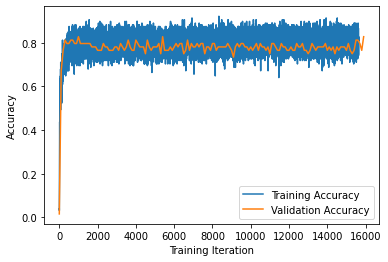

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{experiment_dir}/training-plot.png")